In [1]:
# adventuresinmachinelearning.com/pytorch-tutorial-deep-learning/
# https://towardsdatascience.com/pytorch-tutorial-distilled-95ce8781a89c

# 1. Import Modules

In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
from collections import OrderedDict
import sklearn.preprocessing as pre
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

In [3]:
%matplotlib inline
#%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [4]:
# fix random seed for reproducibility
np.random.seed(200184)

# 2. Train the GAN model

In [5]:
device = torch.device('cpu')
# device = torch.device('cuda') # Uncomment this to run on GPU

In [6]:
# defining classes and ANN
class AE_net(nn.Module):
    def __init__(self):
        super(AE_net, self).__init__()
        #net_list = [nn.Linear(1, 100), nn.ReLU(), 
        #            nn.Linear(100, 100), nn.ReLU(), 
        #            nn.Linear(100, 100), nn.ReLU(), 
        #            nn.Linear(100, 1),  nn.ReLU()
        #           ]  # definition of model, just put in corresponding layers in sequence
        
        net_list = [nn.Linear(4, 2)#,   
#                     nn.Tanh(),
#                     nn.Linear(8, 32), 
#                     nn.Tanh(),
#                     nn.Linear(32, 128), 
#                     nn.Tanh(),
#                     nn.Linear(128, 128), 
#                     nn.Tanh(),
#                     nn.Linear(128, 32), 
#                     nn.Tanh(),
#                     nn.Linear(32, 8),
#                     nn.Tanh(),
#                     nn.Linear(8, 2)
                   ]
        self._net = nn.Sequential(*net_list).to(device)
        return

    def forward(self, x):
        return self._net(x)
    
def get_var_from_np(np_array, cuda=False, requires_grad=False):    # convert numpy to PyTorch variable for training
    temp = Variable(torch.from_numpy(np_array), requires_grad=requires_grad).type(torch.FloatTensor)
    if cuda: temp = temp.cuda()
    return temp
    
def train(model, data_in, data_out, data_in_val, data_out_val):
    
    train_data = My_dataset(get_var_from_np(data_in), get_var_from_np(data_out))
    val_data = My_dataset(get_var_from_np(data_in_val), get_var_from_np(data_out_val))
    
    optimizer = torch.optim.SGD(model._net.parameters(), lr = 0.01, momentum=0.9)
    n_epoch = 3000
    batch_size = 100
    n_batch = math.ceil(1. * len(train_data) / batch_size)
    loss_train = np.zeros(n_epoch)
    loss_val = np.zeros(n_epoch)
    
    for epoch in range(n_epoch):    
        
        dataset = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)
        
        batch_idx = 0
        for train_in, train_out in dataset:
            out = model._net.forward(train_in)
            loss = nn.MSELoss()(out, train_out) 
            if (batch_idx+1) % min(10,n_batch) == 0:
                print ("Epoch = %5d, Batch = %5d/%5d [%4.0f%%]:\tTraining Loss = %12.5e" % (epoch, batch_idx+1, n_batch, 100. * (batch_idx+1) / n_batch, loss.cpu().data.numpy()))
            optimizer.zero_grad()
            loss.backward() # scalar variables, when we call .backward() on them, don’t require arguments – only tensors require a matching sized tensor argument to be passed to the .backward() operation
            optimizer.step()
            del loss
            batch_idx += 1
        
        data_out_pred = model._net.forward(get_var_from_np(data_in)).cpu().data.numpy()
        diff = data_out_pred - data_out
        MSE = np.sum(diff**2) / diff.shape[0]
        loss_train[epoch] = MSE
        
        data_out_val_pred = model._net.forward(get_var_from_np(data_in_val)).cpu().data.numpy()
        diff = data_out_val_pred - data_out_val
        MSE = np.sum(diff**2) / diff.shape[0]
        loss_val[epoch] = MSE        

    return loss_train, loss_val
    
class My_dataset(Dataset):      # construct dataset object for mini-batch gradient descent
    def __init__(self, data_in, data_out):
        self._data_in = data_in
        self._data_out = data_out

    def __len__(self):
        return len(self._data_in)

    def __getitem__(self, index):
        return self._data_in[index], self._data_out[index]

In [7]:
EBD = np.loadtxt("h2t latent space.txt",delimiter=' ')[:,1:5]
X = np.loadtxt("B_50001_10.txt",delimiter=' ')[:,0:2]

In [8]:
EBD.shape

(49963, 4)

In [9]:
X.shape

(49963, 2)

In [10]:
n = X.shape[0]

x = np.concatenate((EBD[:,0].reshape(EBD.shape[0],1), EBD[:,1].reshape(EBD.shape[0],1),EBD[:,2].reshape(EBD.shape[0],1),EBD[:,3].reshape(EBD.shape[0],1)), axis=1)

print (x)

[[ 1.85501412e-03  1.29088294e-03  4.60343761e-03  2.32847827e-03]
 [ 1.91431923e-03  1.16217369e-03  5.17718261e-03  1.71887060e-03]
 [ 1.77791610e-03  1.81028107e-03  3.77802085e-03  9.99505792e-05]
 ...
 [ 1.52430381e-03 -1.75890350e-03  1.81684189e-03  1.44114369e-03]
 [ 1.58677960e-03 -3.02538276e-04  2.23638187e-03 -1.52079156e-03]
 [ 1.59630552e-03 -1.18101761e-03  2.34350492e-03  1.40209077e-03]]


In [11]:
y = np.zeros((n,2))

y = np.concatenate((X[:,0].reshape(X.shape[0],1), X[:,1].reshape(X.shape[0],1)), axis=1)

print (y)

[[-0.00193751  0.00140543]
 [-0.00242442  0.00313239]
 [-0.00243668  0.00305768]
 ...
 [-0.00245551  0.00209861]
 [-0.00319202  0.00814628]
 [-0.00202419  0.00100075]]


In [12]:
test_frac = 0.10
val_frac = 0.20
x_train_val, x_test, y_train_val, y_test = train_test_split(x, y, test_size=test_frac, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, test_size=val_frac/(1-test_frac), random_state=43)

In [13]:
# scaling
xscale = pre.MinMaxScaler(feature_range=(0,1)) # changing feature range requires modification of chain rule in post-hoc gradient rescaling
yscale = pre.MinMaxScaler(feature_range=(0,1)) # changing feature range requires modification of chain rule in post-hoc gradient rescaling

# xscale = pre.StandardScaler()
# yscale = pre.StandardScaler()


X_train = xscale.fit_transform(x_train)
Y_train = yscale.fit_transform(y_train)
X_val = xscale.transform(x_val)
Y_val = yscale.transform(y_val)
X_test = xscale.transform(x_test)
Y_test = yscale.transform(y_test)
X = xscale.transform(x)
Y = yscale.transform(y)

In [14]:
# training
model = AE_net()
print(model)

AE_net(
  (_net): Sequential(
    (0): Linear(in_features=4, out_features=2, bias=True)
  )
)


In [15]:
loss_train, loss_val = train(model, X_train, Y_train, X_val, Y_val)

Epoch =     0, Batch =    10/  350 [   3%]:	Training Loss =  6.39448e-02
Epoch =     0, Batch =    20/  350 [   6%]:	Training Loss =  6.38234e-02
Epoch =     0, Batch =    30/  350 [   9%]:	Training Loss =  5.02960e-02
Epoch =     0, Batch =    40/  350 [  11%]:	Training Loss =  4.39196e-02
Epoch =     0, Batch =    50/  350 [  14%]:	Training Loss =  4.89474e-02
Epoch =     0, Batch =    60/  350 [  17%]:	Training Loss =  3.91027e-02
Epoch =     0, Batch =    70/  350 [  20%]:	Training Loss =  3.14132e-02
Epoch =     0, Batch =    80/  350 [  23%]:	Training Loss =  2.93441e-02
Epoch =     0, Batch =    90/  350 [  26%]:	Training Loss =  4.29699e-02
Epoch =     0, Batch =   100/  350 [  29%]:	Training Loss =  3.08425e-02
Epoch =     0, Batch =   110/  350 [  31%]:	Training Loss =  3.42764e-02
Epoch =     0, Batch =   120/  350 [  34%]:	Training Loss =  2.88941e-02
Epoch =     0, Batch =   130/  350 [  37%]:	Training Loss =  3.46590e-02
Epoch =     0, Batch =   140/  350 [  40%]:	Trainin

Epoch =     3, Batch =   180/  350 [  51%]:	Training Loss =  2.08786e-02
Epoch =     3, Batch =   190/  350 [  54%]:	Training Loss =  2.32012e-02
Epoch =     3, Batch =   200/  350 [  57%]:	Training Loss =  1.81372e-02
Epoch =     3, Batch =   210/  350 [  60%]:	Training Loss =  1.52903e-02
Epoch =     3, Batch =   220/  350 [  63%]:	Training Loss =  1.97172e-02
Epoch =     3, Batch =   230/  350 [  66%]:	Training Loss =  1.77956e-02
Epoch =     3, Batch =   240/  350 [  69%]:	Training Loss =  1.56045e-02
Epoch =     3, Batch =   250/  350 [  71%]:	Training Loss =  1.81262e-02
Epoch =     3, Batch =   260/  350 [  74%]:	Training Loss =  2.07753e-02
Epoch =     3, Batch =   270/  350 [  77%]:	Training Loss =  1.94468e-02
Epoch =     3, Batch =   280/  350 [  80%]:	Training Loss =  1.86189e-02
Epoch =     3, Batch =   290/  350 [  83%]:	Training Loss =  1.97827e-02
Epoch =     3, Batch =   300/  350 [  86%]:	Training Loss =  2.43045e-02
Epoch =     3, Batch =   310/  350 [  89%]:	Trainin

Epoch =     6, Batch =   340/  350 [  97%]:	Training Loss =  1.70655e-02
Epoch =     7, Batch =    10/  350 [   3%]:	Training Loss =  2.24195e-02
Epoch =     7, Batch =    20/  350 [   6%]:	Training Loss =  1.92730e-02
Epoch =     7, Batch =    30/  350 [   9%]:	Training Loss =  2.08860e-02
Epoch =     7, Batch =    40/  350 [  11%]:	Training Loss =  1.74906e-02
Epoch =     7, Batch =    50/  350 [  14%]:	Training Loss =  1.64498e-02
Epoch =     7, Batch =    60/  350 [  17%]:	Training Loss =  1.74615e-02
Epoch =     7, Batch =    70/  350 [  20%]:	Training Loss =  1.90542e-02
Epoch =     7, Batch =    80/  350 [  23%]:	Training Loss =  2.07687e-02
Epoch =     7, Batch =    90/  350 [  26%]:	Training Loss =  2.45899e-02
Epoch =     7, Batch =   100/  350 [  29%]:	Training Loss =  1.63000e-02
Epoch =     7, Batch =   110/  350 [  31%]:	Training Loss =  2.17537e-02
Epoch =     7, Batch =   120/  350 [  34%]:	Training Loss =  1.39037e-02
Epoch =     7, Batch =   130/  350 [  37%]:	Trainin

Epoch =    10, Batch =   160/  350 [  46%]:	Training Loss =  1.70530e-02
Epoch =    10, Batch =   170/  350 [  49%]:	Training Loss =  2.00502e-02
Epoch =    10, Batch =   180/  350 [  51%]:	Training Loss =  1.83133e-02
Epoch =    10, Batch =   190/  350 [  54%]:	Training Loss =  1.88531e-02
Epoch =    10, Batch =   200/  350 [  57%]:	Training Loss =  1.99080e-02
Epoch =    10, Batch =   210/  350 [  60%]:	Training Loss =  1.75753e-02
Epoch =    10, Batch =   220/  350 [  63%]:	Training Loss =  1.95863e-02
Epoch =    10, Batch =   230/  350 [  66%]:	Training Loss =  1.52395e-02
Epoch =    10, Batch =   240/  350 [  69%]:	Training Loss =  1.65342e-02
Epoch =    10, Batch =   250/  350 [  71%]:	Training Loss =  1.64004e-02
Epoch =    10, Batch =   260/  350 [  74%]:	Training Loss =  1.64727e-02
Epoch =    10, Batch =   270/  350 [  77%]:	Training Loss =  2.08232e-02
Epoch =    10, Batch =   280/  350 [  80%]:	Training Loss =  1.76699e-02
Epoch =    10, Batch =   290/  350 [  83%]:	Trainin

Epoch =    13, Batch =   330/  350 [  94%]:	Training Loss =  1.41211e-02
Epoch =    13, Batch =   340/  350 [  97%]:	Training Loss =  1.92677e-02
Epoch =    14, Batch =    10/  350 [   3%]:	Training Loss =  2.13194e-02
Epoch =    14, Batch =    20/  350 [   6%]:	Training Loss =  1.93820e-02
Epoch =    14, Batch =    30/  350 [   9%]:	Training Loss =  2.30317e-02
Epoch =    14, Batch =    40/  350 [  11%]:	Training Loss =  2.36360e-02
Epoch =    14, Batch =    50/  350 [  14%]:	Training Loss =  1.64322e-02
Epoch =    14, Batch =    60/  350 [  17%]:	Training Loss =  1.90130e-02
Epoch =    14, Batch =    70/  350 [  20%]:	Training Loss =  2.25696e-02
Epoch =    14, Batch =    80/  350 [  23%]:	Training Loss =  1.62757e-02
Epoch =    14, Batch =    90/  350 [  26%]:	Training Loss =  1.77973e-02
Epoch =    14, Batch =   100/  350 [  29%]:	Training Loss =  2.02661e-02
Epoch =    14, Batch =   110/  350 [  31%]:	Training Loss =  1.65230e-02
Epoch =    14, Batch =   120/  350 [  34%]:	Trainin

Epoch =    17, Batch =   130/  350 [  37%]:	Training Loss =  2.01322e-02
Epoch =    17, Batch =   140/  350 [  40%]:	Training Loss =  1.64114e-02
Epoch =    17, Batch =   150/  350 [  43%]:	Training Loss =  2.19042e-02
Epoch =    17, Batch =   160/  350 [  46%]:	Training Loss =  1.79822e-02
Epoch =    17, Batch =   170/  350 [  49%]:	Training Loss =  2.37578e-02
Epoch =    17, Batch =   180/  350 [  51%]:	Training Loss =  1.87373e-02
Epoch =    17, Batch =   190/  350 [  54%]:	Training Loss =  1.91295e-02
Epoch =    17, Batch =   200/  350 [  57%]:	Training Loss =  2.00462e-02
Epoch =    17, Batch =   210/  350 [  60%]:	Training Loss =  2.12434e-02
Epoch =    17, Batch =   220/  350 [  63%]:	Training Loss =  2.15337e-02
Epoch =    17, Batch =   230/  350 [  66%]:	Training Loss =  2.02328e-02
Epoch =    17, Batch =   240/  350 [  69%]:	Training Loss =  1.83410e-02
Epoch =    17, Batch =   250/  350 [  71%]:	Training Loss =  2.44933e-02
Epoch =    17, Batch =   260/  350 [  74%]:	Trainin

Epoch =    20, Batch =   310/  350 [  89%]:	Training Loss =  2.22951e-02
Epoch =    20, Batch =   320/  350 [  91%]:	Training Loss =  1.71533e-02
Epoch =    20, Batch =   330/  350 [  94%]:	Training Loss =  1.90547e-02
Epoch =    20, Batch =   340/  350 [  97%]:	Training Loss =  1.72458e-02
Epoch =    21, Batch =    10/  350 [   3%]:	Training Loss =  1.75514e-02
Epoch =    21, Batch =    20/  350 [   6%]:	Training Loss =  1.90206e-02
Epoch =    21, Batch =    30/  350 [   9%]:	Training Loss =  1.89121e-02
Epoch =    21, Batch =    40/  350 [  11%]:	Training Loss =  1.99996e-02
Epoch =    21, Batch =    50/  350 [  14%]:	Training Loss =  1.92113e-02
Epoch =    21, Batch =    60/  350 [  17%]:	Training Loss =  1.53590e-02
Epoch =    21, Batch =    70/  350 [  20%]:	Training Loss =  2.10150e-02
Epoch =    21, Batch =    80/  350 [  23%]:	Training Loss =  1.93688e-02
Epoch =    21, Batch =    90/  350 [  26%]:	Training Loss =  1.65158e-02
Epoch =    21, Batch =   100/  350 [  29%]:	Trainin

Epoch =    24, Batch =   130/  350 [  37%]:	Training Loss =  2.46642e-02
Epoch =    24, Batch =   140/  350 [  40%]:	Training Loss =  2.03962e-02
Epoch =    24, Batch =   150/  350 [  43%]:	Training Loss =  2.14156e-02
Epoch =    24, Batch =   160/  350 [  46%]:	Training Loss =  1.83274e-02
Epoch =    24, Batch =   170/  350 [  49%]:	Training Loss =  2.08121e-02
Epoch =    24, Batch =   180/  350 [  51%]:	Training Loss =  2.14639e-02
Epoch =    24, Batch =   190/  350 [  54%]:	Training Loss =  1.87885e-02
Epoch =    24, Batch =   200/  350 [  57%]:	Training Loss =  1.63729e-02
Epoch =    24, Batch =   210/  350 [  60%]:	Training Loss =  1.87121e-02
Epoch =    24, Batch =   220/  350 [  63%]:	Training Loss =  1.77017e-02
Epoch =    24, Batch =   230/  350 [  66%]:	Training Loss =  1.71427e-02
Epoch =    24, Batch =   240/  350 [  69%]:	Training Loss =  1.70495e-02
Epoch =    24, Batch =   250/  350 [  71%]:	Training Loss =  2.03551e-02
Epoch =    24, Batch =   260/  350 [  74%]:	Trainin

Epoch =    27, Batch =   320/  350 [  91%]:	Training Loss =  2.18313e-02
Epoch =    27, Batch =   330/  350 [  94%]:	Training Loss =  2.13055e-02
Epoch =    27, Batch =   340/  350 [  97%]:	Training Loss =  2.35618e-02
Epoch =    28, Batch =    10/  350 [   3%]:	Training Loss =  1.49533e-02
Epoch =    28, Batch =    20/  350 [   6%]:	Training Loss =  2.18442e-02
Epoch =    28, Batch =    30/  350 [   9%]:	Training Loss =  1.62122e-02
Epoch =    28, Batch =    40/  350 [  11%]:	Training Loss =  1.92388e-02
Epoch =    28, Batch =    50/  350 [  14%]:	Training Loss =  1.81883e-02
Epoch =    28, Batch =    60/  350 [  17%]:	Training Loss =  2.02133e-02
Epoch =    28, Batch =    70/  350 [  20%]:	Training Loss =  2.07932e-02
Epoch =    28, Batch =    80/  350 [  23%]:	Training Loss =  1.89136e-02
Epoch =    28, Batch =    90/  350 [  26%]:	Training Loss =  1.39479e-02
Epoch =    28, Batch =   100/  350 [  29%]:	Training Loss =  2.38713e-02
Epoch =    28, Batch =   110/  350 [  31%]:	Trainin

Epoch =    31, Batch =   120/  350 [  34%]:	Training Loss =  1.78710e-02
Epoch =    31, Batch =   130/  350 [  37%]:	Training Loss =  2.58759e-02
Epoch =    31, Batch =   140/  350 [  40%]:	Training Loss =  1.94239e-02
Epoch =    31, Batch =   150/  350 [  43%]:	Training Loss =  1.93869e-02
Epoch =    31, Batch =   160/  350 [  46%]:	Training Loss =  2.15613e-02
Epoch =    31, Batch =   170/  350 [  49%]:	Training Loss =  1.79540e-02
Epoch =    31, Batch =   180/  350 [  51%]:	Training Loss =  1.53906e-02
Epoch =    31, Batch =   190/  350 [  54%]:	Training Loss =  2.15846e-02
Epoch =    31, Batch =   200/  350 [  57%]:	Training Loss =  1.33961e-02
Epoch =    31, Batch =   210/  350 [  60%]:	Training Loss =  2.15219e-02
Epoch =    31, Batch =   220/  350 [  63%]:	Training Loss =  1.97769e-02
Epoch =    31, Batch =   230/  350 [  66%]:	Training Loss =  1.98347e-02
Epoch =    31, Batch =   240/  350 [  69%]:	Training Loss =  1.66391e-02
Epoch =    31, Batch =   250/  350 [  71%]:	Trainin

Epoch =    34, Batch =   320/  350 [  91%]:	Training Loss =  1.53263e-02
Epoch =    34, Batch =   330/  350 [  94%]:	Training Loss =  1.60812e-02
Epoch =    34, Batch =   340/  350 [  97%]:	Training Loss =  1.88324e-02
Epoch =    35, Batch =    10/  350 [   3%]:	Training Loss =  2.06254e-02
Epoch =    35, Batch =    20/  350 [   6%]:	Training Loss =  2.26543e-02
Epoch =    35, Batch =    30/  350 [   9%]:	Training Loss =  1.70804e-02
Epoch =    35, Batch =    40/  350 [  11%]:	Training Loss =  2.35389e-02
Epoch =    35, Batch =    50/  350 [  14%]:	Training Loss =  1.88900e-02
Epoch =    35, Batch =    60/  350 [  17%]:	Training Loss =  1.34772e-02
Epoch =    35, Batch =    70/  350 [  20%]:	Training Loss =  1.94462e-02
Epoch =    35, Batch =    80/  350 [  23%]:	Training Loss =  1.99481e-02
Epoch =    35, Batch =    90/  350 [  26%]:	Training Loss =  1.78760e-02
Epoch =    35, Batch =   100/  350 [  29%]:	Training Loss =  1.87545e-02
Epoch =    35, Batch =   110/  350 [  31%]:	Trainin

Epoch =    38, Batch =    90/  350 [  26%]:	Training Loss =  1.83696e-02
Epoch =    38, Batch =   100/  350 [  29%]:	Training Loss =  2.28382e-02
Epoch =    38, Batch =   110/  350 [  31%]:	Training Loss =  2.01161e-02
Epoch =    38, Batch =   120/  350 [  34%]:	Training Loss =  1.87174e-02
Epoch =    38, Batch =   130/  350 [  37%]:	Training Loss =  1.90639e-02
Epoch =    38, Batch =   140/  350 [  40%]:	Training Loss =  2.24782e-02
Epoch =    38, Batch =   150/  350 [  43%]:	Training Loss =  1.78686e-02
Epoch =    38, Batch =   160/  350 [  46%]:	Training Loss =  1.77582e-02
Epoch =    38, Batch =   170/  350 [  49%]:	Training Loss =  1.66164e-02
Epoch =    38, Batch =   180/  350 [  51%]:	Training Loss =  1.52913e-02
Epoch =    38, Batch =   190/  350 [  54%]:	Training Loss =  1.90925e-02
Epoch =    38, Batch =   200/  350 [  57%]:	Training Loss =  1.87901e-02
Epoch =    38, Batch =   210/  350 [  60%]:	Training Loss =  2.13288e-02
Epoch =    38, Batch =   220/  350 [  63%]:	Trainin

Epoch =    41, Batch =   290/  350 [  83%]:	Training Loss =  2.00672e-02
Epoch =    41, Batch =   300/  350 [  86%]:	Training Loss =  2.00107e-02
Epoch =    41, Batch =   310/  350 [  89%]:	Training Loss =  1.92042e-02
Epoch =    41, Batch =   320/  350 [  91%]:	Training Loss =  1.98698e-02
Epoch =    41, Batch =   330/  350 [  94%]:	Training Loss =  2.16039e-02
Epoch =    41, Batch =   340/  350 [  97%]:	Training Loss =  2.02888e-02
Epoch =    42, Batch =    10/  350 [   3%]:	Training Loss =  1.63662e-02
Epoch =    42, Batch =    20/  350 [   6%]:	Training Loss =  1.92970e-02
Epoch =    42, Batch =    30/  350 [   9%]:	Training Loss =  1.75506e-02
Epoch =    42, Batch =    40/  350 [  11%]:	Training Loss =  1.60950e-02
Epoch =    42, Batch =    50/  350 [  14%]:	Training Loss =  2.02693e-02
Epoch =    42, Batch =    60/  350 [  17%]:	Training Loss =  1.58804e-02
Epoch =    42, Batch =    70/  350 [  20%]:	Training Loss =  1.82266e-02
Epoch =    42, Batch =    80/  350 [  23%]:	Trainin

Epoch =    45, Batch =    90/  350 [  26%]:	Training Loss =  1.82617e-02
Epoch =    45, Batch =   100/  350 [  29%]:	Training Loss =  2.39745e-02
Epoch =    45, Batch =   110/  350 [  31%]:	Training Loss =  1.60416e-02
Epoch =    45, Batch =   120/  350 [  34%]:	Training Loss =  1.79222e-02
Epoch =    45, Batch =   130/  350 [  37%]:	Training Loss =  1.80201e-02
Epoch =    45, Batch =   140/  350 [  40%]:	Training Loss =  1.42479e-02
Epoch =    45, Batch =   150/  350 [  43%]:	Training Loss =  2.10898e-02
Epoch =    45, Batch =   160/  350 [  46%]:	Training Loss =  1.85146e-02
Epoch =    45, Batch =   170/  350 [  49%]:	Training Loss =  1.97906e-02
Epoch =    45, Batch =   180/  350 [  51%]:	Training Loss =  1.76359e-02
Epoch =    45, Batch =   190/  350 [  54%]:	Training Loss =  1.86448e-02
Epoch =    45, Batch =   200/  350 [  57%]:	Training Loss =  1.51440e-02
Epoch =    45, Batch =   210/  350 [  60%]:	Training Loss =  1.53719e-02
Epoch =    45, Batch =   220/  350 [  63%]:	Trainin

Epoch =    48, Batch =   290/  350 [  83%]:	Training Loss =  2.18061e-02
Epoch =    48, Batch =   300/  350 [  86%]:	Training Loss =  1.65717e-02
Epoch =    48, Batch =   310/  350 [  89%]:	Training Loss =  1.62130e-02
Epoch =    48, Batch =   320/  350 [  91%]:	Training Loss =  1.96062e-02
Epoch =    48, Batch =   330/  350 [  94%]:	Training Loss =  2.28660e-02
Epoch =    48, Batch =   340/  350 [  97%]:	Training Loss =  2.29645e-02
Epoch =    49, Batch =    10/  350 [   3%]:	Training Loss =  1.92938e-02
Epoch =    49, Batch =    20/  350 [   6%]:	Training Loss =  1.78935e-02
Epoch =    49, Batch =    30/  350 [   9%]:	Training Loss =  2.13446e-02
Epoch =    49, Batch =    40/  350 [  11%]:	Training Loss =  2.31333e-02
Epoch =    49, Batch =    50/  350 [  14%]:	Training Loss =  2.09464e-02
Epoch =    49, Batch =    60/  350 [  17%]:	Training Loss =  1.87344e-02
Epoch =    49, Batch =    70/  350 [  20%]:	Training Loss =  1.75665e-02
Epoch =    49, Batch =    80/  350 [  23%]:	Trainin

Epoch =    52, Batch =    60/  350 [  17%]:	Training Loss =  2.03233e-02
Epoch =    52, Batch =    70/  350 [  20%]:	Training Loss =  2.16706e-02
Epoch =    52, Batch =    80/  350 [  23%]:	Training Loss =  1.77382e-02
Epoch =    52, Batch =    90/  350 [  26%]:	Training Loss =  2.10164e-02
Epoch =    52, Batch =   100/  350 [  29%]:	Training Loss =  2.24857e-02
Epoch =    52, Batch =   110/  350 [  31%]:	Training Loss =  2.27442e-02
Epoch =    52, Batch =   120/  350 [  34%]:	Training Loss =  1.92975e-02
Epoch =    52, Batch =   130/  350 [  37%]:	Training Loss =  1.77921e-02
Epoch =    52, Batch =   140/  350 [  40%]:	Training Loss =  2.09063e-02
Epoch =    52, Batch =   150/  350 [  43%]:	Training Loss =  1.77067e-02
Epoch =    52, Batch =   160/  350 [  46%]:	Training Loss =  2.13442e-02
Epoch =    52, Batch =   170/  350 [  49%]:	Training Loss =  2.15986e-02
Epoch =    52, Batch =   180/  350 [  51%]:	Training Loss =  1.84380e-02
Epoch =    52, Batch =   190/  350 [  54%]:	Trainin

Epoch =    55, Batch =   280/  350 [  80%]:	Training Loss =  1.77803e-02
Epoch =    55, Batch =   290/  350 [  83%]:	Training Loss =  2.24687e-02
Epoch =    55, Batch =   300/  350 [  86%]:	Training Loss =  1.66941e-02
Epoch =    55, Batch =   310/  350 [  89%]:	Training Loss =  1.63473e-02
Epoch =    55, Batch =   320/  350 [  91%]:	Training Loss =  1.89010e-02
Epoch =    55, Batch =   330/  350 [  94%]:	Training Loss =  2.50467e-02
Epoch =    55, Batch =   340/  350 [  97%]:	Training Loss =  1.62901e-02
Epoch =    56, Batch =    10/  350 [   3%]:	Training Loss =  2.07868e-02
Epoch =    56, Batch =    20/  350 [   6%]:	Training Loss =  1.86624e-02
Epoch =    56, Batch =    30/  350 [   9%]:	Training Loss =  1.79792e-02
Epoch =    56, Batch =    40/  350 [  11%]:	Training Loss =  2.36750e-02
Epoch =    56, Batch =    50/  350 [  14%]:	Training Loss =  1.66973e-02
Epoch =    56, Batch =    60/  350 [  17%]:	Training Loss =  1.78408e-02
Epoch =    56, Batch =    70/  350 [  20%]:	Trainin

Epoch =    59, Batch =   230/  350 [  66%]:	Training Loss =  1.39961e-02
Epoch =    59, Batch =   240/  350 [  69%]:	Training Loss =  1.94191e-02
Epoch =    59, Batch =   250/  350 [  71%]:	Training Loss =  1.87087e-02
Epoch =    59, Batch =   260/  350 [  74%]:	Training Loss =  2.33233e-02
Epoch =    59, Batch =   270/  350 [  77%]:	Training Loss =  2.01040e-02
Epoch =    59, Batch =   280/  350 [  80%]:	Training Loss =  1.88160e-02
Epoch =    59, Batch =   290/  350 [  83%]:	Training Loss =  1.90630e-02
Epoch =    59, Batch =   300/  350 [  86%]:	Training Loss =  1.65432e-02
Epoch =    59, Batch =   310/  350 [  89%]:	Training Loss =  1.45390e-02
Epoch =    59, Batch =   320/  350 [  91%]:	Training Loss =  1.73155e-02
Epoch =    59, Batch =   330/  350 [  94%]:	Training Loss =  2.05508e-02
Epoch =    59, Batch =   340/  350 [  97%]:	Training Loss =  1.89686e-02
Epoch =    60, Batch =    10/  350 [   3%]:	Training Loss =  1.68629e-02
Epoch =    60, Batch =    20/  350 [   6%]:	Trainin

Epoch =    63, Batch =   170/  350 [  49%]:	Training Loss =  1.54198e-02
Epoch =    63, Batch =   180/  350 [  51%]:	Training Loss =  2.30821e-02
Epoch =    63, Batch =   190/  350 [  54%]:	Training Loss =  2.19415e-02
Epoch =    63, Batch =   200/  350 [  57%]:	Training Loss =  2.06769e-02
Epoch =    63, Batch =   210/  350 [  60%]:	Training Loss =  1.59397e-02
Epoch =    63, Batch =   220/  350 [  63%]:	Training Loss =  2.38456e-02
Epoch =    63, Batch =   230/  350 [  66%]:	Training Loss =  2.07699e-02
Epoch =    63, Batch =   240/  350 [  69%]:	Training Loss =  1.94706e-02
Epoch =    63, Batch =   250/  350 [  71%]:	Training Loss =  2.46451e-02
Epoch =    63, Batch =   260/  350 [  74%]:	Training Loss =  1.76407e-02
Epoch =    63, Batch =   270/  350 [  77%]:	Training Loss =  1.84765e-02
Epoch =    63, Batch =   280/  350 [  80%]:	Training Loss =  1.90964e-02
Epoch =    63, Batch =   290/  350 [  83%]:	Training Loss =  1.93540e-02
Epoch =    63, Batch =   300/  350 [  86%]:	Trainin

Epoch =    67, Batch =   110/  350 [  31%]:	Training Loss =  2.20956e-02
Epoch =    67, Batch =   120/  350 [  34%]:	Training Loss =  1.90965e-02
Epoch =    67, Batch =   130/  350 [  37%]:	Training Loss =  1.64416e-02
Epoch =    67, Batch =   140/  350 [  40%]:	Training Loss =  1.67696e-02
Epoch =    67, Batch =   150/  350 [  43%]:	Training Loss =  1.44584e-02
Epoch =    67, Batch =   160/  350 [  46%]:	Training Loss =  1.93222e-02
Epoch =    67, Batch =   170/  350 [  49%]:	Training Loss =  1.68686e-02
Epoch =    67, Batch =   180/  350 [  51%]:	Training Loss =  1.41736e-02
Epoch =    67, Batch =   190/  350 [  54%]:	Training Loss =  1.91019e-02
Epoch =    67, Batch =   200/  350 [  57%]:	Training Loss =  1.72714e-02
Epoch =    67, Batch =   210/  350 [  60%]:	Training Loss =  2.32106e-02
Epoch =    67, Batch =   220/  350 [  63%]:	Training Loss =  1.84193e-02
Epoch =    67, Batch =   230/  350 [  66%]:	Training Loss =  1.74407e-02
Epoch =    67, Batch =   240/  350 [  69%]:	Trainin

Epoch =    70, Batch =   220/  350 [  63%]:	Training Loss =  2.39180e-02
Epoch =    70, Batch =   230/  350 [  66%]:	Training Loss =  1.79655e-02
Epoch =    70, Batch =   240/  350 [  69%]:	Training Loss =  1.76210e-02
Epoch =    70, Batch =   250/  350 [  71%]:	Training Loss =  1.71529e-02
Epoch =    70, Batch =   260/  350 [  74%]:	Training Loss =  2.04555e-02
Epoch =    70, Batch =   270/  350 [  77%]:	Training Loss =  1.72434e-02
Epoch =    70, Batch =   280/  350 [  80%]:	Training Loss =  1.85492e-02
Epoch =    70, Batch =   290/  350 [  83%]:	Training Loss =  2.36559e-02
Epoch =    70, Batch =   300/  350 [  86%]:	Training Loss =  1.71385e-02
Epoch =    70, Batch =   310/  350 [  89%]:	Training Loss =  1.92830e-02
Epoch =    70, Batch =   320/  350 [  91%]:	Training Loss =  1.84083e-02
Epoch =    70, Batch =   330/  350 [  94%]:	Training Loss =  1.75535e-02
Epoch =    70, Batch =   340/  350 [  97%]:	Training Loss =  2.01414e-02
Epoch =    71, Batch =    10/  350 [   3%]:	Trainin

Epoch =    74, Batch =   110/  350 [  31%]:	Training Loss =  1.83171e-02
Epoch =    74, Batch =   120/  350 [  34%]:	Training Loss =  2.29698e-02
Epoch =    74, Batch =   130/  350 [  37%]:	Training Loss =  2.04786e-02
Epoch =    74, Batch =   140/  350 [  40%]:	Training Loss =  1.56988e-02
Epoch =    74, Batch =   150/  350 [  43%]:	Training Loss =  2.08141e-02
Epoch =    74, Batch =   160/  350 [  46%]:	Training Loss =  2.15908e-02
Epoch =    74, Batch =   170/  350 [  49%]:	Training Loss =  1.93612e-02
Epoch =    74, Batch =   180/  350 [  51%]:	Training Loss =  2.16305e-02
Epoch =    74, Batch =   190/  350 [  54%]:	Training Loss =  1.74854e-02
Epoch =    74, Batch =   200/  350 [  57%]:	Training Loss =  2.02124e-02
Epoch =    74, Batch =   210/  350 [  60%]:	Training Loss =  1.82674e-02
Epoch =    74, Batch =   220/  350 [  63%]:	Training Loss =  1.57725e-02
Epoch =    74, Batch =   230/  350 [  66%]:	Training Loss =  1.79442e-02
Epoch =    74, Batch =   240/  350 [  69%]:	Trainin

Epoch =    77, Batch =   230/  350 [  66%]:	Training Loss =  1.62341e-02
Epoch =    77, Batch =   240/  350 [  69%]:	Training Loss =  1.84207e-02
Epoch =    77, Batch =   250/  350 [  71%]:	Training Loss =  1.48283e-02
Epoch =    77, Batch =   260/  350 [  74%]:	Training Loss =  2.00726e-02
Epoch =    77, Batch =   270/  350 [  77%]:	Training Loss =  1.93619e-02
Epoch =    77, Batch =   280/  350 [  80%]:	Training Loss =  2.37105e-02
Epoch =    77, Batch =   290/  350 [  83%]:	Training Loss =  1.93218e-02
Epoch =    77, Batch =   300/  350 [  86%]:	Training Loss =  1.79033e-02
Epoch =    77, Batch =   310/  350 [  89%]:	Training Loss =  2.22599e-02
Epoch =    77, Batch =   320/  350 [  91%]:	Training Loss =  2.17283e-02
Epoch =    77, Batch =   330/  350 [  94%]:	Training Loss =  1.76984e-02
Epoch =    77, Batch =   340/  350 [  97%]:	Training Loss =  1.95493e-02
Epoch =    78, Batch =    10/  350 [   3%]:	Training Loss =  1.57308e-02
Epoch =    78, Batch =    20/  350 [   6%]:	Trainin

Epoch =    81, Batch =   130/  350 [  37%]:	Training Loss =  1.90881e-02
Epoch =    81, Batch =   140/  350 [  40%]:	Training Loss =  2.20333e-02
Epoch =    81, Batch =   150/  350 [  43%]:	Training Loss =  1.85740e-02
Epoch =    81, Batch =   160/  350 [  46%]:	Training Loss =  2.00221e-02
Epoch =    81, Batch =   170/  350 [  49%]:	Training Loss =  1.84755e-02
Epoch =    81, Batch =   180/  350 [  51%]:	Training Loss =  2.15623e-02
Epoch =    81, Batch =   190/  350 [  54%]:	Training Loss =  2.08783e-02
Epoch =    81, Batch =   200/  350 [  57%]:	Training Loss =  1.87659e-02
Epoch =    81, Batch =   210/  350 [  60%]:	Training Loss =  1.50264e-02
Epoch =    81, Batch =   220/  350 [  63%]:	Training Loss =  1.43300e-02
Epoch =    81, Batch =   230/  350 [  66%]:	Training Loss =  2.40049e-02
Epoch =    81, Batch =   240/  350 [  69%]:	Training Loss =  2.35704e-02
Epoch =    81, Batch =   250/  350 [  71%]:	Training Loss =  1.95256e-02
Epoch =    81, Batch =   260/  350 [  74%]:	Trainin

Epoch =    85, Batch =    60/  350 [  17%]:	Training Loss =  1.63432e-02
Epoch =    85, Batch =    70/  350 [  20%]:	Training Loss =  2.03279e-02
Epoch =    85, Batch =    80/  350 [  23%]:	Training Loss =  1.73873e-02
Epoch =    85, Batch =    90/  350 [  26%]:	Training Loss =  2.59874e-02
Epoch =    85, Batch =   100/  350 [  29%]:	Training Loss =  1.68767e-02
Epoch =    85, Batch =   110/  350 [  31%]:	Training Loss =  1.88332e-02
Epoch =    85, Batch =   120/  350 [  34%]:	Training Loss =  1.91263e-02
Epoch =    85, Batch =   130/  350 [  37%]:	Training Loss =  1.93174e-02
Epoch =    85, Batch =   140/  350 [  40%]:	Training Loss =  1.40856e-02
Epoch =    85, Batch =   150/  350 [  43%]:	Training Loss =  2.02602e-02
Epoch =    85, Batch =   160/  350 [  46%]:	Training Loss =  1.74166e-02
Epoch =    85, Batch =   170/  350 [  49%]:	Training Loss =  2.40323e-02
Epoch =    85, Batch =   180/  350 [  51%]:	Training Loss =  1.86189e-02
Epoch =    85, Batch =   190/  350 [  54%]:	Trainin

Epoch =    88, Batch =   170/  350 [  49%]:	Training Loss =  2.02106e-02
Epoch =    88, Batch =   180/  350 [  51%]:	Training Loss =  2.11514e-02
Epoch =    88, Batch =   190/  350 [  54%]:	Training Loss =  1.69959e-02
Epoch =    88, Batch =   200/  350 [  57%]:	Training Loss =  1.85631e-02
Epoch =    88, Batch =   210/  350 [  60%]:	Training Loss =  2.11512e-02
Epoch =    88, Batch =   220/  350 [  63%]:	Training Loss =  1.72454e-02
Epoch =    88, Batch =   230/  350 [  66%]:	Training Loss =  2.09812e-02
Epoch =    88, Batch =   240/  350 [  69%]:	Training Loss =  2.13157e-02
Epoch =    88, Batch =   250/  350 [  71%]:	Training Loss =  1.58673e-02
Epoch =    88, Batch =   260/  350 [  74%]:	Training Loss =  1.97667e-02
Epoch =    88, Batch =   270/  350 [  77%]:	Training Loss =  2.51445e-02
Epoch =    88, Batch =   280/  350 [  80%]:	Training Loss =  2.38019e-02
Epoch =    88, Batch =   290/  350 [  83%]:	Training Loss =  1.91302e-02
Epoch =    88, Batch =   300/  350 [  86%]:	Trainin

Epoch =    92, Batch =   100/  350 [  29%]:	Training Loss =  1.72305e-02
Epoch =    92, Batch =   110/  350 [  31%]:	Training Loss =  1.71451e-02
Epoch =    92, Batch =   120/  350 [  34%]:	Training Loss =  1.83082e-02
Epoch =    92, Batch =   130/  350 [  37%]:	Training Loss =  1.65328e-02
Epoch =    92, Batch =   140/  350 [  40%]:	Training Loss =  1.93320e-02
Epoch =    92, Batch =   150/  350 [  43%]:	Training Loss =  1.71213e-02
Epoch =    92, Batch =   160/  350 [  46%]:	Training Loss =  2.02462e-02
Epoch =    92, Batch =   170/  350 [  49%]:	Training Loss =  2.80764e-02
Epoch =    92, Batch =   180/  350 [  51%]:	Training Loss =  2.19646e-02
Epoch =    92, Batch =   190/  350 [  54%]:	Training Loss =  1.46063e-02
Epoch =    92, Batch =   200/  350 [  57%]:	Training Loss =  1.59332e-02
Epoch =    92, Batch =   210/  350 [  60%]:	Training Loss =  1.97949e-02
Epoch =    92, Batch =   220/  350 [  63%]:	Training Loss =  2.00332e-02
Epoch =    92, Batch =   230/  350 [  66%]:	Trainin

Epoch =    96, Batch =    50/  350 [  14%]:	Training Loss =  1.60857e-02
Epoch =    96, Batch =    60/  350 [  17%]:	Training Loss =  2.07902e-02
Epoch =    96, Batch =    70/  350 [  20%]:	Training Loss =  1.62075e-02
Epoch =    96, Batch =    80/  350 [  23%]:	Training Loss =  1.98988e-02
Epoch =    96, Batch =    90/  350 [  26%]:	Training Loss =  1.98839e-02
Epoch =    96, Batch =   100/  350 [  29%]:	Training Loss =  1.56717e-02
Epoch =    96, Batch =   110/  350 [  31%]:	Training Loss =  1.91238e-02
Epoch =    96, Batch =   120/  350 [  34%]:	Training Loss =  1.77514e-02
Epoch =    96, Batch =   130/  350 [  37%]:	Training Loss =  1.62192e-02
Epoch =    96, Batch =   140/  350 [  40%]:	Training Loss =  2.00569e-02
Epoch =    96, Batch =   150/  350 [  43%]:	Training Loss =  2.32469e-02
Epoch =    96, Batch =   160/  350 [  46%]:	Training Loss =  2.32882e-02
Epoch =    96, Batch =   170/  350 [  49%]:	Training Loss =  1.72972e-02
Epoch =    96, Batch =   180/  350 [  51%]:	Trainin

Epoch =   100, Batch =    10/  350 [   3%]:	Training Loss =  2.50985e-02
Epoch =   100, Batch =    20/  350 [   6%]:	Training Loss =  2.39039e-02
Epoch =   100, Batch =    30/  350 [   9%]:	Training Loss =  1.56494e-02
Epoch =   100, Batch =    40/  350 [  11%]:	Training Loss =  1.25335e-02
Epoch =   100, Batch =    50/  350 [  14%]:	Training Loss =  2.05339e-02
Epoch =   100, Batch =    60/  350 [  17%]:	Training Loss =  1.75437e-02
Epoch =   100, Batch =    70/  350 [  20%]:	Training Loss =  2.09086e-02
Epoch =   100, Batch =    80/  350 [  23%]:	Training Loss =  1.68520e-02
Epoch =   100, Batch =    90/  350 [  26%]:	Training Loss =  1.64778e-02
Epoch =   100, Batch =   100/  350 [  29%]:	Training Loss =  1.83592e-02
Epoch =   100, Batch =   110/  350 [  31%]:	Training Loss =  1.87434e-02
Epoch =   100, Batch =   120/  350 [  34%]:	Training Loss =  1.84895e-02
Epoch =   100, Batch =   130/  350 [  37%]:	Training Loss =  1.79794e-02
Epoch =   100, Batch =   140/  350 [  40%]:	Trainin

Epoch =   103, Batch =   320/  350 [  91%]:	Training Loss =  1.64281e-02
Epoch =   103, Batch =   330/  350 [  94%]:	Training Loss =  2.17195e-02
Epoch =   103, Batch =   340/  350 [  97%]:	Training Loss =  1.98590e-02
Epoch =   104, Batch =    10/  350 [   3%]:	Training Loss =  2.30615e-02
Epoch =   104, Batch =    20/  350 [   6%]:	Training Loss =  2.01087e-02
Epoch =   104, Batch =    30/  350 [   9%]:	Training Loss =  2.41098e-02
Epoch =   104, Batch =    40/  350 [  11%]:	Training Loss =  1.81630e-02
Epoch =   104, Batch =    50/  350 [  14%]:	Training Loss =  2.37550e-02
Epoch =   104, Batch =    60/  350 [  17%]:	Training Loss =  2.16367e-02
Epoch =   104, Batch =    70/  350 [  20%]:	Training Loss =  1.74063e-02
Epoch =   104, Batch =    80/  350 [  23%]:	Training Loss =  2.16668e-02
Epoch =   104, Batch =    90/  350 [  26%]:	Training Loss =  1.66251e-02
Epoch =   104, Batch =   100/  350 [  29%]:	Training Loss =  1.73087e-02
Epoch =   104, Batch =   110/  350 [  31%]:	Trainin

Epoch =   107, Batch =    90/  350 [  26%]:	Training Loss =  1.86582e-02
Epoch =   107, Batch =   100/  350 [  29%]:	Training Loss =  1.64881e-02
Epoch =   107, Batch =   110/  350 [  31%]:	Training Loss =  1.64848e-02
Epoch =   107, Batch =   120/  350 [  34%]:	Training Loss =  1.63722e-02
Epoch =   107, Batch =   130/  350 [  37%]:	Training Loss =  2.08429e-02
Epoch =   107, Batch =   140/  350 [  40%]:	Training Loss =  2.02777e-02
Epoch =   107, Batch =   150/  350 [  43%]:	Training Loss =  2.13839e-02
Epoch =   107, Batch =   160/  350 [  46%]:	Training Loss =  1.98195e-02
Epoch =   107, Batch =   170/  350 [  49%]:	Training Loss =  1.92648e-02
Epoch =   107, Batch =   180/  350 [  51%]:	Training Loss =  1.82142e-02
Epoch =   107, Batch =   190/  350 [  54%]:	Training Loss =  1.76896e-02
Epoch =   107, Batch =   200/  350 [  57%]:	Training Loss =  2.25932e-02
Epoch =   107, Batch =   210/  350 [  60%]:	Training Loss =  1.75140e-02
Epoch =   107, Batch =   220/  350 [  63%]:	Trainin

Epoch =   111, Batch =    50/  350 [  14%]:	Training Loss =  2.52696e-02
Epoch =   111, Batch =    60/  350 [  17%]:	Training Loss =  2.21431e-02
Epoch =   111, Batch =    70/  350 [  20%]:	Training Loss =  1.85399e-02
Epoch =   111, Batch =    80/  350 [  23%]:	Training Loss =  2.12858e-02
Epoch =   111, Batch =    90/  350 [  26%]:	Training Loss =  1.68539e-02
Epoch =   111, Batch =   100/  350 [  29%]:	Training Loss =  1.75604e-02
Epoch =   111, Batch =   110/  350 [  31%]:	Training Loss =  2.13286e-02
Epoch =   111, Batch =   120/  350 [  34%]:	Training Loss =  1.85524e-02
Epoch =   111, Batch =   130/  350 [  37%]:	Training Loss =  2.11827e-02
Epoch =   111, Batch =   140/  350 [  40%]:	Training Loss =  1.56537e-02
Epoch =   111, Batch =   150/  350 [  43%]:	Training Loss =  2.01074e-02
Epoch =   111, Batch =   160/  350 [  46%]:	Training Loss =  1.78255e-02
Epoch =   111, Batch =   170/  350 [  49%]:	Training Loss =  1.74192e-02
Epoch =   111, Batch =   180/  350 [  51%]:	Trainin

Epoch =   114, Batch =   320/  350 [  91%]:	Training Loss =  2.22541e-02
Epoch =   114, Batch =   330/  350 [  94%]:	Training Loss =  1.60525e-02
Epoch =   114, Batch =   340/  350 [  97%]:	Training Loss =  2.21764e-02
Epoch =   115, Batch =    10/  350 [   3%]:	Training Loss =  1.87967e-02
Epoch =   115, Batch =    20/  350 [   6%]:	Training Loss =  2.26677e-02
Epoch =   115, Batch =    30/  350 [   9%]:	Training Loss =  1.62748e-02
Epoch =   115, Batch =    40/  350 [  11%]:	Training Loss =  1.76269e-02
Epoch =   115, Batch =    50/  350 [  14%]:	Training Loss =  2.14233e-02
Epoch =   115, Batch =    60/  350 [  17%]:	Training Loss =  1.87532e-02
Epoch =   115, Batch =    70/  350 [  20%]:	Training Loss =  1.64181e-02
Epoch =   115, Batch =    80/  350 [  23%]:	Training Loss =  1.93213e-02
Epoch =   115, Batch =    90/  350 [  26%]:	Training Loss =  1.74079e-02
Epoch =   115, Batch =   100/  350 [  29%]:	Training Loss =  1.95967e-02
Epoch =   115, Batch =   110/  350 [  31%]:	Trainin

Epoch =   118, Batch =   250/  350 [  71%]:	Training Loss =  2.26131e-02
Epoch =   118, Batch =   260/  350 [  74%]:	Training Loss =  1.67557e-02
Epoch =   118, Batch =   270/  350 [  77%]:	Training Loss =  2.26789e-02
Epoch =   118, Batch =   280/  350 [  80%]:	Training Loss =  1.93989e-02
Epoch =   118, Batch =   290/  350 [  83%]:	Training Loss =  1.82578e-02
Epoch =   118, Batch =   300/  350 [  86%]:	Training Loss =  2.02128e-02
Epoch =   118, Batch =   310/  350 [  89%]:	Training Loss =  2.49451e-02
Epoch =   118, Batch =   320/  350 [  91%]:	Training Loss =  1.65773e-02
Epoch =   118, Batch =   330/  350 [  94%]:	Training Loss =  1.65339e-02
Epoch =   118, Batch =   340/  350 [  97%]:	Training Loss =  1.92855e-02
Epoch =   119, Batch =    10/  350 [   3%]:	Training Loss =  2.30971e-02
Epoch =   119, Batch =    20/  350 [   6%]:	Training Loss =  2.20696e-02
Epoch =   119, Batch =    30/  350 [   9%]:	Training Loss =  2.01242e-02
Epoch =   119, Batch =    40/  350 [  11%]:	Trainin

Epoch =   122, Batch =   220/  350 [  63%]:	Training Loss =  1.79229e-02
Epoch =   122, Batch =   230/  350 [  66%]:	Training Loss =  1.87140e-02
Epoch =   122, Batch =   240/  350 [  69%]:	Training Loss =  1.79623e-02
Epoch =   122, Batch =   250/  350 [  71%]:	Training Loss =  1.35038e-02
Epoch =   122, Batch =   260/  350 [  74%]:	Training Loss =  1.77377e-02
Epoch =   122, Batch =   270/  350 [  77%]:	Training Loss =  1.80198e-02
Epoch =   122, Batch =   280/  350 [  80%]:	Training Loss =  1.62670e-02
Epoch =   122, Batch =   290/  350 [  83%]:	Training Loss =  1.64517e-02
Epoch =   122, Batch =   300/  350 [  86%]:	Training Loss =  1.68728e-02
Epoch =   122, Batch =   310/  350 [  89%]:	Training Loss =  2.13432e-02
Epoch =   122, Batch =   320/  350 [  91%]:	Training Loss =  2.32429e-02
Epoch =   122, Batch =   330/  350 [  94%]:	Training Loss =  2.34031e-02
Epoch =   122, Batch =   340/  350 [  97%]:	Training Loss =  1.73312e-02
Epoch =   123, Batch =    10/  350 [   3%]:	Trainin

Epoch =   126, Batch =   160/  350 [  46%]:	Training Loss =  2.34104e-02
Epoch =   126, Batch =   170/  350 [  49%]:	Training Loss =  2.17535e-02
Epoch =   126, Batch =   180/  350 [  51%]:	Training Loss =  1.85254e-02
Epoch =   126, Batch =   190/  350 [  54%]:	Training Loss =  1.88383e-02
Epoch =   126, Batch =   200/  350 [  57%]:	Training Loss =  1.64679e-02
Epoch =   126, Batch =   210/  350 [  60%]:	Training Loss =  2.15173e-02
Epoch =   126, Batch =   220/  350 [  63%]:	Training Loss =  2.19316e-02
Epoch =   126, Batch =   230/  350 [  66%]:	Training Loss =  1.83615e-02
Epoch =   126, Batch =   240/  350 [  69%]:	Training Loss =  2.16215e-02
Epoch =   126, Batch =   250/  350 [  71%]:	Training Loss =  1.96569e-02
Epoch =   126, Batch =   260/  350 [  74%]:	Training Loss =  2.46838e-02
Epoch =   126, Batch =   270/  350 [  77%]:	Training Loss =  2.54087e-02
Epoch =   126, Batch =   280/  350 [  80%]:	Training Loss =  1.81200e-02
Epoch =   126, Batch =   290/  350 [  83%]:	Trainin

Epoch =   129, Batch =   270/  350 [  77%]:	Training Loss =  2.22514e-02
Epoch =   129, Batch =   280/  350 [  80%]:	Training Loss =  1.73473e-02
Epoch =   129, Batch =   290/  350 [  83%]:	Training Loss =  1.97899e-02
Epoch =   129, Batch =   300/  350 [  86%]:	Training Loss =  1.83725e-02
Epoch =   129, Batch =   310/  350 [  89%]:	Training Loss =  1.73545e-02
Epoch =   129, Batch =   320/  350 [  91%]:	Training Loss =  1.74520e-02
Epoch =   129, Batch =   330/  350 [  94%]:	Training Loss =  1.73947e-02
Epoch =   129, Batch =   340/  350 [  97%]:	Training Loss =  1.84819e-02
Epoch =   130, Batch =    10/  350 [   3%]:	Training Loss =  2.17502e-02
Epoch =   130, Batch =    20/  350 [   6%]:	Training Loss =  2.16289e-02
Epoch =   130, Batch =    30/  350 [   9%]:	Training Loss =  2.31483e-02
Epoch =   130, Batch =    40/  350 [  11%]:	Training Loss =  1.75301e-02
Epoch =   130, Batch =    50/  350 [  14%]:	Training Loss =  2.19281e-02
Epoch =   130, Batch =    60/  350 [  17%]:	Trainin

Epoch =   133, Batch =   230/  350 [  66%]:	Training Loss =  1.84233e-02
Epoch =   133, Batch =   240/  350 [  69%]:	Training Loss =  2.22485e-02
Epoch =   133, Batch =   250/  350 [  71%]:	Training Loss =  2.01768e-02
Epoch =   133, Batch =   260/  350 [  74%]:	Training Loss =  2.57310e-02
Epoch =   133, Batch =   270/  350 [  77%]:	Training Loss =  1.83684e-02
Epoch =   133, Batch =   280/  350 [  80%]:	Training Loss =  2.00158e-02
Epoch =   133, Batch =   290/  350 [  83%]:	Training Loss =  1.85865e-02
Epoch =   133, Batch =   300/  350 [  86%]:	Training Loss =  1.73524e-02
Epoch =   133, Batch =   310/  350 [  89%]:	Training Loss =  1.96289e-02
Epoch =   133, Batch =   320/  350 [  91%]:	Training Loss =  2.24363e-02
Epoch =   133, Batch =   330/  350 [  94%]:	Training Loss =  1.75351e-02
Epoch =   133, Batch =   340/  350 [  97%]:	Training Loss =  1.99098e-02
Epoch =   134, Batch =    10/  350 [   3%]:	Training Loss =  1.69848e-02
Epoch =   134, Batch =    20/  350 [   6%]:	Trainin

Epoch =   137, Batch =   180/  350 [  51%]:	Training Loss =  2.21151e-02
Epoch =   137, Batch =   190/  350 [  54%]:	Training Loss =  1.88531e-02
Epoch =   137, Batch =   200/  350 [  57%]:	Training Loss =  1.92671e-02
Epoch =   137, Batch =   210/  350 [  60%]:	Training Loss =  1.73565e-02
Epoch =   137, Batch =   220/  350 [  63%]:	Training Loss =  1.99612e-02
Epoch =   137, Batch =   230/  350 [  66%]:	Training Loss =  1.89365e-02
Epoch =   137, Batch =   240/  350 [  69%]:	Training Loss =  2.05851e-02
Epoch =   137, Batch =   250/  350 [  71%]:	Training Loss =  1.55606e-02
Epoch =   137, Batch =   260/  350 [  74%]:	Training Loss =  1.72984e-02
Epoch =   137, Batch =   270/  350 [  77%]:	Training Loss =  1.98425e-02
Epoch =   137, Batch =   280/  350 [  80%]:	Training Loss =  1.88427e-02
Epoch =   137, Batch =   290/  350 [  83%]:	Training Loss =  1.94668e-02
Epoch =   137, Batch =   300/  350 [  86%]:	Training Loss =  1.79940e-02
Epoch =   137, Batch =   310/  350 [  89%]:	Trainin

Epoch =   141, Batch =   130/  350 [  37%]:	Training Loss =  1.82487e-02
Epoch =   141, Batch =   140/  350 [  40%]:	Training Loss =  2.00091e-02
Epoch =   141, Batch =   150/  350 [  43%]:	Training Loss =  1.57685e-02
Epoch =   141, Batch =   160/  350 [  46%]:	Training Loss =  1.70177e-02
Epoch =   141, Batch =   170/  350 [  49%]:	Training Loss =  2.14060e-02
Epoch =   141, Batch =   180/  350 [  51%]:	Training Loss =  1.64780e-02
Epoch =   141, Batch =   190/  350 [  54%]:	Training Loss =  2.40192e-02
Epoch =   141, Batch =   200/  350 [  57%]:	Training Loss =  1.79616e-02
Epoch =   141, Batch =   210/  350 [  60%]:	Training Loss =  1.93724e-02
Epoch =   141, Batch =   220/  350 [  63%]:	Training Loss =  1.46779e-02
Epoch =   141, Batch =   230/  350 [  66%]:	Training Loss =  2.21896e-02
Epoch =   141, Batch =   240/  350 [  69%]:	Training Loss =  2.35670e-02
Epoch =   141, Batch =   250/  350 [  71%]:	Training Loss =  2.29182e-02
Epoch =   141, Batch =   260/  350 [  74%]:	Trainin

Epoch =   145, Batch =    80/  350 [  23%]:	Training Loss =  2.20248e-02
Epoch =   145, Batch =    90/  350 [  26%]:	Training Loss =  1.86601e-02
Epoch =   145, Batch =   100/  350 [  29%]:	Training Loss =  1.71124e-02
Epoch =   145, Batch =   110/  350 [  31%]:	Training Loss =  1.61450e-02
Epoch =   145, Batch =   120/  350 [  34%]:	Training Loss =  1.90301e-02
Epoch =   145, Batch =   130/  350 [  37%]:	Training Loss =  2.34294e-02
Epoch =   145, Batch =   140/  350 [  40%]:	Training Loss =  1.72928e-02
Epoch =   145, Batch =   150/  350 [  43%]:	Training Loss =  1.60809e-02
Epoch =   145, Batch =   160/  350 [  46%]:	Training Loss =  1.80837e-02
Epoch =   145, Batch =   170/  350 [  49%]:	Training Loss =  2.19802e-02
Epoch =   145, Batch =   180/  350 [  51%]:	Training Loss =  2.23101e-02
Epoch =   145, Batch =   190/  350 [  54%]:	Training Loss =  1.67433e-02
Epoch =   145, Batch =   200/  350 [  57%]:	Training Loss =  1.55770e-02
Epoch =   145, Batch =   210/  350 [  60%]:	Trainin

Epoch =   149, Batch =    50/  350 [  14%]:	Training Loss =  1.87733e-02
Epoch =   149, Batch =    60/  350 [  17%]:	Training Loss =  2.15534e-02
Epoch =   149, Batch =    70/  350 [  20%]:	Training Loss =  1.65979e-02
Epoch =   149, Batch =    80/  350 [  23%]:	Training Loss =  1.70183e-02
Epoch =   149, Batch =    90/  350 [  26%]:	Training Loss =  1.68517e-02
Epoch =   149, Batch =   100/  350 [  29%]:	Training Loss =  1.73556e-02
Epoch =   149, Batch =   110/  350 [  31%]:	Training Loss =  2.09514e-02
Epoch =   149, Batch =   120/  350 [  34%]:	Training Loss =  2.16649e-02
Epoch =   149, Batch =   130/  350 [  37%]:	Training Loss =  2.07726e-02
Epoch =   149, Batch =   140/  350 [  40%]:	Training Loss =  2.18247e-02
Epoch =   149, Batch =   150/  350 [  43%]:	Training Loss =  2.01360e-02
Epoch =   149, Batch =   160/  350 [  46%]:	Training Loss =  2.03267e-02
Epoch =   149, Batch =   170/  350 [  49%]:	Training Loss =  2.04225e-02
Epoch =   149, Batch =   180/  350 [  51%]:	Trainin

Epoch =   153, Batch =    10/  350 [   3%]:	Training Loss =  2.01987e-02
Epoch =   153, Batch =    20/  350 [   6%]:	Training Loss =  1.79233e-02
Epoch =   153, Batch =    30/  350 [   9%]:	Training Loss =  2.82233e-02
Epoch =   153, Batch =    40/  350 [  11%]:	Training Loss =  2.12160e-02
Epoch =   153, Batch =    50/  350 [  14%]:	Training Loss =  1.41741e-02
Epoch =   153, Batch =    60/  350 [  17%]:	Training Loss =  1.56740e-02
Epoch =   153, Batch =    70/  350 [  20%]:	Training Loss =  1.97414e-02
Epoch =   153, Batch =    80/  350 [  23%]:	Training Loss =  2.56407e-02
Epoch =   153, Batch =    90/  350 [  26%]:	Training Loss =  1.86184e-02
Epoch =   153, Batch =   100/  350 [  29%]:	Training Loss =  2.24830e-02
Epoch =   153, Batch =   110/  350 [  31%]:	Training Loss =  1.68773e-02
Epoch =   153, Batch =   120/  350 [  34%]:	Training Loss =  1.95746e-02
Epoch =   153, Batch =   130/  350 [  37%]:	Training Loss =  1.86211e-02
Epoch =   153, Batch =   140/  350 [  40%]:	Trainin

Epoch =   156, Batch =   290/  350 [  83%]:	Training Loss =  1.95609e-02
Epoch =   156, Batch =   300/  350 [  86%]:	Training Loss =  1.74475e-02
Epoch =   156, Batch =   310/  350 [  89%]:	Training Loss =  1.87709e-02
Epoch =   156, Batch =   320/  350 [  91%]:	Training Loss =  1.36721e-02
Epoch =   156, Batch =   330/  350 [  94%]:	Training Loss =  2.15209e-02
Epoch =   156, Batch =   340/  350 [  97%]:	Training Loss =  1.61275e-02
Epoch =   157, Batch =    10/  350 [   3%]:	Training Loss =  1.66575e-02
Epoch =   157, Batch =    20/  350 [   6%]:	Training Loss =  1.95217e-02
Epoch =   157, Batch =    30/  350 [   9%]:	Training Loss =  1.69787e-02
Epoch =   157, Batch =    40/  350 [  11%]:	Training Loss =  1.56899e-02
Epoch =   157, Batch =    50/  350 [  14%]:	Training Loss =  2.07738e-02
Epoch =   157, Batch =    60/  350 [  17%]:	Training Loss =  1.50105e-02
Epoch =   157, Batch =    70/  350 [  20%]:	Training Loss =  2.07843e-02
Epoch =   157, Batch =    80/  350 [  23%]:	Trainin

Epoch =   160, Batch =   250/  350 [  71%]:	Training Loss =  1.76931e-02
Epoch =   160, Batch =   260/  350 [  74%]:	Training Loss =  2.10497e-02
Epoch =   160, Batch =   270/  350 [  77%]:	Training Loss =  1.78979e-02
Epoch =   160, Batch =   280/  350 [  80%]:	Training Loss =  2.00356e-02
Epoch =   160, Batch =   290/  350 [  83%]:	Training Loss =  2.30549e-02
Epoch =   160, Batch =   300/  350 [  86%]:	Training Loss =  1.59772e-02
Epoch =   160, Batch =   310/  350 [  89%]:	Training Loss =  2.20209e-02
Epoch =   160, Batch =   320/  350 [  91%]:	Training Loss =  1.52064e-02
Epoch =   160, Batch =   330/  350 [  94%]:	Training Loss =  2.19198e-02
Epoch =   160, Batch =   340/  350 [  97%]:	Training Loss =  1.85026e-02
Epoch =   161, Batch =    10/  350 [   3%]:	Training Loss =  2.31908e-02
Epoch =   161, Batch =    20/  350 [   6%]:	Training Loss =  1.68180e-02
Epoch =   161, Batch =    30/  350 [   9%]:	Training Loss =  1.65143e-02
Epoch =   161, Batch =    40/  350 [  11%]:	Trainin

Epoch =   164, Batch =   230/  350 [  66%]:	Training Loss =  1.99537e-02
Epoch =   164, Batch =   240/  350 [  69%]:	Training Loss =  1.60805e-02
Epoch =   164, Batch =   250/  350 [  71%]:	Training Loss =  2.10841e-02
Epoch =   164, Batch =   260/  350 [  74%]:	Training Loss =  1.80017e-02
Epoch =   164, Batch =   270/  350 [  77%]:	Training Loss =  2.66990e-02
Epoch =   164, Batch =   280/  350 [  80%]:	Training Loss =  1.61295e-02
Epoch =   164, Batch =   290/  350 [  83%]:	Training Loss =  1.92393e-02
Epoch =   164, Batch =   300/  350 [  86%]:	Training Loss =  2.57579e-02
Epoch =   164, Batch =   310/  350 [  89%]:	Training Loss =  1.87282e-02
Epoch =   164, Batch =   320/  350 [  91%]:	Training Loss =  2.04653e-02
Epoch =   164, Batch =   330/  350 [  94%]:	Training Loss =  2.31870e-02
Epoch =   164, Batch =   340/  350 [  97%]:	Training Loss =  1.80284e-02
Epoch =   165, Batch =    10/  350 [   3%]:	Training Loss =  1.79852e-02
Epoch =   165, Batch =    20/  350 [   6%]:	Trainin

Epoch =   168, Batch =   170/  350 [  49%]:	Training Loss =  1.98162e-02
Epoch =   168, Batch =   180/  350 [  51%]:	Training Loss =  2.08072e-02
Epoch =   168, Batch =   190/  350 [  54%]:	Training Loss =  1.72065e-02
Epoch =   168, Batch =   200/  350 [  57%]:	Training Loss =  2.42483e-02
Epoch =   168, Batch =   210/  350 [  60%]:	Training Loss =  1.94737e-02
Epoch =   168, Batch =   220/  350 [  63%]:	Training Loss =  2.14659e-02
Epoch =   168, Batch =   230/  350 [  66%]:	Training Loss =  1.94815e-02
Epoch =   168, Batch =   240/  350 [  69%]:	Training Loss =  2.14682e-02
Epoch =   168, Batch =   250/  350 [  71%]:	Training Loss =  2.02182e-02
Epoch =   168, Batch =   260/  350 [  74%]:	Training Loss =  2.42448e-02
Epoch =   168, Batch =   270/  350 [  77%]:	Training Loss =  1.94611e-02
Epoch =   168, Batch =   280/  350 [  80%]:	Training Loss =  1.76709e-02
Epoch =   168, Batch =   290/  350 [  83%]:	Training Loss =  2.02724e-02
Epoch =   168, Batch =   300/  350 [  86%]:	Trainin

Epoch =   172, Batch =   110/  350 [  31%]:	Training Loss =  1.68169e-02
Epoch =   172, Batch =   120/  350 [  34%]:	Training Loss =  2.04975e-02
Epoch =   172, Batch =   130/  350 [  37%]:	Training Loss =  1.73554e-02
Epoch =   172, Batch =   140/  350 [  40%]:	Training Loss =  2.29511e-02
Epoch =   172, Batch =   150/  350 [  43%]:	Training Loss =  2.26907e-02
Epoch =   172, Batch =   160/  350 [  46%]:	Training Loss =  1.88289e-02
Epoch =   172, Batch =   170/  350 [  49%]:	Training Loss =  2.12427e-02
Epoch =   172, Batch =   180/  350 [  51%]:	Training Loss =  1.87692e-02
Epoch =   172, Batch =   190/  350 [  54%]:	Training Loss =  1.47317e-02
Epoch =   172, Batch =   200/  350 [  57%]:	Training Loss =  1.84211e-02
Epoch =   172, Batch =   210/  350 [  60%]:	Training Loss =  1.90264e-02
Epoch =   172, Batch =   220/  350 [  63%]:	Training Loss =  1.76246e-02
Epoch =   172, Batch =   230/  350 [  66%]:	Training Loss =  1.79608e-02
Epoch =   172, Batch =   240/  350 [  69%]:	Trainin

Epoch =   176, Batch =    60/  350 [  17%]:	Training Loss =  1.91479e-02
Epoch =   176, Batch =    70/  350 [  20%]:	Training Loss =  1.97353e-02
Epoch =   176, Batch =    80/  350 [  23%]:	Training Loss =  2.16925e-02
Epoch =   176, Batch =    90/  350 [  26%]:	Training Loss =  1.82851e-02
Epoch =   176, Batch =   100/  350 [  29%]:	Training Loss =  1.94439e-02
Epoch =   176, Batch =   110/  350 [  31%]:	Training Loss =  1.76466e-02
Epoch =   176, Batch =   120/  350 [  34%]:	Training Loss =  1.65621e-02
Epoch =   176, Batch =   130/  350 [  37%]:	Training Loss =  2.73641e-02
Epoch =   176, Batch =   140/  350 [  40%]:	Training Loss =  1.81901e-02
Epoch =   176, Batch =   150/  350 [  43%]:	Training Loss =  1.94211e-02
Epoch =   176, Batch =   160/  350 [  46%]:	Training Loss =  1.36789e-02
Epoch =   176, Batch =   170/  350 [  49%]:	Training Loss =  1.97116e-02
Epoch =   176, Batch =   180/  350 [  51%]:	Training Loss =  1.83213e-02
Epoch =   176, Batch =   190/  350 [  54%]:	Trainin

Epoch =   180, Batch =    20/  350 [   6%]:	Training Loss =  1.71913e-02
Epoch =   180, Batch =    30/  350 [   9%]:	Training Loss =  1.98949e-02
Epoch =   180, Batch =    40/  350 [  11%]:	Training Loss =  1.74045e-02
Epoch =   180, Batch =    50/  350 [  14%]:	Training Loss =  2.49080e-02
Epoch =   180, Batch =    60/  350 [  17%]:	Training Loss =  2.21310e-02
Epoch =   180, Batch =    70/  350 [  20%]:	Training Loss =  1.98397e-02
Epoch =   180, Batch =    80/  350 [  23%]:	Training Loss =  1.92916e-02
Epoch =   180, Batch =    90/  350 [  26%]:	Training Loss =  1.71467e-02
Epoch =   180, Batch =   100/  350 [  29%]:	Training Loss =  1.98037e-02
Epoch =   180, Batch =   110/  350 [  31%]:	Training Loss =  1.67606e-02
Epoch =   180, Batch =   120/  350 [  34%]:	Training Loss =  2.02176e-02
Epoch =   180, Batch =   130/  350 [  37%]:	Training Loss =  1.87562e-02
Epoch =   180, Batch =   140/  350 [  40%]:	Training Loss =  1.95003e-02
Epoch =   180, Batch =   150/  350 [  43%]:	Trainin

Epoch =   183, Batch =   280/  350 [  80%]:	Training Loss =  1.63774e-02
Epoch =   183, Batch =   290/  350 [  83%]:	Training Loss =  2.27917e-02
Epoch =   183, Batch =   300/  350 [  86%]:	Training Loss =  2.12230e-02
Epoch =   183, Batch =   310/  350 [  89%]:	Training Loss =  1.75966e-02
Epoch =   183, Batch =   320/  350 [  91%]:	Training Loss =  1.58431e-02
Epoch =   183, Batch =   330/  350 [  94%]:	Training Loss =  1.73400e-02
Epoch =   183, Batch =   340/  350 [  97%]:	Training Loss =  1.94595e-02
Epoch =   184, Batch =    10/  350 [   3%]:	Training Loss =  1.73034e-02
Epoch =   184, Batch =    20/  350 [   6%]:	Training Loss =  1.63719e-02
Epoch =   184, Batch =    30/  350 [   9%]:	Training Loss =  1.70152e-02
Epoch =   184, Batch =    40/  350 [  11%]:	Training Loss =  1.77985e-02
Epoch =   184, Batch =    50/  350 [  14%]:	Training Loss =  1.56907e-02
Epoch =   184, Batch =    60/  350 [  17%]:	Training Loss =  1.68418e-02
Epoch =   184, Batch =    70/  350 [  20%]:	Trainin

Epoch =   187, Batch =   230/  350 [  66%]:	Training Loss =  2.04845e-02
Epoch =   187, Batch =   240/  350 [  69%]:	Training Loss =  1.75772e-02
Epoch =   187, Batch =   250/  350 [  71%]:	Training Loss =  1.61560e-02
Epoch =   187, Batch =   260/  350 [  74%]:	Training Loss =  2.01661e-02
Epoch =   187, Batch =   270/  350 [  77%]:	Training Loss =  1.67494e-02
Epoch =   187, Batch =   280/  350 [  80%]:	Training Loss =  2.08308e-02
Epoch =   187, Batch =   290/  350 [  83%]:	Training Loss =  2.13600e-02
Epoch =   187, Batch =   300/  350 [  86%]:	Training Loss =  1.71697e-02
Epoch =   187, Batch =   310/  350 [  89%]:	Training Loss =  1.99111e-02
Epoch =   187, Batch =   320/  350 [  91%]:	Training Loss =  1.87610e-02
Epoch =   187, Batch =   330/  350 [  94%]:	Training Loss =  1.81263e-02
Epoch =   187, Batch =   340/  350 [  97%]:	Training Loss =  1.92264e-02
Epoch =   188, Batch =    10/  350 [   3%]:	Training Loss =  1.73265e-02
Epoch =   188, Batch =    20/  350 [   6%]:	Trainin

Epoch =   191, Batch =   170/  350 [  49%]:	Training Loss =  2.09883e-02
Epoch =   191, Batch =   180/  350 [  51%]:	Training Loss =  1.90285e-02
Epoch =   191, Batch =   190/  350 [  54%]:	Training Loss =  1.75989e-02
Epoch =   191, Batch =   200/  350 [  57%]:	Training Loss =  1.49058e-02
Epoch =   191, Batch =   210/  350 [  60%]:	Training Loss =  2.04766e-02
Epoch =   191, Batch =   220/  350 [  63%]:	Training Loss =  1.98793e-02
Epoch =   191, Batch =   230/  350 [  66%]:	Training Loss =  1.79417e-02
Epoch =   191, Batch =   240/  350 [  69%]:	Training Loss =  1.81495e-02
Epoch =   191, Batch =   250/  350 [  71%]:	Training Loss =  1.85240e-02
Epoch =   191, Batch =   260/  350 [  74%]:	Training Loss =  2.00038e-02
Epoch =   191, Batch =   270/  350 [  77%]:	Training Loss =  1.70275e-02
Epoch =   191, Batch =   280/  350 [  80%]:	Training Loss =  1.77106e-02
Epoch =   191, Batch =   290/  350 [  83%]:	Training Loss =  2.08153e-02
Epoch =   191, Batch =   300/  350 [  86%]:	Trainin

Epoch =   195, Batch =   130/  350 [  37%]:	Training Loss =  2.00584e-02
Epoch =   195, Batch =   140/  350 [  40%]:	Training Loss =  1.59316e-02
Epoch =   195, Batch =   150/  350 [  43%]:	Training Loss =  1.72812e-02
Epoch =   195, Batch =   160/  350 [  46%]:	Training Loss =  1.67744e-02
Epoch =   195, Batch =   170/  350 [  49%]:	Training Loss =  2.02602e-02
Epoch =   195, Batch =   180/  350 [  51%]:	Training Loss =  1.69398e-02
Epoch =   195, Batch =   190/  350 [  54%]:	Training Loss =  2.07377e-02
Epoch =   195, Batch =   200/  350 [  57%]:	Training Loss =  2.05547e-02
Epoch =   195, Batch =   210/  350 [  60%]:	Training Loss =  2.01525e-02
Epoch =   195, Batch =   220/  350 [  63%]:	Training Loss =  1.29442e-02
Epoch =   195, Batch =   230/  350 [  66%]:	Training Loss =  1.59382e-02
Epoch =   195, Batch =   240/  350 [  69%]:	Training Loss =  2.34354e-02
Epoch =   195, Batch =   250/  350 [  71%]:	Training Loss =  1.70824e-02
Epoch =   195, Batch =   260/  350 [  74%]:	Trainin

Epoch =   199, Batch =    60/  350 [  17%]:	Training Loss =  1.66831e-02
Epoch =   199, Batch =    70/  350 [  20%]:	Training Loss =  2.19546e-02
Epoch =   199, Batch =    80/  350 [  23%]:	Training Loss =  2.23735e-02
Epoch =   199, Batch =    90/  350 [  26%]:	Training Loss =  2.05510e-02
Epoch =   199, Batch =   100/  350 [  29%]:	Training Loss =  1.78289e-02
Epoch =   199, Batch =   110/  350 [  31%]:	Training Loss =  1.91737e-02
Epoch =   199, Batch =   120/  350 [  34%]:	Training Loss =  2.05717e-02
Epoch =   199, Batch =   130/  350 [  37%]:	Training Loss =  2.21305e-02
Epoch =   199, Batch =   140/  350 [  40%]:	Training Loss =  1.71404e-02
Epoch =   199, Batch =   150/  350 [  43%]:	Training Loss =  1.80359e-02
Epoch =   199, Batch =   160/  350 [  46%]:	Training Loss =  2.04441e-02
Epoch =   199, Batch =   170/  350 [  49%]:	Training Loss =  1.58167e-02
Epoch =   199, Batch =   180/  350 [  51%]:	Training Loss =  1.90699e-02
Epoch =   199, Batch =   190/  350 [  54%]:	Trainin

Epoch =   203, Batch =    10/  350 [   3%]:	Training Loss =  1.74924e-02
Epoch =   203, Batch =    20/  350 [   6%]:	Training Loss =  1.72995e-02
Epoch =   203, Batch =    30/  350 [   9%]:	Training Loss =  2.15429e-02
Epoch =   203, Batch =    40/  350 [  11%]:	Training Loss =  1.91072e-02
Epoch =   203, Batch =    50/  350 [  14%]:	Training Loss =  1.41457e-02
Epoch =   203, Batch =    60/  350 [  17%]:	Training Loss =  1.82772e-02
Epoch =   203, Batch =    70/  350 [  20%]:	Training Loss =  2.06200e-02
Epoch =   203, Batch =    80/  350 [  23%]:	Training Loss =  1.97721e-02
Epoch =   203, Batch =    90/  350 [  26%]:	Training Loss =  2.12049e-02
Epoch =   203, Batch =   100/  350 [  29%]:	Training Loss =  2.09983e-02
Epoch =   203, Batch =   110/  350 [  31%]:	Training Loss =  2.31225e-02
Epoch =   203, Batch =   120/  350 [  34%]:	Training Loss =  1.88077e-02
Epoch =   203, Batch =   130/  350 [  37%]:	Training Loss =  1.67520e-02
Epoch =   203, Batch =   140/  350 [  40%]:	Trainin

Epoch =   206, Batch =   300/  350 [  86%]:	Training Loss =  1.80262e-02
Epoch =   206, Batch =   310/  350 [  89%]:	Training Loss =  2.38247e-02
Epoch =   206, Batch =   320/  350 [  91%]:	Training Loss =  2.17068e-02
Epoch =   206, Batch =   330/  350 [  94%]:	Training Loss =  2.10059e-02
Epoch =   206, Batch =   340/  350 [  97%]:	Training Loss =  1.97387e-02
Epoch =   207, Batch =    10/  350 [   3%]:	Training Loss =  1.83956e-02
Epoch =   207, Batch =    20/  350 [   6%]:	Training Loss =  1.47751e-02
Epoch =   207, Batch =    30/  350 [   9%]:	Training Loss =  1.88841e-02
Epoch =   207, Batch =    40/  350 [  11%]:	Training Loss =  1.99754e-02
Epoch =   207, Batch =    50/  350 [  14%]:	Training Loss =  1.74214e-02
Epoch =   207, Batch =    60/  350 [  17%]:	Training Loss =  2.39978e-02
Epoch =   207, Batch =    70/  350 [  20%]:	Training Loss =  2.14001e-02
Epoch =   207, Batch =    80/  350 [  23%]:	Training Loss =  1.57609e-02
Epoch =   207, Batch =    90/  350 [  26%]:	Trainin

Epoch =   210, Batch =   230/  350 [  66%]:	Training Loss =  2.13823e-02
Epoch =   210, Batch =   240/  350 [  69%]:	Training Loss =  1.75981e-02
Epoch =   210, Batch =   250/  350 [  71%]:	Training Loss =  2.58948e-02
Epoch =   210, Batch =   260/  350 [  74%]:	Training Loss =  1.75219e-02
Epoch =   210, Batch =   270/  350 [  77%]:	Training Loss =  1.75370e-02
Epoch =   210, Batch =   280/  350 [  80%]:	Training Loss =  2.05088e-02
Epoch =   210, Batch =   290/  350 [  83%]:	Training Loss =  1.75497e-02
Epoch =   210, Batch =   300/  350 [  86%]:	Training Loss =  1.63715e-02
Epoch =   210, Batch =   310/  350 [  89%]:	Training Loss =  1.87823e-02
Epoch =   210, Batch =   320/  350 [  91%]:	Training Loss =  2.24700e-02
Epoch =   210, Batch =   330/  350 [  94%]:	Training Loss =  1.67497e-02
Epoch =   210, Batch =   340/  350 [  97%]:	Training Loss =  2.14165e-02
Epoch =   211, Batch =    10/  350 [   3%]:	Training Loss =  2.00473e-02
Epoch =   211, Batch =    20/  350 [   6%]:	Trainin

Epoch =   214, Batch =   160/  350 [  46%]:	Training Loss =  1.70117e-02
Epoch =   214, Batch =   170/  350 [  49%]:	Training Loss =  1.57664e-02
Epoch =   214, Batch =   180/  350 [  51%]:	Training Loss =  2.39341e-02
Epoch =   214, Batch =   190/  350 [  54%]:	Training Loss =  1.54599e-02
Epoch =   214, Batch =   200/  350 [  57%]:	Training Loss =  2.21519e-02
Epoch =   214, Batch =   210/  350 [  60%]:	Training Loss =  1.91116e-02
Epoch =   214, Batch =   220/  350 [  63%]:	Training Loss =  2.48895e-02
Epoch =   214, Batch =   230/  350 [  66%]:	Training Loss =  2.08174e-02
Epoch =   214, Batch =   240/  350 [  69%]:	Training Loss =  1.72761e-02
Epoch =   214, Batch =   250/  350 [  71%]:	Training Loss =  1.52103e-02
Epoch =   214, Batch =   260/  350 [  74%]:	Training Loss =  1.98200e-02
Epoch =   214, Batch =   270/  350 [  77%]:	Training Loss =  1.74070e-02
Epoch =   214, Batch =   280/  350 [  80%]:	Training Loss =  1.78211e-02
Epoch =   214, Batch =   290/  350 [  83%]:	Trainin

Epoch =   218, Batch =   110/  350 [  31%]:	Training Loss =  1.65686e-02
Epoch =   218, Batch =   120/  350 [  34%]:	Training Loss =  1.93631e-02
Epoch =   218, Batch =   130/  350 [  37%]:	Training Loss =  1.91073e-02
Epoch =   218, Batch =   140/  350 [  40%]:	Training Loss =  1.62608e-02
Epoch =   218, Batch =   150/  350 [  43%]:	Training Loss =  2.00681e-02
Epoch =   218, Batch =   160/  350 [  46%]:	Training Loss =  1.91635e-02
Epoch =   218, Batch =   170/  350 [  49%]:	Training Loss =  1.96542e-02
Epoch =   218, Batch =   180/  350 [  51%]:	Training Loss =  1.80511e-02
Epoch =   218, Batch =   190/  350 [  54%]:	Training Loss =  1.92029e-02
Epoch =   218, Batch =   200/  350 [  57%]:	Training Loss =  1.85687e-02
Epoch =   218, Batch =   210/  350 [  60%]:	Training Loss =  2.25718e-02
Epoch =   218, Batch =   220/  350 [  63%]:	Training Loss =  2.02810e-02
Epoch =   218, Batch =   230/  350 [  66%]:	Training Loss =  1.63890e-02
Epoch =   218, Batch =   240/  350 [  69%]:	Trainin

Epoch =   222, Batch =    30/  350 [   9%]:	Training Loss =  1.50449e-02
Epoch =   222, Batch =    40/  350 [  11%]:	Training Loss =  1.71218e-02
Epoch =   222, Batch =    50/  350 [  14%]:	Training Loss =  1.89692e-02
Epoch =   222, Batch =    60/  350 [  17%]:	Training Loss =  2.10140e-02
Epoch =   222, Batch =    70/  350 [  20%]:	Training Loss =  2.10557e-02
Epoch =   222, Batch =    80/  350 [  23%]:	Training Loss =  1.97237e-02
Epoch =   222, Batch =    90/  350 [  26%]:	Training Loss =  2.10429e-02
Epoch =   222, Batch =   100/  350 [  29%]:	Training Loss =  1.80506e-02
Epoch =   222, Batch =   110/  350 [  31%]:	Training Loss =  1.81664e-02
Epoch =   222, Batch =   120/  350 [  34%]:	Training Loss =  1.82993e-02
Epoch =   222, Batch =   130/  350 [  37%]:	Training Loss =  1.68640e-02
Epoch =   222, Batch =   140/  350 [  40%]:	Training Loss =  2.00805e-02
Epoch =   222, Batch =   150/  350 [  43%]:	Training Loss =  1.81717e-02
Epoch =   222, Batch =   160/  350 [  46%]:	Trainin

Epoch =   225, Batch =   330/  350 [  94%]:	Training Loss =  1.87123e-02
Epoch =   225, Batch =   340/  350 [  97%]:	Training Loss =  1.74844e-02
Epoch =   226, Batch =    10/  350 [   3%]:	Training Loss =  2.04616e-02
Epoch =   226, Batch =    20/  350 [   6%]:	Training Loss =  1.88661e-02
Epoch =   226, Batch =    30/  350 [   9%]:	Training Loss =  1.83780e-02
Epoch =   226, Batch =    40/  350 [  11%]:	Training Loss =  2.09886e-02
Epoch =   226, Batch =    50/  350 [  14%]:	Training Loss =  2.15727e-02
Epoch =   226, Batch =    60/  350 [  17%]:	Training Loss =  1.99992e-02
Epoch =   226, Batch =    70/  350 [  20%]:	Training Loss =  1.62555e-02
Epoch =   226, Batch =    80/  350 [  23%]:	Training Loss =  1.96011e-02
Epoch =   226, Batch =    90/  350 [  26%]:	Training Loss =  1.97587e-02
Epoch =   226, Batch =   100/  350 [  29%]:	Training Loss =  2.10798e-02
Epoch =   226, Batch =   110/  350 [  31%]:	Training Loss =  1.75841e-02
Epoch =   226, Batch =   120/  350 [  34%]:	Trainin

Epoch =   229, Batch =   240/  350 [  69%]:	Training Loss =  1.32171e-02
Epoch =   229, Batch =   250/  350 [  71%]:	Training Loss =  1.79441e-02
Epoch =   229, Batch =   260/  350 [  74%]:	Training Loss =  1.81475e-02
Epoch =   229, Batch =   270/  350 [  77%]:	Training Loss =  2.49404e-02
Epoch =   229, Batch =   280/  350 [  80%]:	Training Loss =  1.98851e-02
Epoch =   229, Batch =   290/  350 [  83%]:	Training Loss =  2.00609e-02
Epoch =   229, Batch =   300/  350 [  86%]:	Training Loss =  1.61206e-02
Epoch =   229, Batch =   310/  350 [  89%]:	Training Loss =  1.81498e-02
Epoch =   229, Batch =   320/  350 [  91%]:	Training Loss =  2.09295e-02
Epoch =   229, Batch =   330/  350 [  94%]:	Training Loss =  1.98613e-02
Epoch =   229, Batch =   340/  350 [  97%]:	Training Loss =  2.23019e-02
Epoch =   230, Batch =    10/  350 [   3%]:	Training Loss =  1.95517e-02
Epoch =   230, Batch =    20/  350 [   6%]:	Training Loss =  2.22907e-02
Epoch =   230, Batch =    30/  350 [   9%]:	Trainin

Epoch =   233, Batch =   100/  350 [  29%]:	Training Loss =  1.84239e-02
Epoch =   233, Batch =   110/  350 [  31%]:	Training Loss =  2.17692e-02
Epoch =   233, Batch =   120/  350 [  34%]:	Training Loss =  2.04547e-02
Epoch =   233, Batch =   130/  350 [  37%]:	Training Loss =  1.37711e-02
Epoch =   233, Batch =   140/  350 [  40%]:	Training Loss =  2.13315e-02
Epoch =   233, Batch =   150/  350 [  43%]:	Training Loss =  1.67639e-02
Epoch =   233, Batch =   160/  350 [  46%]:	Training Loss =  2.80367e-02
Epoch =   233, Batch =   170/  350 [  49%]:	Training Loss =  1.66609e-02
Epoch =   233, Batch =   180/  350 [  51%]:	Training Loss =  2.10807e-02
Epoch =   233, Batch =   190/  350 [  54%]:	Training Loss =  1.73643e-02
Epoch =   233, Batch =   200/  350 [  57%]:	Training Loss =  2.27061e-02
Epoch =   233, Batch =   210/  350 [  60%]:	Training Loss =  2.16056e-02
Epoch =   233, Batch =   220/  350 [  63%]:	Training Loss =  2.36808e-02
Epoch =   233, Batch =   230/  350 [  66%]:	Trainin

Epoch =   237, Batch =    20/  350 [   6%]:	Training Loss =  2.10706e-02
Epoch =   237, Batch =    30/  350 [   9%]:	Training Loss =  1.88933e-02
Epoch =   237, Batch =    40/  350 [  11%]:	Training Loss =  2.10996e-02
Epoch =   237, Batch =    50/  350 [  14%]:	Training Loss =  1.85592e-02
Epoch =   237, Batch =    60/  350 [  17%]:	Training Loss =  2.49301e-02
Epoch =   237, Batch =    70/  350 [  20%]:	Training Loss =  2.53003e-02
Epoch =   237, Batch =    80/  350 [  23%]:	Training Loss =  1.49179e-02
Epoch =   237, Batch =    90/  350 [  26%]:	Training Loss =  2.04216e-02
Epoch =   237, Batch =   100/  350 [  29%]:	Training Loss =  1.95199e-02
Epoch =   237, Batch =   110/  350 [  31%]:	Training Loss =  2.14180e-02
Epoch =   237, Batch =   120/  350 [  34%]:	Training Loss =  1.92507e-02
Epoch =   237, Batch =   130/  350 [  37%]:	Training Loss =  1.82344e-02
Epoch =   237, Batch =   140/  350 [  40%]:	Training Loss =  1.92214e-02
Epoch =   237, Batch =   150/  350 [  43%]:	Trainin

Epoch =   240, Batch =   290/  350 [  83%]:	Training Loss =  1.99578e-02
Epoch =   240, Batch =   300/  350 [  86%]:	Training Loss =  2.09527e-02
Epoch =   240, Batch =   310/  350 [  89%]:	Training Loss =  1.93388e-02
Epoch =   240, Batch =   320/  350 [  91%]:	Training Loss =  1.94890e-02
Epoch =   240, Batch =   330/  350 [  94%]:	Training Loss =  1.76415e-02
Epoch =   240, Batch =   340/  350 [  97%]:	Training Loss =  1.85459e-02
Epoch =   241, Batch =    10/  350 [   3%]:	Training Loss =  1.65458e-02
Epoch =   241, Batch =    20/  350 [   6%]:	Training Loss =  2.14804e-02
Epoch =   241, Batch =    30/  350 [   9%]:	Training Loss =  2.15154e-02
Epoch =   241, Batch =    40/  350 [  11%]:	Training Loss =  2.58553e-02
Epoch =   241, Batch =    50/  350 [  14%]:	Training Loss =  1.59293e-02
Epoch =   241, Batch =    60/  350 [  17%]:	Training Loss =  1.78971e-02
Epoch =   241, Batch =    70/  350 [  20%]:	Training Loss =  2.55781e-02
Epoch =   241, Batch =    80/  350 [  23%]:	Trainin

Epoch =   244, Batch =   220/  350 [  63%]:	Training Loss =  1.55038e-02
Epoch =   244, Batch =   230/  350 [  66%]:	Training Loss =  1.73071e-02
Epoch =   244, Batch =   240/  350 [  69%]:	Training Loss =  2.00951e-02
Epoch =   244, Batch =   250/  350 [  71%]:	Training Loss =  2.18199e-02
Epoch =   244, Batch =   260/  350 [  74%]:	Training Loss =  2.07557e-02
Epoch =   244, Batch =   270/  350 [  77%]:	Training Loss =  2.01743e-02
Epoch =   244, Batch =   280/  350 [  80%]:	Training Loss =  1.65096e-02
Epoch =   244, Batch =   290/  350 [  83%]:	Training Loss =  2.21122e-02
Epoch =   244, Batch =   300/  350 [  86%]:	Training Loss =  2.53365e-02
Epoch =   244, Batch =   310/  350 [  89%]:	Training Loss =  2.33418e-02
Epoch =   244, Batch =   320/  350 [  91%]:	Training Loss =  2.16642e-02
Epoch =   244, Batch =   330/  350 [  94%]:	Training Loss =  1.60001e-02
Epoch =   244, Batch =   340/  350 [  97%]:	Training Loss =  1.91663e-02
Epoch =   245, Batch =    10/  350 [   3%]:	Trainin

Epoch =   248, Batch =   140/  350 [  40%]:	Training Loss =  1.74707e-02
Epoch =   248, Batch =   150/  350 [  43%]:	Training Loss =  1.55110e-02
Epoch =   248, Batch =   160/  350 [  46%]:	Training Loss =  1.93707e-02
Epoch =   248, Batch =   170/  350 [  49%]:	Training Loss =  2.42518e-02
Epoch =   248, Batch =   180/  350 [  51%]:	Training Loss =  1.93795e-02
Epoch =   248, Batch =   190/  350 [  54%]:	Training Loss =  1.95524e-02
Epoch =   248, Batch =   200/  350 [  57%]:	Training Loss =  2.00769e-02
Epoch =   248, Batch =   210/  350 [  60%]:	Training Loss =  2.55849e-02
Epoch =   248, Batch =   220/  350 [  63%]:	Training Loss =  1.86464e-02
Epoch =   248, Batch =   230/  350 [  66%]:	Training Loss =  2.11363e-02
Epoch =   248, Batch =   240/  350 [  69%]:	Training Loss =  1.76868e-02
Epoch =   248, Batch =   250/  350 [  71%]:	Training Loss =  1.79523e-02
Epoch =   248, Batch =   260/  350 [  74%]:	Training Loss =  1.57787e-02
Epoch =   248, Batch =   270/  350 [  77%]:	Trainin

Epoch =   252, Batch =    60/  350 [  17%]:	Training Loss =  1.45276e-02
Epoch =   252, Batch =    70/  350 [  20%]:	Training Loss =  1.78944e-02
Epoch =   252, Batch =    80/  350 [  23%]:	Training Loss =  1.44042e-02
Epoch =   252, Batch =    90/  350 [  26%]:	Training Loss =  2.15984e-02
Epoch =   252, Batch =   100/  350 [  29%]:	Training Loss =  1.59558e-02
Epoch =   252, Batch =   110/  350 [  31%]:	Training Loss =  2.02688e-02
Epoch =   252, Batch =   120/  350 [  34%]:	Training Loss =  2.31846e-02
Epoch =   252, Batch =   130/  350 [  37%]:	Training Loss =  1.92200e-02
Epoch =   252, Batch =   140/  350 [  40%]:	Training Loss =  2.02132e-02
Epoch =   252, Batch =   150/  350 [  43%]:	Training Loss =  1.78679e-02
Epoch =   252, Batch =   160/  350 [  46%]:	Training Loss =  1.94720e-02
Epoch =   252, Batch =   170/  350 [  49%]:	Training Loss =  1.86098e-02
Epoch =   252, Batch =   180/  350 [  51%]:	Training Loss =  2.05495e-02
Epoch =   252, Batch =   190/  350 [  54%]:	Trainin

Epoch =   255, Batch =   320/  350 [  91%]:	Training Loss =  1.65799e-02
Epoch =   255, Batch =   330/  350 [  94%]:	Training Loss =  1.96647e-02
Epoch =   255, Batch =   340/  350 [  97%]:	Training Loss =  1.93612e-02
Epoch =   256, Batch =    10/  350 [   3%]:	Training Loss =  1.71358e-02
Epoch =   256, Batch =    20/  350 [   6%]:	Training Loss =  1.81060e-02
Epoch =   256, Batch =    30/  350 [   9%]:	Training Loss =  2.62238e-02
Epoch =   256, Batch =    40/  350 [  11%]:	Training Loss =  2.44798e-02
Epoch =   256, Batch =    50/  350 [  14%]:	Training Loss =  2.33164e-02
Epoch =   256, Batch =    60/  350 [  17%]:	Training Loss =  1.83570e-02
Epoch =   256, Batch =    70/  350 [  20%]:	Training Loss =  2.10702e-02
Epoch =   256, Batch =    80/  350 [  23%]:	Training Loss =  1.97281e-02
Epoch =   256, Batch =    90/  350 [  26%]:	Training Loss =  2.21145e-02
Epoch =   256, Batch =   100/  350 [  29%]:	Training Loss =  1.72795e-02
Epoch =   256, Batch =   110/  350 [  31%]:	Trainin

Epoch =   259, Batch =   230/  350 [  66%]:	Training Loss =  1.97383e-02
Epoch =   259, Batch =   240/  350 [  69%]:	Training Loss =  1.74533e-02
Epoch =   259, Batch =   250/  350 [  71%]:	Training Loss =  1.97899e-02
Epoch =   259, Batch =   260/  350 [  74%]:	Training Loss =  1.65776e-02
Epoch =   259, Batch =   270/  350 [  77%]:	Training Loss =  1.87368e-02
Epoch =   259, Batch =   280/  350 [  80%]:	Training Loss =  2.56517e-02
Epoch =   259, Batch =   290/  350 [  83%]:	Training Loss =  1.72727e-02
Epoch =   259, Batch =   300/  350 [  86%]:	Training Loss =  1.85511e-02
Epoch =   259, Batch =   310/  350 [  89%]:	Training Loss =  2.48327e-02
Epoch =   259, Batch =   320/  350 [  91%]:	Training Loss =  2.02427e-02
Epoch =   259, Batch =   330/  350 [  94%]:	Training Loss =  2.02876e-02
Epoch =   259, Batch =   340/  350 [  97%]:	Training Loss =  1.90329e-02
Epoch =   260, Batch =    10/  350 [   3%]:	Training Loss =  2.57918e-02
Epoch =   260, Batch =    20/  350 [   6%]:	Trainin

Epoch =   263, Batch =   130/  350 [  37%]:	Training Loss =  2.03279e-02
Epoch =   263, Batch =   140/  350 [  40%]:	Training Loss =  1.74012e-02
Epoch =   263, Batch =   150/  350 [  43%]:	Training Loss =  1.64234e-02
Epoch =   263, Batch =   160/  350 [  46%]:	Training Loss =  1.89237e-02
Epoch =   263, Batch =   170/  350 [  49%]:	Training Loss =  2.38698e-02
Epoch =   263, Batch =   180/  350 [  51%]:	Training Loss =  2.07901e-02
Epoch =   263, Batch =   190/  350 [  54%]:	Training Loss =  1.87373e-02
Epoch =   263, Batch =   200/  350 [  57%]:	Training Loss =  2.18076e-02
Epoch =   263, Batch =   210/  350 [  60%]:	Training Loss =  1.64890e-02
Epoch =   263, Batch =   220/  350 [  63%]:	Training Loss =  2.13652e-02
Epoch =   263, Batch =   230/  350 [  66%]:	Training Loss =  1.99732e-02
Epoch =   263, Batch =   240/  350 [  69%]:	Training Loss =  1.81289e-02
Epoch =   263, Batch =   250/  350 [  71%]:	Training Loss =  1.80079e-02
Epoch =   263, Batch =   260/  350 [  74%]:	Trainin

Epoch =   267, Batch =    50/  350 [  14%]:	Training Loss =  1.60744e-02
Epoch =   267, Batch =    60/  350 [  17%]:	Training Loss =  2.47251e-02
Epoch =   267, Batch =    70/  350 [  20%]:	Training Loss =  1.83882e-02
Epoch =   267, Batch =    80/  350 [  23%]:	Training Loss =  1.55772e-02
Epoch =   267, Batch =    90/  350 [  26%]:	Training Loss =  1.62784e-02
Epoch =   267, Batch =   100/  350 [  29%]:	Training Loss =  2.10203e-02
Epoch =   267, Batch =   110/  350 [  31%]:	Training Loss =  2.27397e-02
Epoch =   267, Batch =   120/  350 [  34%]:	Training Loss =  1.61613e-02
Epoch =   267, Batch =   130/  350 [  37%]:	Training Loss =  2.16322e-02
Epoch =   267, Batch =   140/  350 [  40%]:	Training Loss =  1.87746e-02
Epoch =   267, Batch =   150/  350 [  43%]:	Training Loss =  1.84363e-02
Epoch =   267, Batch =   160/  350 [  46%]:	Training Loss =  1.35970e-02
Epoch =   267, Batch =   170/  350 [  49%]:	Training Loss =  1.82390e-02
Epoch =   267, Batch =   180/  350 [  51%]:	Trainin

Epoch =   270, Batch =   310/  350 [  89%]:	Training Loss =  1.77003e-02
Epoch =   270, Batch =   320/  350 [  91%]:	Training Loss =  1.86187e-02
Epoch =   270, Batch =   330/  350 [  94%]:	Training Loss =  2.16983e-02
Epoch =   270, Batch =   340/  350 [  97%]:	Training Loss =  2.22916e-02
Epoch =   271, Batch =    10/  350 [   3%]:	Training Loss =  2.10282e-02
Epoch =   271, Batch =    20/  350 [   6%]:	Training Loss =  2.14640e-02
Epoch =   271, Batch =    30/  350 [   9%]:	Training Loss =  1.90303e-02
Epoch =   271, Batch =    40/  350 [  11%]:	Training Loss =  1.91263e-02
Epoch =   271, Batch =    50/  350 [  14%]:	Training Loss =  2.34342e-02
Epoch =   271, Batch =    60/  350 [  17%]:	Training Loss =  1.67380e-02
Epoch =   271, Batch =    70/  350 [  20%]:	Training Loss =  1.73832e-02
Epoch =   271, Batch =    80/  350 [  23%]:	Training Loss =  1.70379e-02
Epoch =   271, Batch =    90/  350 [  26%]:	Training Loss =  1.81052e-02
Epoch =   271, Batch =   100/  350 [  29%]:	Trainin

Epoch =   274, Batch =   190/  350 [  54%]:	Training Loss =  1.68652e-02
Epoch =   274, Batch =   200/  350 [  57%]:	Training Loss =  1.54038e-02
Epoch =   274, Batch =   210/  350 [  60%]:	Training Loss =  1.68281e-02
Epoch =   274, Batch =   220/  350 [  63%]:	Training Loss =  2.08972e-02
Epoch =   274, Batch =   230/  350 [  66%]:	Training Loss =  1.80106e-02
Epoch =   274, Batch =   240/  350 [  69%]:	Training Loss =  1.82772e-02
Epoch =   274, Batch =   250/  350 [  71%]:	Training Loss =  2.16408e-02
Epoch =   274, Batch =   260/  350 [  74%]:	Training Loss =  1.71842e-02
Epoch =   274, Batch =   270/  350 [  77%]:	Training Loss =  2.09509e-02
Epoch =   274, Batch =   280/  350 [  80%]:	Training Loss =  2.09108e-02
Epoch =   274, Batch =   290/  350 [  83%]:	Training Loss =  2.00045e-02
Epoch =   274, Batch =   300/  350 [  86%]:	Training Loss =  1.90600e-02
Epoch =   274, Batch =   310/  350 [  89%]:	Training Loss =  1.95731e-02
Epoch =   274, Batch =   320/  350 [  91%]:	Trainin

Epoch =   278, Batch =   130/  350 [  37%]:	Training Loss =  2.59543e-02
Epoch =   278, Batch =   140/  350 [  40%]:	Training Loss =  2.48369e-02
Epoch =   278, Batch =   150/  350 [  43%]:	Training Loss =  1.84047e-02
Epoch =   278, Batch =   160/  350 [  46%]:	Training Loss =  2.11989e-02
Epoch =   278, Batch =   170/  350 [  49%]:	Training Loss =  1.55316e-02
Epoch =   278, Batch =   180/  350 [  51%]:	Training Loss =  1.52101e-02
Epoch =   278, Batch =   190/  350 [  54%]:	Training Loss =  1.78890e-02
Epoch =   278, Batch =   200/  350 [  57%]:	Training Loss =  2.10287e-02
Epoch =   278, Batch =   210/  350 [  60%]:	Training Loss =  2.15051e-02
Epoch =   278, Batch =   220/  350 [  63%]:	Training Loss =  2.11576e-02
Epoch =   278, Batch =   230/  350 [  66%]:	Training Loss =  2.12194e-02
Epoch =   278, Batch =   240/  350 [  69%]:	Training Loss =  1.89152e-02
Epoch =   278, Batch =   250/  350 [  71%]:	Training Loss =  2.04010e-02
Epoch =   278, Batch =   260/  350 [  74%]:	Trainin

Epoch =   282, Batch =    30/  350 [   9%]:	Training Loss =  1.29747e-02
Epoch =   282, Batch =    40/  350 [  11%]:	Training Loss =  1.89166e-02
Epoch =   282, Batch =    50/  350 [  14%]:	Training Loss =  2.24601e-02
Epoch =   282, Batch =    60/  350 [  17%]:	Training Loss =  1.54502e-02
Epoch =   282, Batch =    70/  350 [  20%]:	Training Loss =  1.83795e-02
Epoch =   282, Batch =    80/  350 [  23%]:	Training Loss =  1.40919e-02
Epoch =   282, Batch =    90/  350 [  26%]:	Training Loss =  1.88177e-02
Epoch =   282, Batch =   100/  350 [  29%]:	Training Loss =  2.15629e-02
Epoch =   282, Batch =   110/  350 [  31%]:	Training Loss =  1.85887e-02
Epoch =   282, Batch =   120/  350 [  34%]:	Training Loss =  2.31245e-02
Epoch =   282, Batch =   130/  350 [  37%]:	Training Loss =  2.22630e-02
Epoch =   282, Batch =   140/  350 [  40%]:	Training Loss =  1.88926e-02
Epoch =   282, Batch =   150/  350 [  43%]:	Training Loss =  2.19891e-02
Epoch =   282, Batch =   160/  350 [  46%]:	Trainin

Epoch =   285, Batch =   280/  350 [  80%]:	Training Loss =  1.67999e-02
Epoch =   285, Batch =   290/  350 [  83%]:	Training Loss =  2.48498e-02
Epoch =   285, Batch =   300/  350 [  86%]:	Training Loss =  2.01689e-02
Epoch =   285, Batch =   310/  350 [  89%]:	Training Loss =  2.13522e-02
Epoch =   285, Batch =   320/  350 [  91%]:	Training Loss =  2.19636e-02
Epoch =   285, Batch =   330/  350 [  94%]:	Training Loss =  1.89186e-02
Epoch =   285, Batch =   340/  350 [  97%]:	Training Loss =  1.91031e-02
Epoch =   286, Batch =    10/  350 [   3%]:	Training Loss =  2.43322e-02
Epoch =   286, Batch =    20/  350 [   6%]:	Training Loss =  2.47622e-02
Epoch =   286, Batch =    30/  350 [   9%]:	Training Loss =  2.42115e-02
Epoch =   286, Batch =    40/  350 [  11%]:	Training Loss =  1.96974e-02
Epoch =   286, Batch =    50/  350 [  14%]:	Training Loss =  1.59955e-02
Epoch =   286, Batch =    60/  350 [  17%]:	Training Loss =  1.67550e-02
Epoch =   286, Batch =    70/  350 [  20%]:	Trainin

Epoch =   289, Batch =   180/  350 [  51%]:	Training Loss =  2.14619e-02
Epoch =   289, Batch =   190/  350 [  54%]:	Training Loss =  2.12051e-02
Epoch =   289, Batch =   200/  350 [  57%]:	Training Loss =  2.14644e-02
Epoch =   289, Batch =   210/  350 [  60%]:	Training Loss =  2.18922e-02
Epoch =   289, Batch =   220/  350 [  63%]:	Training Loss =  1.90377e-02
Epoch =   289, Batch =   230/  350 [  66%]:	Training Loss =  2.14600e-02
Epoch =   289, Batch =   240/  350 [  69%]:	Training Loss =  1.84232e-02
Epoch =   289, Batch =   250/  350 [  71%]:	Training Loss =  1.69591e-02
Epoch =   289, Batch =   260/  350 [  74%]:	Training Loss =  1.86812e-02
Epoch =   289, Batch =   270/  350 [  77%]:	Training Loss =  2.03119e-02
Epoch =   289, Batch =   280/  350 [  80%]:	Training Loss =  1.66725e-02
Epoch =   289, Batch =   290/  350 [  83%]:	Training Loss =  1.93567e-02
Epoch =   289, Batch =   300/  350 [  86%]:	Training Loss =  1.73075e-02
Epoch =   289, Batch =   310/  350 [  89%]:	Trainin

Epoch =   293, Batch =    90/  350 [  26%]:	Training Loss =  1.79803e-02
Epoch =   293, Batch =   100/  350 [  29%]:	Training Loss =  2.43012e-02
Epoch =   293, Batch =   110/  350 [  31%]:	Training Loss =  1.65423e-02
Epoch =   293, Batch =   120/  350 [  34%]:	Training Loss =  1.82926e-02
Epoch =   293, Batch =   130/  350 [  37%]:	Training Loss =  2.16519e-02
Epoch =   293, Batch =   140/  350 [  40%]:	Training Loss =  1.82487e-02
Epoch =   293, Batch =   150/  350 [  43%]:	Training Loss =  1.79488e-02
Epoch =   293, Batch =   160/  350 [  46%]:	Training Loss =  1.66707e-02
Epoch =   293, Batch =   170/  350 [  49%]:	Training Loss =  1.92659e-02
Epoch =   293, Batch =   180/  350 [  51%]:	Training Loss =  2.04130e-02
Epoch =   293, Batch =   190/  350 [  54%]:	Training Loss =  2.37555e-02
Epoch =   293, Batch =   200/  350 [  57%]:	Training Loss =  1.54384e-02
Epoch =   293, Batch =   210/  350 [  60%]:	Training Loss =  2.03799e-02
Epoch =   293, Batch =   220/  350 [  63%]:	Trainin

Epoch =   297, Batch =    10/  350 [   3%]:	Training Loss =  1.63827e-02
Epoch =   297, Batch =    20/  350 [   6%]:	Training Loss =  1.91099e-02
Epoch =   297, Batch =    30/  350 [   9%]:	Training Loss =  1.88765e-02
Epoch =   297, Batch =    40/  350 [  11%]:	Training Loss =  2.03972e-02
Epoch =   297, Batch =    50/  350 [  14%]:	Training Loss =  2.13851e-02
Epoch =   297, Batch =    60/  350 [  17%]:	Training Loss =  2.01559e-02
Epoch =   297, Batch =    70/  350 [  20%]:	Training Loss =  2.04659e-02
Epoch =   297, Batch =    80/  350 [  23%]:	Training Loss =  1.68843e-02
Epoch =   297, Batch =    90/  350 [  26%]:	Training Loss =  2.05821e-02
Epoch =   297, Batch =   100/  350 [  29%]:	Training Loss =  2.07188e-02
Epoch =   297, Batch =   110/  350 [  31%]:	Training Loss =  1.61306e-02
Epoch =   297, Batch =   120/  350 [  34%]:	Training Loss =  1.52840e-02
Epoch =   297, Batch =   130/  350 [  37%]:	Training Loss =  2.12115e-02
Epoch =   297, Batch =   140/  350 [  40%]:	Trainin

Epoch =   300, Batch =   240/  350 [  69%]:	Training Loss =  1.98111e-02
Epoch =   300, Batch =   250/  350 [  71%]:	Training Loss =  2.05302e-02
Epoch =   300, Batch =   260/  350 [  74%]:	Training Loss =  1.89348e-02
Epoch =   300, Batch =   270/  350 [  77%]:	Training Loss =  2.07888e-02
Epoch =   300, Batch =   280/  350 [  80%]:	Training Loss =  1.96704e-02
Epoch =   300, Batch =   290/  350 [  83%]:	Training Loss =  2.26766e-02
Epoch =   300, Batch =   300/  350 [  86%]:	Training Loss =  2.02313e-02
Epoch =   300, Batch =   310/  350 [  89%]:	Training Loss =  1.75144e-02
Epoch =   300, Batch =   320/  350 [  91%]:	Training Loss =  1.86585e-02
Epoch =   300, Batch =   330/  350 [  94%]:	Training Loss =  2.52147e-02
Epoch =   300, Batch =   340/  350 [  97%]:	Training Loss =  1.93856e-02
Epoch =   301, Batch =    10/  350 [   3%]:	Training Loss =  1.64752e-02
Epoch =   301, Batch =    20/  350 [   6%]:	Training Loss =  2.05752e-02
Epoch =   301, Batch =    30/  350 [   9%]:	Trainin

Epoch =   304, Batch =   120/  350 [  34%]:	Training Loss =  2.02705e-02
Epoch =   304, Batch =   130/  350 [  37%]:	Training Loss =  2.20676e-02
Epoch =   304, Batch =   140/  350 [  40%]:	Training Loss =  1.84865e-02
Epoch =   304, Batch =   150/  350 [  43%]:	Training Loss =  1.42419e-02
Epoch =   304, Batch =   160/  350 [  46%]:	Training Loss =  2.24572e-02
Epoch =   304, Batch =   170/  350 [  49%]:	Training Loss =  1.61241e-02
Epoch =   304, Batch =   180/  350 [  51%]:	Training Loss =  2.23817e-02
Epoch =   304, Batch =   190/  350 [  54%]:	Training Loss =  1.76785e-02
Epoch =   304, Batch =   200/  350 [  57%]:	Training Loss =  2.10878e-02
Epoch =   304, Batch =   210/  350 [  60%]:	Training Loss =  2.24576e-02
Epoch =   304, Batch =   220/  350 [  63%]:	Training Loss =  2.01580e-02
Epoch =   304, Batch =   230/  350 [  66%]:	Training Loss =  2.79204e-02
Epoch =   304, Batch =   240/  350 [  69%]:	Training Loss =  2.06533e-02
Epoch =   304, Batch =   250/  350 [  71%]:	Trainin

Epoch =   308, Batch =    30/  350 [   9%]:	Training Loss =  2.38412e-02
Epoch =   308, Batch =    40/  350 [  11%]:	Training Loss =  1.58364e-02
Epoch =   308, Batch =    50/  350 [  14%]:	Training Loss =  2.07598e-02
Epoch =   308, Batch =    60/  350 [  17%]:	Training Loss =  2.21461e-02
Epoch =   308, Batch =    70/  350 [  20%]:	Training Loss =  2.30136e-02
Epoch =   308, Batch =    80/  350 [  23%]:	Training Loss =  1.79306e-02
Epoch =   308, Batch =    90/  350 [  26%]:	Training Loss =  1.55071e-02
Epoch =   308, Batch =   100/  350 [  29%]:	Training Loss =  2.02414e-02
Epoch =   308, Batch =   110/  350 [  31%]:	Training Loss =  2.14489e-02
Epoch =   308, Batch =   120/  350 [  34%]:	Training Loss =  1.60693e-02
Epoch =   308, Batch =   130/  350 [  37%]:	Training Loss =  1.48663e-02
Epoch =   308, Batch =   140/  350 [  40%]:	Training Loss =  1.85850e-02
Epoch =   308, Batch =   150/  350 [  43%]:	Training Loss =  2.23795e-02
Epoch =   308, Batch =   160/  350 [  46%]:	Trainin

Epoch =   311, Batch =   280/  350 [  80%]:	Training Loss =  2.01346e-02
Epoch =   311, Batch =   290/  350 [  83%]:	Training Loss =  1.84660e-02
Epoch =   311, Batch =   300/  350 [  86%]:	Training Loss =  1.87314e-02
Epoch =   311, Batch =   310/  350 [  89%]:	Training Loss =  1.68867e-02
Epoch =   311, Batch =   320/  350 [  91%]:	Training Loss =  1.74293e-02
Epoch =   311, Batch =   330/  350 [  94%]:	Training Loss =  1.90079e-02
Epoch =   311, Batch =   340/  350 [  97%]:	Training Loss =  1.67450e-02
Epoch =   312, Batch =    10/  350 [   3%]:	Training Loss =  2.87763e-02
Epoch =   312, Batch =    20/  350 [   6%]:	Training Loss =  1.80285e-02
Epoch =   312, Batch =    30/  350 [   9%]:	Training Loss =  1.81547e-02
Epoch =   312, Batch =    40/  350 [  11%]:	Training Loss =  1.60524e-02
Epoch =   312, Batch =    50/  350 [  14%]:	Training Loss =  2.05467e-02
Epoch =   312, Batch =    60/  350 [  17%]:	Training Loss =  1.35223e-02
Epoch =   312, Batch =    70/  350 [  20%]:	Trainin

Epoch =   315, Batch =   150/  350 [  43%]:	Training Loss =  1.69725e-02
Epoch =   315, Batch =   160/  350 [  46%]:	Training Loss =  2.36379e-02
Epoch =   315, Batch =   170/  350 [  49%]:	Training Loss =  1.90159e-02
Epoch =   315, Batch =   180/  350 [  51%]:	Training Loss =  1.52621e-02
Epoch =   315, Batch =   190/  350 [  54%]:	Training Loss =  2.62200e-02
Epoch =   315, Batch =   200/  350 [  57%]:	Training Loss =  1.90415e-02
Epoch =   315, Batch =   210/  350 [  60%]:	Training Loss =  1.93822e-02
Epoch =   315, Batch =   220/  350 [  63%]:	Training Loss =  1.91895e-02
Epoch =   315, Batch =   230/  350 [  66%]:	Training Loss =  2.00755e-02
Epoch =   315, Batch =   240/  350 [  69%]:	Training Loss =  2.07465e-02
Epoch =   315, Batch =   250/  350 [  71%]:	Training Loss =  1.82215e-02
Epoch =   315, Batch =   260/  350 [  74%]:	Training Loss =  1.73242e-02
Epoch =   315, Batch =   270/  350 [  77%]:	Training Loss =  1.71087e-02
Epoch =   315, Batch =   280/  350 [  80%]:	Trainin

Epoch =   319, Batch =    10/  350 [   3%]:	Training Loss =  2.14899e-02
Epoch =   319, Batch =    20/  350 [   6%]:	Training Loss =  1.82516e-02
Epoch =   319, Batch =    30/  350 [   9%]:	Training Loss =  1.71418e-02
Epoch =   319, Batch =    40/  350 [  11%]:	Training Loss =  1.95758e-02
Epoch =   319, Batch =    50/  350 [  14%]:	Training Loss =  2.10707e-02
Epoch =   319, Batch =    60/  350 [  17%]:	Training Loss =  2.16049e-02
Epoch =   319, Batch =    70/  350 [  20%]:	Training Loss =  1.93422e-02
Epoch =   319, Batch =    80/  350 [  23%]:	Training Loss =  2.21531e-02
Epoch =   319, Batch =    90/  350 [  26%]:	Training Loss =  1.95833e-02
Epoch =   319, Batch =   100/  350 [  29%]:	Training Loss =  1.93695e-02
Epoch =   319, Batch =   110/  350 [  31%]:	Training Loss =  2.23916e-02
Epoch =   319, Batch =   120/  350 [  34%]:	Training Loss =  2.21227e-02
Epoch =   319, Batch =   130/  350 [  37%]:	Training Loss =  1.94721e-02
Epoch =   319, Batch =   140/  350 [  40%]:	Trainin

Epoch =   322, Batch =   140/  350 [  40%]:	Training Loss =  1.78396e-02
Epoch =   322, Batch =   150/  350 [  43%]:	Training Loss =  2.37788e-02
Epoch =   322, Batch =   160/  350 [  46%]:	Training Loss =  1.96440e-02
Epoch =   322, Batch =   170/  350 [  49%]:	Training Loss =  1.31818e-02
Epoch =   322, Batch =   180/  350 [  51%]:	Training Loss =  1.82755e-02
Epoch =   322, Batch =   190/  350 [  54%]:	Training Loss =  1.69707e-02
Epoch =   322, Batch =   200/  350 [  57%]:	Training Loss =  2.47729e-02
Epoch =   322, Batch =   210/  350 [  60%]:	Training Loss =  2.15009e-02
Epoch =   322, Batch =   220/  350 [  63%]:	Training Loss =  1.68955e-02
Epoch =   322, Batch =   230/  350 [  66%]:	Training Loss =  1.75138e-02
Epoch =   322, Batch =   240/  350 [  69%]:	Training Loss =  2.20741e-02
Epoch =   322, Batch =   250/  350 [  71%]:	Training Loss =  1.46539e-02
Epoch =   322, Batch =   260/  350 [  74%]:	Training Loss =  1.91177e-02
Epoch =   322, Batch =   270/  350 [  77%]:	Trainin

Epoch =   325, Batch =   330/  350 [  94%]:	Training Loss =  2.47537e-02
Epoch =   325, Batch =   340/  350 [  97%]:	Training Loss =  1.78697e-02
Epoch =   326, Batch =    10/  350 [   3%]:	Training Loss =  1.83529e-02
Epoch =   326, Batch =    20/  350 [   6%]:	Training Loss =  2.00453e-02
Epoch =   326, Batch =    30/  350 [   9%]:	Training Loss =  1.81408e-02
Epoch =   326, Batch =    40/  350 [  11%]:	Training Loss =  1.54388e-02
Epoch =   326, Batch =    50/  350 [  14%]:	Training Loss =  1.89232e-02
Epoch =   326, Batch =    60/  350 [  17%]:	Training Loss =  1.94396e-02
Epoch =   326, Batch =    70/  350 [  20%]:	Training Loss =  1.95774e-02
Epoch =   326, Batch =    80/  350 [  23%]:	Training Loss =  2.14192e-02
Epoch =   326, Batch =    90/  350 [  26%]:	Training Loss =  1.61459e-02
Epoch =   326, Batch =   100/  350 [  29%]:	Training Loss =  2.03445e-02
Epoch =   326, Batch =   110/  350 [  31%]:	Training Loss =  2.00325e-02
Epoch =   326, Batch =   120/  350 [  34%]:	Trainin

Epoch =   329, Batch =   170/  350 [  49%]:	Training Loss =  2.62315e-02
Epoch =   329, Batch =   180/  350 [  51%]:	Training Loss =  2.09031e-02
Epoch =   329, Batch =   190/  350 [  54%]:	Training Loss =  1.98650e-02
Epoch =   329, Batch =   200/  350 [  57%]:	Training Loss =  2.34519e-02
Epoch =   329, Batch =   210/  350 [  60%]:	Training Loss =  1.96296e-02
Epoch =   329, Batch =   220/  350 [  63%]:	Training Loss =  1.81229e-02
Epoch =   329, Batch =   230/  350 [  66%]:	Training Loss =  1.69092e-02
Epoch =   329, Batch =   240/  350 [  69%]:	Training Loss =  2.26451e-02
Epoch =   329, Batch =   250/  350 [  71%]:	Training Loss =  2.15333e-02
Epoch =   329, Batch =   260/  350 [  74%]:	Training Loss =  1.96471e-02
Epoch =   329, Batch =   270/  350 [  77%]:	Training Loss =  2.08133e-02
Epoch =   329, Batch =   280/  350 [  80%]:	Training Loss =  1.98997e-02
Epoch =   329, Batch =   290/  350 [  83%]:	Training Loss =  1.79101e-02
Epoch =   329, Batch =   300/  350 [  86%]:	Trainin

Epoch =   333, Batch =    10/  350 [   3%]:	Training Loss =  2.14956e-02
Epoch =   333, Batch =    20/  350 [   6%]:	Training Loss =  2.20584e-02
Epoch =   333, Batch =    30/  350 [   9%]:	Training Loss =  1.98954e-02
Epoch =   333, Batch =    40/  350 [  11%]:	Training Loss =  2.24078e-02
Epoch =   333, Batch =    50/  350 [  14%]:	Training Loss =  2.73363e-02
Epoch =   333, Batch =    60/  350 [  17%]:	Training Loss =  2.52979e-02
Epoch =   333, Batch =    70/  350 [  20%]:	Training Loss =  2.06638e-02
Epoch =   333, Batch =    80/  350 [  23%]:	Training Loss =  1.89023e-02
Epoch =   333, Batch =    90/  350 [  26%]:	Training Loss =  1.86154e-02
Epoch =   333, Batch =   100/  350 [  29%]:	Training Loss =  1.78135e-02
Epoch =   333, Batch =   110/  350 [  31%]:	Training Loss =  1.66849e-02
Epoch =   333, Batch =   120/  350 [  34%]:	Training Loss =  1.68564e-02
Epoch =   333, Batch =   130/  350 [  37%]:	Training Loss =  1.95462e-02
Epoch =   333, Batch =   140/  350 [  40%]:	Trainin

Epoch =   336, Batch =   210/  350 [  60%]:	Training Loss =  1.32668e-02
Epoch =   336, Batch =   220/  350 [  63%]:	Training Loss =  1.87873e-02
Epoch =   336, Batch =   230/  350 [  66%]:	Training Loss =  2.41801e-02
Epoch =   336, Batch =   240/  350 [  69%]:	Training Loss =  1.99609e-02
Epoch =   336, Batch =   250/  350 [  71%]:	Training Loss =  2.10704e-02
Epoch =   336, Batch =   260/  350 [  74%]:	Training Loss =  1.92923e-02
Epoch =   336, Batch =   270/  350 [  77%]:	Training Loss =  2.08840e-02
Epoch =   336, Batch =   280/  350 [  80%]:	Training Loss =  1.86018e-02
Epoch =   336, Batch =   290/  350 [  83%]:	Training Loss =  2.04966e-02
Epoch =   336, Batch =   300/  350 [  86%]:	Training Loss =  2.00472e-02
Epoch =   336, Batch =   310/  350 [  89%]:	Training Loss =  2.27142e-02
Epoch =   336, Batch =   320/  350 [  91%]:	Training Loss =  2.55593e-02
Epoch =   336, Batch =   330/  350 [  94%]:	Training Loss =  2.10729e-02
Epoch =   336, Batch =   340/  350 [  97%]:	Trainin

Epoch =   340, Batch =    90/  350 [  26%]:	Training Loss =  1.64067e-02
Epoch =   340, Batch =   100/  350 [  29%]:	Training Loss =  1.68343e-02
Epoch =   340, Batch =   110/  350 [  31%]:	Training Loss =  2.06018e-02
Epoch =   340, Batch =   120/  350 [  34%]:	Training Loss =  2.10839e-02
Epoch =   340, Batch =   130/  350 [  37%]:	Training Loss =  2.14372e-02
Epoch =   340, Batch =   140/  350 [  40%]:	Training Loss =  1.87015e-02
Epoch =   340, Batch =   150/  350 [  43%]:	Training Loss =  1.84937e-02
Epoch =   340, Batch =   160/  350 [  46%]:	Training Loss =  1.91760e-02
Epoch =   340, Batch =   170/  350 [  49%]:	Training Loss =  2.94353e-02
Epoch =   340, Batch =   180/  350 [  51%]:	Training Loss =  1.81011e-02
Epoch =   340, Batch =   190/  350 [  54%]:	Training Loss =  2.16034e-02
Epoch =   340, Batch =   200/  350 [  57%]:	Training Loss =  2.02836e-02
Epoch =   340, Batch =   210/  350 [  60%]:	Training Loss =  1.66006e-02
Epoch =   340, Batch =   220/  350 [  63%]:	Trainin

Epoch =   343, Batch =   320/  350 [  91%]:	Training Loss =  2.26656e-02
Epoch =   343, Batch =   330/  350 [  94%]:	Training Loss =  1.94490e-02
Epoch =   343, Batch =   340/  350 [  97%]:	Training Loss =  1.83883e-02
Epoch =   344, Batch =    10/  350 [   3%]:	Training Loss =  2.26188e-02
Epoch =   344, Batch =    20/  350 [   6%]:	Training Loss =  1.71857e-02
Epoch =   344, Batch =    30/  350 [   9%]:	Training Loss =  2.03891e-02
Epoch =   344, Batch =    40/  350 [  11%]:	Training Loss =  1.59711e-02
Epoch =   344, Batch =    50/  350 [  14%]:	Training Loss =  2.01919e-02
Epoch =   344, Batch =    60/  350 [  17%]:	Training Loss =  2.23845e-02
Epoch =   344, Batch =    70/  350 [  20%]:	Training Loss =  1.69825e-02
Epoch =   344, Batch =    80/  350 [  23%]:	Training Loss =  2.08349e-02
Epoch =   344, Batch =    90/  350 [  26%]:	Training Loss =  1.64835e-02
Epoch =   344, Batch =   100/  350 [  29%]:	Training Loss =  1.93653e-02
Epoch =   344, Batch =   110/  350 [  31%]:	Trainin

Epoch =   347, Batch =   220/  350 [  63%]:	Training Loss =  1.99457e-02
Epoch =   347, Batch =   230/  350 [  66%]:	Training Loss =  1.40135e-02
Epoch =   347, Batch =   240/  350 [  69%]:	Training Loss =  2.19855e-02
Epoch =   347, Batch =   250/  350 [  71%]:	Training Loss =  1.93845e-02
Epoch =   347, Batch =   260/  350 [  74%]:	Training Loss =  2.20372e-02
Epoch =   347, Batch =   270/  350 [  77%]:	Training Loss =  1.55692e-02
Epoch =   347, Batch =   280/  350 [  80%]:	Training Loss =  1.90421e-02
Epoch =   347, Batch =   290/  350 [  83%]:	Training Loss =  1.75082e-02
Epoch =   347, Batch =   300/  350 [  86%]:	Training Loss =  1.89587e-02
Epoch =   347, Batch =   310/  350 [  89%]:	Training Loss =  1.59356e-02
Epoch =   347, Batch =   320/  350 [  91%]:	Training Loss =  2.51934e-02
Epoch =   347, Batch =   330/  350 [  94%]:	Training Loss =  2.25606e-02
Epoch =   347, Batch =   340/  350 [  97%]:	Training Loss =  2.03420e-02
Epoch =   348, Batch =    10/  350 [   3%]:	Trainin

Epoch =   351, Batch =   100/  350 [  29%]:	Training Loss =  2.04932e-02
Epoch =   351, Batch =   110/  350 [  31%]:	Training Loss =  1.98229e-02
Epoch =   351, Batch =   120/  350 [  34%]:	Training Loss =  2.10625e-02
Epoch =   351, Batch =   130/  350 [  37%]:	Training Loss =  1.90504e-02
Epoch =   351, Batch =   140/  350 [  40%]:	Training Loss =  1.93937e-02
Epoch =   351, Batch =   150/  350 [  43%]:	Training Loss =  1.93052e-02
Epoch =   351, Batch =   160/  350 [  46%]:	Training Loss =  2.08339e-02
Epoch =   351, Batch =   170/  350 [  49%]:	Training Loss =  1.82144e-02
Epoch =   351, Batch =   180/  350 [  51%]:	Training Loss =  1.95094e-02
Epoch =   351, Batch =   190/  350 [  54%]:	Training Loss =  1.77322e-02
Epoch =   351, Batch =   200/  350 [  57%]:	Training Loss =  2.12836e-02
Epoch =   351, Batch =   210/  350 [  60%]:	Training Loss =  1.96038e-02
Epoch =   351, Batch =   220/  350 [  63%]:	Training Loss =  1.63600e-02
Epoch =   351, Batch =   230/  350 [  66%]:	Trainin

Epoch =   354, Batch =   330/  350 [  94%]:	Training Loss =  1.86088e-02
Epoch =   354, Batch =   340/  350 [  97%]:	Training Loss =  2.00124e-02
Epoch =   355, Batch =    10/  350 [   3%]:	Training Loss =  1.87166e-02
Epoch =   355, Batch =    20/  350 [   6%]:	Training Loss =  1.67997e-02
Epoch =   355, Batch =    30/  350 [   9%]:	Training Loss =  1.37736e-02
Epoch =   355, Batch =    40/  350 [  11%]:	Training Loss =  2.01701e-02
Epoch =   355, Batch =    50/  350 [  14%]:	Training Loss =  2.08778e-02
Epoch =   355, Batch =    60/  350 [  17%]:	Training Loss =  1.84239e-02
Epoch =   355, Batch =    70/  350 [  20%]:	Training Loss =  1.76710e-02
Epoch =   355, Batch =    80/  350 [  23%]:	Training Loss =  2.33716e-02
Epoch =   355, Batch =    90/  350 [  26%]:	Training Loss =  1.96793e-02
Epoch =   355, Batch =   100/  350 [  29%]:	Training Loss =  1.96561e-02
Epoch =   355, Batch =   110/  350 [  31%]:	Training Loss =  2.26152e-02
Epoch =   355, Batch =   120/  350 [  34%]:	Trainin

Epoch =   358, Batch =   230/  350 [  66%]:	Training Loss =  1.67842e-02
Epoch =   358, Batch =   240/  350 [  69%]:	Training Loss =  2.28575e-02
Epoch =   358, Batch =   250/  350 [  71%]:	Training Loss =  1.37688e-02
Epoch =   358, Batch =   260/  350 [  74%]:	Training Loss =  1.92754e-02
Epoch =   358, Batch =   270/  350 [  77%]:	Training Loss =  2.04124e-02
Epoch =   358, Batch =   280/  350 [  80%]:	Training Loss =  1.88305e-02
Epoch =   358, Batch =   290/  350 [  83%]:	Training Loss =  1.69246e-02
Epoch =   358, Batch =   300/  350 [  86%]:	Training Loss =  1.79161e-02
Epoch =   358, Batch =   310/  350 [  89%]:	Training Loss =  1.57484e-02
Epoch =   358, Batch =   320/  350 [  91%]:	Training Loss =  1.64923e-02
Epoch =   358, Batch =   330/  350 [  94%]:	Training Loss =  2.25544e-02
Epoch =   358, Batch =   340/  350 [  97%]:	Training Loss =  2.22583e-02
Epoch =   359, Batch =    10/  350 [   3%]:	Training Loss =  2.13554e-02
Epoch =   359, Batch =    20/  350 [   6%]:	Trainin

Epoch =   362, Batch =   130/  350 [  37%]:	Training Loss =  2.20396e-02
Epoch =   362, Batch =   140/  350 [  40%]:	Training Loss =  1.79878e-02
Epoch =   362, Batch =   150/  350 [  43%]:	Training Loss =  2.25626e-02
Epoch =   362, Batch =   160/  350 [  46%]:	Training Loss =  1.94887e-02
Epoch =   362, Batch =   170/  350 [  49%]:	Training Loss =  1.89663e-02
Epoch =   362, Batch =   180/  350 [  51%]:	Training Loss =  2.01933e-02
Epoch =   362, Batch =   190/  350 [  54%]:	Training Loss =  2.08336e-02
Epoch =   362, Batch =   200/  350 [  57%]:	Training Loss =  2.16237e-02
Epoch =   362, Batch =   210/  350 [  60%]:	Training Loss =  1.52117e-02
Epoch =   362, Batch =   220/  350 [  63%]:	Training Loss =  2.03370e-02
Epoch =   362, Batch =   230/  350 [  66%]:	Training Loss =  1.95067e-02
Epoch =   362, Batch =   240/  350 [  69%]:	Training Loss =  2.43974e-02
Epoch =   362, Batch =   250/  350 [  71%]:	Training Loss =  1.85378e-02
Epoch =   362, Batch =   260/  350 [  74%]:	Trainin

Epoch =   366, Batch =    20/  350 [   6%]:	Training Loss =  2.22576e-02
Epoch =   366, Batch =    30/  350 [   9%]:	Training Loss =  2.18862e-02
Epoch =   366, Batch =    40/  350 [  11%]:	Training Loss =  2.28005e-02
Epoch =   366, Batch =    50/  350 [  14%]:	Training Loss =  1.92178e-02
Epoch =   366, Batch =    60/  350 [  17%]:	Training Loss =  2.19165e-02
Epoch =   366, Batch =    70/  350 [  20%]:	Training Loss =  1.88540e-02
Epoch =   366, Batch =    80/  350 [  23%]:	Training Loss =  2.14059e-02
Epoch =   366, Batch =    90/  350 [  26%]:	Training Loss =  1.79048e-02
Epoch =   366, Batch =   100/  350 [  29%]:	Training Loss =  1.61837e-02
Epoch =   366, Batch =   110/  350 [  31%]:	Training Loss =  2.20592e-02
Epoch =   366, Batch =   120/  350 [  34%]:	Training Loss =  1.58067e-02
Epoch =   366, Batch =   130/  350 [  37%]:	Training Loss =  2.07181e-02
Epoch =   366, Batch =   140/  350 [  40%]:	Training Loss =  2.27180e-02
Epoch =   366, Batch =   150/  350 [  43%]:	Trainin

Epoch =   369, Batch =   260/  350 [  74%]:	Training Loss =  1.74141e-02
Epoch =   369, Batch =   270/  350 [  77%]:	Training Loss =  1.89978e-02
Epoch =   369, Batch =   280/  350 [  80%]:	Training Loss =  1.73138e-02
Epoch =   369, Batch =   290/  350 [  83%]:	Training Loss =  1.72638e-02
Epoch =   369, Batch =   300/  350 [  86%]:	Training Loss =  1.62098e-02
Epoch =   369, Batch =   310/  350 [  89%]:	Training Loss =  1.94814e-02
Epoch =   369, Batch =   320/  350 [  91%]:	Training Loss =  1.89179e-02
Epoch =   369, Batch =   330/  350 [  94%]:	Training Loss =  1.50983e-02
Epoch =   369, Batch =   340/  350 [  97%]:	Training Loss =  1.77054e-02
Epoch =   370, Batch =    10/  350 [   3%]:	Training Loss =  1.85897e-02
Epoch =   370, Batch =    20/  350 [   6%]:	Training Loss =  1.84169e-02
Epoch =   370, Batch =    30/  350 [   9%]:	Training Loss =  2.04411e-02
Epoch =   370, Batch =    40/  350 [  11%]:	Training Loss =  1.65954e-02
Epoch =   370, Batch =    50/  350 [  14%]:	Trainin

Epoch =   373, Batch =   120/  350 [  34%]:	Training Loss =  1.68132e-02
Epoch =   373, Batch =   130/  350 [  37%]:	Training Loss =  1.98697e-02
Epoch =   373, Batch =   140/  350 [  40%]:	Training Loss =  1.60229e-02
Epoch =   373, Batch =   150/  350 [  43%]:	Training Loss =  1.90163e-02
Epoch =   373, Batch =   160/  350 [  46%]:	Training Loss =  2.07470e-02
Epoch =   373, Batch =   170/  350 [  49%]:	Training Loss =  2.16391e-02
Epoch =   373, Batch =   180/  350 [  51%]:	Training Loss =  1.89221e-02
Epoch =   373, Batch =   190/  350 [  54%]:	Training Loss =  2.38218e-02
Epoch =   373, Batch =   200/  350 [  57%]:	Training Loss =  1.92913e-02
Epoch =   373, Batch =   210/  350 [  60%]:	Training Loss =  2.04322e-02
Epoch =   373, Batch =   220/  350 [  63%]:	Training Loss =  2.02747e-02
Epoch =   373, Batch =   230/  350 [  66%]:	Training Loss =  2.21678e-02
Epoch =   373, Batch =   240/  350 [  69%]:	Training Loss =  1.71388e-02
Epoch =   373, Batch =   250/  350 [  71%]:	Trainin

Epoch =   376, Batch =   340/  350 [  97%]:	Training Loss =  1.60031e-02
Epoch =   377, Batch =    10/  350 [   3%]:	Training Loss =  2.07297e-02
Epoch =   377, Batch =    20/  350 [   6%]:	Training Loss =  1.47832e-02
Epoch =   377, Batch =    30/  350 [   9%]:	Training Loss =  2.23414e-02
Epoch =   377, Batch =    40/  350 [  11%]:	Training Loss =  1.90180e-02
Epoch =   377, Batch =    50/  350 [  14%]:	Training Loss =  1.59673e-02
Epoch =   377, Batch =    60/  350 [  17%]:	Training Loss =  1.91373e-02
Epoch =   377, Batch =    70/  350 [  20%]:	Training Loss =  2.25116e-02
Epoch =   377, Batch =    80/  350 [  23%]:	Training Loss =  2.27755e-02
Epoch =   377, Batch =    90/  350 [  26%]:	Training Loss =  2.14742e-02
Epoch =   377, Batch =   100/  350 [  29%]:	Training Loss =  2.17218e-02
Epoch =   377, Batch =   110/  350 [  31%]:	Training Loss =  1.70391e-02
Epoch =   377, Batch =   120/  350 [  34%]:	Training Loss =  1.69622e-02
Epoch =   377, Batch =   130/  350 [  37%]:	Trainin

Epoch =   380, Batch =   190/  350 [  54%]:	Training Loss =  1.97665e-02
Epoch =   380, Batch =   200/  350 [  57%]:	Training Loss =  2.25567e-02
Epoch =   380, Batch =   210/  350 [  60%]:	Training Loss =  1.88483e-02
Epoch =   380, Batch =   220/  350 [  63%]:	Training Loss =  2.01805e-02
Epoch =   380, Batch =   230/  350 [  66%]:	Training Loss =  1.95592e-02
Epoch =   380, Batch =   240/  350 [  69%]:	Training Loss =  1.97487e-02
Epoch =   380, Batch =   250/  350 [  71%]:	Training Loss =  2.07598e-02
Epoch =   380, Batch =   260/  350 [  74%]:	Training Loss =  1.85566e-02
Epoch =   380, Batch =   270/  350 [  77%]:	Training Loss =  1.81682e-02
Epoch =   380, Batch =   280/  350 [  80%]:	Training Loss =  2.03438e-02
Epoch =   380, Batch =   290/  350 [  83%]:	Training Loss =  2.19985e-02
Epoch =   380, Batch =   300/  350 [  86%]:	Training Loss =  2.11306e-02
Epoch =   380, Batch =   310/  350 [  89%]:	Training Loss =  1.62073e-02
Epoch =   380, Batch =   320/  350 [  91%]:	Trainin

Epoch =   384, Batch =    80/  350 [  23%]:	Training Loss =  1.73853e-02
Epoch =   384, Batch =    90/  350 [  26%]:	Training Loss =  1.59164e-02
Epoch =   384, Batch =   100/  350 [  29%]:	Training Loss =  2.03339e-02
Epoch =   384, Batch =   110/  350 [  31%]:	Training Loss =  2.30324e-02
Epoch =   384, Batch =   120/  350 [  34%]:	Training Loss =  1.73858e-02
Epoch =   384, Batch =   130/  350 [  37%]:	Training Loss =  1.65432e-02
Epoch =   384, Batch =   140/  350 [  40%]:	Training Loss =  2.58687e-02
Epoch =   384, Batch =   150/  350 [  43%]:	Training Loss =  2.68824e-02
Epoch =   384, Batch =   160/  350 [  46%]:	Training Loss =  1.86136e-02
Epoch =   384, Batch =   170/  350 [  49%]:	Training Loss =  2.12756e-02
Epoch =   384, Batch =   180/  350 [  51%]:	Training Loss =  2.12583e-02
Epoch =   384, Batch =   190/  350 [  54%]:	Training Loss =  1.87261e-02
Epoch =   384, Batch =   200/  350 [  57%]:	Training Loss =  1.63883e-02
Epoch =   384, Batch =   210/  350 [  60%]:	Trainin

Epoch =   387, Batch =   340/  350 [  97%]:	Training Loss =  1.90043e-02
Epoch =   388, Batch =    10/  350 [   3%]:	Training Loss =  1.55446e-02
Epoch =   388, Batch =    20/  350 [   6%]:	Training Loss =  1.67429e-02
Epoch =   388, Batch =    30/  350 [   9%]:	Training Loss =  2.06198e-02
Epoch =   388, Batch =    40/  350 [  11%]:	Training Loss =  1.85982e-02
Epoch =   388, Batch =    50/  350 [  14%]:	Training Loss =  1.98084e-02
Epoch =   388, Batch =    60/  350 [  17%]:	Training Loss =  1.86033e-02
Epoch =   388, Batch =    70/  350 [  20%]:	Training Loss =  2.24844e-02
Epoch =   388, Batch =    80/  350 [  23%]:	Training Loss =  1.82567e-02
Epoch =   388, Batch =    90/  350 [  26%]:	Training Loss =  2.04017e-02
Epoch =   388, Batch =   100/  350 [  29%]:	Training Loss =  1.91585e-02
Epoch =   388, Batch =   110/  350 [  31%]:	Training Loss =  2.07611e-02
Epoch =   388, Batch =   120/  350 [  34%]:	Training Loss =  2.28525e-02
Epoch =   388, Batch =   130/  350 [  37%]:	Trainin

Epoch =   391, Batch =   220/  350 [  63%]:	Training Loss =  2.33277e-02
Epoch =   391, Batch =   230/  350 [  66%]:	Training Loss =  2.03689e-02
Epoch =   391, Batch =   240/  350 [  69%]:	Training Loss =  1.87425e-02
Epoch =   391, Batch =   250/  350 [  71%]:	Training Loss =  2.40910e-02
Epoch =   391, Batch =   260/  350 [  74%]:	Training Loss =  2.06915e-02
Epoch =   391, Batch =   270/  350 [  77%]:	Training Loss =  1.93284e-02
Epoch =   391, Batch =   280/  350 [  80%]:	Training Loss =  1.62571e-02
Epoch =   391, Batch =   290/  350 [  83%]:	Training Loss =  1.80655e-02
Epoch =   391, Batch =   300/  350 [  86%]:	Training Loss =  1.51984e-02
Epoch =   391, Batch =   310/  350 [  89%]:	Training Loss =  2.16449e-02
Epoch =   391, Batch =   320/  350 [  91%]:	Training Loss =  1.87599e-02
Epoch =   391, Batch =   330/  350 [  94%]:	Training Loss =  1.97481e-02
Epoch =   391, Batch =   340/  350 [  97%]:	Training Loss =  2.09625e-02
Epoch =   392, Batch =    10/  350 [   3%]:	Trainin

Epoch =   395, Batch =    90/  350 [  26%]:	Training Loss =  2.05010e-02
Epoch =   395, Batch =   100/  350 [  29%]:	Training Loss =  1.48974e-02
Epoch =   395, Batch =   110/  350 [  31%]:	Training Loss =  2.04082e-02
Epoch =   395, Batch =   120/  350 [  34%]:	Training Loss =  1.77750e-02
Epoch =   395, Batch =   130/  350 [  37%]:	Training Loss =  2.33479e-02
Epoch =   395, Batch =   140/  350 [  40%]:	Training Loss =  1.90205e-02
Epoch =   395, Batch =   150/  350 [  43%]:	Training Loss =  1.91036e-02
Epoch =   395, Batch =   160/  350 [  46%]:	Training Loss =  1.62933e-02
Epoch =   395, Batch =   170/  350 [  49%]:	Training Loss =  2.20195e-02
Epoch =   395, Batch =   180/  350 [  51%]:	Training Loss =  2.40976e-02
Epoch =   395, Batch =   190/  350 [  54%]:	Training Loss =  1.93131e-02
Epoch =   395, Batch =   200/  350 [  57%]:	Training Loss =  2.19185e-02
Epoch =   395, Batch =   210/  350 [  60%]:	Training Loss =  1.58052e-02
Epoch =   395, Batch =   220/  350 [  63%]:	Trainin

Epoch =   399, Batch =    30/  350 [   9%]:	Training Loss =  2.23858e-02
Epoch =   399, Batch =    40/  350 [  11%]:	Training Loss =  1.88921e-02
Epoch =   399, Batch =    50/  350 [  14%]:	Training Loss =  1.78125e-02
Epoch =   399, Batch =    60/  350 [  17%]:	Training Loss =  1.54675e-02
Epoch =   399, Batch =    70/  350 [  20%]:	Training Loss =  1.98414e-02
Epoch =   399, Batch =    80/  350 [  23%]:	Training Loss =  1.96462e-02
Epoch =   399, Batch =    90/  350 [  26%]:	Training Loss =  1.98222e-02
Epoch =   399, Batch =   100/  350 [  29%]:	Training Loss =  1.88574e-02
Epoch =   399, Batch =   110/  350 [  31%]:	Training Loss =  2.67162e-02
Epoch =   399, Batch =   120/  350 [  34%]:	Training Loss =  2.17614e-02
Epoch =   399, Batch =   130/  350 [  37%]:	Training Loss =  1.99650e-02
Epoch =   399, Batch =   140/  350 [  40%]:	Training Loss =  2.32060e-02
Epoch =   399, Batch =   150/  350 [  43%]:	Training Loss =  2.37228e-02
Epoch =   399, Batch =   160/  350 [  46%]:	Trainin

Epoch =   402, Batch =   270/  350 [  77%]:	Training Loss =  2.33374e-02
Epoch =   402, Batch =   280/  350 [  80%]:	Training Loss =  1.94496e-02
Epoch =   402, Batch =   290/  350 [  83%]:	Training Loss =  2.02809e-02
Epoch =   402, Batch =   300/  350 [  86%]:	Training Loss =  2.13720e-02
Epoch =   402, Batch =   310/  350 [  89%]:	Training Loss =  1.79183e-02
Epoch =   402, Batch =   320/  350 [  91%]:	Training Loss =  2.64808e-02
Epoch =   402, Batch =   330/  350 [  94%]:	Training Loss =  2.19460e-02
Epoch =   402, Batch =   340/  350 [  97%]:	Training Loss =  1.81531e-02
Epoch =   403, Batch =    10/  350 [   3%]:	Training Loss =  2.04609e-02
Epoch =   403, Batch =    20/  350 [   6%]:	Training Loss =  1.61271e-02
Epoch =   403, Batch =    30/  350 [   9%]:	Training Loss =  2.27198e-02
Epoch =   403, Batch =    40/  350 [  11%]:	Training Loss =  2.19726e-02
Epoch =   403, Batch =    50/  350 [  14%]:	Training Loss =  1.83020e-02
Epoch =   403, Batch =    60/  350 [  17%]:	Trainin

Epoch =   406, Batch =   160/  350 [  46%]:	Training Loss =  1.91789e-02
Epoch =   406, Batch =   170/  350 [  49%]:	Training Loss =  2.18574e-02
Epoch =   406, Batch =   180/  350 [  51%]:	Training Loss =  1.75420e-02
Epoch =   406, Batch =   190/  350 [  54%]:	Training Loss =  1.76541e-02
Epoch =   406, Batch =   200/  350 [  57%]:	Training Loss =  1.89554e-02
Epoch =   406, Batch =   210/  350 [  60%]:	Training Loss =  2.01835e-02
Epoch =   406, Batch =   220/  350 [  63%]:	Training Loss =  1.95335e-02
Epoch =   406, Batch =   230/  350 [  66%]:	Training Loss =  1.94473e-02
Epoch =   406, Batch =   240/  350 [  69%]:	Training Loss =  1.80787e-02
Epoch =   406, Batch =   250/  350 [  71%]:	Training Loss =  1.56993e-02
Epoch =   406, Batch =   260/  350 [  74%]:	Training Loss =  1.92989e-02
Epoch =   406, Batch =   270/  350 [  77%]:	Training Loss =  1.66746e-02
Epoch =   406, Batch =   280/  350 [  80%]:	Training Loss =  1.57289e-02
Epoch =   406, Batch =   290/  350 [  83%]:	Trainin

Epoch =   410, Batch =    90/  350 [  26%]:	Training Loss =  1.84877e-02
Epoch =   410, Batch =   100/  350 [  29%]:	Training Loss =  1.90079e-02
Epoch =   410, Batch =   110/  350 [  31%]:	Training Loss =  2.41121e-02
Epoch =   410, Batch =   120/  350 [  34%]:	Training Loss =  1.95980e-02
Epoch =   410, Batch =   130/  350 [  37%]:	Training Loss =  2.05986e-02
Epoch =   410, Batch =   140/  350 [  40%]:	Training Loss =  2.45213e-02
Epoch =   410, Batch =   150/  350 [  43%]:	Training Loss =  1.79782e-02
Epoch =   410, Batch =   160/  350 [  46%]:	Training Loss =  2.22393e-02
Epoch =   410, Batch =   170/  350 [  49%]:	Training Loss =  1.54993e-02
Epoch =   410, Batch =   180/  350 [  51%]:	Training Loss =  1.68235e-02
Epoch =   410, Batch =   190/  350 [  54%]:	Training Loss =  2.07344e-02
Epoch =   410, Batch =   200/  350 [  57%]:	Training Loss =  2.10219e-02
Epoch =   410, Batch =   210/  350 [  60%]:	Training Loss =  1.66612e-02
Epoch =   410, Batch =   220/  350 [  63%]:	Trainin

Epoch =   413, Batch =   340/  350 [  97%]:	Training Loss =  2.16863e-02
Epoch =   414, Batch =    10/  350 [   3%]:	Training Loss =  2.01085e-02
Epoch =   414, Batch =    20/  350 [   6%]:	Training Loss =  1.81704e-02
Epoch =   414, Batch =    30/  350 [   9%]:	Training Loss =  1.81225e-02
Epoch =   414, Batch =    40/  350 [  11%]:	Training Loss =  2.37169e-02
Epoch =   414, Batch =    50/  350 [  14%]:	Training Loss =  1.53497e-02
Epoch =   414, Batch =    60/  350 [  17%]:	Training Loss =  1.77623e-02
Epoch =   414, Batch =    70/  350 [  20%]:	Training Loss =  1.72849e-02
Epoch =   414, Batch =    80/  350 [  23%]:	Training Loss =  2.11199e-02
Epoch =   414, Batch =    90/  350 [  26%]:	Training Loss =  1.96634e-02
Epoch =   414, Batch =   100/  350 [  29%]:	Training Loss =  2.23280e-02
Epoch =   414, Batch =   110/  350 [  31%]:	Training Loss =  1.80274e-02
Epoch =   414, Batch =   120/  350 [  34%]:	Training Loss =  1.66281e-02
Epoch =   414, Batch =   130/  350 [  37%]:	Trainin

Epoch =   417, Batch =   230/  350 [  66%]:	Training Loss =  1.65535e-02
Epoch =   417, Batch =   240/  350 [  69%]:	Training Loss =  1.94949e-02
Epoch =   417, Batch =   250/  350 [  71%]:	Training Loss =  1.79571e-02
Epoch =   417, Batch =   260/  350 [  74%]:	Training Loss =  1.97487e-02
Epoch =   417, Batch =   270/  350 [  77%]:	Training Loss =  2.03003e-02
Epoch =   417, Batch =   280/  350 [  80%]:	Training Loss =  2.29996e-02
Epoch =   417, Batch =   290/  350 [  83%]:	Training Loss =  1.77552e-02
Epoch =   417, Batch =   300/  350 [  86%]:	Training Loss =  1.92127e-02
Epoch =   417, Batch =   310/  350 [  89%]:	Training Loss =  1.66567e-02
Epoch =   417, Batch =   320/  350 [  91%]:	Training Loss =  2.41398e-02
Epoch =   417, Batch =   330/  350 [  94%]:	Training Loss =  1.76004e-02
Epoch =   417, Batch =   340/  350 [  97%]:	Training Loss =  1.77434e-02
Epoch =   418, Batch =    10/  350 [   3%]:	Training Loss =  1.41980e-02
Epoch =   418, Batch =    20/  350 [   6%]:	Trainin

Epoch =   421, Batch =   140/  350 [  40%]:	Training Loss =  2.18417e-02
Epoch =   421, Batch =   150/  350 [  43%]:	Training Loss =  1.74552e-02
Epoch =   421, Batch =   160/  350 [  46%]:	Training Loss =  2.46128e-02
Epoch =   421, Batch =   170/  350 [  49%]:	Training Loss =  1.87223e-02
Epoch =   421, Batch =   180/  350 [  51%]:	Training Loss =  1.94891e-02
Epoch =   421, Batch =   190/  350 [  54%]:	Training Loss =  1.76838e-02
Epoch =   421, Batch =   200/  350 [  57%]:	Training Loss =  1.91405e-02
Epoch =   421, Batch =   210/  350 [  60%]:	Training Loss =  2.76095e-02
Epoch =   421, Batch =   220/  350 [  63%]:	Training Loss =  1.96044e-02
Epoch =   421, Batch =   230/  350 [  66%]:	Training Loss =  1.74644e-02
Epoch =   421, Batch =   240/  350 [  69%]:	Training Loss =  1.68455e-02
Epoch =   421, Batch =   250/  350 [  71%]:	Training Loss =  1.83835e-02
Epoch =   421, Batch =   260/  350 [  74%]:	Training Loss =  1.83283e-02
Epoch =   421, Batch =   270/  350 [  77%]:	Trainin

Epoch =   425, Batch =    50/  350 [  14%]:	Training Loss =  1.46096e-02
Epoch =   425, Batch =    60/  350 [  17%]:	Training Loss =  1.85191e-02
Epoch =   425, Batch =    70/  350 [  20%]:	Training Loss =  1.61678e-02
Epoch =   425, Batch =    80/  350 [  23%]:	Training Loss =  2.00169e-02
Epoch =   425, Batch =    90/  350 [  26%]:	Training Loss =  1.83135e-02
Epoch =   425, Batch =   100/  350 [  29%]:	Training Loss =  1.84362e-02
Epoch =   425, Batch =   110/  350 [  31%]:	Training Loss =  1.50925e-02
Epoch =   425, Batch =   120/  350 [  34%]:	Training Loss =  2.07997e-02
Epoch =   425, Batch =   130/  350 [  37%]:	Training Loss =  1.71512e-02
Epoch =   425, Batch =   140/  350 [  40%]:	Training Loss =  1.96751e-02
Epoch =   425, Batch =   150/  350 [  43%]:	Training Loss =  1.59123e-02
Epoch =   425, Batch =   160/  350 [  46%]:	Training Loss =  2.11922e-02
Epoch =   425, Batch =   170/  350 [  49%]:	Training Loss =  2.38715e-02
Epoch =   425, Batch =   180/  350 [  51%]:	Trainin

Epoch =   428, Batch =   320/  350 [  91%]:	Training Loss =  2.04246e-02
Epoch =   428, Batch =   330/  350 [  94%]:	Training Loss =  2.11806e-02
Epoch =   428, Batch =   340/  350 [  97%]:	Training Loss =  1.97813e-02
Epoch =   429, Batch =    10/  350 [   3%]:	Training Loss =  2.15907e-02
Epoch =   429, Batch =    20/  350 [   6%]:	Training Loss =  1.37207e-02
Epoch =   429, Batch =    30/  350 [   9%]:	Training Loss =  1.80586e-02
Epoch =   429, Batch =    40/  350 [  11%]:	Training Loss =  1.87424e-02
Epoch =   429, Batch =    50/  350 [  14%]:	Training Loss =  1.72158e-02
Epoch =   429, Batch =    60/  350 [  17%]:	Training Loss =  1.86971e-02
Epoch =   429, Batch =    70/  350 [  20%]:	Training Loss =  1.90673e-02
Epoch =   429, Batch =    80/  350 [  23%]:	Training Loss =  2.13491e-02
Epoch =   429, Batch =    90/  350 [  26%]:	Training Loss =  2.03784e-02
Epoch =   429, Batch =   100/  350 [  29%]:	Training Loss =  1.96388e-02
Epoch =   429, Batch =   110/  350 [  31%]:	Trainin

Epoch =   432, Batch =   220/  350 [  63%]:	Training Loss =  1.72841e-02
Epoch =   432, Batch =   230/  350 [  66%]:	Training Loss =  2.05954e-02
Epoch =   432, Batch =   240/  350 [  69%]:	Training Loss =  1.45000e-02
Epoch =   432, Batch =   250/  350 [  71%]:	Training Loss =  2.52952e-02
Epoch =   432, Batch =   260/  350 [  74%]:	Training Loss =  1.93650e-02
Epoch =   432, Batch =   270/  350 [  77%]:	Training Loss =  1.84564e-02
Epoch =   432, Batch =   280/  350 [  80%]:	Training Loss =  1.85211e-02
Epoch =   432, Batch =   290/  350 [  83%]:	Training Loss =  1.93343e-02
Epoch =   432, Batch =   300/  350 [  86%]:	Training Loss =  1.81725e-02
Epoch =   432, Batch =   310/  350 [  89%]:	Training Loss =  2.40291e-02
Epoch =   432, Batch =   320/  350 [  91%]:	Training Loss =  1.82827e-02
Epoch =   432, Batch =   330/  350 [  94%]:	Training Loss =  1.58747e-02
Epoch =   432, Batch =   340/  350 [  97%]:	Training Loss =  2.15555e-02
Epoch =   433, Batch =    10/  350 [   3%]:	Trainin

Epoch =   436, Batch =   120/  350 [  34%]:	Training Loss =  2.01006e-02
Epoch =   436, Batch =   130/  350 [  37%]:	Training Loss =  2.00389e-02
Epoch =   436, Batch =   140/  350 [  40%]:	Training Loss =  2.19265e-02
Epoch =   436, Batch =   150/  350 [  43%]:	Training Loss =  2.07799e-02
Epoch =   436, Batch =   160/  350 [  46%]:	Training Loss =  2.12421e-02
Epoch =   436, Batch =   170/  350 [  49%]:	Training Loss =  2.17087e-02
Epoch =   436, Batch =   180/  350 [  51%]:	Training Loss =  1.94313e-02
Epoch =   436, Batch =   190/  350 [  54%]:	Training Loss =  2.22957e-02
Epoch =   436, Batch =   200/  350 [  57%]:	Training Loss =  1.57785e-02
Epoch =   436, Batch =   210/  350 [  60%]:	Training Loss =  1.91432e-02
Epoch =   436, Batch =   220/  350 [  63%]:	Training Loss =  2.09590e-02
Epoch =   436, Batch =   230/  350 [  66%]:	Training Loss =  1.85460e-02
Epoch =   436, Batch =   240/  350 [  69%]:	Training Loss =  1.71562e-02
Epoch =   436, Batch =   250/  350 [  71%]:	Trainin

Epoch =   440, Batch =    30/  350 [   9%]:	Training Loss =  1.83904e-02
Epoch =   440, Batch =    40/  350 [  11%]:	Training Loss =  1.68943e-02
Epoch =   440, Batch =    50/  350 [  14%]:	Training Loss =  1.69586e-02
Epoch =   440, Batch =    60/  350 [  17%]:	Training Loss =  2.38095e-02
Epoch =   440, Batch =    70/  350 [  20%]:	Training Loss =  1.74612e-02
Epoch =   440, Batch =    80/  350 [  23%]:	Training Loss =  1.99658e-02
Epoch =   440, Batch =    90/  350 [  26%]:	Training Loss =  2.12680e-02
Epoch =   440, Batch =   100/  350 [  29%]:	Training Loss =  1.88782e-02
Epoch =   440, Batch =   110/  350 [  31%]:	Training Loss =  1.81845e-02
Epoch =   440, Batch =   120/  350 [  34%]:	Training Loss =  1.92415e-02
Epoch =   440, Batch =   130/  350 [  37%]:	Training Loss =  2.17417e-02
Epoch =   440, Batch =   140/  350 [  40%]:	Training Loss =  2.20823e-02
Epoch =   440, Batch =   150/  350 [  43%]:	Training Loss =  1.59185e-02
Epoch =   440, Batch =   160/  350 [  46%]:	Trainin

Epoch =   443, Batch =   300/  350 [  86%]:	Training Loss =  1.96051e-02
Epoch =   443, Batch =   310/  350 [  89%]:	Training Loss =  2.42057e-02
Epoch =   443, Batch =   320/  350 [  91%]:	Training Loss =  2.19474e-02
Epoch =   443, Batch =   330/  350 [  94%]:	Training Loss =  2.09390e-02
Epoch =   443, Batch =   340/  350 [  97%]:	Training Loss =  2.38087e-02
Epoch =   444, Batch =    10/  350 [   3%]:	Training Loss =  1.86234e-02
Epoch =   444, Batch =    20/  350 [   6%]:	Training Loss =  1.61281e-02
Epoch =   444, Batch =    30/  350 [   9%]:	Training Loss =  2.04531e-02
Epoch =   444, Batch =    40/  350 [  11%]:	Training Loss =  1.96897e-02
Epoch =   444, Batch =    50/  350 [  14%]:	Training Loss =  2.08926e-02
Epoch =   444, Batch =    60/  350 [  17%]:	Training Loss =  1.68250e-02
Epoch =   444, Batch =    70/  350 [  20%]:	Training Loss =  1.60946e-02
Epoch =   444, Batch =    80/  350 [  23%]:	Training Loss =  2.46163e-02
Epoch =   444, Batch =    90/  350 [  26%]:	Trainin

Epoch =   447, Batch =   200/  350 [  57%]:	Training Loss =  2.02421e-02
Epoch =   447, Batch =   210/  350 [  60%]:	Training Loss =  1.86118e-02
Epoch =   447, Batch =   220/  350 [  63%]:	Training Loss =  1.80120e-02
Epoch =   447, Batch =   230/  350 [  66%]:	Training Loss =  1.83939e-02
Epoch =   447, Batch =   240/  350 [  69%]:	Training Loss =  1.83734e-02
Epoch =   447, Batch =   250/  350 [  71%]:	Training Loss =  1.77536e-02
Epoch =   447, Batch =   260/  350 [  74%]:	Training Loss =  2.22695e-02
Epoch =   447, Batch =   270/  350 [  77%]:	Training Loss =  1.92245e-02
Epoch =   447, Batch =   280/  350 [  80%]:	Training Loss =  1.78767e-02
Epoch =   447, Batch =   290/  350 [  83%]:	Training Loss =  1.90678e-02
Epoch =   447, Batch =   300/  350 [  86%]:	Training Loss =  1.84897e-02
Epoch =   447, Batch =   310/  350 [  89%]:	Training Loss =  1.91570e-02
Epoch =   447, Batch =   320/  350 [  91%]:	Training Loss =  2.19954e-02
Epoch =   447, Batch =   330/  350 [  94%]:	Trainin

Epoch =   451, Batch =   110/  350 [  31%]:	Training Loss =  1.53882e-02
Epoch =   451, Batch =   120/  350 [  34%]:	Training Loss =  1.96061e-02
Epoch =   451, Batch =   130/  350 [  37%]:	Training Loss =  2.07907e-02
Epoch =   451, Batch =   140/  350 [  40%]:	Training Loss =  2.01896e-02
Epoch =   451, Batch =   150/  350 [  43%]:	Training Loss =  2.15044e-02
Epoch =   451, Batch =   160/  350 [  46%]:	Training Loss =  2.27478e-02
Epoch =   451, Batch =   170/  350 [  49%]:	Training Loss =  2.27477e-02
Epoch =   451, Batch =   180/  350 [  51%]:	Training Loss =  2.00283e-02
Epoch =   451, Batch =   190/  350 [  54%]:	Training Loss =  2.16932e-02
Epoch =   451, Batch =   200/  350 [  57%]:	Training Loss =  2.02193e-02
Epoch =   451, Batch =   210/  350 [  60%]:	Training Loss =  2.21434e-02
Epoch =   451, Batch =   220/  350 [  63%]:	Training Loss =  1.90706e-02
Epoch =   451, Batch =   230/  350 [  66%]:	Training Loss =  2.00986e-02
Epoch =   451, Batch =   240/  350 [  69%]:	Trainin

Epoch =   455, Batch =    10/  350 [   3%]:	Training Loss =  2.65347e-02
Epoch =   455, Batch =    20/  350 [   6%]:	Training Loss =  1.70071e-02
Epoch =   455, Batch =    30/  350 [   9%]:	Training Loss =  1.80420e-02
Epoch =   455, Batch =    40/  350 [  11%]:	Training Loss =  2.01479e-02
Epoch =   455, Batch =    50/  350 [  14%]:	Training Loss =  1.80931e-02
Epoch =   455, Batch =    60/  350 [  17%]:	Training Loss =  1.76863e-02
Epoch =   455, Batch =    70/  350 [  20%]:	Training Loss =  2.04502e-02
Epoch =   455, Batch =    80/  350 [  23%]:	Training Loss =  1.79250e-02
Epoch =   455, Batch =    90/  350 [  26%]:	Training Loss =  1.89906e-02
Epoch =   455, Batch =   100/  350 [  29%]:	Training Loss =  1.83185e-02
Epoch =   455, Batch =   110/  350 [  31%]:	Training Loss =  1.85033e-02
Epoch =   455, Batch =   120/  350 [  34%]:	Training Loss =  1.72243e-02
Epoch =   455, Batch =   130/  350 [  37%]:	Training Loss =  1.83494e-02
Epoch =   455, Batch =   140/  350 [  40%]:	Trainin

Epoch =   458, Batch =   180/  350 [  51%]:	Training Loss =  2.06222e-02
Epoch =   458, Batch =   190/  350 [  54%]:	Training Loss =  1.81829e-02
Epoch =   458, Batch =   200/  350 [  57%]:	Training Loss =  2.07144e-02
Epoch =   458, Batch =   210/  350 [  60%]:	Training Loss =  1.85579e-02
Epoch =   458, Batch =   220/  350 [  63%]:	Training Loss =  1.80336e-02
Epoch =   458, Batch =   230/  350 [  66%]:	Training Loss =  1.61834e-02
Epoch =   458, Batch =   240/  350 [  69%]:	Training Loss =  2.35471e-02
Epoch =   458, Batch =   250/  350 [  71%]:	Training Loss =  1.64668e-02
Epoch =   458, Batch =   260/  350 [  74%]:	Training Loss =  2.08715e-02
Epoch =   458, Batch =   270/  350 [  77%]:	Training Loss =  1.84376e-02
Epoch =   458, Batch =   280/  350 [  80%]:	Training Loss =  1.89382e-02
Epoch =   458, Batch =   290/  350 [  83%]:	Training Loss =  1.83565e-02
Epoch =   458, Batch =   300/  350 [  86%]:	Training Loss =  2.05042e-02
Epoch =   458, Batch =   310/  350 [  89%]:	Trainin

Epoch =   462, Batch =    90/  350 [  26%]:	Training Loss =  2.14715e-02
Epoch =   462, Batch =   100/  350 [  29%]:	Training Loss =  1.99021e-02
Epoch =   462, Batch =   110/  350 [  31%]:	Training Loss =  2.14845e-02
Epoch =   462, Batch =   120/  350 [  34%]:	Training Loss =  2.34721e-02
Epoch =   462, Batch =   130/  350 [  37%]:	Training Loss =  2.34525e-02
Epoch =   462, Batch =   140/  350 [  40%]:	Training Loss =  1.82256e-02
Epoch =   462, Batch =   150/  350 [  43%]:	Training Loss =  1.81801e-02
Epoch =   462, Batch =   160/  350 [  46%]:	Training Loss =  1.79811e-02
Epoch =   462, Batch =   170/  350 [  49%]:	Training Loss =  2.10371e-02
Epoch =   462, Batch =   180/  350 [  51%]:	Training Loss =  2.25156e-02
Epoch =   462, Batch =   190/  350 [  54%]:	Training Loss =  2.25287e-02
Epoch =   462, Batch =   200/  350 [  57%]:	Training Loss =  2.12899e-02
Epoch =   462, Batch =   210/  350 [  60%]:	Training Loss =  1.69764e-02
Epoch =   462, Batch =   220/  350 [  63%]:	Trainin

Epoch =   466, Batch =    20/  350 [   6%]:	Training Loss =  1.90957e-02
Epoch =   466, Batch =    30/  350 [   9%]:	Training Loss =  2.68496e-02
Epoch =   466, Batch =    40/  350 [  11%]:	Training Loss =  1.67001e-02
Epoch =   466, Batch =    50/  350 [  14%]:	Training Loss =  2.05516e-02
Epoch =   466, Batch =    60/  350 [  17%]:	Training Loss =  1.39878e-02
Epoch =   466, Batch =    70/  350 [  20%]:	Training Loss =  1.90843e-02
Epoch =   466, Batch =    80/  350 [  23%]:	Training Loss =  1.52565e-02
Epoch =   466, Batch =    90/  350 [  26%]:	Training Loss =  2.14292e-02
Epoch =   466, Batch =   100/  350 [  29%]:	Training Loss =  2.03197e-02
Epoch =   466, Batch =   110/  350 [  31%]:	Training Loss =  1.89373e-02
Epoch =   466, Batch =   120/  350 [  34%]:	Training Loss =  1.66885e-02
Epoch =   466, Batch =   130/  350 [  37%]:	Training Loss =  2.24102e-02
Epoch =   466, Batch =   140/  350 [  40%]:	Training Loss =  2.15412e-02
Epoch =   466, Batch =   150/  350 [  43%]:	Trainin

Epoch =   469, Batch =   270/  350 [  77%]:	Training Loss =  1.70509e-02
Epoch =   469, Batch =   280/  350 [  80%]:	Training Loss =  2.23360e-02
Epoch =   469, Batch =   290/  350 [  83%]:	Training Loss =  1.69910e-02
Epoch =   469, Batch =   300/  350 [  86%]:	Training Loss =  1.97615e-02
Epoch =   469, Batch =   310/  350 [  89%]:	Training Loss =  2.30947e-02
Epoch =   469, Batch =   320/  350 [  91%]:	Training Loss =  1.59158e-02
Epoch =   469, Batch =   330/  350 [  94%]:	Training Loss =  1.51594e-02
Epoch =   469, Batch =   340/  350 [  97%]:	Training Loss =  1.87132e-02
Epoch =   470, Batch =    10/  350 [   3%]:	Training Loss =  1.92349e-02
Epoch =   470, Batch =    20/  350 [   6%]:	Training Loss =  1.88120e-02
Epoch =   470, Batch =    30/  350 [   9%]:	Training Loss =  1.79013e-02
Epoch =   470, Batch =    40/  350 [  11%]:	Training Loss =  1.80879e-02
Epoch =   470, Batch =    50/  350 [  14%]:	Training Loss =  1.89184e-02
Epoch =   470, Batch =    60/  350 [  17%]:	Trainin

Epoch =   473, Batch =   190/  350 [  54%]:	Training Loss =  1.66614e-02
Epoch =   473, Batch =   200/  350 [  57%]:	Training Loss =  1.70076e-02
Epoch =   473, Batch =   210/  350 [  60%]:	Training Loss =  1.91271e-02
Epoch =   473, Batch =   220/  350 [  63%]:	Training Loss =  1.84871e-02
Epoch =   473, Batch =   230/  350 [  66%]:	Training Loss =  1.79211e-02
Epoch =   473, Batch =   240/  350 [  69%]:	Training Loss =  2.08700e-02
Epoch =   473, Batch =   250/  350 [  71%]:	Training Loss =  1.66383e-02
Epoch =   473, Batch =   260/  350 [  74%]:	Training Loss =  1.45283e-02
Epoch =   473, Batch =   270/  350 [  77%]:	Training Loss =  1.83557e-02
Epoch =   473, Batch =   280/  350 [  80%]:	Training Loss =  2.33149e-02
Epoch =   473, Batch =   290/  350 [  83%]:	Training Loss =  1.83797e-02
Epoch =   473, Batch =   300/  350 [  86%]:	Training Loss =  1.62720e-02
Epoch =   473, Batch =   310/  350 [  89%]:	Training Loss =  1.89306e-02
Epoch =   473, Batch =   320/  350 [  91%]:	Trainin

Epoch =   477, Batch =   110/  350 [  31%]:	Training Loss =  1.77239e-02
Epoch =   477, Batch =   120/  350 [  34%]:	Training Loss =  1.76010e-02
Epoch =   477, Batch =   130/  350 [  37%]:	Training Loss =  2.01178e-02
Epoch =   477, Batch =   140/  350 [  40%]:	Training Loss =  2.02885e-02
Epoch =   477, Batch =   150/  350 [  43%]:	Training Loss =  1.60893e-02
Epoch =   477, Batch =   160/  350 [  46%]:	Training Loss =  1.62358e-02
Epoch =   477, Batch =   170/  350 [  49%]:	Training Loss =  1.59118e-02
Epoch =   477, Batch =   180/  350 [  51%]:	Training Loss =  1.66706e-02
Epoch =   477, Batch =   190/  350 [  54%]:	Training Loss =  1.89470e-02
Epoch =   477, Batch =   200/  350 [  57%]:	Training Loss =  2.37646e-02
Epoch =   477, Batch =   210/  350 [  60%]:	Training Loss =  1.84092e-02
Epoch =   477, Batch =   220/  350 [  63%]:	Training Loss =  1.49155e-02
Epoch =   477, Batch =   230/  350 [  66%]:	Training Loss =  2.19891e-02
Epoch =   477, Batch =   240/  350 [  69%]:	Trainin

Epoch =   481, Batch =    50/  350 [  14%]:	Training Loss =  1.71591e-02
Epoch =   481, Batch =    60/  350 [  17%]:	Training Loss =  1.79053e-02
Epoch =   481, Batch =    70/  350 [  20%]:	Training Loss =  1.92865e-02
Epoch =   481, Batch =    80/  350 [  23%]:	Training Loss =  1.85974e-02
Epoch =   481, Batch =    90/  350 [  26%]:	Training Loss =  1.97586e-02
Epoch =   481, Batch =   100/  350 [  29%]:	Training Loss =  1.92486e-02
Epoch =   481, Batch =   110/  350 [  31%]:	Training Loss =  2.75119e-02
Epoch =   481, Batch =   120/  350 [  34%]:	Training Loss =  1.52488e-02
Epoch =   481, Batch =   130/  350 [  37%]:	Training Loss =  2.26177e-02
Epoch =   481, Batch =   140/  350 [  40%]:	Training Loss =  2.27280e-02
Epoch =   481, Batch =   150/  350 [  43%]:	Training Loss =  1.93928e-02
Epoch =   481, Batch =   160/  350 [  46%]:	Training Loss =  1.97937e-02
Epoch =   481, Batch =   170/  350 [  49%]:	Training Loss =  1.89890e-02
Epoch =   481, Batch =   180/  350 [  51%]:	Trainin

Epoch =   485, Batch =    10/  350 [   3%]:	Training Loss =  1.75810e-02
Epoch =   485, Batch =    20/  350 [   6%]:	Training Loss =  1.53886e-02
Epoch =   485, Batch =    30/  350 [   9%]:	Training Loss =  1.57559e-02
Epoch =   485, Batch =    40/  350 [  11%]:	Training Loss =  1.77462e-02
Epoch =   485, Batch =    50/  350 [  14%]:	Training Loss =  2.12094e-02
Epoch =   485, Batch =    60/  350 [  17%]:	Training Loss =  1.99450e-02
Epoch =   485, Batch =    70/  350 [  20%]:	Training Loss =  1.60763e-02
Epoch =   485, Batch =    80/  350 [  23%]:	Training Loss =  1.93352e-02
Epoch =   485, Batch =    90/  350 [  26%]:	Training Loss =  2.31149e-02
Epoch =   485, Batch =   100/  350 [  29%]:	Training Loss =  2.39452e-02
Epoch =   485, Batch =   110/  350 [  31%]:	Training Loss =  1.83950e-02
Epoch =   485, Batch =   120/  350 [  34%]:	Training Loss =  2.16481e-02
Epoch =   485, Batch =   130/  350 [  37%]:	Training Loss =  1.75277e-02
Epoch =   485, Batch =   140/  350 [  40%]:	Trainin

Epoch =   488, Batch =   260/  350 [  74%]:	Training Loss =  1.92072e-02
Epoch =   488, Batch =   270/  350 [  77%]:	Training Loss =  1.84300e-02
Epoch =   488, Batch =   280/  350 [  80%]:	Training Loss =  2.46967e-02
Epoch =   488, Batch =   290/  350 [  83%]:	Training Loss =  2.42801e-02
Epoch =   488, Batch =   300/  350 [  86%]:	Training Loss =  2.27786e-02
Epoch =   488, Batch =   310/  350 [  89%]:	Training Loss =  1.54531e-02
Epoch =   488, Batch =   320/  350 [  91%]:	Training Loss =  2.14804e-02
Epoch =   488, Batch =   330/  350 [  94%]:	Training Loss =  1.98860e-02
Epoch =   488, Batch =   340/  350 [  97%]:	Training Loss =  2.15806e-02
Epoch =   489, Batch =    10/  350 [   3%]:	Training Loss =  1.83051e-02
Epoch =   489, Batch =    20/  350 [   6%]:	Training Loss =  1.68326e-02
Epoch =   489, Batch =    30/  350 [   9%]:	Training Loss =  1.90399e-02
Epoch =   489, Batch =    40/  350 [  11%]:	Training Loss =  1.90447e-02
Epoch =   489, Batch =    50/  350 [  14%]:	Trainin

Epoch =   492, Batch =   180/  350 [  51%]:	Training Loss =  1.75842e-02
Epoch =   492, Batch =   190/  350 [  54%]:	Training Loss =  1.66767e-02
Epoch =   492, Batch =   200/  350 [  57%]:	Training Loss =  2.07802e-02
Epoch =   492, Batch =   210/  350 [  60%]:	Training Loss =  2.39449e-02
Epoch =   492, Batch =   220/  350 [  63%]:	Training Loss =  1.67977e-02
Epoch =   492, Batch =   230/  350 [  66%]:	Training Loss =  1.88271e-02
Epoch =   492, Batch =   240/  350 [  69%]:	Training Loss =  1.87383e-02
Epoch =   492, Batch =   250/  350 [  71%]:	Training Loss =  2.37247e-02
Epoch =   492, Batch =   260/  350 [  74%]:	Training Loss =  1.55718e-02
Epoch =   492, Batch =   270/  350 [  77%]:	Training Loss =  1.69720e-02
Epoch =   492, Batch =   280/  350 [  80%]:	Training Loss =  2.01897e-02
Epoch =   492, Batch =   290/  350 [  83%]:	Training Loss =  1.87731e-02
Epoch =   492, Batch =   300/  350 [  86%]:	Training Loss =  1.74107e-02
Epoch =   492, Batch =   310/  350 [  89%]:	Trainin

Epoch =   496, Batch =    90/  350 [  26%]:	Training Loss =  2.10666e-02
Epoch =   496, Batch =   100/  350 [  29%]:	Training Loss =  1.51237e-02
Epoch =   496, Batch =   110/  350 [  31%]:	Training Loss =  1.77551e-02
Epoch =   496, Batch =   120/  350 [  34%]:	Training Loss =  1.99808e-02
Epoch =   496, Batch =   130/  350 [  37%]:	Training Loss =  2.06117e-02
Epoch =   496, Batch =   140/  350 [  40%]:	Training Loss =  1.90109e-02
Epoch =   496, Batch =   150/  350 [  43%]:	Training Loss =  1.60529e-02
Epoch =   496, Batch =   160/  350 [  46%]:	Training Loss =  1.95894e-02
Epoch =   496, Batch =   170/  350 [  49%]:	Training Loss =  2.42706e-02
Epoch =   496, Batch =   180/  350 [  51%]:	Training Loss =  2.42347e-02
Epoch =   496, Batch =   190/  350 [  54%]:	Training Loss =  1.71567e-02
Epoch =   496, Batch =   200/  350 [  57%]:	Training Loss =  2.17589e-02
Epoch =   496, Batch =   210/  350 [  60%]:	Training Loss =  1.79198e-02
Epoch =   496, Batch =   220/  350 [  63%]:	Trainin

Epoch =   499, Batch =   330/  350 [  94%]:	Training Loss =  1.69500e-02
Epoch =   499, Batch =   340/  350 [  97%]:	Training Loss =  1.68992e-02
Epoch =   500, Batch =    10/  350 [   3%]:	Training Loss =  2.01103e-02
Epoch =   500, Batch =    20/  350 [   6%]:	Training Loss =  1.65543e-02
Epoch =   500, Batch =    30/  350 [   9%]:	Training Loss =  2.02069e-02
Epoch =   500, Batch =    40/  350 [  11%]:	Training Loss =  1.76632e-02
Epoch =   500, Batch =    50/  350 [  14%]:	Training Loss =  2.05852e-02
Epoch =   500, Batch =    60/  350 [  17%]:	Training Loss =  1.92855e-02
Epoch =   500, Batch =    70/  350 [  20%]:	Training Loss =  2.39748e-02
Epoch =   500, Batch =    80/  350 [  23%]:	Training Loss =  1.91477e-02
Epoch =   500, Batch =    90/  350 [  26%]:	Training Loss =  2.12242e-02
Epoch =   500, Batch =   100/  350 [  29%]:	Training Loss =  2.11219e-02
Epoch =   500, Batch =   110/  350 [  31%]:	Training Loss =  2.23180e-02
Epoch =   500, Batch =   120/  350 [  34%]:	Trainin

Epoch =   503, Batch =   240/  350 [  69%]:	Training Loss =  2.18829e-02
Epoch =   503, Batch =   250/  350 [  71%]:	Training Loss =  1.64292e-02
Epoch =   503, Batch =   260/  350 [  74%]:	Training Loss =  2.10351e-02
Epoch =   503, Batch =   270/  350 [  77%]:	Training Loss =  1.60594e-02
Epoch =   503, Batch =   280/  350 [  80%]:	Training Loss =  2.04269e-02
Epoch =   503, Batch =   290/  350 [  83%]:	Training Loss =  1.58259e-02
Epoch =   503, Batch =   300/  350 [  86%]:	Training Loss =  2.08491e-02
Epoch =   503, Batch =   310/  350 [  89%]:	Training Loss =  2.18056e-02
Epoch =   503, Batch =   320/  350 [  91%]:	Training Loss =  2.25910e-02
Epoch =   503, Batch =   330/  350 [  94%]:	Training Loss =  2.18066e-02
Epoch =   503, Batch =   340/  350 [  97%]:	Training Loss =  1.85696e-02
Epoch =   504, Batch =    10/  350 [   3%]:	Training Loss =  1.63798e-02
Epoch =   504, Batch =    20/  350 [   6%]:	Training Loss =  1.43522e-02
Epoch =   504, Batch =    30/  350 [   9%]:	Trainin

Epoch =   507, Batch =   180/  350 [  51%]:	Training Loss =  2.19876e-02
Epoch =   507, Batch =   190/  350 [  54%]:	Training Loss =  1.75365e-02
Epoch =   507, Batch =   200/  350 [  57%]:	Training Loss =  2.09980e-02
Epoch =   507, Batch =   210/  350 [  60%]:	Training Loss =  1.72086e-02
Epoch =   507, Batch =   220/  350 [  63%]:	Training Loss =  1.78550e-02
Epoch =   507, Batch =   230/  350 [  66%]:	Training Loss =  2.03298e-02
Epoch =   507, Batch =   240/  350 [  69%]:	Training Loss =  1.95600e-02
Epoch =   507, Batch =   250/  350 [  71%]:	Training Loss =  1.89896e-02
Epoch =   507, Batch =   260/  350 [  74%]:	Training Loss =  1.63852e-02
Epoch =   507, Batch =   270/  350 [  77%]:	Training Loss =  1.95045e-02
Epoch =   507, Batch =   280/  350 [  80%]:	Training Loss =  1.42046e-02
Epoch =   507, Batch =   290/  350 [  83%]:	Training Loss =  1.78543e-02
Epoch =   507, Batch =   300/  350 [  86%]:	Training Loss =  2.05373e-02
Epoch =   507, Batch =   310/  350 [  89%]:	Trainin

Epoch =   511, Batch =   120/  350 [  34%]:	Training Loss =  1.70914e-02
Epoch =   511, Batch =   130/  350 [  37%]:	Training Loss =  1.63096e-02
Epoch =   511, Batch =   140/  350 [  40%]:	Training Loss =  1.66300e-02
Epoch =   511, Batch =   150/  350 [  43%]:	Training Loss =  2.10781e-02
Epoch =   511, Batch =   160/  350 [  46%]:	Training Loss =  1.99194e-02
Epoch =   511, Batch =   170/  350 [  49%]:	Training Loss =  2.08933e-02
Epoch =   511, Batch =   180/  350 [  51%]:	Training Loss =  1.96498e-02
Epoch =   511, Batch =   190/  350 [  54%]:	Training Loss =  2.06698e-02
Epoch =   511, Batch =   200/  350 [  57%]:	Training Loss =  2.22763e-02
Epoch =   511, Batch =   210/  350 [  60%]:	Training Loss =  2.21673e-02
Epoch =   511, Batch =   220/  350 [  63%]:	Training Loss =  1.71479e-02
Epoch =   511, Batch =   230/  350 [  66%]:	Training Loss =  2.16859e-02
Epoch =   511, Batch =   240/  350 [  69%]:	Training Loss =  2.09130e-02
Epoch =   511, Batch =   250/  350 [  71%]:	Trainin

Epoch =   515, Batch =    10/  350 [   3%]:	Training Loss =  1.59616e-02
Epoch =   515, Batch =    20/  350 [   6%]:	Training Loss =  1.71729e-02
Epoch =   515, Batch =    30/  350 [   9%]:	Training Loss =  1.78645e-02
Epoch =   515, Batch =    40/  350 [  11%]:	Training Loss =  2.20565e-02
Epoch =   515, Batch =    50/  350 [  14%]:	Training Loss =  1.84320e-02
Epoch =   515, Batch =    60/  350 [  17%]:	Training Loss =  1.50198e-02
Epoch =   515, Batch =    70/  350 [  20%]:	Training Loss =  2.23115e-02
Epoch =   515, Batch =    80/  350 [  23%]:	Training Loss =  1.78797e-02
Epoch =   515, Batch =    90/  350 [  26%]:	Training Loss =  1.98868e-02
Epoch =   515, Batch =   100/  350 [  29%]:	Training Loss =  2.10357e-02
Epoch =   515, Batch =   110/  350 [  31%]:	Training Loss =  2.21004e-02
Epoch =   515, Batch =   120/  350 [  34%]:	Training Loss =  1.82305e-02
Epoch =   515, Batch =   130/  350 [  37%]:	Training Loss =  1.94804e-02
Epoch =   515, Batch =   140/  350 [  40%]:	Trainin

Epoch =   518, Batch =   290/  350 [  83%]:	Training Loss =  1.73891e-02
Epoch =   518, Batch =   300/  350 [  86%]:	Training Loss =  1.93109e-02
Epoch =   518, Batch =   310/  350 [  89%]:	Training Loss =  2.09415e-02
Epoch =   518, Batch =   320/  350 [  91%]:	Training Loss =  1.75483e-02
Epoch =   518, Batch =   330/  350 [  94%]:	Training Loss =  1.87890e-02
Epoch =   518, Batch =   340/  350 [  97%]:	Training Loss =  1.91136e-02
Epoch =   519, Batch =    10/  350 [   3%]:	Training Loss =  2.22367e-02
Epoch =   519, Batch =    20/  350 [   6%]:	Training Loss =  2.08374e-02
Epoch =   519, Batch =    30/  350 [   9%]:	Training Loss =  2.30372e-02
Epoch =   519, Batch =    40/  350 [  11%]:	Training Loss =  2.30685e-02
Epoch =   519, Batch =    50/  350 [  14%]:	Training Loss =  2.39483e-02
Epoch =   519, Batch =    60/  350 [  17%]:	Training Loss =  2.01076e-02
Epoch =   519, Batch =    70/  350 [  20%]:	Training Loss =  2.31110e-02
Epoch =   519, Batch =    80/  350 [  23%]:	Trainin

Epoch =   522, Batch =   210/  350 [  60%]:	Training Loss =  2.04288e-02
Epoch =   522, Batch =   220/  350 [  63%]:	Training Loss =  1.94380e-02
Epoch =   522, Batch =   230/  350 [  66%]:	Training Loss =  2.10414e-02
Epoch =   522, Batch =   240/  350 [  69%]:	Training Loss =  2.04333e-02
Epoch =   522, Batch =   250/  350 [  71%]:	Training Loss =  1.63551e-02
Epoch =   522, Batch =   260/  350 [  74%]:	Training Loss =  1.58527e-02
Epoch =   522, Batch =   270/  350 [  77%]:	Training Loss =  1.38889e-02
Epoch =   522, Batch =   280/  350 [  80%]:	Training Loss =  2.36093e-02
Epoch =   522, Batch =   290/  350 [  83%]:	Training Loss =  1.91823e-02
Epoch =   522, Batch =   300/  350 [  86%]:	Training Loss =  2.21528e-02
Epoch =   522, Batch =   310/  350 [  89%]:	Training Loss =  2.04522e-02
Epoch =   522, Batch =   320/  350 [  91%]:	Training Loss =  1.67088e-02
Epoch =   522, Batch =   330/  350 [  94%]:	Training Loss =  1.85634e-02
Epoch =   522, Batch =   340/  350 [  97%]:	Trainin

Epoch =   526, Batch =   130/  350 [  37%]:	Training Loss =  1.72267e-02
Epoch =   526, Batch =   140/  350 [  40%]:	Training Loss =  2.28417e-02
Epoch =   526, Batch =   150/  350 [  43%]:	Training Loss =  1.83723e-02
Epoch =   526, Batch =   160/  350 [  46%]:	Training Loss =  2.81717e-02
Epoch =   526, Batch =   170/  350 [  49%]:	Training Loss =  1.59415e-02
Epoch =   526, Batch =   180/  350 [  51%]:	Training Loss =  2.03129e-02
Epoch =   526, Batch =   190/  350 [  54%]:	Training Loss =  2.01629e-02
Epoch =   526, Batch =   200/  350 [  57%]:	Training Loss =  2.37147e-02
Epoch =   526, Batch =   210/  350 [  60%]:	Training Loss =  1.98895e-02
Epoch =   526, Batch =   220/  350 [  63%]:	Training Loss =  1.66050e-02
Epoch =   526, Batch =   230/  350 [  66%]:	Training Loss =  1.69587e-02
Epoch =   526, Batch =   240/  350 [  69%]:	Training Loss =  2.40129e-02
Epoch =   526, Batch =   250/  350 [  71%]:	Training Loss =  1.94834e-02
Epoch =   526, Batch =   260/  350 [  74%]:	Trainin

Epoch =   530, Batch =    80/  350 [  23%]:	Training Loss =  2.23747e-02
Epoch =   530, Batch =    90/  350 [  26%]:	Training Loss =  2.19281e-02
Epoch =   530, Batch =   100/  350 [  29%]:	Training Loss =  1.95673e-02
Epoch =   530, Batch =   110/  350 [  31%]:	Training Loss =  1.75724e-02
Epoch =   530, Batch =   120/  350 [  34%]:	Training Loss =  1.87673e-02
Epoch =   530, Batch =   130/  350 [  37%]:	Training Loss =  2.14657e-02
Epoch =   530, Batch =   140/  350 [  40%]:	Training Loss =  1.98599e-02
Epoch =   530, Batch =   150/  350 [  43%]:	Training Loss =  2.09167e-02
Epoch =   530, Batch =   160/  350 [  46%]:	Training Loss =  2.48866e-02
Epoch =   530, Batch =   170/  350 [  49%]:	Training Loss =  1.73009e-02
Epoch =   530, Batch =   180/  350 [  51%]:	Training Loss =  2.00463e-02
Epoch =   530, Batch =   190/  350 [  54%]:	Training Loss =  2.02198e-02
Epoch =   530, Batch =   200/  350 [  57%]:	Training Loss =  1.88659e-02
Epoch =   530, Batch =   210/  350 [  60%]:	Trainin

Epoch =   534, Batch =    40/  350 [  11%]:	Training Loss =  2.10856e-02
Epoch =   534, Batch =    50/  350 [  14%]:	Training Loss =  2.15608e-02
Epoch =   534, Batch =    60/  350 [  17%]:	Training Loss =  1.80843e-02
Epoch =   534, Batch =    70/  350 [  20%]:	Training Loss =  2.28340e-02
Epoch =   534, Batch =    80/  350 [  23%]:	Training Loss =  2.03135e-02
Epoch =   534, Batch =    90/  350 [  26%]:	Training Loss =  1.89835e-02
Epoch =   534, Batch =   100/  350 [  29%]:	Training Loss =  2.19046e-02
Epoch =   534, Batch =   110/  350 [  31%]:	Training Loss =  1.99263e-02
Epoch =   534, Batch =   120/  350 [  34%]:	Training Loss =  1.60374e-02
Epoch =   534, Batch =   130/  350 [  37%]:	Training Loss =  1.88779e-02
Epoch =   534, Batch =   140/  350 [  40%]:	Training Loss =  2.26597e-02
Epoch =   534, Batch =   150/  350 [  43%]:	Training Loss =  1.94386e-02
Epoch =   534, Batch =   160/  350 [  46%]:	Training Loss =  1.68144e-02
Epoch =   534, Batch =   170/  350 [  49%]:	Trainin

Epoch =   538, Batch =    10/  350 [   3%]:	Training Loss =  2.42249e-02
Epoch =   538, Batch =    20/  350 [   6%]:	Training Loss =  2.03931e-02
Epoch =   538, Batch =    30/  350 [   9%]:	Training Loss =  1.58813e-02
Epoch =   538, Batch =    40/  350 [  11%]:	Training Loss =  1.99210e-02
Epoch =   538, Batch =    50/  350 [  14%]:	Training Loss =  1.74465e-02
Epoch =   538, Batch =    60/  350 [  17%]:	Training Loss =  1.64790e-02
Epoch =   538, Batch =    70/  350 [  20%]:	Training Loss =  1.87449e-02
Epoch =   538, Batch =    80/  350 [  23%]:	Training Loss =  1.90473e-02
Epoch =   538, Batch =    90/  350 [  26%]:	Training Loss =  2.52661e-02
Epoch =   538, Batch =   100/  350 [  29%]:	Training Loss =  1.63142e-02
Epoch =   538, Batch =   110/  350 [  31%]:	Training Loss =  1.86448e-02
Epoch =   538, Batch =   120/  350 [  34%]:	Training Loss =  1.96654e-02
Epoch =   538, Batch =   130/  350 [  37%]:	Training Loss =  1.96157e-02
Epoch =   538, Batch =   140/  350 [  40%]:	Trainin

Epoch =   541, Batch =   310/  350 [  89%]:	Training Loss =  1.94874e-02
Epoch =   541, Batch =   320/  350 [  91%]:	Training Loss =  2.48285e-02
Epoch =   541, Batch =   330/  350 [  94%]:	Training Loss =  2.20856e-02
Epoch =   541, Batch =   340/  350 [  97%]:	Training Loss =  1.66395e-02
Epoch =   542, Batch =    10/  350 [   3%]:	Training Loss =  2.07456e-02
Epoch =   542, Batch =    20/  350 [   6%]:	Training Loss =  2.04269e-02
Epoch =   542, Batch =    30/  350 [   9%]:	Training Loss =  1.58026e-02
Epoch =   542, Batch =    40/  350 [  11%]:	Training Loss =  1.86301e-02
Epoch =   542, Batch =    50/  350 [  14%]:	Training Loss =  1.66316e-02
Epoch =   542, Batch =    60/  350 [  17%]:	Training Loss =  1.59867e-02
Epoch =   542, Batch =    70/  350 [  20%]:	Training Loss =  2.52304e-02
Epoch =   542, Batch =    80/  350 [  23%]:	Training Loss =  1.79777e-02
Epoch =   542, Batch =    90/  350 [  26%]:	Training Loss =  2.31058e-02
Epoch =   542, Batch =   100/  350 [  29%]:	Trainin

Epoch =   545, Batch =   260/  350 [  74%]:	Training Loss =  1.82224e-02
Epoch =   545, Batch =   270/  350 [  77%]:	Training Loss =  1.50060e-02
Epoch =   545, Batch =   280/  350 [  80%]:	Training Loss =  2.07294e-02
Epoch =   545, Batch =   290/  350 [  83%]:	Training Loss =  1.79922e-02
Epoch =   545, Batch =   300/  350 [  86%]:	Training Loss =  2.31020e-02
Epoch =   545, Batch =   310/  350 [  89%]:	Training Loss =  1.76851e-02
Epoch =   545, Batch =   320/  350 [  91%]:	Training Loss =  1.70097e-02
Epoch =   545, Batch =   330/  350 [  94%]:	Training Loss =  1.71256e-02
Epoch =   545, Batch =   340/  350 [  97%]:	Training Loss =  1.83388e-02
Epoch =   546, Batch =    10/  350 [   3%]:	Training Loss =  1.78578e-02
Epoch =   546, Batch =    20/  350 [   6%]:	Training Loss =  1.88731e-02
Epoch =   546, Batch =    30/  350 [   9%]:	Training Loss =  2.11603e-02
Epoch =   546, Batch =    40/  350 [  11%]:	Training Loss =  2.01182e-02
Epoch =   546, Batch =    50/  350 [  14%]:	Trainin

Epoch =   549, Batch =   210/  350 [  60%]:	Training Loss =  2.46036e-02
Epoch =   549, Batch =   220/  350 [  63%]:	Training Loss =  2.30303e-02
Epoch =   549, Batch =   230/  350 [  66%]:	Training Loss =  1.72046e-02
Epoch =   549, Batch =   240/  350 [  69%]:	Training Loss =  1.77110e-02
Epoch =   549, Batch =   250/  350 [  71%]:	Training Loss =  1.96167e-02
Epoch =   549, Batch =   260/  350 [  74%]:	Training Loss =  2.25121e-02
Epoch =   549, Batch =   270/  350 [  77%]:	Training Loss =  1.81384e-02
Epoch =   549, Batch =   280/  350 [  80%]:	Training Loss =  1.96968e-02
Epoch =   549, Batch =   290/  350 [  83%]:	Training Loss =  2.18518e-02
Epoch =   549, Batch =   300/  350 [  86%]:	Training Loss =  1.63344e-02
Epoch =   549, Batch =   310/  350 [  89%]:	Training Loss =  1.64961e-02
Epoch =   549, Batch =   320/  350 [  91%]:	Training Loss =  1.95732e-02
Epoch =   549, Batch =   330/  350 [  94%]:	Training Loss =  1.88598e-02
Epoch =   549, Batch =   340/  350 [  97%]:	Trainin

Epoch =   553, Batch =   160/  350 [  46%]:	Training Loss =  1.68399e-02
Epoch =   553, Batch =   170/  350 [  49%]:	Training Loss =  1.79278e-02
Epoch =   553, Batch =   180/  350 [  51%]:	Training Loss =  2.07975e-02
Epoch =   553, Batch =   190/  350 [  54%]:	Training Loss =  1.92031e-02
Epoch =   553, Batch =   200/  350 [  57%]:	Training Loss =  1.61538e-02
Epoch =   553, Batch =   210/  350 [  60%]:	Training Loss =  1.73085e-02
Epoch =   553, Batch =   220/  350 [  63%]:	Training Loss =  2.10557e-02
Epoch =   553, Batch =   230/  350 [  66%]:	Training Loss =  1.97488e-02
Epoch =   553, Batch =   240/  350 [  69%]:	Training Loss =  1.77714e-02
Epoch =   553, Batch =   250/  350 [  71%]:	Training Loss =  1.96794e-02
Epoch =   553, Batch =   260/  350 [  74%]:	Training Loss =  2.17175e-02
Epoch =   553, Batch =   270/  350 [  77%]:	Training Loss =  1.41521e-02
Epoch =   553, Batch =   280/  350 [  80%]:	Training Loss =  2.22724e-02
Epoch =   553, Batch =   290/  350 [  83%]:	Trainin

Epoch =   557, Batch =   100/  350 [  29%]:	Training Loss =  2.33354e-02
Epoch =   557, Batch =   110/  350 [  31%]:	Training Loss =  2.21339e-02
Epoch =   557, Batch =   120/  350 [  34%]:	Training Loss =  1.53835e-02
Epoch =   557, Batch =   130/  350 [  37%]:	Training Loss =  1.75131e-02
Epoch =   557, Batch =   140/  350 [  40%]:	Training Loss =  1.99337e-02
Epoch =   557, Batch =   150/  350 [  43%]:	Training Loss =  2.01345e-02
Epoch =   557, Batch =   160/  350 [  46%]:	Training Loss =  1.54731e-02
Epoch =   557, Batch =   170/  350 [  49%]:	Training Loss =  2.19075e-02
Epoch =   557, Batch =   180/  350 [  51%]:	Training Loss =  1.63367e-02
Epoch =   557, Batch =   190/  350 [  54%]:	Training Loss =  1.98322e-02
Epoch =   557, Batch =   200/  350 [  57%]:	Training Loss =  2.00149e-02
Epoch =   557, Batch =   210/  350 [  60%]:	Training Loss =  1.73635e-02
Epoch =   557, Batch =   220/  350 [  63%]:	Training Loss =  2.44549e-02
Epoch =   557, Batch =   230/  350 [  66%]:	Trainin

Epoch =   561, Batch =    20/  350 [   6%]:	Training Loss =  1.65234e-02
Epoch =   561, Batch =    30/  350 [   9%]:	Training Loss =  2.11491e-02
Epoch =   561, Batch =    40/  350 [  11%]:	Training Loss =  1.73270e-02
Epoch =   561, Batch =    50/  350 [  14%]:	Training Loss =  1.80484e-02
Epoch =   561, Batch =    60/  350 [  17%]:	Training Loss =  2.31615e-02
Epoch =   561, Batch =    70/  350 [  20%]:	Training Loss =  2.08872e-02
Epoch =   561, Batch =    80/  350 [  23%]:	Training Loss =  1.97719e-02
Epoch =   561, Batch =    90/  350 [  26%]:	Training Loss =  2.24766e-02
Epoch =   561, Batch =   100/  350 [  29%]:	Training Loss =  1.95588e-02
Epoch =   561, Batch =   110/  350 [  31%]:	Training Loss =  1.88595e-02
Epoch =   561, Batch =   120/  350 [  34%]:	Training Loss =  2.17494e-02
Epoch =   561, Batch =   130/  350 [  37%]:	Training Loss =  2.18503e-02
Epoch =   561, Batch =   140/  350 [  40%]:	Training Loss =  1.61942e-02
Epoch =   561, Batch =   150/  350 [  43%]:	Trainin

Epoch =   564, Batch =   320/  350 [  91%]:	Training Loss =  1.80632e-02
Epoch =   564, Batch =   330/  350 [  94%]:	Training Loss =  2.27779e-02
Epoch =   564, Batch =   340/  350 [  97%]:	Training Loss =  1.91375e-02
Epoch =   565, Batch =    10/  350 [   3%]:	Training Loss =  2.04655e-02
Epoch =   565, Batch =    20/  350 [   6%]:	Training Loss =  1.71489e-02
Epoch =   565, Batch =    30/  350 [   9%]:	Training Loss =  1.69615e-02
Epoch =   565, Batch =    40/  350 [  11%]:	Training Loss =  1.98432e-02
Epoch =   565, Batch =    50/  350 [  14%]:	Training Loss =  1.63149e-02
Epoch =   565, Batch =    60/  350 [  17%]:	Training Loss =  1.75129e-02
Epoch =   565, Batch =    70/  350 [  20%]:	Training Loss =  1.94120e-02
Epoch =   565, Batch =    80/  350 [  23%]:	Training Loss =  1.51300e-02
Epoch =   565, Batch =    90/  350 [  26%]:	Training Loss =  2.28585e-02
Epoch =   565, Batch =   100/  350 [  29%]:	Training Loss =  1.56856e-02
Epoch =   565, Batch =   110/  350 [  31%]:	Trainin

Epoch =   568, Batch =   240/  350 [  69%]:	Training Loss =  1.64923e-02
Epoch =   568, Batch =   250/  350 [  71%]:	Training Loss =  1.94515e-02
Epoch =   568, Batch =   260/  350 [  74%]:	Training Loss =  1.52163e-02
Epoch =   568, Batch =   270/  350 [  77%]:	Training Loss =  1.83854e-02
Epoch =   568, Batch =   280/  350 [  80%]:	Training Loss =  1.80440e-02
Epoch =   568, Batch =   290/  350 [  83%]:	Training Loss =  1.91087e-02
Epoch =   568, Batch =   300/  350 [  86%]:	Training Loss =  1.80903e-02
Epoch =   568, Batch =   310/  350 [  89%]:	Training Loss =  2.70582e-02
Epoch =   568, Batch =   320/  350 [  91%]:	Training Loss =  1.80631e-02
Epoch =   568, Batch =   330/  350 [  94%]:	Training Loss =  1.72211e-02
Epoch =   568, Batch =   340/  350 [  97%]:	Training Loss =  2.06352e-02
Epoch =   569, Batch =    10/  350 [   3%]:	Training Loss =  2.07670e-02
Epoch =   569, Batch =    20/  350 [   6%]:	Training Loss =  1.86946e-02
Epoch =   569, Batch =    30/  350 [   9%]:	Trainin

Epoch =   572, Batch =   180/  350 [  51%]:	Training Loss =  1.93905e-02
Epoch =   572, Batch =   190/  350 [  54%]:	Training Loss =  1.93717e-02
Epoch =   572, Batch =   200/  350 [  57%]:	Training Loss =  1.81479e-02
Epoch =   572, Batch =   210/  350 [  60%]:	Training Loss =  1.72962e-02
Epoch =   572, Batch =   220/  350 [  63%]:	Training Loss =  1.90145e-02
Epoch =   572, Batch =   230/  350 [  66%]:	Training Loss =  1.83390e-02
Epoch =   572, Batch =   240/  350 [  69%]:	Training Loss =  1.53272e-02
Epoch =   572, Batch =   250/  350 [  71%]:	Training Loss =  1.95965e-02
Epoch =   572, Batch =   260/  350 [  74%]:	Training Loss =  1.85834e-02
Epoch =   572, Batch =   270/  350 [  77%]:	Training Loss =  2.03231e-02
Epoch =   572, Batch =   280/  350 [  80%]:	Training Loss =  1.56027e-02
Epoch =   572, Batch =   290/  350 [  83%]:	Training Loss =  1.67252e-02
Epoch =   572, Batch =   300/  350 [  86%]:	Training Loss =  2.39102e-02
Epoch =   572, Batch =   310/  350 [  89%]:	Trainin

Epoch =   576, Batch =   150/  350 [  43%]:	Training Loss =  2.43878e-02
Epoch =   576, Batch =   160/  350 [  46%]:	Training Loss =  1.95017e-02
Epoch =   576, Batch =   170/  350 [  49%]:	Training Loss =  1.83362e-02
Epoch =   576, Batch =   180/  350 [  51%]:	Training Loss =  1.82741e-02
Epoch =   576, Batch =   190/  350 [  54%]:	Training Loss =  1.54955e-02
Epoch =   576, Batch =   200/  350 [  57%]:	Training Loss =  1.86822e-02
Epoch =   576, Batch =   210/  350 [  60%]:	Training Loss =  1.62880e-02
Epoch =   576, Batch =   220/  350 [  63%]:	Training Loss =  1.69838e-02
Epoch =   576, Batch =   230/  350 [  66%]:	Training Loss =  2.00678e-02
Epoch =   576, Batch =   240/  350 [  69%]:	Training Loss =  1.99321e-02
Epoch =   576, Batch =   250/  350 [  71%]:	Training Loss =  1.68617e-02
Epoch =   576, Batch =   260/  350 [  74%]:	Training Loss =  1.89659e-02
Epoch =   576, Batch =   270/  350 [  77%]:	Training Loss =  1.69998e-02
Epoch =   576, Batch =   280/  350 [  80%]:	Trainin

Epoch =   580, Batch =   120/  350 [  34%]:	Training Loss =  2.13280e-02
Epoch =   580, Batch =   130/  350 [  37%]:	Training Loss =  2.20698e-02
Epoch =   580, Batch =   140/  350 [  40%]:	Training Loss =  2.03388e-02
Epoch =   580, Batch =   150/  350 [  43%]:	Training Loss =  1.68697e-02
Epoch =   580, Batch =   160/  350 [  46%]:	Training Loss =  1.72569e-02
Epoch =   580, Batch =   170/  350 [  49%]:	Training Loss =  1.80876e-02
Epoch =   580, Batch =   180/  350 [  51%]:	Training Loss =  1.83010e-02
Epoch =   580, Batch =   190/  350 [  54%]:	Training Loss =  1.71836e-02
Epoch =   580, Batch =   200/  350 [  57%]:	Training Loss =  2.42613e-02
Epoch =   580, Batch =   210/  350 [  60%]:	Training Loss =  1.63661e-02
Epoch =   580, Batch =   220/  350 [  63%]:	Training Loss =  1.49593e-02
Epoch =   580, Batch =   230/  350 [  66%]:	Training Loss =  2.25848e-02
Epoch =   580, Batch =   240/  350 [  69%]:	Training Loss =  1.62911e-02
Epoch =   580, Batch =   250/  350 [  71%]:	Trainin

Epoch =   584, Batch =    60/  350 [  17%]:	Training Loss =  1.92911e-02
Epoch =   584, Batch =    70/  350 [  20%]:	Training Loss =  1.69516e-02
Epoch =   584, Batch =    80/  350 [  23%]:	Training Loss =  1.84090e-02
Epoch =   584, Batch =    90/  350 [  26%]:	Training Loss =  1.73712e-02
Epoch =   584, Batch =   100/  350 [  29%]:	Training Loss =  1.98830e-02
Epoch =   584, Batch =   110/  350 [  31%]:	Training Loss =  1.90203e-02
Epoch =   584, Batch =   120/  350 [  34%]:	Training Loss =  1.68954e-02
Epoch =   584, Batch =   130/  350 [  37%]:	Training Loss =  1.98595e-02
Epoch =   584, Batch =   140/  350 [  40%]:	Training Loss =  2.10404e-02
Epoch =   584, Batch =   150/  350 [  43%]:	Training Loss =  2.10030e-02
Epoch =   584, Batch =   160/  350 [  46%]:	Training Loss =  1.54139e-02
Epoch =   584, Batch =   170/  350 [  49%]:	Training Loss =  2.05669e-02
Epoch =   584, Batch =   180/  350 [  51%]:	Training Loss =  1.93859e-02
Epoch =   584, Batch =   190/  350 [  54%]:	Trainin

Epoch =   587, Batch =   340/  350 [  97%]:	Training Loss =  1.68304e-02
Epoch =   588, Batch =    10/  350 [   3%]:	Training Loss =  2.30677e-02
Epoch =   588, Batch =    20/  350 [   6%]:	Training Loss =  1.46171e-02
Epoch =   588, Batch =    30/  350 [   9%]:	Training Loss =  1.93649e-02
Epoch =   588, Batch =    40/  350 [  11%]:	Training Loss =  2.13959e-02
Epoch =   588, Batch =    50/  350 [  14%]:	Training Loss =  2.08737e-02
Epoch =   588, Batch =    60/  350 [  17%]:	Training Loss =  2.41520e-02
Epoch =   588, Batch =    70/  350 [  20%]:	Training Loss =  2.63545e-02
Epoch =   588, Batch =    80/  350 [  23%]:	Training Loss =  1.97689e-02
Epoch =   588, Batch =    90/  350 [  26%]:	Training Loss =  2.24108e-02
Epoch =   588, Batch =   100/  350 [  29%]:	Training Loss =  2.34209e-02
Epoch =   588, Batch =   110/  350 [  31%]:	Training Loss =  2.30310e-02
Epoch =   588, Batch =   120/  350 [  34%]:	Training Loss =  2.35575e-02
Epoch =   588, Batch =   130/  350 [  37%]:	Trainin

Epoch =   591, Batch =   280/  350 [  80%]:	Training Loss =  1.79591e-02
Epoch =   591, Batch =   290/  350 [  83%]:	Training Loss =  1.67457e-02
Epoch =   591, Batch =   300/  350 [  86%]:	Training Loss =  1.79431e-02
Epoch =   591, Batch =   310/  350 [  89%]:	Training Loss =  2.20039e-02
Epoch =   591, Batch =   320/  350 [  91%]:	Training Loss =  1.40349e-02
Epoch =   591, Batch =   330/  350 [  94%]:	Training Loss =  1.72685e-02
Epoch =   591, Batch =   340/  350 [  97%]:	Training Loss =  2.06011e-02
Epoch =   592, Batch =    10/  350 [   3%]:	Training Loss =  1.63727e-02
Epoch =   592, Batch =    20/  350 [   6%]:	Training Loss =  2.11414e-02
Epoch =   592, Batch =    30/  350 [   9%]:	Training Loss =  1.92020e-02
Epoch =   592, Batch =    40/  350 [  11%]:	Training Loss =  1.70090e-02
Epoch =   592, Batch =    50/  350 [  14%]:	Training Loss =  1.55499e-02
Epoch =   592, Batch =    60/  350 [  17%]:	Training Loss =  2.02808e-02
Epoch =   592, Batch =    70/  350 [  20%]:	Trainin

Epoch =   595, Batch =   230/  350 [  66%]:	Training Loss =  1.92116e-02
Epoch =   595, Batch =   240/  350 [  69%]:	Training Loss =  1.99632e-02
Epoch =   595, Batch =   250/  350 [  71%]:	Training Loss =  2.68988e-02
Epoch =   595, Batch =   260/  350 [  74%]:	Training Loss =  1.73268e-02
Epoch =   595, Batch =   270/  350 [  77%]:	Training Loss =  1.55661e-02
Epoch =   595, Batch =   280/  350 [  80%]:	Training Loss =  2.05820e-02
Epoch =   595, Batch =   290/  350 [  83%]:	Training Loss =  2.18871e-02
Epoch =   595, Batch =   300/  350 [  86%]:	Training Loss =  2.21935e-02
Epoch =   595, Batch =   310/  350 [  89%]:	Training Loss =  2.13648e-02
Epoch =   595, Batch =   320/  350 [  91%]:	Training Loss =  1.71016e-02
Epoch =   595, Batch =   330/  350 [  94%]:	Training Loss =  1.96691e-02
Epoch =   595, Batch =   340/  350 [  97%]:	Training Loss =  1.87118e-02
Epoch =   596, Batch =    10/  350 [   3%]:	Training Loss =  1.94972e-02
Epoch =   596, Batch =    20/  350 [   6%]:	Trainin

Epoch =   599, Batch =   170/  350 [  49%]:	Training Loss =  2.07643e-02
Epoch =   599, Batch =   180/  350 [  51%]:	Training Loss =  1.89858e-02
Epoch =   599, Batch =   190/  350 [  54%]:	Training Loss =  2.33913e-02
Epoch =   599, Batch =   200/  350 [  57%]:	Training Loss =  1.52644e-02
Epoch =   599, Batch =   210/  350 [  60%]:	Training Loss =  2.15006e-02
Epoch =   599, Batch =   220/  350 [  63%]:	Training Loss =  1.76741e-02
Epoch =   599, Batch =   230/  350 [  66%]:	Training Loss =  1.98330e-02
Epoch =   599, Batch =   240/  350 [  69%]:	Training Loss =  2.41158e-02
Epoch =   599, Batch =   250/  350 [  71%]:	Training Loss =  2.42584e-02
Epoch =   599, Batch =   260/  350 [  74%]:	Training Loss =  2.02805e-02
Epoch =   599, Batch =   270/  350 [  77%]:	Training Loss =  1.56349e-02
Epoch =   599, Batch =   280/  350 [  80%]:	Training Loss =  2.17172e-02
Epoch =   599, Batch =   290/  350 [  83%]:	Training Loss =  1.80612e-02
Epoch =   599, Batch =   300/  350 [  86%]:	Trainin

Epoch =   603, Batch =   100/  350 [  29%]:	Training Loss =  2.21020e-02
Epoch =   603, Batch =   110/  350 [  31%]:	Training Loss =  1.99741e-02
Epoch =   603, Batch =   120/  350 [  34%]:	Training Loss =  2.15051e-02
Epoch =   603, Batch =   130/  350 [  37%]:	Training Loss =  2.10809e-02
Epoch =   603, Batch =   140/  350 [  40%]:	Training Loss =  1.86032e-02
Epoch =   603, Batch =   150/  350 [  43%]:	Training Loss =  2.07810e-02
Epoch =   603, Batch =   160/  350 [  46%]:	Training Loss =  1.71918e-02
Epoch =   603, Batch =   170/  350 [  49%]:	Training Loss =  1.55128e-02
Epoch =   603, Batch =   180/  350 [  51%]:	Training Loss =  1.69687e-02
Epoch =   603, Batch =   190/  350 [  54%]:	Training Loss =  1.76597e-02
Epoch =   603, Batch =   200/  350 [  57%]:	Training Loss =  1.74749e-02
Epoch =   603, Batch =   210/  350 [  60%]:	Training Loss =  1.54092e-02
Epoch =   603, Batch =   220/  350 [  63%]:	Training Loss =  2.13851e-02
Epoch =   603, Batch =   230/  350 [  66%]:	Trainin

Epoch =   606, Batch =   210/  350 [  60%]:	Training Loss =  1.68220e-02
Epoch =   606, Batch =   220/  350 [  63%]:	Training Loss =  2.04302e-02
Epoch =   606, Batch =   230/  350 [  66%]:	Training Loss =  1.67273e-02
Epoch =   606, Batch =   240/  350 [  69%]:	Training Loss =  2.09532e-02
Epoch =   606, Batch =   250/  350 [  71%]:	Training Loss =  2.01870e-02
Epoch =   606, Batch =   260/  350 [  74%]:	Training Loss =  2.07596e-02
Epoch =   606, Batch =   270/  350 [  77%]:	Training Loss =  2.07913e-02
Epoch =   606, Batch =   280/  350 [  80%]:	Training Loss =  2.01358e-02
Epoch =   606, Batch =   290/  350 [  83%]:	Training Loss =  1.86777e-02
Epoch =   606, Batch =   300/  350 [  86%]:	Training Loss =  1.83709e-02
Epoch =   606, Batch =   310/  350 [  89%]:	Training Loss =  1.61233e-02
Epoch =   606, Batch =   320/  350 [  91%]:	Training Loss =  2.14360e-02
Epoch =   606, Batch =   330/  350 [  94%]:	Training Loss =  2.28569e-02
Epoch =   606, Batch =   340/  350 [  97%]:	Trainin

Epoch =   610, Batch =   150/  350 [  43%]:	Training Loss =  2.17094e-02
Epoch =   610, Batch =   160/  350 [  46%]:	Training Loss =  2.07756e-02
Epoch =   610, Batch =   170/  350 [  49%]:	Training Loss =  1.64302e-02
Epoch =   610, Batch =   180/  350 [  51%]:	Training Loss =  1.87561e-02
Epoch =   610, Batch =   190/  350 [  54%]:	Training Loss =  1.78303e-02
Epoch =   610, Batch =   200/  350 [  57%]:	Training Loss =  2.01153e-02
Epoch =   610, Batch =   210/  350 [  60%]:	Training Loss =  1.83550e-02
Epoch =   610, Batch =   220/  350 [  63%]:	Training Loss =  2.20175e-02
Epoch =   610, Batch =   230/  350 [  66%]:	Training Loss =  1.77816e-02
Epoch =   610, Batch =   240/  350 [  69%]:	Training Loss =  2.03246e-02
Epoch =   610, Batch =   250/  350 [  71%]:	Training Loss =  1.82589e-02
Epoch =   610, Batch =   260/  350 [  74%]:	Training Loss =  2.18080e-02
Epoch =   610, Batch =   270/  350 [  77%]:	Training Loss =  1.77201e-02
Epoch =   610, Batch =   280/  350 [  80%]:	Trainin

Epoch =   614, Batch =   110/  350 [  31%]:	Training Loss =  1.96661e-02
Epoch =   614, Batch =   120/  350 [  34%]:	Training Loss =  1.82768e-02
Epoch =   614, Batch =   130/  350 [  37%]:	Training Loss =  1.80511e-02
Epoch =   614, Batch =   140/  350 [  40%]:	Training Loss =  1.82402e-02
Epoch =   614, Batch =   150/  350 [  43%]:	Training Loss =  2.25175e-02
Epoch =   614, Batch =   160/  350 [  46%]:	Training Loss =  1.78928e-02
Epoch =   614, Batch =   170/  350 [  49%]:	Training Loss =  1.87719e-02
Epoch =   614, Batch =   180/  350 [  51%]:	Training Loss =  1.96523e-02
Epoch =   614, Batch =   190/  350 [  54%]:	Training Loss =  2.20315e-02
Epoch =   614, Batch =   200/  350 [  57%]:	Training Loss =  1.91533e-02
Epoch =   614, Batch =   210/  350 [  60%]:	Training Loss =  1.61415e-02
Epoch =   614, Batch =   220/  350 [  63%]:	Training Loss =  2.36094e-02
Epoch =   614, Batch =   230/  350 [  66%]:	Training Loss =  1.90073e-02
Epoch =   614, Batch =   240/  350 [  69%]:	Trainin

Epoch =   618, Batch =    50/  350 [  14%]:	Training Loss =  1.78658e-02
Epoch =   618, Batch =    60/  350 [  17%]:	Training Loss =  1.81335e-02
Epoch =   618, Batch =    70/  350 [  20%]:	Training Loss =  1.64602e-02
Epoch =   618, Batch =    80/  350 [  23%]:	Training Loss =  1.99518e-02
Epoch =   618, Batch =    90/  350 [  26%]:	Training Loss =  1.72975e-02
Epoch =   618, Batch =   100/  350 [  29%]:	Training Loss =  1.89077e-02
Epoch =   618, Batch =   110/  350 [  31%]:	Training Loss =  2.22538e-02
Epoch =   618, Batch =   120/  350 [  34%]:	Training Loss =  1.89510e-02
Epoch =   618, Batch =   130/  350 [  37%]:	Training Loss =  1.78607e-02
Epoch =   618, Batch =   140/  350 [  40%]:	Training Loss =  2.50789e-02
Epoch =   618, Batch =   150/  350 [  43%]:	Training Loss =  1.28791e-02
Epoch =   618, Batch =   160/  350 [  46%]:	Training Loss =  1.84861e-02
Epoch =   618, Batch =   170/  350 [  49%]:	Training Loss =  1.75093e-02
Epoch =   618, Batch =   180/  350 [  51%]:	Trainin

Epoch =   622, Batch =    10/  350 [   3%]:	Training Loss =  2.11311e-02
Epoch =   622, Batch =    20/  350 [   6%]:	Training Loss =  1.80708e-02
Epoch =   622, Batch =    30/  350 [   9%]:	Training Loss =  2.42389e-02
Epoch =   622, Batch =    40/  350 [  11%]:	Training Loss =  1.34524e-02
Epoch =   622, Batch =    50/  350 [  14%]:	Training Loss =  2.09583e-02
Epoch =   622, Batch =    60/  350 [  17%]:	Training Loss =  2.13448e-02
Epoch =   622, Batch =    70/  350 [  20%]:	Training Loss =  2.01281e-02
Epoch =   622, Batch =    80/  350 [  23%]:	Training Loss =  2.40816e-02
Epoch =   622, Batch =    90/  350 [  26%]:	Training Loss =  1.41378e-02
Epoch =   622, Batch =   100/  350 [  29%]:	Training Loss =  1.97433e-02
Epoch =   622, Batch =   110/  350 [  31%]:	Training Loss =  1.83838e-02
Epoch =   622, Batch =   120/  350 [  34%]:	Training Loss =  2.13775e-02
Epoch =   622, Batch =   130/  350 [  37%]:	Training Loss =  2.09434e-02
Epoch =   622, Batch =   140/  350 [  40%]:	Trainin

Epoch =   625, Batch =   300/  350 [  86%]:	Training Loss =  1.72865e-02
Epoch =   625, Batch =   310/  350 [  89%]:	Training Loss =  1.77373e-02
Epoch =   625, Batch =   320/  350 [  91%]:	Training Loss =  1.74459e-02
Epoch =   625, Batch =   330/  350 [  94%]:	Training Loss =  1.97794e-02
Epoch =   625, Batch =   340/  350 [  97%]:	Training Loss =  2.07315e-02
Epoch =   626, Batch =    10/  350 [   3%]:	Training Loss =  2.03634e-02
Epoch =   626, Batch =    20/  350 [   6%]:	Training Loss =  1.86704e-02
Epoch =   626, Batch =    30/  350 [   9%]:	Training Loss =  1.51442e-02
Epoch =   626, Batch =    40/  350 [  11%]:	Training Loss =  1.97962e-02
Epoch =   626, Batch =    50/  350 [  14%]:	Training Loss =  2.05347e-02
Epoch =   626, Batch =    60/  350 [  17%]:	Training Loss =  2.22704e-02
Epoch =   626, Batch =    70/  350 [  20%]:	Training Loss =  1.94737e-02
Epoch =   626, Batch =    80/  350 [  23%]:	Training Loss =  2.07365e-02
Epoch =   626, Batch =    90/  350 [  26%]:	Trainin

Epoch =   629, Batch =   230/  350 [  66%]:	Training Loss =  2.03725e-02
Epoch =   629, Batch =   240/  350 [  69%]:	Training Loss =  1.69760e-02
Epoch =   629, Batch =   250/  350 [  71%]:	Training Loss =  2.12636e-02
Epoch =   629, Batch =   260/  350 [  74%]:	Training Loss =  2.79275e-02
Epoch =   629, Batch =   270/  350 [  77%]:	Training Loss =  1.89654e-02
Epoch =   629, Batch =   280/  350 [  80%]:	Training Loss =  1.63771e-02
Epoch =   629, Batch =   290/  350 [  83%]:	Training Loss =  2.05156e-02
Epoch =   629, Batch =   300/  350 [  86%]:	Training Loss =  1.63605e-02
Epoch =   629, Batch =   310/  350 [  89%]:	Training Loss =  2.06510e-02
Epoch =   629, Batch =   320/  350 [  91%]:	Training Loss =  1.90245e-02
Epoch =   629, Batch =   330/  350 [  94%]:	Training Loss =  1.61229e-02
Epoch =   629, Batch =   340/  350 [  97%]:	Training Loss =  2.13288e-02
Epoch =   630, Batch =    10/  350 [   3%]:	Training Loss =  1.85886e-02
Epoch =   630, Batch =    20/  350 [   6%]:	Trainin

Epoch =   633, Batch =   160/  350 [  46%]:	Training Loss =  2.15889e-02
Epoch =   633, Batch =   170/  350 [  49%]:	Training Loss =  1.82688e-02
Epoch =   633, Batch =   180/  350 [  51%]:	Training Loss =  1.71350e-02
Epoch =   633, Batch =   190/  350 [  54%]:	Training Loss =  2.38703e-02
Epoch =   633, Batch =   200/  350 [  57%]:	Training Loss =  2.21466e-02
Epoch =   633, Batch =   210/  350 [  60%]:	Training Loss =  1.67148e-02
Epoch =   633, Batch =   220/  350 [  63%]:	Training Loss =  2.03590e-02
Epoch =   633, Batch =   230/  350 [  66%]:	Training Loss =  1.79784e-02
Epoch =   633, Batch =   240/  350 [  69%]:	Training Loss =  2.17184e-02
Epoch =   633, Batch =   250/  350 [  71%]:	Training Loss =  1.87334e-02
Epoch =   633, Batch =   260/  350 [  74%]:	Training Loss =  1.96650e-02
Epoch =   633, Batch =   270/  350 [  77%]:	Training Loss =  2.15414e-02
Epoch =   633, Batch =   280/  350 [  80%]:	Training Loss =  2.18849e-02
Epoch =   633, Batch =   290/  350 [  83%]:	Trainin

Epoch =   637, Batch =   110/  350 [  31%]:	Training Loss =  2.01326e-02
Epoch =   637, Batch =   120/  350 [  34%]:	Training Loss =  1.61279e-02
Epoch =   637, Batch =   130/  350 [  37%]:	Training Loss =  2.02986e-02
Epoch =   637, Batch =   140/  350 [  40%]:	Training Loss =  2.03637e-02
Epoch =   637, Batch =   150/  350 [  43%]:	Training Loss =  2.51920e-02
Epoch =   637, Batch =   160/  350 [  46%]:	Training Loss =  1.86095e-02
Epoch =   637, Batch =   170/  350 [  49%]:	Training Loss =  2.09795e-02
Epoch =   637, Batch =   180/  350 [  51%]:	Training Loss =  1.57584e-02
Epoch =   637, Batch =   190/  350 [  54%]:	Training Loss =  1.73881e-02
Epoch =   637, Batch =   200/  350 [  57%]:	Training Loss =  1.54310e-02
Epoch =   637, Batch =   210/  350 [  60%]:	Training Loss =  2.09344e-02
Epoch =   637, Batch =   220/  350 [  63%]:	Training Loss =  1.70425e-02
Epoch =   637, Batch =   230/  350 [  66%]:	Training Loss =  1.83240e-02
Epoch =   637, Batch =   240/  350 [  69%]:	Trainin

Epoch =   641, Batch =    60/  350 [  17%]:	Training Loss =  2.40718e-02
Epoch =   641, Batch =    70/  350 [  20%]:	Training Loss =  1.65867e-02
Epoch =   641, Batch =    80/  350 [  23%]:	Training Loss =  2.04529e-02
Epoch =   641, Batch =    90/  350 [  26%]:	Training Loss =  1.70099e-02
Epoch =   641, Batch =   100/  350 [  29%]:	Training Loss =  2.11831e-02
Epoch =   641, Batch =   110/  350 [  31%]:	Training Loss =  1.79927e-02
Epoch =   641, Batch =   120/  350 [  34%]:	Training Loss =  1.78119e-02
Epoch =   641, Batch =   130/  350 [  37%]:	Training Loss =  1.94430e-02
Epoch =   641, Batch =   140/  350 [  40%]:	Training Loss =  2.05223e-02
Epoch =   641, Batch =   150/  350 [  43%]:	Training Loss =  1.70814e-02
Epoch =   641, Batch =   160/  350 [  46%]:	Training Loss =  1.91017e-02
Epoch =   641, Batch =   170/  350 [  49%]:	Training Loss =  1.78881e-02
Epoch =   641, Batch =   180/  350 [  51%]:	Training Loss =  1.74705e-02
Epoch =   641, Batch =   190/  350 [  54%]:	Trainin

Epoch =   644, Batch =   340/  350 [  97%]:	Training Loss =  1.84027e-02
Epoch =   645, Batch =    10/  350 [   3%]:	Training Loss =  1.82129e-02
Epoch =   645, Batch =    20/  350 [   6%]:	Training Loss =  2.28954e-02
Epoch =   645, Batch =    30/  350 [   9%]:	Training Loss =  2.55821e-02
Epoch =   645, Batch =    40/  350 [  11%]:	Training Loss =  1.69245e-02
Epoch =   645, Batch =    50/  350 [  14%]:	Training Loss =  2.04524e-02
Epoch =   645, Batch =    60/  350 [  17%]:	Training Loss =  1.74714e-02
Epoch =   645, Batch =    70/  350 [  20%]:	Training Loss =  1.84052e-02
Epoch =   645, Batch =    80/  350 [  23%]:	Training Loss =  2.37275e-02
Epoch =   645, Batch =    90/  350 [  26%]:	Training Loss =  1.88808e-02
Epoch =   645, Batch =   100/  350 [  29%]:	Training Loss =  2.52872e-02
Epoch =   645, Batch =   110/  350 [  31%]:	Training Loss =  1.98907e-02
Epoch =   645, Batch =   120/  350 [  34%]:	Training Loss =  1.74194e-02
Epoch =   645, Batch =   130/  350 [  37%]:	Trainin

Epoch =   648, Batch =   260/  350 [  74%]:	Training Loss =  1.88249e-02
Epoch =   648, Batch =   270/  350 [  77%]:	Training Loss =  1.86256e-02
Epoch =   648, Batch =   280/  350 [  80%]:	Training Loss =  1.95282e-02
Epoch =   648, Batch =   290/  350 [  83%]:	Training Loss =  1.62507e-02
Epoch =   648, Batch =   300/  350 [  86%]:	Training Loss =  1.77755e-02
Epoch =   648, Batch =   310/  350 [  89%]:	Training Loss =  2.26859e-02
Epoch =   648, Batch =   320/  350 [  91%]:	Training Loss =  1.99103e-02
Epoch =   648, Batch =   330/  350 [  94%]:	Training Loss =  1.83858e-02
Epoch =   648, Batch =   340/  350 [  97%]:	Training Loss =  2.14525e-02
Epoch =   649, Batch =    10/  350 [   3%]:	Training Loss =  1.51383e-02
Epoch =   649, Batch =    20/  350 [   6%]:	Training Loss =  2.00297e-02
Epoch =   649, Batch =    30/  350 [   9%]:	Training Loss =  1.70743e-02
Epoch =   649, Batch =    40/  350 [  11%]:	Training Loss =  1.45404e-02
Epoch =   649, Batch =    50/  350 [  14%]:	Trainin

Epoch =   652, Batch =   200/  350 [  57%]:	Training Loss =  2.05165e-02
Epoch =   652, Batch =   210/  350 [  60%]:	Training Loss =  1.76300e-02
Epoch =   652, Batch =   220/  350 [  63%]:	Training Loss =  1.92906e-02
Epoch =   652, Batch =   230/  350 [  66%]:	Training Loss =  1.95796e-02
Epoch =   652, Batch =   240/  350 [  69%]:	Training Loss =  1.47559e-02
Epoch =   652, Batch =   250/  350 [  71%]:	Training Loss =  1.89156e-02
Epoch =   652, Batch =   260/  350 [  74%]:	Training Loss =  1.88155e-02
Epoch =   652, Batch =   270/  350 [  77%]:	Training Loss =  1.59031e-02
Epoch =   652, Batch =   280/  350 [  80%]:	Training Loss =  1.90405e-02
Epoch =   652, Batch =   290/  350 [  83%]:	Training Loss =  1.72267e-02
Epoch =   652, Batch =   300/  350 [  86%]:	Training Loss =  2.13078e-02
Epoch =   652, Batch =   310/  350 [  89%]:	Training Loss =  2.01702e-02
Epoch =   652, Batch =   320/  350 [  91%]:	Training Loss =  1.63665e-02
Epoch =   652, Batch =   330/  350 [  94%]:	Trainin

Epoch =   656, Batch =   120/  350 [  34%]:	Training Loss =  1.93083e-02
Epoch =   656, Batch =   130/  350 [  37%]:	Training Loss =  2.19896e-02
Epoch =   656, Batch =   140/  350 [  40%]:	Training Loss =  1.94117e-02
Epoch =   656, Batch =   150/  350 [  43%]:	Training Loss =  2.08577e-02
Epoch =   656, Batch =   160/  350 [  46%]:	Training Loss =  2.67274e-02
Epoch =   656, Batch =   170/  350 [  49%]:	Training Loss =  1.39395e-02
Epoch =   656, Batch =   180/  350 [  51%]:	Training Loss =  1.87386e-02
Epoch =   656, Batch =   190/  350 [  54%]:	Training Loss =  2.12937e-02
Epoch =   656, Batch =   200/  350 [  57%]:	Training Loss =  2.30681e-02
Epoch =   656, Batch =   210/  350 [  60%]:	Training Loss =  1.87674e-02
Epoch =   656, Batch =   220/  350 [  63%]:	Training Loss =  2.16946e-02
Epoch =   656, Batch =   230/  350 [  66%]:	Training Loss =  1.78511e-02
Epoch =   656, Batch =   240/  350 [  69%]:	Training Loss =  2.36999e-02
Epoch =   656, Batch =   250/  350 [  71%]:	Trainin

Epoch =   660, Batch =    40/  350 [  11%]:	Training Loss =  1.79163e-02
Epoch =   660, Batch =    50/  350 [  14%]:	Training Loss =  1.94370e-02
Epoch =   660, Batch =    60/  350 [  17%]:	Training Loss =  1.82244e-02
Epoch =   660, Batch =    70/  350 [  20%]:	Training Loss =  2.20112e-02
Epoch =   660, Batch =    80/  350 [  23%]:	Training Loss =  2.33202e-02
Epoch =   660, Batch =    90/  350 [  26%]:	Training Loss =  2.22756e-02
Epoch =   660, Batch =   100/  350 [  29%]:	Training Loss =  1.74816e-02
Epoch =   660, Batch =   110/  350 [  31%]:	Training Loss =  1.44850e-02
Epoch =   660, Batch =   120/  350 [  34%]:	Training Loss =  1.98788e-02
Epoch =   660, Batch =   130/  350 [  37%]:	Training Loss =  2.02514e-02
Epoch =   660, Batch =   140/  350 [  40%]:	Training Loss =  2.09620e-02
Epoch =   660, Batch =   150/  350 [  43%]:	Training Loss =  2.40927e-02
Epoch =   660, Batch =   160/  350 [  46%]:	Training Loss =  1.74528e-02
Epoch =   660, Batch =   170/  350 [  49%]:	Trainin

Epoch =   663, Batch =   300/  350 [  86%]:	Training Loss =  2.01513e-02
Epoch =   663, Batch =   310/  350 [  89%]:	Training Loss =  1.85196e-02
Epoch =   663, Batch =   320/  350 [  91%]:	Training Loss =  2.11717e-02
Epoch =   663, Batch =   330/  350 [  94%]:	Training Loss =  1.92577e-02
Epoch =   663, Batch =   340/  350 [  97%]:	Training Loss =  1.51943e-02
Epoch =   664, Batch =    10/  350 [   3%]:	Training Loss =  2.04544e-02
Epoch =   664, Batch =    20/  350 [   6%]:	Training Loss =  2.20805e-02
Epoch =   664, Batch =    30/  350 [   9%]:	Training Loss =  2.02859e-02
Epoch =   664, Batch =    40/  350 [  11%]:	Training Loss =  1.43229e-02
Epoch =   664, Batch =    50/  350 [  14%]:	Training Loss =  2.11471e-02
Epoch =   664, Batch =    60/  350 [  17%]:	Training Loss =  1.85909e-02
Epoch =   664, Batch =    70/  350 [  20%]:	Training Loss =  1.57628e-02
Epoch =   664, Batch =    80/  350 [  23%]:	Training Loss =  2.11006e-02
Epoch =   664, Batch =    90/  350 [  26%]:	Trainin

Epoch =   667, Batch =   220/  350 [  63%]:	Training Loss =  1.96490e-02
Epoch =   667, Batch =   230/  350 [  66%]:	Training Loss =  1.62656e-02
Epoch =   667, Batch =   240/  350 [  69%]:	Training Loss =  1.98765e-02
Epoch =   667, Batch =   250/  350 [  71%]:	Training Loss =  1.76122e-02
Epoch =   667, Batch =   260/  350 [  74%]:	Training Loss =  1.80463e-02
Epoch =   667, Batch =   270/  350 [  77%]:	Training Loss =  2.15869e-02
Epoch =   667, Batch =   280/  350 [  80%]:	Training Loss =  1.84164e-02
Epoch =   667, Batch =   290/  350 [  83%]:	Training Loss =  1.82959e-02
Epoch =   667, Batch =   300/  350 [  86%]:	Training Loss =  1.89686e-02
Epoch =   667, Batch =   310/  350 [  89%]:	Training Loss =  1.40024e-02
Epoch =   667, Batch =   320/  350 [  91%]:	Training Loss =  1.87131e-02
Epoch =   667, Batch =   330/  350 [  94%]:	Training Loss =  1.63713e-02
Epoch =   667, Batch =   340/  350 [  97%]:	Training Loss =  1.99548e-02
Epoch =   668, Batch =    10/  350 [   3%]:	Trainin

Epoch =   671, Batch =   140/  350 [  40%]:	Training Loss =  2.05014e-02
Epoch =   671, Batch =   150/  350 [  43%]:	Training Loss =  1.96445e-02
Epoch =   671, Batch =   160/  350 [  46%]:	Training Loss =  1.75731e-02
Epoch =   671, Batch =   170/  350 [  49%]:	Training Loss =  1.81676e-02
Epoch =   671, Batch =   180/  350 [  51%]:	Training Loss =  2.11916e-02
Epoch =   671, Batch =   190/  350 [  54%]:	Training Loss =  1.97553e-02
Epoch =   671, Batch =   200/  350 [  57%]:	Training Loss =  2.35992e-02
Epoch =   671, Batch =   210/  350 [  60%]:	Training Loss =  1.93113e-02
Epoch =   671, Batch =   220/  350 [  63%]:	Training Loss =  1.40238e-02
Epoch =   671, Batch =   230/  350 [  66%]:	Training Loss =  1.89001e-02
Epoch =   671, Batch =   240/  350 [  69%]:	Training Loss =  2.34463e-02
Epoch =   671, Batch =   250/  350 [  71%]:	Training Loss =  2.13363e-02
Epoch =   671, Batch =   260/  350 [  74%]:	Training Loss =  2.48141e-02
Epoch =   671, Batch =   270/  350 [  77%]:	Trainin

Epoch =   675, Batch =    60/  350 [  17%]:	Training Loss =  1.77480e-02
Epoch =   675, Batch =    70/  350 [  20%]:	Training Loss =  2.27812e-02
Epoch =   675, Batch =    80/  350 [  23%]:	Training Loss =  1.76344e-02
Epoch =   675, Batch =    90/  350 [  26%]:	Training Loss =  2.27739e-02
Epoch =   675, Batch =   100/  350 [  29%]:	Training Loss =  1.85907e-02
Epoch =   675, Batch =   110/  350 [  31%]:	Training Loss =  1.64983e-02
Epoch =   675, Batch =   120/  350 [  34%]:	Training Loss =  2.37128e-02
Epoch =   675, Batch =   130/  350 [  37%]:	Training Loss =  1.75949e-02
Epoch =   675, Batch =   140/  350 [  40%]:	Training Loss =  1.70462e-02
Epoch =   675, Batch =   150/  350 [  43%]:	Training Loss =  2.09665e-02
Epoch =   675, Batch =   160/  350 [  46%]:	Training Loss =  2.00907e-02
Epoch =   675, Batch =   170/  350 [  49%]:	Training Loss =  1.51187e-02
Epoch =   675, Batch =   180/  350 [  51%]:	Training Loss =  1.92259e-02
Epoch =   675, Batch =   190/  350 [  54%]:	Trainin

Epoch =   678, Batch =   310/  350 [  89%]:	Training Loss =  1.86465e-02
Epoch =   678, Batch =   320/  350 [  91%]:	Training Loss =  2.16826e-02
Epoch =   678, Batch =   330/  350 [  94%]:	Training Loss =  1.90072e-02
Epoch =   678, Batch =   340/  350 [  97%]:	Training Loss =  2.46493e-02
Epoch =   679, Batch =    10/  350 [   3%]:	Training Loss =  1.74369e-02
Epoch =   679, Batch =    20/  350 [   6%]:	Training Loss =  1.68868e-02
Epoch =   679, Batch =    30/  350 [   9%]:	Training Loss =  1.70494e-02
Epoch =   679, Batch =    40/  350 [  11%]:	Training Loss =  1.84960e-02
Epoch =   679, Batch =    50/  350 [  14%]:	Training Loss =  1.62478e-02
Epoch =   679, Batch =    60/  350 [  17%]:	Training Loss =  1.82514e-02
Epoch =   679, Batch =    70/  350 [  20%]:	Training Loss =  1.58889e-02
Epoch =   679, Batch =    80/  350 [  23%]:	Training Loss =  2.17896e-02
Epoch =   679, Batch =    90/  350 [  26%]:	Training Loss =  1.81638e-02
Epoch =   679, Batch =   100/  350 [  29%]:	Trainin

Epoch =   682, Batch =   190/  350 [  54%]:	Training Loss =  2.29820e-02
Epoch =   682, Batch =   200/  350 [  57%]:	Training Loss =  1.84884e-02
Epoch =   682, Batch =   210/  350 [  60%]:	Training Loss =  1.99265e-02
Epoch =   682, Batch =   220/  350 [  63%]:	Training Loss =  2.15889e-02
Epoch =   682, Batch =   230/  350 [  66%]:	Training Loss =  1.98494e-02
Epoch =   682, Batch =   240/  350 [  69%]:	Training Loss =  2.03735e-02
Epoch =   682, Batch =   250/  350 [  71%]:	Training Loss =  1.90742e-02
Epoch =   682, Batch =   260/  350 [  74%]:	Training Loss =  1.88975e-02
Epoch =   682, Batch =   270/  350 [  77%]:	Training Loss =  2.29685e-02
Epoch =   682, Batch =   280/  350 [  80%]:	Training Loss =  1.92839e-02
Epoch =   682, Batch =   290/  350 [  83%]:	Training Loss =  1.94700e-02
Epoch =   682, Batch =   300/  350 [  86%]:	Training Loss =  1.49585e-02
Epoch =   682, Batch =   310/  350 [  89%]:	Training Loss =  1.79085e-02
Epoch =   682, Batch =   320/  350 [  91%]:	Trainin

Epoch =   686, Batch =    50/  350 [  14%]:	Training Loss =  1.94337e-02
Epoch =   686, Batch =    60/  350 [  17%]:	Training Loss =  1.69353e-02
Epoch =   686, Batch =    70/  350 [  20%]:	Training Loss =  1.59128e-02
Epoch =   686, Batch =    80/  350 [  23%]:	Training Loss =  2.08833e-02
Epoch =   686, Batch =    90/  350 [  26%]:	Training Loss =  2.09286e-02
Epoch =   686, Batch =   100/  350 [  29%]:	Training Loss =  1.79601e-02
Epoch =   686, Batch =   110/  350 [  31%]:	Training Loss =  1.97894e-02
Epoch =   686, Batch =   120/  350 [  34%]:	Training Loss =  1.46271e-02
Epoch =   686, Batch =   130/  350 [  37%]:	Training Loss =  1.80472e-02
Epoch =   686, Batch =   140/  350 [  40%]:	Training Loss =  1.80230e-02
Epoch =   686, Batch =   150/  350 [  43%]:	Training Loss =  1.80125e-02
Epoch =   686, Batch =   160/  350 [  46%]:	Training Loss =  2.45164e-02
Epoch =   686, Batch =   170/  350 [  49%]:	Training Loss =  1.78328e-02
Epoch =   686, Batch =   180/  350 [  51%]:	Trainin

Epoch =   689, Batch =   300/  350 [  86%]:	Training Loss =  1.94044e-02
Epoch =   689, Batch =   310/  350 [  89%]:	Training Loss =  1.71896e-02
Epoch =   689, Batch =   320/  350 [  91%]:	Training Loss =  1.81085e-02
Epoch =   689, Batch =   330/  350 [  94%]:	Training Loss =  2.02014e-02
Epoch =   689, Batch =   340/  350 [  97%]:	Training Loss =  1.94947e-02
Epoch =   690, Batch =    10/  350 [   3%]:	Training Loss =  1.99227e-02
Epoch =   690, Batch =    20/  350 [   6%]:	Training Loss =  1.94829e-02
Epoch =   690, Batch =    30/  350 [   9%]:	Training Loss =  1.97289e-02
Epoch =   690, Batch =    40/  350 [  11%]:	Training Loss =  1.82291e-02
Epoch =   690, Batch =    50/  350 [  14%]:	Training Loss =  1.59758e-02
Epoch =   690, Batch =    60/  350 [  17%]:	Training Loss =  2.22221e-02
Epoch =   690, Batch =    70/  350 [  20%]:	Training Loss =  1.97736e-02
Epoch =   690, Batch =    80/  350 [  23%]:	Training Loss =  1.94059e-02
Epoch =   690, Batch =    90/  350 [  26%]:	Trainin

Epoch =   693, Batch =   220/  350 [  63%]:	Training Loss =  2.19744e-02
Epoch =   693, Batch =   230/  350 [  66%]:	Training Loss =  2.10708e-02
Epoch =   693, Batch =   240/  350 [  69%]:	Training Loss =  2.18482e-02
Epoch =   693, Batch =   250/  350 [  71%]:	Training Loss =  1.62962e-02
Epoch =   693, Batch =   260/  350 [  74%]:	Training Loss =  1.90364e-02
Epoch =   693, Batch =   270/  350 [  77%]:	Training Loss =  1.91599e-02
Epoch =   693, Batch =   280/  350 [  80%]:	Training Loss =  1.78815e-02
Epoch =   693, Batch =   290/  350 [  83%]:	Training Loss =  1.58768e-02
Epoch =   693, Batch =   300/  350 [  86%]:	Training Loss =  1.46928e-02
Epoch =   693, Batch =   310/  350 [  89%]:	Training Loss =  2.32390e-02
Epoch =   693, Batch =   320/  350 [  91%]:	Training Loss =  2.77498e-02
Epoch =   693, Batch =   330/  350 [  94%]:	Training Loss =  1.95034e-02
Epoch =   693, Batch =   340/  350 [  97%]:	Training Loss =  1.80057e-02
Epoch =   694, Batch =    10/  350 [   3%]:	Trainin

Epoch =   697, Batch =    70/  350 [  20%]:	Training Loss =  2.18155e-02
Epoch =   697, Batch =    80/  350 [  23%]:	Training Loss =  1.68833e-02
Epoch =   697, Batch =    90/  350 [  26%]:	Training Loss =  1.82140e-02
Epoch =   697, Batch =   100/  350 [  29%]:	Training Loss =  1.91525e-02
Epoch =   697, Batch =   110/  350 [  31%]:	Training Loss =  2.32833e-02
Epoch =   697, Batch =   120/  350 [  34%]:	Training Loss =  1.79290e-02
Epoch =   697, Batch =   130/  350 [  37%]:	Training Loss =  1.59647e-02
Epoch =   697, Batch =   140/  350 [  40%]:	Training Loss =  1.87555e-02
Epoch =   697, Batch =   150/  350 [  43%]:	Training Loss =  1.91624e-02
Epoch =   697, Batch =   160/  350 [  46%]:	Training Loss =  2.40164e-02
Epoch =   697, Batch =   170/  350 [  49%]:	Training Loss =  1.87157e-02
Epoch =   697, Batch =   180/  350 [  51%]:	Training Loss =  1.48565e-02
Epoch =   697, Batch =   190/  350 [  54%]:	Training Loss =  2.03999e-02
Epoch =   697, Batch =   200/  350 [  57%]:	Trainin

Epoch =   700, Batch =   300/  350 [  86%]:	Training Loss =  2.02457e-02
Epoch =   700, Batch =   310/  350 [  89%]:	Training Loss =  2.26298e-02
Epoch =   700, Batch =   320/  350 [  91%]:	Training Loss =  2.08653e-02
Epoch =   700, Batch =   330/  350 [  94%]:	Training Loss =  2.01114e-02
Epoch =   700, Batch =   340/  350 [  97%]:	Training Loss =  2.55603e-02
Epoch =   701, Batch =    10/  350 [   3%]:	Training Loss =  1.83516e-02
Epoch =   701, Batch =    20/  350 [   6%]:	Training Loss =  1.79674e-02
Epoch =   701, Batch =    30/  350 [   9%]:	Training Loss =  2.14587e-02
Epoch =   701, Batch =    40/  350 [  11%]:	Training Loss =  1.76915e-02
Epoch =   701, Batch =    50/  350 [  14%]:	Training Loss =  1.58308e-02
Epoch =   701, Batch =    60/  350 [  17%]:	Training Loss =  2.04832e-02
Epoch =   701, Batch =    70/  350 [  20%]:	Training Loss =  1.87467e-02
Epoch =   701, Batch =    80/  350 [  23%]:	Training Loss =  1.89203e-02
Epoch =   701, Batch =    90/  350 [  26%]:	Trainin

Epoch =   704, Batch =   220/  350 [  63%]:	Training Loss =  2.17599e-02
Epoch =   704, Batch =   230/  350 [  66%]:	Training Loss =  2.52031e-02
Epoch =   704, Batch =   240/  350 [  69%]:	Training Loss =  1.92473e-02
Epoch =   704, Batch =   250/  350 [  71%]:	Training Loss =  2.06337e-02
Epoch =   704, Batch =   260/  350 [  74%]:	Training Loss =  1.77858e-02
Epoch =   704, Batch =   270/  350 [  77%]:	Training Loss =  2.08900e-02
Epoch =   704, Batch =   280/  350 [  80%]:	Training Loss =  2.15241e-02
Epoch =   704, Batch =   290/  350 [  83%]:	Training Loss =  2.26813e-02
Epoch =   704, Batch =   300/  350 [  86%]:	Training Loss =  2.09183e-02
Epoch =   704, Batch =   310/  350 [  89%]:	Training Loss =  1.80394e-02
Epoch =   704, Batch =   320/  350 [  91%]:	Training Loss =  1.95086e-02
Epoch =   704, Batch =   330/  350 [  94%]:	Training Loss =  1.93694e-02
Epoch =   704, Batch =   340/  350 [  97%]:	Training Loss =  1.77137e-02
Epoch =   705, Batch =    10/  350 [   3%]:	Trainin

Epoch =   708, Batch =   110/  350 [  31%]:	Training Loss =  1.92976e-02
Epoch =   708, Batch =   120/  350 [  34%]:	Training Loss =  1.97164e-02
Epoch =   708, Batch =   130/  350 [  37%]:	Training Loss =  1.80571e-02
Epoch =   708, Batch =   140/  350 [  40%]:	Training Loss =  1.73990e-02
Epoch =   708, Batch =   150/  350 [  43%]:	Training Loss =  2.02602e-02
Epoch =   708, Batch =   160/  350 [  46%]:	Training Loss =  1.66834e-02
Epoch =   708, Batch =   170/  350 [  49%]:	Training Loss =  1.95815e-02
Epoch =   708, Batch =   180/  350 [  51%]:	Training Loss =  2.24483e-02
Epoch =   708, Batch =   190/  350 [  54%]:	Training Loss =  1.90403e-02
Epoch =   708, Batch =   200/  350 [  57%]:	Training Loss =  2.11274e-02
Epoch =   708, Batch =   210/  350 [  60%]:	Training Loss =  1.98490e-02
Epoch =   708, Batch =   220/  350 [  63%]:	Training Loss =  1.60679e-02
Epoch =   708, Batch =   230/  350 [  66%]:	Training Loss =  2.00456e-02
Epoch =   708, Batch =   240/  350 [  69%]:	Trainin

Epoch =   712, Batch =    10/  350 [   3%]:	Training Loss =  1.88766e-02
Epoch =   712, Batch =    20/  350 [   6%]:	Training Loss =  2.04849e-02
Epoch =   712, Batch =    30/  350 [   9%]:	Training Loss =  1.63324e-02
Epoch =   712, Batch =    40/  350 [  11%]:	Training Loss =  1.69636e-02
Epoch =   712, Batch =    50/  350 [  14%]:	Training Loss =  2.35227e-02
Epoch =   712, Batch =    60/  350 [  17%]:	Training Loss =  1.83933e-02
Epoch =   712, Batch =    70/  350 [  20%]:	Training Loss =  1.74882e-02
Epoch =   712, Batch =    80/  350 [  23%]:	Training Loss =  1.97215e-02
Epoch =   712, Batch =    90/  350 [  26%]:	Training Loss =  1.95925e-02
Epoch =   712, Batch =   100/  350 [  29%]:	Training Loss =  2.27213e-02
Epoch =   712, Batch =   110/  350 [  31%]:	Training Loss =  1.81189e-02
Epoch =   712, Batch =   120/  350 [  34%]:	Training Loss =  1.66080e-02
Epoch =   712, Batch =   130/  350 [  37%]:	Training Loss =  1.77356e-02
Epoch =   712, Batch =   140/  350 [  40%]:	Trainin

Epoch =   715, Batch =   240/  350 [  69%]:	Training Loss =  1.90825e-02
Epoch =   715, Batch =   250/  350 [  71%]:	Training Loss =  1.78521e-02
Epoch =   715, Batch =   260/  350 [  74%]:	Training Loss =  2.26057e-02
Epoch =   715, Batch =   270/  350 [  77%]:	Training Loss =  2.12337e-02
Epoch =   715, Batch =   280/  350 [  80%]:	Training Loss =  2.23997e-02
Epoch =   715, Batch =   290/  350 [  83%]:	Training Loss =  1.97768e-02
Epoch =   715, Batch =   300/  350 [  86%]:	Training Loss =  1.71760e-02
Epoch =   715, Batch =   310/  350 [  89%]:	Training Loss =  1.63683e-02
Epoch =   715, Batch =   320/  350 [  91%]:	Training Loss =  2.21646e-02
Epoch =   715, Batch =   330/  350 [  94%]:	Training Loss =  1.87004e-02
Epoch =   715, Batch =   340/  350 [  97%]:	Training Loss =  1.65851e-02
Epoch =   716, Batch =    10/  350 [   3%]:	Training Loss =  2.34720e-02
Epoch =   716, Batch =    20/  350 [   6%]:	Training Loss =  1.68840e-02
Epoch =   716, Batch =    30/  350 [   9%]:	Trainin

Epoch =   719, Batch =   160/  350 [  46%]:	Training Loss =  1.86498e-02
Epoch =   719, Batch =   170/  350 [  49%]:	Training Loss =  1.68788e-02
Epoch =   719, Batch =   180/  350 [  51%]:	Training Loss =  1.59510e-02
Epoch =   719, Batch =   190/  350 [  54%]:	Training Loss =  2.05383e-02
Epoch =   719, Batch =   200/  350 [  57%]:	Training Loss =  1.69582e-02
Epoch =   719, Batch =   210/  350 [  60%]:	Training Loss =  1.49429e-02
Epoch =   719, Batch =   220/  350 [  63%]:	Training Loss =  1.77345e-02
Epoch =   719, Batch =   230/  350 [  66%]:	Training Loss =  2.01028e-02
Epoch =   719, Batch =   240/  350 [  69%]:	Training Loss =  2.04995e-02
Epoch =   719, Batch =   250/  350 [  71%]:	Training Loss =  1.67397e-02
Epoch =   719, Batch =   260/  350 [  74%]:	Training Loss =  1.88489e-02
Epoch =   719, Batch =   270/  350 [  77%]:	Training Loss =  1.90045e-02
Epoch =   719, Batch =   280/  350 [  80%]:	Training Loss =  1.97493e-02
Epoch =   719, Batch =   290/  350 [  83%]:	Trainin

Epoch =   723, Batch =    30/  350 [   9%]:	Training Loss =  2.43947e-02
Epoch =   723, Batch =    40/  350 [  11%]:	Training Loss =  2.03700e-02
Epoch =   723, Batch =    50/  350 [  14%]:	Training Loss =  1.83668e-02
Epoch =   723, Batch =    60/  350 [  17%]:	Training Loss =  2.39943e-02
Epoch =   723, Batch =    70/  350 [  20%]:	Training Loss =  1.80837e-02
Epoch =   723, Batch =    80/  350 [  23%]:	Training Loss =  1.73242e-02
Epoch =   723, Batch =    90/  350 [  26%]:	Training Loss =  2.16397e-02
Epoch =   723, Batch =   100/  350 [  29%]:	Training Loss =  1.68715e-02
Epoch =   723, Batch =   110/  350 [  31%]:	Training Loss =  2.19486e-02
Epoch =   723, Batch =   120/  350 [  34%]:	Training Loss =  1.83220e-02
Epoch =   723, Batch =   130/  350 [  37%]:	Training Loss =  2.06219e-02
Epoch =   723, Batch =   140/  350 [  40%]:	Training Loss =  1.93804e-02
Epoch =   723, Batch =   150/  350 [  43%]:	Training Loss =  1.70350e-02
Epoch =   723, Batch =   160/  350 [  46%]:	Trainin

Epoch =   726, Batch =   270/  350 [  77%]:	Training Loss =  1.70921e-02
Epoch =   726, Batch =   280/  350 [  80%]:	Training Loss =  1.75676e-02
Epoch =   726, Batch =   290/  350 [  83%]:	Training Loss =  2.18754e-02
Epoch =   726, Batch =   300/  350 [  86%]:	Training Loss =  1.81921e-02
Epoch =   726, Batch =   310/  350 [  89%]:	Training Loss =  1.95766e-02
Epoch =   726, Batch =   320/  350 [  91%]:	Training Loss =  2.36095e-02
Epoch =   726, Batch =   330/  350 [  94%]:	Training Loss =  2.01817e-02
Epoch =   726, Batch =   340/  350 [  97%]:	Training Loss =  2.46001e-02
Epoch =   727, Batch =    10/  350 [   3%]:	Training Loss =  1.79706e-02
Epoch =   727, Batch =    20/  350 [   6%]:	Training Loss =  2.00232e-02
Epoch =   727, Batch =    30/  350 [   9%]:	Training Loss =  1.81030e-02
Epoch =   727, Batch =    40/  350 [  11%]:	Training Loss =  1.78559e-02
Epoch =   727, Batch =    50/  350 [  14%]:	Training Loss =  1.87348e-02
Epoch =   727, Batch =    60/  350 [  17%]:	Trainin

Epoch =   730, Batch =   160/  350 [  46%]:	Training Loss =  1.86293e-02
Epoch =   730, Batch =   170/  350 [  49%]:	Training Loss =  1.86786e-02
Epoch =   730, Batch =   180/  350 [  51%]:	Training Loss =  1.98425e-02
Epoch =   730, Batch =   190/  350 [  54%]:	Training Loss =  1.81603e-02
Epoch =   730, Batch =   200/  350 [  57%]:	Training Loss =  1.73951e-02
Epoch =   730, Batch =   210/  350 [  60%]:	Training Loss =  2.18196e-02
Epoch =   730, Batch =   220/  350 [  63%]:	Training Loss =  1.75124e-02
Epoch =   730, Batch =   230/  350 [  66%]:	Training Loss =  2.07490e-02
Epoch =   730, Batch =   240/  350 [  69%]:	Training Loss =  1.63573e-02
Epoch =   730, Batch =   250/  350 [  71%]:	Training Loss =  1.88519e-02
Epoch =   730, Batch =   260/  350 [  74%]:	Training Loss =  2.08017e-02
Epoch =   730, Batch =   270/  350 [  77%]:	Training Loss =  1.86030e-02
Epoch =   730, Batch =   280/  350 [  80%]:	Training Loss =  1.94613e-02
Epoch =   730, Batch =   290/  350 [  83%]:	Trainin

Epoch =   734, Batch =    70/  350 [  20%]:	Training Loss =  1.64737e-02
Epoch =   734, Batch =    80/  350 [  23%]:	Training Loss =  2.09941e-02
Epoch =   734, Batch =    90/  350 [  26%]:	Training Loss =  2.06183e-02
Epoch =   734, Batch =   100/  350 [  29%]:	Training Loss =  1.91480e-02
Epoch =   734, Batch =   110/  350 [  31%]:	Training Loss =  2.00710e-02
Epoch =   734, Batch =   120/  350 [  34%]:	Training Loss =  2.00626e-02
Epoch =   734, Batch =   130/  350 [  37%]:	Training Loss =  2.01534e-02
Epoch =   734, Batch =   140/  350 [  40%]:	Training Loss =  1.60903e-02
Epoch =   734, Batch =   150/  350 [  43%]:	Training Loss =  2.43341e-02
Epoch =   734, Batch =   160/  350 [  46%]:	Training Loss =  2.18020e-02
Epoch =   734, Batch =   170/  350 [  49%]:	Training Loss =  2.07925e-02
Epoch =   734, Batch =   180/  350 [  51%]:	Training Loss =  1.88247e-02
Epoch =   734, Batch =   190/  350 [  54%]:	Training Loss =  2.52177e-02
Epoch =   734, Batch =   200/  350 [  57%]:	Trainin

Epoch =   737, Batch =   270/  350 [  77%]:	Training Loss =  1.55558e-02
Epoch =   737, Batch =   280/  350 [  80%]:	Training Loss =  1.99607e-02
Epoch =   737, Batch =   290/  350 [  83%]:	Training Loss =  1.87871e-02
Epoch =   737, Batch =   300/  350 [  86%]:	Training Loss =  2.09598e-02
Epoch =   737, Batch =   310/  350 [  89%]:	Training Loss =  1.74982e-02
Epoch =   737, Batch =   320/  350 [  91%]:	Training Loss =  1.76219e-02
Epoch =   737, Batch =   330/  350 [  94%]:	Training Loss =  1.65719e-02
Epoch =   737, Batch =   340/  350 [  97%]:	Training Loss =  2.16261e-02
Epoch =   738, Batch =    10/  350 [   3%]:	Training Loss =  1.86706e-02
Epoch =   738, Batch =    20/  350 [   6%]:	Training Loss =  1.66001e-02
Epoch =   738, Batch =    30/  350 [   9%]:	Training Loss =  1.82138e-02
Epoch =   738, Batch =    40/  350 [  11%]:	Training Loss =  2.32311e-02
Epoch =   738, Batch =    50/  350 [  14%]:	Training Loss =  2.12981e-02
Epoch =   738, Batch =    60/  350 [  17%]:	Trainin

Epoch =   741, Batch =   110/  350 [  31%]:	Training Loss =  2.00997e-02
Epoch =   741, Batch =   120/  350 [  34%]:	Training Loss =  1.80852e-02
Epoch =   741, Batch =   130/  350 [  37%]:	Training Loss =  1.94135e-02
Epoch =   741, Batch =   140/  350 [  40%]:	Training Loss =  2.12802e-02
Epoch =   741, Batch =   150/  350 [  43%]:	Training Loss =  1.97346e-02
Epoch =   741, Batch =   160/  350 [  46%]:	Training Loss =  1.77425e-02
Epoch =   741, Batch =   170/  350 [  49%]:	Training Loss =  1.97248e-02
Epoch =   741, Batch =   180/  350 [  51%]:	Training Loss =  1.99971e-02
Epoch =   741, Batch =   190/  350 [  54%]:	Training Loss =  1.88774e-02
Epoch =   741, Batch =   200/  350 [  57%]:	Training Loss =  1.85453e-02
Epoch =   741, Batch =   210/  350 [  60%]:	Training Loss =  1.80225e-02
Epoch =   741, Batch =   220/  350 [  63%]:	Training Loss =  1.64170e-02
Epoch =   741, Batch =   230/  350 [  66%]:	Training Loss =  1.86577e-02
Epoch =   741, Batch =   240/  350 [  69%]:	Trainin

Epoch =   745, Batch =    10/  350 [   3%]:	Training Loss =  1.87001e-02
Epoch =   745, Batch =    20/  350 [   6%]:	Training Loss =  1.87442e-02
Epoch =   745, Batch =    30/  350 [   9%]:	Training Loss =  2.35357e-02
Epoch =   745, Batch =    40/  350 [  11%]:	Training Loss =  2.18759e-02
Epoch =   745, Batch =    50/  350 [  14%]:	Training Loss =  1.80743e-02
Epoch =   745, Batch =    60/  350 [  17%]:	Training Loss =  2.22551e-02
Epoch =   745, Batch =    70/  350 [  20%]:	Training Loss =  2.27962e-02
Epoch =   745, Batch =    80/  350 [  23%]:	Training Loss =  2.28665e-02
Epoch =   745, Batch =    90/  350 [  26%]:	Training Loss =  2.30771e-02
Epoch =   745, Batch =   100/  350 [  29%]:	Training Loss =  1.63890e-02
Epoch =   745, Batch =   110/  350 [  31%]:	Training Loss =  1.83275e-02
Epoch =   745, Batch =   120/  350 [  34%]:	Training Loss =  2.32091e-02
Epoch =   745, Batch =   130/  350 [  37%]:	Training Loss =  2.06286e-02
Epoch =   745, Batch =   140/  350 [  40%]:	Trainin

Epoch =   748, Batch =   240/  350 [  69%]:	Training Loss =  1.82176e-02
Epoch =   748, Batch =   250/  350 [  71%]:	Training Loss =  2.03021e-02
Epoch =   748, Batch =   260/  350 [  74%]:	Training Loss =  2.29782e-02
Epoch =   748, Batch =   270/  350 [  77%]:	Training Loss =  1.58419e-02
Epoch =   748, Batch =   280/  350 [  80%]:	Training Loss =  2.08541e-02
Epoch =   748, Batch =   290/  350 [  83%]:	Training Loss =  1.74139e-02
Epoch =   748, Batch =   300/  350 [  86%]:	Training Loss =  1.99344e-02
Epoch =   748, Batch =   310/  350 [  89%]:	Training Loss =  1.81988e-02
Epoch =   748, Batch =   320/  350 [  91%]:	Training Loss =  1.80831e-02
Epoch =   748, Batch =   330/  350 [  94%]:	Training Loss =  2.27415e-02
Epoch =   748, Batch =   340/  350 [  97%]:	Training Loss =  1.75900e-02
Epoch =   749, Batch =    10/  350 [   3%]:	Training Loss =  1.62254e-02
Epoch =   749, Batch =    20/  350 [   6%]:	Training Loss =  1.43733e-02
Epoch =   749, Batch =    30/  350 [   9%]:	Trainin

Epoch =   752, Batch =   130/  350 [  37%]:	Training Loss =  1.70573e-02
Epoch =   752, Batch =   140/  350 [  40%]:	Training Loss =  2.07966e-02
Epoch =   752, Batch =   150/  350 [  43%]:	Training Loss =  1.73296e-02
Epoch =   752, Batch =   160/  350 [  46%]:	Training Loss =  1.29112e-02
Epoch =   752, Batch =   170/  350 [  49%]:	Training Loss =  1.76635e-02
Epoch =   752, Batch =   180/  350 [  51%]:	Training Loss =  1.53115e-02
Epoch =   752, Batch =   190/  350 [  54%]:	Training Loss =  1.87477e-02
Epoch =   752, Batch =   200/  350 [  57%]:	Training Loss =  1.76186e-02
Epoch =   752, Batch =   210/  350 [  60%]:	Training Loss =  2.00255e-02
Epoch =   752, Batch =   220/  350 [  63%]:	Training Loss =  1.66650e-02
Epoch =   752, Batch =   230/  350 [  66%]:	Training Loss =  1.88454e-02
Epoch =   752, Batch =   240/  350 [  69%]:	Training Loss =  2.01352e-02
Epoch =   752, Batch =   250/  350 [  71%]:	Training Loss =  1.90722e-02
Epoch =   752, Batch =   260/  350 [  74%]:	Trainin

Epoch =   756, Batch =    10/  350 [   3%]:	Training Loss =  1.84806e-02
Epoch =   756, Batch =    20/  350 [   6%]:	Training Loss =  2.03608e-02
Epoch =   756, Batch =    30/  350 [   9%]:	Training Loss =  1.96194e-02
Epoch =   756, Batch =    40/  350 [  11%]:	Training Loss =  2.40946e-02
Epoch =   756, Batch =    50/  350 [  14%]:	Training Loss =  2.09323e-02
Epoch =   756, Batch =    60/  350 [  17%]:	Training Loss =  2.19969e-02
Epoch =   756, Batch =    70/  350 [  20%]:	Training Loss =  2.09201e-02
Epoch =   756, Batch =    80/  350 [  23%]:	Training Loss =  2.18155e-02
Epoch =   756, Batch =    90/  350 [  26%]:	Training Loss =  1.51616e-02
Epoch =   756, Batch =   100/  350 [  29%]:	Training Loss =  1.94965e-02
Epoch =   756, Batch =   110/  350 [  31%]:	Training Loss =  2.04955e-02
Epoch =   756, Batch =   120/  350 [  34%]:	Training Loss =  1.85030e-02
Epoch =   756, Batch =   130/  350 [  37%]:	Training Loss =  1.96656e-02
Epoch =   756, Batch =   140/  350 [  40%]:	Trainin

Epoch =   759, Batch =   220/  350 [  63%]:	Training Loss =  2.29752e-02
Epoch =   759, Batch =   230/  350 [  66%]:	Training Loss =  1.56068e-02
Epoch =   759, Batch =   240/  350 [  69%]:	Training Loss =  1.83704e-02
Epoch =   759, Batch =   250/  350 [  71%]:	Training Loss =  2.12323e-02
Epoch =   759, Batch =   260/  350 [  74%]:	Training Loss =  2.32451e-02
Epoch =   759, Batch =   270/  350 [  77%]:	Training Loss =  1.44790e-02
Epoch =   759, Batch =   280/  350 [  80%]:	Training Loss =  1.59163e-02
Epoch =   759, Batch =   290/  350 [  83%]:	Training Loss =  2.23758e-02
Epoch =   759, Batch =   300/  350 [  86%]:	Training Loss =  1.85501e-02
Epoch =   759, Batch =   310/  350 [  89%]:	Training Loss =  1.64120e-02
Epoch =   759, Batch =   320/  350 [  91%]:	Training Loss =  2.01791e-02
Epoch =   759, Batch =   330/  350 [  94%]:	Training Loss =  2.19069e-02
Epoch =   759, Batch =   340/  350 [  97%]:	Training Loss =  1.61764e-02
Epoch =   760, Batch =    10/  350 [   3%]:	Trainin

Epoch =   763, Batch =   110/  350 [  31%]:	Training Loss =  1.84753e-02
Epoch =   763, Batch =   120/  350 [  34%]:	Training Loss =  1.66050e-02
Epoch =   763, Batch =   130/  350 [  37%]:	Training Loss =  1.99487e-02
Epoch =   763, Batch =   140/  350 [  40%]:	Training Loss =  2.03818e-02
Epoch =   763, Batch =   150/  350 [  43%]:	Training Loss =  1.63211e-02
Epoch =   763, Batch =   160/  350 [  46%]:	Training Loss =  1.71595e-02
Epoch =   763, Batch =   170/  350 [  49%]:	Training Loss =  1.76056e-02
Epoch =   763, Batch =   180/  350 [  51%]:	Training Loss =  1.81145e-02
Epoch =   763, Batch =   190/  350 [  54%]:	Training Loss =  1.82403e-02
Epoch =   763, Batch =   200/  350 [  57%]:	Training Loss =  2.07393e-02
Epoch =   763, Batch =   210/  350 [  60%]:	Training Loss =  1.38820e-02
Epoch =   763, Batch =   220/  350 [  63%]:	Training Loss =  2.07277e-02
Epoch =   763, Batch =   230/  350 [  66%]:	Training Loss =  1.81010e-02
Epoch =   763, Batch =   240/  350 [  69%]:	Trainin

Epoch =   767, Batch =    10/  350 [   3%]:	Training Loss =  1.97987e-02
Epoch =   767, Batch =    20/  350 [   6%]:	Training Loss =  1.87211e-02
Epoch =   767, Batch =    30/  350 [   9%]:	Training Loss =  1.40156e-02
Epoch =   767, Batch =    40/  350 [  11%]:	Training Loss =  1.38627e-02
Epoch =   767, Batch =    50/  350 [  14%]:	Training Loss =  1.93992e-02
Epoch =   767, Batch =    60/  350 [  17%]:	Training Loss =  1.85948e-02
Epoch =   767, Batch =    70/  350 [  20%]:	Training Loss =  1.72031e-02
Epoch =   767, Batch =    80/  350 [  23%]:	Training Loss =  2.23231e-02
Epoch =   767, Batch =    90/  350 [  26%]:	Training Loss =  1.98422e-02
Epoch =   767, Batch =   100/  350 [  29%]:	Training Loss =  2.43562e-02
Epoch =   767, Batch =   110/  350 [  31%]:	Training Loss =  1.76498e-02
Epoch =   767, Batch =   120/  350 [  34%]:	Training Loss =  1.88595e-02
Epoch =   767, Batch =   130/  350 [  37%]:	Training Loss =  1.54516e-02
Epoch =   767, Batch =   140/  350 [  40%]:	Trainin

Epoch =   770, Batch =   230/  350 [  66%]:	Training Loss =  1.67316e-02
Epoch =   770, Batch =   240/  350 [  69%]:	Training Loss =  2.96823e-02
Epoch =   770, Batch =   250/  350 [  71%]:	Training Loss =  1.87705e-02
Epoch =   770, Batch =   260/  350 [  74%]:	Training Loss =  1.76607e-02
Epoch =   770, Batch =   270/  350 [  77%]:	Training Loss =  1.42147e-02
Epoch =   770, Batch =   280/  350 [  80%]:	Training Loss =  2.05918e-02
Epoch =   770, Batch =   290/  350 [  83%]:	Training Loss =  1.76941e-02
Epoch =   770, Batch =   300/  350 [  86%]:	Training Loss =  2.18619e-02
Epoch =   770, Batch =   310/  350 [  89%]:	Training Loss =  1.74042e-02
Epoch =   770, Batch =   320/  350 [  91%]:	Training Loss =  2.25919e-02
Epoch =   770, Batch =   330/  350 [  94%]:	Training Loss =  2.06191e-02
Epoch =   770, Batch =   340/  350 [  97%]:	Training Loss =  2.16590e-02
Epoch =   771, Batch =    10/  350 [   3%]:	Training Loss =  1.92366e-02
Epoch =   771, Batch =    20/  350 [   6%]:	Trainin

Epoch =   774, Batch =   100/  350 [  29%]:	Training Loss =  1.82183e-02
Epoch =   774, Batch =   110/  350 [  31%]:	Training Loss =  2.50671e-02
Epoch =   774, Batch =   120/  350 [  34%]:	Training Loss =  1.57797e-02
Epoch =   774, Batch =   130/  350 [  37%]:	Training Loss =  1.71368e-02
Epoch =   774, Batch =   140/  350 [  40%]:	Training Loss =  2.01712e-02
Epoch =   774, Batch =   150/  350 [  43%]:	Training Loss =  2.09373e-02
Epoch =   774, Batch =   160/  350 [  46%]:	Training Loss =  1.46192e-02
Epoch =   774, Batch =   170/  350 [  49%]:	Training Loss =  1.59733e-02
Epoch =   774, Batch =   180/  350 [  51%]:	Training Loss =  1.71000e-02
Epoch =   774, Batch =   190/  350 [  54%]:	Training Loss =  2.24476e-02
Epoch =   774, Batch =   200/  350 [  57%]:	Training Loss =  1.69791e-02
Epoch =   774, Batch =   210/  350 [  60%]:	Training Loss =  1.57195e-02
Epoch =   774, Batch =   220/  350 [  63%]:	Training Loss =  2.49720e-02
Epoch =   774, Batch =   230/  350 [  66%]:	Trainin

Epoch =   777, Batch =   340/  350 [  97%]:	Training Loss =  2.43781e-02
Epoch =   778, Batch =    10/  350 [   3%]:	Training Loss =  1.97670e-02
Epoch =   778, Batch =    20/  350 [   6%]:	Training Loss =  1.80111e-02
Epoch =   778, Batch =    30/  350 [   9%]:	Training Loss =  2.02194e-02
Epoch =   778, Batch =    40/  350 [  11%]:	Training Loss =  1.94601e-02
Epoch =   778, Batch =    50/  350 [  14%]:	Training Loss =  1.88150e-02
Epoch =   778, Batch =    60/  350 [  17%]:	Training Loss =  2.40715e-02
Epoch =   778, Batch =    70/  350 [  20%]:	Training Loss =  1.81525e-02
Epoch =   778, Batch =    80/  350 [  23%]:	Training Loss =  1.87661e-02
Epoch =   778, Batch =    90/  350 [  26%]:	Training Loss =  1.73206e-02
Epoch =   778, Batch =   100/  350 [  29%]:	Training Loss =  1.91623e-02
Epoch =   778, Batch =   110/  350 [  31%]:	Training Loss =  1.75866e-02
Epoch =   778, Batch =   120/  350 [  34%]:	Training Loss =  1.69097e-02
Epoch =   778, Batch =   130/  350 [  37%]:	Trainin

Epoch =   781, Batch =   220/  350 [  63%]:	Training Loss =  2.40279e-02
Epoch =   781, Batch =   230/  350 [  66%]:	Training Loss =  1.63655e-02
Epoch =   781, Batch =   240/  350 [  69%]:	Training Loss =  2.06978e-02
Epoch =   781, Batch =   250/  350 [  71%]:	Training Loss =  1.54788e-02
Epoch =   781, Batch =   260/  350 [  74%]:	Training Loss =  1.97144e-02
Epoch =   781, Batch =   270/  350 [  77%]:	Training Loss =  1.34098e-02
Epoch =   781, Batch =   280/  350 [  80%]:	Training Loss =  2.11994e-02
Epoch =   781, Batch =   290/  350 [  83%]:	Training Loss =  2.07180e-02
Epoch =   781, Batch =   300/  350 [  86%]:	Training Loss =  1.86175e-02
Epoch =   781, Batch =   310/  350 [  89%]:	Training Loss =  1.64693e-02
Epoch =   781, Batch =   320/  350 [  91%]:	Training Loss =  1.75229e-02
Epoch =   781, Batch =   330/  350 [  94%]:	Training Loss =  1.60777e-02
Epoch =   781, Batch =   340/  350 [  97%]:	Training Loss =  2.43729e-02
Epoch =   782, Batch =    10/  350 [   3%]:	Trainin

Epoch =   785, Batch =   130/  350 [  37%]:	Training Loss =  1.59743e-02
Epoch =   785, Batch =   140/  350 [  40%]:	Training Loss =  2.02881e-02
Epoch =   785, Batch =   150/  350 [  43%]:	Training Loss =  1.77520e-02
Epoch =   785, Batch =   160/  350 [  46%]:	Training Loss =  1.47472e-02
Epoch =   785, Batch =   170/  350 [  49%]:	Training Loss =  1.76828e-02
Epoch =   785, Batch =   180/  350 [  51%]:	Training Loss =  1.22595e-02
Epoch =   785, Batch =   190/  350 [  54%]:	Training Loss =  2.14830e-02
Epoch =   785, Batch =   200/  350 [  57%]:	Training Loss =  1.89274e-02
Epoch =   785, Batch =   210/  350 [  60%]:	Training Loss =  2.05003e-02
Epoch =   785, Batch =   220/  350 [  63%]:	Training Loss =  1.93962e-02
Epoch =   785, Batch =   230/  350 [  66%]:	Training Loss =  1.66367e-02
Epoch =   785, Batch =   240/  350 [  69%]:	Training Loss =  1.79369e-02
Epoch =   785, Batch =   250/  350 [  71%]:	Training Loss =  2.02793e-02
Epoch =   785, Batch =   260/  350 [  74%]:	Trainin

Epoch =   789, Batch =    20/  350 [   6%]:	Training Loss =  1.74842e-02
Epoch =   789, Batch =    30/  350 [   9%]:	Training Loss =  2.33788e-02
Epoch =   789, Batch =    40/  350 [  11%]:	Training Loss =  1.99931e-02
Epoch =   789, Batch =    50/  350 [  14%]:	Training Loss =  1.79339e-02
Epoch =   789, Batch =    60/  350 [  17%]:	Training Loss =  1.79117e-02
Epoch =   789, Batch =    70/  350 [  20%]:	Training Loss =  1.87023e-02
Epoch =   789, Batch =    80/  350 [  23%]:	Training Loss =  1.85303e-02
Epoch =   789, Batch =    90/  350 [  26%]:	Training Loss =  2.40858e-02
Epoch =   789, Batch =   100/  350 [  29%]:	Training Loss =  1.70819e-02
Epoch =   789, Batch =   110/  350 [  31%]:	Training Loss =  1.61095e-02
Epoch =   789, Batch =   120/  350 [  34%]:	Training Loss =  1.67829e-02
Epoch =   789, Batch =   130/  350 [  37%]:	Training Loss =  2.14680e-02
Epoch =   789, Batch =   140/  350 [  40%]:	Training Loss =  1.89018e-02
Epoch =   789, Batch =   150/  350 [  43%]:	Trainin

Epoch =   792, Batch =   180/  350 [  51%]:	Training Loss =  1.92264e-02
Epoch =   792, Batch =   190/  350 [  54%]:	Training Loss =  2.41292e-02
Epoch =   792, Batch =   200/  350 [  57%]:	Training Loss =  2.28853e-02
Epoch =   792, Batch =   210/  350 [  60%]:	Training Loss =  1.61658e-02
Epoch =   792, Batch =   220/  350 [  63%]:	Training Loss =  2.26246e-02
Epoch =   792, Batch =   230/  350 [  66%]:	Training Loss =  1.75953e-02
Epoch =   792, Batch =   240/  350 [  69%]:	Training Loss =  2.01846e-02
Epoch =   792, Batch =   250/  350 [  71%]:	Training Loss =  1.78825e-02
Epoch =   792, Batch =   260/  350 [  74%]:	Training Loss =  1.78359e-02
Epoch =   792, Batch =   270/  350 [  77%]:	Training Loss =  2.26640e-02
Epoch =   792, Batch =   280/  350 [  80%]:	Training Loss =  1.68713e-02
Epoch =   792, Batch =   290/  350 [  83%]:	Training Loss =  2.01084e-02
Epoch =   792, Batch =   300/  350 [  86%]:	Training Loss =  1.65144e-02
Epoch =   792, Batch =   310/  350 [  89%]:	Trainin

Epoch =   796, Batch =    40/  350 [  11%]:	Training Loss =  1.56477e-02
Epoch =   796, Batch =    50/  350 [  14%]:	Training Loss =  2.01240e-02
Epoch =   796, Batch =    60/  350 [  17%]:	Training Loss =  1.82369e-02
Epoch =   796, Batch =    70/  350 [  20%]:	Training Loss =  1.64364e-02
Epoch =   796, Batch =    80/  350 [  23%]:	Training Loss =  1.58758e-02
Epoch =   796, Batch =    90/  350 [  26%]:	Training Loss =  1.82496e-02
Epoch =   796, Batch =   100/  350 [  29%]:	Training Loss =  1.97296e-02
Epoch =   796, Batch =   110/  350 [  31%]:	Training Loss =  2.38980e-02
Epoch =   796, Batch =   120/  350 [  34%]:	Training Loss =  1.97761e-02
Epoch =   796, Batch =   130/  350 [  37%]:	Training Loss =  2.12573e-02
Epoch =   796, Batch =   140/  350 [  40%]:	Training Loss =  2.11108e-02
Epoch =   796, Batch =   150/  350 [  43%]:	Training Loss =  1.85834e-02
Epoch =   796, Batch =   160/  350 [  46%]:	Training Loss =  1.91906e-02
Epoch =   796, Batch =   170/  350 [  49%]:	Trainin

Epoch =   799, Batch =   290/  350 [  83%]:	Training Loss =  1.89992e-02
Epoch =   799, Batch =   300/  350 [  86%]:	Training Loss =  1.85078e-02
Epoch =   799, Batch =   310/  350 [  89%]:	Training Loss =  1.87759e-02
Epoch =   799, Batch =   320/  350 [  91%]:	Training Loss =  2.49791e-02
Epoch =   799, Batch =   330/  350 [  94%]:	Training Loss =  1.81821e-02
Epoch =   799, Batch =   340/  350 [  97%]:	Training Loss =  2.08919e-02
Epoch =   800, Batch =    10/  350 [   3%]:	Training Loss =  1.77556e-02
Epoch =   800, Batch =    20/  350 [   6%]:	Training Loss =  1.98519e-02
Epoch =   800, Batch =    30/  350 [   9%]:	Training Loss =  2.12144e-02
Epoch =   800, Batch =    40/  350 [  11%]:	Training Loss =  1.82584e-02
Epoch =   800, Batch =    50/  350 [  14%]:	Training Loss =  2.25461e-02
Epoch =   800, Batch =    60/  350 [  17%]:	Training Loss =  1.92147e-02
Epoch =   800, Batch =    70/  350 [  20%]:	Training Loss =  2.09920e-02
Epoch =   800, Batch =    80/  350 [  23%]:	Trainin

Epoch =   803, Batch =   160/  350 [  46%]:	Training Loss =  2.12838e-02
Epoch =   803, Batch =   170/  350 [  49%]:	Training Loss =  1.89955e-02
Epoch =   803, Batch =   180/  350 [  51%]:	Training Loss =  2.95671e-02
Epoch =   803, Batch =   190/  350 [  54%]:	Training Loss =  1.65705e-02
Epoch =   803, Batch =   200/  350 [  57%]:	Training Loss =  1.58276e-02
Epoch =   803, Batch =   210/  350 [  60%]:	Training Loss =  1.98253e-02
Epoch =   803, Batch =   220/  350 [  63%]:	Training Loss =  1.91956e-02
Epoch =   803, Batch =   230/  350 [  66%]:	Training Loss =  2.00342e-02
Epoch =   803, Batch =   240/  350 [  69%]:	Training Loss =  1.90083e-02
Epoch =   803, Batch =   250/  350 [  71%]:	Training Loss =  2.02608e-02
Epoch =   803, Batch =   260/  350 [  74%]:	Training Loss =  2.05072e-02
Epoch =   803, Batch =   270/  350 [  77%]:	Training Loss =  1.69055e-02
Epoch =   803, Batch =   280/  350 [  80%]:	Training Loss =  1.34670e-02
Epoch =   803, Batch =   290/  350 [  83%]:	Trainin

Epoch =   807, Batch =    30/  350 [   9%]:	Training Loss =  1.93068e-02
Epoch =   807, Batch =    40/  350 [  11%]:	Training Loss =  1.73065e-02
Epoch =   807, Batch =    50/  350 [  14%]:	Training Loss =  1.71650e-02
Epoch =   807, Batch =    60/  350 [  17%]:	Training Loss =  1.79897e-02
Epoch =   807, Batch =    70/  350 [  20%]:	Training Loss =  2.17010e-02
Epoch =   807, Batch =    80/  350 [  23%]:	Training Loss =  1.84633e-02
Epoch =   807, Batch =    90/  350 [  26%]:	Training Loss =  2.44290e-02
Epoch =   807, Batch =   100/  350 [  29%]:	Training Loss =  1.89339e-02
Epoch =   807, Batch =   110/  350 [  31%]:	Training Loss =  2.19043e-02
Epoch =   807, Batch =   120/  350 [  34%]:	Training Loss =  1.99954e-02
Epoch =   807, Batch =   130/  350 [  37%]:	Training Loss =  1.82261e-02
Epoch =   807, Batch =   140/  350 [  40%]:	Training Loss =  1.68467e-02
Epoch =   807, Batch =   150/  350 [  43%]:	Training Loss =  1.87634e-02
Epoch =   807, Batch =   160/  350 [  46%]:	Trainin

Epoch =   810, Batch =   270/  350 [  77%]:	Training Loss =  2.30499e-02
Epoch =   810, Batch =   280/  350 [  80%]:	Training Loss =  1.53004e-02
Epoch =   810, Batch =   290/  350 [  83%]:	Training Loss =  2.07452e-02
Epoch =   810, Batch =   300/  350 [  86%]:	Training Loss =  1.70061e-02
Epoch =   810, Batch =   310/  350 [  89%]:	Training Loss =  2.05008e-02
Epoch =   810, Batch =   320/  350 [  91%]:	Training Loss =  1.92710e-02
Epoch =   810, Batch =   330/  350 [  94%]:	Training Loss =  2.06741e-02
Epoch =   810, Batch =   340/  350 [  97%]:	Training Loss =  2.23216e-02
Epoch =   811, Batch =    10/  350 [   3%]:	Training Loss =  1.92138e-02
Epoch =   811, Batch =    20/  350 [   6%]:	Training Loss =  2.32637e-02
Epoch =   811, Batch =    30/  350 [   9%]:	Training Loss =  1.82000e-02
Epoch =   811, Batch =    40/  350 [  11%]:	Training Loss =  1.98690e-02
Epoch =   811, Batch =    50/  350 [  14%]:	Training Loss =  1.97370e-02
Epoch =   811, Batch =    60/  350 [  17%]:	Trainin

Epoch =   814, Batch =   190/  350 [  54%]:	Training Loss =  2.26258e-02
Epoch =   814, Batch =   200/  350 [  57%]:	Training Loss =  2.17893e-02
Epoch =   814, Batch =   210/  350 [  60%]:	Training Loss =  1.98711e-02
Epoch =   814, Batch =   220/  350 [  63%]:	Training Loss =  1.96612e-02
Epoch =   814, Batch =   230/  350 [  66%]:	Training Loss =  1.90698e-02
Epoch =   814, Batch =   240/  350 [  69%]:	Training Loss =  1.77417e-02
Epoch =   814, Batch =   250/  350 [  71%]:	Training Loss =  1.77875e-02
Epoch =   814, Batch =   260/  350 [  74%]:	Training Loss =  2.13645e-02
Epoch =   814, Batch =   270/  350 [  77%]:	Training Loss =  2.33799e-02
Epoch =   814, Batch =   280/  350 [  80%]:	Training Loss =  2.33341e-02
Epoch =   814, Batch =   290/  350 [  83%]:	Training Loss =  1.67295e-02
Epoch =   814, Batch =   300/  350 [  86%]:	Training Loss =  1.67510e-02
Epoch =   814, Batch =   310/  350 [  89%]:	Training Loss =  1.78880e-02
Epoch =   814, Batch =   320/  350 [  91%]:	Trainin

Epoch =   818, Batch =   100/  350 [  29%]:	Training Loss =  1.61389e-02
Epoch =   818, Batch =   110/  350 [  31%]:	Training Loss =  2.31779e-02
Epoch =   818, Batch =   120/  350 [  34%]:	Training Loss =  1.98537e-02
Epoch =   818, Batch =   130/  350 [  37%]:	Training Loss =  2.28697e-02
Epoch =   818, Batch =   140/  350 [  40%]:	Training Loss =  1.86821e-02
Epoch =   818, Batch =   150/  350 [  43%]:	Training Loss =  1.90249e-02
Epoch =   818, Batch =   160/  350 [  46%]:	Training Loss =  1.79742e-02
Epoch =   818, Batch =   170/  350 [  49%]:	Training Loss =  2.04497e-02
Epoch =   818, Batch =   180/  350 [  51%]:	Training Loss =  1.89487e-02
Epoch =   818, Batch =   190/  350 [  54%]:	Training Loss =  1.95603e-02
Epoch =   818, Batch =   200/  350 [  57%]:	Training Loss =  2.02157e-02
Epoch =   818, Batch =   210/  350 [  60%]:	Training Loss =  2.39060e-02
Epoch =   818, Batch =   220/  350 [  63%]:	Training Loss =  2.03024e-02
Epoch =   818, Batch =   230/  350 [  66%]:	Trainin

Epoch =   821, Batch =   320/  350 [  91%]:	Training Loss =  2.20816e-02
Epoch =   821, Batch =   330/  350 [  94%]:	Training Loss =  2.22258e-02
Epoch =   821, Batch =   340/  350 [  97%]:	Training Loss =  1.92841e-02
Epoch =   822, Batch =    10/  350 [   3%]:	Training Loss =  1.87478e-02
Epoch =   822, Batch =    20/  350 [   6%]:	Training Loss =  2.00690e-02
Epoch =   822, Batch =    30/  350 [   9%]:	Training Loss =  1.91828e-02
Epoch =   822, Batch =    40/  350 [  11%]:	Training Loss =  1.76083e-02
Epoch =   822, Batch =    50/  350 [  14%]:	Training Loss =  1.77844e-02
Epoch =   822, Batch =    60/  350 [  17%]:	Training Loss =  2.18625e-02
Epoch =   822, Batch =    70/  350 [  20%]:	Training Loss =  1.62403e-02
Epoch =   822, Batch =    80/  350 [  23%]:	Training Loss =  1.68667e-02
Epoch =   822, Batch =    90/  350 [  26%]:	Training Loss =  2.13868e-02
Epoch =   822, Batch =   100/  350 [  29%]:	Training Loss =  1.77592e-02
Epoch =   822, Batch =   110/  350 [  31%]:	Trainin

Epoch =   825, Batch =   230/  350 [  66%]:	Training Loss =  1.55854e-02
Epoch =   825, Batch =   240/  350 [  69%]:	Training Loss =  2.23721e-02
Epoch =   825, Batch =   250/  350 [  71%]:	Training Loss =  1.73722e-02
Epoch =   825, Batch =   260/  350 [  74%]:	Training Loss =  2.31264e-02
Epoch =   825, Batch =   270/  350 [  77%]:	Training Loss =  1.80317e-02
Epoch =   825, Batch =   280/  350 [  80%]:	Training Loss =  1.76192e-02
Epoch =   825, Batch =   290/  350 [  83%]:	Training Loss =  1.85544e-02
Epoch =   825, Batch =   300/  350 [  86%]:	Training Loss =  2.29105e-02
Epoch =   825, Batch =   310/  350 [  89%]:	Training Loss =  1.68499e-02
Epoch =   825, Batch =   320/  350 [  91%]:	Training Loss =  1.88702e-02
Epoch =   825, Batch =   330/  350 [  94%]:	Training Loss =  1.80278e-02
Epoch =   825, Batch =   340/  350 [  97%]:	Training Loss =  2.21442e-02
Epoch =   826, Batch =    10/  350 [   3%]:	Training Loss =  2.26753e-02
Epoch =   826, Batch =    20/  350 [   6%]:	Trainin

Epoch =   829, Batch =   160/  350 [  46%]:	Training Loss =  1.78564e-02
Epoch =   829, Batch =   170/  350 [  49%]:	Training Loss =  1.94665e-02
Epoch =   829, Batch =   180/  350 [  51%]:	Training Loss =  2.08423e-02
Epoch =   829, Batch =   190/  350 [  54%]:	Training Loss =  1.62298e-02
Epoch =   829, Batch =   200/  350 [  57%]:	Training Loss =  1.90351e-02
Epoch =   829, Batch =   210/  350 [  60%]:	Training Loss =  1.67694e-02
Epoch =   829, Batch =   220/  350 [  63%]:	Training Loss =  2.03548e-02
Epoch =   829, Batch =   230/  350 [  66%]:	Training Loss =  1.46750e-02
Epoch =   829, Batch =   240/  350 [  69%]:	Training Loss =  1.91786e-02
Epoch =   829, Batch =   250/  350 [  71%]:	Training Loss =  1.71916e-02
Epoch =   829, Batch =   260/  350 [  74%]:	Training Loss =  2.23251e-02
Epoch =   829, Batch =   270/  350 [  77%]:	Training Loss =  1.54519e-02
Epoch =   829, Batch =   280/  350 [  80%]:	Training Loss =  1.62777e-02
Epoch =   829, Batch =   290/  350 [  83%]:	Trainin

Epoch =   833, Batch =    50/  350 [  14%]:	Training Loss =  1.91963e-02
Epoch =   833, Batch =    60/  350 [  17%]:	Training Loss =  1.99973e-02
Epoch =   833, Batch =    70/  350 [  20%]:	Training Loss =  1.53120e-02
Epoch =   833, Batch =    80/  350 [  23%]:	Training Loss =  1.87760e-02
Epoch =   833, Batch =    90/  350 [  26%]:	Training Loss =  2.30812e-02
Epoch =   833, Batch =   100/  350 [  29%]:	Training Loss =  2.06458e-02
Epoch =   833, Batch =   110/  350 [  31%]:	Training Loss =  1.77758e-02
Epoch =   833, Batch =   120/  350 [  34%]:	Training Loss =  1.68638e-02
Epoch =   833, Batch =   130/  350 [  37%]:	Training Loss =  2.27543e-02
Epoch =   833, Batch =   140/  350 [  40%]:	Training Loss =  1.99941e-02
Epoch =   833, Batch =   150/  350 [  43%]:	Training Loss =  2.11359e-02
Epoch =   833, Batch =   160/  350 [  46%]:	Training Loss =  1.82927e-02
Epoch =   833, Batch =   170/  350 [  49%]:	Training Loss =  1.52229e-02
Epoch =   833, Batch =   180/  350 [  51%]:	Trainin

Epoch =   836, Batch =   300/  350 [  86%]:	Training Loss =  2.10923e-02
Epoch =   836, Batch =   310/  350 [  89%]:	Training Loss =  1.85010e-02
Epoch =   836, Batch =   320/  350 [  91%]:	Training Loss =  1.53706e-02
Epoch =   836, Batch =   330/  350 [  94%]:	Training Loss =  2.27435e-02
Epoch =   836, Batch =   340/  350 [  97%]:	Training Loss =  1.80378e-02
Epoch =   837, Batch =    10/  350 [   3%]:	Training Loss =  2.26019e-02
Epoch =   837, Batch =    20/  350 [   6%]:	Training Loss =  1.59014e-02
Epoch =   837, Batch =    30/  350 [   9%]:	Training Loss =  1.63899e-02
Epoch =   837, Batch =    40/  350 [  11%]:	Training Loss =  2.22072e-02
Epoch =   837, Batch =    50/  350 [  14%]:	Training Loss =  2.24842e-02
Epoch =   837, Batch =    60/  350 [  17%]:	Training Loss =  2.07966e-02
Epoch =   837, Batch =    70/  350 [  20%]:	Training Loss =  1.81060e-02
Epoch =   837, Batch =    80/  350 [  23%]:	Training Loss =  2.09276e-02
Epoch =   837, Batch =    90/  350 [  26%]:	Trainin

Epoch =   840, Batch =   230/  350 [  66%]:	Training Loss =  1.97377e-02
Epoch =   840, Batch =   240/  350 [  69%]:	Training Loss =  2.00338e-02
Epoch =   840, Batch =   250/  350 [  71%]:	Training Loss =  1.61689e-02
Epoch =   840, Batch =   260/  350 [  74%]:	Training Loss =  1.98959e-02
Epoch =   840, Batch =   270/  350 [  77%]:	Training Loss =  1.79107e-02
Epoch =   840, Batch =   280/  350 [  80%]:	Training Loss =  1.91521e-02
Epoch =   840, Batch =   290/  350 [  83%]:	Training Loss =  2.11147e-02
Epoch =   840, Batch =   300/  350 [  86%]:	Training Loss =  2.08148e-02
Epoch =   840, Batch =   310/  350 [  89%]:	Training Loss =  1.94330e-02
Epoch =   840, Batch =   320/  350 [  91%]:	Training Loss =  1.53210e-02
Epoch =   840, Batch =   330/  350 [  94%]:	Training Loss =  2.45400e-02
Epoch =   840, Batch =   340/  350 [  97%]:	Training Loss =  2.15400e-02
Epoch =   841, Batch =    10/  350 [   3%]:	Training Loss =  2.59821e-02
Epoch =   841, Batch =    20/  350 [   6%]:	Trainin

Epoch =   844, Batch =   130/  350 [  37%]:	Training Loss =  1.98145e-02
Epoch =   844, Batch =   140/  350 [  40%]:	Training Loss =  1.96130e-02
Epoch =   844, Batch =   150/  350 [  43%]:	Training Loss =  1.88511e-02
Epoch =   844, Batch =   160/  350 [  46%]:	Training Loss =  2.03987e-02
Epoch =   844, Batch =   170/  350 [  49%]:	Training Loss =  1.64306e-02
Epoch =   844, Batch =   180/  350 [  51%]:	Training Loss =  2.11799e-02
Epoch =   844, Batch =   190/  350 [  54%]:	Training Loss =  1.42996e-02
Epoch =   844, Batch =   200/  350 [  57%]:	Training Loss =  1.72529e-02
Epoch =   844, Batch =   210/  350 [  60%]:	Training Loss =  1.82796e-02
Epoch =   844, Batch =   220/  350 [  63%]:	Training Loss =  1.45950e-02
Epoch =   844, Batch =   230/  350 [  66%]:	Training Loss =  2.16045e-02
Epoch =   844, Batch =   240/  350 [  69%]:	Training Loss =  2.12631e-02
Epoch =   844, Batch =   250/  350 [  71%]:	Training Loss =  1.88290e-02
Epoch =   844, Batch =   260/  350 [  74%]:	Trainin

Epoch =   848, Batch =    20/  350 [   6%]:	Training Loss =  1.82301e-02
Epoch =   848, Batch =    30/  350 [   9%]:	Training Loss =  2.29834e-02
Epoch =   848, Batch =    40/  350 [  11%]:	Training Loss =  1.89203e-02
Epoch =   848, Batch =    50/  350 [  14%]:	Training Loss =  1.75612e-02
Epoch =   848, Batch =    60/  350 [  17%]:	Training Loss =  1.81238e-02
Epoch =   848, Batch =    70/  350 [  20%]:	Training Loss =  2.42849e-02
Epoch =   848, Batch =    80/  350 [  23%]:	Training Loss =  1.93323e-02
Epoch =   848, Batch =    90/  350 [  26%]:	Training Loss =  1.69420e-02
Epoch =   848, Batch =   100/  350 [  29%]:	Training Loss =  2.79195e-02
Epoch =   848, Batch =   110/  350 [  31%]:	Training Loss =  2.21915e-02
Epoch =   848, Batch =   120/  350 [  34%]:	Training Loss =  2.00872e-02
Epoch =   848, Batch =   130/  350 [  37%]:	Training Loss =  1.56114e-02
Epoch =   848, Batch =   140/  350 [  40%]:	Training Loss =  1.86548e-02
Epoch =   848, Batch =   150/  350 [  43%]:	Trainin

Epoch =   851, Batch =   270/  350 [  77%]:	Training Loss =  1.52866e-02
Epoch =   851, Batch =   280/  350 [  80%]:	Training Loss =  2.59005e-02
Epoch =   851, Batch =   290/  350 [  83%]:	Training Loss =  1.90985e-02
Epoch =   851, Batch =   300/  350 [  86%]:	Training Loss =  2.08625e-02
Epoch =   851, Batch =   310/  350 [  89%]:	Training Loss =  1.96287e-02
Epoch =   851, Batch =   320/  350 [  91%]:	Training Loss =  1.79132e-02
Epoch =   851, Batch =   330/  350 [  94%]:	Training Loss =  1.72336e-02
Epoch =   851, Batch =   340/  350 [  97%]:	Training Loss =  1.55079e-02
Epoch =   852, Batch =    10/  350 [   3%]:	Training Loss =  2.02951e-02
Epoch =   852, Batch =    20/  350 [   6%]:	Training Loss =  2.32258e-02
Epoch =   852, Batch =    30/  350 [   9%]:	Training Loss =  2.21526e-02
Epoch =   852, Batch =    40/  350 [  11%]:	Training Loss =  2.25953e-02
Epoch =   852, Batch =    50/  350 [  14%]:	Training Loss =  1.82003e-02
Epoch =   852, Batch =    60/  350 [  17%]:	Trainin

Epoch =   855, Batch =   190/  350 [  54%]:	Training Loss =  2.23981e-02
Epoch =   855, Batch =   200/  350 [  57%]:	Training Loss =  1.70868e-02
Epoch =   855, Batch =   210/  350 [  60%]:	Training Loss =  1.87111e-02
Epoch =   855, Batch =   220/  350 [  63%]:	Training Loss =  2.19373e-02
Epoch =   855, Batch =   230/  350 [  66%]:	Training Loss =  1.67990e-02
Epoch =   855, Batch =   240/  350 [  69%]:	Training Loss =  1.95334e-02
Epoch =   855, Batch =   250/  350 [  71%]:	Training Loss =  2.72496e-02
Epoch =   855, Batch =   260/  350 [  74%]:	Training Loss =  1.75079e-02
Epoch =   855, Batch =   270/  350 [  77%]:	Training Loss =  1.99123e-02
Epoch =   855, Batch =   280/  350 [  80%]:	Training Loss =  1.81959e-02
Epoch =   855, Batch =   290/  350 [  83%]:	Training Loss =  2.48244e-02
Epoch =   855, Batch =   300/  350 [  86%]:	Training Loss =  1.57343e-02
Epoch =   855, Batch =   310/  350 [  89%]:	Training Loss =  2.56999e-02
Epoch =   855, Batch =   320/  350 [  91%]:	Trainin

Epoch =   859, Batch =    90/  350 [  26%]:	Training Loss =  2.39923e-02
Epoch =   859, Batch =   100/  350 [  29%]:	Training Loss =  2.64677e-02
Epoch =   859, Batch =   110/  350 [  31%]:	Training Loss =  1.74057e-02
Epoch =   859, Batch =   120/  350 [  34%]:	Training Loss =  1.93694e-02
Epoch =   859, Batch =   130/  350 [  37%]:	Training Loss =  1.93425e-02
Epoch =   859, Batch =   140/  350 [  40%]:	Training Loss =  2.09105e-02
Epoch =   859, Batch =   150/  350 [  43%]:	Training Loss =  2.39581e-02
Epoch =   859, Batch =   160/  350 [  46%]:	Training Loss =  2.09651e-02
Epoch =   859, Batch =   170/  350 [  49%]:	Training Loss =  1.92814e-02
Epoch =   859, Batch =   180/  350 [  51%]:	Training Loss =  2.16028e-02
Epoch =   859, Batch =   190/  350 [  54%]:	Training Loss =  1.90318e-02
Epoch =   859, Batch =   200/  350 [  57%]:	Training Loss =  1.68929e-02
Epoch =   859, Batch =   210/  350 [  60%]:	Training Loss =  1.75664e-02
Epoch =   859, Batch =   220/  350 [  63%]:	Trainin

Epoch =   863, Batch =    10/  350 [   3%]:	Training Loss =  2.43477e-02
Epoch =   863, Batch =    20/  350 [   6%]:	Training Loss =  1.66670e-02
Epoch =   863, Batch =    30/  350 [   9%]:	Training Loss =  2.09297e-02
Epoch =   863, Batch =    40/  350 [  11%]:	Training Loss =  1.87385e-02
Epoch =   863, Batch =    50/  350 [  14%]:	Training Loss =  1.80794e-02
Epoch =   863, Batch =    60/  350 [  17%]:	Training Loss =  2.00770e-02
Epoch =   863, Batch =    70/  350 [  20%]:	Training Loss =  2.20200e-02
Epoch =   863, Batch =    80/  350 [  23%]:	Training Loss =  2.20960e-02
Epoch =   863, Batch =    90/  350 [  26%]:	Training Loss =  2.45096e-02
Epoch =   863, Batch =   100/  350 [  29%]:	Training Loss =  1.92851e-02
Epoch =   863, Batch =   110/  350 [  31%]:	Training Loss =  1.92443e-02
Epoch =   863, Batch =   120/  350 [  34%]:	Training Loss =  2.14561e-02
Epoch =   863, Batch =   130/  350 [  37%]:	Training Loss =  1.67266e-02
Epoch =   863, Batch =   140/  350 [  40%]:	Trainin

Epoch =   866, Batch =   270/  350 [  77%]:	Training Loss =  2.21327e-02
Epoch =   866, Batch =   280/  350 [  80%]:	Training Loss =  1.91800e-02
Epoch =   866, Batch =   290/  350 [  83%]:	Training Loss =  1.42146e-02
Epoch =   866, Batch =   300/  350 [  86%]:	Training Loss =  1.80209e-02
Epoch =   866, Batch =   310/  350 [  89%]:	Training Loss =  2.18095e-02
Epoch =   866, Batch =   320/  350 [  91%]:	Training Loss =  2.46367e-02
Epoch =   866, Batch =   330/  350 [  94%]:	Training Loss =  1.88317e-02
Epoch =   866, Batch =   340/  350 [  97%]:	Training Loss =  1.66733e-02
Epoch =   867, Batch =    10/  350 [   3%]:	Training Loss =  1.90223e-02
Epoch =   867, Batch =    20/  350 [   6%]:	Training Loss =  1.74005e-02
Epoch =   867, Batch =    30/  350 [   9%]:	Training Loss =  1.75230e-02
Epoch =   867, Batch =    40/  350 [  11%]:	Training Loss =  1.80087e-02
Epoch =   867, Batch =    50/  350 [  14%]:	Training Loss =  2.27787e-02
Epoch =   867, Batch =    60/  350 [  17%]:	Trainin

Epoch =   870, Batch =   220/  350 [  63%]:	Training Loss =  1.81825e-02
Epoch =   870, Batch =   230/  350 [  66%]:	Training Loss =  2.06498e-02
Epoch =   870, Batch =   240/  350 [  69%]:	Training Loss =  2.31385e-02
Epoch =   870, Batch =   250/  350 [  71%]:	Training Loss =  1.67048e-02
Epoch =   870, Batch =   260/  350 [  74%]:	Training Loss =  2.34620e-02
Epoch =   870, Batch =   270/  350 [  77%]:	Training Loss =  1.54714e-02
Epoch =   870, Batch =   280/  350 [  80%]:	Training Loss =  2.14524e-02
Epoch =   870, Batch =   290/  350 [  83%]:	Training Loss =  2.32258e-02
Epoch =   870, Batch =   300/  350 [  86%]:	Training Loss =  1.74098e-02
Epoch =   870, Batch =   310/  350 [  89%]:	Training Loss =  1.66720e-02
Epoch =   870, Batch =   320/  350 [  91%]:	Training Loss =  1.90667e-02
Epoch =   870, Batch =   330/  350 [  94%]:	Training Loss =  1.37256e-02
Epoch =   870, Batch =   340/  350 [  97%]:	Training Loss =  1.91055e-02
Epoch =   871, Batch =    10/  350 [   3%]:	Trainin

Epoch =   874, Batch =   140/  350 [  40%]:	Training Loss =  1.95571e-02
Epoch =   874, Batch =   150/  350 [  43%]:	Training Loss =  1.82460e-02
Epoch =   874, Batch =   160/  350 [  46%]:	Training Loss =  2.14366e-02
Epoch =   874, Batch =   170/  350 [  49%]:	Training Loss =  1.77740e-02
Epoch =   874, Batch =   180/  350 [  51%]:	Training Loss =  2.40355e-02
Epoch =   874, Batch =   190/  350 [  54%]:	Training Loss =  1.69968e-02
Epoch =   874, Batch =   200/  350 [  57%]:	Training Loss =  1.99465e-02
Epoch =   874, Batch =   210/  350 [  60%]:	Training Loss =  2.18747e-02
Epoch =   874, Batch =   220/  350 [  63%]:	Training Loss =  1.61648e-02
Epoch =   874, Batch =   230/  350 [  66%]:	Training Loss =  1.96926e-02
Epoch =   874, Batch =   240/  350 [  69%]:	Training Loss =  2.12808e-02
Epoch =   874, Batch =   250/  350 [  71%]:	Training Loss =  1.88809e-02
Epoch =   874, Batch =   260/  350 [  74%]:	Training Loss =  1.74874e-02
Epoch =   874, Batch =   270/  350 [  77%]:	Trainin

Epoch =   878, Batch =    50/  350 [  14%]:	Training Loss =  1.97615e-02
Epoch =   878, Batch =    60/  350 [  17%]:	Training Loss =  1.88921e-02
Epoch =   878, Batch =    70/  350 [  20%]:	Training Loss =  1.64352e-02
Epoch =   878, Batch =    80/  350 [  23%]:	Training Loss =  1.76728e-02
Epoch =   878, Batch =    90/  350 [  26%]:	Training Loss =  1.90905e-02
Epoch =   878, Batch =   100/  350 [  29%]:	Training Loss =  1.76809e-02
Epoch =   878, Batch =   110/  350 [  31%]:	Training Loss =  2.08881e-02
Epoch =   878, Batch =   120/  350 [  34%]:	Training Loss =  2.14278e-02
Epoch =   878, Batch =   130/  350 [  37%]:	Training Loss =  1.49771e-02
Epoch =   878, Batch =   140/  350 [  40%]:	Training Loss =  2.15001e-02
Epoch =   878, Batch =   150/  350 [  43%]:	Training Loss =  2.12010e-02
Epoch =   878, Batch =   160/  350 [  46%]:	Training Loss =  2.35323e-02
Epoch =   878, Batch =   170/  350 [  49%]:	Training Loss =  2.08877e-02
Epoch =   878, Batch =   180/  350 [  51%]:	Trainin

Epoch =   882, Batch =    10/  350 [   3%]:	Training Loss =  1.99860e-02
Epoch =   882, Batch =    20/  350 [   6%]:	Training Loss =  2.07564e-02
Epoch =   882, Batch =    30/  350 [   9%]:	Training Loss =  2.19007e-02
Epoch =   882, Batch =    40/  350 [  11%]:	Training Loss =  2.14662e-02
Epoch =   882, Batch =    50/  350 [  14%]:	Training Loss =  2.03607e-02
Epoch =   882, Batch =    60/  350 [  17%]:	Training Loss =  1.88621e-02
Epoch =   882, Batch =    70/  350 [  20%]:	Training Loss =  1.85608e-02
Epoch =   882, Batch =    80/  350 [  23%]:	Training Loss =  2.05372e-02
Epoch =   882, Batch =    90/  350 [  26%]:	Training Loss =  1.48048e-02
Epoch =   882, Batch =   100/  350 [  29%]:	Training Loss =  2.04798e-02
Epoch =   882, Batch =   110/  350 [  31%]:	Training Loss =  1.47663e-02
Epoch =   882, Batch =   120/  350 [  34%]:	Training Loss =  2.16786e-02
Epoch =   882, Batch =   130/  350 [  37%]:	Training Loss =  2.14566e-02
Epoch =   882, Batch =   140/  350 [  40%]:	Trainin

Epoch =   885, Batch =   300/  350 [  86%]:	Training Loss =  2.16255e-02
Epoch =   885, Batch =   310/  350 [  89%]:	Training Loss =  2.55082e-02
Epoch =   885, Batch =   320/  350 [  91%]:	Training Loss =  1.64436e-02
Epoch =   885, Batch =   330/  350 [  94%]:	Training Loss =  1.97198e-02
Epoch =   885, Batch =   340/  350 [  97%]:	Training Loss =  1.81462e-02
Epoch =   886, Batch =    10/  350 [   3%]:	Training Loss =  1.58540e-02
Epoch =   886, Batch =    20/  350 [   6%]:	Training Loss =  1.96409e-02
Epoch =   886, Batch =    30/  350 [   9%]:	Training Loss =  1.55366e-02
Epoch =   886, Batch =    40/  350 [  11%]:	Training Loss =  1.71647e-02
Epoch =   886, Batch =    50/  350 [  14%]:	Training Loss =  1.90360e-02
Epoch =   886, Batch =    60/  350 [  17%]:	Training Loss =  2.02105e-02
Epoch =   886, Batch =    70/  350 [  20%]:	Training Loss =  1.85981e-02
Epoch =   886, Batch =    80/  350 [  23%]:	Training Loss =  2.08806e-02
Epoch =   886, Batch =    90/  350 [  26%]:	Trainin

Epoch =   889, Batch =   220/  350 [  63%]:	Training Loss =  2.00436e-02
Epoch =   889, Batch =   230/  350 [  66%]:	Training Loss =  1.86252e-02
Epoch =   889, Batch =   240/  350 [  69%]:	Training Loss =  1.97015e-02
Epoch =   889, Batch =   250/  350 [  71%]:	Training Loss =  2.00563e-02
Epoch =   889, Batch =   260/  350 [  74%]:	Training Loss =  1.93104e-02
Epoch =   889, Batch =   270/  350 [  77%]:	Training Loss =  1.56423e-02
Epoch =   889, Batch =   280/  350 [  80%]:	Training Loss =  1.60604e-02
Epoch =   889, Batch =   290/  350 [  83%]:	Training Loss =  1.88526e-02
Epoch =   889, Batch =   300/  350 [  86%]:	Training Loss =  1.89749e-02
Epoch =   889, Batch =   310/  350 [  89%]:	Training Loss =  1.59011e-02
Epoch =   889, Batch =   320/  350 [  91%]:	Training Loss =  1.94419e-02
Epoch =   889, Batch =   330/  350 [  94%]:	Training Loss =  2.21703e-02
Epoch =   889, Batch =   340/  350 [  97%]:	Training Loss =  2.27995e-02
Epoch =   890, Batch =    10/  350 [   3%]:	Trainin

Epoch =   893, Batch =   160/  350 [  46%]:	Training Loss =  1.94159e-02
Epoch =   893, Batch =   170/  350 [  49%]:	Training Loss =  1.78695e-02
Epoch =   893, Batch =   180/  350 [  51%]:	Training Loss =  2.16867e-02
Epoch =   893, Batch =   190/  350 [  54%]:	Training Loss =  1.88152e-02
Epoch =   893, Batch =   200/  350 [  57%]:	Training Loss =  2.33192e-02
Epoch =   893, Batch =   210/  350 [  60%]:	Training Loss =  1.75596e-02
Epoch =   893, Batch =   220/  350 [  63%]:	Training Loss =  1.93940e-02
Epoch =   893, Batch =   230/  350 [  66%]:	Training Loss =  1.43420e-02
Epoch =   893, Batch =   240/  350 [  69%]:	Training Loss =  1.77766e-02
Epoch =   893, Batch =   250/  350 [  71%]:	Training Loss =  1.79583e-02
Epoch =   893, Batch =   260/  350 [  74%]:	Training Loss =  2.15467e-02
Epoch =   893, Batch =   270/  350 [  77%]:	Training Loss =  1.63752e-02
Epoch =   893, Batch =   280/  350 [  80%]:	Training Loss =  2.09394e-02
Epoch =   893, Batch =   290/  350 [  83%]:	Trainin

Epoch =   897, Batch =   100/  350 [  29%]:	Training Loss =  2.34986e-02
Epoch =   897, Batch =   110/  350 [  31%]:	Training Loss =  2.41938e-02
Epoch =   897, Batch =   120/  350 [  34%]:	Training Loss =  2.20639e-02
Epoch =   897, Batch =   130/  350 [  37%]:	Training Loss =  1.84421e-02
Epoch =   897, Batch =   140/  350 [  40%]:	Training Loss =  2.09105e-02
Epoch =   897, Batch =   150/  350 [  43%]:	Training Loss =  1.59832e-02
Epoch =   897, Batch =   160/  350 [  46%]:	Training Loss =  1.69689e-02
Epoch =   897, Batch =   170/  350 [  49%]:	Training Loss =  2.05824e-02
Epoch =   897, Batch =   180/  350 [  51%]:	Training Loss =  2.77446e-02
Epoch =   897, Batch =   190/  350 [  54%]:	Training Loss =  1.95746e-02
Epoch =   897, Batch =   200/  350 [  57%]:	Training Loss =  1.78568e-02
Epoch =   897, Batch =   210/  350 [  60%]:	Training Loss =  1.98543e-02
Epoch =   897, Batch =   220/  350 [  63%]:	Training Loss =  1.84598e-02
Epoch =   897, Batch =   230/  350 [  66%]:	Trainin

Epoch =   901, Batch =    60/  350 [  17%]:	Training Loss =  1.54163e-02
Epoch =   901, Batch =    70/  350 [  20%]:	Training Loss =  1.60064e-02
Epoch =   901, Batch =    80/  350 [  23%]:	Training Loss =  1.75734e-02
Epoch =   901, Batch =    90/  350 [  26%]:	Training Loss =  1.87669e-02
Epoch =   901, Batch =   100/  350 [  29%]:	Training Loss =  2.28615e-02
Epoch =   901, Batch =   110/  350 [  31%]:	Training Loss =  2.13362e-02
Epoch =   901, Batch =   120/  350 [  34%]:	Training Loss =  1.75045e-02
Epoch =   901, Batch =   130/  350 [  37%]:	Training Loss =  1.52930e-02
Epoch =   901, Batch =   140/  350 [  40%]:	Training Loss =  2.02788e-02
Epoch =   901, Batch =   150/  350 [  43%]:	Training Loss =  1.70613e-02
Epoch =   901, Batch =   160/  350 [  46%]:	Training Loss =  2.47723e-02
Epoch =   901, Batch =   170/  350 [  49%]:	Training Loss =  1.52234e-02
Epoch =   901, Batch =   180/  350 [  51%]:	Training Loss =  1.76702e-02
Epoch =   901, Batch =   190/  350 [  54%]:	Trainin

Epoch =   905, Batch =    10/  350 [   3%]:	Training Loss =  2.48164e-02
Epoch =   905, Batch =    20/  350 [   6%]:	Training Loss =  2.06713e-02
Epoch =   905, Batch =    30/  350 [   9%]:	Training Loss =  1.52295e-02
Epoch =   905, Batch =    40/  350 [  11%]:	Training Loss =  2.21097e-02
Epoch =   905, Batch =    50/  350 [  14%]:	Training Loss =  2.48506e-02
Epoch =   905, Batch =    60/  350 [  17%]:	Training Loss =  1.80457e-02
Epoch =   905, Batch =    70/  350 [  20%]:	Training Loss =  1.51446e-02
Epoch =   905, Batch =    80/  350 [  23%]:	Training Loss =  2.38787e-02
Epoch =   905, Batch =    90/  350 [  26%]:	Training Loss =  2.23059e-02
Epoch =   905, Batch =   100/  350 [  29%]:	Training Loss =  2.54349e-02
Epoch =   905, Batch =   110/  350 [  31%]:	Training Loss =  1.86344e-02
Epoch =   905, Batch =   120/  350 [  34%]:	Training Loss =  2.24653e-02
Epoch =   905, Batch =   130/  350 [  37%]:	Training Loss =  1.81873e-02
Epoch =   905, Batch =   140/  350 [  40%]:	Trainin

Epoch =   908, Batch =   280/  350 [  80%]:	Training Loss =  1.76116e-02
Epoch =   908, Batch =   290/  350 [  83%]:	Training Loss =  2.01787e-02
Epoch =   908, Batch =   300/  350 [  86%]:	Training Loss =  2.16992e-02
Epoch =   908, Batch =   310/  350 [  89%]:	Training Loss =  1.87311e-02
Epoch =   908, Batch =   320/  350 [  91%]:	Training Loss =  1.95383e-02
Epoch =   908, Batch =   330/  350 [  94%]:	Training Loss =  1.88366e-02
Epoch =   908, Batch =   340/  350 [  97%]:	Training Loss =  1.65590e-02
Epoch =   909, Batch =    10/  350 [   3%]:	Training Loss =  1.64674e-02
Epoch =   909, Batch =    20/  350 [   6%]:	Training Loss =  1.91905e-02
Epoch =   909, Batch =    30/  350 [   9%]:	Training Loss =  2.22882e-02
Epoch =   909, Batch =    40/  350 [  11%]:	Training Loss =  1.90641e-02
Epoch =   909, Batch =    50/  350 [  14%]:	Training Loss =  1.61513e-02
Epoch =   909, Batch =    60/  350 [  17%]:	Training Loss =  1.98848e-02
Epoch =   909, Batch =    70/  350 [  20%]:	Trainin

Epoch =   912, Batch =   210/  350 [  60%]:	Training Loss =  1.88665e-02
Epoch =   912, Batch =   220/  350 [  63%]:	Training Loss =  1.76160e-02
Epoch =   912, Batch =   230/  350 [  66%]:	Training Loss =  1.56862e-02
Epoch =   912, Batch =   240/  350 [  69%]:	Training Loss =  1.73679e-02
Epoch =   912, Batch =   250/  350 [  71%]:	Training Loss =  2.42751e-02
Epoch =   912, Batch =   260/  350 [  74%]:	Training Loss =  1.73301e-02
Epoch =   912, Batch =   270/  350 [  77%]:	Training Loss =  1.71269e-02
Epoch =   912, Batch =   280/  350 [  80%]:	Training Loss =  1.82858e-02
Epoch =   912, Batch =   290/  350 [  83%]:	Training Loss =  1.59660e-02
Epoch =   912, Batch =   300/  350 [  86%]:	Training Loss =  1.74375e-02
Epoch =   912, Batch =   310/  350 [  89%]:	Training Loss =  2.26590e-02
Epoch =   912, Batch =   320/  350 [  91%]:	Training Loss =  2.11354e-02
Epoch =   912, Batch =   330/  350 [  94%]:	Training Loss =  1.93512e-02
Epoch =   912, Batch =   340/  350 [  97%]:	Trainin

Epoch =   916, Batch =   160/  350 [  46%]:	Training Loss =  1.90957e-02
Epoch =   916, Batch =   170/  350 [  49%]:	Training Loss =  2.24453e-02
Epoch =   916, Batch =   180/  350 [  51%]:	Training Loss =  2.09511e-02
Epoch =   916, Batch =   190/  350 [  54%]:	Training Loss =  1.70675e-02
Epoch =   916, Batch =   200/  350 [  57%]:	Training Loss =  2.12061e-02
Epoch =   916, Batch =   210/  350 [  60%]:	Training Loss =  1.57678e-02
Epoch =   916, Batch =   220/  350 [  63%]:	Training Loss =  1.67527e-02
Epoch =   916, Batch =   230/  350 [  66%]:	Training Loss =  2.25533e-02
Epoch =   916, Batch =   240/  350 [  69%]:	Training Loss =  1.91589e-02
Epoch =   916, Batch =   250/  350 [  71%]:	Training Loss =  1.64349e-02
Epoch =   916, Batch =   260/  350 [  74%]:	Training Loss =  2.11837e-02
Epoch =   916, Batch =   270/  350 [  77%]:	Training Loss =  1.94754e-02
Epoch =   916, Batch =   280/  350 [  80%]:	Training Loss =  1.66089e-02
Epoch =   916, Batch =   290/  350 [  83%]:	Trainin

Epoch =   920, Batch =   100/  350 [  29%]:	Training Loss =  1.76996e-02
Epoch =   920, Batch =   110/  350 [  31%]:	Training Loss =  2.13071e-02
Epoch =   920, Batch =   120/  350 [  34%]:	Training Loss =  2.32981e-02
Epoch =   920, Batch =   130/  350 [  37%]:	Training Loss =  1.75255e-02
Epoch =   920, Batch =   140/  350 [  40%]:	Training Loss =  2.02103e-02
Epoch =   920, Batch =   150/  350 [  43%]:	Training Loss =  1.89873e-02
Epoch =   920, Batch =   160/  350 [  46%]:	Training Loss =  2.24599e-02
Epoch =   920, Batch =   170/  350 [  49%]:	Training Loss =  1.74845e-02
Epoch =   920, Batch =   180/  350 [  51%]:	Training Loss =  1.85910e-02
Epoch =   920, Batch =   190/  350 [  54%]:	Training Loss =  2.08740e-02
Epoch =   920, Batch =   200/  350 [  57%]:	Training Loss =  2.57347e-02
Epoch =   920, Batch =   210/  350 [  60%]:	Training Loss =  1.65279e-02
Epoch =   920, Batch =   220/  350 [  63%]:	Training Loss =  1.81240e-02
Epoch =   920, Batch =   230/  350 [  66%]:	Trainin

Epoch =   924, Batch =    30/  350 [   9%]:	Training Loss =  1.55222e-02
Epoch =   924, Batch =    40/  350 [  11%]:	Training Loss =  1.92739e-02
Epoch =   924, Batch =    50/  350 [  14%]:	Training Loss =  2.82177e-02
Epoch =   924, Batch =    60/  350 [  17%]:	Training Loss =  2.08498e-02
Epoch =   924, Batch =    70/  350 [  20%]:	Training Loss =  1.86870e-02
Epoch =   924, Batch =    80/  350 [  23%]:	Training Loss =  2.03518e-02
Epoch =   924, Batch =    90/  350 [  26%]:	Training Loss =  2.08652e-02
Epoch =   924, Batch =   100/  350 [  29%]:	Training Loss =  1.92903e-02
Epoch =   924, Batch =   110/  350 [  31%]:	Training Loss =  2.32543e-02
Epoch =   924, Batch =   120/  350 [  34%]:	Training Loss =  1.77348e-02
Epoch =   924, Batch =   130/  350 [  37%]:	Training Loss =  2.10532e-02
Epoch =   924, Batch =   140/  350 [  40%]:	Training Loss =  2.09618e-02
Epoch =   924, Batch =   150/  350 [  43%]:	Training Loss =  1.63802e-02
Epoch =   924, Batch =   160/  350 [  46%]:	Trainin

Epoch =   928, Batch =    10/  350 [   3%]:	Training Loss =  1.53212e-02
Epoch =   928, Batch =    20/  350 [   6%]:	Training Loss =  2.05871e-02
Epoch =   928, Batch =    30/  350 [   9%]:	Training Loss =  2.29742e-02
Epoch =   928, Batch =    40/  350 [  11%]:	Training Loss =  2.29589e-02
Epoch =   928, Batch =    50/  350 [  14%]:	Training Loss =  1.99551e-02
Epoch =   928, Batch =    60/  350 [  17%]:	Training Loss =  1.92935e-02
Epoch =   928, Batch =    70/  350 [  20%]:	Training Loss =  2.77799e-02
Epoch =   928, Batch =    80/  350 [  23%]:	Training Loss =  1.82565e-02
Epoch =   928, Batch =    90/  350 [  26%]:	Training Loss =  2.09399e-02
Epoch =   928, Batch =   100/  350 [  29%]:	Training Loss =  2.08762e-02
Epoch =   928, Batch =   110/  350 [  31%]:	Training Loss =  2.02042e-02
Epoch =   928, Batch =   120/  350 [  34%]:	Training Loss =  2.10443e-02
Epoch =   928, Batch =   130/  350 [  37%]:	Training Loss =  1.62307e-02
Epoch =   928, Batch =   140/  350 [  40%]:	Trainin

Epoch =   931, Batch =   310/  350 [  89%]:	Training Loss =  1.86676e-02
Epoch =   931, Batch =   320/  350 [  91%]:	Training Loss =  2.68969e-02
Epoch =   931, Batch =   330/  350 [  94%]:	Training Loss =  1.95112e-02
Epoch =   931, Batch =   340/  350 [  97%]:	Training Loss =  1.97688e-02
Epoch =   932, Batch =    10/  350 [   3%]:	Training Loss =  2.07654e-02
Epoch =   932, Batch =    20/  350 [   6%]:	Training Loss =  2.06677e-02
Epoch =   932, Batch =    30/  350 [   9%]:	Training Loss =  2.30198e-02
Epoch =   932, Batch =    40/  350 [  11%]:	Training Loss =  1.97167e-02
Epoch =   932, Batch =    50/  350 [  14%]:	Training Loss =  2.21512e-02
Epoch =   932, Batch =    60/  350 [  17%]:	Training Loss =  1.93517e-02
Epoch =   932, Batch =    70/  350 [  20%]:	Training Loss =  1.73605e-02
Epoch =   932, Batch =    80/  350 [  23%]:	Training Loss =  1.74764e-02
Epoch =   932, Batch =    90/  350 [  26%]:	Training Loss =  1.90572e-02
Epoch =   932, Batch =   100/  350 [  29%]:	Trainin

Epoch =   935, Batch =   220/  350 [  63%]:	Training Loss =  1.78655e-02
Epoch =   935, Batch =   230/  350 [  66%]:	Training Loss =  1.92260e-02
Epoch =   935, Batch =   240/  350 [  69%]:	Training Loss =  1.76478e-02
Epoch =   935, Batch =   250/  350 [  71%]:	Training Loss =  1.72653e-02
Epoch =   935, Batch =   260/  350 [  74%]:	Training Loss =  1.93668e-02
Epoch =   935, Batch =   270/  350 [  77%]:	Training Loss =  1.86621e-02
Epoch =   935, Batch =   280/  350 [  80%]:	Training Loss =  2.01653e-02
Epoch =   935, Batch =   290/  350 [  83%]:	Training Loss =  1.92479e-02
Epoch =   935, Batch =   300/  350 [  86%]:	Training Loss =  2.27736e-02
Epoch =   935, Batch =   310/  350 [  89%]:	Training Loss =  2.11424e-02
Epoch =   935, Batch =   320/  350 [  91%]:	Training Loss =  1.45811e-02
Epoch =   935, Batch =   330/  350 [  94%]:	Training Loss =  1.70223e-02
Epoch =   935, Batch =   340/  350 [  97%]:	Training Loss =  1.62953e-02
Epoch =   936, Batch =    10/  350 [   3%]:	Trainin

Epoch =   939, Batch =   120/  350 [  34%]:	Training Loss =  2.26032e-02
Epoch =   939, Batch =   130/  350 [  37%]:	Training Loss =  2.24421e-02
Epoch =   939, Batch =   140/  350 [  40%]:	Training Loss =  1.83659e-02
Epoch =   939, Batch =   150/  350 [  43%]:	Training Loss =  2.02775e-02
Epoch =   939, Batch =   160/  350 [  46%]:	Training Loss =  1.87399e-02
Epoch =   939, Batch =   170/  350 [  49%]:	Training Loss =  2.03226e-02
Epoch =   939, Batch =   180/  350 [  51%]:	Training Loss =  2.29101e-02
Epoch =   939, Batch =   190/  350 [  54%]:	Training Loss =  1.38042e-02
Epoch =   939, Batch =   200/  350 [  57%]:	Training Loss =  2.04128e-02
Epoch =   939, Batch =   210/  350 [  60%]:	Training Loss =  1.69577e-02
Epoch =   939, Batch =   220/  350 [  63%]:	Training Loss =  1.68784e-02
Epoch =   939, Batch =   230/  350 [  66%]:	Training Loss =  2.10234e-02
Epoch =   939, Batch =   240/  350 [  69%]:	Training Loss =  1.68302e-02
Epoch =   939, Batch =   250/  350 [  71%]:	Trainin

Epoch =   943, Batch =    80/  350 [  23%]:	Training Loss =  1.58306e-02
Epoch =   943, Batch =    90/  350 [  26%]:	Training Loss =  1.64405e-02
Epoch =   943, Batch =   100/  350 [  29%]:	Training Loss =  1.73781e-02
Epoch =   943, Batch =   110/  350 [  31%]:	Training Loss =  2.12616e-02
Epoch =   943, Batch =   120/  350 [  34%]:	Training Loss =  2.00240e-02
Epoch =   943, Batch =   130/  350 [  37%]:	Training Loss =  2.14242e-02
Epoch =   943, Batch =   140/  350 [  40%]:	Training Loss =  2.28603e-02
Epoch =   943, Batch =   150/  350 [  43%]:	Training Loss =  1.76981e-02
Epoch =   943, Batch =   160/  350 [  46%]:	Training Loss =  1.76873e-02
Epoch =   943, Batch =   170/  350 [  49%]:	Training Loss =  1.83066e-02
Epoch =   943, Batch =   180/  350 [  51%]:	Training Loss =  1.85008e-02
Epoch =   943, Batch =   190/  350 [  54%]:	Training Loss =  2.20137e-02
Epoch =   943, Batch =   200/  350 [  57%]:	Training Loss =  1.61962e-02
Epoch =   943, Batch =   210/  350 [  60%]:	Trainin

Epoch =   947, Batch =    20/  350 [   6%]:	Training Loss =  1.79884e-02
Epoch =   947, Batch =    30/  350 [   9%]:	Training Loss =  1.77773e-02
Epoch =   947, Batch =    40/  350 [  11%]:	Training Loss =  1.86630e-02
Epoch =   947, Batch =    50/  350 [  14%]:	Training Loss =  2.01454e-02
Epoch =   947, Batch =    60/  350 [  17%]:	Training Loss =  1.89284e-02
Epoch =   947, Batch =    70/  350 [  20%]:	Training Loss =  1.81341e-02
Epoch =   947, Batch =    80/  350 [  23%]:	Training Loss =  2.24702e-02
Epoch =   947, Batch =    90/  350 [  26%]:	Training Loss =  1.62603e-02
Epoch =   947, Batch =   100/  350 [  29%]:	Training Loss =  2.18187e-02
Epoch =   947, Batch =   110/  350 [  31%]:	Training Loss =  2.26887e-02
Epoch =   947, Batch =   120/  350 [  34%]:	Training Loss =  1.85709e-02
Epoch =   947, Batch =   130/  350 [  37%]:	Training Loss =  1.98513e-02
Epoch =   947, Batch =   140/  350 [  40%]:	Training Loss =  2.18656e-02
Epoch =   947, Batch =   150/  350 [  43%]:	Trainin

Epoch =   950, Batch =   300/  350 [  86%]:	Training Loss =  1.71691e-02
Epoch =   950, Batch =   310/  350 [  89%]:	Training Loss =  1.65039e-02
Epoch =   950, Batch =   320/  350 [  91%]:	Training Loss =  1.83716e-02
Epoch =   950, Batch =   330/  350 [  94%]:	Training Loss =  1.66656e-02
Epoch =   950, Batch =   340/  350 [  97%]:	Training Loss =  2.06523e-02
Epoch =   951, Batch =    10/  350 [   3%]:	Training Loss =  1.72401e-02
Epoch =   951, Batch =    20/  350 [   6%]:	Training Loss =  2.57603e-02
Epoch =   951, Batch =    30/  350 [   9%]:	Training Loss =  2.01604e-02
Epoch =   951, Batch =    40/  350 [  11%]:	Training Loss =  1.70005e-02
Epoch =   951, Batch =    50/  350 [  14%]:	Training Loss =  2.35143e-02
Epoch =   951, Batch =    60/  350 [  17%]:	Training Loss =  1.93612e-02
Epoch =   951, Batch =    70/  350 [  20%]:	Training Loss =  1.82537e-02
Epoch =   951, Batch =    80/  350 [  23%]:	Training Loss =  1.71913e-02
Epoch =   951, Batch =    90/  350 [  26%]:	Trainin

Epoch =   954, Batch =   240/  350 [  69%]:	Training Loss =  1.56859e-02
Epoch =   954, Batch =   250/  350 [  71%]:	Training Loss =  1.90390e-02
Epoch =   954, Batch =   260/  350 [  74%]:	Training Loss =  1.98823e-02
Epoch =   954, Batch =   270/  350 [  77%]:	Training Loss =  1.80537e-02
Epoch =   954, Batch =   280/  350 [  80%]:	Training Loss =  1.82826e-02
Epoch =   954, Batch =   290/  350 [  83%]:	Training Loss =  2.22460e-02
Epoch =   954, Batch =   300/  350 [  86%]:	Training Loss =  2.04993e-02
Epoch =   954, Batch =   310/  350 [  89%]:	Training Loss =  1.65077e-02
Epoch =   954, Batch =   320/  350 [  91%]:	Training Loss =  1.75621e-02
Epoch =   954, Batch =   330/  350 [  94%]:	Training Loss =  1.61252e-02
Epoch =   954, Batch =   340/  350 [  97%]:	Training Loss =  1.84518e-02
Epoch =   955, Batch =    10/  350 [   3%]:	Training Loss =  1.72304e-02
Epoch =   955, Batch =    20/  350 [   6%]:	Training Loss =  1.95322e-02
Epoch =   955, Batch =    30/  350 [   9%]:	Trainin

Epoch =   958, Batch =   170/  350 [  49%]:	Training Loss =  2.20544e-02
Epoch =   958, Batch =   180/  350 [  51%]:	Training Loss =  1.36390e-02
Epoch =   958, Batch =   190/  350 [  54%]:	Training Loss =  2.66220e-02
Epoch =   958, Batch =   200/  350 [  57%]:	Training Loss =  1.56403e-02
Epoch =   958, Batch =   210/  350 [  60%]:	Training Loss =  2.15439e-02
Epoch =   958, Batch =   220/  350 [  63%]:	Training Loss =  1.88875e-02
Epoch =   958, Batch =   230/  350 [  66%]:	Training Loss =  2.00387e-02
Epoch =   958, Batch =   240/  350 [  69%]:	Training Loss =  2.31391e-02
Epoch =   958, Batch =   250/  350 [  71%]:	Training Loss =  1.79243e-02
Epoch =   958, Batch =   260/  350 [  74%]:	Training Loss =  1.78191e-02
Epoch =   958, Batch =   270/  350 [  77%]:	Training Loss =  1.70878e-02
Epoch =   958, Batch =   280/  350 [  80%]:	Training Loss =  1.89425e-02
Epoch =   958, Batch =   290/  350 [  83%]:	Training Loss =  1.87697e-02
Epoch =   958, Batch =   300/  350 [  86%]:	Trainin

Epoch =   962, Batch =   110/  350 [  31%]:	Training Loss =  1.48700e-02
Epoch =   962, Batch =   120/  350 [  34%]:	Training Loss =  1.62933e-02
Epoch =   962, Batch =   130/  350 [  37%]:	Training Loss =  1.95100e-02
Epoch =   962, Batch =   140/  350 [  40%]:	Training Loss =  1.54235e-02
Epoch =   962, Batch =   150/  350 [  43%]:	Training Loss =  1.67452e-02
Epoch =   962, Batch =   160/  350 [  46%]:	Training Loss =  1.65688e-02
Epoch =   962, Batch =   170/  350 [  49%]:	Training Loss =  1.83837e-02
Epoch =   962, Batch =   180/  350 [  51%]:	Training Loss =  1.75351e-02
Epoch =   962, Batch =   190/  350 [  54%]:	Training Loss =  2.07626e-02
Epoch =   962, Batch =   200/  350 [  57%]:	Training Loss =  2.07016e-02
Epoch =   962, Batch =   210/  350 [  60%]:	Training Loss =  2.12364e-02
Epoch =   962, Batch =   220/  350 [  63%]:	Training Loss =  2.12244e-02
Epoch =   962, Batch =   230/  350 [  66%]:	Training Loss =  2.01845e-02
Epoch =   962, Batch =   240/  350 [  69%]:	Trainin

Epoch =   966, Batch =    30/  350 [   9%]:	Training Loss =  1.74974e-02
Epoch =   966, Batch =    40/  350 [  11%]:	Training Loss =  1.77554e-02
Epoch =   966, Batch =    50/  350 [  14%]:	Training Loss =  2.14985e-02
Epoch =   966, Batch =    60/  350 [  17%]:	Training Loss =  2.36495e-02
Epoch =   966, Batch =    70/  350 [  20%]:	Training Loss =  1.71199e-02
Epoch =   966, Batch =    80/  350 [  23%]:	Training Loss =  1.72048e-02
Epoch =   966, Batch =    90/  350 [  26%]:	Training Loss =  1.91705e-02
Epoch =   966, Batch =   100/  350 [  29%]:	Training Loss =  1.79743e-02
Epoch =   966, Batch =   110/  350 [  31%]:	Training Loss =  1.48094e-02
Epoch =   966, Batch =   120/  350 [  34%]:	Training Loss =  1.78419e-02
Epoch =   966, Batch =   130/  350 [  37%]:	Training Loss =  2.14502e-02
Epoch =   966, Batch =   140/  350 [  40%]:	Training Loss =  2.18607e-02
Epoch =   966, Batch =   150/  350 [  43%]:	Training Loss =  2.18026e-02
Epoch =   966, Batch =   160/  350 [  46%]:	Trainin

Epoch =   969, Batch =   320/  350 [  91%]:	Training Loss =  1.84264e-02
Epoch =   969, Batch =   330/  350 [  94%]:	Training Loss =  1.76790e-02
Epoch =   969, Batch =   340/  350 [  97%]:	Training Loss =  1.94375e-02
Epoch =   970, Batch =    10/  350 [   3%]:	Training Loss =  1.74583e-02
Epoch =   970, Batch =    20/  350 [   6%]:	Training Loss =  1.54690e-02
Epoch =   970, Batch =    30/  350 [   9%]:	Training Loss =  1.57725e-02
Epoch =   970, Batch =    40/  350 [  11%]:	Training Loss =  1.98829e-02
Epoch =   970, Batch =    50/  350 [  14%]:	Training Loss =  2.06840e-02
Epoch =   970, Batch =    60/  350 [  17%]:	Training Loss =  1.74366e-02
Epoch =   970, Batch =    70/  350 [  20%]:	Training Loss =  2.09668e-02
Epoch =   970, Batch =    80/  350 [  23%]:	Training Loss =  2.54040e-02
Epoch =   970, Batch =    90/  350 [  26%]:	Training Loss =  2.02663e-02
Epoch =   970, Batch =   100/  350 [  29%]:	Training Loss =  1.95584e-02
Epoch =   970, Batch =   110/  350 [  31%]:	Trainin

Epoch =   973, Batch =   260/  350 [  74%]:	Training Loss =  2.08710e-02
Epoch =   973, Batch =   270/  350 [  77%]:	Training Loss =  1.76112e-02
Epoch =   973, Batch =   280/  350 [  80%]:	Training Loss =  2.46237e-02
Epoch =   973, Batch =   290/  350 [  83%]:	Training Loss =  1.84256e-02
Epoch =   973, Batch =   300/  350 [  86%]:	Training Loss =  1.46953e-02
Epoch =   973, Batch =   310/  350 [  89%]:	Training Loss =  2.36371e-02
Epoch =   973, Batch =   320/  350 [  91%]:	Training Loss =  2.44260e-02
Epoch =   973, Batch =   330/  350 [  94%]:	Training Loss =  1.68614e-02
Epoch =   973, Batch =   340/  350 [  97%]:	Training Loss =  1.80973e-02
Epoch =   974, Batch =    10/  350 [   3%]:	Training Loss =  2.27152e-02
Epoch =   974, Batch =    20/  350 [   6%]:	Training Loss =  1.91271e-02
Epoch =   974, Batch =    30/  350 [   9%]:	Training Loss =  2.06847e-02
Epoch =   974, Batch =    40/  350 [  11%]:	Training Loss =  1.94899e-02
Epoch =   974, Batch =    50/  350 [  14%]:	Trainin

Epoch =   977, Batch =   180/  350 [  51%]:	Training Loss =  1.95691e-02
Epoch =   977, Batch =   190/  350 [  54%]:	Training Loss =  1.73402e-02
Epoch =   977, Batch =   200/  350 [  57%]:	Training Loss =  1.87065e-02
Epoch =   977, Batch =   210/  350 [  60%]:	Training Loss =  1.28753e-02
Epoch =   977, Batch =   220/  350 [  63%]:	Training Loss =  1.92885e-02
Epoch =   977, Batch =   230/  350 [  66%]:	Training Loss =  2.02823e-02
Epoch =   977, Batch =   240/  350 [  69%]:	Training Loss =  2.44285e-02
Epoch =   977, Batch =   250/  350 [  71%]:	Training Loss =  2.05110e-02
Epoch =   977, Batch =   260/  350 [  74%]:	Training Loss =  2.01876e-02
Epoch =   977, Batch =   270/  350 [  77%]:	Training Loss =  1.79506e-02
Epoch =   977, Batch =   280/  350 [  80%]:	Training Loss =  1.52645e-02
Epoch =   977, Batch =   290/  350 [  83%]:	Training Loss =  1.56322e-02
Epoch =   977, Batch =   300/  350 [  86%]:	Training Loss =  2.05084e-02
Epoch =   977, Batch =   310/  350 [  89%]:	Trainin

Epoch =   981, Batch =   130/  350 [  37%]:	Training Loss =  1.61539e-02
Epoch =   981, Batch =   140/  350 [  40%]:	Training Loss =  2.16133e-02
Epoch =   981, Batch =   150/  350 [  43%]:	Training Loss =  2.30655e-02
Epoch =   981, Batch =   160/  350 [  46%]:	Training Loss =  2.03554e-02
Epoch =   981, Batch =   170/  350 [  49%]:	Training Loss =  1.92104e-02
Epoch =   981, Batch =   180/  350 [  51%]:	Training Loss =  1.79500e-02
Epoch =   981, Batch =   190/  350 [  54%]:	Training Loss =  2.19601e-02
Epoch =   981, Batch =   200/  350 [  57%]:	Training Loss =  2.27816e-02
Epoch =   981, Batch =   210/  350 [  60%]:	Training Loss =  1.76836e-02
Epoch =   981, Batch =   220/  350 [  63%]:	Training Loss =  2.10587e-02
Epoch =   981, Batch =   230/  350 [  66%]:	Training Loss =  1.98196e-02
Epoch =   981, Batch =   240/  350 [  69%]:	Training Loss =  2.28128e-02
Epoch =   981, Batch =   250/  350 [  71%]:	Training Loss =  1.97993e-02
Epoch =   981, Batch =   260/  350 [  74%]:	Trainin

Epoch =   985, Batch =    70/  350 [  20%]:	Training Loss =  1.53970e-02
Epoch =   985, Batch =    80/  350 [  23%]:	Training Loss =  1.73119e-02
Epoch =   985, Batch =    90/  350 [  26%]:	Training Loss =  2.18430e-02
Epoch =   985, Batch =   100/  350 [  29%]:	Training Loss =  1.89533e-02
Epoch =   985, Batch =   110/  350 [  31%]:	Training Loss =  1.48628e-02
Epoch =   985, Batch =   120/  350 [  34%]:	Training Loss =  1.87827e-02
Epoch =   985, Batch =   130/  350 [  37%]:	Training Loss =  1.61081e-02
Epoch =   985, Batch =   140/  350 [  40%]:	Training Loss =  1.56472e-02
Epoch =   985, Batch =   150/  350 [  43%]:	Training Loss =  1.76820e-02
Epoch =   985, Batch =   160/  350 [  46%]:	Training Loss =  2.13513e-02
Epoch =   985, Batch =   170/  350 [  49%]:	Training Loss =  1.84686e-02
Epoch =   985, Batch =   180/  350 [  51%]:	Training Loss =  1.68346e-02
Epoch =   985, Batch =   190/  350 [  54%]:	Training Loss =  2.04043e-02
Epoch =   985, Batch =   200/  350 [  57%]:	Trainin

Epoch =   988, Batch =   340/  350 [  97%]:	Training Loss =  1.78023e-02
Epoch =   989, Batch =    10/  350 [   3%]:	Training Loss =  1.95553e-02
Epoch =   989, Batch =    20/  350 [   6%]:	Training Loss =  1.93191e-02
Epoch =   989, Batch =    30/  350 [   9%]:	Training Loss =  2.51718e-02
Epoch =   989, Batch =    40/  350 [  11%]:	Training Loss =  1.97875e-02
Epoch =   989, Batch =    50/  350 [  14%]:	Training Loss =  2.11986e-02
Epoch =   989, Batch =    60/  350 [  17%]:	Training Loss =  2.10091e-02
Epoch =   989, Batch =    70/  350 [  20%]:	Training Loss =  2.02522e-02
Epoch =   989, Batch =    80/  350 [  23%]:	Training Loss =  1.45375e-02
Epoch =   989, Batch =    90/  350 [  26%]:	Training Loss =  1.75116e-02
Epoch =   989, Batch =   100/  350 [  29%]:	Training Loss =  2.29129e-02
Epoch =   989, Batch =   110/  350 [  31%]:	Training Loss =  2.01809e-02
Epoch =   989, Batch =   120/  350 [  34%]:	Training Loss =  1.46779e-02
Epoch =   989, Batch =   130/  350 [  37%]:	Trainin

Epoch =   992, Batch =   270/  350 [  77%]:	Training Loss =  1.69313e-02
Epoch =   992, Batch =   280/  350 [  80%]:	Training Loss =  1.71906e-02
Epoch =   992, Batch =   290/  350 [  83%]:	Training Loss =  1.70141e-02
Epoch =   992, Batch =   300/  350 [  86%]:	Training Loss =  1.60470e-02
Epoch =   992, Batch =   310/  350 [  89%]:	Training Loss =  2.19488e-02
Epoch =   992, Batch =   320/  350 [  91%]:	Training Loss =  1.97800e-02
Epoch =   992, Batch =   330/  350 [  94%]:	Training Loss =  1.87951e-02
Epoch =   992, Batch =   340/  350 [  97%]:	Training Loss =  1.38499e-02
Epoch =   993, Batch =    10/  350 [   3%]:	Training Loss =  1.72440e-02
Epoch =   993, Batch =    20/  350 [   6%]:	Training Loss =  1.83787e-02
Epoch =   993, Batch =    30/  350 [   9%]:	Training Loss =  1.56584e-02
Epoch =   993, Batch =    40/  350 [  11%]:	Training Loss =  1.61470e-02
Epoch =   993, Batch =    50/  350 [  14%]:	Training Loss =  1.83886e-02
Epoch =   993, Batch =    60/  350 [  17%]:	Trainin

Epoch =   996, Batch =   200/  350 [  57%]:	Training Loss =  1.81278e-02
Epoch =   996, Batch =   210/  350 [  60%]:	Training Loss =  1.84273e-02
Epoch =   996, Batch =   220/  350 [  63%]:	Training Loss =  1.80629e-02
Epoch =   996, Batch =   230/  350 [  66%]:	Training Loss =  1.96907e-02
Epoch =   996, Batch =   240/  350 [  69%]:	Training Loss =  2.28422e-02
Epoch =   996, Batch =   250/  350 [  71%]:	Training Loss =  1.99790e-02
Epoch =   996, Batch =   260/  350 [  74%]:	Training Loss =  1.71363e-02
Epoch =   996, Batch =   270/  350 [  77%]:	Training Loss =  1.88083e-02
Epoch =   996, Batch =   280/  350 [  80%]:	Training Loss =  2.04687e-02
Epoch =   996, Batch =   290/  350 [  83%]:	Training Loss =  1.78860e-02
Epoch =   996, Batch =   300/  350 [  86%]:	Training Loss =  1.61236e-02
Epoch =   996, Batch =   310/  350 [  89%]:	Training Loss =  1.58756e-02
Epoch =   996, Batch =   320/  350 [  91%]:	Training Loss =  2.34759e-02
Epoch =   996, Batch =   330/  350 [  94%]:	Trainin

Epoch =  1000, Batch =   150/  350 [  43%]:	Training Loss =  1.84636e-02
Epoch =  1000, Batch =   160/  350 [  46%]:	Training Loss =  1.83728e-02
Epoch =  1000, Batch =   170/  350 [  49%]:	Training Loss =  1.93326e-02
Epoch =  1000, Batch =   180/  350 [  51%]:	Training Loss =  2.05513e-02
Epoch =  1000, Batch =   190/  350 [  54%]:	Training Loss =  2.00853e-02
Epoch =  1000, Batch =   200/  350 [  57%]:	Training Loss =  1.81547e-02
Epoch =  1000, Batch =   210/  350 [  60%]:	Training Loss =  1.79986e-02
Epoch =  1000, Batch =   220/  350 [  63%]:	Training Loss =  1.96084e-02
Epoch =  1000, Batch =   230/  350 [  66%]:	Training Loss =  1.53176e-02
Epoch =  1000, Batch =   240/  350 [  69%]:	Training Loss =  2.17340e-02
Epoch =  1000, Batch =   250/  350 [  71%]:	Training Loss =  1.86845e-02
Epoch =  1000, Batch =   260/  350 [  74%]:	Training Loss =  1.63094e-02
Epoch =  1000, Batch =   270/  350 [  77%]:	Training Loss =  1.81640e-02
Epoch =  1000, Batch =   280/  350 [  80%]:	Trainin

Epoch =  1004, Batch =    70/  350 [  20%]:	Training Loss =  1.76511e-02
Epoch =  1004, Batch =    80/  350 [  23%]:	Training Loss =  1.49840e-02
Epoch =  1004, Batch =    90/  350 [  26%]:	Training Loss =  1.99942e-02
Epoch =  1004, Batch =   100/  350 [  29%]:	Training Loss =  1.64024e-02
Epoch =  1004, Batch =   110/  350 [  31%]:	Training Loss =  1.76735e-02
Epoch =  1004, Batch =   120/  350 [  34%]:	Training Loss =  1.63502e-02
Epoch =  1004, Batch =   130/  350 [  37%]:	Training Loss =  2.43437e-02
Epoch =  1004, Batch =   140/  350 [  40%]:	Training Loss =  2.11200e-02
Epoch =  1004, Batch =   150/  350 [  43%]:	Training Loss =  1.81751e-02
Epoch =  1004, Batch =   160/  350 [  46%]:	Training Loss =  1.98538e-02
Epoch =  1004, Batch =   170/  350 [  49%]:	Training Loss =  2.09222e-02
Epoch =  1004, Batch =   180/  350 [  51%]:	Training Loss =  2.04812e-02
Epoch =  1004, Batch =   190/  350 [  54%]:	Training Loss =  2.21982e-02
Epoch =  1004, Batch =   200/  350 [  57%]:	Trainin

Epoch =  1007, Batch =   330/  350 [  94%]:	Training Loss =  2.02610e-02
Epoch =  1007, Batch =   340/  350 [  97%]:	Training Loss =  1.71334e-02
Epoch =  1008, Batch =    10/  350 [   3%]:	Training Loss =  1.78154e-02
Epoch =  1008, Batch =    20/  350 [   6%]:	Training Loss =  1.78126e-02
Epoch =  1008, Batch =    30/  350 [   9%]:	Training Loss =  2.06111e-02
Epoch =  1008, Batch =    40/  350 [  11%]:	Training Loss =  1.95134e-02
Epoch =  1008, Batch =    50/  350 [  14%]:	Training Loss =  1.65633e-02
Epoch =  1008, Batch =    60/  350 [  17%]:	Training Loss =  2.17338e-02
Epoch =  1008, Batch =    70/  350 [  20%]:	Training Loss =  1.71436e-02
Epoch =  1008, Batch =    80/  350 [  23%]:	Training Loss =  2.03985e-02
Epoch =  1008, Batch =    90/  350 [  26%]:	Training Loss =  1.63029e-02
Epoch =  1008, Batch =   100/  350 [  29%]:	Training Loss =  1.86671e-02
Epoch =  1008, Batch =   110/  350 [  31%]:	Training Loss =  1.76071e-02
Epoch =  1008, Batch =   120/  350 [  34%]:	Trainin

Epoch =  1011, Batch =   250/  350 [  71%]:	Training Loss =  2.17058e-02
Epoch =  1011, Batch =   260/  350 [  74%]:	Training Loss =  2.03583e-02
Epoch =  1011, Batch =   270/  350 [  77%]:	Training Loss =  1.67251e-02
Epoch =  1011, Batch =   280/  350 [  80%]:	Training Loss =  2.31154e-02
Epoch =  1011, Batch =   290/  350 [  83%]:	Training Loss =  1.60957e-02
Epoch =  1011, Batch =   300/  350 [  86%]:	Training Loss =  1.79495e-02
Epoch =  1011, Batch =   310/  350 [  89%]:	Training Loss =  1.79961e-02
Epoch =  1011, Batch =   320/  350 [  91%]:	Training Loss =  2.14201e-02
Epoch =  1011, Batch =   330/  350 [  94%]:	Training Loss =  2.08472e-02
Epoch =  1011, Batch =   340/  350 [  97%]:	Training Loss =  1.87606e-02
Epoch =  1012, Batch =    10/  350 [   3%]:	Training Loss =  1.58609e-02
Epoch =  1012, Batch =    20/  350 [   6%]:	Training Loss =  1.59871e-02
Epoch =  1012, Batch =    30/  350 [   9%]:	Training Loss =  1.49294e-02
Epoch =  1012, Batch =    40/  350 [  11%]:	Trainin

Epoch =  1015, Batch =   170/  350 [  49%]:	Training Loss =  2.25957e-02
Epoch =  1015, Batch =   180/  350 [  51%]:	Training Loss =  2.04329e-02
Epoch =  1015, Batch =   190/  350 [  54%]:	Training Loss =  1.99608e-02
Epoch =  1015, Batch =   200/  350 [  57%]:	Training Loss =  1.85238e-02
Epoch =  1015, Batch =   210/  350 [  60%]:	Training Loss =  1.62359e-02
Epoch =  1015, Batch =   220/  350 [  63%]:	Training Loss =  2.18903e-02
Epoch =  1015, Batch =   230/  350 [  66%]:	Training Loss =  1.91658e-02
Epoch =  1015, Batch =   240/  350 [  69%]:	Training Loss =  1.93133e-02
Epoch =  1015, Batch =   250/  350 [  71%]:	Training Loss =  1.66200e-02
Epoch =  1015, Batch =   260/  350 [  74%]:	Training Loss =  2.02425e-02
Epoch =  1015, Batch =   270/  350 [  77%]:	Training Loss =  1.99328e-02
Epoch =  1015, Batch =   280/  350 [  80%]:	Training Loss =  2.30740e-02
Epoch =  1015, Batch =   290/  350 [  83%]:	Training Loss =  1.87502e-02
Epoch =  1015, Batch =   300/  350 [  86%]:	Trainin

Epoch =  1019, Batch =    50/  350 [  14%]:	Training Loss =  1.68514e-02
Epoch =  1019, Batch =    60/  350 [  17%]:	Training Loss =  1.64623e-02
Epoch =  1019, Batch =    70/  350 [  20%]:	Training Loss =  1.85597e-02
Epoch =  1019, Batch =    80/  350 [  23%]:	Training Loss =  2.05894e-02
Epoch =  1019, Batch =    90/  350 [  26%]:	Training Loss =  1.97766e-02
Epoch =  1019, Batch =   100/  350 [  29%]:	Training Loss =  2.01037e-02
Epoch =  1019, Batch =   110/  350 [  31%]:	Training Loss =  1.98349e-02
Epoch =  1019, Batch =   120/  350 [  34%]:	Training Loss =  1.74009e-02
Epoch =  1019, Batch =   130/  350 [  37%]:	Training Loss =  1.96397e-02
Epoch =  1019, Batch =   140/  350 [  40%]:	Training Loss =  1.72397e-02
Epoch =  1019, Batch =   150/  350 [  43%]:	Training Loss =  1.87260e-02
Epoch =  1019, Batch =   160/  350 [  46%]:	Training Loss =  1.55826e-02
Epoch =  1019, Batch =   170/  350 [  49%]:	Training Loss =  1.76178e-02
Epoch =  1019, Batch =   180/  350 [  51%]:	Trainin

Epoch =  1022, Batch =   310/  350 [  89%]:	Training Loss =  1.85301e-02
Epoch =  1022, Batch =   320/  350 [  91%]:	Training Loss =  1.62503e-02
Epoch =  1022, Batch =   330/  350 [  94%]:	Training Loss =  1.67691e-02
Epoch =  1022, Batch =   340/  350 [  97%]:	Training Loss =  2.55201e-02
Epoch =  1023, Batch =    10/  350 [   3%]:	Training Loss =  1.84659e-02
Epoch =  1023, Batch =    20/  350 [   6%]:	Training Loss =  1.96213e-02
Epoch =  1023, Batch =    30/  350 [   9%]:	Training Loss =  1.96634e-02
Epoch =  1023, Batch =    40/  350 [  11%]:	Training Loss =  2.31428e-02
Epoch =  1023, Batch =    50/  350 [  14%]:	Training Loss =  2.16780e-02
Epoch =  1023, Batch =    60/  350 [  17%]:	Training Loss =  1.97209e-02
Epoch =  1023, Batch =    70/  350 [  20%]:	Training Loss =  1.82374e-02
Epoch =  1023, Batch =    80/  350 [  23%]:	Training Loss =  1.85267e-02
Epoch =  1023, Batch =    90/  350 [  26%]:	Training Loss =  1.76526e-02
Epoch =  1023, Batch =   100/  350 [  29%]:	Trainin

Epoch =  1026, Batch =   230/  350 [  66%]:	Training Loss =  1.97019e-02
Epoch =  1026, Batch =   240/  350 [  69%]:	Training Loss =  1.75107e-02
Epoch =  1026, Batch =   250/  350 [  71%]:	Training Loss =  1.74563e-02
Epoch =  1026, Batch =   260/  350 [  74%]:	Training Loss =  2.04465e-02
Epoch =  1026, Batch =   270/  350 [  77%]:	Training Loss =  1.69302e-02
Epoch =  1026, Batch =   280/  350 [  80%]:	Training Loss =  1.81979e-02
Epoch =  1026, Batch =   290/  350 [  83%]:	Training Loss =  2.36102e-02
Epoch =  1026, Batch =   300/  350 [  86%]:	Training Loss =  1.88953e-02
Epoch =  1026, Batch =   310/  350 [  89%]:	Training Loss =  2.59660e-02
Epoch =  1026, Batch =   320/  350 [  91%]:	Training Loss =  2.26540e-02
Epoch =  1026, Batch =   330/  350 [  94%]:	Training Loss =  1.93740e-02
Epoch =  1026, Batch =   340/  350 [  97%]:	Training Loss =  1.85851e-02
Epoch =  1027, Batch =    10/  350 [   3%]:	Training Loss =  1.81634e-02
Epoch =  1027, Batch =    20/  350 [   6%]:	Trainin

Epoch =  1030, Batch =   150/  350 [  43%]:	Training Loss =  2.28465e-02
Epoch =  1030, Batch =   160/  350 [  46%]:	Training Loss =  2.24509e-02
Epoch =  1030, Batch =   170/  350 [  49%]:	Training Loss =  2.11030e-02
Epoch =  1030, Batch =   180/  350 [  51%]:	Training Loss =  2.44153e-02
Epoch =  1030, Batch =   190/  350 [  54%]:	Training Loss =  1.71204e-02
Epoch =  1030, Batch =   200/  350 [  57%]:	Training Loss =  2.29881e-02
Epoch =  1030, Batch =   210/  350 [  60%]:	Training Loss =  1.83521e-02
Epoch =  1030, Batch =   220/  350 [  63%]:	Training Loss =  1.97823e-02
Epoch =  1030, Batch =   230/  350 [  66%]:	Training Loss =  1.75483e-02
Epoch =  1030, Batch =   240/  350 [  69%]:	Training Loss =  2.34738e-02
Epoch =  1030, Batch =   250/  350 [  71%]:	Training Loss =  2.21900e-02
Epoch =  1030, Batch =   260/  350 [  74%]:	Training Loss =  2.29021e-02
Epoch =  1030, Batch =   270/  350 [  77%]:	Training Loss =  2.16382e-02
Epoch =  1030, Batch =   280/  350 [  80%]:	Trainin

Epoch =  1034, Batch =    60/  350 [  17%]:	Training Loss =  2.62334e-02
Epoch =  1034, Batch =    70/  350 [  20%]:	Training Loss =  1.72729e-02
Epoch =  1034, Batch =    80/  350 [  23%]:	Training Loss =  1.99074e-02
Epoch =  1034, Batch =    90/  350 [  26%]:	Training Loss =  2.09615e-02
Epoch =  1034, Batch =   100/  350 [  29%]:	Training Loss =  1.79201e-02
Epoch =  1034, Batch =   110/  350 [  31%]:	Training Loss =  2.31195e-02
Epoch =  1034, Batch =   120/  350 [  34%]:	Training Loss =  1.85056e-02
Epoch =  1034, Batch =   130/  350 [  37%]:	Training Loss =  1.43802e-02
Epoch =  1034, Batch =   140/  350 [  40%]:	Training Loss =  1.87531e-02
Epoch =  1034, Batch =   150/  350 [  43%]:	Training Loss =  1.76672e-02
Epoch =  1034, Batch =   160/  350 [  46%]:	Training Loss =  1.75683e-02
Epoch =  1034, Batch =   170/  350 [  49%]:	Training Loss =  2.59146e-02
Epoch =  1034, Batch =   180/  350 [  51%]:	Training Loss =  1.82952e-02
Epoch =  1034, Batch =   190/  350 [  54%]:	Trainin

Epoch =  1037, Batch =   320/  350 [  91%]:	Training Loss =  1.47951e-02
Epoch =  1037, Batch =   330/  350 [  94%]:	Training Loss =  2.25256e-02
Epoch =  1037, Batch =   340/  350 [  97%]:	Training Loss =  1.83862e-02
Epoch =  1038, Batch =    10/  350 [   3%]:	Training Loss =  2.11405e-02
Epoch =  1038, Batch =    20/  350 [   6%]:	Training Loss =  2.25977e-02
Epoch =  1038, Batch =    30/  350 [   9%]:	Training Loss =  1.92869e-02
Epoch =  1038, Batch =    40/  350 [  11%]:	Training Loss =  1.79459e-02
Epoch =  1038, Batch =    50/  350 [  14%]:	Training Loss =  1.44851e-02
Epoch =  1038, Batch =    60/  350 [  17%]:	Training Loss =  2.02704e-02
Epoch =  1038, Batch =    70/  350 [  20%]:	Training Loss =  2.04540e-02
Epoch =  1038, Batch =    80/  350 [  23%]:	Training Loss =  1.98016e-02
Epoch =  1038, Batch =    90/  350 [  26%]:	Training Loss =  1.76557e-02
Epoch =  1038, Batch =   100/  350 [  29%]:	Training Loss =  1.75984e-02
Epoch =  1038, Batch =   110/  350 [  31%]:	Trainin

Epoch =  1041, Batch =   230/  350 [  66%]:	Training Loss =  1.97179e-02
Epoch =  1041, Batch =   240/  350 [  69%]:	Training Loss =  1.66735e-02
Epoch =  1041, Batch =   250/  350 [  71%]:	Training Loss =  2.28443e-02
Epoch =  1041, Batch =   260/  350 [  74%]:	Training Loss =  1.70128e-02
Epoch =  1041, Batch =   270/  350 [  77%]:	Training Loss =  1.66575e-02
Epoch =  1041, Batch =   280/  350 [  80%]:	Training Loss =  2.06070e-02
Epoch =  1041, Batch =   290/  350 [  83%]:	Training Loss =  1.92068e-02
Epoch =  1041, Batch =   300/  350 [  86%]:	Training Loss =  1.75701e-02
Epoch =  1041, Batch =   310/  350 [  89%]:	Training Loss =  2.02930e-02
Epoch =  1041, Batch =   320/  350 [  91%]:	Training Loss =  1.92171e-02
Epoch =  1041, Batch =   330/  350 [  94%]:	Training Loss =  1.91965e-02
Epoch =  1041, Batch =   340/  350 [  97%]:	Training Loss =  1.77041e-02
Epoch =  1042, Batch =    10/  350 [   3%]:	Training Loss =  1.87716e-02
Epoch =  1042, Batch =    20/  350 [   6%]:	Trainin

Epoch =  1045, Batch =   100/  350 [  29%]:	Training Loss =  2.19041e-02
Epoch =  1045, Batch =   110/  350 [  31%]:	Training Loss =  2.04421e-02
Epoch =  1045, Batch =   120/  350 [  34%]:	Training Loss =  1.95706e-02
Epoch =  1045, Batch =   130/  350 [  37%]:	Training Loss =  2.03383e-02
Epoch =  1045, Batch =   140/  350 [  40%]:	Training Loss =  1.77848e-02
Epoch =  1045, Batch =   150/  350 [  43%]:	Training Loss =  1.93167e-02
Epoch =  1045, Batch =   160/  350 [  46%]:	Training Loss =  2.03660e-02
Epoch =  1045, Batch =   170/  350 [  49%]:	Training Loss =  2.13505e-02
Epoch =  1045, Batch =   180/  350 [  51%]:	Training Loss =  2.03571e-02
Epoch =  1045, Batch =   190/  350 [  54%]:	Training Loss =  1.72358e-02
Epoch =  1045, Batch =   200/  350 [  57%]:	Training Loss =  1.96275e-02
Epoch =  1045, Batch =   210/  350 [  60%]:	Training Loss =  1.87753e-02
Epoch =  1045, Batch =   220/  350 [  63%]:	Training Loss =  2.05056e-02
Epoch =  1045, Batch =   230/  350 [  66%]:	Trainin

Epoch =  1048, Batch =   290/  350 [  83%]:	Training Loss =  2.02439e-02
Epoch =  1048, Batch =   300/  350 [  86%]:	Training Loss =  1.83713e-02
Epoch =  1048, Batch =   310/  350 [  89%]:	Training Loss =  1.75249e-02
Epoch =  1048, Batch =   320/  350 [  91%]:	Training Loss =  1.94759e-02
Epoch =  1048, Batch =   330/  350 [  94%]:	Training Loss =  2.05685e-02
Epoch =  1048, Batch =   340/  350 [  97%]:	Training Loss =  1.25742e-02
Epoch =  1049, Batch =    10/  350 [   3%]:	Training Loss =  1.65184e-02
Epoch =  1049, Batch =    20/  350 [   6%]:	Training Loss =  2.11807e-02
Epoch =  1049, Batch =    30/  350 [   9%]:	Training Loss =  1.46862e-02
Epoch =  1049, Batch =    40/  350 [  11%]:	Training Loss =  1.98119e-02
Epoch =  1049, Batch =    50/  350 [  14%]:	Training Loss =  1.87922e-02
Epoch =  1049, Batch =    60/  350 [  17%]:	Training Loss =  2.13906e-02
Epoch =  1049, Batch =    70/  350 [  20%]:	Training Loss =  1.96063e-02
Epoch =  1049, Batch =    80/  350 [  23%]:	Trainin

Epoch =  1052, Batch =   180/  350 [  51%]:	Training Loss =  1.82532e-02
Epoch =  1052, Batch =   190/  350 [  54%]:	Training Loss =  1.82281e-02
Epoch =  1052, Batch =   200/  350 [  57%]:	Training Loss =  2.11989e-02
Epoch =  1052, Batch =   210/  350 [  60%]:	Training Loss =  2.04407e-02
Epoch =  1052, Batch =   220/  350 [  63%]:	Training Loss =  1.88953e-02
Epoch =  1052, Batch =   230/  350 [  66%]:	Training Loss =  2.16422e-02
Epoch =  1052, Batch =   240/  350 [  69%]:	Training Loss =  2.02963e-02
Epoch =  1052, Batch =   250/  350 [  71%]:	Training Loss =  2.13717e-02
Epoch =  1052, Batch =   260/  350 [  74%]:	Training Loss =  1.59415e-02
Epoch =  1052, Batch =   270/  350 [  77%]:	Training Loss =  1.98246e-02
Epoch =  1052, Batch =   280/  350 [  80%]:	Training Loss =  2.01321e-02
Epoch =  1052, Batch =   290/  350 [  83%]:	Training Loss =  2.44621e-02
Epoch =  1052, Batch =   300/  350 [  86%]:	Training Loss =  1.76872e-02
Epoch =  1052, Batch =   310/  350 [  89%]:	Trainin

Epoch =  1056, Batch =   100/  350 [  29%]:	Training Loss =  2.13261e-02
Epoch =  1056, Batch =   110/  350 [  31%]:	Training Loss =  1.71534e-02
Epoch =  1056, Batch =   120/  350 [  34%]:	Training Loss =  2.23320e-02
Epoch =  1056, Batch =   130/  350 [  37%]:	Training Loss =  2.00560e-02
Epoch =  1056, Batch =   140/  350 [  40%]:	Training Loss =  1.85556e-02
Epoch =  1056, Batch =   150/  350 [  43%]:	Training Loss =  2.11895e-02
Epoch =  1056, Batch =   160/  350 [  46%]:	Training Loss =  2.25670e-02
Epoch =  1056, Batch =   170/  350 [  49%]:	Training Loss =  1.83596e-02
Epoch =  1056, Batch =   180/  350 [  51%]:	Training Loss =  1.78529e-02
Epoch =  1056, Batch =   190/  350 [  54%]:	Training Loss =  2.07940e-02
Epoch =  1056, Batch =   200/  350 [  57%]:	Training Loss =  2.08308e-02
Epoch =  1056, Batch =   210/  350 [  60%]:	Training Loss =  1.52295e-02
Epoch =  1056, Batch =   220/  350 [  63%]:	Training Loss =  1.62784e-02
Epoch =  1056, Batch =   230/  350 [  66%]:	Trainin

Epoch =  1059, Batch =   330/  350 [  94%]:	Training Loss =  2.35211e-02
Epoch =  1059, Batch =   340/  350 [  97%]:	Training Loss =  1.86302e-02
Epoch =  1060, Batch =    10/  350 [   3%]:	Training Loss =  1.60795e-02
Epoch =  1060, Batch =    20/  350 [   6%]:	Training Loss =  1.76642e-02
Epoch =  1060, Batch =    30/  350 [   9%]:	Training Loss =  2.14677e-02
Epoch =  1060, Batch =    40/  350 [  11%]:	Training Loss =  2.21182e-02
Epoch =  1060, Batch =    50/  350 [  14%]:	Training Loss =  1.99276e-02
Epoch =  1060, Batch =    60/  350 [  17%]:	Training Loss =  2.11618e-02
Epoch =  1060, Batch =    70/  350 [  20%]:	Training Loss =  1.87146e-02
Epoch =  1060, Batch =    80/  350 [  23%]:	Training Loss =  1.73471e-02
Epoch =  1060, Batch =    90/  350 [  26%]:	Training Loss =  2.16516e-02
Epoch =  1060, Batch =   100/  350 [  29%]:	Training Loss =  1.66305e-02
Epoch =  1060, Batch =   110/  350 [  31%]:	Training Loss =  1.78752e-02
Epoch =  1060, Batch =   120/  350 [  34%]:	Trainin

Epoch =  1063, Batch =   240/  350 [  69%]:	Training Loss =  2.61818e-02
Epoch =  1063, Batch =   250/  350 [  71%]:	Training Loss =  1.94111e-02
Epoch =  1063, Batch =   260/  350 [  74%]:	Training Loss =  2.07383e-02
Epoch =  1063, Batch =   270/  350 [  77%]:	Training Loss =  2.10452e-02
Epoch =  1063, Batch =   280/  350 [  80%]:	Training Loss =  1.84647e-02
Epoch =  1063, Batch =   290/  350 [  83%]:	Training Loss =  1.76484e-02
Epoch =  1063, Batch =   300/  350 [  86%]:	Training Loss =  1.95645e-02
Epoch =  1063, Batch =   310/  350 [  89%]:	Training Loss =  1.94853e-02
Epoch =  1063, Batch =   320/  350 [  91%]:	Training Loss =  1.91923e-02
Epoch =  1063, Batch =   330/  350 [  94%]:	Training Loss =  2.16921e-02
Epoch =  1063, Batch =   340/  350 [  97%]:	Training Loss =  2.24986e-02
Epoch =  1064, Batch =    10/  350 [   3%]:	Training Loss =  2.60060e-02
Epoch =  1064, Batch =    20/  350 [   6%]:	Training Loss =  1.61276e-02
Epoch =  1064, Batch =    30/  350 [   9%]:	Trainin

Epoch =  1067, Batch =   140/  350 [  40%]:	Training Loss =  2.20740e-02
Epoch =  1067, Batch =   150/  350 [  43%]:	Training Loss =  2.21970e-02
Epoch =  1067, Batch =   160/  350 [  46%]:	Training Loss =  1.96700e-02
Epoch =  1067, Batch =   170/  350 [  49%]:	Training Loss =  1.93607e-02
Epoch =  1067, Batch =   180/  350 [  51%]:	Training Loss =  1.81732e-02
Epoch =  1067, Batch =   190/  350 [  54%]:	Training Loss =  2.19378e-02
Epoch =  1067, Batch =   200/  350 [  57%]:	Training Loss =  2.05799e-02
Epoch =  1067, Batch =   210/  350 [  60%]:	Training Loss =  1.82240e-02
Epoch =  1067, Batch =   220/  350 [  63%]:	Training Loss =  1.67756e-02
Epoch =  1067, Batch =   230/  350 [  66%]:	Training Loss =  2.15175e-02
Epoch =  1067, Batch =   240/  350 [  69%]:	Training Loss =  1.59284e-02
Epoch =  1067, Batch =   250/  350 [  71%]:	Training Loss =  2.08488e-02
Epoch =  1067, Batch =   260/  350 [  74%]:	Training Loss =  1.40318e-02
Epoch =  1067, Batch =   270/  350 [  77%]:	Trainin

Epoch =  1071, Batch =    40/  350 [  11%]:	Training Loss =  1.80054e-02
Epoch =  1071, Batch =    50/  350 [  14%]:	Training Loss =  1.78440e-02
Epoch =  1071, Batch =    60/  350 [  17%]:	Training Loss =  1.68377e-02
Epoch =  1071, Batch =    70/  350 [  20%]:	Training Loss =  1.83419e-02
Epoch =  1071, Batch =    80/  350 [  23%]:	Training Loss =  1.57539e-02
Epoch =  1071, Batch =    90/  350 [  26%]:	Training Loss =  1.66765e-02
Epoch =  1071, Batch =   100/  350 [  29%]:	Training Loss =  1.76633e-02
Epoch =  1071, Batch =   110/  350 [  31%]:	Training Loss =  2.01722e-02
Epoch =  1071, Batch =   120/  350 [  34%]:	Training Loss =  1.97651e-02
Epoch =  1071, Batch =   130/  350 [  37%]:	Training Loss =  1.98023e-02
Epoch =  1071, Batch =   140/  350 [  40%]:	Training Loss =  2.66138e-02
Epoch =  1071, Batch =   150/  350 [  43%]:	Training Loss =  2.64836e-02
Epoch =  1071, Batch =   160/  350 [  46%]:	Training Loss =  1.49510e-02
Epoch =  1071, Batch =   170/  350 [  49%]:	Trainin

Epoch =  1074, Batch =   290/  350 [  83%]:	Training Loss =  1.89642e-02
Epoch =  1074, Batch =   300/  350 [  86%]:	Training Loss =  1.61760e-02
Epoch =  1074, Batch =   310/  350 [  89%]:	Training Loss =  2.38748e-02
Epoch =  1074, Batch =   320/  350 [  91%]:	Training Loss =  2.04151e-02
Epoch =  1074, Batch =   330/  350 [  94%]:	Training Loss =  1.63252e-02
Epoch =  1074, Batch =   340/  350 [  97%]:	Training Loss =  2.15406e-02
Epoch =  1075, Batch =    10/  350 [   3%]:	Training Loss =  1.89113e-02
Epoch =  1075, Batch =    20/  350 [   6%]:	Training Loss =  2.07279e-02
Epoch =  1075, Batch =    30/  350 [   9%]:	Training Loss =  1.96403e-02
Epoch =  1075, Batch =    40/  350 [  11%]:	Training Loss =  1.51097e-02
Epoch =  1075, Batch =    50/  350 [  14%]:	Training Loss =  2.15389e-02
Epoch =  1075, Batch =    60/  350 [  17%]:	Training Loss =  1.94148e-02
Epoch =  1075, Batch =    70/  350 [  20%]:	Training Loss =  2.06892e-02
Epoch =  1075, Batch =    80/  350 [  23%]:	Trainin

Epoch =  1078, Batch =   170/  350 [  49%]:	Training Loss =  1.49308e-02
Epoch =  1078, Batch =   180/  350 [  51%]:	Training Loss =  1.59704e-02
Epoch =  1078, Batch =   190/  350 [  54%]:	Training Loss =  1.96237e-02
Epoch =  1078, Batch =   200/  350 [  57%]:	Training Loss =  2.33522e-02
Epoch =  1078, Batch =   210/  350 [  60%]:	Training Loss =  1.71324e-02
Epoch =  1078, Batch =   220/  350 [  63%]:	Training Loss =  2.00737e-02
Epoch =  1078, Batch =   230/  350 [  66%]:	Training Loss =  1.50904e-02
Epoch =  1078, Batch =   240/  350 [  69%]:	Training Loss =  1.88690e-02
Epoch =  1078, Batch =   250/  350 [  71%]:	Training Loss =  2.22291e-02
Epoch =  1078, Batch =   260/  350 [  74%]:	Training Loss =  2.08243e-02
Epoch =  1078, Batch =   270/  350 [  77%]:	Training Loss =  2.10134e-02
Epoch =  1078, Batch =   280/  350 [  80%]:	Training Loss =  2.27508e-02
Epoch =  1078, Batch =   290/  350 [  83%]:	Training Loss =  2.00230e-02
Epoch =  1078, Batch =   300/  350 [  86%]:	Trainin

Epoch =  1082, Batch =    60/  350 [  17%]:	Training Loss =  1.70971e-02
Epoch =  1082, Batch =    70/  350 [  20%]:	Training Loss =  1.76971e-02
Epoch =  1082, Batch =    80/  350 [  23%]:	Training Loss =  2.15378e-02
Epoch =  1082, Batch =    90/  350 [  26%]:	Training Loss =  2.37219e-02
Epoch =  1082, Batch =   100/  350 [  29%]:	Training Loss =  1.83945e-02
Epoch =  1082, Batch =   110/  350 [  31%]:	Training Loss =  2.02454e-02
Epoch =  1082, Batch =   120/  350 [  34%]:	Training Loss =  1.88055e-02
Epoch =  1082, Batch =   130/  350 [  37%]:	Training Loss =  1.70146e-02
Epoch =  1082, Batch =   140/  350 [  40%]:	Training Loss =  1.78202e-02
Epoch =  1082, Batch =   150/  350 [  43%]:	Training Loss =  2.43701e-02
Epoch =  1082, Batch =   160/  350 [  46%]:	Training Loss =  2.24394e-02
Epoch =  1082, Batch =   170/  350 [  49%]:	Training Loss =  1.53278e-02
Epoch =  1082, Batch =   180/  350 [  51%]:	Training Loss =  2.02668e-02
Epoch =  1082, Batch =   190/  350 [  54%]:	Trainin

Epoch =  1085, Batch =   290/  350 [  83%]:	Training Loss =  1.96008e-02
Epoch =  1085, Batch =   300/  350 [  86%]:	Training Loss =  1.89081e-02
Epoch =  1085, Batch =   310/  350 [  89%]:	Training Loss =  1.94542e-02
Epoch =  1085, Batch =   320/  350 [  91%]:	Training Loss =  2.17270e-02
Epoch =  1085, Batch =   330/  350 [  94%]:	Training Loss =  1.67436e-02
Epoch =  1085, Batch =   340/  350 [  97%]:	Training Loss =  2.12861e-02
Epoch =  1086, Batch =    10/  350 [   3%]:	Training Loss =  1.61780e-02
Epoch =  1086, Batch =    20/  350 [   6%]:	Training Loss =  1.92142e-02
Epoch =  1086, Batch =    30/  350 [   9%]:	Training Loss =  1.73263e-02
Epoch =  1086, Batch =    40/  350 [  11%]:	Training Loss =  2.04780e-02
Epoch =  1086, Batch =    50/  350 [  14%]:	Training Loss =  1.60260e-02
Epoch =  1086, Batch =    60/  350 [  17%]:	Training Loss =  1.62703e-02
Epoch =  1086, Batch =    70/  350 [  20%]:	Training Loss =  1.84805e-02
Epoch =  1086, Batch =    80/  350 [  23%]:	Trainin

Epoch =  1089, Batch =   160/  350 [  46%]:	Training Loss =  2.05636e-02
Epoch =  1089, Batch =   170/  350 [  49%]:	Training Loss =  2.18398e-02
Epoch =  1089, Batch =   180/  350 [  51%]:	Training Loss =  1.69354e-02
Epoch =  1089, Batch =   190/  350 [  54%]:	Training Loss =  2.17115e-02
Epoch =  1089, Batch =   200/  350 [  57%]:	Training Loss =  1.70957e-02
Epoch =  1089, Batch =   210/  350 [  60%]:	Training Loss =  1.87536e-02
Epoch =  1089, Batch =   220/  350 [  63%]:	Training Loss =  1.85917e-02
Epoch =  1089, Batch =   230/  350 [  66%]:	Training Loss =  2.09769e-02
Epoch =  1089, Batch =   240/  350 [  69%]:	Training Loss =  2.64056e-02
Epoch =  1089, Batch =   250/  350 [  71%]:	Training Loss =  2.10731e-02
Epoch =  1089, Batch =   260/  350 [  74%]:	Training Loss =  1.97033e-02
Epoch =  1089, Batch =   270/  350 [  77%]:	Training Loss =  2.06112e-02
Epoch =  1089, Batch =   280/  350 [  80%]:	Training Loss =  2.08070e-02
Epoch =  1089, Batch =   290/  350 [  83%]:	Trainin

Epoch =  1093, Batch =    50/  350 [  14%]:	Training Loss =  1.74683e-02
Epoch =  1093, Batch =    60/  350 [  17%]:	Training Loss =  2.10624e-02
Epoch =  1093, Batch =    70/  350 [  20%]:	Training Loss =  1.88245e-02
Epoch =  1093, Batch =    80/  350 [  23%]:	Training Loss =  1.76017e-02
Epoch =  1093, Batch =    90/  350 [  26%]:	Training Loss =  2.16157e-02
Epoch =  1093, Batch =   100/  350 [  29%]:	Training Loss =  1.92135e-02
Epoch =  1093, Batch =   110/  350 [  31%]:	Training Loss =  2.15987e-02
Epoch =  1093, Batch =   120/  350 [  34%]:	Training Loss =  1.87066e-02
Epoch =  1093, Batch =   130/  350 [  37%]:	Training Loss =  1.60667e-02
Epoch =  1093, Batch =   140/  350 [  40%]:	Training Loss =  2.36041e-02
Epoch =  1093, Batch =   150/  350 [  43%]:	Training Loss =  2.39289e-02
Epoch =  1093, Batch =   160/  350 [  46%]:	Training Loss =  1.77935e-02
Epoch =  1093, Batch =   170/  350 [  49%]:	Training Loss =  1.92625e-02
Epoch =  1093, Batch =   180/  350 [  51%]:	Trainin

Epoch =  1096, Batch =   270/  350 [  77%]:	Training Loss =  2.23829e-02
Epoch =  1096, Batch =   280/  350 [  80%]:	Training Loss =  2.14162e-02
Epoch =  1096, Batch =   290/  350 [  83%]:	Training Loss =  2.56321e-02
Epoch =  1096, Batch =   300/  350 [  86%]:	Training Loss =  2.18699e-02
Epoch =  1096, Batch =   310/  350 [  89%]:	Training Loss =  1.65945e-02
Epoch =  1096, Batch =   320/  350 [  91%]:	Training Loss =  1.99026e-02
Epoch =  1096, Batch =   330/  350 [  94%]:	Training Loss =  2.61269e-02
Epoch =  1096, Batch =   340/  350 [  97%]:	Training Loss =  1.95850e-02
Epoch =  1097, Batch =    10/  350 [   3%]:	Training Loss =  1.70355e-02
Epoch =  1097, Batch =    20/  350 [   6%]:	Training Loss =  1.64279e-02
Epoch =  1097, Batch =    30/  350 [   9%]:	Training Loss =  2.02493e-02
Epoch =  1097, Batch =    40/  350 [  11%]:	Training Loss =  1.53231e-02
Epoch =  1097, Batch =    50/  350 [  14%]:	Training Loss =  1.86113e-02
Epoch =  1097, Batch =    60/  350 [  17%]:	Trainin

Epoch =  1100, Batch =   140/  350 [  40%]:	Training Loss =  2.24181e-02
Epoch =  1100, Batch =   150/  350 [  43%]:	Training Loss =  1.71588e-02
Epoch =  1100, Batch =   160/  350 [  46%]:	Training Loss =  1.95869e-02
Epoch =  1100, Batch =   170/  350 [  49%]:	Training Loss =  1.88400e-02
Epoch =  1100, Batch =   180/  350 [  51%]:	Training Loss =  2.02381e-02
Epoch =  1100, Batch =   190/  350 [  54%]:	Training Loss =  2.26907e-02
Epoch =  1100, Batch =   200/  350 [  57%]:	Training Loss =  1.55332e-02
Epoch =  1100, Batch =   210/  350 [  60%]:	Training Loss =  1.87519e-02
Epoch =  1100, Batch =   220/  350 [  63%]:	Training Loss =  1.65276e-02
Epoch =  1100, Batch =   230/  350 [  66%]:	Training Loss =  2.33377e-02
Epoch =  1100, Batch =   240/  350 [  69%]:	Training Loss =  2.17268e-02
Epoch =  1100, Batch =   250/  350 [  71%]:	Training Loss =  1.50354e-02
Epoch =  1100, Batch =   260/  350 [  74%]:	Training Loss =  1.88711e-02
Epoch =  1100, Batch =   270/  350 [  77%]:	Trainin

Epoch =  1104, Batch =    30/  350 [   9%]:	Training Loss =  1.86150e-02
Epoch =  1104, Batch =    40/  350 [  11%]:	Training Loss =  1.92253e-02
Epoch =  1104, Batch =    50/  350 [  14%]:	Training Loss =  1.67321e-02
Epoch =  1104, Batch =    60/  350 [  17%]:	Training Loss =  1.37022e-02
Epoch =  1104, Batch =    70/  350 [  20%]:	Training Loss =  1.80371e-02
Epoch =  1104, Batch =    80/  350 [  23%]:	Training Loss =  1.69839e-02
Epoch =  1104, Batch =    90/  350 [  26%]:	Training Loss =  2.09875e-02
Epoch =  1104, Batch =   100/  350 [  29%]:	Training Loss =  1.74240e-02
Epoch =  1104, Batch =   110/  350 [  31%]:	Training Loss =  2.05060e-02
Epoch =  1104, Batch =   120/  350 [  34%]:	Training Loss =  2.02392e-02
Epoch =  1104, Batch =   130/  350 [  37%]:	Training Loss =  1.69492e-02
Epoch =  1104, Batch =   140/  350 [  40%]:	Training Loss =  1.77201e-02
Epoch =  1104, Batch =   150/  350 [  43%]:	Training Loss =  1.87183e-02
Epoch =  1104, Batch =   160/  350 [  46%]:	Trainin

Epoch =  1107, Batch =   240/  350 [  69%]:	Training Loss =  1.27924e-02
Epoch =  1107, Batch =   250/  350 [  71%]:	Training Loss =  2.22230e-02
Epoch =  1107, Batch =   260/  350 [  74%]:	Training Loss =  1.92635e-02
Epoch =  1107, Batch =   270/  350 [  77%]:	Training Loss =  2.03831e-02
Epoch =  1107, Batch =   280/  350 [  80%]:	Training Loss =  2.29677e-02
Epoch =  1107, Batch =   290/  350 [  83%]:	Training Loss =  1.82854e-02
Epoch =  1107, Batch =   300/  350 [  86%]:	Training Loss =  1.82633e-02
Epoch =  1107, Batch =   310/  350 [  89%]:	Training Loss =  1.83341e-02
Epoch =  1107, Batch =   320/  350 [  91%]:	Training Loss =  1.75133e-02
Epoch =  1107, Batch =   330/  350 [  94%]:	Training Loss =  1.94215e-02
Epoch =  1107, Batch =   340/  350 [  97%]:	Training Loss =  1.95698e-02
Epoch =  1108, Batch =    10/  350 [   3%]:	Training Loss =  1.55976e-02
Epoch =  1108, Batch =    20/  350 [   6%]:	Training Loss =  1.68253e-02
Epoch =  1108, Batch =    30/  350 [   9%]:	Trainin

Epoch =  1111, Batch =   110/  350 [  31%]:	Training Loss =  1.77041e-02
Epoch =  1111, Batch =   120/  350 [  34%]:	Training Loss =  1.51509e-02
Epoch =  1111, Batch =   130/  350 [  37%]:	Training Loss =  2.25015e-02
Epoch =  1111, Batch =   140/  350 [  40%]:	Training Loss =  1.79648e-02
Epoch =  1111, Batch =   150/  350 [  43%]:	Training Loss =  2.08183e-02
Epoch =  1111, Batch =   160/  350 [  46%]:	Training Loss =  1.37367e-02
Epoch =  1111, Batch =   170/  350 [  49%]:	Training Loss =  1.68254e-02
Epoch =  1111, Batch =   180/  350 [  51%]:	Training Loss =  2.12265e-02
Epoch =  1111, Batch =   190/  350 [  54%]:	Training Loss =  1.92103e-02
Epoch =  1111, Batch =   200/  350 [  57%]:	Training Loss =  1.96453e-02
Epoch =  1111, Batch =   210/  350 [  60%]:	Training Loss =  1.85171e-02
Epoch =  1111, Batch =   220/  350 [  63%]:	Training Loss =  1.60315e-02
Epoch =  1111, Batch =   230/  350 [  66%]:	Training Loss =  2.19314e-02
Epoch =  1111, Batch =   240/  350 [  69%]:	Trainin

Epoch =  1115, Batch =    10/  350 [   3%]:	Training Loss =  1.76998e-02
Epoch =  1115, Batch =    20/  350 [   6%]:	Training Loss =  1.56434e-02
Epoch =  1115, Batch =    30/  350 [   9%]:	Training Loss =  1.90649e-02
Epoch =  1115, Batch =    40/  350 [  11%]:	Training Loss =  1.55282e-02
Epoch =  1115, Batch =    50/  350 [  14%]:	Training Loss =  1.89408e-02
Epoch =  1115, Batch =    60/  350 [  17%]:	Training Loss =  1.59741e-02
Epoch =  1115, Batch =    70/  350 [  20%]:	Training Loss =  1.92510e-02
Epoch =  1115, Batch =    80/  350 [  23%]:	Training Loss =  2.15081e-02
Epoch =  1115, Batch =    90/  350 [  26%]:	Training Loss =  1.72220e-02
Epoch =  1115, Batch =   100/  350 [  29%]:	Training Loss =  1.60018e-02
Epoch =  1115, Batch =   110/  350 [  31%]:	Training Loss =  2.11329e-02
Epoch =  1115, Batch =   120/  350 [  34%]:	Training Loss =  1.89625e-02
Epoch =  1115, Batch =   130/  350 [  37%]:	Training Loss =  1.72819e-02
Epoch =  1115, Batch =   140/  350 [  40%]:	Trainin

Epoch =  1118, Batch =   230/  350 [  66%]:	Training Loss =  1.66322e-02
Epoch =  1118, Batch =   240/  350 [  69%]:	Training Loss =  2.05494e-02
Epoch =  1118, Batch =   250/  350 [  71%]:	Training Loss =  2.12446e-02
Epoch =  1118, Batch =   260/  350 [  74%]:	Training Loss =  2.36342e-02
Epoch =  1118, Batch =   270/  350 [  77%]:	Training Loss =  1.79053e-02
Epoch =  1118, Batch =   280/  350 [  80%]:	Training Loss =  2.60855e-02
Epoch =  1118, Batch =   290/  350 [  83%]:	Training Loss =  1.65245e-02
Epoch =  1118, Batch =   300/  350 [  86%]:	Training Loss =  1.71531e-02
Epoch =  1118, Batch =   310/  350 [  89%]:	Training Loss =  1.78976e-02
Epoch =  1118, Batch =   320/  350 [  91%]:	Training Loss =  1.96524e-02
Epoch =  1118, Batch =   330/  350 [  94%]:	Training Loss =  2.05278e-02
Epoch =  1118, Batch =   340/  350 [  97%]:	Training Loss =  1.97113e-02
Epoch =  1119, Batch =    10/  350 [   3%]:	Training Loss =  1.91758e-02
Epoch =  1119, Batch =    20/  350 [   6%]:	Trainin

Epoch =  1122, Batch =   100/  350 [  29%]:	Training Loss =  1.66954e-02
Epoch =  1122, Batch =   110/  350 [  31%]:	Training Loss =  1.89640e-02
Epoch =  1122, Batch =   120/  350 [  34%]:	Training Loss =  2.06089e-02
Epoch =  1122, Batch =   130/  350 [  37%]:	Training Loss =  1.85308e-02
Epoch =  1122, Batch =   140/  350 [  40%]:	Training Loss =  1.73027e-02
Epoch =  1122, Batch =   150/  350 [  43%]:	Training Loss =  1.93328e-02
Epoch =  1122, Batch =   160/  350 [  46%]:	Training Loss =  2.14725e-02
Epoch =  1122, Batch =   170/  350 [  49%]:	Training Loss =  1.95702e-02
Epoch =  1122, Batch =   180/  350 [  51%]:	Training Loss =  1.77769e-02
Epoch =  1122, Batch =   190/  350 [  54%]:	Training Loss =  1.72551e-02
Epoch =  1122, Batch =   200/  350 [  57%]:	Training Loss =  2.27642e-02
Epoch =  1122, Batch =   210/  350 [  60%]:	Training Loss =  1.89524e-02
Epoch =  1122, Batch =   220/  350 [  63%]:	Training Loss =  1.50597e-02
Epoch =  1122, Batch =   230/  350 [  66%]:	Trainin

Epoch =  1125, Batch =   340/  350 [  97%]:	Training Loss =  2.29497e-02
Epoch =  1126, Batch =    10/  350 [   3%]:	Training Loss =  1.79687e-02
Epoch =  1126, Batch =    20/  350 [   6%]:	Training Loss =  2.14664e-02
Epoch =  1126, Batch =    30/  350 [   9%]:	Training Loss =  2.01455e-02
Epoch =  1126, Batch =    40/  350 [  11%]:	Training Loss =  1.80969e-02
Epoch =  1126, Batch =    50/  350 [  14%]:	Training Loss =  1.74858e-02
Epoch =  1126, Batch =    60/  350 [  17%]:	Training Loss =  1.77515e-02
Epoch =  1126, Batch =    70/  350 [  20%]:	Training Loss =  2.23419e-02
Epoch =  1126, Batch =    80/  350 [  23%]:	Training Loss =  1.88166e-02
Epoch =  1126, Batch =    90/  350 [  26%]:	Training Loss =  2.08792e-02
Epoch =  1126, Batch =   100/  350 [  29%]:	Training Loss =  2.03780e-02
Epoch =  1126, Batch =   110/  350 [  31%]:	Training Loss =  1.96626e-02
Epoch =  1126, Batch =   120/  350 [  34%]:	Training Loss =  1.92945e-02
Epoch =  1126, Batch =   130/  350 [  37%]:	Trainin

Epoch =  1129, Batch =   230/  350 [  66%]:	Training Loss =  1.93005e-02
Epoch =  1129, Batch =   240/  350 [  69%]:	Training Loss =  2.20241e-02
Epoch =  1129, Batch =   250/  350 [  71%]:	Training Loss =  1.73570e-02
Epoch =  1129, Batch =   260/  350 [  74%]:	Training Loss =  2.31238e-02
Epoch =  1129, Batch =   270/  350 [  77%]:	Training Loss =  1.52215e-02
Epoch =  1129, Batch =   280/  350 [  80%]:	Training Loss =  1.74965e-02
Epoch =  1129, Batch =   290/  350 [  83%]:	Training Loss =  1.83855e-02
Epoch =  1129, Batch =   300/  350 [  86%]:	Training Loss =  1.86740e-02
Epoch =  1129, Batch =   310/  350 [  89%]:	Training Loss =  1.66438e-02
Epoch =  1129, Batch =   320/  350 [  91%]:	Training Loss =  2.18932e-02
Epoch =  1129, Batch =   330/  350 [  94%]:	Training Loss =  2.28564e-02
Epoch =  1129, Batch =   340/  350 [  97%]:	Training Loss =  2.26899e-02
Epoch =  1130, Batch =    10/  350 [   3%]:	Training Loss =  1.77774e-02
Epoch =  1130, Batch =    20/  350 [   6%]:	Trainin

Epoch =  1133, Batch =   130/  350 [  37%]:	Training Loss =  2.08246e-02
Epoch =  1133, Batch =   140/  350 [  40%]:	Training Loss =  1.98502e-02
Epoch =  1133, Batch =   150/  350 [  43%]:	Training Loss =  1.67340e-02
Epoch =  1133, Batch =   160/  350 [  46%]:	Training Loss =  1.85327e-02
Epoch =  1133, Batch =   170/  350 [  49%]:	Training Loss =  1.81183e-02
Epoch =  1133, Batch =   180/  350 [  51%]:	Training Loss =  1.64468e-02
Epoch =  1133, Batch =   190/  350 [  54%]:	Training Loss =  2.23501e-02
Epoch =  1133, Batch =   200/  350 [  57%]:	Training Loss =  1.98651e-02
Epoch =  1133, Batch =   210/  350 [  60%]:	Training Loss =  1.78074e-02
Epoch =  1133, Batch =   220/  350 [  63%]:	Training Loss =  2.19497e-02
Epoch =  1133, Batch =   230/  350 [  66%]:	Training Loss =  1.72928e-02
Epoch =  1133, Batch =   240/  350 [  69%]:	Training Loss =  2.53634e-02
Epoch =  1133, Batch =   250/  350 [  71%]:	Training Loss =  2.05392e-02
Epoch =  1133, Batch =   260/  350 [  74%]:	Trainin

Epoch =  1137, Batch =    20/  350 [   6%]:	Training Loss =  2.27946e-02
Epoch =  1137, Batch =    30/  350 [   9%]:	Training Loss =  1.87788e-02
Epoch =  1137, Batch =    40/  350 [  11%]:	Training Loss =  1.64244e-02
Epoch =  1137, Batch =    50/  350 [  14%]:	Training Loss =  2.15826e-02
Epoch =  1137, Batch =    60/  350 [  17%]:	Training Loss =  1.67640e-02
Epoch =  1137, Batch =    70/  350 [  20%]:	Training Loss =  2.19266e-02
Epoch =  1137, Batch =    80/  350 [  23%]:	Training Loss =  2.07064e-02
Epoch =  1137, Batch =    90/  350 [  26%]:	Training Loss =  1.96394e-02
Epoch =  1137, Batch =   100/  350 [  29%]:	Training Loss =  1.89415e-02
Epoch =  1137, Batch =   110/  350 [  31%]:	Training Loss =  1.63887e-02
Epoch =  1137, Batch =   120/  350 [  34%]:	Training Loss =  2.01636e-02
Epoch =  1137, Batch =   130/  350 [  37%]:	Training Loss =  2.39531e-02
Epoch =  1137, Batch =   140/  350 [  40%]:	Training Loss =  1.64486e-02
Epoch =  1137, Batch =   150/  350 [  43%]:	Trainin

Epoch =  1140, Batch =   240/  350 [  69%]:	Training Loss =  2.09875e-02
Epoch =  1140, Batch =   250/  350 [  71%]:	Training Loss =  2.08819e-02
Epoch =  1140, Batch =   260/  350 [  74%]:	Training Loss =  1.75183e-02
Epoch =  1140, Batch =   270/  350 [  77%]:	Training Loss =  2.14927e-02
Epoch =  1140, Batch =   280/  350 [  80%]:	Training Loss =  1.88818e-02
Epoch =  1140, Batch =   290/  350 [  83%]:	Training Loss =  1.69048e-02
Epoch =  1140, Batch =   300/  350 [  86%]:	Training Loss =  2.00914e-02
Epoch =  1140, Batch =   310/  350 [  89%]:	Training Loss =  2.31811e-02
Epoch =  1140, Batch =   320/  350 [  91%]:	Training Loss =  1.93620e-02
Epoch =  1140, Batch =   330/  350 [  94%]:	Training Loss =  1.83445e-02
Epoch =  1140, Batch =   340/  350 [  97%]:	Training Loss =  2.37798e-02
Epoch =  1141, Batch =    10/  350 [   3%]:	Training Loss =  1.63299e-02
Epoch =  1141, Batch =    20/  350 [   6%]:	Training Loss =  2.28788e-02
Epoch =  1141, Batch =    30/  350 [   9%]:	Trainin

Epoch =  1144, Batch =   150/  350 [  43%]:	Training Loss =  1.82224e-02
Epoch =  1144, Batch =   160/  350 [  46%]:	Training Loss =  2.16300e-02
Epoch =  1144, Batch =   170/  350 [  49%]:	Training Loss =  2.47651e-02
Epoch =  1144, Batch =   180/  350 [  51%]:	Training Loss =  1.83772e-02
Epoch =  1144, Batch =   190/  350 [  54%]:	Training Loss =  1.81768e-02
Epoch =  1144, Batch =   200/  350 [  57%]:	Training Loss =  2.00567e-02
Epoch =  1144, Batch =   210/  350 [  60%]:	Training Loss =  1.90313e-02
Epoch =  1144, Batch =   220/  350 [  63%]:	Training Loss =  1.83403e-02
Epoch =  1144, Batch =   230/  350 [  66%]:	Training Loss =  1.92263e-02
Epoch =  1144, Batch =   240/  350 [  69%]:	Training Loss =  1.62976e-02
Epoch =  1144, Batch =   250/  350 [  71%]:	Training Loss =  2.39022e-02
Epoch =  1144, Batch =   260/  350 [  74%]:	Training Loss =  1.63860e-02
Epoch =  1144, Batch =   270/  350 [  77%]:	Training Loss =  1.69900e-02
Epoch =  1144, Batch =   280/  350 [  80%]:	Trainin

Epoch =  1148, Batch =    40/  350 [  11%]:	Training Loss =  2.31789e-02
Epoch =  1148, Batch =    50/  350 [  14%]:	Training Loss =  1.65238e-02
Epoch =  1148, Batch =    60/  350 [  17%]:	Training Loss =  1.59135e-02
Epoch =  1148, Batch =    70/  350 [  20%]:	Training Loss =  1.85176e-02
Epoch =  1148, Batch =    80/  350 [  23%]:	Training Loss =  2.11198e-02
Epoch =  1148, Batch =    90/  350 [  26%]:	Training Loss =  1.96825e-02
Epoch =  1148, Batch =   100/  350 [  29%]:	Training Loss =  2.52723e-02
Epoch =  1148, Batch =   110/  350 [  31%]:	Training Loss =  2.38553e-02
Epoch =  1148, Batch =   120/  350 [  34%]:	Training Loss =  2.45870e-02
Epoch =  1148, Batch =   130/  350 [  37%]:	Training Loss =  1.97959e-02
Epoch =  1148, Batch =   140/  350 [  40%]:	Training Loss =  1.93430e-02
Epoch =  1148, Batch =   150/  350 [  43%]:	Training Loss =  1.78253e-02
Epoch =  1148, Batch =   160/  350 [  46%]:	Training Loss =  1.66078e-02
Epoch =  1148, Batch =   170/  350 [  49%]:	Trainin

Epoch =  1151, Batch =   260/  350 [  74%]:	Training Loss =  1.68865e-02
Epoch =  1151, Batch =   270/  350 [  77%]:	Training Loss =  1.83239e-02
Epoch =  1151, Batch =   280/  350 [  80%]:	Training Loss =  2.09391e-02
Epoch =  1151, Batch =   290/  350 [  83%]:	Training Loss =  1.86895e-02
Epoch =  1151, Batch =   300/  350 [  86%]:	Training Loss =  2.05846e-02
Epoch =  1151, Batch =   310/  350 [  89%]:	Training Loss =  1.79139e-02
Epoch =  1151, Batch =   320/  350 [  91%]:	Training Loss =  2.16164e-02
Epoch =  1151, Batch =   330/  350 [  94%]:	Training Loss =  1.65888e-02
Epoch =  1151, Batch =   340/  350 [  97%]:	Training Loss =  1.59644e-02
Epoch =  1152, Batch =    10/  350 [   3%]:	Training Loss =  1.76864e-02
Epoch =  1152, Batch =    20/  350 [   6%]:	Training Loss =  1.77896e-02
Epoch =  1152, Batch =    30/  350 [   9%]:	Training Loss =  1.55756e-02
Epoch =  1152, Batch =    40/  350 [  11%]:	Training Loss =  1.47794e-02
Epoch =  1152, Batch =    50/  350 [  14%]:	Trainin

Epoch =  1155, Batch =   130/  350 [  37%]:	Training Loss =  2.11418e-02
Epoch =  1155, Batch =   140/  350 [  40%]:	Training Loss =  1.70055e-02
Epoch =  1155, Batch =   150/  350 [  43%]:	Training Loss =  1.60031e-02
Epoch =  1155, Batch =   160/  350 [  46%]:	Training Loss =  1.86664e-02
Epoch =  1155, Batch =   170/  350 [  49%]:	Training Loss =  2.17529e-02
Epoch =  1155, Batch =   180/  350 [  51%]:	Training Loss =  1.73370e-02
Epoch =  1155, Batch =   190/  350 [  54%]:	Training Loss =  1.63765e-02
Epoch =  1155, Batch =   200/  350 [  57%]:	Training Loss =  1.52247e-02
Epoch =  1155, Batch =   210/  350 [  60%]:	Training Loss =  1.79923e-02
Epoch =  1155, Batch =   220/  350 [  63%]:	Training Loss =  1.40344e-02
Epoch =  1155, Batch =   230/  350 [  66%]:	Training Loss =  2.09293e-02
Epoch =  1155, Batch =   240/  350 [  69%]:	Training Loss =  1.78749e-02
Epoch =  1155, Batch =   250/  350 [  71%]:	Training Loss =  2.06579e-02
Epoch =  1155, Batch =   260/  350 [  74%]:	Trainin

Epoch =  1159, Batch =    40/  350 [  11%]:	Training Loss =  1.82781e-02
Epoch =  1159, Batch =    50/  350 [  14%]:	Training Loss =  1.91820e-02
Epoch =  1159, Batch =    60/  350 [  17%]:	Training Loss =  2.24070e-02
Epoch =  1159, Batch =    70/  350 [  20%]:	Training Loss =  1.70233e-02
Epoch =  1159, Batch =    80/  350 [  23%]:	Training Loss =  1.86103e-02
Epoch =  1159, Batch =    90/  350 [  26%]:	Training Loss =  1.92209e-02
Epoch =  1159, Batch =   100/  350 [  29%]:	Training Loss =  1.64842e-02
Epoch =  1159, Batch =   110/  350 [  31%]:	Training Loss =  1.76204e-02
Epoch =  1159, Batch =   120/  350 [  34%]:	Training Loss =  1.75955e-02
Epoch =  1159, Batch =   130/  350 [  37%]:	Training Loss =  1.86548e-02
Epoch =  1159, Batch =   140/  350 [  40%]:	Training Loss =  2.10207e-02
Epoch =  1159, Batch =   150/  350 [  43%]:	Training Loss =  1.81224e-02
Epoch =  1159, Batch =   160/  350 [  46%]:	Training Loss =  2.35504e-02
Epoch =  1159, Batch =   170/  350 [  49%]:	Trainin

Epoch =  1162, Batch =   270/  350 [  77%]:	Training Loss =  2.09567e-02
Epoch =  1162, Batch =   280/  350 [  80%]:	Training Loss =  1.48751e-02
Epoch =  1162, Batch =   290/  350 [  83%]:	Training Loss =  2.26827e-02
Epoch =  1162, Batch =   300/  350 [  86%]:	Training Loss =  1.93588e-02
Epoch =  1162, Batch =   310/  350 [  89%]:	Training Loss =  1.85000e-02
Epoch =  1162, Batch =   320/  350 [  91%]:	Training Loss =  1.66466e-02
Epoch =  1162, Batch =   330/  350 [  94%]:	Training Loss =  2.23657e-02
Epoch =  1162, Batch =   340/  350 [  97%]:	Training Loss =  1.63219e-02
Epoch =  1163, Batch =    10/  350 [   3%]:	Training Loss =  1.91050e-02
Epoch =  1163, Batch =    20/  350 [   6%]:	Training Loss =  1.86491e-02
Epoch =  1163, Batch =    30/  350 [   9%]:	Training Loss =  2.11224e-02
Epoch =  1163, Batch =    40/  350 [  11%]:	Training Loss =  2.14192e-02
Epoch =  1163, Batch =    50/  350 [  14%]:	Training Loss =  1.85395e-02
Epoch =  1163, Batch =    60/  350 [  17%]:	Trainin

Epoch =  1166, Batch =   160/  350 [  46%]:	Training Loss =  1.99463e-02
Epoch =  1166, Batch =   170/  350 [  49%]:	Training Loss =  2.29956e-02
Epoch =  1166, Batch =   180/  350 [  51%]:	Training Loss =  1.99785e-02
Epoch =  1166, Batch =   190/  350 [  54%]:	Training Loss =  1.56057e-02
Epoch =  1166, Batch =   200/  350 [  57%]:	Training Loss =  1.88962e-02
Epoch =  1166, Batch =   210/  350 [  60%]:	Training Loss =  1.72276e-02
Epoch =  1166, Batch =   220/  350 [  63%]:	Training Loss =  2.20477e-02
Epoch =  1166, Batch =   230/  350 [  66%]:	Training Loss =  1.85965e-02
Epoch =  1166, Batch =   240/  350 [  69%]:	Training Loss =  2.37662e-02
Epoch =  1166, Batch =   250/  350 [  71%]:	Training Loss =  1.63842e-02
Epoch =  1166, Batch =   260/  350 [  74%]:	Training Loss =  1.74886e-02
Epoch =  1166, Batch =   270/  350 [  77%]:	Training Loss =  2.38502e-02
Epoch =  1166, Batch =   280/  350 [  80%]:	Training Loss =  1.72014e-02
Epoch =  1166, Batch =   290/  350 [  83%]:	Trainin

Epoch =  1170, Batch =    50/  350 [  14%]:	Training Loss =  2.08148e-02
Epoch =  1170, Batch =    60/  350 [  17%]:	Training Loss =  2.42623e-02
Epoch =  1170, Batch =    70/  350 [  20%]:	Training Loss =  2.06762e-02
Epoch =  1170, Batch =    80/  350 [  23%]:	Training Loss =  2.19502e-02
Epoch =  1170, Batch =    90/  350 [  26%]:	Training Loss =  1.80298e-02
Epoch =  1170, Batch =   100/  350 [  29%]:	Training Loss =  2.08015e-02
Epoch =  1170, Batch =   110/  350 [  31%]:	Training Loss =  1.81313e-02
Epoch =  1170, Batch =   120/  350 [  34%]:	Training Loss =  2.45842e-02
Epoch =  1170, Batch =   130/  350 [  37%]:	Training Loss =  2.18045e-02
Epoch =  1170, Batch =   140/  350 [  40%]:	Training Loss =  2.15608e-02
Epoch =  1170, Batch =   150/  350 [  43%]:	Training Loss =  2.22270e-02
Epoch =  1170, Batch =   160/  350 [  46%]:	Training Loss =  2.01479e-02
Epoch =  1170, Batch =   170/  350 [  49%]:	Training Loss =  1.78702e-02
Epoch =  1170, Batch =   180/  350 [  51%]:	Trainin

Epoch =  1173, Batch =   290/  350 [  83%]:	Training Loss =  1.85492e-02
Epoch =  1173, Batch =   300/  350 [  86%]:	Training Loss =  1.99353e-02
Epoch =  1173, Batch =   310/  350 [  89%]:	Training Loss =  2.02062e-02
Epoch =  1173, Batch =   320/  350 [  91%]:	Training Loss =  2.13952e-02
Epoch =  1173, Batch =   330/  350 [  94%]:	Training Loss =  1.65964e-02
Epoch =  1173, Batch =   340/  350 [  97%]:	Training Loss =  1.64774e-02
Epoch =  1174, Batch =    10/  350 [   3%]:	Training Loss =  1.84054e-02
Epoch =  1174, Batch =    20/  350 [   6%]:	Training Loss =  1.56837e-02
Epoch =  1174, Batch =    30/  350 [   9%]:	Training Loss =  1.52517e-02
Epoch =  1174, Batch =    40/  350 [  11%]:	Training Loss =  2.36990e-02
Epoch =  1174, Batch =    50/  350 [  14%]:	Training Loss =  2.17678e-02
Epoch =  1174, Batch =    60/  350 [  17%]:	Training Loss =  2.52399e-02
Epoch =  1174, Batch =    70/  350 [  20%]:	Training Loss =  1.80865e-02
Epoch =  1174, Batch =    80/  350 [  23%]:	Trainin

Epoch =  1177, Batch =   170/  350 [  49%]:	Training Loss =  1.55344e-02
Epoch =  1177, Batch =   180/  350 [  51%]:	Training Loss =  1.57140e-02
Epoch =  1177, Batch =   190/  350 [  54%]:	Training Loss =  2.20702e-02
Epoch =  1177, Batch =   200/  350 [  57%]:	Training Loss =  1.90744e-02
Epoch =  1177, Batch =   210/  350 [  60%]:	Training Loss =  1.79162e-02
Epoch =  1177, Batch =   220/  350 [  63%]:	Training Loss =  2.06620e-02
Epoch =  1177, Batch =   230/  350 [  66%]:	Training Loss =  2.01996e-02
Epoch =  1177, Batch =   240/  350 [  69%]:	Training Loss =  2.39623e-02
Epoch =  1177, Batch =   250/  350 [  71%]:	Training Loss =  2.33015e-02
Epoch =  1177, Batch =   260/  350 [  74%]:	Training Loss =  1.91198e-02
Epoch =  1177, Batch =   270/  350 [  77%]:	Training Loss =  1.41826e-02
Epoch =  1177, Batch =   280/  350 [  80%]:	Training Loss =  2.56777e-02
Epoch =  1177, Batch =   290/  350 [  83%]:	Training Loss =  1.98206e-02
Epoch =  1177, Batch =   300/  350 [  86%]:	Trainin

Epoch =  1181, Batch =    20/  350 [   6%]:	Training Loss =  1.72020e-02
Epoch =  1181, Batch =    30/  350 [   9%]:	Training Loss =  2.16710e-02
Epoch =  1181, Batch =    40/  350 [  11%]:	Training Loss =  2.15310e-02
Epoch =  1181, Batch =    50/  350 [  14%]:	Training Loss =  1.83134e-02
Epoch =  1181, Batch =    60/  350 [  17%]:	Training Loss =  1.73791e-02
Epoch =  1181, Batch =    70/  350 [  20%]:	Training Loss =  2.07233e-02
Epoch =  1181, Batch =    80/  350 [  23%]:	Training Loss =  1.44368e-02
Epoch =  1181, Batch =    90/  350 [  26%]:	Training Loss =  1.92281e-02
Epoch =  1181, Batch =   100/  350 [  29%]:	Training Loss =  2.00933e-02
Epoch =  1181, Batch =   110/  350 [  31%]:	Training Loss =  2.18620e-02
Epoch =  1181, Batch =   120/  350 [  34%]:	Training Loss =  1.97684e-02
Epoch =  1181, Batch =   130/  350 [  37%]:	Training Loss =  2.03072e-02
Epoch =  1181, Batch =   140/  350 [  40%]:	Training Loss =  1.61568e-02
Epoch =  1181, Batch =   150/  350 [  43%]:	Trainin

Epoch =  1184, Batch =   230/  350 [  66%]:	Training Loss =  1.76889e-02
Epoch =  1184, Batch =   240/  350 [  69%]:	Training Loss =  1.84135e-02
Epoch =  1184, Batch =   250/  350 [  71%]:	Training Loss =  1.92328e-02
Epoch =  1184, Batch =   260/  350 [  74%]:	Training Loss =  2.22244e-02
Epoch =  1184, Batch =   270/  350 [  77%]:	Training Loss =  1.69485e-02
Epoch =  1184, Batch =   280/  350 [  80%]:	Training Loss =  2.08585e-02
Epoch =  1184, Batch =   290/  350 [  83%]:	Training Loss =  2.00156e-02
Epoch =  1184, Batch =   300/  350 [  86%]:	Training Loss =  1.40936e-02
Epoch =  1184, Batch =   310/  350 [  89%]:	Training Loss =  2.60263e-02
Epoch =  1184, Batch =   320/  350 [  91%]:	Training Loss =  2.24772e-02
Epoch =  1184, Batch =   330/  350 [  94%]:	Training Loss =  1.78763e-02
Epoch =  1184, Batch =   340/  350 [  97%]:	Training Loss =  1.60592e-02
Epoch =  1185, Batch =    10/  350 [   3%]:	Training Loss =  1.39857e-02
Epoch =  1185, Batch =    20/  350 [   6%]:	Trainin

Epoch =  1188, Batch =   120/  350 [  34%]:	Training Loss =  1.90883e-02
Epoch =  1188, Batch =   130/  350 [  37%]:	Training Loss =  1.72910e-02
Epoch =  1188, Batch =   140/  350 [  40%]:	Training Loss =  1.76735e-02
Epoch =  1188, Batch =   150/  350 [  43%]:	Training Loss =  2.02668e-02
Epoch =  1188, Batch =   160/  350 [  46%]:	Training Loss =  2.17334e-02
Epoch =  1188, Batch =   170/  350 [  49%]:	Training Loss =  2.04949e-02
Epoch =  1188, Batch =   180/  350 [  51%]:	Training Loss =  1.60806e-02
Epoch =  1188, Batch =   190/  350 [  54%]:	Training Loss =  2.01953e-02
Epoch =  1188, Batch =   200/  350 [  57%]:	Training Loss =  1.65318e-02
Epoch =  1188, Batch =   210/  350 [  60%]:	Training Loss =  1.95509e-02
Epoch =  1188, Batch =   220/  350 [  63%]:	Training Loss =  2.12102e-02
Epoch =  1188, Batch =   230/  350 [  66%]:	Training Loss =  1.81303e-02
Epoch =  1188, Batch =   240/  350 [  69%]:	Training Loss =  2.09816e-02
Epoch =  1188, Batch =   250/  350 [  71%]:	Trainin

Epoch =  1192, Batch =    10/  350 [   3%]:	Training Loss =  1.72672e-02
Epoch =  1192, Batch =    20/  350 [   6%]:	Training Loss =  2.04538e-02
Epoch =  1192, Batch =    30/  350 [   9%]:	Training Loss =  1.78952e-02
Epoch =  1192, Batch =    40/  350 [  11%]:	Training Loss =  2.08728e-02
Epoch =  1192, Batch =    50/  350 [  14%]:	Training Loss =  1.93481e-02
Epoch =  1192, Batch =    60/  350 [  17%]:	Training Loss =  1.82383e-02
Epoch =  1192, Batch =    70/  350 [  20%]:	Training Loss =  2.17597e-02
Epoch =  1192, Batch =    80/  350 [  23%]:	Training Loss =  1.71048e-02
Epoch =  1192, Batch =    90/  350 [  26%]:	Training Loss =  2.05740e-02
Epoch =  1192, Batch =   100/  350 [  29%]:	Training Loss =  1.70179e-02
Epoch =  1192, Batch =   110/  350 [  31%]:	Training Loss =  1.84608e-02
Epoch =  1192, Batch =   120/  350 [  34%]:	Training Loss =  2.11491e-02
Epoch =  1192, Batch =   130/  350 [  37%]:	Training Loss =  1.68978e-02
Epoch =  1192, Batch =   140/  350 [  40%]:	Trainin

Epoch =  1195, Batch =   240/  350 [  69%]:	Training Loss =  1.76403e-02
Epoch =  1195, Batch =   250/  350 [  71%]:	Training Loss =  2.29711e-02
Epoch =  1195, Batch =   260/  350 [  74%]:	Training Loss =  1.52917e-02
Epoch =  1195, Batch =   270/  350 [  77%]:	Training Loss =  2.41370e-02
Epoch =  1195, Batch =   280/  350 [  80%]:	Training Loss =  1.72609e-02
Epoch =  1195, Batch =   290/  350 [  83%]:	Training Loss =  2.04259e-02
Epoch =  1195, Batch =   300/  350 [  86%]:	Training Loss =  2.01940e-02
Epoch =  1195, Batch =   310/  350 [  89%]:	Training Loss =  1.91681e-02
Epoch =  1195, Batch =   320/  350 [  91%]:	Training Loss =  1.64137e-02
Epoch =  1195, Batch =   330/  350 [  94%]:	Training Loss =  2.13777e-02
Epoch =  1195, Batch =   340/  350 [  97%]:	Training Loss =  2.06653e-02
Epoch =  1196, Batch =    10/  350 [   3%]:	Training Loss =  1.94427e-02
Epoch =  1196, Batch =    20/  350 [   6%]:	Training Loss =  1.60800e-02
Epoch =  1196, Batch =    30/  350 [   9%]:	Trainin

Epoch =  1199, Batch =   130/  350 [  37%]:	Training Loss =  2.15837e-02
Epoch =  1199, Batch =   140/  350 [  40%]:	Training Loss =  1.92124e-02
Epoch =  1199, Batch =   150/  350 [  43%]:	Training Loss =  2.06228e-02
Epoch =  1199, Batch =   160/  350 [  46%]:	Training Loss =  1.73044e-02
Epoch =  1199, Batch =   170/  350 [  49%]:	Training Loss =  1.78706e-02
Epoch =  1199, Batch =   180/  350 [  51%]:	Training Loss =  2.24343e-02
Epoch =  1199, Batch =   190/  350 [  54%]:	Training Loss =  2.26189e-02
Epoch =  1199, Batch =   200/  350 [  57%]:	Training Loss =  1.80207e-02
Epoch =  1199, Batch =   210/  350 [  60%]:	Training Loss =  1.73348e-02
Epoch =  1199, Batch =   220/  350 [  63%]:	Training Loss =  2.25835e-02
Epoch =  1199, Batch =   230/  350 [  66%]:	Training Loss =  1.72051e-02
Epoch =  1199, Batch =   240/  350 [  69%]:	Training Loss =  1.82944e-02
Epoch =  1199, Batch =   250/  350 [  71%]:	Training Loss =  1.65596e-02
Epoch =  1199, Batch =   260/  350 [  74%]:	Trainin

Epoch =  1203, Batch =    20/  350 [   6%]:	Training Loss =  1.98593e-02
Epoch =  1203, Batch =    30/  350 [   9%]:	Training Loss =  1.79363e-02
Epoch =  1203, Batch =    40/  350 [  11%]:	Training Loss =  1.78479e-02
Epoch =  1203, Batch =    50/  350 [  14%]:	Training Loss =  1.81678e-02
Epoch =  1203, Batch =    60/  350 [  17%]:	Training Loss =  1.71004e-02
Epoch =  1203, Batch =    70/  350 [  20%]:	Training Loss =  1.92498e-02
Epoch =  1203, Batch =    80/  350 [  23%]:	Training Loss =  1.95539e-02
Epoch =  1203, Batch =    90/  350 [  26%]:	Training Loss =  1.74182e-02
Epoch =  1203, Batch =   100/  350 [  29%]:	Training Loss =  1.98640e-02
Epoch =  1203, Batch =   110/  350 [  31%]:	Training Loss =  2.34769e-02
Epoch =  1203, Batch =   120/  350 [  34%]:	Training Loss =  1.85499e-02
Epoch =  1203, Batch =   130/  350 [  37%]:	Training Loss =  2.06032e-02
Epoch =  1203, Batch =   140/  350 [  40%]:	Training Loss =  1.75153e-02
Epoch =  1203, Batch =   150/  350 [  43%]:	Trainin

Epoch =  1206, Batch =   260/  350 [  74%]:	Training Loss =  1.96353e-02
Epoch =  1206, Batch =   270/  350 [  77%]:	Training Loss =  2.08684e-02
Epoch =  1206, Batch =   280/  350 [  80%]:	Training Loss =  1.65080e-02
Epoch =  1206, Batch =   290/  350 [  83%]:	Training Loss =  2.11873e-02
Epoch =  1206, Batch =   300/  350 [  86%]:	Training Loss =  2.37291e-02
Epoch =  1206, Batch =   310/  350 [  89%]:	Training Loss =  1.48425e-02
Epoch =  1206, Batch =   320/  350 [  91%]:	Training Loss =  2.17504e-02
Epoch =  1206, Batch =   330/  350 [  94%]:	Training Loss =  1.82113e-02
Epoch =  1206, Batch =   340/  350 [  97%]:	Training Loss =  2.02051e-02
Epoch =  1207, Batch =    10/  350 [   3%]:	Training Loss =  1.96320e-02
Epoch =  1207, Batch =    20/  350 [   6%]:	Training Loss =  1.49744e-02
Epoch =  1207, Batch =    30/  350 [   9%]:	Training Loss =  2.06697e-02
Epoch =  1207, Batch =    40/  350 [  11%]:	Training Loss =  2.02528e-02
Epoch =  1207, Batch =    50/  350 [  14%]:	Trainin

Epoch =  1210, Batch =   140/  350 [  40%]:	Training Loss =  2.61506e-02
Epoch =  1210, Batch =   150/  350 [  43%]:	Training Loss =  1.79037e-02
Epoch =  1210, Batch =   160/  350 [  46%]:	Training Loss =  1.99977e-02
Epoch =  1210, Batch =   170/  350 [  49%]:	Training Loss =  1.92092e-02
Epoch =  1210, Batch =   180/  350 [  51%]:	Training Loss =  1.68766e-02
Epoch =  1210, Batch =   190/  350 [  54%]:	Training Loss =  1.90480e-02
Epoch =  1210, Batch =   200/  350 [  57%]:	Training Loss =  1.56074e-02
Epoch =  1210, Batch =   210/  350 [  60%]:	Training Loss =  2.14275e-02
Epoch =  1210, Batch =   220/  350 [  63%]:	Training Loss =  1.84660e-02
Epoch =  1210, Batch =   230/  350 [  66%]:	Training Loss =  1.97118e-02
Epoch =  1210, Batch =   240/  350 [  69%]:	Training Loss =  2.32548e-02
Epoch =  1210, Batch =   250/  350 [  71%]:	Training Loss =  1.81004e-02
Epoch =  1210, Batch =   260/  350 [  74%]:	Training Loss =  1.71344e-02
Epoch =  1210, Batch =   270/  350 [  77%]:	Trainin

Epoch =  1214, Batch =    20/  350 [   6%]:	Training Loss =  2.06081e-02
Epoch =  1214, Batch =    30/  350 [   9%]:	Training Loss =  1.48257e-02
Epoch =  1214, Batch =    40/  350 [  11%]:	Training Loss =  2.06897e-02
Epoch =  1214, Batch =    50/  350 [  14%]:	Training Loss =  1.82081e-02
Epoch =  1214, Batch =    60/  350 [  17%]:	Training Loss =  1.57529e-02
Epoch =  1214, Batch =    70/  350 [  20%]:	Training Loss =  2.05764e-02
Epoch =  1214, Batch =    80/  350 [  23%]:	Training Loss =  2.06111e-02
Epoch =  1214, Batch =    90/  350 [  26%]:	Training Loss =  1.98864e-02
Epoch =  1214, Batch =   100/  350 [  29%]:	Training Loss =  1.35251e-02
Epoch =  1214, Batch =   110/  350 [  31%]:	Training Loss =  2.03741e-02
Epoch =  1214, Batch =   120/  350 [  34%]:	Training Loss =  1.85497e-02
Epoch =  1214, Batch =   130/  350 [  37%]:	Training Loss =  2.19967e-02
Epoch =  1214, Batch =   140/  350 [  40%]:	Training Loss =  2.13597e-02
Epoch =  1214, Batch =   150/  350 [  43%]:	Trainin

Epoch =  1217, Batch =   240/  350 [  69%]:	Training Loss =  2.12587e-02
Epoch =  1217, Batch =   250/  350 [  71%]:	Training Loss =  1.83297e-02
Epoch =  1217, Batch =   260/  350 [  74%]:	Training Loss =  1.44847e-02
Epoch =  1217, Batch =   270/  350 [  77%]:	Training Loss =  2.09736e-02
Epoch =  1217, Batch =   280/  350 [  80%]:	Training Loss =  1.96935e-02
Epoch =  1217, Batch =   290/  350 [  83%]:	Training Loss =  2.63222e-02
Epoch =  1217, Batch =   300/  350 [  86%]:	Training Loss =  2.09787e-02
Epoch =  1217, Batch =   310/  350 [  89%]:	Training Loss =  2.27377e-02
Epoch =  1217, Batch =   320/  350 [  91%]:	Training Loss =  2.09645e-02
Epoch =  1217, Batch =   330/  350 [  94%]:	Training Loss =  1.46186e-02
Epoch =  1217, Batch =   340/  350 [  97%]:	Training Loss =  1.71837e-02
Epoch =  1218, Batch =    10/  350 [   3%]:	Training Loss =  2.14270e-02
Epoch =  1218, Batch =    20/  350 [   6%]:	Training Loss =  1.65328e-02
Epoch =  1218, Batch =    30/  350 [   9%]:	Trainin

Epoch =  1221, Batch =   130/  350 [  37%]:	Training Loss =  1.74418e-02
Epoch =  1221, Batch =   140/  350 [  40%]:	Training Loss =  2.06788e-02
Epoch =  1221, Batch =   150/  350 [  43%]:	Training Loss =  1.71381e-02
Epoch =  1221, Batch =   160/  350 [  46%]:	Training Loss =  1.56166e-02
Epoch =  1221, Batch =   170/  350 [  49%]:	Training Loss =  2.23300e-02
Epoch =  1221, Batch =   180/  350 [  51%]:	Training Loss =  1.80239e-02
Epoch =  1221, Batch =   190/  350 [  54%]:	Training Loss =  1.81814e-02
Epoch =  1221, Batch =   200/  350 [  57%]:	Training Loss =  1.81136e-02
Epoch =  1221, Batch =   210/  350 [  60%]:	Training Loss =  1.94469e-02
Epoch =  1221, Batch =   220/  350 [  63%]:	Training Loss =  1.89006e-02
Epoch =  1221, Batch =   230/  350 [  66%]:	Training Loss =  2.35712e-02
Epoch =  1221, Batch =   240/  350 [  69%]:	Training Loss =  1.81465e-02
Epoch =  1221, Batch =   250/  350 [  71%]:	Training Loss =  1.57557e-02
Epoch =  1221, Batch =   260/  350 [  74%]:	Trainin

Epoch =  1225, Batch =    20/  350 [   6%]:	Training Loss =  1.43492e-02
Epoch =  1225, Batch =    30/  350 [   9%]:	Training Loss =  1.76302e-02
Epoch =  1225, Batch =    40/  350 [  11%]:	Training Loss =  1.73870e-02
Epoch =  1225, Batch =    50/  350 [  14%]:	Training Loss =  1.87820e-02
Epoch =  1225, Batch =    60/  350 [  17%]:	Training Loss =  1.67837e-02
Epoch =  1225, Batch =    70/  350 [  20%]:	Training Loss =  1.52704e-02
Epoch =  1225, Batch =    80/  350 [  23%]:	Training Loss =  1.86735e-02
Epoch =  1225, Batch =    90/  350 [  26%]:	Training Loss =  1.64855e-02
Epoch =  1225, Batch =   100/  350 [  29%]:	Training Loss =  1.69025e-02
Epoch =  1225, Batch =   110/  350 [  31%]:	Training Loss =  1.73688e-02
Epoch =  1225, Batch =   120/  350 [  34%]:	Training Loss =  1.74954e-02
Epoch =  1225, Batch =   130/  350 [  37%]:	Training Loss =  1.96653e-02
Epoch =  1225, Batch =   140/  350 [  40%]:	Training Loss =  2.07088e-02
Epoch =  1225, Batch =   150/  350 [  43%]:	Trainin

Epoch =  1228, Batch =   260/  350 [  74%]:	Training Loss =  2.05283e-02
Epoch =  1228, Batch =   270/  350 [  77%]:	Training Loss =  1.85438e-02
Epoch =  1228, Batch =   280/  350 [  80%]:	Training Loss =  1.32140e-02
Epoch =  1228, Batch =   290/  350 [  83%]:	Training Loss =  2.16553e-02
Epoch =  1228, Batch =   300/  350 [  86%]:	Training Loss =  2.21190e-02
Epoch =  1228, Batch =   310/  350 [  89%]:	Training Loss =  1.84877e-02
Epoch =  1228, Batch =   320/  350 [  91%]:	Training Loss =  1.92219e-02
Epoch =  1228, Batch =   330/  350 [  94%]:	Training Loss =  2.40775e-02
Epoch =  1228, Batch =   340/  350 [  97%]:	Training Loss =  1.95459e-02
Epoch =  1229, Batch =    10/  350 [   3%]:	Training Loss =  1.89774e-02
Epoch =  1229, Batch =    20/  350 [   6%]:	Training Loss =  1.67951e-02
Epoch =  1229, Batch =    30/  350 [   9%]:	Training Loss =  2.21512e-02
Epoch =  1229, Batch =    40/  350 [  11%]:	Training Loss =  1.89638e-02
Epoch =  1229, Batch =    50/  350 [  14%]:	Trainin

Epoch =  1232, Batch =   140/  350 [  40%]:	Training Loss =  1.98342e-02
Epoch =  1232, Batch =   150/  350 [  43%]:	Training Loss =  2.04563e-02
Epoch =  1232, Batch =   160/  350 [  46%]:	Training Loss =  2.00717e-02
Epoch =  1232, Batch =   170/  350 [  49%]:	Training Loss =  2.07636e-02
Epoch =  1232, Batch =   180/  350 [  51%]:	Training Loss =  1.87800e-02
Epoch =  1232, Batch =   190/  350 [  54%]:	Training Loss =  1.97372e-02
Epoch =  1232, Batch =   200/  350 [  57%]:	Training Loss =  2.16579e-02
Epoch =  1232, Batch =   210/  350 [  60%]:	Training Loss =  1.75249e-02
Epoch =  1232, Batch =   220/  350 [  63%]:	Training Loss =  1.80041e-02
Epoch =  1232, Batch =   230/  350 [  66%]:	Training Loss =  1.75964e-02
Epoch =  1232, Batch =   240/  350 [  69%]:	Training Loss =  2.13008e-02
Epoch =  1232, Batch =   250/  350 [  71%]:	Training Loss =  1.59984e-02
Epoch =  1232, Batch =   260/  350 [  74%]:	Training Loss =  2.61367e-02
Epoch =  1232, Batch =   270/  350 [  77%]:	Trainin

Epoch =  1236, Batch =    40/  350 [  11%]:	Training Loss =  2.42646e-02
Epoch =  1236, Batch =    50/  350 [  14%]:	Training Loss =  1.65213e-02
Epoch =  1236, Batch =    60/  350 [  17%]:	Training Loss =  2.31020e-02
Epoch =  1236, Batch =    70/  350 [  20%]:	Training Loss =  1.51428e-02
Epoch =  1236, Batch =    80/  350 [  23%]:	Training Loss =  2.08782e-02
Epoch =  1236, Batch =    90/  350 [  26%]:	Training Loss =  1.91484e-02
Epoch =  1236, Batch =   100/  350 [  29%]:	Training Loss =  1.93791e-02
Epoch =  1236, Batch =   110/  350 [  31%]:	Training Loss =  1.78497e-02
Epoch =  1236, Batch =   120/  350 [  34%]:	Training Loss =  1.81692e-02
Epoch =  1236, Batch =   130/  350 [  37%]:	Training Loss =  2.07561e-02
Epoch =  1236, Batch =   140/  350 [  40%]:	Training Loss =  1.75272e-02
Epoch =  1236, Batch =   150/  350 [  43%]:	Training Loss =  2.36990e-02
Epoch =  1236, Batch =   160/  350 [  46%]:	Training Loss =  1.51754e-02
Epoch =  1236, Batch =   170/  350 [  49%]:	Trainin

Epoch =  1239, Batch =   300/  350 [  86%]:	Training Loss =  2.44893e-02
Epoch =  1239, Batch =   310/  350 [  89%]:	Training Loss =  1.98362e-02
Epoch =  1239, Batch =   320/  350 [  91%]:	Training Loss =  2.21486e-02
Epoch =  1239, Batch =   330/  350 [  94%]:	Training Loss =  2.28959e-02
Epoch =  1239, Batch =   340/  350 [  97%]:	Training Loss =  1.65024e-02
Epoch =  1240, Batch =    10/  350 [   3%]:	Training Loss =  1.76890e-02
Epoch =  1240, Batch =    20/  350 [   6%]:	Training Loss =  1.84488e-02
Epoch =  1240, Batch =    30/  350 [   9%]:	Training Loss =  2.11233e-02
Epoch =  1240, Batch =    40/  350 [  11%]:	Training Loss =  1.86344e-02
Epoch =  1240, Batch =    50/  350 [  14%]:	Training Loss =  2.25534e-02
Epoch =  1240, Batch =    60/  350 [  17%]:	Training Loss =  1.57044e-02
Epoch =  1240, Batch =    70/  350 [  20%]:	Training Loss =  2.04092e-02
Epoch =  1240, Batch =    80/  350 [  23%]:	Training Loss =  1.93004e-02
Epoch =  1240, Batch =    90/  350 [  26%]:	Trainin

Epoch =  1243, Batch =   180/  350 [  51%]:	Training Loss =  1.98299e-02
Epoch =  1243, Batch =   190/  350 [  54%]:	Training Loss =  2.11216e-02
Epoch =  1243, Batch =   200/  350 [  57%]:	Training Loss =  1.72575e-02
Epoch =  1243, Batch =   210/  350 [  60%]:	Training Loss =  1.97345e-02
Epoch =  1243, Batch =   220/  350 [  63%]:	Training Loss =  2.07754e-02
Epoch =  1243, Batch =   230/  350 [  66%]:	Training Loss =  2.02304e-02
Epoch =  1243, Batch =   240/  350 [  69%]:	Training Loss =  2.14834e-02
Epoch =  1243, Batch =   250/  350 [  71%]:	Training Loss =  1.82427e-02
Epoch =  1243, Batch =   260/  350 [  74%]:	Training Loss =  2.20806e-02
Epoch =  1243, Batch =   270/  350 [  77%]:	Training Loss =  1.46257e-02
Epoch =  1243, Batch =   280/  350 [  80%]:	Training Loss =  1.99171e-02
Epoch =  1243, Batch =   290/  350 [  83%]:	Training Loss =  1.82332e-02
Epoch =  1243, Batch =   300/  350 [  86%]:	Training Loss =  1.98198e-02
Epoch =  1243, Batch =   310/  350 [  89%]:	Trainin

Epoch =  1247, Batch =   100/  350 [  29%]:	Training Loss =  1.89550e-02
Epoch =  1247, Batch =   110/  350 [  31%]:	Training Loss =  1.95947e-02
Epoch =  1247, Batch =   120/  350 [  34%]:	Training Loss =  1.64793e-02
Epoch =  1247, Batch =   130/  350 [  37%]:	Training Loss =  1.71571e-02
Epoch =  1247, Batch =   140/  350 [  40%]:	Training Loss =  1.89493e-02
Epoch =  1247, Batch =   150/  350 [  43%]:	Training Loss =  1.54748e-02
Epoch =  1247, Batch =   160/  350 [  46%]:	Training Loss =  1.79282e-02
Epoch =  1247, Batch =   170/  350 [  49%]:	Training Loss =  2.21067e-02
Epoch =  1247, Batch =   180/  350 [  51%]:	Training Loss =  2.27368e-02
Epoch =  1247, Batch =   190/  350 [  54%]:	Training Loss =  1.88572e-02
Epoch =  1247, Batch =   200/  350 [  57%]:	Training Loss =  1.83577e-02
Epoch =  1247, Batch =   210/  350 [  60%]:	Training Loss =  2.07186e-02
Epoch =  1247, Batch =   220/  350 [  63%]:	Training Loss =  1.84313e-02
Epoch =  1247, Batch =   230/  350 [  66%]:	Trainin

Epoch =  1251, Batch =    10/  350 [   3%]:	Training Loss =  1.79810e-02
Epoch =  1251, Batch =    20/  350 [   6%]:	Training Loss =  1.61089e-02
Epoch =  1251, Batch =    30/  350 [   9%]:	Training Loss =  2.14482e-02
Epoch =  1251, Batch =    40/  350 [  11%]:	Training Loss =  2.37054e-02
Epoch =  1251, Batch =    50/  350 [  14%]:	Training Loss =  1.79707e-02
Epoch =  1251, Batch =    60/  350 [  17%]:	Training Loss =  2.24499e-02
Epoch =  1251, Batch =    70/  350 [  20%]:	Training Loss =  2.05120e-02
Epoch =  1251, Batch =    80/  350 [  23%]:	Training Loss =  1.88591e-02
Epoch =  1251, Batch =    90/  350 [  26%]:	Training Loss =  1.78879e-02
Epoch =  1251, Batch =   100/  350 [  29%]:	Training Loss =  2.18363e-02
Epoch =  1251, Batch =   110/  350 [  31%]:	Training Loss =  1.95983e-02
Epoch =  1251, Batch =   120/  350 [  34%]:	Training Loss =  2.20474e-02
Epoch =  1251, Batch =   130/  350 [  37%]:	Training Loss =  1.63227e-02
Epoch =  1251, Batch =   140/  350 [  40%]:	Trainin

Epoch =  1254, Batch =   260/  350 [  74%]:	Training Loss =  1.74657e-02
Epoch =  1254, Batch =   270/  350 [  77%]:	Training Loss =  1.63976e-02
Epoch =  1254, Batch =   280/  350 [  80%]:	Training Loss =  1.97253e-02
Epoch =  1254, Batch =   290/  350 [  83%]:	Training Loss =  2.41554e-02
Epoch =  1254, Batch =   300/  350 [  86%]:	Training Loss =  1.69602e-02
Epoch =  1254, Batch =   310/  350 [  89%]:	Training Loss =  1.63928e-02
Epoch =  1254, Batch =   320/  350 [  91%]:	Training Loss =  2.07738e-02
Epoch =  1254, Batch =   330/  350 [  94%]:	Training Loss =  1.78063e-02
Epoch =  1254, Batch =   340/  350 [  97%]:	Training Loss =  1.93476e-02
Epoch =  1255, Batch =    10/  350 [   3%]:	Training Loss =  1.72523e-02
Epoch =  1255, Batch =    20/  350 [   6%]:	Training Loss =  1.57148e-02
Epoch =  1255, Batch =    30/  350 [   9%]:	Training Loss =  1.89582e-02
Epoch =  1255, Batch =    40/  350 [  11%]:	Training Loss =  2.48461e-02
Epoch =  1255, Batch =    50/  350 [  14%]:	Trainin

Epoch =  1258, Batch =   130/  350 [  37%]:	Training Loss =  1.73215e-02
Epoch =  1258, Batch =   140/  350 [  40%]:	Training Loss =  1.55628e-02
Epoch =  1258, Batch =   150/  350 [  43%]:	Training Loss =  1.88032e-02
Epoch =  1258, Batch =   160/  350 [  46%]:	Training Loss =  1.52143e-02
Epoch =  1258, Batch =   170/  350 [  49%]:	Training Loss =  1.85284e-02
Epoch =  1258, Batch =   180/  350 [  51%]:	Training Loss =  1.85820e-02
Epoch =  1258, Batch =   190/  350 [  54%]:	Training Loss =  1.98418e-02
Epoch =  1258, Batch =   200/  350 [  57%]:	Training Loss =  1.93426e-02
Epoch =  1258, Batch =   210/  350 [  60%]:	Training Loss =  2.15797e-02
Epoch =  1258, Batch =   220/  350 [  63%]:	Training Loss =  1.82017e-02
Epoch =  1258, Batch =   230/  350 [  66%]:	Training Loss =  1.54160e-02
Epoch =  1258, Batch =   240/  350 [  69%]:	Training Loss =  1.80826e-02
Epoch =  1258, Batch =   250/  350 [  71%]:	Training Loss =  1.86905e-02
Epoch =  1258, Batch =   260/  350 [  74%]:	Trainin

Epoch =  1262, Batch =    20/  350 [   6%]:	Training Loss =  1.97425e-02
Epoch =  1262, Batch =    30/  350 [   9%]:	Training Loss =  1.80815e-02
Epoch =  1262, Batch =    40/  350 [  11%]:	Training Loss =  1.75036e-02
Epoch =  1262, Batch =    50/  350 [  14%]:	Training Loss =  1.85795e-02
Epoch =  1262, Batch =    60/  350 [  17%]:	Training Loss =  1.74828e-02
Epoch =  1262, Batch =    70/  350 [  20%]:	Training Loss =  1.30479e-02
Epoch =  1262, Batch =    80/  350 [  23%]:	Training Loss =  1.98406e-02
Epoch =  1262, Batch =    90/  350 [  26%]:	Training Loss =  1.69753e-02
Epoch =  1262, Batch =   100/  350 [  29%]:	Training Loss =  1.80223e-02
Epoch =  1262, Batch =   110/  350 [  31%]:	Training Loss =  2.04195e-02
Epoch =  1262, Batch =   120/  350 [  34%]:	Training Loss =  1.88083e-02
Epoch =  1262, Batch =   130/  350 [  37%]:	Training Loss =  1.39458e-02
Epoch =  1262, Batch =   140/  350 [  40%]:	Training Loss =  2.16653e-02
Epoch =  1262, Batch =   150/  350 [  43%]:	Trainin

Epoch =  1265, Batch =   280/  350 [  80%]:	Training Loss =  2.13224e-02
Epoch =  1265, Batch =   290/  350 [  83%]:	Training Loss =  1.94829e-02
Epoch =  1265, Batch =   300/  350 [  86%]:	Training Loss =  1.73733e-02
Epoch =  1265, Batch =   310/  350 [  89%]:	Training Loss =  1.94376e-02
Epoch =  1265, Batch =   320/  350 [  91%]:	Training Loss =  1.98603e-02
Epoch =  1265, Batch =   330/  350 [  94%]:	Training Loss =  1.74028e-02
Epoch =  1265, Batch =   340/  350 [  97%]:	Training Loss =  1.86426e-02
Epoch =  1266, Batch =    10/  350 [   3%]:	Training Loss =  1.98868e-02
Epoch =  1266, Batch =    20/  350 [   6%]:	Training Loss =  2.35579e-02
Epoch =  1266, Batch =    30/  350 [   9%]:	Training Loss =  1.93333e-02
Epoch =  1266, Batch =    40/  350 [  11%]:	Training Loss =  1.82547e-02
Epoch =  1266, Batch =    50/  350 [  14%]:	Training Loss =  1.79692e-02
Epoch =  1266, Batch =    60/  350 [  17%]:	Training Loss =  1.48850e-02
Epoch =  1266, Batch =    70/  350 [  20%]:	Trainin

Epoch =  1269, Batch =   180/  350 [  51%]:	Training Loss =  2.13613e-02
Epoch =  1269, Batch =   190/  350 [  54%]:	Training Loss =  1.87716e-02
Epoch =  1269, Batch =   200/  350 [  57%]:	Training Loss =  2.59534e-02
Epoch =  1269, Batch =   210/  350 [  60%]:	Training Loss =  2.03301e-02
Epoch =  1269, Batch =   220/  350 [  63%]:	Training Loss =  1.48258e-02
Epoch =  1269, Batch =   230/  350 [  66%]:	Training Loss =  1.84936e-02
Epoch =  1269, Batch =   240/  350 [  69%]:	Training Loss =  1.58099e-02
Epoch =  1269, Batch =   250/  350 [  71%]:	Training Loss =  1.65192e-02
Epoch =  1269, Batch =   260/  350 [  74%]:	Training Loss =  1.80026e-02
Epoch =  1269, Batch =   270/  350 [  77%]:	Training Loss =  2.07924e-02
Epoch =  1269, Batch =   280/  350 [  80%]:	Training Loss =  2.07637e-02
Epoch =  1269, Batch =   290/  350 [  83%]:	Training Loss =  1.69758e-02
Epoch =  1269, Batch =   300/  350 [  86%]:	Training Loss =  2.16437e-02
Epoch =  1269, Batch =   310/  350 [  89%]:	Trainin

Epoch =  1273, Batch =    60/  350 [  17%]:	Training Loss =  2.28429e-02
Epoch =  1273, Batch =    70/  350 [  20%]:	Training Loss =  1.67942e-02
Epoch =  1273, Batch =    80/  350 [  23%]:	Training Loss =  2.17580e-02
Epoch =  1273, Batch =    90/  350 [  26%]:	Training Loss =  1.84030e-02
Epoch =  1273, Batch =   100/  350 [  29%]:	Training Loss =  1.98352e-02
Epoch =  1273, Batch =   110/  350 [  31%]:	Training Loss =  1.52575e-02
Epoch =  1273, Batch =   120/  350 [  34%]:	Training Loss =  1.96840e-02
Epoch =  1273, Batch =   130/  350 [  37%]:	Training Loss =  1.36716e-02
Epoch =  1273, Batch =   140/  350 [  40%]:	Training Loss =  1.61359e-02
Epoch =  1273, Batch =   150/  350 [  43%]:	Training Loss =  1.77795e-02
Epoch =  1273, Batch =   160/  350 [  46%]:	Training Loss =  1.66769e-02
Epoch =  1273, Batch =   170/  350 [  49%]:	Training Loss =  2.27866e-02
Epoch =  1273, Batch =   180/  350 [  51%]:	Training Loss =  1.44312e-02
Epoch =  1273, Batch =   190/  350 [  54%]:	Trainin

Epoch =  1276, Batch =   310/  350 [  89%]:	Training Loss =  2.21875e-02
Epoch =  1276, Batch =   320/  350 [  91%]:	Training Loss =  1.93663e-02
Epoch =  1276, Batch =   330/  350 [  94%]:	Training Loss =  1.94033e-02
Epoch =  1276, Batch =   340/  350 [  97%]:	Training Loss =  1.86054e-02
Epoch =  1277, Batch =    10/  350 [   3%]:	Training Loss =  1.80258e-02
Epoch =  1277, Batch =    20/  350 [   6%]:	Training Loss =  1.84826e-02
Epoch =  1277, Batch =    30/  350 [   9%]:	Training Loss =  2.11389e-02
Epoch =  1277, Batch =    40/  350 [  11%]:	Training Loss =  2.11777e-02
Epoch =  1277, Batch =    50/  350 [  14%]:	Training Loss =  1.80827e-02
Epoch =  1277, Batch =    60/  350 [  17%]:	Training Loss =  1.66113e-02
Epoch =  1277, Batch =    70/  350 [  20%]:	Training Loss =  1.88278e-02
Epoch =  1277, Batch =    80/  350 [  23%]:	Training Loss =  1.83034e-02
Epoch =  1277, Batch =    90/  350 [  26%]:	Training Loss =  2.22285e-02
Epoch =  1277, Batch =   100/  350 [  29%]:	Trainin

Epoch =  1280, Batch =   220/  350 [  63%]:	Training Loss =  2.13867e-02
Epoch =  1280, Batch =   230/  350 [  66%]:	Training Loss =  1.88983e-02
Epoch =  1280, Batch =   240/  350 [  69%]:	Training Loss =  1.96545e-02
Epoch =  1280, Batch =   250/  350 [  71%]:	Training Loss =  1.40022e-02
Epoch =  1280, Batch =   260/  350 [  74%]:	Training Loss =  1.76463e-02
Epoch =  1280, Batch =   270/  350 [  77%]:	Training Loss =  2.01520e-02
Epoch =  1280, Batch =   280/  350 [  80%]:	Training Loss =  1.36731e-02
Epoch =  1280, Batch =   290/  350 [  83%]:	Training Loss =  2.12197e-02
Epoch =  1280, Batch =   300/  350 [  86%]:	Training Loss =  2.34129e-02
Epoch =  1280, Batch =   310/  350 [  89%]:	Training Loss =  1.94965e-02
Epoch =  1280, Batch =   320/  350 [  91%]:	Training Loss =  2.03194e-02
Epoch =  1280, Batch =   330/  350 [  94%]:	Training Loss =  1.72408e-02
Epoch =  1280, Batch =   340/  350 [  97%]:	Training Loss =  2.11451e-02
Epoch =  1281, Batch =    10/  350 [   3%]:	Trainin

Epoch =  1284, Batch =   120/  350 [  34%]:	Training Loss =  1.61920e-02
Epoch =  1284, Batch =   130/  350 [  37%]:	Training Loss =  2.01397e-02
Epoch =  1284, Batch =   140/  350 [  40%]:	Training Loss =  1.92953e-02
Epoch =  1284, Batch =   150/  350 [  43%]:	Training Loss =  1.93576e-02
Epoch =  1284, Batch =   160/  350 [  46%]:	Training Loss =  1.79600e-02
Epoch =  1284, Batch =   170/  350 [  49%]:	Training Loss =  1.74417e-02
Epoch =  1284, Batch =   180/  350 [  51%]:	Training Loss =  1.76406e-02
Epoch =  1284, Batch =   190/  350 [  54%]:	Training Loss =  1.56552e-02
Epoch =  1284, Batch =   200/  350 [  57%]:	Training Loss =  2.08220e-02
Epoch =  1284, Batch =   210/  350 [  60%]:	Training Loss =  1.85304e-02
Epoch =  1284, Batch =   220/  350 [  63%]:	Training Loss =  2.03142e-02
Epoch =  1284, Batch =   230/  350 [  66%]:	Training Loss =  2.02258e-02
Epoch =  1284, Batch =   240/  350 [  69%]:	Training Loss =  1.68288e-02
Epoch =  1284, Batch =   250/  350 [  71%]:	Trainin

Epoch =  1288, Batch =    20/  350 [   6%]:	Training Loss =  1.77816e-02
Epoch =  1288, Batch =    30/  350 [   9%]:	Training Loss =  1.98271e-02
Epoch =  1288, Batch =    40/  350 [  11%]:	Training Loss =  2.15357e-02
Epoch =  1288, Batch =    50/  350 [  14%]:	Training Loss =  1.91728e-02
Epoch =  1288, Batch =    60/  350 [  17%]:	Training Loss =  1.93980e-02
Epoch =  1288, Batch =    70/  350 [  20%]:	Training Loss =  2.01868e-02
Epoch =  1288, Batch =    80/  350 [  23%]:	Training Loss =  1.86964e-02
Epoch =  1288, Batch =    90/  350 [  26%]:	Training Loss =  1.80251e-02
Epoch =  1288, Batch =   100/  350 [  29%]:	Training Loss =  1.80719e-02
Epoch =  1288, Batch =   110/  350 [  31%]:	Training Loss =  1.91181e-02
Epoch =  1288, Batch =   120/  350 [  34%]:	Training Loss =  2.01602e-02
Epoch =  1288, Batch =   130/  350 [  37%]:	Training Loss =  2.43237e-02
Epoch =  1288, Batch =   140/  350 [  40%]:	Training Loss =  1.60590e-02
Epoch =  1288, Batch =   150/  350 [  43%]:	Trainin

Epoch =  1291, Batch =   270/  350 [  77%]:	Training Loss =  1.78796e-02
Epoch =  1291, Batch =   280/  350 [  80%]:	Training Loss =  1.79714e-02
Epoch =  1291, Batch =   290/  350 [  83%]:	Training Loss =  1.80997e-02
Epoch =  1291, Batch =   300/  350 [  86%]:	Training Loss =  1.59859e-02
Epoch =  1291, Batch =   310/  350 [  89%]:	Training Loss =  1.61954e-02
Epoch =  1291, Batch =   320/  350 [  91%]:	Training Loss =  1.99723e-02
Epoch =  1291, Batch =   330/  350 [  94%]:	Training Loss =  2.12410e-02
Epoch =  1291, Batch =   340/  350 [  97%]:	Training Loss =  2.05477e-02
Epoch =  1292, Batch =    10/  350 [   3%]:	Training Loss =  1.81353e-02
Epoch =  1292, Batch =    20/  350 [   6%]:	Training Loss =  2.16659e-02
Epoch =  1292, Batch =    30/  350 [   9%]:	Training Loss =  1.98178e-02
Epoch =  1292, Batch =    40/  350 [  11%]:	Training Loss =  2.15457e-02
Epoch =  1292, Batch =    50/  350 [  14%]:	Training Loss =  1.53794e-02
Epoch =  1292, Batch =    60/  350 [  17%]:	Trainin

Epoch =  1295, Batch =   190/  350 [  54%]:	Training Loss =  2.02175e-02
Epoch =  1295, Batch =   200/  350 [  57%]:	Training Loss =  1.85220e-02
Epoch =  1295, Batch =   210/  350 [  60%]:	Training Loss =  1.75145e-02
Epoch =  1295, Batch =   220/  350 [  63%]:	Training Loss =  2.43884e-02
Epoch =  1295, Batch =   230/  350 [  66%]:	Training Loss =  1.89485e-02
Epoch =  1295, Batch =   240/  350 [  69%]:	Training Loss =  1.60499e-02
Epoch =  1295, Batch =   250/  350 [  71%]:	Training Loss =  1.38811e-02
Epoch =  1295, Batch =   260/  350 [  74%]:	Training Loss =  2.25504e-02
Epoch =  1295, Batch =   270/  350 [  77%]:	Training Loss =  2.03356e-02
Epoch =  1295, Batch =   280/  350 [  80%]:	Training Loss =  1.71188e-02
Epoch =  1295, Batch =   290/  350 [  83%]:	Training Loss =  2.29541e-02
Epoch =  1295, Batch =   300/  350 [  86%]:	Training Loss =  1.32285e-02
Epoch =  1295, Batch =   310/  350 [  89%]:	Training Loss =  1.97926e-02
Epoch =  1295, Batch =   320/  350 [  91%]:	Trainin

Epoch =  1299, Batch =    90/  350 [  26%]:	Training Loss =  2.12526e-02
Epoch =  1299, Batch =   100/  350 [  29%]:	Training Loss =  1.75017e-02
Epoch =  1299, Batch =   110/  350 [  31%]:	Training Loss =  2.37031e-02
Epoch =  1299, Batch =   120/  350 [  34%]:	Training Loss =  1.60698e-02
Epoch =  1299, Batch =   130/  350 [  37%]:	Training Loss =  2.16568e-02
Epoch =  1299, Batch =   140/  350 [  40%]:	Training Loss =  2.10812e-02
Epoch =  1299, Batch =   150/  350 [  43%]:	Training Loss =  1.61469e-02
Epoch =  1299, Batch =   160/  350 [  46%]:	Training Loss =  1.72671e-02
Epoch =  1299, Batch =   170/  350 [  49%]:	Training Loss =  1.59952e-02
Epoch =  1299, Batch =   180/  350 [  51%]:	Training Loss =  2.52274e-02
Epoch =  1299, Batch =   190/  350 [  54%]:	Training Loss =  2.15746e-02
Epoch =  1299, Batch =   200/  350 [  57%]:	Training Loss =  1.80404e-02
Epoch =  1299, Batch =   210/  350 [  60%]:	Training Loss =  1.86444e-02
Epoch =  1299, Batch =   220/  350 [  63%]:	Trainin

Epoch =  1302, Batch =   330/  350 [  94%]:	Training Loss =  2.05345e-02
Epoch =  1302, Batch =   340/  350 [  97%]:	Training Loss =  1.73679e-02
Epoch =  1303, Batch =    10/  350 [   3%]:	Training Loss =  1.80420e-02
Epoch =  1303, Batch =    20/  350 [   6%]:	Training Loss =  1.74741e-02
Epoch =  1303, Batch =    30/  350 [   9%]:	Training Loss =  2.08262e-02
Epoch =  1303, Batch =    40/  350 [  11%]:	Training Loss =  1.69016e-02
Epoch =  1303, Batch =    50/  350 [  14%]:	Training Loss =  2.25006e-02
Epoch =  1303, Batch =    60/  350 [  17%]:	Training Loss =  1.94959e-02
Epoch =  1303, Batch =    70/  350 [  20%]:	Training Loss =  1.78267e-02
Epoch =  1303, Batch =    80/  350 [  23%]:	Training Loss =  2.29090e-02
Epoch =  1303, Batch =    90/  350 [  26%]:	Training Loss =  1.67973e-02
Epoch =  1303, Batch =   100/  350 [  29%]:	Training Loss =  1.79982e-02
Epoch =  1303, Batch =   110/  350 [  31%]:	Training Loss =  1.94023e-02
Epoch =  1303, Batch =   120/  350 [  34%]:	Trainin

Epoch =  1306, Batch =   230/  350 [  66%]:	Training Loss =  1.67706e-02
Epoch =  1306, Batch =   240/  350 [  69%]:	Training Loss =  1.73138e-02
Epoch =  1306, Batch =   250/  350 [  71%]:	Training Loss =  2.07780e-02
Epoch =  1306, Batch =   260/  350 [  74%]:	Training Loss =  2.40714e-02
Epoch =  1306, Batch =   270/  350 [  77%]:	Training Loss =  2.20854e-02
Epoch =  1306, Batch =   280/  350 [  80%]:	Training Loss =  1.84164e-02
Epoch =  1306, Batch =   290/  350 [  83%]:	Training Loss =  1.96958e-02
Epoch =  1306, Batch =   300/  350 [  86%]:	Training Loss =  2.26424e-02
Epoch =  1306, Batch =   310/  350 [  89%]:	Training Loss =  1.95496e-02
Epoch =  1306, Batch =   320/  350 [  91%]:	Training Loss =  1.96039e-02
Epoch =  1306, Batch =   330/  350 [  94%]:	Training Loss =  2.20651e-02
Epoch =  1306, Batch =   340/  350 [  97%]:	Training Loss =  1.57085e-02
Epoch =  1307, Batch =    10/  350 [   3%]:	Training Loss =  1.65151e-02
Epoch =  1307, Batch =    20/  350 [   6%]:	Trainin

Epoch =  1310, Batch =   120/  350 [  34%]:	Training Loss =  2.14844e-02
Epoch =  1310, Batch =   130/  350 [  37%]:	Training Loss =  1.85517e-02
Epoch =  1310, Batch =   140/  350 [  40%]:	Training Loss =  2.39529e-02
Epoch =  1310, Batch =   150/  350 [  43%]:	Training Loss =  2.67693e-02
Epoch =  1310, Batch =   160/  350 [  46%]:	Training Loss =  1.89719e-02
Epoch =  1310, Batch =   170/  350 [  49%]:	Training Loss =  1.75410e-02
Epoch =  1310, Batch =   180/  350 [  51%]:	Training Loss =  2.35001e-02
Epoch =  1310, Batch =   190/  350 [  54%]:	Training Loss =  1.69668e-02
Epoch =  1310, Batch =   200/  350 [  57%]:	Training Loss =  2.07949e-02
Epoch =  1310, Batch =   210/  350 [  60%]:	Training Loss =  1.89985e-02
Epoch =  1310, Batch =   220/  350 [  63%]:	Training Loss =  1.82717e-02
Epoch =  1310, Batch =   230/  350 [  66%]:	Training Loss =  1.91143e-02
Epoch =  1310, Batch =   240/  350 [  69%]:	Training Loss =  1.69460e-02
Epoch =  1310, Batch =   250/  350 [  71%]:	Trainin

Epoch =  1314, Batch =    20/  350 [   6%]:	Training Loss =  1.87857e-02
Epoch =  1314, Batch =    30/  350 [   9%]:	Training Loss =  1.68241e-02
Epoch =  1314, Batch =    40/  350 [  11%]:	Training Loss =  1.73114e-02
Epoch =  1314, Batch =    50/  350 [  14%]:	Training Loss =  2.00883e-02
Epoch =  1314, Batch =    60/  350 [  17%]:	Training Loss =  1.77569e-02
Epoch =  1314, Batch =    70/  350 [  20%]:	Training Loss =  2.27762e-02
Epoch =  1314, Batch =    80/  350 [  23%]:	Training Loss =  1.99099e-02
Epoch =  1314, Batch =    90/  350 [  26%]:	Training Loss =  2.64822e-02
Epoch =  1314, Batch =   100/  350 [  29%]:	Training Loss =  1.78151e-02
Epoch =  1314, Batch =   110/  350 [  31%]:	Training Loss =  1.83102e-02
Epoch =  1314, Batch =   120/  350 [  34%]:	Training Loss =  1.94042e-02
Epoch =  1314, Batch =   130/  350 [  37%]:	Training Loss =  2.22189e-02
Epoch =  1314, Batch =   140/  350 [  40%]:	Training Loss =  1.55115e-02
Epoch =  1314, Batch =   150/  350 [  43%]:	Trainin

Epoch =  1317, Batch =   270/  350 [  77%]:	Training Loss =  2.07461e-02
Epoch =  1317, Batch =   280/  350 [  80%]:	Training Loss =  1.72279e-02
Epoch =  1317, Batch =   290/  350 [  83%]:	Training Loss =  2.03972e-02
Epoch =  1317, Batch =   300/  350 [  86%]:	Training Loss =  2.35965e-02
Epoch =  1317, Batch =   310/  350 [  89%]:	Training Loss =  2.20473e-02
Epoch =  1317, Batch =   320/  350 [  91%]:	Training Loss =  1.78068e-02
Epoch =  1317, Batch =   330/  350 [  94%]:	Training Loss =  1.92697e-02
Epoch =  1317, Batch =   340/  350 [  97%]:	Training Loss =  2.24262e-02
Epoch =  1318, Batch =    10/  350 [   3%]:	Training Loss =  1.97485e-02
Epoch =  1318, Batch =    20/  350 [   6%]:	Training Loss =  2.02752e-02
Epoch =  1318, Batch =    30/  350 [   9%]:	Training Loss =  1.87397e-02
Epoch =  1318, Batch =    40/  350 [  11%]:	Training Loss =  1.87226e-02
Epoch =  1318, Batch =    50/  350 [  14%]:	Training Loss =  2.34688e-02
Epoch =  1318, Batch =    60/  350 [  17%]:	Trainin

Epoch =  1321, Batch =   190/  350 [  54%]:	Training Loss =  1.71713e-02
Epoch =  1321, Batch =   200/  350 [  57%]:	Training Loss =  1.49738e-02
Epoch =  1321, Batch =   210/  350 [  60%]:	Training Loss =  1.41465e-02
Epoch =  1321, Batch =   220/  350 [  63%]:	Training Loss =  1.68536e-02
Epoch =  1321, Batch =   230/  350 [  66%]:	Training Loss =  1.83817e-02
Epoch =  1321, Batch =   240/  350 [  69%]:	Training Loss =  1.82845e-02
Epoch =  1321, Batch =   250/  350 [  71%]:	Training Loss =  2.01587e-02
Epoch =  1321, Batch =   260/  350 [  74%]:	Training Loss =  1.77368e-02
Epoch =  1321, Batch =   270/  350 [  77%]:	Training Loss =  2.49444e-02
Epoch =  1321, Batch =   280/  350 [  80%]:	Training Loss =  1.77103e-02
Epoch =  1321, Batch =   290/  350 [  83%]:	Training Loss =  2.24199e-02
Epoch =  1321, Batch =   300/  350 [  86%]:	Training Loss =  1.93637e-02
Epoch =  1321, Batch =   310/  350 [  89%]:	Training Loss =  1.81726e-02
Epoch =  1321, Batch =   320/  350 [  91%]:	Trainin

Epoch =  1325, Batch =   100/  350 [  29%]:	Training Loss =  1.75862e-02
Epoch =  1325, Batch =   110/  350 [  31%]:	Training Loss =  1.71601e-02
Epoch =  1325, Batch =   120/  350 [  34%]:	Training Loss =  2.04498e-02
Epoch =  1325, Batch =   130/  350 [  37%]:	Training Loss =  1.96488e-02
Epoch =  1325, Batch =   140/  350 [  40%]:	Training Loss =  2.16682e-02
Epoch =  1325, Batch =   150/  350 [  43%]:	Training Loss =  1.46900e-02
Epoch =  1325, Batch =   160/  350 [  46%]:	Training Loss =  1.91495e-02
Epoch =  1325, Batch =   170/  350 [  49%]:	Training Loss =  1.48842e-02
Epoch =  1325, Batch =   180/  350 [  51%]:	Training Loss =  1.86618e-02
Epoch =  1325, Batch =   190/  350 [  54%]:	Training Loss =  1.70731e-02
Epoch =  1325, Batch =   200/  350 [  57%]:	Training Loss =  2.36041e-02
Epoch =  1325, Batch =   210/  350 [  60%]:	Training Loss =  2.36232e-02
Epoch =  1325, Batch =   220/  350 [  63%]:	Training Loss =  1.61514e-02
Epoch =  1325, Batch =   230/  350 [  66%]:	Trainin

Epoch =  1328, Batch =   340/  350 [  97%]:	Training Loss =  2.16752e-02
Epoch =  1329, Batch =    10/  350 [   3%]:	Training Loss =  2.22959e-02
Epoch =  1329, Batch =    20/  350 [   6%]:	Training Loss =  2.07426e-02
Epoch =  1329, Batch =    30/  350 [   9%]:	Training Loss =  2.40057e-02
Epoch =  1329, Batch =    40/  350 [  11%]:	Training Loss =  1.75736e-02
Epoch =  1329, Batch =    50/  350 [  14%]:	Training Loss =  1.95172e-02
Epoch =  1329, Batch =    60/  350 [  17%]:	Training Loss =  1.49947e-02
Epoch =  1329, Batch =    70/  350 [  20%]:	Training Loss =  1.70008e-02
Epoch =  1329, Batch =    80/  350 [  23%]:	Training Loss =  1.31362e-02
Epoch =  1329, Batch =    90/  350 [  26%]:	Training Loss =  2.16278e-02
Epoch =  1329, Batch =   100/  350 [  29%]:	Training Loss =  1.98732e-02
Epoch =  1329, Batch =   110/  350 [  31%]:	Training Loss =  1.73170e-02
Epoch =  1329, Batch =   120/  350 [  34%]:	Training Loss =  1.83624e-02
Epoch =  1329, Batch =   130/  350 [  37%]:	Trainin

Epoch =  1332, Batch =   280/  350 [  80%]:	Training Loss =  1.95213e-02
Epoch =  1332, Batch =   290/  350 [  83%]:	Training Loss =  2.31284e-02
Epoch =  1332, Batch =   300/  350 [  86%]:	Training Loss =  2.12897e-02
Epoch =  1332, Batch =   310/  350 [  89%]:	Training Loss =  1.82779e-02
Epoch =  1332, Batch =   320/  350 [  91%]:	Training Loss =  1.97204e-02
Epoch =  1332, Batch =   330/  350 [  94%]:	Training Loss =  1.92486e-02
Epoch =  1332, Batch =   340/  350 [  97%]:	Training Loss =  1.74258e-02
Epoch =  1333, Batch =    10/  350 [   3%]:	Training Loss =  1.91000e-02
Epoch =  1333, Batch =    20/  350 [   6%]:	Training Loss =  1.80544e-02
Epoch =  1333, Batch =    30/  350 [   9%]:	Training Loss =  2.06855e-02
Epoch =  1333, Batch =    40/  350 [  11%]:	Training Loss =  1.93178e-02
Epoch =  1333, Batch =    50/  350 [  14%]:	Training Loss =  1.82544e-02
Epoch =  1333, Batch =    60/  350 [  17%]:	Training Loss =  1.98426e-02
Epoch =  1333, Batch =    70/  350 [  20%]:	Trainin

Epoch =  1336, Batch =   210/  350 [  60%]:	Training Loss =  1.75124e-02
Epoch =  1336, Batch =   220/  350 [  63%]:	Training Loss =  1.56486e-02
Epoch =  1336, Batch =   230/  350 [  66%]:	Training Loss =  2.18001e-02
Epoch =  1336, Batch =   240/  350 [  69%]:	Training Loss =  2.04576e-02
Epoch =  1336, Batch =   250/  350 [  71%]:	Training Loss =  1.68356e-02
Epoch =  1336, Batch =   260/  350 [  74%]:	Training Loss =  2.38488e-02
Epoch =  1336, Batch =   270/  350 [  77%]:	Training Loss =  1.59452e-02
Epoch =  1336, Batch =   280/  350 [  80%]:	Training Loss =  1.65543e-02
Epoch =  1336, Batch =   290/  350 [  83%]:	Training Loss =  1.89818e-02
Epoch =  1336, Batch =   300/  350 [  86%]:	Training Loss =  2.19467e-02
Epoch =  1336, Batch =   310/  350 [  89%]:	Training Loss =  2.00494e-02
Epoch =  1336, Batch =   320/  350 [  91%]:	Training Loss =  1.62020e-02
Epoch =  1336, Batch =   330/  350 [  94%]:	Training Loss =  2.11968e-02
Epoch =  1336, Batch =   340/  350 [  97%]:	Trainin

Epoch =  1340, Batch =   120/  350 [  34%]:	Training Loss =  2.04611e-02
Epoch =  1340, Batch =   130/  350 [  37%]:	Training Loss =  1.87817e-02
Epoch =  1340, Batch =   140/  350 [  40%]:	Training Loss =  2.13740e-02
Epoch =  1340, Batch =   150/  350 [  43%]:	Training Loss =  1.60083e-02
Epoch =  1340, Batch =   160/  350 [  46%]:	Training Loss =  2.13805e-02
Epoch =  1340, Batch =   170/  350 [  49%]:	Training Loss =  1.81049e-02
Epoch =  1340, Batch =   180/  350 [  51%]:	Training Loss =  2.08696e-02
Epoch =  1340, Batch =   190/  350 [  54%]:	Training Loss =  2.37098e-02
Epoch =  1340, Batch =   200/  350 [  57%]:	Training Loss =  1.77486e-02
Epoch =  1340, Batch =   210/  350 [  60%]:	Training Loss =  1.83077e-02
Epoch =  1340, Batch =   220/  350 [  63%]:	Training Loss =  1.67785e-02
Epoch =  1340, Batch =   230/  350 [  66%]:	Training Loss =  1.61518e-02
Epoch =  1340, Batch =   240/  350 [  69%]:	Training Loss =  1.88353e-02
Epoch =  1340, Batch =   250/  350 [  71%]:	Trainin

Epoch =  1344, Batch =    60/  350 [  17%]:	Training Loss =  1.73640e-02
Epoch =  1344, Batch =    70/  350 [  20%]:	Training Loss =  1.51723e-02
Epoch =  1344, Batch =    80/  350 [  23%]:	Training Loss =  2.07305e-02
Epoch =  1344, Batch =    90/  350 [  26%]:	Training Loss =  1.90053e-02
Epoch =  1344, Batch =   100/  350 [  29%]:	Training Loss =  2.23853e-02
Epoch =  1344, Batch =   110/  350 [  31%]:	Training Loss =  1.73513e-02
Epoch =  1344, Batch =   120/  350 [  34%]:	Training Loss =  2.06559e-02
Epoch =  1344, Batch =   130/  350 [  37%]:	Training Loss =  2.14439e-02
Epoch =  1344, Batch =   140/  350 [  40%]:	Training Loss =  1.96653e-02
Epoch =  1344, Batch =   150/  350 [  43%]:	Training Loss =  1.78390e-02
Epoch =  1344, Batch =   160/  350 [  46%]:	Training Loss =  1.74770e-02
Epoch =  1344, Batch =   170/  350 [  49%]:	Training Loss =  1.80783e-02
Epoch =  1344, Batch =   180/  350 [  51%]:	Training Loss =  1.69819e-02
Epoch =  1344, Batch =   190/  350 [  54%]:	Trainin

Epoch =  1347, Batch =   340/  350 [  97%]:	Training Loss =  2.18597e-02
Epoch =  1348, Batch =    10/  350 [   3%]:	Training Loss =  1.75870e-02
Epoch =  1348, Batch =    20/  350 [   6%]:	Training Loss =  2.08307e-02
Epoch =  1348, Batch =    30/  350 [   9%]:	Training Loss =  2.18513e-02
Epoch =  1348, Batch =    40/  350 [  11%]:	Training Loss =  1.74416e-02
Epoch =  1348, Batch =    50/  350 [  14%]:	Training Loss =  2.16057e-02
Epoch =  1348, Batch =    60/  350 [  17%]:	Training Loss =  1.86372e-02
Epoch =  1348, Batch =    70/  350 [  20%]:	Training Loss =  1.90006e-02
Epoch =  1348, Batch =    80/  350 [  23%]:	Training Loss =  1.84619e-02
Epoch =  1348, Batch =    90/  350 [  26%]:	Training Loss =  1.80627e-02
Epoch =  1348, Batch =   100/  350 [  29%]:	Training Loss =  1.97220e-02
Epoch =  1348, Batch =   110/  350 [  31%]:	Training Loss =  1.46989e-02
Epoch =  1348, Batch =   120/  350 [  34%]:	Training Loss =  1.84455e-02
Epoch =  1348, Batch =   130/  350 [  37%]:	Trainin

Epoch =  1351, Batch =   260/  350 [  74%]:	Training Loss =  2.12177e-02
Epoch =  1351, Batch =   270/  350 [  77%]:	Training Loss =  1.56127e-02
Epoch =  1351, Batch =   280/  350 [  80%]:	Training Loss =  1.57190e-02
Epoch =  1351, Batch =   290/  350 [  83%]:	Training Loss =  1.78335e-02
Epoch =  1351, Batch =   300/  350 [  86%]:	Training Loss =  1.85152e-02
Epoch =  1351, Batch =   310/  350 [  89%]:	Training Loss =  1.64637e-02
Epoch =  1351, Batch =   320/  350 [  91%]:	Training Loss =  1.69582e-02
Epoch =  1351, Batch =   330/  350 [  94%]:	Training Loss =  1.99896e-02
Epoch =  1351, Batch =   340/  350 [  97%]:	Training Loss =  1.49007e-02
Epoch =  1352, Batch =    10/  350 [   3%]:	Training Loss =  1.77109e-02
Epoch =  1352, Batch =    20/  350 [   6%]:	Training Loss =  1.74726e-02
Epoch =  1352, Batch =    30/  350 [   9%]:	Training Loss =  2.23011e-02
Epoch =  1352, Batch =    40/  350 [  11%]:	Training Loss =  2.28224e-02
Epoch =  1352, Batch =    50/  350 [  14%]:	Trainin

Epoch =  1355, Batch =   180/  350 [  51%]:	Training Loss =  2.38324e-02
Epoch =  1355, Batch =   190/  350 [  54%]:	Training Loss =  1.56840e-02
Epoch =  1355, Batch =   200/  350 [  57%]:	Training Loss =  2.29174e-02
Epoch =  1355, Batch =   210/  350 [  60%]:	Training Loss =  1.82959e-02
Epoch =  1355, Batch =   220/  350 [  63%]:	Training Loss =  2.23428e-02
Epoch =  1355, Batch =   230/  350 [  66%]:	Training Loss =  2.03481e-02
Epoch =  1355, Batch =   240/  350 [  69%]:	Training Loss =  1.81081e-02
Epoch =  1355, Batch =   250/  350 [  71%]:	Training Loss =  1.80847e-02
Epoch =  1355, Batch =   260/  350 [  74%]:	Training Loss =  1.94581e-02
Epoch =  1355, Batch =   270/  350 [  77%]:	Training Loss =  1.94756e-02
Epoch =  1355, Batch =   280/  350 [  80%]:	Training Loss =  1.78753e-02
Epoch =  1355, Batch =   290/  350 [  83%]:	Training Loss =  1.93659e-02
Epoch =  1355, Batch =   300/  350 [  86%]:	Training Loss =  1.54638e-02
Epoch =  1355, Batch =   310/  350 [  89%]:	Trainin

Epoch =  1359, Batch =   120/  350 [  34%]:	Training Loss =  2.58766e-02
Epoch =  1359, Batch =   130/  350 [  37%]:	Training Loss =  1.37657e-02
Epoch =  1359, Batch =   140/  350 [  40%]:	Training Loss =  1.71928e-02
Epoch =  1359, Batch =   150/  350 [  43%]:	Training Loss =  2.15974e-02
Epoch =  1359, Batch =   160/  350 [  46%]:	Training Loss =  1.84500e-02
Epoch =  1359, Batch =   170/  350 [  49%]:	Training Loss =  1.85837e-02
Epoch =  1359, Batch =   180/  350 [  51%]:	Training Loss =  1.52250e-02
Epoch =  1359, Batch =   190/  350 [  54%]:	Training Loss =  2.47025e-02
Epoch =  1359, Batch =   200/  350 [  57%]:	Training Loss =  1.94546e-02
Epoch =  1359, Batch =   210/  350 [  60%]:	Training Loss =  2.06775e-02
Epoch =  1359, Batch =   220/  350 [  63%]:	Training Loss =  2.10990e-02
Epoch =  1359, Batch =   230/  350 [  66%]:	Training Loss =  1.59558e-02
Epoch =  1359, Batch =   240/  350 [  69%]:	Training Loss =  1.98452e-02
Epoch =  1359, Batch =   250/  350 [  71%]:	Trainin

Epoch =  1363, Batch =    80/  350 [  23%]:	Training Loss =  2.42085e-02
Epoch =  1363, Batch =    90/  350 [  26%]:	Training Loss =  1.60453e-02
Epoch =  1363, Batch =   100/  350 [  29%]:	Training Loss =  2.12595e-02
Epoch =  1363, Batch =   110/  350 [  31%]:	Training Loss =  2.03989e-02
Epoch =  1363, Batch =   120/  350 [  34%]:	Training Loss =  1.97198e-02
Epoch =  1363, Batch =   130/  350 [  37%]:	Training Loss =  1.56353e-02
Epoch =  1363, Batch =   140/  350 [  40%]:	Training Loss =  2.41204e-02
Epoch =  1363, Batch =   150/  350 [  43%]:	Training Loss =  2.20451e-02
Epoch =  1363, Batch =   160/  350 [  46%]:	Training Loss =  1.94443e-02
Epoch =  1363, Batch =   170/  350 [  49%]:	Training Loss =  1.98859e-02
Epoch =  1363, Batch =   180/  350 [  51%]:	Training Loss =  1.93400e-02
Epoch =  1363, Batch =   190/  350 [  54%]:	Training Loss =  1.60990e-02
Epoch =  1363, Batch =   200/  350 [  57%]:	Training Loss =  1.75583e-02
Epoch =  1363, Batch =   210/  350 [  60%]:	Trainin

Epoch =  1367, Batch =    10/  350 [   3%]:	Training Loss =  2.54030e-02
Epoch =  1367, Batch =    20/  350 [   6%]:	Training Loss =  1.83265e-02
Epoch =  1367, Batch =    30/  350 [   9%]:	Training Loss =  1.76502e-02
Epoch =  1367, Batch =    40/  350 [  11%]:	Training Loss =  2.19112e-02
Epoch =  1367, Batch =    50/  350 [  14%]:	Training Loss =  2.02854e-02
Epoch =  1367, Batch =    60/  350 [  17%]:	Training Loss =  1.98733e-02
Epoch =  1367, Batch =    70/  350 [  20%]:	Training Loss =  2.04475e-02
Epoch =  1367, Batch =    80/  350 [  23%]:	Training Loss =  2.31504e-02
Epoch =  1367, Batch =    90/  350 [  26%]:	Training Loss =  1.93734e-02
Epoch =  1367, Batch =   100/  350 [  29%]:	Training Loss =  1.78476e-02
Epoch =  1367, Batch =   110/  350 [  31%]:	Training Loss =  1.71500e-02
Epoch =  1367, Batch =   120/  350 [  34%]:	Training Loss =  2.11366e-02
Epoch =  1367, Batch =   130/  350 [  37%]:	Training Loss =  1.71331e-02
Epoch =  1367, Batch =   140/  350 [  40%]:	Trainin

Epoch =  1370, Batch =   280/  350 [  80%]:	Training Loss =  1.88567e-02
Epoch =  1370, Batch =   290/  350 [  83%]:	Training Loss =  1.89361e-02
Epoch =  1370, Batch =   300/  350 [  86%]:	Training Loss =  1.94713e-02
Epoch =  1370, Batch =   310/  350 [  89%]:	Training Loss =  2.18675e-02
Epoch =  1370, Batch =   320/  350 [  91%]:	Training Loss =  1.97165e-02
Epoch =  1370, Batch =   330/  350 [  94%]:	Training Loss =  1.87821e-02
Epoch =  1370, Batch =   340/  350 [  97%]:	Training Loss =  2.52154e-02
Epoch =  1371, Batch =    10/  350 [   3%]:	Training Loss =  1.96899e-02
Epoch =  1371, Batch =    20/  350 [   6%]:	Training Loss =  1.89983e-02
Epoch =  1371, Batch =    30/  350 [   9%]:	Training Loss =  2.11413e-02
Epoch =  1371, Batch =    40/  350 [  11%]:	Training Loss =  1.85705e-02
Epoch =  1371, Batch =    50/  350 [  14%]:	Training Loss =  2.14243e-02
Epoch =  1371, Batch =    60/  350 [  17%]:	Training Loss =  1.77125e-02
Epoch =  1371, Batch =    70/  350 [  20%]:	Trainin

Epoch =  1374, Batch =   190/  350 [  54%]:	Training Loss =  1.80720e-02
Epoch =  1374, Batch =   200/  350 [  57%]:	Training Loss =  1.98665e-02
Epoch =  1374, Batch =   210/  350 [  60%]:	Training Loss =  1.91831e-02
Epoch =  1374, Batch =   220/  350 [  63%]:	Training Loss =  1.95824e-02
Epoch =  1374, Batch =   230/  350 [  66%]:	Training Loss =  1.83896e-02
Epoch =  1374, Batch =   240/  350 [  69%]:	Training Loss =  2.14410e-02
Epoch =  1374, Batch =   250/  350 [  71%]:	Training Loss =  1.62163e-02
Epoch =  1374, Batch =   260/  350 [  74%]:	Training Loss =  2.02900e-02
Epoch =  1374, Batch =   270/  350 [  77%]:	Training Loss =  1.74083e-02
Epoch =  1374, Batch =   280/  350 [  80%]:	Training Loss =  1.75087e-02
Epoch =  1374, Batch =   290/  350 [  83%]:	Training Loss =  1.83322e-02
Epoch =  1374, Batch =   300/  350 [  86%]:	Training Loss =  1.47272e-02
Epoch =  1374, Batch =   310/  350 [  89%]:	Training Loss =  2.03456e-02
Epoch =  1374, Batch =   320/  350 [  91%]:	Trainin

Epoch =  1378, Batch =   110/  350 [  31%]:	Training Loss =  1.96840e-02
Epoch =  1378, Batch =   120/  350 [  34%]:	Training Loss =  2.03414e-02
Epoch =  1378, Batch =   130/  350 [  37%]:	Training Loss =  1.96772e-02
Epoch =  1378, Batch =   140/  350 [  40%]:	Training Loss =  1.87594e-02
Epoch =  1378, Batch =   150/  350 [  43%]:	Training Loss =  1.76416e-02
Epoch =  1378, Batch =   160/  350 [  46%]:	Training Loss =  2.04956e-02
Epoch =  1378, Batch =   170/  350 [  49%]:	Training Loss =  1.94968e-02
Epoch =  1378, Batch =   180/  350 [  51%]:	Training Loss =  2.31147e-02
Epoch =  1378, Batch =   190/  350 [  54%]:	Training Loss =  1.87001e-02
Epoch =  1378, Batch =   200/  350 [  57%]:	Training Loss =  1.86212e-02
Epoch =  1378, Batch =   210/  350 [  60%]:	Training Loss =  1.84079e-02
Epoch =  1378, Batch =   220/  350 [  63%]:	Training Loss =  1.94041e-02
Epoch =  1378, Batch =   230/  350 [  66%]:	Training Loss =  2.11709e-02
Epoch =  1378, Batch =   240/  350 [  69%]:	Trainin

Epoch =  1382, Batch =    40/  350 [  11%]:	Training Loss =  1.74501e-02
Epoch =  1382, Batch =    50/  350 [  14%]:	Training Loss =  1.59830e-02
Epoch =  1382, Batch =    60/  350 [  17%]:	Training Loss =  2.42679e-02
Epoch =  1382, Batch =    70/  350 [  20%]:	Training Loss =  2.22844e-02
Epoch =  1382, Batch =    80/  350 [  23%]:	Training Loss =  2.05866e-02
Epoch =  1382, Batch =    90/  350 [  26%]:	Training Loss =  1.82882e-02
Epoch =  1382, Batch =   100/  350 [  29%]:	Training Loss =  1.65188e-02
Epoch =  1382, Batch =   110/  350 [  31%]:	Training Loss =  2.41370e-02
Epoch =  1382, Batch =   120/  350 [  34%]:	Training Loss =  1.68484e-02
Epoch =  1382, Batch =   130/  350 [  37%]:	Training Loss =  1.79140e-02
Epoch =  1382, Batch =   140/  350 [  40%]:	Training Loss =  1.62922e-02
Epoch =  1382, Batch =   150/  350 [  43%]:	Training Loss =  1.67394e-02
Epoch =  1382, Batch =   160/  350 [  46%]:	Training Loss =  2.09047e-02
Epoch =  1382, Batch =   170/  350 [  49%]:	Trainin

Epoch =  1385, Batch =   320/  350 [  91%]:	Training Loss =  1.91555e-02
Epoch =  1385, Batch =   330/  350 [  94%]:	Training Loss =  2.38203e-02
Epoch =  1385, Batch =   340/  350 [  97%]:	Training Loss =  1.90452e-02
Epoch =  1386, Batch =    10/  350 [   3%]:	Training Loss =  1.97487e-02
Epoch =  1386, Batch =    20/  350 [   6%]:	Training Loss =  1.86207e-02
Epoch =  1386, Batch =    30/  350 [   9%]:	Training Loss =  1.53797e-02
Epoch =  1386, Batch =    40/  350 [  11%]:	Training Loss =  2.32065e-02
Epoch =  1386, Batch =    50/  350 [  14%]:	Training Loss =  1.70138e-02
Epoch =  1386, Batch =    60/  350 [  17%]:	Training Loss =  2.57915e-02
Epoch =  1386, Batch =    70/  350 [  20%]:	Training Loss =  1.95909e-02
Epoch =  1386, Batch =    80/  350 [  23%]:	Training Loss =  2.22821e-02
Epoch =  1386, Batch =    90/  350 [  26%]:	Training Loss =  2.48314e-02
Epoch =  1386, Batch =   100/  350 [  29%]:	Training Loss =  2.02125e-02
Epoch =  1386, Batch =   110/  350 [  31%]:	Trainin

Epoch =  1389, Batch =   260/  350 [  74%]:	Training Loss =  1.59405e-02
Epoch =  1389, Batch =   270/  350 [  77%]:	Training Loss =  2.25601e-02
Epoch =  1389, Batch =   280/  350 [  80%]:	Training Loss =  2.47880e-02
Epoch =  1389, Batch =   290/  350 [  83%]:	Training Loss =  1.77742e-02
Epoch =  1389, Batch =   300/  350 [  86%]:	Training Loss =  1.71510e-02
Epoch =  1389, Batch =   310/  350 [  89%]:	Training Loss =  2.16345e-02
Epoch =  1389, Batch =   320/  350 [  91%]:	Training Loss =  1.94610e-02
Epoch =  1389, Batch =   330/  350 [  94%]:	Training Loss =  1.83620e-02
Epoch =  1389, Batch =   340/  350 [  97%]:	Training Loss =  2.17511e-02
Epoch =  1390, Batch =    10/  350 [   3%]:	Training Loss =  1.79135e-02
Epoch =  1390, Batch =    20/  350 [   6%]:	Training Loss =  1.36969e-02
Epoch =  1390, Batch =    30/  350 [   9%]:	Training Loss =  2.00824e-02
Epoch =  1390, Batch =    40/  350 [  11%]:	Training Loss =  1.84829e-02
Epoch =  1390, Batch =    50/  350 [  14%]:	Trainin

Epoch =  1393, Batch =   230/  350 [  66%]:	Training Loss =  2.62174e-02
Epoch =  1393, Batch =   240/  350 [  69%]:	Training Loss =  1.75258e-02
Epoch =  1393, Batch =   250/  350 [  71%]:	Training Loss =  1.69062e-02
Epoch =  1393, Batch =   260/  350 [  74%]:	Training Loss =  1.90082e-02
Epoch =  1393, Batch =   270/  350 [  77%]:	Training Loss =  1.93961e-02
Epoch =  1393, Batch =   280/  350 [  80%]:	Training Loss =  1.71991e-02
Epoch =  1393, Batch =   290/  350 [  83%]:	Training Loss =  2.07257e-02
Epoch =  1393, Batch =   300/  350 [  86%]:	Training Loss =  2.34188e-02
Epoch =  1393, Batch =   310/  350 [  89%]:	Training Loss =  2.33037e-02
Epoch =  1393, Batch =   320/  350 [  91%]:	Training Loss =  2.10563e-02
Epoch =  1393, Batch =   330/  350 [  94%]:	Training Loss =  1.50557e-02
Epoch =  1393, Batch =   340/  350 [  97%]:	Training Loss =  1.31745e-02
Epoch =  1394, Batch =    10/  350 [   3%]:	Training Loss =  2.15428e-02
Epoch =  1394, Batch =    20/  350 [   6%]:	Trainin

Epoch =  1397, Batch =   170/  350 [  49%]:	Training Loss =  2.24814e-02
Epoch =  1397, Batch =   180/  350 [  51%]:	Training Loss =  1.92468e-02
Epoch =  1397, Batch =   190/  350 [  54%]:	Training Loss =  2.43296e-02
Epoch =  1397, Batch =   200/  350 [  57%]:	Training Loss =  1.83286e-02
Epoch =  1397, Batch =   210/  350 [  60%]:	Training Loss =  1.76356e-02
Epoch =  1397, Batch =   220/  350 [  63%]:	Training Loss =  1.71392e-02
Epoch =  1397, Batch =   230/  350 [  66%]:	Training Loss =  1.77736e-02
Epoch =  1397, Batch =   240/  350 [  69%]:	Training Loss =  1.53371e-02
Epoch =  1397, Batch =   250/  350 [  71%]:	Training Loss =  2.54357e-02
Epoch =  1397, Batch =   260/  350 [  74%]:	Training Loss =  2.27498e-02
Epoch =  1397, Batch =   270/  350 [  77%]:	Training Loss =  2.24899e-02
Epoch =  1397, Batch =   280/  350 [  80%]:	Training Loss =  2.29526e-02
Epoch =  1397, Batch =   290/  350 [  83%]:	Training Loss =  2.18002e-02
Epoch =  1397, Batch =   300/  350 [  86%]:	Trainin

Epoch =  1401, Batch =    70/  350 [  20%]:	Training Loss =  1.93140e-02
Epoch =  1401, Batch =    80/  350 [  23%]:	Training Loss =  1.76014e-02
Epoch =  1401, Batch =    90/  350 [  26%]:	Training Loss =  1.84895e-02
Epoch =  1401, Batch =   100/  350 [  29%]:	Training Loss =  2.39493e-02
Epoch =  1401, Batch =   110/  350 [  31%]:	Training Loss =  1.98945e-02
Epoch =  1401, Batch =   120/  350 [  34%]:	Training Loss =  2.18406e-02
Epoch =  1401, Batch =   130/  350 [  37%]:	Training Loss =  2.63210e-02
Epoch =  1401, Batch =   140/  350 [  40%]:	Training Loss =  1.69049e-02
Epoch =  1401, Batch =   150/  350 [  43%]:	Training Loss =  2.01636e-02
Epoch =  1401, Batch =   160/  350 [  46%]:	Training Loss =  1.60007e-02
Epoch =  1401, Batch =   170/  350 [  49%]:	Training Loss =  2.03000e-02
Epoch =  1401, Batch =   180/  350 [  51%]:	Training Loss =  1.92471e-02
Epoch =  1401, Batch =   190/  350 [  54%]:	Training Loss =  1.68684e-02
Epoch =  1401, Batch =   200/  350 [  57%]:	Trainin

Epoch =  1404, Batch =   340/  350 [  97%]:	Training Loss =  1.58387e-02
Epoch =  1405, Batch =    10/  350 [   3%]:	Training Loss =  1.78018e-02
Epoch =  1405, Batch =    20/  350 [   6%]:	Training Loss =  1.93215e-02
Epoch =  1405, Batch =    30/  350 [   9%]:	Training Loss =  1.81175e-02
Epoch =  1405, Batch =    40/  350 [  11%]:	Training Loss =  2.11742e-02
Epoch =  1405, Batch =    50/  350 [  14%]:	Training Loss =  1.95386e-02
Epoch =  1405, Batch =    60/  350 [  17%]:	Training Loss =  1.49616e-02
Epoch =  1405, Batch =    70/  350 [  20%]:	Training Loss =  2.03301e-02
Epoch =  1405, Batch =    80/  350 [  23%]:	Training Loss =  1.73984e-02
Epoch =  1405, Batch =    90/  350 [  26%]:	Training Loss =  1.88839e-02
Epoch =  1405, Batch =   100/  350 [  29%]:	Training Loss =  1.80014e-02
Epoch =  1405, Batch =   110/  350 [  31%]:	Training Loss =  1.73349e-02
Epoch =  1405, Batch =   120/  350 [  34%]:	Training Loss =  2.01360e-02
Epoch =  1405, Batch =   130/  350 [  37%]:	Trainin

Epoch =  1408, Batch =   260/  350 [  74%]:	Training Loss =  2.29787e-02
Epoch =  1408, Batch =   270/  350 [  77%]:	Training Loss =  1.74518e-02
Epoch =  1408, Batch =   280/  350 [  80%]:	Training Loss =  1.95314e-02
Epoch =  1408, Batch =   290/  350 [  83%]:	Training Loss =  1.91559e-02
Epoch =  1408, Batch =   300/  350 [  86%]:	Training Loss =  1.99004e-02
Epoch =  1408, Batch =   310/  350 [  89%]:	Training Loss =  2.01575e-02
Epoch =  1408, Batch =   320/  350 [  91%]:	Training Loss =  2.06094e-02
Epoch =  1408, Batch =   330/  350 [  94%]:	Training Loss =  2.09761e-02
Epoch =  1408, Batch =   340/  350 [  97%]:	Training Loss =  1.94759e-02
Epoch =  1409, Batch =    10/  350 [   3%]:	Training Loss =  1.59418e-02
Epoch =  1409, Batch =    20/  350 [   6%]:	Training Loss =  1.73199e-02
Epoch =  1409, Batch =    30/  350 [   9%]:	Training Loss =  1.64930e-02
Epoch =  1409, Batch =    40/  350 [  11%]:	Training Loss =  2.12400e-02
Epoch =  1409, Batch =    50/  350 [  14%]:	Trainin

Epoch =  1412, Batch =   190/  350 [  54%]:	Training Loss =  2.16495e-02
Epoch =  1412, Batch =   200/  350 [  57%]:	Training Loss =  2.23870e-02
Epoch =  1412, Batch =   210/  350 [  60%]:	Training Loss =  2.02686e-02
Epoch =  1412, Batch =   220/  350 [  63%]:	Training Loss =  2.03304e-02
Epoch =  1412, Batch =   230/  350 [  66%]:	Training Loss =  1.43096e-02
Epoch =  1412, Batch =   240/  350 [  69%]:	Training Loss =  1.85058e-02
Epoch =  1412, Batch =   250/  350 [  71%]:	Training Loss =  1.97530e-02
Epoch =  1412, Batch =   260/  350 [  74%]:	Training Loss =  1.85536e-02
Epoch =  1412, Batch =   270/  350 [  77%]:	Training Loss =  1.83228e-02
Epoch =  1412, Batch =   280/  350 [  80%]:	Training Loss =  1.69514e-02
Epoch =  1412, Batch =   290/  350 [  83%]:	Training Loss =  2.31641e-02
Epoch =  1412, Batch =   300/  350 [  86%]:	Training Loss =  1.85578e-02
Epoch =  1412, Batch =   310/  350 [  89%]:	Training Loss =  1.79760e-02
Epoch =  1412, Batch =   320/  350 [  91%]:	Trainin

Epoch =  1416, Batch =   120/  350 [  34%]:	Training Loss =  1.56710e-02
Epoch =  1416, Batch =   130/  350 [  37%]:	Training Loss =  1.50999e-02
Epoch =  1416, Batch =   140/  350 [  40%]:	Training Loss =  1.55403e-02
Epoch =  1416, Batch =   150/  350 [  43%]:	Training Loss =  1.47368e-02
Epoch =  1416, Batch =   160/  350 [  46%]:	Training Loss =  1.36400e-02
Epoch =  1416, Batch =   170/  350 [  49%]:	Training Loss =  2.30355e-02
Epoch =  1416, Batch =   180/  350 [  51%]:	Training Loss =  2.13892e-02
Epoch =  1416, Batch =   190/  350 [  54%]:	Training Loss =  2.26338e-02
Epoch =  1416, Batch =   200/  350 [  57%]:	Training Loss =  2.01989e-02
Epoch =  1416, Batch =   210/  350 [  60%]:	Training Loss =  1.86622e-02
Epoch =  1416, Batch =   220/  350 [  63%]:	Training Loss =  1.49636e-02
Epoch =  1416, Batch =   230/  350 [  66%]:	Training Loss =  1.98236e-02
Epoch =  1416, Batch =   240/  350 [  69%]:	Training Loss =  2.41546e-02
Epoch =  1416, Batch =   250/  350 [  71%]:	Trainin

Epoch =  1420, Batch =    70/  350 [  20%]:	Training Loss =  1.57254e-02
Epoch =  1420, Batch =    80/  350 [  23%]:	Training Loss =  1.94952e-02
Epoch =  1420, Batch =    90/  350 [  26%]:	Training Loss =  1.73899e-02
Epoch =  1420, Batch =   100/  350 [  29%]:	Training Loss =  1.82430e-02
Epoch =  1420, Batch =   110/  350 [  31%]:	Training Loss =  1.94087e-02
Epoch =  1420, Batch =   120/  350 [  34%]:	Training Loss =  1.79181e-02
Epoch =  1420, Batch =   130/  350 [  37%]:	Training Loss =  2.14322e-02
Epoch =  1420, Batch =   140/  350 [  40%]:	Training Loss =  2.36786e-02
Epoch =  1420, Batch =   150/  350 [  43%]:	Training Loss =  2.02462e-02
Epoch =  1420, Batch =   160/  350 [  46%]:	Training Loss =  1.92419e-02
Epoch =  1420, Batch =   170/  350 [  49%]:	Training Loss =  1.49166e-02
Epoch =  1420, Batch =   180/  350 [  51%]:	Training Loss =  2.99398e-02
Epoch =  1420, Batch =   190/  350 [  54%]:	Training Loss =  1.85870e-02
Epoch =  1420, Batch =   200/  350 [  57%]:	Trainin

Epoch =  1424, Batch =    20/  350 [   6%]:	Training Loss =  2.02376e-02
Epoch =  1424, Batch =    30/  350 [   9%]:	Training Loss =  2.24460e-02
Epoch =  1424, Batch =    40/  350 [  11%]:	Training Loss =  2.06493e-02
Epoch =  1424, Batch =    50/  350 [  14%]:	Training Loss =  1.97503e-02
Epoch =  1424, Batch =    60/  350 [  17%]:	Training Loss =  1.82147e-02
Epoch =  1424, Batch =    70/  350 [  20%]:	Training Loss =  1.77743e-02
Epoch =  1424, Batch =    80/  350 [  23%]:	Training Loss =  2.16875e-02
Epoch =  1424, Batch =    90/  350 [  26%]:	Training Loss =  1.52538e-02
Epoch =  1424, Batch =   100/  350 [  29%]:	Training Loss =  2.15727e-02
Epoch =  1424, Batch =   110/  350 [  31%]:	Training Loss =  1.90488e-02
Epoch =  1424, Batch =   120/  350 [  34%]:	Training Loss =  3.00757e-02
Epoch =  1424, Batch =   130/  350 [  37%]:	Training Loss =  1.95457e-02
Epoch =  1424, Batch =   140/  350 [  40%]:	Training Loss =  2.00657e-02
Epoch =  1424, Batch =   150/  350 [  43%]:	Trainin

Epoch =  1427, Batch =   230/  350 [  66%]:	Training Loss =  1.59111e-02
Epoch =  1427, Batch =   240/  350 [  69%]:	Training Loss =  1.89976e-02
Epoch =  1427, Batch =   250/  350 [  71%]:	Training Loss =  2.13312e-02
Epoch =  1427, Batch =   260/  350 [  74%]:	Training Loss =  1.71762e-02
Epoch =  1427, Batch =   270/  350 [  77%]:	Training Loss =  1.38978e-02
Epoch =  1427, Batch =   280/  350 [  80%]:	Training Loss =  2.20494e-02
Epoch =  1427, Batch =   290/  350 [  83%]:	Training Loss =  2.00606e-02
Epoch =  1427, Batch =   300/  350 [  86%]:	Training Loss =  1.78163e-02
Epoch =  1427, Batch =   310/  350 [  89%]:	Training Loss =  1.76361e-02
Epoch =  1427, Batch =   320/  350 [  91%]:	Training Loss =  1.97805e-02
Epoch =  1427, Batch =   330/  350 [  94%]:	Training Loss =  1.79078e-02
Epoch =  1427, Batch =   340/  350 [  97%]:	Training Loss =  1.98732e-02
Epoch =  1428, Batch =    10/  350 [   3%]:	Training Loss =  1.68667e-02
Epoch =  1428, Batch =    20/  350 [   6%]:	Trainin

Epoch =  1431, Batch =   170/  350 [  49%]:	Training Loss =  1.60964e-02
Epoch =  1431, Batch =   180/  350 [  51%]:	Training Loss =  1.87227e-02
Epoch =  1431, Batch =   190/  350 [  54%]:	Training Loss =  1.89268e-02
Epoch =  1431, Batch =   200/  350 [  57%]:	Training Loss =  1.82386e-02
Epoch =  1431, Batch =   210/  350 [  60%]:	Training Loss =  2.04527e-02
Epoch =  1431, Batch =   220/  350 [  63%]:	Training Loss =  1.98527e-02
Epoch =  1431, Batch =   230/  350 [  66%]:	Training Loss =  2.05940e-02
Epoch =  1431, Batch =   240/  350 [  69%]:	Training Loss =  2.08047e-02
Epoch =  1431, Batch =   250/  350 [  71%]:	Training Loss =  1.80001e-02
Epoch =  1431, Batch =   260/  350 [  74%]:	Training Loss =  2.00343e-02
Epoch =  1431, Batch =   270/  350 [  77%]:	Training Loss =  1.99209e-02
Epoch =  1431, Batch =   280/  350 [  80%]:	Training Loss =  1.83215e-02
Epoch =  1431, Batch =   290/  350 [  83%]:	Training Loss =  1.76606e-02
Epoch =  1431, Batch =   300/  350 [  86%]:	Trainin

Epoch =  1435, Batch =   140/  350 [  40%]:	Training Loss =  1.52652e-02
Epoch =  1435, Batch =   150/  350 [  43%]:	Training Loss =  1.83239e-02
Epoch =  1435, Batch =   160/  350 [  46%]:	Training Loss =  1.86687e-02
Epoch =  1435, Batch =   170/  350 [  49%]:	Training Loss =  1.87905e-02
Epoch =  1435, Batch =   180/  350 [  51%]:	Training Loss =  1.76341e-02
Epoch =  1435, Batch =   190/  350 [  54%]:	Training Loss =  2.21818e-02
Epoch =  1435, Batch =   200/  350 [  57%]:	Training Loss =  1.91158e-02
Epoch =  1435, Batch =   210/  350 [  60%]:	Training Loss =  2.15620e-02
Epoch =  1435, Batch =   220/  350 [  63%]:	Training Loss =  1.41601e-02
Epoch =  1435, Batch =   230/  350 [  66%]:	Training Loss =  1.85894e-02
Epoch =  1435, Batch =   240/  350 [  69%]:	Training Loss =  1.91040e-02
Epoch =  1435, Batch =   250/  350 [  71%]:	Training Loss =  2.14328e-02
Epoch =  1435, Batch =   260/  350 [  74%]:	Training Loss =  2.33420e-02
Epoch =  1435, Batch =   270/  350 [  77%]:	Trainin

Epoch =  1439, Batch =   110/  350 [  31%]:	Training Loss =  1.59380e-02
Epoch =  1439, Batch =   120/  350 [  34%]:	Training Loss =  2.38032e-02
Epoch =  1439, Batch =   130/  350 [  37%]:	Training Loss =  1.78133e-02
Epoch =  1439, Batch =   140/  350 [  40%]:	Training Loss =  2.05077e-02
Epoch =  1439, Batch =   150/  350 [  43%]:	Training Loss =  1.72274e-02
Epoch =  1439, Batch =   160/  350 [  46%]:	Training Loss =  1.85684e-02
Epoch =  1439, Batch =   170/  350 [  49%]:	Training Loss =  1.74638e-02
Epoch =  1439, Batch =   180/  350 [  51%]:	Training Loss =  1.90461e-02
Epoch =  1439, Batch =   190/  350 [  54%]:	Training Loss =  2.17515e-02
Epoch =  1439, Batch =   200/  350 [  57%]:	Training Loss =  2.03657e-02
Epoch =  1439, Batch =   210/  350 [  60%]:	Training Loss =  1.67803e-02
Epoch =  1439, Batch =   220/  350 [  63%]:	Training Loss =  2.00248e-02
Epoch =  1439, Batch =   230/  350 [  66%]:	Training Loss =  1.85451e-02
Epoch =  1439, Batch =   240/  350 [  69%]:	Trainin

Epoch =  1443, Batch =    40/  350 [  11%]:	Training Loss =  1.63834e-02
Epoch =  1443, Batch =    50/  350 [  14%]:	Training Loss =  1.95145e-02
Epoch =  1443, Batch =    60/  350 [  17%]:	Training Loss =  2.20643e-02
Epoch =  1443, Batch =    70/  350 [  20%]:	Training Loss =  1.81996e-02
Epoch =  1443, Batch =    80/  350 [  23%]:	Training Loss =  1.77993e-02
Epoch =  1443, Batch =    90/  350 [  26%]:	Training Loss =  1.79807e-02
Epoch =  1443, Batch =   100/  350 [  29%]:	Training Loss =  1.88729e-02
Epoch =  1443, Batch =   110/  350 [  31%]:	Training Loss =  1.89601e-02
Epoch =  1443, Batch =   120/  350 [  34%]:	Training Loss =  2.43722e-02
Epoch =  1443, Batch =   130/  350 [  37%]:	Training Loss =  2.22989e-02
Epoch =  1443, Batch =   140/  350 [  40%]:	Training Loss =  1.96577e-02
Epoch =  1443, Batch =   150/  350 [  43%]:	Training Loss =  1.57664e-02
Epoch =  1443, Batch =   160/  350 [  46%]:	Training Loss =  2.17857e-02
Epoch =  1443, Batch =   170/  350 [  49%]:	Trainin

Epoch =  1446, Batch =   320/  350 [  91%]:	Training Loss =  1.96318e-02
Epoch =  1446, Batch =   330/  350 [  94%]:	Training Loss =  2.47600e-02
Epoch =  1446, Batch =   340/  350 [  97%]:	Training Loss =  1.65540e-02
Epoch =  1447, Batch =    10/  350 [   3%]:	Training Loss =  1.95990e-02
Epoch =  1447, Batch =    20/  350 [   6%]:	Training Loss =  2.25231e-02
Epoch =  1447, Batch =    30/  350 [   9%]:	Training Loss =  1.81952e-02
Epoch =  1447, Batch =    40/  350 [  11%]:	Training Loss =  1.88916e-02
Epoch =  1447, Batch =    50/  350 [  14%]:	Training Loss =  1.75647e-02
Epoch =  1447, Batch =    60/  350 [  17%]:	Training Loss =  1.79790e-02
Epoch =  1447, Batch =    70/  350 [  20%]:	Training Loss =  1.95150e-02
Epoch =  1447, Batch =    80/  350 [  23%]:	Training Loss =  2.01790e-02
Epoch =  1447, Batch =    90/  350 [  26%]:	Training Loss =  2.00986e-02
Epoch =  1447, Batch =   100/  350 [  29%]:	Training Loss =  1.96408e-02
Epoch =  1447, Batch =   110/  350 [  31%]:	Trainin

Epoch =  1450, Batch =   250/  350 [  71%]:	Training Loss =  1.84150e-02
Epoch =  1450, Batch =   260/  350 [  74%]:	Training Loss =  1.76299e-02
Epoch =  1450, Batch =   270/  350 [  77%]:	Training Loss =  2.16862e-02
Epoch =  1450, Batch =   280/  350 [  80%]:	Training Loss =  2.51234e-02
Epoch =  1450, Batch =   290/  350 [  83%]:	Training Loss =  2.12825e-02
Epoch =  1450, Batch =   300/  350 [  86%]:	Training Loss =  1.67631e-02
Epoch =  1450, Batch =   310/  350 [  89%]:	Training Loss =  2.41677e-02
Epoch =  1450, Batch =   320/  350 [  91%]:	Training Loss =  2.06252e-02
Epoch =  1450, Batch =   330/  350 [  94%]:	Training Loss =  2.45326e-02
Epoch =  1450, Batch =   340/  350 [  97%]:	Training Loss =  1.91916e-02
Epoch =  1451, Batch =    10/  350 [   3%]:	Training Loss =  2.09727e-02
Epoch =  1451, Batch =    20/  350 [   6%]:	Training Loss =  1.86327e-02
Epoch =  1451, Batch =    30/  350 [   9%]:	Training Loss =  2.04046e-02
Epoch =  1451, Batch =    40/  350 [  11%]:	Trainin

Epoch =  1454, Batch =   170/  350 [  49%]:	Training Loss =  2.02254e-02
Epoch =  1454, Batch =   180/  350 [  51%]:	Training Loss =  1.75357e-02
Epoch =  1454, Batch =   190/  350 [  54%]:	Training Loss =  2.11864e-02
Epoch =  1454, Batch =   200/  350 [  57%]:	Training Loss =  2.17449e-02
Epoch =  1454, Batch =   210/  350 [  60%]:	Training Loss =  1.73545e-02
Epoch =  1454, Batch =   220/  350 [  63%]:	Training Loss =  1.78811e-02
Epoch =  1454, Batch =   230/  350 [  66%]:	Training Loss =  1.81688e-02
Epoch =  1454, Batch =   240/  350 [  69%]:	Training Loss =  2.26450e-02
Epoch =  1454, Batch =   250/  350 [  71%]:	Training Loss =  2.19466e-02
Epoch =  1454, Batch =   260/  350 [  74%]:	Training Loss =  2.58463e-02
Epoch =  1454, Batch =   270/  350 [  77%]:	Training Loss =  1.99192e-02
Epoch =  1454, Batch =   280/  350 [  80%]:	Training Loss =  1.88987e-02
Epoch =  1454, Batch =   290/  350 [  83%]:	Training Loss =  2.26559e-02
Epoch =  1454, Batch =   300/  350 [  86%]:	Trainin

Epoch =  1458, Batch =    90/  350 [  26%]:	Training Loss =  1.79344e-02
Epoch =  1458, Batch =   100/  350 [  29%]:	Training Loss =  1.88113e-02
Epoch =  1458, Batch =   110/  350 [  31%]:	Training Loss =  1.96313e-02
Epoch =  1458, Batch =   120/  350 [  34%]:	Training Loss =  2.05185e-02
Epoch =  1458, Batch =   130/  350 [  37%]:	Training Loss =  1.99653e-02
Epoch =  1458, Batch =   140/  350 [  40%]:	Training Loss =  2.16521e-02
Epoch =  1458, Batch =   150/  350 [  43%]:	Training Loss =  1.73610e-02
Epoch =  1458, Batch =   160/  350 [  46%]:	Training Loss =  1.49342e-02
Epoch =  1458, Batch =   170/  350 [  49%]:	Training Loss =  2.15224e-02
Epoch =  1458, Batch =   180/  350 [  51%]:	Training Loss =  2.18066e-02
Epoch =  1458, Batch =   190/  350 [  54%]:	Training Loss =  2.39732e-02
Epoch =  1458, Batch =   200/  350 [  57%]:	Training Loss =  2.05134e-02
Epoch =  1458, Batch =   210/  350 [  60%]:	Training Loss =  1.74262e-02
Epoch =  1458, Batch =   220/  350 [  63%]:	Trainin

Epoch =  1461, Batch =   340/  350 [  97%]:	Training Loss =  2.12609e-02
Epoch =  1462, Batch =    10/  350 [   3%]:	Training Loss =  2.17371e-02
Epoch =  1462, Batch =    20/  350 [   6%]:	Training Loss =  1.95618e-02
Epoch =  1462, Batch =    30/  350 [   9%]:	Training Loss =  2.40729e-02
Epoch =  1462, Batch =    40/  350 [  11%]:	Training Loss =  2.07925e-02
Epoch =  1462, Batch =    50/  350 [  14%]:	Training Loss =  2.11497e-02
Epoch =  1462, Batch =    60/  350 [  17%]:	Training Loss =  1.81883e-02
Epoch =  1462, Batch =    70/  350 [  20%]:	Training Loss =  2.07551e-02
Epoch =  1462, Batch =    80/  350 [  23%]:	Training Loss =  1.66290e-02
Epoch =  1462, Batch =    90/  350 [  26%]:	Training Loss =  1.81309e-02
Epoch =  1462, Batch =   100/  350 [  29%]:	Training Loss =  1.93717e-02
Epoch =  1462, Batch =   110/  350 [  31%]:	Training Loss =  1.86878e-02
Epoch =  1462, Batch =   120/  350 [  34%]:	Training Loss =  1.88845e-02
Epoch =  1462, Batch =   130/  350 [  37%]:	Trainin

Epoch =  1465, Batch =   270/  350 [  77%]:	Training Loss =  1.43381e-02
Epoch =  1465, Batch =   280/  350 [  80%]:	Training Loss =  2.03103e-02
Epoch =  1465, Batch =   290/  350 [  83%]:	Training Loss =  2.62999e-02
Epoch =  1465, Batch =   300/  350 [  86%]:	Training Loss =  1.83677e-02
Epoch =  1465, Batch =   310/  350 [  89%]:	Training Loss =  1.88468e-02
Epoch =  1465, Batch =   320/  350 [  91%]:	Training Loss =  2.13184e-02
Epoch =  1465, Batch =   330/  350 [  94%]:	Training Loss =  1.72956e-02
Epoch =  1465, Batch =   340/  350 [  97%]:	Training Loss =  1.96769e-02
Epoch =  1466, Batch =    10/  350 [   3%]:	Training Loss =  2.37329e-02
Epoch =  1466, Batch =    20/  350 [   6%]:	Training Loss =  2.05145e-02
Epoch =  1466, Batch =    30/  350 [   9%]:	Training Loss =  2.31891e-02
Epoch =  1466, Batch =    40/  350 [  11%]:	Training Loss =  1.83571e-02
Epoch =  1466, Batch =    50/  350 [  14%]:	Training Loss =  1.89431e-02
Epoch =  1466, Batch =    60/  350 [  17%]:	Trainin

Epoch =  1469, Batch =   180/  350 [  51%]:	Training Loss =  1.62765e-02
Epoch =  1469, Batch =   190/  350 [  54%]:	Training Loss =  1.82647e-02
Epoch =  1469, Batch =   200/  350 [  57%]:	Training Loss =  1.74946e-02
Epoch =  1469, Batch =   210/  350 [  60%]:	Training Loss =  1.91215e-02
Epoch =  1469, Batch =   220/  350 [  63%]:	Training Loss =  1.52174e-02
Epoch =  1469, Batch =   230/  350 [  66%]:	Training Loss =  1.86123e-02
Epoch =  1469, Batch =   240/  350 [  69%]:	Training Loss =  2.39608e-02
Epoch =  1469, Batch =   250/  350 [  71%]:	Training Loss =  2.20262e-02
Epoch =  1469, Batch =   260/  350 [  74%]:	Training Loss =  1.81501e-02
Epoch =  1469, Batch =   270/  350 [  77%]:	Training Loss =  1.73846e-02
Epoch =  1469, Batch =   280/  350 [  80%]:	Training Loss =  2.59257e-02
Epoch =  1469, Batch =   290/  350 [  83%]:	Training Loss =  1.86690e-02
Epoch =  1469, Batch =   300/  350 [  86%]:	Training Loss =  2.03035e-02
Epoch =  1469, Batch =   310/  350 [  89%]:	Trainin

Epoch =  1473, Batch =   110/  350 [  31%]:	Training Loss =  2.00304e-02
Epoch =  1473, Batch =   120/  350 [  34%]:	Training Loss =  1.52118e-02
Epoch =  1473, Batch =   130/  350 [  37%]:	Training Loss =  1.96512e-02
Epoch =  1473, Batch =   140/  350 [  40%]:	Training Loss =  1.68385e-02
Epoch =  1473, Batch =   150/  350 [  43%]:	Training Loss =  1.53963e-02
Epoch =  1473, Batch =   160/  350 [  46%]:	Training Loss =  2.30611e-02
Epoch =  1473, Batch =   170/  350 [  49%]:	Training Loss =  1.71193e-02
Epoch =  1473, Batch =   180/  350 [  51%]:	Training Loss =  1.55488e-02
Epoch =  1473, Batch =   190/  350 [  54%]:	Training Loss =  1.78024e-02
Epoch =  1473, Batch =   200/  350 [  57%]:	Training Loss =  1.86015e-02
Epoch =  1473, Batch =   210/  350 [  60%]:	Training Loss =  1.84766e-02
Epoch =  1473, Batch =   220/  350 [  63%]:	Training Loss =  2.28598e-02
Epoch =  1473, Batch =   230/  350 [  66%]:	Training Loss =  1.63992e-02
Epoch =  1473, Batch =   240/  350 [  69%]:	Trainin

Epoch =  1477, Batch =    70/  350 [  20%]:	Training Loss =  2.23060e-02
Epoch =  1477, Batch =    80/  350 [  23%]:	Training Loss =  1.78026e-02
Epoch =  1477, Batch =    90/  350 [  26%]:	Training Loss =  2.01299e-02
Epoch =  1477, Batch =   100/  350 [  29%]:	Training Loss =  2.41256e-02
Epoch =  1477, Batch =   110/  350 [  31%]:	Training Loss =  1.88822e-02
Epoch =  1477, Batch =   120/  350 [  34%]:	Training Loss =  1.77522e-02
Epoch =  1477, Batch =   130/  350 [  37%]:	Training Loss =  2.00091e-02
Epoch =  1477, Batch =   140/  350 [  40%]:	Training Loss =  1.77181e-02
Epoch =  1477, Batch =   150/  350 [  43%]:	Training Loss =  1.59858e-02
Epoch =  1477, Batch =   160/  350 [  46%]:	Training Loss =  1.71150e-02
Epoch =  1477, Batch =   170/  350 [  49%]:	Training Loss =  1.94988e-02
Epoch =  1477, Batch =   180/  350 [  51%]:	Training Loss =  1.99486e-02
Epoch =  1477, Batch =   190/  350 [  54%]:	Training Loss =  1.97149e-02
Epoch =  1477, Batch =   200/  350 [  57%]:	Trainin

Epoch =  1480, Batch =   320/  350 [  91%]:	Training Loss =  1.57035e-02
Epoch =  1480, Batch =   330/  350 [  94%]:	Training Loss =  2.06518e-02
Epoch =  1480, Batch =   340/  350 [  97%]:	Training Loss =  1.97769e-02
Epoch =  1481, Batch =    10/  350 [   3%]:	Training Loss =  1.80647e-02
Epoch =  1481, Batch =    20/  350 [   6%]:	Training Loss =  2.02021e-02
Epoch =  1481, Batch =    30/  350 [   9%]:	Training Loss =  1.88511e-02
Epoch =  1481, Batch =    40/  350 [  11%]:	Training Loss =  1.58991e-02
Epoch =  1481, Batch =    50/  350 [  14%]:	Training Loss =  2.50256e-02
Epoch =  1481, Batch =    60/  350 [  17%]:	Training Loss =  1.76827e-02
Epoch =  1481, Batch =    70/  350 [  20%]:	Training Loss =  1.80776e-02
Epoch =  1481, Batch =    80/  350 [  23%]:	Training Loss =  2.01586e-02
Epoch =  1481, Batch =    90/  350 [  26%]:	Training Loss =  2.17321e-02
Epoch =  1481, Batch =   100/  350 [  29%]:	Training Loss =  2.15947e-02
Epoch =  1481, Batch =   110/  350 [  31%]:	Trainin

Epoch =  1484, Batch =   230/  350 [  66%]:	Training Loss =  1.55190e-02
Epoch =  1484, Batch =   240/  350 [  69%]:	Training Loss =  2.16428e-02
Epoch =  1484, Batch =   250/  350 [  71%]:	Training Loss =  2.13327e-02
Epoch =  1484, Batch =   260/  350 [  74%]:	Training Loss =  1.86284e-02
Epoch =  1484, Batch =   270/  350 [  77%]:	Training Loss =  1.73450e-02
Epoch =  1484, Batch =   280/  350 [  80%]:	Training Loss =  2.12171e-02
Epoch =  1484, Batch =   290/  350 [  83%]:	Training Loss =  1.56600e-02
Epoch =  1484, Batch =   300/  350 [  86%]:	Training Loss =  3.01990e-02
Epoch =  1484, Batch =   310/  350 [  89%]:	Training Loss =  2.33146e-02
Epoch =  1484, Batch =   320/  350 [  91%]:	Training Loss =  2.12422e-02
Epoch =  1484, Batch =   330/  350 [  94%]:	Training Loss =  2.27383e-02
Epoch =  1484, Batch =   340/  350 [  97%]:	Training Loss =  1.90633e-02
Epoch =  1485, Batch =    10/  350 [   3%]:	Training Loss =  2.60209e-02
Epoch =  1485, Batch =    20/  350 [   6%]:	Trainin

Epoch =  1488, Batch =   160/  350 [  46%]:	Training Loss =  2.00522e-02
Epoch =  1488, Batch =   170/  350 [  49%]:	Training Loss =  1.85420e-02
Epoch =  1488, Batch =   180/  350 [  51%]:	Training Loss =  1.92924e-02
Epoch =  1488, Batch =   190/  350 [  54%]:	Training Loss =  2.08916e-02
Epoch =  1488, Batch =   200/  350 [  57%]:	Training Loss =  1.39535e-02
Epoch =  1488, Batch =   210/  350 [  60%]:	Training Loss =  1.75047e-02
Epoch =  1488, Batch =   220/  350 [  63%]:	Training Loss =  2.09155e-02
Epoch =  1488, Batch =   230/  350 [  66%]:	Training Loss =  1.83039e-02
Epoch =  1488, Batch =   240/  350 [  69%]:	Training Loss =  2.02971e-02
Epoch =  1488, Batch =   250/  350 [  71%]:	Training Loss =  1.66469e-02
Epoch =  1488, Batch =   260/  350 [  74%]:	Training Loss =  1.80260e-02
Epoch =  1488, Batch =   270/  350 [  77%]:	Training Loss =  1.61838e-02
Epoch =  1488, Batch =   280/  350 [  80%]:	Training Loss =  2.05190e-02
Epoch =  1488, Batch =   290/  350 [  83%]:	Trainin

Epoch =  1492, Batch =    90/  350 [  26%]:	Training Loss =  1.77204e-02
Epoch =  1492, Batch =   100/  350 [  29%]:	Training Loss =  2.23105e-02
Epoch =  1492, Batch =   110/  350 [  31%]:	Training Loss =  2.06610e-02
Epoch =  1492, Batch =   120/  350 [  34%]:	Training Loss =  1.90630e-02
Epoch =  1492, Batch =   130/  350 [  37%]:	Training Loss =  1.95441e-02
Epoch =  1492, Batch =   140/  350 [  40%]:	Training Loss =  2.17232e-02
Epoch =  1492, Batch =   150/  350 [  43%]:	Training Loss =  1.78418e-02
Epoch =  1492, Batch =   160/  350 [  46%]:	Training Loss =  1.51266e-02
Epoch =  1492, Batch =   170/  350 [  49%]:	Training Loss =  1.82918e-02
Epoch =  1492, Batch =   180/  350 [  51%]:	Training Loss =  1.64149e-02
Epoch =  1492, Batch =   190/  350 [  54%]:	Training Loss =  1.73311e-02
Epoch =  1492, Batch =   200/  350 [  57%]:	Training Loss =  1.74062e-02
Epoch =  1492, Batch =   210/  350 [  60%]:	Training Loss =  2.53462e-02
Epoch =  1492, Batch =   220/  350 [  63%]:	Trainin

Epoch =  1495, Batch =   340/  350 [  97%]:	Training Loss =  1.84583e-02
Epoch =  1496, Batch =    10/  350 [   3%]:	Training Loss =  2.13787e-02
Epoch =  1496, Batch =    20/  350 [   6%]:	Training Loss =  2.41180e-02
Epoch =  1496, Batch =    30/  350 [   9%]:	Training Loss =  2.32145e-02
Epoch =  1496, Batch =    40/  350 [  11%]:	Training Loss =  2.31205e-02
Epoch =  1496, Batch =    50/  350 [  14%]:	Training Loss =  1.88072e-02
Epoch =  1496, Batch =    60/  350 [  17%]:	Training Loss =  1.73167e-02
Epoch =  1496, Batch =    70/  350 [  20%]:	Training Loss =  2.09086e-02
Epoch =  1496, Batch =    80/  350 [  23%]:	Training Loss =  1.84236e-02
Epoch =  1496, Batch =    90/  350 [  26%]:	Training Loss =  1.73923e-02
Epoch =  1496, Batch =   100/  350 [  29%]:	Training Loss =  1.64901e-02
Epoch =  1496, Batch =   110/  350 [  31%]:	Training Loss =  1.89525e-02
Epoch =  1496, Batch =   120/  350 [  34%]:	Training Loss =  2.28428e-02
Epoch =  1496, Batch =   130/  350 [  37%]:	Trainin

Epoch =  1499, Batch =   230/  350 [  66%]:	Training Loss =  1.81744e-02
Epoch =  1499, Batch =   240/  350 [  69%]:	Training Loss =  1.77139e-02
Epoch =  1499, Batch =   250/  350 [  71%]:	Training Loss =  2.09562e-02
Epoch =  1499, Batch =   260/  350 [  74%]:	Training Loss =  1.85473e-02
Epoch =  1499, Batch =   270/  350 [  77%]:	Training Loss =  1.79759e-02
Epoch =  1499, Batch =   280/  350 [  80%]:	Training Loss =  1.85842e-02
Epoch =  1499, Batch =   290/  350 [  83%]:	Training Loss =  2.00352e-02
Epoch =  1499, Batch =   300/  350 [  86%]:	Training Loss =  2.41290e-02
Epoch =  1499, Batch =   310/  350 [  89%]:	Training Loss =  2.03277e-02
Epoch =  1499, Batch =   320/  350 [  91%]:	Training Loss =  1.98863e-02
Epoch =  1499, Batch =   330/  350 [  94%]:	Training Loss =  1.99499e-02
Epoch =  1499, Batch =   340/  350 [  97%]:	Training Loss =  1.70321e-02
Epoch =  1500, Batch =    10/  350 [   3%]:	Training Loss =  1.97770e-02
Epoch =  1500, Batch =    20/  350 [   6%]:	Trainin

Epoch =  1503, Batch =   140/  350 [  40%]:	Training Loss =  2.21676e-02
Epoch =  1503, Batch =   150/  350 [  43%]:	Training Loss =  2.03168e-02
Epoch =  1503, Batch =   160/  350 [  46%]:	Training Loss =  1.93642e-02
Epoch =  1503, Batch =   170/  350 [  49%]:	Training Loss =  2.06904e-02
Epoch =  1503, Batch =   180/  350 [  51%]:	Training Loss =  2.24157e-02
Epoch =  1503, Batch =   190/  350 [  54%]:	Training Loss =  2.13579e-02
Epoch =  1503, Batch =   200/  350 [  57%]:	Training Loss =  1.62832e-02
Epoch =  1503, Batch =   210/  350 [  60%]:	Training Loss =  1.98972e-02
Epoch =  1503, Batch =   220/  350 [  63%]:	Training Loss =  1.88618e-02
Epoch =  1503, Batch =   230/  350 [  66%]:	Training Loss =  1.95608e-02
Epoch =  1503, Batch =   240/  350 [  69%]:	Training Loss =  2.20177e-02
Epoch =  1503, Batch =   250/  350 [  71%]:	Training Loss =  1.62087e-02
Epoch =  1503, Batch =   260/  350 [  74%]:	Training Loss =  1.66394e-02
Epoch =  1503, Batch =   270/  350 [  77%]:	Trainin

Epoch =  1507, Batch =    90/  350 [  26%]:	Training Loss =  1.55996e-02
Epoch =  1507, Batch =   100/  350 [  29%]:	Training Loss =  1.75230e-02
Epoch =  1507, Batch =   110/  350 [  31%]:	Training Loss =  1.92467e-02
Epoch =  1507, Batch =   120/  350 [  34%]:	Training Loss =  1.92484e-02
Epoch =  1507, Batch =   130/  350 [  37%]:	Training Loss =  1.55854e-02
Epoch =  1507, Batch =   140/  350 [  40%]:	Training Loss =  2.10337e-02
Epoch =  1507, Batch =   150/  350 [  43%]:	Training Loss =  1.68198e-02
Epoch =  1507, Batch =   160/  350 [  46%]:	Training Loss =  1.67392e-02
Epoch =  1507, Batch =   170/  350 [  49%]:	Training Loss =  1.94961e-02
Epoch =  1507, Batch =   180/  350 [  51%]:	Training Loss =  1.33933e-02
Epoch =  1507, Batch =   190/  350 [  54%]:	Training Loss =  1.93387e-02
Epoch =  1507, Batch =   200/  350 [  57%]:	Training Loss =  2.25681e-02
Epoch =  1507, Batch =   210/  350 [  60%]:	Training Loss =  2.09165e-02
Epoch =  1507, Batch =   220/  350 [  63%]:	Trainin

Epoch =  1511, Batch =    10/  350 [   3%]:	Training Loss =  1.77412e-02
Epoch =  1511, Batch =    20/  350 [   6%]:	Training Loss =  1.92954e-02
Epoch =  1511, Batch =    30/  350 [   9%]:	Training Loss =  1.72727e-02
Epoch =  1511, Batch =    40/  350 [  11%]:	Training Loss =  2.01067e-02
Epoch =  1511, Batch =    50/  350 [  14%]:	Training Loss =  1.95313e-02
Epoch =  1511, Batch =    60/  350 [  17%]:	Training Loss =  1.75662e-02
Epoch =  1511, Batch =    70/  350 [  20%]:	Training Loss =  1.69722e-02
Epoch =  1511, Batch =    80/  350 [  23%]:	Training Loss =  1.84566e-02
Epoch =  1511, Batch =    90/  350 [  26%]:	Training Loss =  1.76718e-02
Epoch =  1511, Batch =   100/  350 [  29%]:	Training Loss =  1.74681e-02
Epoch =  1511, Batch =   110/  350 [  31%]:	Training Loss =  1.78654e-02
Epoch =  1511, Batch =   120/  350 [  34%]:	Training Loss =  1.86206e-02
Epoch =  1511, Batch =   130/  350 [  37%]:	Training Loss =  1.77440e-02
Epoch =  1511, Batch =   140/  350 [  40%]:	Trainin

Epoch =  1514, Batch =   250/  350 [  71%]:	Training Loss =  2.10640e-02
Epoch =  1514, Batch =   260/  350 [  74%]:	Training Loss =  2.03599e-02
Epoch =  1514, Batch =   270/  350 [  77%]:	Training Loss =  1.58092e-02
Epoch =  1514, Batch =   280/  350 [  80%]:	Training Loss =  1.60891e-02
Epoch =  1514, Batch =   290/  350 [  83%]:	Training Loss =  2.08204e-02
Epoch =  1514, Batch =   300/  350 [  86%]:	Training Loss =  2.10783e-02
Epoch =  1514, Batch =   310/  350 [  89%]:	Training Loss =  1.91163e-02
Epoch =  1514, Batch =   320/  350 [  91%]:	Training Loss =  1.73808e-02
Epoch =  1514, Batch =   330/  350 [  94%]:	Training Loss =  2.08864e-02
Epoch =  1514, Batch =   340/  350 [  97%]:	Training Loss =  1.85470e-02
Epoch =  1515, Batch =    10/  350 [   3%]:	Training Loss =  2.19026e-02
Epoch =  1515, Batch =    20/  350 [   6%]:	Training Loss =  1.69649e-02
Epoch =  1515, Batch =    30/  350 [   9%]:	Training Loss =  2.30684e-02
Epoch =  1515, Batch =    40/  350 [  11%]:	Trainin

Epoch =  1518, Batch =   200/  350 [  57%]:	Training Loss =  1.72335e-02
Epoch =  1518, Batch =   210/  350 [  60%]:	Training Loss =  1.61432e-02
Epoch =  1518, Batch =   220/  350 [  63%]:	Training Loss =  2.17680e-02
Epoch =  1518, Batch =   230/  350 [  66%]:	Training Loss =  2.51492e-02
Epoch =  1518, Batch =   240/  350 [  69%]:	Training Loss =  1.81419e-02
Epoch =  1518, Batch =   250/  350 [  71%]:	Training Loss =  2.00104e-02
Epoch =  1518, Batch =   260/  350 [  74%]:	Training Loss =  2.05276e-02
Epoch =  1518, Batch =   270/  350 [  77%]:	Training Loss =  1.76519e-02
Epoch =  1518, Batch =   280/  350 [  80%]:	Training Loss =  2.56403e-02
Epoch =  1518, Batch =   290/  350 [  83%]:	Training Loss =  2.67731e-02
Epoch =  1518, Batch =   300/  350 [  86%]:	Training Loss =  1.99900e-02
Epoch =  1518, Batch =   310/  350 [  89%]:	Training Loss =  1.74510e-02
Epoch =  1518, Batch =   320/  350 [  91%]:	Training Loss =  1.87729e-02
Epoch =  1518, Batch =   330/  350 [  94%]:	Trainin

Epoch =  1522, Batch =   110/  350 [  31%]:	Training Loss =  1.72117e-02
Epoch =  1522, Batch =   120/  350 [  34%]:	Training Loss =  1.51396e-02
Epoch =  1522, Batch =   130/  350 [  37%]:	Training Loss =  1.35898e-02
Epoch =  1522, Batch =   140/  350 [  40%]:	Training Loss =  2.07753e-02
Epoch =  1522, Batch =   150/  350 [  43%]:	Training Loss =  2.11042e-02
Epoch =  1522, Batch =   160/  350 [  46%]:	Training Loss =  1.85663e-02
Epoch =  1522, Batch =   170/  350 [  49%]:	Training Loss =  1.98220e-02
Epoch =  1522, Batch =   180/  350 [  51%]:	Training Loss =  2.25312e-02
Epoch =  1522, Batch =   190/  350 [  54%]:	Training Loss =  1.85533e-02
Epoch =  1522, Batch =   200/  350 [  57%]:	Training Loss =  1.80147e-02
Epoch =  1522, Batch =   210/  350 [  60%]:	Training Loss =  2.03665e-02
Epoch =  1522, Batch =   220/  350 [  63%]:	Training Loss =  2.06570e-02
Epoch =  1522, Batch =   230/  350 [  66%]:	Training Loss =  2.12057e-02
Epoch =  1522, Batch =   240/  350 [  69%]:	Trainin

Epoch =  1526, Batch =    10/  350 [   3%]:	Training Loss =  1.93558e-02
Epoch =  1526, Batch =    20/  350 [   6%]:	Training Loss =  2.43308e-02
Epoch =  1526, Batch =    30/  350 [   9%]:	Training Loss =  1.94523e-02
Epoch =  1526, Batch =    40/  350 [  11%]:	Training Loss =  1.84295e-02
Epoch =  1526, Batch =    50/  350 [  14%]:	Training Loss =  1.90759e-02
Epoch =  1526, Batch =    60/  350 [  17%]:	Training Loss =  2.08408e-02
Epoch =  1526, Batch =    70/  350 [  20%]:	Training Loss =  2.38564e-02
Epoch =  1526, Batch =    80/  350 [  23%]:	Training Loss =  2.01324e-02
Epoch =  1526, Batch =    90/  350 [  26%]:	Training Loss =  1.89217e-02
Epoch =  1526, Batch =   100/  350 [  29%]:	Training Loss =  1.91774e-02
Epoch =  1526, Batch =   110/  350 [  31%]:	Training Loss =  1.97210e-02
Epoch =  1526, Batch =   120/  350 [  34%]:	Training Loss =  1.84687e-02
Epoch =  1526, Batch =   130/  350 [  37%]:	Training Loss =  1.76930e-02
Epoch =  1526, Batch =   140/  350 [  40%]:	Trainin

Epoch =  1529, Batch =   270/  350 [  77%]:	Training Loss =  2.18910e-02
Epoch =  1529, Batch =   280/  350 [  80%]:	Training Loss =  1.65295e-02
Epoch =  1529, Batch =   290/  350 [  83%]:	Training Loss =  2.67362e-02
Epoch =  1529, Batch =   300/  350 [  86%]:	Training Loss =  1.70700e-02
Epoch =  1529, Batch =   310/  350 [  89%]:	Training Loss =  2.06558e-02
Epoch =  1529, Batch =   320/  350 [  91%]:	Training Loss =  1.88697e-02
Epoch =  1529, Batch =   330/  350 [  94%]:	Training Loss =  1.89372e-02
Epoch =  1529, Batch =   340/  350 [  97%]:	Training Loss =  1.92071e-02
Epoch =  1530, Batch =    10/  350 [   3%]:	Training Loss =  2.40226e-02
Epoch =  1530, Batch =    20/  350 [   6%]:	Training Loss =  1.43363e-02
Epoch =  1530, Batch =    30/  350 [   9%]:	Training Loss =  1.91901e-02
Epoch =  1530, Batch =    40/  350 [  11%]:	Training Loss =  1.74639e-02
Epoch =  1530, Batch =    50/  350 [  14%]:	Training Loss =  2.00931e-02
Epoch =  1530, Batch =    60/  350 [  17%]:	Trainin

Epoch =  1533, Batch =   170/  350 [  49%]:	Training Loss =  1.60992e-02
Epoch =  1533, Batch =   180/  350 [  51%]:	Training Loss =  2.10572e-02
Epoch =  1533, Batch =   190/  350 [  54%]:	Training Loss =  1.93258e-02
Epoch =  1533, Batch =   200/  350 [  57%]:	Training Loss =  1.95211e-02
Epoch =  1533, Batch =   210/  350 [  60%]:	Training Loss =  1.90531e-02
Epoch =  1533, Batch =   220/  350 [  63%]:	Training Loss =  2.62092e-02
Epoch =  1533, Batch =   230/  350 [  66%]:	Training Loss =  2.29732e-02
Epoch =  1533, Batch =   240/  350 [  69%]:	Training Loss =  2.05396e-02
Epoch =  1533, Batch =   250/  350 [  71%]:	Training Loss =  1.72234e-02
Epoch =  1533, Batch =   260/  350 [  74%]:	Training Loss =  2.04948e-02
Epoch =  1533, Batch =   270/  350 [  77%]:	Training Loss =  2.03047e-02
Epoch =  1533, Batch =   280/  350 [  80%]:	Training Loss =  2.55201e-02
Epoch =  1533, Batch =   290/  350 [  83%]:	Training Loss =  1.96745e-02
Epoch =  1533, Batch =   300/  350 [  86%]:	Trainin

Epoch =  1537, Batch =    80/  350 [  23%]:	Training Loss =  1.89287e-02
Epoch =  1537, Batch =    90/  350 [  26%]:	Training Loss =  2.33105e-02
Epoch =  1537, Batch =   100/  350 [  29%]:	Training Loss =  1.68436e-02
Epoch =  1537, Batch =   110/  350 [  31%]:	Training Loss =  2.11265e-02
Epoch =  1537, Batch =   120/  350 [  34%]:	Training Loss =  1.70984e-02
Epoch =  1537, Batch =   130/  350 [  37%]:	Training Loss =  1.98963e-02
Epoch =  1537, Batch =   140/  350 [  40%]:	Training Loss =  2.10244e-02
Epoch =  1537, Batch =   150/  350 [  43%]:	Training Loss =  2.14925e-02
Epoch =  1537, Batch =   160/  350 [  46%]:	Training Loss =  1.87306e-02
Epoch =  1537, Batch =   170/  350 [  49%]:	Training Loss =  2.32750e-02
Epoch =  1537, Batch =   180/  350 [  51%]:	Training Loss =  1.60527e-02
Epoch =  1537, Batch =   190/  350 [  54%]:	Training Loss =  1.79952e-02
Epoch =  1537, Batch =   200/  350 [  57%]:	Training Loss =  2.22855e-02
Epoch =  1537, Batch =   210/  350 [  60%]:	Trainin

Epoch =  1541, Batch =    10/  350 [   3%]:	Training Loss =  1.98161e-02
Epoch =  1541, Batch =    20/  350 [   6%]:	Training Loss =  1.94590e-02
Epoch =  1541, Batch =    30/  350 [   9%]:	Training Loss =  2.10032e-02
Epoch =  1541, Batch =    40/  350 [  11%]:	Training Loss =  2.17253e-02
Epoch =  1541, Batch =    50/  350 [  14%]:	Training Loss =  1.85342e-02
Epoch =  1541, Batch =    60/  350 [  17%]:	Training Loss =  1.63745e-02
Epoch =  1541, Batch =    70/  350 [  20%]:	Training Loss =  2.01826e-02
Epoch =  1541, Batch =    80/  350 [  23%]:	Training Loss =  1.87872e-02
Epoch =  1541, Batch =    90/  350 [  26%]:	Training Loss =  1.93606e-02
Epoch =  1541, Batch =   100/  350 [  29%]:	Training Loss =  1.89481e-02
Epoch =  1541, Batch =   110/  350 [  31%]:	Training Loss =  1.49197e-02
Epoch =  1541, Batch =   120/  350 [  34%]:	Training Loss =  1.39889e-02
Epoch =  1541, Batch =   130/  350 [  37%]:	Training Loss =  2.59967e-02
Epoch =  1541, Batch =   140/  350 [  40%]:	Trainin

Epoch =  1544, Batch =   270/  350 [  77%]:	Training Loss =  1.87715e-02
Epoch =  1544, Batch =   280/  350 [  80%]:	Training Loss =  2.21733e-02
Epoch =  1544, Batch =   290/  350 [  83%]:	Training Loss =  1.92293e-02
Epoch =  1544, Batch =   300/  350 [  86%]:	Training Loss =  1.94679e-02
Epoch =  1544, Batch =   310/  350 [  89%]:	Training Loss =  1.89288e-02
Epoch =  1544, Batch =   320/  350 [  91%]:	Training Loss =  2.13792e-02
Epoch =  1544, Batch =   330/  350 [  94%]:	Training Loss =  1.47324e-02
Epoch =  1544, Batch =   340/  350 [  97%]:	Training Loss =  2.01174e-02
Epoch =  1545, Batch =    10/  350 [   3%]:	Training Loss =  2.03760e-02
Epoch =  1545, Batch =    20/  350 [   6%]:	Training Loss =  1.89803e-02
Epoch =  1545, Batch =    30/  350 [   9%]:	Training Loss =  2.19106e-02
Epoch =  1545, Batch =    40/  350 [  11%]:	Training Loss =  2.14688e-02
Epoch =  1545, Batch =    50/  350 [  14%]:	Training Loss =  1.88345e-02
Epoch =  1545, Batch =    60/  350 [  17%]:	Trainin

Epoch =  1548, Batch =   190/  350 [  54%]:	Training Loss =  1.92180e-02
Epoch =  1548, Batch =   200/  350 [  57%]:	Training Loss =  1.87115e-02
Epoch =  1548, Batch =   210/  350 [  60%]:	Training Loss =  1.70798e-02
Epoch =  1548, Batch =   220/  350 [  63%]:	Training Loss =  1.95063e-02
Epoch =  1548, Batch =   230/  350 [  66%]:	Training Loss =  1.68613e-02
Epoch =  1548, Batch =   240/  350 [  69%]:	Training Loss =  2.52653e-02
Epoch =  1548, Batch =   250/  350 [  71%]:	Training Loss =  1.79426e-02
Epoch =  1548, Batch =   260/  350 [  74%]:	Training Loss =  1.84931e-02
Epoch =  1548, Batch =   270/  350 [  77%]:	Training Loss =  2.29301e-02
Epoch =  1548, Batch =   280/  350 [  80%]:	Training Loss =  2.01781e-02
Epoch =  1548, Batch =   290/  350 [  83%]:	Training Loss =  1.94050e-02
Epoch =  1548, Batch =   300/  350 [  86%]:	Training Loss =  1.97330e-02
Epoch =  1548, Batch =   310/  350 [  89%]:	Training Loss =  1.92188e-02
Epoch =  1548, Batch =   320/  350 [  91%]:	Trainin

Epoch =  1552, Batch =    90/  350 [  26%]:	Training Loss =  1.85864e-02
Epoch =  1552, Batch =   100/  350 [  29%]:	Training Loss =  2.01948e-02
Epoch =  1552, Batch =   110/  350 [  31%]:	Training Loss =  1.65758e-02
Epoch =  1552, Batch =   120/  350 [  34%]:	Training Loss =  2.09632e-02
Epoch =  1552, Batch =   130/  350 [  37%]:	Training Loss =  1.71129e-02
Epoch =  1552, Batch =   140/  350 [  40%]:	Training Loss =  1.80623e-02
Epoch =  1552, Batch =   150/  350 [  43%]:	Training Loss =  2.38782e-02
Epoch =  1552, Batch =   160/  350 [  46%]:	Training Loss =  1.86149e-02
Epoch =  1552, Batch =   170/  350 [  49%]:	Training Loss =  2.03965e-02
Epoch =  1552, Batch =   180/  350 [  51%]:	Training Loss =  1.88646e-02
Epoch =  1552, Batch =   190/  350 [  54%]:	Training Loss =  1.76302e-02
Epoch =  1552, Batch =   200/  350 [  57%]:	Training Loss =  1.63422e-02
Epoch =  1552, Batch =   210/  350 [  60%]:	Training Loss =  2.29913e-02
Epoch =  1552, Batch =   220/  350 [  63%]:	Trainin

Epoch =  1555, Batch =   340/  350 [  97%]:	Training Loss =  1.92558e-02
Epoch =  1556, Batch =    10/  350 [   3%]:	Training Loss =  1.62979e-02
Epoch =  1556, Batch =    20/  350 [   6%]:	Training Loss =  1.93456e-02
Epoch =  1556, Batch =    30/  350 [   9%]:	Training Loss =  2.11154e-02
Epoch =  1556, Batch =    40/  350 [  11%]:	Training Loss =  1.89393e-02
Epoch =  1556, Batch =    50/  350 [  14%]:	Training Loss =  2.15281e-02
Epoch =  1556, Batch =    60/  350 [  17%]:	Training Loss =  1.75055e-02
Epoch =  1556, Batch =    70/  350 [  20%]:	Training Loss =  1.54894e-02
Epoch =  1556, Batch =    80/  350 [  23%]:	Training Loss =  1.89345e-02
Epoch =  1556, Batch =    90/  350 [  26%]:	Training Loss =  1.94861e-02
Epoch =  1556, Batch =   100/  350 [  29%]:	Training Loss =  2.24249e-02
Epoch =  1556, Batch =   110/  350 [  31%]:	Training Loss =  2.43269e-02
Epoch =  1556, Batch =   120/  350 [  34%]:	Training Loss =  1.74401e-02
Epoch =  1556, Batch =   130/  350 [  37%]:	Trainin

Epoch =  1559, Batch =   240/  350 [  69%]:	Training Loss =  1.81665e-02
Epoch =  1559, Batch =   250/  350 [  71%]:	Training Loss =  1.62975e-02
Epoch =  1559, Batch =   260/  350 [  74%]:	Training Loss =  2.46075e-02
Epoch =  1559, Batch =   270/  350 [  77%]:	Training Loss =  1.81722e-02
Epoch =  1559, Batch =   280/  350 [  80%]:	Training Loss =  2.16509e-02
Epoch =  1559, Batch =   290/  350 [  83%]:	Training Loss =  2.19592e-02
Epoch =  1559, Batch =   300/  350 [  86%]:	Training Loss =  1.98802e-02
Epoch =  1559, Batch =   310/  350 [  89%]:	Training Loss =  1.76431e-02
Epoch =  1559, Batch =   320/  350 [  91%]:	Training Loss =  1.69434e-02
Epoch =  1559, Batch =   330/  350 [  94%]:	Training Loss =  2.04190e-02
Epoch =  1559, Batch =   340/  350 [  97%]:	Training Loss =  1.84988e-02
Epoch =  1560, Batch =    10/  350 [   3%]:	Training Loss =  1.68215e-02
Epoch =  1560, Batch =    20/  350 [   6%]:	Training Loss =  1.76063e-02
Epoch =  1560, Batch =    30/  350 [   9%]:	Trainin

Epoch =  1563, Batch =   150/  350 [  43%]:	Training Loss =  2.11674e-02
Epoch =  1563, Batch =   160/  350 [  46%]:	Training Loss =  2.30874e-02
Epoch =  1563, Batch =   170/  350 [  49%]:	Training Loss =  1.95126e-02
Epoch =  1563, Batch =   180/  350 [  51%]:	Training Loss =  1.78559e-02
Epoch =  1563, Batch =   190/  350 [  54%]:	Training Loss =  2.06489e-02
Epoch =  1563, Batch =   200/  350 [  57%]:	Training Loss =  1.77242e-02
Epoch =  1563, Batch =   210/  350 [  60%]:	Training Loss =  2.11027e-02
Epoch =  1563, Batch =   220/  350 [  63%]:	Training Loss =  1.78628e-02
Epoch =  1563, Batch =   230/  350 [  66%]:	Training Loss =  2.12916e-02
Epoch =  1563, Batch =   240/  350 [  69%]:	Training Loss =  1.74316e-02
Epoch =  1563, Batch =   250/  350 [  71%]:	Training Loss =  1.95558e-02
Epoch =  1563, Batch =   260/  350 [  74%]:	Training Loss =  1.94501e-02
Epoch =  1563, Batch =   270/  350 [  77%]:	Training Loss =  2.18306e-02
Epoch =  1563, Batch =   280/  350 [  80%]:	Trainin

Epoch =  1567, Batch =    40/  350 [  11%]:	Training Loss =  1.65863e-02
Epoch =  1567, Batch =    50/  350 [  14%]:	Training Loss =  2.08159e-02
Epoch =  1567, Batch =    60/  350 [  17%]:	Training Loss =  1.71424e-02
Epoch =  1567, Batch =    70/  350 [  20%]:	Training Loss =  2.41805e-02
Epoch =  1567, Batch =    80/  350 [  23%]:	Training Loss =  1.70226e-02
Epoch =  1567, Batch =    90/  350 [  26%]:	Training Loss =  1.70172e-02
Epoch =  1567, Batch =   100/  350 [  29%]:	Training Loss =  1.83842e-02
Epoch =  1567, Batch =   110/  350 [  31%]:	Training Loss =  1.97622e-02
Epoch =  1567, Batch =   120/  350 [  34%]:	Training Loss =  2.26295e-02
Epoch =  1567, Batch =   130/  350 [  37%]:	Training Loss =  1.84820e-02
Epoch =  1567, Batch =   140/  350 [  40%]:	Training Loss =  1.81436e-02
Epoch =  1567, Batch =   150/  350 [  43%]:	Training Loss =  1.62965e-02
Epoch =  1567, Batch =   160/  350 [  46%]:	Training Loss =  1.91296e-02
Epoch =  1567, Batch =   170/  350 [  49%]:	Trainin

Epoch =  1570, Batch =   300/  350 [  86%]:	Training Loss =  1.71569e-02
Epoch =  1570, Batch =   310/  350 [  89%]:	Training Loss =  2.10580e-02
Epoch =  1570, Batch =   320/  350 [  91%]:	Training Loss =  1.66178e-02
Epoch =  1570, Batch =   330/  350 [  94%]:	Training Loss =  1.75551e-02
Epoch =  1570, Batch =   340/  350 [  97%]:	Training Loss =  1.92452e-02
Epoch =  1571, Batch =    10/  350 [   3%]:	Training Loss =  1.76628e-02
Epoch =  1571, Batch =    20/  350 [   6%]:	Training Loss =  2.17653e-02
Epoch =  1571, Batch =    30/  350 [   9%]:	Training Loss =  1.97543e-02
Epoch =  1571, Batch =    40/  350 [  11%]:	Training Loss =  2.07223e-02
Epoch =  1571, Batch =    50/  350 [  14%]:	Training Loss =  1.83945e-02
Epoch =  1571, Batch =    60/  350 [  17%]:	Training Loss =  2.26601e-02
Epoch =  1571, Batch =    70/  350 [  20%]:	Training Loss =  1.69718e-02
Epoch =  1571, Batch =    80/  350 [  23%]:	Training Loss =  2.20218e-02
Epoch =  1571, Batch =    90/  350 [  26%]:	Trainin

Epoch =  1574, Batch =   220/  350 [  63%]:	Training Loss =  2.03371e-02
Epoch =  1574, Batch =   230/  350 [  66%]:	Training Loss =  1.77098e-02
Epoch =  1574, Batch =   240/  350 [  69%]:	Training Loss =  1.80414e-02
Epoch =  1574, Batch =   250/  350 [  71%]:	Training Loss =  1.52646e-02
Epoch =  1574, Batch =   260/  350 [  74%]:	Training Loss =  1.77680e-02
Epoch =  1574, Batch =   270/  350 [  77%]:	Training Loss =  2.26353e-02
Epoch =  1574, Batch =   280/  350 [  80%]:	Training Loss =  2.47060e-02
Epoch =  1574, Batch =   290/  350 [  83%]:	Training Loss =  1.87741e-02
Epoch =  1574, Batch =   300/  350 [  86%]:	Training Loss =  2.33758e-02
Epoch =  1574, Batch =   310/  350 [  89%]:	Training Loss =  2.39342e-02
Epoch =  1574, Batch =   320/  350 [  91%]:	Training Loss =  1.94785e-02
Epoch =  1574, Batch =   330/  350 [  94%]:	Training Loss =  2.27022e-02
Epoch =  1574, Batch =   340/  350 [  97%]:	Training Loss =  1.87342e-02
Epoch =  1575, Batch =    10/  350 [   3%]:	Trainin

Epoch =  1578, Batch =   100/  350 [  29%]:	Training Loss =  1.76293e-02
Epoch =  1578, Batch =   110/  350 [  31%]:	Training Loss =  2.06706e-02
Epoch =  1578, Batch =   120/  350 [  34%]:	Training Loss =  1.79182e-02
Epoch =  1578, Batch =   130/  350 [  37%]:	Training Loss =  2.41608e-02
Epoch =  1578, Batch =   140/  350 [  40%]:	Training Loss =  2.32550e-02
Epoch =  1578, Batch =   150/  350 [  43%]:	Training Loss =  1.99302e-02
Epoch =  1578, Batch =   160/  350 [  46%]:	Training Loss =  1.93086e-02
Epoch =  1578, Batch =   170/  350 [  49%]:	Training Loss =  1.74094e-02
Epoch =  1578, Batch =   180/  350 [  51%]:	Training Loss =  1.93358e-02
Epoch =  1578, Batch =   190/  350 [  54%]:	Training Loss =  1.74784e-02
Epoch =  1578, Batch =   200/  350 [  57%]:	Training Loss =  2.10966e-02
Epoch =  1578, Batch =   210/  350 [  60%]:	Training Loss =  1.66682e-02
Epoch =  1578, Batch =   220/  350 [  63%]:	Training Loss =  1.96923e-02
Epoch =  1578, Batch =   230/  350 [  66%]:	Trainin

Epoch =  1581, Batch =   330/  350 [  94%]:	Training Loss =  1.70483e-02
Epoch =  1581, Batch =   340/  350 [  97%]:	Training Loss =  1.52139e-02
Epoch =  1582, Batch =    10/  350 [   3%]:	Training Loss =  1.85261e-02
Epoch =  1582, Batch =    20/  350 [   6%]:	Training Loss =  2.38635e-02
Epoch =  1582, Batch =    30/  350 [   9%]:	Training Loss =  1.88479e-02
Epoch =  1582, Batch =    40/  350 [  11%]:	Training Loss =  2.10258e-02
Epoch =  1582, Batch =    50/  350 [  14%]:	Training Loss =  2.06885e-02
Epoch =  1582, Batch =    60/  350 [  17%]:	Training Loss =  2.02528e-02
Epoch =  1582, Batch =    70/  350 [  20%]:	Training Loss =  2.05425e-02
Epoch =  1582, Batch =    80/  350 [  23%]:	Training Loss =  2.21441e-02
Epoch =  1582, Batch =    90/  350 [  26%]:	Training Loss =  1.78681e-02
Epoch =  1582, Batch =   100/  350 [  29%]:	Training Loss =  1.81422e-02
Epoch =  1582, Batch =   110/  350 [  31%]:	Training Loss =  2.00810e-02
Epoch =  1582, Batch =   120/  350 [  34%]:	Trainin

Epoch =  1585, Batch =   220/  350 [  63%]:	Training Loss =  1.57714e-02
Epoch =  1585, Batch =   230/  350 [  66%]:	Training Loss =  2.07937e-02
Epoch =  1585, Batch =   240/  350 [  69%]:	Training Loss =  1.73415e-02
Epoch =  1585, Batch =   250/  350 [  71%]:	Training Loss =  2.20662e-02
Epoch =  1585, Batch =   260/  350 [  74%]:	Training Loss =  2.25531e-02
Epoch =  1585, Batch =   270/  350 [  77%]:	Training Loss =  1.58877e-02
Epoch =  1585, Batch =   280/  350 [  80%]:	Training Loss =  2.33838e-02
Epoch =  1585, Batch =   290/  350 [  83%]:	Training Loss =  1.54180e-02
Epoch =  1585, Batch =   300/  350 [  86%]:	Training Loss =  2.19193e-02
Epoch =  1585, Batch =   310/  350 [  89%]:	Training Loss =  1.98095e-02
Epoch =  1585, Batch =   320/  350 [  91%]:	Training Loss =  1.68916e-02
Epoch =  1585, Batch =   330/  350 [  94%]:	Training Loss =  1.58736e-02
Epoch =  1585, Batch =   340/  350 [  97%]:	Training Loss =  2.01559e-02
Epoch =  1586, Batch =    10/  350 [   3%]:	Trainin

Epoch =  1589, Batch =   100/  350 [  29%]:	Training Loss =  2.10055e-02
Epoch =  1589, Batch =   110/  350 [  31%]:	Training Loss =  2.09478e-02
Epoch =  1589, Batch =   120/  350 [  34%]:	Training Loss =  1.57683e-02
Epoch =  1589, Batch =   130/  350 [  37%]:	Training Loss =  1.99210e-02
Epoch =  1589, Batch =   140/  350 [  40%]:	Training Loss =  1.72684e-02
Epoch =  1589, Batch =   150/  350 [  43%]:	Training Loss =  2.11192e-02
Epoch =  1589, Batch =   160/  350 [  46%]:	Training Loss =  2.01323e-02
Epoch =  1589, Batch =   170/  350 [  49%]:	Training Loss =  1.89767e-02
Epoch =  1589, Batch =   180/  350 [  51%]:	Training Loss =  1.93091e-02
Epoch =  1589, Batch =   190/  350 [  54%]:	Training Loss =  2.11188e-02
Epoch =  1589, Batch =   200/  350 [  57%]:	Training Loss =  1.82482e-02
Epoch =  1589, Batch =   210/  350 [  60%]:	Training Loss =  2.02584e-02
Epoch =  1589, Batch =   220/  350 [  63%]:	Training Loss =  1.64962e-02
Epoch =  1589, Batch =   230/  350 [  66%]:	Trainin

Epoch =  1592, Batch =   330/  350 [  94%]:	Training Loss =  1.70407e-02
Epoch =  1592, Batch =   340/  350 [  97%]:	Training Loss =  2.44917e-02
Epoch =  1593, Batch =    10/  350 [   3%]:	Training Loss =  2.52749e-02
Epoch =  1593, Batch =    20/  350 [   6%]:	Training Loss =  2.03853e-02
Epoch =  1593, Batch =    30/  350 [   9%]:	Training Loss =  2.05299e-02
Epoch =  1593, Batch =    40/  350 [  11%]:	Training Loss =  1.59340e-02
Epoch =  1593, Batch =    50/  350 [  14%]:	Training Loss =  1.71767e-02
Epoch =  1593, Batch =    60/  350 [  17%]:	Training Loss =  1.68747e-02
Epoch =  1593, Batch =    70/  350 [  20%]:	Training Loss =  1.44680e-02
Epoch =  1593, Batch =    80/  350 [  23%]:	Training Loss =  1.80829e-02
Epoch =  1593, Batch =    90/  350 [  26%]:	Training Loss =  2.13214e-02
Epoch =  1593, Batch =   100/  350 [  29%]:	Training Loss =  2.37075e-02
Epoch =  1593, Batch =   110/  350 [  31%]:	Training Loss =  1.69222e-02
Epoch =  1593, Batch =   120/  350 [  34%]:	Trainin

Epoch =  1596, Batch =   230/  350 [  66%]:	Training Loss =  2.16125e-02
Epoch =  1596, Batch =   240/  350 [  69%]:	Training Loss =  1.85145e-02
Epoch =  1596, Batch =   250/  350 [  71%]:	Training Loss =  2.02516e-02
Epoch =  1596, Batch =   260/  350 [  74%]:	Training Loss =  2.33581e-02
Epoch =  1596, Batch =   270/  350 [  77%]:	Training Loss =  1.63064e-02
Epoch =  1596, Batch =   280/  350 [  80%]:	Training Loss =  1.95566e-02
Epoch =  1596, Batch =   290/  350 [  83%]:	Training Loss =  2.14141e-02
Epoch =  1596, Batch =   300/  350 [  86%]:	Training Loss =  2.07348e-02
Epoch =  1596, Batch =   310/  350 [  89%]:	Training Loss =  2.66151e-02
Epoch =  1596, Batch =   320/  350 [  91%]:	Training Loss =  2.02825e-02
Epoch =  1596, Batch =   330/  350 [  94%]:	Training Loss =  1.73706e-02
Epoch =  1596, Batch =   340/  350 [  97%]:	Training Loss =  1.77582e-02
Epoch =  1597, Batch =    10/  350 [   3%]:	Training Loss =  2.01924e-02
Epoch =  1597, Batch =    20/  350 [   6%]:	Trainin

Epoch =  1600, Batch =   110/  350 [  31%]:	Training Loss =  1.84746e-02
Epoch =  1600, Batch =   120/  350 [  34%]:	Training Loss =  1.92230e-02
Epoch =  1600, Batch =   130/  350 [  37%]:	Training Loss =  2.07911e-02
Epoch =  1600, Batch =   140/  350 [  40%]:	Training Loss =  1.83635e-02
Epoch =  1600, Batch =   150/  350 [  43%]:	Training Loss =  1.86114e-02
Epoch =  1600, Batch =   160/  350 [  46%]:	Training Loss =  2.04882e-02
Epoch =  1600, Batch =   170/  350 [  49%]:	Training Loss =  1.83480e-02
Epoch =  1600, Batch =   180/  350 [  51%]:	Training Loss =  1.78043e-02
Epoch =  1600, Batch =   190/  350 [  54%]:	Training Loss =  1.70731e-02
Epoch =  1600, Batch =   200/  350 [  57%]:	Training Loss =  2.53130e-02
Epoch =  1600, Batch =   210/  350 [  60%]:	Training Loss =  1.93200e-02
Epoch =  1600, Batch =   220/  350 [  63%]:	Training Loss =  1.68744e-02
Epoch =  1600, Batch =   230/  350 [  66%]:	Training Loss =  1.62979e-02
Epoch =  1600, Batch =   240/  350 [  69%]:	Trainin

Epoch =  1603, Batch =   340/  350 [  97%]:	Training Loss =  1.81840e-02
Epoch =  1604, Batch =    10/  350 [   3%]:	Training Loss =  2.03165e-02
Epoch =  1604, Batch =    20/  350 [   6%]:	Training Loss =  2.52218e-02
Epoch =  1604, Batch =    30/  350 [   9%]:	Training Loss =  2.30840e-02
Epoch =  1604, Batch =    40/  350 [  11%]:	Training Loss =  2.05171e-02
Epoch =  1604, Batch =    50/  350 [  14%]:	Training Loss =  2.14759e-02
Epoch =  1604, Batch =    60/  350 [  17%]:	Training Loss =  2.32232e-02
Epoch =  1604, Batch =    70/  350 [  20%]:	Training Loss =  1.77394e-02
Epoch =  1604, Batch =    80/  350 [  23%]:	Training Loss =  2.47457e-02
Epoch =  1604, Batch =    90/  350 [  26%]:	Training Loss =  2.18286e-02
Epoch =  1604, Batch =   100/  350 [  29%]:	Training Loss =  2.41899e-02
Epoch =  1604, Batch =   110/  350 [  31%]:	Training Loss =  1.99841e-02
Epoch =  1604, Batch =   120/  350 [  34%]:	Training Loss =  1.83201e-02
Epoch =  1604, Batch =   130/  350 [  37%]:	Trainin

Epoch =  1607, Batch =   230/  350 [  66%]:	Training Loss =  1.63828e-02
Epoch =  1607, Batch =   240/  350 [  69%]:	Training Loss =  1.73670e-02
Epoch =  1607, Batch =   250/  350 [  71%]:	Training Loss =  1.80304e-02
Epoch =  1607, Batch =   260/  350 [  74%]:	Training Loss =  1.74688e-02
Epoch =  1607, Batch =   270/  350 [  77%]:	Training Loss =  1.72684e-02
Epoch =  1607, Batch =   280/  350 [  80%]:	Training Loss =  1.95975e-02
Epoch =  1607, Batch =   290/  350 [  83%]:	Training Loss =  2.06797e-02
Epoch =  1607, Batch =   300/  350 [  86%]:	Training Loss =  1.59729e-02
Epoch =  1607, Batch =   310/  350 [  89%]:	Training Loss =  2.33063e-02
Epoch =  1607, Batch =   320/  350 [  91%]:	Training Loss =  2.24129e-02
Epoch =  1607, Batch =   330/  350 [  94%]:	Training Loss =  2.49187e-02
Epoch =  1607, Batch =   340/  350 [  97%]:	Training Loss =  1.79122e-02
Epoch =  1608, Batch =    10/  350 [   3%]:	Training Loss =  2.11632e-02
Epoch =  1608, Batch =    20/  350 [   6%]:	Trainin

Epoch =  1611, Batch =   100/  350 [  29%]:	Training Loss =  1.83615e-02
Epoch =  1611, Batch =   110/  350 [  31%]:	Training Loss =  1.47662e-02
Epoch =  1611, Batch =   120/  350 [  34%]:	Training Loss =  1.67630e-02
Epoch =  1611, Batch =   130/  350 [  37%]:	Training Loss =  1.92886e-02
Epoch =  1611, Batch =   140/  350 [  40%]:	Training Loss =  1.92424e-02
Epoch =  1611, Batch =   150/  350 [  43%]:	Training Loss =  1.66126e-02
Epoch =  1611, Batch =   160/  350 [  46%]:	Training Loss =  2.03284e-02
Epoch =  1611, Batch =   170/  350 [  49%]:	Training Loss =  1.70094e-02
Epoch =  1611, Batch =   180/  350 [  51%]:	Training Loss =  1.86539e-02
Epoch =  1611, Batch =   190/  350 [  54%]:	Training Loss =  1.97429e-02
Epoch =  1611, Batch =   200/  350 [  57%]:	Training Loss =  1.99763e-02
Epoch =  1611, Batch =   210/  350 [  60%]:	Training Loss =  1.86469e-02
Epoch =  1611, Batch =   220/  350 [  63%]:	Training Loss =  2.09423e-02
Epoch =  1611, Batch =   230/  350 [  66%]:	Trainin

Epoch =  1614, Batch =   290/  350 [  83%]:	Training Loss =  2.06278e-02
Epoch =  1614, Batch =   300/  350 [  86%]:	Training Loss =  1.91843e-02
Epoch =  1614, Batch =   310/  350 [  89%]:	Training Loss =  2.33876e-02
Epoch =  1614, Batch =   320/  350 [  91%]:	Training Loss =  1.68100e-02
Epoch =  1614, Batch =   330/  350 [  94%]:	Training Loss =  1.99577e-02
Epoch =  1614, Batch =   340/  350 [  97%]:	Training Loss =  1.82174e-02
Epoch =  1615, Batch =    10/  350 [   3%]:	Training Loss =  1.79392e-02
Epoch =  1615, Batch =    20/  350 [   6%]:	Training Loss =  2.25653e-02
Epoch =  1615, Batch =    30/  350 [   9%]:	Training Loss =  1.58062e-02
Epoch =  1615, Batch =    40/  350 [  11%]:	Training Loss =  1.80638e-02
Epoch =  1615, Batch =    50/  350 [  14%]:	Training Loss =  2.14901e-02
Epoch =  1615, Batch =    60/  350 [  17%]:	Training Loss =  2.32499e-02
Epoch =  1615, Batch =    70/  350 [  20%]:	Training Loss =  1.83079e-02
Epoch =  1615, Batch =    80/  350 [  23%]:	Trainin

Epoch =  1618, Batch =   150/  350 [  43%]:	Training Loss =  1.90544e-02
Epoch =  1618, Batch =   160/  350 [  46%]:	Training Loss =  2.00404e-02
Epoch =  1618, Batch =   170/  350 [  49%]:	Training Loss =  1.59398e-02
Epoch =  1618, Batch =   180/  350 [  51%]:	Training Loss =  1.81126e-02
Epoch =  1618, Batch =   190/  350 [  54%]:	Training Loss =  2.27246e-02
Epoch =  1618, Batch =   200/  350 [  57%]:	Training Loss =  1.82459e-02
Epoch =  1618, Batch =   210/  350 [  60%]:	Training Loss =  1.72003e-02
Epoch =  1618, Batch =   220/  350 [  63%]:	Training Loss =  1.72687e-02
Epoch =  1618, Batch =   230/  350 [  66%]:	Training Loss =  1.57862e-02
Epoch =  1618, Batch =   240/  350 [  69%]:	Training Loss =  1.72224e-02
Epoch =  1618, Batch =   250/  350 [  71%]:	Training Loss =  1.61873e-02
Epoch =  1618, Batch =   260/  350 [  74%]:	Training Loss =  1.78468e-02
Epoch =  1618, Batch =   270/  350 [  77%]:	Training Loss =  1.94350e-02
Epoch =  1618, Batch =   280/  350 [  80%]:	Trainin

Epoch =  1622, Batch =    20/  350 [   6%]:	Training Loss =  1.88244e-02
Epoch =  1622, Batch =    30/  350 [   9%]:	Training Loss =  1.91909e-02
Epoch =  1622, Batch =    40/  350 [  11%]:	Training Loss =  2.49048e-02
Epoch =  1622, Batch =    50/  350 [  14%]:	Training Loss =  2.23779e-02
Epoch =  1622, Batch =    60/  350 [  17%]:	Training Loss =  2.10217e-02
Epoch =  1622, Batch =    70/  350 [  20%]:	Training Loss =  1.77740e-02
Epoch =  1622, Batch =    80/  350 [  23%]:	Training Loss =  1.58825e-02
Epoch =  1622, Batch =    90/  350 [  26%]:	Training Loss =  2.09890e-02
Epoch =  1622, Batch =   100/  350 [  29%]:	Training Loss =  1.70776e-02
Epoch =  1622, Batch =   110/  350 [  31%]:	Training Loss =  2.00752e-02
Epoch =  1622, Batch =   120/  350 [  34%]:	Training Loss =  2.10600e-02
Epoch =  1622, Batch =   130/  350 [  37%]:	Training Loss =  2.29927e-02
Epoch =  1622, Batch =   140/  350 [  40%]:	Training Loss =  1.72119e-02
Epoch =  1622, Batch =   150/  350 [  43%]:	Trainin

Epoch =  1625, Batch =   260/  350 [  74%]:	Training Loss =  1.84336e-02
Epoch =  1625, Batch =   270/  350 [  77%]:	Training Loss =  1.66594e-02
Epoch =  1625, Batch =   280/  350 [  80%]:	Training Loss =  2.15943e-02
Epoch =  1625, Batch =   290/  350 [  83%]:	Training Loss =  1.90197e-02
Epoch =  1625, Batch =   300/  350 [  86%]:	Training Loss =  1.93436e-02
Epoch =  1625, Batch =   310/  350 [  89%]:	Training Loss =  1.96016e-02
Epoch =  1625, Batch =   320/  350 [  91%]:	Training Loss =  1.71101e-02
Epoch =  1625, Batch =   330/  350 [  94%]:	Training Loss =  1.65192e-02
Epoch =  1625, Batch =   340/  350 [  97%]:	Training Loss =  1.59722e-02
Epoch =  1626, Batch =    10/  350 [   3%]:	Training Loss =  2.04453e-02
Epoch =  1626, Batch =    20/  350 [   6%]:	Training Loss =  1.65272e-02
Epoch =  1626, Batch =    30/  350 [   9%]:	Training Loss =  1.96111e-02
Epoch =  1626, Batch =    40/  350 [  11%]:	Training Loss =  2.17936e-02
Epoch =  1626, Batch =    50/  350 [  14%]:	Trainin

Epoch =  1629, Batch =   160/  350 [  46%]:	Training Loss =  1.88357e-02
Epoch =  1629, Batch =   170/  350 [  49%]:	Training Loss =  1.84536e-02
Epoch =  1629, Batch =   180/  350 [  51%]:	Training Loss =  1.67469e-02
Epoch =  1629, Batch =   190/  350 [  54%]:	Training Loss =  2.17106e-02
Epoch =  1629, Batch =   200/  350 [  57%]:	Training Loss =  2.05258e-02
Epoch =  1629, Batch =   210/  350 [  60%]:	Training Loss =  1.89611e-02
Epoch =  1629, Batch =   220/  350 [  63%]:	Training Loss =  2.33563e-02
Epoch =  1629, Batch =   230/  350 [  66%]:	Training Loss =  1.53064e-02
Epoch =  1629, Batch =   240/  350 [  69%]:	Training Loss =  1.88639e-02
Epoch =  1629, Batch =   250/  350 [  71%]:	Training Loss =  1.70596e-02
Epoch =  1629, Batch =   260/  350 [  74%]:	Training Loss =  1.74971e-02
Epoch =  1629, Batch =   270/  350 [  77%]:	Training Loss =  1.73399e-02
Epoch =  1629, Batch =   280/  350 [  80%]:	Training Loss =  1.92631e-02
Epoch =  1629, Batch =   290/  350 [  83%]:	Trainin

Epoch =  1633, Batch =    40/  350 [  11%]:	Training Loss =  2.46711e-02
Epoch =  1633, Batch =    50/  350 [  14%]:	Training Loss =  1.54174e-02
Epoch =  1633, Batch =    60/  350 [  17%]:	Training Loss =  1.63341e-02
Epoch =  1633, Batch =    70/  350 [  20%]:	Training Loss =  2.12117e-02
Epoch =  1633, Batch =    80/  350 [  23%]:	Training Loss =  1.82306e-02
Epoch =  1633, Batch =    90/  350 [  26%]:	Training Loss =  2.07647e-02
Epoch =  1633, Batch =   100/  350 [  29%]:	Training Loss =  2.08519e-02
Epoch =  1633, Batch =   110/  350 [  31%]:	Training Loss =  1.79738e-02
Epoch =  1633, Batch =   120/  350 [  34%]:	Training Loss =  1.39595e-02
Epoch =  1633, Batch =   130/  350 [  37%]:	Training Loss =  1.87490e-02
Epoch =  1633, Batch =   140/  350 [  40%]:	Training Loss =  1.49296e-02
Epoch =  1633, Batch =   150/  350 [  43%]:	Training Loss =  1.95232e-02
Epoch =  1633, Batch =   160/  350 [  46%]:	Training Loss =  2.37234e-02
Epoch =  1633, Batch =   170/  350 [  49%]:	Trainin

Epoch =  1636, Batch =   260/  350 [  74%]:	Training Loss =  1.71539e-02
Epoch =  1636, Batch =   270/  350 [  77%]:	Training Loss =  1.55282e-02
Epoch =  1636, Batch =   280/  350 [  80%]:	Training Loss =  1.69934e-02
Epoch =  1636, Batch =   290/  350 [  83%]:	Training Loss =  2.00427e-02
Epoch =  1636, Batch =   300/  350 [  86%]:	Training Loss =  1.74075e-02
Epoch =  1636, Batch =   310/  350 [  89%]:	Training Loss =  2.14049e-02
Epoch =  1636, Batch =   320/  350 [  91%]:	Training Loss =  1.97551e-02
Epoch =  1636, Batch =   330/  350 [  94%]:	Training Loss =  1.60942e-02
Epoch =  1636, Batch =   340/  350 [  97%]:	Training Loss =  2.18540e-02
Epoch =  1637, Batch =    10/  350 [   3%]:	Training Loss =  2.04378e-02
Epoch =  1637, Batch =    20/  350 [   6%]:	Training Loss =  1.94043e-02
Epoch =  1637, Batch =    30/  350 [   9%]:	Training Loss =  2.00787e-02
Epoch =  1637, Batch =    40/  350 [  11%]:	Training Loss =  2.07088e-02
Epoch =  1637, Batch =    50/  350 [  14%]:	Trainin

Epoch =  1640, Batch =   130/  350 [  37%]:	Training Loss =  1.97187e-02
Epoch =  1640, Batch =   140/  350 [  40%]:	Training Loss =  1.92082e-02
Epoch =  1640, Batch =   150/  350 [  43%]:	Training Loss =  1.65163e-02
Epoch =  1640, Batch =   160/  350 [  46%]:	Training Loss =  2.43965e-02
Epoch =  1640, Batch =   170/  350 [  49%]:	Training Loss =  2.18811e-02
Epoch =  1640, Batch =   180/  350 [  51%]:	Training Loss =  1.97112e-02
Epoch =  1640, Batch =   190/  350 [  54%]:	Training Loss =  1.74628e-02
Epoch =  1640, Batch =   200/  350 [  57%]:	Training Loss =  1.80496e-02
Epoch =  1640, Batch =   210/  350 [  60%]:	Training Loss =  1.83689e-02
Epoch =  1640, Batch =   220/  350 [  63%]:	Training Loss =  1.56591e-02
Epoch =  1640, Batch =   230/  350 [  66%]:	Training Loss =  1.33709e-02
Epoch =  1640, Batch =   240/  350 [  69%]:	Training Loss =  1.86061e-02
Epoch =  1640, Batch =   250/  350 [  71%]:	Training Loss =  2.25441e-02
Epoch =  1640, Batch =   260/  350 [  74%]:	Trainin

Epoch =  1644, Batch =    20/  350 [   6%]:	Training Loss =  1.48774e-02
Epoch =  1644, Batch =    30/  350 [   9%]:	Training Loss =  2.18636e-02
Epoch =  1644, Batch =    40/  350 [  11%]:	Training Loss =  2.19905e-02
Epoch =  1644, Batch =    50/  350 [  14%]:	Training Loss =  1.88011e-02
Epoch =  1644, Batch =    60/  350 [  17%]:	Training Loss =  1.79586e-02
Epoch =  1644, Batch =    70/  350 [  20%]:	Training Loss =  1.91437e-02
Epoch =  1644, Batch =    80/  350 [  23%]:	Training Loss =  1.58123e-02
Epoch =  1644, Batch =    90/  350 [  26%]:	Training Loss =  2.36832e-02
Epoch =  1644, Batch =   100/  350 [  29%]:	Training Loss =  2.27784e-02
Epoch =  1644, Batch =   110/  350 [  31%]:	Training Loss =  1.66833e-02
Epoch =  1644, Batch =   120/  350 [  34%]:	Training Loss =  1.92654e-02
Epoch =  1644, Batch =   130/  350 [  37%]:	Training Loss =  2.55578e-02
Epoch =  1644, Batch =   140/  350 [  40%]:	Training Loss =  1.72325e-02
Epoch =  1644, Batch =   150/  350 [  43%]:	Trainin

Epoch =  1647, Batch =   250/  350 [  71%]:	Training Loss =  1.54730e-02
Epoch =  1647, Batch =   260/  350 [  74%]:	Training Loss =  1.76917e-02
Epoch =  1647, Batch =   270/  350 [  77%]:	Training Loss =  2.21356e-02
Epoch =  1647, Batch =   280/  350 [  80%]:	Training Loss =  2.24414e-02
Epoch =  1647, Batch =   290/  350 [  83%]:	Training Loss =  2.17299e-02
Epoch =  1647, Batch =   300/  350 [  86%]:	Training Loss =  1.99913e-02
Epoch =  1647, Batch =   310/  350 [  89%]:	Training Loss =  1.87457e-02
Epoch =  1647, Batch =   320/  350 [  91%]:	Training Loss =  1.99358e-02
Epoch =  1647, Batch =   330/  350 [  94%]:	Training Loss =  1.65640e-02
Epoch =  1647, Batch =   340/  350 [  97%]:	Training Loss =  2.01965e-02
Epoch =  1648, Batch =    10/  350 [   3%]:	Training Loss =  1.92636e-02
Epoch =  1648, Batch =    20/  350 [   6%]:	Training Loss =  1.94098e-02
Epoch =  1648, Batch =    30/  350 [   9%]:	Training Loss =  1.96610e-02
Epoch =  1648, Batch =    40/  350 [  11%]:	Trainin

Epoch =  1651, Batch =   120/  350 [  34%]:	Training Loss =  1.95657e-02
Epoch =  1651, Batch =   130/  350 [  37%]:	Training Loss =  2.18834e-02
Epoch =  1651, Batch =   140/  350 [  40%]:	Training Loss =  2.46897e-02
Epoch =  1651, Batch =   150/  350 [  43%]:	Training Loss =  1.76816e-02
Epoch =  1651, Batch =   160/  350 [  46%]:	Training Loss =  1.96500e-02
Epoch =  1651, Batch =   170/  350 [  49%]:	Training Loss =  1.61743e-02
Epoch =  1651, Batch =   180/  350 [  51%]:	Training Loss =  1.82818e-02
Epoch =  1651, Batch =   190/  350 [  54%]:	Training Loss =  1.95259e-02
Epoch =  1651, Batch =   200/  350 [  57%]:	Training Loss =  1.91610e-02
Epoch =  1651, Batch =   210/  350 [  60%]:	Training Loss =  1.97552e-02
Epoch =  1651, Batch =   220/  350 [  63%]:	Training Loss =  1.97867e-02
Epoch =  1651, Batch =   230/  350 [  66%]:	Training Loss =  1.32886e-02
Epoch =  1651, Batch =   240/  350 [  69%]:	Training Loss =  1.90232e-02
Epoch =  1651, Batch =   250/  350 [  71%]:	Trainin

Epoch =  1654, Batch =   340/  350 [  97%]:	Training Loss =  1.84247e-02
Epoch =  1655, Batch =    10/  350 [   3%]:	Training Loss =  2.05179e-02
Epoch =  1655, Batch =    20/  350 [   6%]:	Training Loss =  2.26641e-02
Epoch =  1655, Batch =    30/  350 [   9%]:	Training Loss =  1.95728e-02
Epoch =  1655, Batch =    40/  350 [  11%]:	Training Loss =  1.60590e-02
Epoch =  1655, Batch =    50/  350 [  14%]:	Training Loss =  1.68132e-02
Epoch =  1655, Batch =    60/  350 [  17%]:	Training Loss =  1.84597e-02
Epoch =  1655, Batch =    70/  350 [  20%]:	Training Loss =  1.57779e-02
Epoch =  1655, Batch =    80/  350 [  23%]:	Training Loss =  1.91405e-02
Epoch =  1655, Batch =    90/  350 [  26%]:	Training Loss =  1.86984e-02
Epoch =  1655, Batch =   100/  350 [  29%]:	Training Loss =  1.95885e-02
Epoch =  1655, Batch =   110/  350 [  31%]:	Training Loss =  1.89891e-02
Epoch =  1655, Batch =   120/  350 [  34%]:	Training Loss =  1.98104e-02
Epoch =  1655, Batch =   130/  350 [  37%]:	Trainin

Epoch =  1658, Batch =   230/  350 [  66%]:	Training Loss =  1.69032e-02
Epoch =  1658, Batch =   240/  350 [  69%]:	Training Loss =  2.19495e-02
Epoch =  1658, Batch =   250/  350 [  71%]:	Training Loss =  1.61289e-02
Epoch =  1658, Batch =   260/  350 [  74%]:	Training Loss =  1.55481e-02
Epoch =  1658, Batch =   270/  350 [  77%]:	Training Loss =  1.74263e-02
Epoch =  1658, Batch =   280/  350 [  80%]:	Training Loss =  2.15785e-02
Epoch =  1658, Batch =   290/  350 [  83%]:	Training Loss =  2.09346e-02
Epoch =  1658, Batch =   300/  350 [  86%]:	Training Loss =  2.06733e-02
Epoch =  1658, Batch =   310/  350 [  89%]:	Training Loss =  1.90207e-02
Epoch =  1658, Batch =   320/  350 [  91%]:	Training Loss =  1.89890e-02
Epoch =  1658, Batch =   330/  350 [  94%]:	Training Loss =  1.60013e-02
Epoch =  1658, Batch =   340/  350 [  97%]:	Training Loss =  2.23769e-02
Epoch =  1659, Batch =    10/  350 [   3%]:	Training Loss =  2.05652e-02
Epoch =  1659, Batch =    20/  350 [   6%]:	Trainin

Epoch =  1662, Batch =   130/  350 [  37%]:	Training Loss =  1.96059e-02
Epoch =  1662, Batch =   140/  350 [  40%]:	Training Loss =  2.02267e-02
Epoch =  1662, Batch =   150/  350 [  43%]:	Training Loss =  1.90367e-02
Epoch =  1662, Batch =   160/  350 [  46%]:	Training Loss =  2.06063e-02
Epoch =  1662, Batch =   170/  350 [  49%]:	Training Loss =  2.18769e-02
Epoch =  1662, Batch =   180/  350 [  51%]:	Training Loss =  2.05197e-02
Epoch =  1662, Batch =   190/  350 [  54%]:	Training Loss =  1.78217e-02
Epoch =  1662, Batch =   200/  350 [  57%]:	Training Loss =  1.63730e-02
Epoch =  1662, Batch =   210/  350 [  60%]:	Training Loss =  1.74145e-02
Epoch =  1662, Batch =   220/  350 [  63%]:	Training Loss =  2.21331e-02
Epoch =  1662, Batch =   230/  350 [  66%]:	Training Loss =  2.30154e-02
Epoch =  1662, Batch =   240/  350 [  69%]:	Training Loss =  1.74740e-02
Epoch =  1662, Batch =   250/  350 [  71%]:	Training Loss =  2.14848e-02
Epoch =  1662, Batch =   260/  350 [  74%]:	Trainin

Epoch =  1666, Batch =    30/  350 [   9%]:	Training Loss =  1.65121e-02
Epoch =  1666, Batch =    40/  350 [  11%]:	Training Loss =  1.99868e-02
Epoch =  1666, Batch =    50/  350 [  14%]:	Training Loss =  2.00509e-02
Epoch =  1666, Batch =    60/  350 [  17%]:	Training Loss =  1.82572e-02
Epoch =  1666, Batch =    70/  350 [  20%]:	Training Loss =  1.84163e-02
Epoch =  1666, Batch =    80/  350 [  23%]:	Training Loss =  2.79127e-02
Epoch =  1666, Batch =    90/  350 [  26%]:	Training Loss =  1.52114e-02
Epoch =  1666, Batch =   100/  350 [  29%]:	Training Loss =  2.77901e-02
Epoch =  1666, Batch =   110/  350 [  31%]:	Training Loss =  1.73740e-02
Epoch =  1666, Batch =   120/  350 [  34%]:	Training Loss =  2.01515e-02
Epoch =  1666, Batch =   130/  350 [  37%]:	Training Loss =  1.82482e-02
Epoch =  1666, Batch =   140/  350 [  40%]:	Training Loss =  1.73553e-02
Epoch =  1666, Batch =   150/  350 [  43%]:	Training Loss =  1.58616e-02
Epoch =  1666, Batch =   160/  350 [  46%]:	Trainin

Epoch =  1669, Batch =   260/  350 [  74%]:	Training Loss =  2.16696e-02
Epoch =  1669, Batch =   270/  350 [  77%]:	Training Loss =  2.35695e-02
Epoch =  1669, Batch =   280/  350 [  80%]:	Training Loss =  1.83001e-02
Epoch =  1669, Batch =   290/  350 [  83%]:	Training Loss =  1.61740e-02
Epoch =  1669, Batch =   300/  350 [  86%]:	Training Loss =  1.96732e-02
Epoch =  1669, Batch =   310/  350 [  89%]:	Training Loss =  1.64251e-02
Epoch =  1669, Batch =   320/  350 [  91%]:	Training Loss =  1.65624e-02
Epoch =  1669, Batch =   330/  350 [  94%]:	Training Loss =  2.18062e-02
Epoch =  1669, Batch =   340/  350 [  97%]:	Training Loss =  1.75158e-02
Epoch =  1670, Batch =    10/  350 [   3%]:	Training Loss =  2.05571e-02
Epoch =  1670, Batch =    20/  350 [   6%]:	Training Loss =  2.04978e-02
Epoch =  1670, Batch =    30/  350 [   9%]:	Training Loss =  2.29595e-02
Epoch =  1670, Batch =    40/  350 [  11%]:	Training Loss =  1.40377e-02
Epoch =  1670, Batch =    50/  350 [  14%]:	Trainin

Epoch =  1673, Batch =   140/  350 [  40%]:	Training Loss =  1.64890e-02
Epoch =  1673, Batch =   150/  350 [  43%]:	Training Loss =  1.79704e-02
Epoch =  1673, Batch =   160/  350 [  46%]:	Training Loss =  1.71680e-02
Epoch =  1673, Batch =   170/  350 [  49%]:	Training Loss =  2.29373e-02
Epoch =  1673, Batch =   180/  350 [  51%]:	Training Loss =  1.77928e-02
Epoch =  1673, Batch =   190/  350 [  54%]:	Training Loss =  2.75200e-02
Epoch =  1673, Batch =   200/  350 [  57%]:	Training Loss =  1.88374e-02
Epoch =  1673, Batch =   210/  350 [  60%]:	Training Loss =  1.87119e-02
Epoch =  1673, Batch =   220/  350 [  63%]:	Training Loss =  1.70895e-02
Epoch =  1673, Batch =   230/  350 [  66%]:	Training Loss =  1.90159e-02
Epoch =  1673, Batch =   240/  350 [  69%]:	Training Loss =  1.82210e-02
Epoch =  1673, Batch =   250/  350 [  71%]:	Training Loss =  1.90409e-02
Epoch =  1673, Batch =   260/  350 [  74%]:	Training Loss =  2.02758e-02
Epoch =  1673, Batch =   270/  350 [  77%]:	Trainin

Epoch =  1677, Batch =    20/  350 [   6%]:	Training Loss =  2.09176e-02
Epoch =  1677, Batch =    30/  350 [   9%]:	Training Loss =  2.08791e-02
Epoch =  1677, Batch =    40/  350 [  11%]:	Training Loss =  1.82693e-02
Epoch =  1677, Batch =    50/  350 [  14%]:	Training Loss =  1.98446e-02
Epoch =  1677, Batch =    60/  350 [  17%]:	Training Loss =  1.67654e-02
Epoch =  1677, Batch =    70/  350 [  20%]:	Training Loss =  1.50696e-02
Epoch =  1677, Batch =    80/  350 [  23%]:	Training Loss =  1.99990e-02
Epoch =  1677, Batch =    90/  350 [  26%]:	Training Loss =  2.38227e-02
Epoch =  1677, Batch =   100/  350 [  29%]:	Training Loss =  1.50407e-02
Epoch =  1677, Batch =   110/  350 [  31%]:	Training Loss =  2.05233e-02
Epoch =  1677, Batch =   120/  350 [  34%]:	Training Loss =  2.03760e-02
Epoch =  1677, Batch =   130/  350 [  37%]:	Training Loss =  1.89277e-02
Epoch =  1677, Batch =   140/  350 [  40%]:	Training Loss =  1.86623e-02
Epoch =  1677, Batch =   150/  350 [  43%]:	Trainin

Epoch =  1680, Batch =   220/  350 [  63%]:	Training Loss =  1.66324e-02
Epoch =  1680, Batch =   230/  350 [  66%]:	Training Loss =  1.81947e-02
Epoch =  1680, Batch =   240/  350 [  69%]:	Training Loss =  2.35985e-02
Epoch =  1680, Batch =   250/  350 [  71%]:	Training Loss =  2.47699e-02
Epoch =  1680, Batch =   260/  350 [  74%]:	Training Loss =  1.98131e-02
Epoch =  1680, Batch =   270/  350 [  77%]:	Training Loss =  1.84072e-02
Epoch =  1680, Batch =   280/  350 [  80%]:	Training Loss =  2.38471e-02
Epoch =  1680, Batch =   290/  350 [  83%]:	Training Loss =  1.74391e-02
Epoch =  1680, Batch =   300/  350 [  86%]:	Training Loss =  1.76153e-02
Epoch =  1680, Batch =   310/  350 [  89%]:	Training Loss =  1.95369e-02
Epoch =  1680, Batch =   320/  350 [  91%]:	Training Loss =  1.63778e-02
Epoch =  1680, Batch =   330/  350 [  94%]:	Training Loss =  1.64819e-02
Epoch =  1680, Batch =   340/  350 [  97%]:	Training Loss =  1.89843e-02
Epoch =  1681, Batch =    10/  350 [   3%]:	Trainin

Epoch =  1684, Batch =   120/  350 [  34%]:	Training Loss =  1.66078e-02
Epoch =  1684, Batch =   130/  350 [  37%]:	Training Loss =  2.22261e-02
Epoch =  1684, Batch =   140/  350 [  40%]:	Training Loss =  2.64010e-02
Epoch =  1684, Batch =   150/  350 [  43%]:	Training Loss =  1.53207e-02
Epoch =  1684, Batch =   160/  350 [  46%]:	Training Loss =  1.69264e-02
Epoch =  1684, Batch =   170/  350 [  49%]:	Training Loss =  1.76775e-02
Epoch =  1684, Batch =   180/  350 [  51%]:	Training Loss =  2.13894e-02
Epoch =  1684, Batch =   190/  350 [  54%]:	Training Loss =  1.65959e-02
Epoch =  1684, Batch =   200/  350 [  57%]:	Training Loss =  1.99260e-02
Epoch =  1684, Batch =   210/  350 [  60%]:	Training Loss =  2.14422e-02
Epoch =  1684, Batch =   220/  350 [  63%]:	Training Loss =  2.02234e-02
Epoch =  1684, Batch =   230/  350 [  66%]:	Training Loss =  2.03849e-02
Epoch =  1684, Batch =   240/  350 [  69%]:	Training Loss =  2.31488e-02
Epoch =  1684, Batch =   250/  350 [  71%]:	Trainin

Epoch =  1688, Batch =    20/  350 [   6%]:	Training Loss =  1.57884e-02
Epoch =  1688, Batch =    30/  350 [   9%]:	Training Loss =  1.70301e-02
Epoch =  1688, Batch =    40/  350 [  11%]:	Training Loss =  1.62289e-02
Epoch =  1688, Batch =    50/  350 [  14%]:	Training Loss =  2.37072e-02
Epoch =  1688, Batch =    60/  350 [  17%]:	Training Loss =  2.09222e-02
Epoch =  1688, Batch =    70/  350 [  20%]:	Training Loss =  1.91646e-02
Epoch =  1688, Batch =    80/  350 [  23%]:	Training Loss =  2.34123e-02
Epoch =  1688, Batch =    90/  350 [  26%]:	Training Loss =  1.69536e-02
Epoch =  1688, Batch =   100/  350 [  29%]:	Training Loss =  2.01911e-02
Epoch =  1688, Batch =   110/  350 [  31%]:	Training Loss =  2.02038e-02
Epoch =  1688, Batch =   120/  350 [  34%]:	Training Loss =  2.02689e-02
Epoch =  1688, Batch =   130/  350 [  37%]:	Training Loss =  1.54950e-02
Epoch =  1688, Batch =   140/  350 [  40%]:	Training Loss =  1.98509e-02
Epoch =  1688, Batch =   150/  350 [  43%]:	Trainin

Epoch =  1691, Batch =   250/  350 [  71%]:	Training Loss =  1.61668e-02
Epoch =  1691, Batch =   260/  350 [  74%]:	Training Loss =  2.00890e-02
Epoch =  1691, Batch =   270/  350 [  77%]:	Training Loss =  2.00828e-02
Epoch =  1691, Batch =   280/  350 [  80%]:	Training Loss =  2.26588e-02
Epoch =  1691, Batch =   290/  350 [  83%]:	Training Loss =  2.10932e-02
Epoch =  1691, Batch =   300/  350 [  86%]:	Training Loss =  1.44169e-02
Epoch =  1691, Batch =   310/  350 [  89%]:	Training Loss =  1.81660e-02
Epoch =  1691, Batch =   320/  350 [  91%]:	Training Loss =  1.69006e-02
Epoch =  1691, Batch =   330/  350 [  94%]:	Training Loss =  2.34107e-02
Epoch =  1691, Batch =   340/  350 [  97%]:	Training Loss =  2.05227e-02
Epoch =  1692, Batch =    10/  350 [   3%]:	Training Loss =  1.99129e-02
Epoch =  1692, Batch =    20/  350 [   6%]:	Training Loss =  1.95614e-02
Epoch =  1692, Batch =    30/  350 [   9%]:	Training Loss =  1.87930e-02
Epoch =  1692, Batch =    40/  350 [  11%]:	Trainin

Epoch =  1695, Batch =   160/  350 [  46%]:	Training Loss =  2.34678e-02
Epoch =  1695, Batch =   170/  350 [  49%]:	Training Loss =  2.09358e-02
Epoch =  1695, Batch =   180/  350 [  51%]:	Training Loss =  1.85729e-02
Epoch =  1695, Batch =   190/  350 [  54%]:	Training Loss =  1.81185e-02
Epoch =  1695, Batch =   200/  350 [  57%]:	Training Loss =  1.89701e-02
Epoch =  1695, Batch =   210/  350 [  60%]:	Training Loss =  1.97765e-02
Epoch =  1695, Batch =   220/  350 [  63%]:	Training Loss =  2.08557e-02
Epoch =  1695, Batch =   230/  350 [  66%]:	Training Loss =  1.89972e-02
Epoch =  1695, Batch =   240/  350 [  69%]:	Training Loss =  1.96832e-02
Epoch =  1695, Batch =   250/  350 [  71%]:	Training Loss =  1.62339e-02
Epoch =  1695, Batch =   260/  350 [  74%]:	Training Loss =  1.76929e-02
Epoch =  1695, Batch =   270/  350 [  77%]:	Training Loss =  1.78806e-02
Epoch =  1695, Batch =   280/  350 [  80%]:	Training Loss =  1.51136e-02
Epoch =  1695, Batch =   290/  350 [  83%]:	Trainin

Epoch =  1699, Batch =    50/  350 [  14%]:	Training Loss =  1.83073e-02
Epoch =  1699, Batch =    60/  350 [  17%]:	Training Loss =  2.28820e-02
Epoch =  1699, Batch =    70/  350 [  20%]:	Training Loss =  2.16155e-02
Epoch =  1699, Batch =    80/  350 [  23%]:	Training Loss =  1.82582e-02
Epoch =  1699, Batch =    90/  350 [  26%]:	Training Loss =  2.26187e-02
Epoch =  1699, Batch =   100/  350 [  29%]:	Training Loss =  2.01647e-02
Epoch =  1699, Batch =   110/  350 [  31%]:	Training Loss =  1.80544e-02
Epoch =  1699, Batch =   120/  350 [  34%]:	Training Loss =  2.11952e-02
Epoch =  1699, Batch =   130/  350 [  37%]:	Training Loss =  1.41709e-02
Epoch =  1699, Batch =   140/  350 [  40%]:	Training Loss =  1.87063e-02
Epoch =  1699, Batch =   150/  350 [  43%]:	Training Loss =  1.73256e-02
Epoch =  1699, Batch =   160/  350 [  46%]:	Training Loss =  1.74664e-02
Epoch =  1699, Batch =   170/  350 [  49%]:	Training Loss =  1.78581e-02
Epoch =  1699, Batch =   180/  350 [  51%]:	Trainin

Epoch =  1702, Batch =   270/  350 [  77%]:	Training Loss =  1.65841e-02
Epoch =  1702, Batch =   280/  350 [  80%]:	Training Loss =  2.22463e-02
Epoch =  1702, Batch =   290/  350 [  83%]:	Training Loss =  1.97558e-02
Epoch =  1702, Batch =   300/  350 [  86%]:	Training Loss =  1.81327e-02
Epoch =  1702, Batch =   310/  350 [  89%]:	Training Loss =  2.20996e-02
Epoch =  1702, Batch =   320/  350 [  91%]:	Training Loss =  2.05096e-02
Epoch =  1702, Batch =   330/  350 [  94%]:	Training Loss =  1.90058e-02
Epoch =  1702, Batch =   340/  350 [  97%]:	Training Loss =  1.90034e-02
Epoch =  1703, Batch =    10/  350 [   3%]:	Training Loss =  2.07874e-02
Epoch =  1703, Batch =    20/  350 [   6%]:	Training Loss =  1.67512e-02
Epoch =  1703, Batch =    30/  350 [   9%]:	Training Loss =  1.70101e-02
Epoch =  1703, Batch =    40/  350 [  11%]:	Training Loss =  1.79616e-02
Epoch =  1703, Batch =    50/  350 [  14%]:	Training Loss =  1.46649e-02
Epoch =  1703, Batch =    60/  350 [  17%]:	Trainin

Epoch =  1706, Batch =   160/  350 [  46%]:	Training Loss =  1.80364e-02
Epoch =  1706, Batch =   170/  350 [  49%]:	Training Loss =  1.91069e-02
Epoch =  1706, Batch =   180/  350 [  51%]:	Training Loss =  1.94339e-02
Epoch =  1706, Batch =   190/  350 [  54%]:	Training Loss =  1.48891e-02
Epoch =  1706, Batch =   200/  350 [  57%]:	Training Loss =  1.84174e-02
Epoch =  1706, Batch =   210/  350 [  60%]:	Training Loss =  2.00885e-02
Epoch =  1706, Batch =   220/  350 [  63%]:	Training Loss =  1.66864e-02
Epoch =  1706, Batch =   230/  350 [  66%]:	Training Loss =  2.07366e-02
Epoch =  1706, Batch =   240/  350 [  69%]:	Training Loss =  1.58632e-02
Epoch =  1706, Batch =   250/  350 [  71%]:	Training Loss =  2.08047e-02
Epoch =  1706, Batch =   260/  350 [  74%]:	Training Loss =  1.83206e-02
Epoch =  1706, Batch =   270/  350 [  77%]:	Training Loss =  1.87218e-02
Epoch =  1706, Batch =   280/  350 [  80%]:	Training Loss =  1.87320e-02
Epoch =  1706, Batch =   290/  350 [  83%]:	Trainin

Epoch =  1710, Batch =   100/  350 [  29%]:	Training Loss =  1.98634e-02
Epoch =  1710, Batch =   110/  350 [  31%]:	Training Loss =  1.65365e-02
Epoch =  1710, Batch =   120/  350 [  34%]:	Training Loss =  2.22477e-02
Epoch =  1710, Batch =   130/  350 [  37%]:	Training Loss =  1.77787e-02
Epoch =  1710, Batch =   140/  350 [  40%]:	Training Loss =  2.27018e-02
Epoch =  1710, Batch =   150/  350 [  43%]:	Training Loss =  2.04822e-02
Epoch =  1710, Batch =   160/  350 [  46%]:	Training Loss =  1.85328e-02
Epoch =  1710, Batch =   170/  350 [  49%]:	Training Loss =  1.86711e-02
Epoch =  1710, Batch =   180/  350 [  51%]:	Training Loss =  2.51427e-02
Epoch =  1710, Batch =   190/  350 [  54%]:	Training Loss =  1.69854e-02
Epoch =  1710, Batch =   200/  350 [  57%]:	Training Loss =  1.59545e-02
Epoch =  1710, Batch =   210/  350 [  60%]:	Training Loss =  1.82217e-02
Epoch =  1710, Batch =   220/  350 [  63%]:	Training Loss =  2.06508e-02
Epoch =  1710, Batch =   230/  350 [  66%]:	Trainin

Epoch =  1714, Batch =    20/  350 [   6%]:	Training Loss =  1.75645e-02
Epoch =  1714, Batch =    30/  350 [   9%]:	Training Loss =  1.63229e-02
Epoch =  1714, Batch =    40/  350 [  11%]:	Training Loss =  2.17902e-02
Epoch =  1714, Batch =    50/  350 [  14%]:	Training Loss =  2.33784e-02
Epoch =  1714, Batch =    60/  350 [  17%]:	Training Loss =  1.69508e-02
Epoch =  1714, Batch =    70/  350 [  20%]:	Training Loss =  2.13447e-02
Epoch =  1714, Batch =    80/  350 [  23%]:	Training Loss =  1.92403e-02
Epoch =  1714, Batch =    90/  350 [  26%]:	Training Loss =  2.19984e-02
Epoch =  1714, Batch =   100/  350 [  29%]:	Training Loss =  1.74476e-02
Epoch =  1714, Batch =   110/  350 [  31%]:	Training Loss =  1.84325e-02
Epoch =  1714, Batch =   120/  350 [  34%]:	Training Loss =  1.75098e-02
Epoch =  1714, Batch =   130/  350 [  37%]:	Training Loss =  1.83087e-02
Epoch =  1714, Batch =   140/  350 [  40%]:	Training Loss =  1.28124e-02
Epoch =  1714, Batch =   150/  350 [  43%]:	Trainin

Epoch =  1717, Batch =   250/  350 [  71%]:	Training Loss =  2.09515e-02
Epoch =  1717, Batch =   260/  350 [  74%]:	Training Loss =  1.61563e-02
Epoch =  1717, Batch =   270/  350 [  77%]:	Training Loss =  2.42459e-02
Epoch =  1717, Batch =   280/  350 [  80%]:	Training Loss =  1.96675e-02
Epoch =  1717, Batch =   290/  350 [  83%]:	Training Loss =  1.96996e-02
Epoch =  1717, Batch =   300/  350 [  86%]:	Training Loss =  1.90984e-02
Epoch =  1717, Batch =   310/  350 [  89%]:	Training Loss =  1.86315e-02
Epoch =  1717, Batch =   320/  350 [  91%]:	Training Loss =  2.21162e-02
Epoch =  1717, Batch =   330/  350 [  94%]:	Training Loss =  2.55312e-02
Epoch =  1717, Batch =   340/  350 [  97%]:	Training Loss =  1.78340e-02
Epoch =  1718, Batch =    10/  350 [   3%]:	Training Loss =  2.51679e-02
Epoch =  1718, Batch =    20/  350 [   6%]:	Training Loss =  1.82833e-02
Epoch =  1718, Batch =    30/  350 [   9%]:	Training Loss =  1.76447e-02
Epoch =  1718, Batch =    40/  350 [  11%]:	Trainin

Epoch =  1721, Batch =   180/  350 [  51%]:	Training Loss =  1.43354e-02
Epoch =  1721, Batch =   190/  350 [  54%]:	Training Loss =  1.93303e-02
Epoch =  1721, Batch =   200/  350 [  57%]:	Training Loss =  1.61147e-02
Epoch =  1721, Batch =   210/  350 [  60%]:	Training Loss =  2.28273e-02
Epoch =  1721, Batch =   220/  350 [  63%]:	Training Loss =  1.74371e-02
Epoch =  1721, Batch =   230/  350 [  66%]:	Training Loss =  1.70806e-02
Epoch =  1721, Batch =   240/  350 [  69%]:	Training Loss =  2.52976e-02
Epoch =  1721, Batch =   250/  350 [  71%]:	Training Loss =  1.67146e-02
Epoch =  1721, Batch =   260/  350 [  74%]:	Training Loss =  1.40470e-02
Epoch =  1721, Batch =   270/  350 [  77%]:	Training Loss =  1.52221e-02
Epoch =  1721, Batch =   280/  350 [  80%]:	Training Loss =  1.89341e-02
Epoch =  1721, Batch =   290/  350 [  83%]:	Training Loss =  1.75024e-02
Epoch =  1721, Batch =   300/  350 [  86%]:	Training Loss =  1.94805e-02
Epoch =  1721, Batch =   310/  350 [  89%]:	Trainin

Epoch =  1725, Batch =   110/  350 [  31%]:	Training Loss =  2.15891e-02
Epoch =  1725, Batch =   120/  350 [  34%]:	Training Loss =  1.91937e-02
Epoch =  1725, Batch =   130/  350 [  37%]:	Training Loss =  2.02473e-02
Epoch =  1725, Batch =   140/  350 [  40%]:	Training Loss =  2.02377e-02
Epoch =  1725, Batch =   150/  350 [  43%]:	Training Loss =  1.69115e-02
Epoch =  1725, Batch =   160/  350 [  46%]:	Training Loss =  1.60617e-02
Epoch =  1725, Batch =   170/  350 [  49%]:	Training Loss =  2.20411e-02
Epoch =  1725, Batch =   180/  350 [  51%]:	Training Loss =  1.64174e-02
Epoch =  1725, Batch =   190/  350 [  54%]:	Training Loss =  1.72319e-02
Epoch =  1725, Batch =   200/  350 [  57%]:	Training Loss =  1.88747e-02
Epoch =  1725, Batch =   210/  350 [  60%]:	Training Loss =  2.04250e-02
Epoch =  1725, Batch =   220/  350 [  63%]:	Training Loss =  1.78852e-02
Epoch =  1725, Batch =   230/  350 [  66%]:	Training Loss =  2.01013e-02
Epoch =  1725, Batch =   240/  350 [  69%]:	Trainin

Epoch =  1729, Batch =    30/  350 [   9%]:	Training Loss =  2.18186e-02
Epoch =  1729, Batch =    40/  350 [  11%]:	Training Loss =  2.69980e-02
Epoch =  1729, Batch =    50/  350 [  14%]:	Training Loss =  2.29406e-02
Epoch =  1729, Batch =    60/  350 [  17%]:	Training Loss =  2.10296e-02
Epoch =  1729, Batch =    70/  350 [  20%]:	Training Loss =  1.82669e-02
Epoch =  1729, Batch =    80/  350 [  23%]:	Training Loss =  2.57181e-02
Epoch =  1729, Batch =    90/  350 [  26%]:	Training Loss =  1.60821e-02
Epoch =  1729, Batch =   100/  350 [  29%]:	Training Loss =  2.34946e-02
Epoch =  1729, Batch =   110/  350 [  31%]:	Training Loss =  2.04621e-02
Epoch =  1729, Batch =   120/  350 [  34%]:	Training Loss =  2.07559e-02
Epoch =  1729, Batch =   130/  350 [  37%]:	Training Loss =  2.31174e-02
Epoch =  1729, Batch =   140/  350 [  40%]:	Training Loss =  1.96186e-02
Epoch =  1729, Batch =   150/  350 [  43%]:	Training Loss =  1.84711e-02
Epoch =  1729, Batch =   160/  350 [  46%]:	Trainin

Epoch =  1732, Batch =   230/  350 [  66%]:	Training Loss =  2.44313e-02
Epoch =  1732, Batch =   240/  350 [  69%]:	Training Loss =  2.24443e-02
Epoch =  1732, Batch =   250/  350 [  71%]:	Training Loss =  1.97798e-02
Epoch =  1732, Batch =   260/  350 [  74%]:	Training Loss =  2.17169e-02
Epoch =  1732, Batch =   270/  350 [  77%]:	Training Loss =  2.20057e-02
Epoch =  1732, Batch =   280/  350 [  80%]:	Training Loss =  1.75565e-02
Epoch =  1732, Batch =   290/  350 [  83%]:	Training Loss =  1.79710e-02
Epoch =  1732, Batch =   300/  350 [  86%]:	Training Loss =  2.11035e-02
Epoch =  1732, Batch =   310/  350 [  89%]:	Training Loss =  2.05166e-02
Epoch =  1732, Batch =   320/  350 [  91%]:	Training Loss =  2.34493e-02
Epoch =  1732, Batch =   330/  350 [  94%]:	Training Loss =  1.76793e-02
Epoch =  1732, Batch =   340/  350 [  97%]:	Training Loss =  1.89262e-02
Epoch =  1733, Batch =    10/  350 [   3%]:	Training Loss =  1.70221e-02
Epoch =  1733, Batch =    20/  350 [   6%]:	Trainin

Epoch =  1736, Batch =   150/  350 [  43%]:	Training Loss =  1.90754e-02
Epoch =  1736, Batch =   160/  350 [  46%]:	Training Loss =  1.95666e-02
Epoch =  1736, Batch =   170/  350 [  49%]:	Training Loss =  1.84538e-02
Epoch =  1736, Batch =   180/  350 [  51%]:	Training Loss =  1.92024e-02
Epoch =  1736, Batch =   190/  350 [  54%]:	Training Loss =  1.80375e-02
Epoch =  1736, Batch =   200/  350 [  57%]:	Training Loss =  1.87576e-02
Epoch =  1736, Batch =   210/  350 [  60%]:	Training Loss =  2.11486e-02
Epoch =  1736, Batch =   220/  350 [  63%]:	Training Loss =  1.84194e-02
Epoch =  1736, Batch =   230/  350 [  66%]:	Training Loss =  2.72253e-02
Epoch =  1736, Batch =   240/  350 [  69%]:	Training Loss =  1.96982e-02
Epoch =  1736, Batch =   250/  350 [  71%]:	Training Loss =  2.16594e-02
Epoch =  1736, Batch =   260/  350 [  74%]:	Training Loss =  1.91447e-02
Epoch =  1736, Batch =   270/  350 [  77%]:	Training Loss =  2.03993e-02
Epoch =  1736, Batch =   280/  350 [  80%]:	Trainin

Epoch =  1740, Batch =    70/  350 [  20%]:	Training Loss =  1.72265e-02
Epoch =  1740, Batch =    80/  350 [  23%]:	Training Loss =  1.81592e-02
Epoch =  1740, Batch =    90/  350 [  26%]:	Training Loss =  1.67231e-02
Epoch =  1740, Batch =   100/  350 [  29%]:	Training Loss =  2.04635e-02
Epoch =  1740, Batch =   110/  350 [  31%]:	Training Loss =  1.83280e-02
Epoch =  1740, Batch =   120/  350 [  34%]:	Training Loss =  1.76129e-02
Epoch =  1740, Batch =   130/  350 [  37%]:	Training Loss =  1.65982e-02
Epoch =  1740, Batch =   140/  350 [  40%]:	Training Loss =  1.95428e-02
Epoch =  1740, Batch =   150/  350 [  43%]:	Training Loss =  2.06407e-02
Epoch =  1740, Batch =   160/  350 [  46%]:	Training Loss =  1.58540e-02
Epoch =  1740, Batch =   170/  350 [  49%]:	Training Loss =  2.15239e-02
Epoch =  1740, Batch =   180/  350 [  51%]:	Training Loss =  2.30041e-02
Epoch =  1740, Batch =   190/  350 [  54%]:	Training Loss =  1.70628e-02
Epoch =  1740, Batch =   200/  350 [  57%]:	Trainin

Epoch =  1743, Batch =   260/  350 [  74%]:	Training Loss =  1.61786e-02
Epoch =  1743, Batch =   270/  350 [  77%]:	Training Loss =  2.31841e-02
Epoch =  1743, Batch =   280/  350 [  80%]:	Training Loss =  1.96634e-02
Epoch =  1743, Batch =   290/  350 [  83%]:	Training Loss =  2.06206e-02
Epoch =  1743, Batch =   300/  350 [  86%]:	Training Loss =  2.12084e-02
Epoch =  1743, Batch =   310/  350 [  89%]:	Training Loss =  2.44660e-02
Epoch =  1743, Batch =   320/  350 [  91%]:	Training Loss =  2.14392e-02
Epoch =  1743, Batch =   330/  350 [  94%]:	Training Loss =  1.94280e-02
Epoch =  1743, Batch =   340/  350 [  97%]:	Training Loss =  1.85883e-02
Epoch =  1744, Batch =    10/  350 [   3%]:	Training Loss =  2.05174e-02
Epoch =  1744, Batch =    20/  350 [   6%]:	Training Loss =  1.72871e-02
Epoch =  1744, Batch =    30/  350 [   9%]:	Training Loss =  2.08077e-02
Epoch =  1744, Batch =    40/  350 [  11%]:	Training Loss =  1.83277e-02
Epoch =  1744, Batch =    50/  350 [  14%]:	Trainin

Epoch =  1747, Batch =   130/  350 [  37%]:	Training Loss =  2.17371e-02
Epoch =  1747, Batch =   140/  350 [  40%]:	Training Loss =  1.84333e-02
Epoch =  1747, Batch =   150/  350 [  43%]:	Training Loss =  2.14234e-02
Epoch =  1747, Batch =   160/  350 [  46%]:	Training Loss =  1.70523e-02
Epoch =  1747, Batch =   170/  350 [  49%]:	Training Loss =  1.78538e-02
Epoch =  1747, Batch =   180/  350 [  51%]:	Training Loss =  1.98536e-02
Epoch =  1747, Batch =   190/  350 [  54%]:	Training Loss =  1.84642e-02
Epoch =  1747, Batch =   200/  350 [  57%]:	Training Loss =  1.76751e-02
Epoch =  1747, Batch =   210/  350 [  60%]:	Training Loss =  2.41613e-02
Epoch =  1747, Batch =   220/  350 [  63%]:	Training Loss =  2.01641e-02
Epoch =  1747, Batch =   230/  350 [  66%]:	Training Loss =  2.33035e-02
Epoch =  1747, Batch =   240/  350 [  69%]:	Training Loss =  2.07144e-02
Epoch =  1747, Batch =   250/  350 [  71%]:	Training Loss =  2.03864e-02
Epoch =  1747, Batch =   260/  350 [  74%]:	Trainin

Epoch =  1751, Batch =    70/  350 [  20%]:	Training Loss =  1.78557e-02
Epoch =  1751, Batch =    80/  350 [  23%]:	Training Loss =  1.51920e-02
Epoch =  1751, Batch =    90/  350 [  26%]:	Training Loss =  2.10112e-02
Epoch =  1751, Batch =   100/  350 [  29%]:	Training Loss =  2.04392e-02
Epoch =  1751, Batch =   110/  350 [  31%]:	Training Loss =  1.62087e-02
Epoch =  1751, Batch =   120/  350 [  34%]:	Training Loss =  2.19933e-02
Epoch =  1751, Batch =   130/  350 [  37%]:	Training Loss =  2.57286e-02
Epoch =  1751, Batch =   140/  350 [  40%]:	Training Loss =  2.04780e-02
Epoch =  1751, Batch =   150/  350 [  43%]:	Training Loss =  2.19860e-02
Epoch =  1751, Batch =   160/  350 [  46%]:	Training Loss =  1.82397e-02
Epoch =  1751, Batch =   170/  350 [  49%]:	Training Loss =  2.57092e-02
Epoch =  1751, Batch =   180/  350 [  51%]:	Training Loss =  2.18868e-02
Epoch =  1751, Batch =   190/  350 [  54%]:	Training Loss =  2.06436e-02
Epoch =  1751, Batch =   200/  350 [  57%]:	Trainin

Epoch =  1755, Batch =    10/  350 [   3%]:	Training Loss =  2.17657e-02
Epoch =  1755, Batch =    20/  350 [   6%]:	Training Loss =  1.67895e-02
Epoch =  1755, Batch =    30/  350 [   9%]:	Training Loss =  2.06017e-02
Epoch =  1755, Batch =    40/  350 [  11%]:	Training Loss =  2.18742e-02
Epoch =  1755, Batch =    50/  350 [  14%]:	Training Loss =  1.76941e-02
Epoch =  1755, Batch =    60/  350 [  17%]:	Training Loss =  2.04997e-02
Epoch =  1755, Batch =    70/  350 [  20%]:	Training Loss =  1.69739e-02
Epoch =  1755, Batch =    80/  350 [  23%]:	Training Loss =  1.60139e-02
Epoch =  1755, Batch =    90/  350 [  26%]:	Training Loss =  1.66885e-02
Epoch =  1755, Batch =   100/  350 [  29%]:	Training Loss =  1.65808e-02
Epoch =  1755, Batch =   110/  350 [  31%]:	Training Loss =  1.94023e-02
Epoch =  1755, Batch =   120/  350 [  34%]:	Training Loss =  2.05998e-02
Epoch =  1755, Batch =   130/  350 [  37%]:	Training Loss =  1.78998e-02
Epoch =  1755, Batch =   140/  350 [  40%]:	Trainin

Epoch =  1758, Batch =   300/  350 [  86%]:	Training Loss =  1.61346e-02
Epoch =  1758, Batch =   310/  350 [  89%]:	Training Loss =  1.82076e-02
Epoch =  1758, Batch =   320/  350 [  91%]:	Training Loss =  1.82390e-02
Epoch =  1758, Batch =   330/  350 [  94%]:	Training Loss =  1.88586e-02
Epoch =  1758, Batch =   340/  350 [  97%]:	Training Loss =  1.97453e-02
Epoch =  1759, Batch =    10/  350 [   3%]:	Training Loss =  1.83349e-02
Epoch =  1759, Batch =    20/  350 [   6%]:	Training Loss =  2.06737e-02
Epoch =  1759, Batch =    30/  350 [   9%]:	Training Loss =  2.60480e-02
Epoch =  1759, Batch =    40/  350 [  11%]:	Training Loss =  2.37097e-02
Epoch =  1759, Batch =    50/  350 [  14%]:	Training Loss =  1.74823e-02
Epoch =  1759, Batch =    60/  350 [  17%]:	Training Loss =  2.07441e-02
Epoch =  1759, Batch =    70/  350 [  20%]:	Training Loss =  2.26036e-02
Epoch =  1759, Batch =    80/  350 [  23%]:	Training Loss =  2.20523e-02
Epoch =  1759, Batch =    90/  350 [  26%]:	Trainin

Epoch =  1762, Batch =   210/  350 [  60%]:	Training Loss =  2.04998e-02
Epoch =  1762, Batch =   220/  350 [  63%]:	Training Loss =  1.77163e-02
Epoch =  1762, Batch =   230/  350 [  66%]:	Training Loss =  1.67475e-02
Epoch =  1762, Batch =   240/  350 [  69%]:	Training Loss =  1.52234e-02
Epoch =  1762, Batch =   250/  350 [  71%]:	Training Loss =  2.11901e-02
Epoch =  1762, Batch =   260/  350 [  74%]:	Training Loss =  1.90412e-02
Epoch =  1762, Batch =   270/  350 [  77%]:	Training Loss =  1.42203e-02
Epoch =  1762, Batch =   280/  350 [  80%]:	Training Loss =  1.58772e-02
Epoch =  1762, Batch =   290/  350 [  83%]:	Training Loss =  1.99242e-02
Epoch =  1762, Batch =   300/  350 [  86%]:	Training Loss =  1.89298e-02
Epoch =  1762, Batch =   310/  350 [  89%]:	Training Loss =  2.00999e-02
Epoch =  1762, Batch =   320/  350 [  91%]:	Training Loss =  2.07172e-02
Epoch =  1762, Batch =   330/  350 [  94%]:	Training Loss =  1.96857e-02
Epoch =  1762, Batch =   340/  350 [  97%]:	Trainin

Epoch =  1766, Batch =   100/  350 [  29%]:	Training Loss =  2.06915e-02
Epoch =  1766, Batch =   110/  350 [  31%]:	Training Loss =  1.88090e-02
Epoch =  1766, Batch =   120/  350 [  34%]:	Training Loss =  1.85071e-02
Epoch =  1766, Batch =   130/  350 [  37%]:	Training Loss =  1.89411e-02
Epoch =  1766, Batch =   140/  350 [  40%]:	Training Loss =  2.08967e-02
Epoch =  1766, Batch =   150/  350 [  43%]:	Training Loss =  1.66561e-02
Epoch =  1766, Batch =   160/  350 [  46%]:	Training Loss =  2.03758e-02
Epoch =  1766, Batch =   170/  350 [  49%]:	Training Loss =  2.19502e-02
Epoch =  1766, Batch =   180/  350 [  51%]:	Training Loss =  2.20896e-02
Epoch =  1766, Batch =   190/  350 [  54%]:	Training Loss =  1.69123e-02
Epoch =  1766, Batch =   200/  350 [  57%]:	Training Loss =  1.89177e-02
Epoch =  1766, Batch =   210/  350 [  60%]:	Training Loss =  1.38826e-02
Epoch =  1766, Batch =   220/  350 [  63%]:	Training Loss =  1.76821e-02
Epoch =  1766, Batch =   230/  350 [  66%]:	Trainin

Epoch =  1770, Batch =    10/  350 [   3%]:	Training Loss =  2.26639e-02
Epoch =  1770, Batch =    20/  350 [   6%]:	Training Loss =  2.40115e-02
Epoch =  1770, Batch =    30/  350 [   9%]:	Training Loss =  1.37948e-02
Epoch =  1770, Batch =    40/  350 [  11%]:	Training Loss =  1.86964e-02
Epoch =  1770, Batch =    50/  350 [  14%]:	Training Loss =  1.66475e-02
Epoch =  1770, Batch =    60/  350 [  17%]:	Training Loss =  2.14704e-02
Epoch =  1770, Batch =    70/  350 [  20%]:	Training Loss =  1.60925e-02
Epoch =  1770, Batch =    80/  350 [  23%]:	Training Loss =  1.71511e-02
Epoch =  1770, Batch =    90/  350 [  26%]:	Training Loss =  2.48270e-02
Epoch =  1770, Batch =   100/  350 [  29%]:	Training Loss =  2.07761e-02
Epoch =  1770, Batch =   110/  350 [  31%]:	Training Loss =  1.71739e-02
Epoch =  1770, Batch =   120/  350 [  34%]:	Training Loss =  1.89522e-02
Epoch =  1770, Batch =   130/  350 [  37%]:	Training Loss =  1.75507e-02
Epoch =  1770, Batch =   140/  350 [  40%]:	Trainin

Epoch =  1773, Batch =   230/  350 [  66%]:	Training Loss =  1.66621e-02
Epoch =  1773, Batch =   240/  350 [  69%]:	Training Loss =  2.19288e-02
Epoch =  1773, Batch =   250/  350 [  71%]:	Training Loss =  2.20566e-02
Epoch =  1773, Batch =   260/  350 [  74%]:	Training Loss =  1.74484e-02
Epoch =  1773, Batch =   270/  350 [  77%]:	Training Loss =  1.82109e-02
Epoch =  1773, Batch =   280/  350 [  80%]:	Training Loss =  2.08163e-02
Epoch =  1773, Batch =   290/  350 [  83%]:	Training Loss =  2.45273e-02
Epoch =  1773, Batch =   300/  350 [  86%]:	Training Loss =  2.26342e-02
Epoch =  1773, Batch =   310/  350 [  89%]:	Training Loss =  1.76983e-02
Epoch =  1773, Batch =   320/  350 [  91%]:	Training Loss =  1.81230e-02
Epoch =  1773, Batch =   330/  350 [  94%]:	Training Loss =  2.15522e-02
Epoch =  1773, Batch =   340/  350 [  97%]:	Training Loss =  1.38331e-02
Epoch =  1774, Batch =    10/  350 [   3%]:	Training Loss =  2.10111e-02
Epoch =  1774, Batch =    20/  350 [   6%]:	Trainin

Epoch =  1777, Batch =   180/  350 [  51%]:	Training Loss =  2.21515e-02
Epoch =  1777, Batch =   190/  350 [  54%]:	Training Loss =  1.68399e-02
Epoch =  1777, Batch =   200/  350 [  57%]:	Training Loss =  2.02019e-02
Epoch =  1777, Batch =   210/  350 [  60%]:	Training Loss =  2.47034e-02
Epoch =  1777, Batch =   220/  350 [  63%]:	Training Loss =  2.20457e-02
Epoch =  1777, Batch =   230/  350 [  66%]:	Training Loss =  1.79988e-02
Epoch =  1777, Batch =   240/  350 [  69%]:	Training Loss =  1.59788e-02
Epoch =  1777, Batch =   250/  350 [  71%]:	Training Loss =  1.61446e-02
Epoch =  1777, Batch =   260/  350 [  74%]:	Training Loss =  1.85026e-02
Epoch =  1777, Batch =   270/  350 [  77%]:	Training Loss =  1.95361e-02
Epoch =  1777, Batch =   280/  350 [  80%]:	Training Loss =  1.57348e-02
Epoch =  1777, Batch =   290/  350 [  83%]:	Training Loss =  1.81909e-02
Epoch =  1777, Batch =   300/  350 [  86%]:	Training Loss =  1.59494e-02
Epoch =  1777, Batch =   310/  350 [  89%]:	Trainin

Epoch =  1781, Batch =   120/  350 [  34%]:	Training Loss =  2.15110e-02
Epoch =  1781, Batch =   130/  350 [  37%]:	Training Loss =  1.57259e-02
Epoch =  1781, Batch =   140/  350 [  40%]:	Training Loss =  1.41780e-02
Epoch =  1781, Batch =   150/  350 [  43%]:	Training Loss =  2.27878e-02
Epoch =  1781, Batch =   160/  350 [  46%]:	Training Loss =  1.48115e-02
Epoch =  1781, Batch =   170/  350 [  49%]:	Training Loss =  2.40437e-02
Epoch =  1781, Batch =   180/  350 [  51%]:	Training Loss =  2.39537e-02
Epoch =  1781, Batch =   190/  350 [  54%]:	Training Loss =  1.98973e-02
Epoch =  1781, Batch =   200/  350 [  57%]:	Training Loss =  1.77989e-02
Epoch =  1781, Batch =   210/  350 [  60%]:	Training Loss =  2.02337e-02
Epoch =  1781, Batch =   220/  350 [  63%]:	Training Loss =  1.30091e-02
Epoch =  1781, Batch =   230/  350 [  66%]:	Training Loss =  1.86831e-02
Epoch =  1781, Batch =   240/  350 [  69%]:	Training Loss =  1.75860e-02
Epoch =  1781, Batch =   250/  350 [  71%]:	Trainin

Epoch =  1785, Batch =    20/  350 [   6%]:	Training Loss =  1.90448e-02
Epoch =  1785, Batch =    30/  350 [   9%]:	Training Loss =  1.92458e-02
Epoch =  1785, Batch =    40/  350 [  11%]:	Training Loss =  2.47598e-02
Epoch =  1785, Batch =    50/  350 [  14%]:	Training Loss =  1.77878e-02
Epoch =  1785, Batch =    60/  350 [  17%]:	Training Loss =  1.93053e-02
Epoch =  1785, Batch =    70/  350 [  20%]:	Training Loss =  1.84189e-02
Epoch =  1785, Batch =    80/  350 [  23%]:	Training Loss =  2.42402e-02
Epoch =  1785, Batch =    90/  350 [  26%]:	Training Loss =  2.33501e-02
Epoch =  1785, Batch =   100/  350 [  29%]:	Training Loss =  2.45756e-02
Epoch =  1785, Batch =   110/  350 [  31%]:	Training Loss =  1.60036e-02
Epoch =  1785, Batch =   120/  350 [  34%]:	Training Loss =  1.98526e-02
Epoch =  1785, Batch =   130/  350 [  37%]:	Training Loss =  1.66468e-02
Epoch =  1785, Batch =   140/  350 [  40%]:	Training Loss =  2.21234e-02
Epoch =  1785, Batch =   150/  350 [  43%]:	Trainin

Epoch =  1788, Batch =   270/  350 [  77%]:	Training Loss =  1.83081e-02
Epoch =  1788, Batch =   280/  350 [  80%]:	Training Loss =  2.33833e-02
Epoch =  1788, Batch =   290/  350 [  83%]:	Training Loss =  1.55548e-02
Epoch =  1788, Batch =   300/  350 [  86%]:	Training Loss =  1.97101e-02
Epoch =  1788, Batch =   310/  350 [  89%]:	Training Loss =  1.44827e-02
Epoch =  1788, Batch =   320/  350 [  91%]:	Training Loss =  1.61011e-02
Epoch =  1788, Batch =   330/  350 [  94%]:	Training Loss =  1.89827e-02
Epoch =  1788, Batch =   340/  350 [  97%]:	Training Loss =  1.58802e-02
Epoch =  1789, Batch =    10/  350 [   3%]:	Training Loss =  1.88554e-02
Epoch =  1789, Batch =    20/  350 [   6%]:	Training Loss =  1.84718e-02
Epoch =  1789, Batch =    30/  350 [   9%]:	Training Loss =  2.21494e-02
Epoch =  1789, Batch =    40/  350 [  11%]:	Training Loss =  1.93386e-02
Epoch =  1789, Batch =    50/  350 [  14%]:	Training Loss =  1.75756e-02
Epoch =  1789, Batch =    60/  350 [  17%]:	Trainin

Epoch =  1792, Batch =   230/  350 [  66%]:	Training Loss =  1.60672e-02
Epoch =  1792, Batch =   240/  350 [  69%]:	Training Loss =  2.18022e-02
Epoch =  1792, Batch =   250/  350 [  71%]:	Training Loss =  1.46518e-02
Epoch =  1792, Batch =   260/  350 [  74%]:	Training Loss =  2.32000e-02
Epoch =  1792, Batch =   270/  350 [  77%]:	Training Loss =  1.84446e-02
Epoch =  1792, Batch =   280/  350 [  80%]:	Training Loss =  1.99637e-02
Epoch =  1792, Batch =   290/  350 [  83%]:	Training Loss =  1.93515e-02
Epoch =  1792, Batch =   300/  350 [  86%]:	Training Loss =  2.00034e-02
Epoch =  1792, Batch =   310/  350 [  89%]:	Training Loss =  2.61234e-02
Epoch =  1792, Batch =   320/  350 [  91%]:	Training Loss =  1.99898e-02
Epoch =  1792, Batch =   330/  350 [  94%]:	Training Loss =  2.72952e-02
Epoch =  1792, Batch =   340/  350 [  97%]:	Training Loss =  2.41660e-02
Epoch =  1793, Batch =    10/  350 [   3%]:	Training Loss =  1.90406e-02
Epoch =  1793, Batch =    20/  350 [   6%]:	Trainin

Epoch =  1796, Batch =   110/  350 [  31%]:	Training Loss =  1.87989e-02
Epoch =  1796, Batch =   120/  350 [  34%]:	Training Loss =  1.92363e-02
Epoch =  1796, Batch =   130/  350 [  37%]:	Training Loss =  2.88925e-02
Epoch =  1796, Batch =   140/  350 [  40%]:	Training Loss =  2.23568e-02
Epoch =  1796, Batch =   150/  350 [  43%]:	Training Loss =  1.45915e-02
Epoch =  1796, Batch =   160/  350 [  46%]:	Training Loss =  1.85799e-02
Epoch =  1796, Batch =   170/  350 [  49%]:	Training Loss =  1.87168e-02
Epoch =  1796, Batch =   180/  350 [  51%]:	Training Loss =  1.89083e-02
Epoch =  1796, Batch =   190/  350 [  54%]:	Training Loss =  2.15154e-02
Epoch =  1796, Batch =   200/  350 [  57%]:	Training Loss =  1.72269e-02
Epoch =  1796, Batch =   210/  350 [  60%]:	Training Loss =  2.04293e-02
Epoch =  1796, Batch =   220/  350 [  63%]:	Training Loss =  1.49866e-02
Epoch =  1796, Batch =   230/  350 [  66%]:	Training Loss =  1.67999e-02
Epoch =  1796, Batch =   240/  350 [  69%]:	Trainin

Epoch =  1800, Batch =    10/  350 [   3%]:	Training Loss =  1.75385e-02
Epoch =  1800, Batch =    20/  350 [   6%]:	Training Loss =  1.67314e-02
Epoch =  1800, Batch =    30/  350 [   9%]:	Training Loss =  2.38876e-02
Epoch =  1800, Batch =    40/  350 [  11%]:	Training Loss =  2.37251e-02
Epoch =  1800, Batch =    50/  350 [  14%]:	Training Loss =  2.06187e-02
Epoch =  1800, Batch =    60/  350 [  17%]:	Training Loss =  1.54022e-02
Epoch =  1800, Batch =    70/  350 [  20%]:	Training Loss =  1.75267e-02
Epoch =  1800, Batch =    80/  350 [  23%]:	Training Loss =  1.74627e-02
Epoch =  1800, Batch =    90/  350 [  26%]:	Training Loss =  1.70296e-02
Epoch =  1800, Batch =   100/  350 [  29%]:	Training Loss =  1.83774e-02
Epoch =  1800, Batch =   110/  350 [  31%]:	Training Loss =  2.17418e-02
Epoch =  1800, Batch =   120/  350 [  34%]:	Training Loss =  1.87244e-02
Epoch =  1800, Batch =   130/  350 [  37%]:	Training Loss =  2.52985e-02
Epoch =  1800, Batch =   140/  350 [  40%]:	Trainin

Epoch =  1803, Batch =   290/  350 [  83%]:	Training Loss =  2.21235e-02
Epoch =  1803, Batch =   300/  350 [  86%]:	Training Loss =  1.66486e-02
Epoch =  1803, Batch =   310/  350 [  89%]:	Training Loss =  2.32626e-02
Epoch =  1803, Batch =   320/  350 [  91%]:	Training Loss =  2.07161e-02
Epoch =  1803, Batch =   330/  350 [  94%]:	Training Loss =  2.59845e-02
Epoch =  1803, Batch =   340/  350 [  97%]:	Training Loss =  1.98095e-02
Epoch =  1804, Batch =    10/  350 [   3%]:	Training Loss =  1.98211e-02
Epoch =  1804, Batch =    20/  350 [   6%]:	Training Loss =  2.01946e-02
Epoch =  1804, Batch =    30/  350 [   9%]:	Training Loss =  2.08729e-02
Epoch =  1804, Batch =    40/  350 [  11%]:	Training Loss =  2.14949e-02
Epoch =  1804, Batch =    50/  350 [  14%]:	Training Loss =  2.03445e-02
Epoch =  1804, Batch =    60/  350 [  17%]:	Training Loss =  1.92330e-02
Epoch =  1804, Batch =    70/  350 [  20%]:	Training Loss =  2.17954e-02
Epoch =  1804, Batch =    80/  350 [  23%]:	Trainin

Epoch =  1807, Batch =   230/  350 [  66%]:	Training Loss =  2.30003e-02
Epoch =  1807, Batch =   240/  350 [  69%]:	Training Loss =  1.78334e-02
Epoch =  1807, Batch =   250/  350 [  71%]:	Training Loss =  2.01522e-02
Epoch =  1807, Batch =   260/  350 [  74%]:	Training Loss =  1.69175e-02
Epoch =  1807, Batch =   270/  350 [  77%]:	Training Loss =  1.95433e-02
Epoch =  1807, Batch =   280/  350 [  80%]:	Training Loss =  2.56661e-02
Epoch =  1807, Batch =   290/  350 [  83%]:	Training Loss =  1.89083e-02
Epoch =  1807, Batch =   300/  350 [  86%]:	Training Loss =  1.86457e-02
Epoch =  1807, Batch =   310/  350 [  89%]:	Training Loss =  2.11518e-02
Epoch =  1807, Batch =   320/  350 [  91%]:	Training Loss =  2.33729e-02
Epoch =  1807, Batch =   330/  350 [  94%]:	Training Loss =  1.63241e-02
Epoch =  1807, Batch =   340/  350 [  97%]:	Training Loss =  2.18946e-02
Epoch =  1808, Batch =    10/  350 [   3%]:	Training Loss =  2.08360e-02
Epoch =  1808, Batch =    20/  350 [   6%]:	Trainin

Epoch =  1811, Batch =   140/  350 [  40%]:	Training Loss =  2.29175e-02
Epoch =  1811, Batch =   150/  350 [  43%]:	Training Loss =  1.78530e-02
Epoch =  1811, Batch =   160/  350 [  46%]:	Training Loss =  1.98389e-02
Epoch =  1811, Batch =   170/  350 [  49%]:	Training Loss =  1.87186e-02
Epoch =  1811, Batch =   180/  350 [  51%]:	Training Loss =  1.78982e-02
Epoch =  1811, Batch =   190/  350 [  54%]:	Training Loss =  1.98959e-02
Epoch =  1811, Batch =   200/  350 [  57%]:	Training Loss =  1.89107e-02
Epoch =  1811, Batch =   210/  350 [  60%]:	Training Loss =  2.04613e-02
Epoch =  1811, Batch =   220/  350 [  63%]:	Training Loss =  2.10125e-02
Epoch =  1811, Batch =   230/  350 [  66%]:	Training Loss =  2.14817e-02
Epoch =  1811, Batch =   240/  350 [  69%]:	Training Loss =  2.02086e-02
Epoch =  1811, Batch =   250/  350 [  71%]:	Training Loss =  1.90660e-02
Epoch =  1811, Batch =   260/  350 [  74%]:	Training Loss =  2.03424e-02
Epoch =  1811, Batch =   270/  350 [  77%]:	Trainin

Epoch =  1815, Batch =    60/  350 [  17%]:	Training Loss =  1.91430e-02
Epoch =  1815, Batch =    70/  350 [  20%]:	Training Loss =  2.06053e-02
Epoch =  1815, Batch =    80/  350 [  23%]:	Training Loss =  1.64408e-02
Epoch =  1815, Batch =    90/  350 [  26%]:	Training Loss =  2.03761e-02
Epoch =  1815, Batch =   100/  350 [  29%]:	Training Loss =  1.78084e-02
Epoch =  1815, Batch =   110/  350 [  31%]:	Training Loss =  1.83016e-02
Epoch =  1815, Batch =   120/  350 [  34%]:	Training Loss =  2.46823e-02
Epoch =  1815, Batch =   130/  350 [  37%]:	Training Loss =  2.32395e-02
Epoch =  1815, Batch =   140/  350 [  40%]:	Training Loss =  1.79467e-02
Epoch =  1815, Batch =   150/  350 [  43%]:	Training Loss =  2.03032e-02
Epoch =  1815, Batch =   160/  350 [  46%]:	Training Loss =  1.85505e-02
Epoch =  1815, Batch =   170/  350 [  49%]:	Training Loss =  1.92355e-02
Epoch =  1815, Batch =   180/  350 [  51%]:	Training Loss =  1.73911e-02
Epoch =  1815, Batch =   190/  350 [  54%]:	Trainin

Epoch =  1818, Batch =   310/  350 [  89%]:	Training Loss =  1.99936e-02
Epoch =  1818, Batch =   320/  350 [  91%]:	Training Loss =  1.84328e-02
Epoch =  1818, Batch =   330/  350 [  94%]:	Training Loss =  1.46524e-02
Epoch =  1818, Batch =   340/  350 [  97%]:	Training Loss =  2.46337e-02
Epoch =  1819, Batch =    10/  350 [   3%]:	Training Loss =  1.88817e-02
Epoch =  1819, Batch =    20/  350 [   6%]:	Training Loss =  1.73932e-02
Epoch =  1819, Batch =    30/  350 [   9%]:	Training Loss =  2.15220e-02
Epoch =  1819, Batch =    40/  350 [  11%]:	Training Loss =  1.81948e-02
Epoch =  1819, Batch =    50/  350 [  14%]:	Training Loss =  1.72569e-02
Epoch =  1819, Batch =    60/  350 [  17%]:	Training Loss =  2.19217e-02
Epoch =  1819, Batch =    70/  350 [  20%]:	Training Loss =  2.17219e-02
Epoch =  1819, Batch =    80/  350 [  23%]:	Training Loss =  2.64728e-02
Epoch =  1819, Batch =    90/  350 [  26%]:	Training Loss =  2.00891e-02
Epoch =  1819, Batch =   100/  350 [  29%]:	Trainin

Epoch =  1822, Batch =   210/  350 [  60%]:	Training Loss =  2.34364e-02
Epoch =  1822, Batch =   220/  350 [  63%]:	Training Loss =  2.36749e-02
Epoch =  1822, Batch =   230/  350 [  66%]:	Training Loss =  1.94911e-02
Epoch =  1822, Batch =   240/  350 [  69%]:	Training Loss =  2.00340e-02
Epoch =  1822, Batch =   250/  350 [  71%]:	Training Loss =  2.25177e-02
Epoch =  1822, Batch =   260/  350 [  74%]:	Training Loss =  1.44662e-02
Epoch =  1822, Batch =   270/  350 [  77%]:	Training Loss =  2.13956e-02
Epoch =  1822, Batch =   280/  350 [  80%]:	Training Loss =  1.41988e-02
Epoch =  1822, Batch =   290/  350 [  83%]:	Training Loss =  1.51471e-02
Epoch =  1822, Batch =   300/  350 [  86%]:	Training Loss =  2.40923e-02
Epoch =  1822, Batch =   310/  350 [  89%]:	Training Loss =  1.94255e-02
Epoch =  1822, Batch =   320/  350 [  91%]:	Training Loss =  1.80576e-02
Epoch =  1822, Batch =   330/  350 [  94%]:	Training Loss =  1.82099e-02
Epoch =  1822, Batch =   340/  350 [  97%]:	Trainin

Epoch =  1826, Batch =   110/  350 [  31%]:	Training Loss =  2.12952e-02
Epoch =  1826, Batch =   120/  350 [  34%]:	Training Loss =  1.93539e-02
Epoch =  1826, Batch =   130/  350 [  37%]:	Training Loss =  1.60130e-02
Epoch =  1826, Batch =   140/  350 [  40%]:	Training Loss =  1.92543e-02
Epoch =  1826, Batch =   150/  350 [  43%]:	Training Loss =  1.85341e-02
Epoch =  1826, Batch =   160/  350 [  46%]:	Training Loss =  2.04507e-02
Epoch =  1826, Batch =   170/  350 [  49%]:	Training Loss =  2.23807e-02
Epoch =  1826, Batch =   180/  350 [  51%]:	Training Loss =  1.72144e-02
Epoch =  1826, Batch =   190/  350 [  54%]:	Training Loss =  1.90891e-02
Epoch =  1826, Batch =   200/  350 [  57%]:	Training Loss =  2.43135e-02
Epoch =  1826, Batch =   210/  350 [  60%]:	Training Loss =  1.66571e-02
Epoch =  1826, Batch =   220/  350 [  63%]:	Training Loss =  2.09594e-02
Epoch =  1826, Batch =   230/  350 [  66%]:	Training Loss =  1.77692e-02
Epoch =  1826, Batch =   240/  350 [  69%]:	Trainin

Epoch =  1830, Batch =    40/  350 [  11%]:	Training Loss =  1.97792e-02
Epoch =  1830, Batch =    50/  350 [  14%]:	Training Loss =  1.92665e-02
Epoch =  1830, Batch =    60/  350 [  17%]:	Training Loss =  2.12965e-02
Epoch =  1830, Batch =    70/  350 [  20%]:	Training Loss =  1.66059e-02
Epoch =  1830, Batch =    80/  350 [  23%]:	Training Loss =  2.26745e-02
Epoch =  1830, Batch =    90/  350 [  26%]:	Training Loss =  1.79130e-02
Epoch =  1830, Batch =   100/  350 [  29%]:	Training Loss =  1.94077e-02
Epoch =  1830, Batch =   110/  350 [  31%]:	Training Loss =  1.42015e-02
Epoch =  1830, Batch =   120/  350 [  34%]:	Training Loss =  1.62646e-02
Epoch =  1830, Batch =   130/  350 [  37%]:	Training Loss =  1.93400e-02
Epoch =  1830, Batch =   140/  350 [  40%]:	Training Loss =  1.84552e-02
Epoch =  1830, Batch =   150/  350 [  43%]:	Training Loss =  1.55033e-02
Epoch =  1830, Batch =   160/  350 [  46%]:	Training Loss =  2.39216e-02
Epoch =  1830, Batch =   170/  350 [  49%]:	Trainin

Epoch =  1833, Batch =   300/  350 [  86%]:	Training Loss =  1.65975e-02
Epoch =  1833, Batch =   310/  350 [  89%]:	Training Loss =  2.04196e-02
Epoch =  1833, Batch =   320/  350 [  91%]:	Training Loss =  1.81184e-02
Epoch =  1833, Batch =   330/  350 [  94%]:	Training Loss =  1.50257e-02
Epoch =  1833, Batch =   340/  350 [  97%]:	Training Loss =  1.70148e-02
Epoch =  1834, Batch =    10/  350 [   3%]:	Training Loss =  2.27685e-02
Epoch =  1834, Batch =    20/  350 [   6%]:	Training Loss =  1.82152e-02
Epoch =  1834, Batch =    30/  350 [   9%]:	Training Loss =  2.05994e-02
Epoch =  1834, Batch =    40/  350 [  11%]:	Training Loss =  1.80398e-02
Epoch =  1834, Batch =    50/  350 [  14%]:	Training Loss =  2.27878e-02
Epoch =  1834, Batch =    60/  350 [  17%]:	Training Loss =  1.95408e-02
Epoch =  1834, Batch =    70/  350 [  20%]:	Training Loss =  2.17082e-02
Epoch =  1834, Batch =    80/  350 [  23%]:	Training Loss =  2.02175e-02
Epoch =  1834, Batch =    90/  350 [  26%]:	Trainin

Epoch =  1837, Batch =   190/  350 [  54%]:	Training Loss =  2.09074e-02
Epoch =  1837, Batch =   200/  350 [  57%]:	Training Loss =  1.71929e-02
Epoch =  1837, Batch =   210/  350 [  60%]:	Training Loss =  2.16881e-02
Epoch =  1837, Batch =   220/  350 [  63%]:	Training Loss =  2.05287e-02
Epoch =  1837, Batch =   230/  350 [  66%]:	Training Loss =  2.12961e-02
Epoch =  1837, Batch =   240/  350 [  69%]:	Training Loss =  2.08708e-02
Epoch =  1837, Batch =   250/  350 [  71%]:	Training Loss =  2.22148e-02
Epoch =  1837, Batch =   260/  350 [  74%]:	Training Loss =  2.18397e-02
Epoch =  1837, Batch =   270/  350 [  77%]:	Training Loss =  1.78200e-02
Epoch =  1837, Batch =   280/  350 [  80%]:	Training Loss =  2.03255e-02
Epoch =  1837, Batch =   290/  350 [  83%]:	Training Loss =  2.00638e-02
Epoch =  1837, Batch =   300/  350 [  86%]:	Training Loss =  2.00105e-02
Epoch =  1837, Batch =   310/  350 [  89%]:	Training Loss =  1.94735e-02
Epoch =  1837, Batch =   320/  350 [  91%]:	Trainin

Epoch =  1841, Batch =    10/  350 [   3%]:	Training Loss =  2.08596e-02
Epoch =  1841, Batch =    20/  350 [   6%]:	Training Loss =  1.60410e-02
Epoch =  1841, Batch =    30/  350 [   9%]:	Training Loss =  1.65075e-02
Epoch =  1841, Batch =    40/  350 [  11%]:	Training Loss =  1.99796e-02
Epoch =  1841, Batch =    50/  350 [  14%]:	Training Loss =  2.00345e-02
Epoch =  1841, Batch =    60/  350 [  17%]:	Training Loss =  1.90477e-02
Epoch =  1841, Batch =    70/  350 [  20%]:	Training Loss =  1.84013e-02
Epoch =  1841, Batch =    80/  350 [  23%]:	Training Loss =  1.78999e-02
Epoch =  1841, Batch =    90/  350 [  26%]:	Training Loss =  1.71291e-02
Epoch =  1841, Batch =   100/  350 [  29%]:	Training Loss =  2.00442e-02
Epoch =  1841, Batch =   110/  350 [  31%]:	Training Loss =  2.08035e-02
Epoch =  1841, Batch =   120/  350 [  34%]:	Training Loss =  1.83638e-02
Epoch =  1841, Batch =   130/  350 [  37%]:	Training Loss =  1.65176e-02
Epoch =  1841, Batch =   140/  350 [  40%]:	Trainin

Epoch =  1844, Batch =   160/  350 [  46%]:	Training Loss =  2.01164e-02
Epoch =  1844, Batch =   170/  350 [  49%]:	Training Loss =  1.80105e-02
Epoch =  1844, Batch =   180/  350 [  51%]:	Training Loss =  2.53318e-02
Epoch =  1844, Batch =   190/  350 [  54%]:	Training Loss =  2.01993e-02
Epoch =  1844, Batch =   200/  350 [  57%]:	Training Loss =  2.00102e-02
Epoch =  1844, Batch =   210/  350 [  60%]:	Training Loss =  1.05117e-02
Epoch =  1844, Batch =   220/  350 [  63%]:	Training Loss =  1.82750e-02
Epoch =  1844, Batch =   230/  350 [  66%]:	Training Loss =  1.89814e-02
Epoch =  1844, Batch =   240/  350 [  69%]:	Training Loss =  1.67516e-02
Epoch =  1844, Batch =   250/  350 [  71%]:	Training Loss =  2.12541e-02
Epoch =  1844, Batch =   260/  350 [  74%]:	Training Loss =  1.73435e-02
Epoch =  1844, Batch =   270/  350 [  77%]:	Training Loss =  1.77554e-02
Epoch =  1844, Batch =   280/  350 [  80%]:	Training Loss =  1.87783e-02
Epoch =  1844, Batch =   290/  350 [  83%]:	Trainin

Epoch =  1848, Batch =    10/  350 [   3%]:	Training Loss =  1.81563e-02
Epoch =  1848, Batch =    20/  350 [   6%]:	Training Loss =  2.42134e-02
Epoch =  1848, Batch =    30/  350 [   9%]:	Training Loss =  1.71485e-02
Epoch =  1848, Batch =    40/  350 [  11%]:	Training Loss =  1.77269e-02
Epoch =  1848, Batch =    50/  350 [  14%]:	Training Loss =  1.85634e-02
Epoch =  1848, Batch =    60/  350 [  17%]:	Training Loss =  2.26628e-02
Epoch =  1848, Batch =    70/  350 [  20%]:	Training Loss =  1.93161e-02
Epoch =  1848, Batch =    80/  350 [  23%]:	Training Loss =  2.03707e-02
Epoch =  1848, Batch =    90/  350 [  26%]:	Training Loss =  2.66067e-02
Epoch =  1848, Batch =   100/  350 [  29%]:	Training Loss =  2.36949e-02
Epoch =  1848, Batch =   110/  350 [  31%]:	Training Loss =  1.79532e-02
Epoch =  1848, Batch =   120/  350 [  34%]:	Training Loss =  1.54475e-02
Epoch =  1848, Batch =   130/  350 [  37%]:	Training Loss =  1.98440e-02
Epoch =  1848, Batch =   140/  350 [  40%]:	Trainin

Epoch =  1851, Batch =   230/  350 [  66%]:	Training Loss =  2.05635e-02
Epoch =  1851, Batch =   240/  350 [  69%]:	Training Loss =  2.30676e-02
Epoch =  1851, Batch =   250/  350 [  71%]:	Training Loss =  2.42167e-02
Epoch =  1851, Batch =   260/  350 [  74%]:	Training Loss =  1.75550e-02
Epoch =  1851, Batch =   270/  350 [  77%]:	Training Loss =  1.37333e-02
Epoch =  1851, Batch =   280/  350 [  80%]:	Training Loss =  1.89151e-02
Epoch =  1851, Batch =   290/  350 [  83%]:	Training Loss =  1.52585e-02
Epoch =  1851, Batch =   300/  350 [  86%]:	Training Loss =  1.56234e-02
Epoch =  1851, Batch =   310/  350 [  89%]:	Training Loss =  2.39061e-02
Epoch =  1851, Batch =   320/  350 [  91%]:	Training Loss =  1.72406e-02
Epoch =  1851, Batch =   330/  350 [  94%]:	Training Loss =  2.15960e-02
Epoch =  1851, Batch =   340/  350 [  97%]:	Training Loss =  1.87869e-02
Epoch =  1852, Batch =    10/  350 [   3%]:	Training Loss =  1.64333e-02
Epoch =  1852, Batch =    20/  350 [   6%]:	Trainin

Epoch =  1855, Batch =    80/  350 [  23%]:	Training Loss =  2.35724e-02
Epoch =  1855, Batch =    90/  350 [  26%]:	Training Loss =  1.52695e-02
Epoch =  1855, Batch =   100/  350 [  29%]:	Training Loss =  1.46149e-02
Epoch =  1855, Batch =   110/  350 [  31%]:	Training Loss =  2.32054e-02
Epoch =  1855, Batch =   120/  350 [  34%]:	Training Loss =  1.51402e-02
Epoch =  1855, Batch =   130/  350 [  37%]:	Training Loss =  1.92313e-02
Epoch =  1855, Batch =   140/  350 [  40%]:	Training Loss =  1.79982e-02
Epoch =  1855, Batch =   150/  350 [  43%]:	Training Loss =  1.83607e-02
Epoch =  1855, Batch =   160/  350 [  46%]:	Training Loss =  1.97121e-02
Epoch =  1855, Batch =   170/  350 [  49%]:	Training Loss =  2.75533e-02
Epoch =  1855, Batch =   180/  350 [  51%]:	Training Loss =  1.70499e-02
Epoch =  1855, Batch =   190/  350 [  54%]:	Training Loss =  1.64502e-02
Epoch =  1855, Batch =   200/  350 [  57%]:	Training Loss =  1.92259e-02
Epoch =  1855, Batch =   210/  350 [  60%]:	Trainin

Epoch =  1858, Batch =   300/  350 [  86%]:	Training Loss =  2.71310e-02
Epoch =  1858, Batch =   310/  350 [  89%]:	Training Loss =  2.13279e-02
Epoch =  1858, Batch =   320/  350 [  91%]:	Training Loss =  1.64371e-02
Epoch =  1858, Batch =   330/  350 [  94%]:	Training Loss =  1.46198e-02
Epoch =  1858, Batch =   340/  350 [  97%]:	Training Loss =  2.07168e-02
Epoch =  1859, Batch =    10/  350 [   3%]:	Training Loss =  1.49360e-02
Epoch =  1859, Batch =    20/  350 [   6%]:	Training Loss =  2.54451e-02
Epoch =  1859, Batch =    30/  350 [   9%]:	Training Loss =  1.83389e-02
Epoch =  1859, Batch =    40/  350 [  11%]:	Training Loss =  1.93481e-02
Epoch =  1859, Batch =    50/  350 [  14%]:	Training Loss =  2.30230e-02
Epoch =  1859, Batch =    60/  350 [  17%]:	Training Loss =  1.78831e-02
Epoch =  1859, Batch =    70/  350 [  20%]:	Training Loss =  1.68065e-02
Epoch =  1859, Batch =    80/  350 [  23%]:	Training Loss =  1.95124e-02
Epoch =  1859, Batch =    90/  350 [  26%]:	Trainin

Epoch =  1862, Batch =   140/  350 [  40%]:	Training Loss =  1.87014e-02
Epoch =  1862, Batch =   150/  350 [  43%]:	Training Loss =  1.72229e-02
Epoch =  1862, Batch =   160/  350 [  46%]:	Training Loss =  2.06508e-02
Epoch =  1862, Batch =   170/  350 [  49%]:	Training Loss =  1.72800e-02
Epoch =  1862, Batch =   180/  350 [  51%]:	Training Loss =  2.36771e-02
Epoch =  1862, Batch =   190/  350 [  54%]:	Training Loss =  2.25024e-02
Epoch =  1862, Batch =   200/  350 [  57%]:	Training Loss =  2.26434e-02
Epoch =  1862, Batch =   210/  350 [  60%]:	Training Loss =  1.81103e-02
Epoch =  1862, Batch =   220/  350 [  63%]:	Training Loss =  1.44275e-02
Epoch =  1862, Batch =   230/  350 [  66%]:	Training Loss =  1.95304e-02
Epoch =  1862, Batch =   240/  350 [  69%]:	Training Loss =  1.84078e-02
Epoch =  1862, Batch =   250/  350 [  71%]:	Training Loss =  2.41262e-02
Epoch =  1862, Batch =   260/  350 [  74%]:	Training Loss =  1.78108e-02
Epoch =  1862, Batch =   270/  350 [  77%]:	Trainin

Epoch =  1866, Batch =    30/  350 [   9%]:	Training Loss =  1.47261e-02
Epoch =  1866, Batch =    40/  350 [  11%]:	Training Loss =  1.77431e-02
Epoch =  1866, Batch =    50/  350 [  14%]:	Training Loss =  2.45124e-02
Epoch =  1866, Batch =    60/  350 [  17%]:	Training Loss =  1.87290e-02
Epoch =  1866, Batch =    70/  350 [  20%]:	Training Loss =  2.05911e-02
Epoch =  1866, Batch =    80/  350 [  23%]:	Training Loss =  2.46976e-02
Epoch =  1866, Batch =    90/  350 [  26%]:	Training Loss =  1.92495e-02
Epoch =  1866, Batch =   100/  350 [  29%]:	Training Loss =  2.08081e-02
Epoch =  1866, Batch =   110/  350 [  31%]:	Training Loss =  1.95658e-02
Epoch =  1866, Batch =   120/  350 [  34%]:	Training Loss =  1.88493e-02
Epoch =  1866, Batch =   130/  350 [  37%]:	Training Loss =  1.59074e-02
Epoch =  1866, Batch =   140/  350 [  40%]:	Training Loss =  2.00638e-02
Epoch =  1866, Batch =   150/  350 [  43%]:	Training Loss =  2.28911e-02
Epoch =  1866, Batch =   160/  350 [  46%]:	Trainin

Epoch =  1869, Batch =   220/  350 [  63%]:	Training Loss =  1.77504e-02
Epoch =  1869, Batch =   230/  350 [  66%]:	Training Loss =  1.98925e-02
Epoch =  1869, Batch =   240/  350 [  69%]:	Training Loss =  1.75952e-02
Epoch =  1869, Batch =   250/  350 [  71%]:	Training Loss =  1.91821e-02
Epoch =  1869, Batch =   260/  350 [  74%]:	Training Loss =  1.69502e-02
Epoch =  1869, Batch =   270/  350 [  77%]:	Training Loss =  1.84518e-02
Epoch =  1869, Batch =   280/  350 [  80%]:	Training Loss =  1.90260e-02
Epoch =  1869, Batch =   290/  350 [  83%]:	Training Loss =  2.00029e-02
Epoch =  1869, Batch =   300/  350 [  86%]:	Training Loss =  2.00369e-02
Epoch =  1869, Batch =   310/  350 [  89%]:	Training Loss =  2.15380e-02
Epoch =  1869, Batch =   320/  350 [  91%]:	Training Loss =  2.16720e-02
Epoch =  1869, Batch =   330/  350 [  94%]:	Training Loss =  2.03271e-02
Epoch =  1869, Batch =   340/  350 [  97%]:	Training Loss =  1.74234e-02
Epoch =  1870, Batch =    10/  350 [   3%]:	Trainin

Epoch =  1873, Batch =   100/  350 [  29%]:	Training Loss =  1.55274e-02
Epoch =  1873, Batch =   110/  350 [  31%]:	Training Loss =  1.66256e-02
Epoch =  1873, Batch =   120/  350 [  34%]:	Training Loss =  2.12795e-02
Epoch =  1873, Batch =   130/  350 [  37%]:	Training Loss =  2.06861e-02
Epoch =  1873, Batch =   140/  350 [  40%]:	Training Loss =  2.20084e-02
Epoch =  1873, Batch =   150/  350 [  43%]:	Training Loss =  1.80103e-02
Epoch =  1873, Batch =   160/  350 [  46%]:	Training Loss =  1.31904e-02
Epoch =  1873, Batch =   170/  350 [  49%]:	Training Loss =  1.95451e-02
Epoch =  1873, Batch =   180/  350 [  51%]:	Training Loss =  1.75681e-02
Epoch =  1873, Batch =   190/  350 [  54%]:	Training Loss =  2.46001e-02
Epoch =  1873, Batch =   200/  350 [  57%]:	Training Loss =  2.21247e-02
Epoch =  1873, Batch =   210/  350 [  60%]:	Training Loss =  2.01977e-02
Epoch =  1873, Batch =   220/  350 [  63%]:	Training Loss =  1.60765e-02
Epoch =  1873, Batch =   230/  350 [  66%]:	Trainin

Epoch =  1876, Batch =   330/  350 [  94%]:	Training Loss =  1.92463e-02
Epoch =  1876, Batch =   340/  350 [  97%]:	Training Loss =  2.38711e-02
Epoch =  1877, Batch =    10/  350 [   3%]:	Training Loss =  2.26777e-02
Epoch =  1877, Batch =    20/  350 [   6%]:	Training Loss =  1.77930e-02
Epoch =  1877, Batch =    30/  350 [   9%]:	Training Loss =  1.97308e-02
Epoch =  1877, Batch =    40/  350 [  11%]:	Training Loss =  1.87245e-02
Epoch =  1877, Batch =    50/  350 [  14%]:	Training Loss =  2.06222e-02
Epoch =  1877, Batch =    60/  350 [  17%]:	Training Loss =  1.31700e-02
Epoch =  1877, Batch =    70/  350 [  20%]:	Training Loss =  1.76100e-02
Epoch =  1877, Batch =    80/  350 [  23%]:	Training Loss =  2.06771e-02
Epoch =  1877, Batch =    90/  350 [  26%]:	Training Loss =  2.16838e-02
Epoch =  1877, Batch =   100/  350 [  29%]:	Training Loss =  1.92808e-02
Epoch =  1877, Batch =   110/  350 [  31%]:	Training Loss =  2.13539e-02
Epoch =  1877, Batch =   120/  350 [  34%]:	Trainin

Epoch =  1880, Batch =   230/  350 [  66%]:	Training Loss =  2.01784e-02
Epoch =  1880, Batch =   240/  350 [  69%]:	Training Loss =  1.72783e-02
Epoch =  1880, Batch =   250/  350 [  71%]:	Training Loss =  1.80191e-02
Epoch =  1880, Batch =   260/  350 [  74%]:	Training Loss =  1.88980e-02
Epoch =  1880, Batch =   270/  350 [  77%]:	Training Loss =  1.64152e-02
Epoch =  1880, Batch =   280/  350 [  80%]:	Training Loss =  1.35361e-02
Epoch =  1880, Batch =   290/  350 [  83%]:	Training Loss =  1.81114e-02
Epoch =  1880, Batch =   300/  350 [  86%]:	Training Loss =  1.78728e-02
Epoch =  1880, Batch =   310/  350 [  89%]:	Training Loss =  2.33737e-02
Epoch =  1880, Batch =   320/  350 [  91%]:	Training Loss =  1.89874e-02
Epoch =  1880, Batch =   330/  350 [  94%]:	Training Loss =  2.14356e-02
Epoch =  1880, Batch =   340/  350 [  97%]:	Training Loss =  1.65876e-02
Epoch =  1881, Batch =    10/  350 [   3%]:	Training Loss =  1.96326e-02
Epoch =  1881, Batch =    20/  350 [   6%]:	Trainin

Epoch =  1884, Batch =    60/  350 [  17%]:	Training Loss =  2.15044e-02
Epoch =  1884, Batch =    70/  350 [  20%]:	Training Loss =  1.69827e-02
Epoch =  1884, Batch =    80/  350 [  23%]:	Training Loss =  2.14230e-02
Epoch =  1884, Batch =    90/  350 [  26%]:	Training Loss =  1.67436e-02
Epoch =  1884, Batch =   100/  350 [  29%]:	Training Loss =  1.93958e-02
Epoch =  1884, Batch =   110/  350 [  31%]:	Training Loss =  2.37259e-02
Epoch =  1884, Batch =   120/  350 [  34%]:	Training Loss =  1.68374e-02
Epoch =  1884, Batch =   130/  350 [  37%]:	Training Loss =  2.54079e-02
Epoch =  1884, Batch =   140/  350 [  40%]:	Training Loss =  1.81822e-02
Epoch =  1884, Batch =   150/  350 [  43%]:	Training Loss =  2.34253e-02
Epoch =  1884, Batch =   160/  350 [  46%]:	Training Loss =  2.08568e-02
Epoch =  1884, Batch =   170/  350 [  49%]:	Training Loss =  2.23839e-02
Epoch =  1884, Batch =   180/  350 [  51%]:	Training Loss =  1.74997e-02
Epoch =  1884, Batch =   190/  350 [  54%]:	Trainin

Epoch =  1887, Batch =   240/  350 [  69%]:	Training Loss =  1.80443e-02
Epoch =  1887, Batch =   250/  350 [  71%]:	Training Loss =  1.98051e-02
Epoch =  1887, Batch =   260/  350 [  74%]:	Training Loss =  1.83764e-02
Epoch =  1887, Batch =   270/  350 [  77%]:	Training Loss =  1.65721e-02
Epoch =  1887, Batch =   280/  350 [  80%]:	Training Loss =  1.85858e-02
Epoch =  1887, Batch =   290/  350 [  83%]:	Training Loss =  1.80399e-02
Epoch =  1887, Batch =   300/  350 [  86%]:	Training Loss =  1.86648e-02
Epoch =  1887, Batch =   310/  350 [  89%]:	Training Loss =  1.90886e-02
Epoch =  1887, Batch =   320/  350 [  91%]:	Training Loss =  1.77153e-02
Epoch =  1887, Batch =   330/  350 [  94%]:	Training Loss =  1.55355e-02
Epoch =  1887, Batch =   340/  350 [  97%]:	Training Loss =  1.80240e-02
Epoch =  1888, Batch =    10/  350 [   3%]:	Training Loss =  2.38302e-02
Epoch =  1888, Batch =    20/  350 [   6%]:	Training Loss =  1.74514e-02
Epoch =  1888, Batch =    30/  350 [   9%]:	Trainin

Epoch =  1891, Batch =   100/  350 [  29%]:	Training Loss =  2.15027e-02
Epoch =  1891, Batch =   110/  350 [  31%]:	Training Loss =  2.29866e-02
Epoch =  1891, Batch =   120/  350 [  34%]:	Training Loss =  2.07257e-02
Epoch =  1891, Batch =   130/  350 [  37%]:	Training Loss =  1.76534e-02
Epoch =  1891, Batch =   140/  350 [  40%]:	Training Loss =  2.04503e-02
Epoch =  1891, Batch =   150/  350 [  43%]:	Training Loss =  2.18715e-02
Epoch =  1891, Batch =   160/  350 [  46%]:	Training Loss =  1.72471e-02
Epoch =  1891, Batch =   170/  350 [  49%]:	Training Loss =  2.38508e-02
Epoch =  1891, Batch =   180/  350 [  51%]:	Training Loss =  2.12206e-02
Epoch =  1891, Batch =   190/  350 [  54%]:	Training Loss =  1.80921e-02
Epoch =  1891, Batch =   200/  350 [  57%]:	Training Loss =  1.85197e-02
Epoch =  1891, Batch =   210/  350 [  60%]:	Training Loss =  1.73150e-02
Epoch =  1891, Batch =   220/  350 [  63%]:	Training Loss =  2.08584e-02
Epoch =  1891, Batch =   230/  350 [  66%]:	Trainin

Epoch =  1894, Batch =   330/  350 [  94%]:	Training Loss =  1.63757e-02
Epoch =  1894, Batch =   340/  350 [  97%]:	Training Loss =  2.00441e-02
Epoch =  1895, Batch =    10/  350 [   3%]:	Training Loss =  2.12433e-02
Epoch =  1895, Batch =    20/  350 [   6%]:	Training Loss =  2.27608e-02
Epoch =  1895, Batch =    30/  350 [   9%]:	Training Loss =  2.27128e-02
Epoch =  1895, Batch =    40/  350 [  11%]:	Training Loss =  2.16848e-02
Epoch =  1895, Batch =    50/  350 [  14%]:	Training Loss =  1.87473e-02
Epoch =  1895, Batch =    60/  350 [  17%]:	Training Loss =  2.23515e-02
Epoch =  1895, Batch =    70/  350 [  20%]:	Training Loss =  1.85609e-02
Epoch =  1895, Batch =    80/  350 [  23%]:	Training Loss =  1.75962e-02
Epoch =  1895, Batch =    90/  350 [  26%]:	Training Loss =  2.13296e-02
Epoch =  1895, Batch =   100/  350 [  29%]:	Training Loss =  1.78656e-02
Epoch =  1895, Batch =   110/  350 [  31%]:	Training Loss =  1.46747e-02
Epoch =  1895, Batch =   120/  350 [  34%]:	Trainin

Epoch =  1898, Batch =   150/  350 [  43%]:	Training Loss =  2.21238e-02
Epoch =  1898, Batch =   160/  350 [  46%]:	Training Loss =  1.94842e-02
Epoch =  1898, Batch =   170/  350 [  49%]:	Training Loss =  1.68982e-02
Epoch =  1898, Batch =   180/  350 [  51%]:	Training Loss =  2.24276e-02
Epoch =  1898, Batch =   190/  350 [  54%]:	Training Loss =  2.17717e-02
Epoch =  1898, Batch =   200/  350 [  57%]:	Training Loss =  1.58708e-02
Epoch =  1898, Batch =   210/  350 [  60%]:	Training Loss =  1.74602e-02
Epoch =  1898, Batch =   220/  350 [  63%]:	Training Loss =  2.35351e-02
Epoch =  1898, Batch =   230/  350 [  66%]:	Training Loss =  1.98610e-02
Epoch =  1898, Batch =   240/  350 [  69%]:	Training Loss =  2.18985e-02
Epoch =  1898, Batch =   250/  350 [  71%]:	Training Loss =  1.95171e-02
Epoch =  1898, Batch =   260/  350 [  74%]:	Training Loss =  1.93510e-02
Epoch =  1898, Batch =   270/  350 [  77%]:	Training Loss =  1.90043e-02
Epoch =  1898, Batch =   280/  350 [  80%]:	Trainin

Epoch =  1902, Batch =    40/  350 [  11%]:	Training Loss =  2.14848e-02
Epoch =  1902, Batch =    50/  350 [  14%]:	Training Loss =  1.76309e-02
Epoch =  1902, Batch =    60/  350 [  17%]:	Training Loss =  1.76278e-02
Epoch =  1902, Batch =    70/  350 [  20%]:	Training Loss =  2.08354e-02
Epoch =  1902, Batch =    80/  350 [  23%]:	Training Loss =  2.00976e-02
Epoch =  1902, Batch =    90/  350 [  26%]:	Training Loss =  1.97361e-02
Epoch =  1902, Batch =   100/  350 [  29%]:	Training Loss =  1.70791e-02
Epoch =  1902, Batch =   110/  350 [  31%]:	Training Loss =  1.78300e-02
Epoch =  1902, Batch =   120/  350 [  34%]:	Training Loss =  1.85570e-02
Epoch =  1902, Batch =   130/  350 [  37%]:	Training Loss =  1.76122e-02
Epoch =  1902, Batch =   140/  350 [  40%]:	Training Loss =  2.09646e-02
Epoch =  1902, Batch =   150/  350 [  43%]:	Training Loss =  2.10950e-02
Epoch =  1902, Batch =   160/  350 [  46%]:	Training Loss =  2.14237e-02
Epoch =  1902, Batch =   170/  350 [  49%]:	Trainin

Epoch =  1905, Batch =   290/  350 [  83%]:	Training Loss =  1.53987e-02
Epoch =  1905, Batch =   300/  350 [  86%]:	Training Loss =  1.94327e-02
Epoch =  1905, Batch =   310/  350 [  89%]:	Training Loss =  2.29572e-02
Epoch =  1905, Batch =   320/  350 [  91%]:	Training Loss =  1.90056e-02
Epoch =  1905, Batch =   330/  350 [  94%]:	Training Loss =  1.78481e-02
Epoch =  1905, Batch =   340/  350 [  97%]:	Training Loss =  1.58489e-02
Epoch =  1906, Batch =    10/  350 [   3%]:	Training Loss =  1.99187e-02
Epoch =  1906, Batch =    20/  350 [   6%]:	Training Loss =  2.21709e-02
Epoch =  1906, Batch =    30/  350 [   9%]:	Training Loss =  1.68404e-02
Epoch =  1906, Batch =    40/  350 [  11%]:	Training Loss =  1.92706e-02
Epoch =  1906, Batch =    50/  350 [  14%]:	Training Loss =  1.93869e-02
Epoch =  1906, Batch =    60/  350 [  17%]:	Training Loss =  1.66424e-02
Epoch =  1906, Batch =    70/  350 [  20%]:	Training Loss =  1.83795e-02
Epoch =  1906, Batch =    80/  350 [  23%]:	Trainin

Epoch =  1909, Batch =   160/  350 [  46%]:	Training Loss =  2.06017e-02
Epoch =  1909, Batch =   170/  350 [  49%]:	Training Loss =  1.93467e-02
Epoch =  1909, Batch =   180/  350 [  51%]:	Training Loss =  1.59095e-02
Epoch =  1909, Batch =   190/  350 [  54%]:	Training Loss =  1.71852e-02
Epoch =  1909, Batch =   200/  350 [  57%]:	Training Loss =  2.20439e-02
Epoch =  1909, Batch =   210/  350 [  60%]:	Training Loss =  1.81321e-02
Epoch =  1909, Batch =   220/  350 [  63%]:	Training Loss =  2.16635e-02
Epoch =  1909, Batch =   230/  350 [  66%]:	Training Loss =  1.98211e-02
Epoch =  1909, Batch =   240/  350 [  69%]:	Training Loss =  1.72458e-02
Epoch =  1909, Batch =   250/  350 [  71%]:	Training Loss =  1.71110e-02
Epoch =  1909, Batch =   260/  350 [  74%]:	Training Loss =  2.01118e-02
Epoch =  1909, Batch =   270/  350 [  77%]:	Training Loss =  1.89165e-02
Epoch =  1909, Batch =   280/  350 [  80%]:	Training Loss =  2.15358e-02
Epoch =  1909, Batch =   290/  350 [  83%]:	Trainin

Epoch =  1913, Batch =    50/  350 [  14%]:	Training Loss =  2.56283e-02
Epoch =  1913, Batch =    60/  350 [  17%]:	Training Loss =  2.08670e-02
Epoch =  1913, Batch =    70/  350 [  20%]:	Training Loss =  1.64251e-02
Epoch =  1913, Batch =    80/  350 [  23%]:	Training Loss =  2.23194e-02
Epoch =  1913, Batch =    90/  350 [  26%]:	Training Loss =  1.72675e-02
Epoch =  1913, Batch =   100/  350 [  29%]:	Training Loss =  1.95596e-02
Epoch =  1913, Batch =   110/  350 [  31%]:	Training Loss =  1.82184e-02
Epoch =  1913, Batch =   120/  350 [  34%]:	Training Loss =  1.59084e-02
Epoch =  1913, Batch =   130/  350 [  37%]:	Training Loss =  2.36931e-02
Epoch =  1913, Batch =   140/  350 [  40%]:	Training Loss =  2.27936e-02
Epoch =  1913, Batch =   150/  350 [  43%]:	Training Loss =  1.99481e-02
Epoch =  1913, Batch =   160/  350 [  46%]:	Training Loss =  2.10688e-02
Epoch =  1913, Batch =   170/  350 [  49%]:	Training Loss =  2.18072e-02
Epoch =  1913, Batch =   180/  350 [  51%]:	Trainin

Epoch =  1916, Batch =   280/  350 [  80%]:	Training Loss =  1.67377e-02
Epoch =  1916, Batch =   290/  350 [  83%]:	Training Loss =  2.00279e-02
Epoch =  1916, Batch =   300/  350 [  86%]:	Training Loss =  2.02154e-02
Epoch =  1916, Batch =   310/  350 [  89%]:	Training Loss =  1.55138e-02
Epoch =  1916, Batch =   320/  350 [  91%]:	Training Loss =  1.47353e-02
Epoch =  1916, Batch =   330/  350 [  94%]:	Training Loss =  1.53807e-02
Epoch =  1916, Batch =   340/  350 [  97%]:	Training Loss =  2.29606e-02
Epoch =  1917, Batch =    10/  350 [   3%]:	Training Loss =  2.07764e-02
Epoch =  1917, Batch =    20/  350 [   6%]:	Training Loss =  2.02460e-02
Epoch =  1917, Batch =    30/  350 [   9%]:	Training Loss =  1.50867e-02
Epoch =  1917, Batch =    40/  350 [  11%]:	Training Loss =  2.68028e-02
Epoch =  1917, Batch =    50/  350 [  14%]:	Training Loss =  2.09633e-02
Epoch =  1917, Batch =    60/  350 [  17%]:	Training Loss =  2.08995e-02
Epoch =  1917, Batch =    70/  350 [  20%]:	Trainin

Epoch =  1920, Batch =   160/  350 [  46%]:	Training Loss =  1.64377e-02
Epoch =  1920, Batch =   170/  350 [  49%]:	Training Loss =  1.93264e-02
Epoch =  1920, Batch =   180/  350 [  51%]:	Training Loss =  1.66776e-02
Epoch =  1920, Batch =   190/  350 [  54%]:	Training Loss =  1.53176e-02
Epoch =  1920, Batch =   200/  350 [  57%]:	Training Loss =  1.96291e-02
Epoch =  1920, Batch =   210/  350 [  60%]:	Training Loss =  2.08755e-02
Epoch =  1920, Batch =   220/  350 [  63%]:	Training Loss =  2.21094e-02
Epoch =  1920, Batch =   230/  350 [  66%]:	Training Loss =  1.94788e-02
Epoch =  1920, Batch =   240/  350 [  69%]:	Training Loss =  2.24271e-02
Epoch =  1920, Batch =   250/  350 [  71%]:	Training Loss =  2.70016e-02
Epoch =  1920, Batch =   260/  350 [  74%]:	Training Loss =  2.40551e-02
Epoch =  1920, Batch =   270/  350 [  77%]:	Training Loss =  2.29415e-02
Epoch =  1920, Batch =   280/  350 [  80%]:	Training Loss =  1.92712e-02
Epoch =  1920, Batch =   290/  350 [  83%]:	Trainin

Epoch =  1924, Batch =    20/  350 [   6%]:	Training Loss =  1.80062e-02
Epoch =  1924, Batch =    30/  350 [   9%]:	Training Loss =  1.41803e-02
Epoch =  1924, Batch =    40/  350 [  11%]:	Training Loss =  2.08794e-02
Epoch =  1924, Batch =    50/  350 [  14%]:	Training Loss =  2.38294e-02
Epoch =  1924, Batch =    60/  350 [  17%]:	Training Loss =  1.38389e-02
Epoch =  1924, Batch =    70/  350 [  20%]:	Training Loss =  2.14052e-02
Epoch =  1924, Batch =    80/  350 [  23%]:	Training Loss =  1.79287e-02
Epoch =  1924, Batch =    90/  350 [  26%]:	Training Loss =  1.88156e-02
Epoch =  1924, Batch =   100/  350 [  29%]:	Training Loss =  1.77140e-02
Epoch =  1924, Batch =   110/  350 [  31%]:	Training Loss =  1.63987e-02
Epoch =  1924, Batch =   120/  350 [  34%]:	Training Loss =  1.87864e-02
Epoch =  1924, Batch =   130/  350 [  37%]:	Training Loss =  1.92860e-02
Epoch =  1924, Batch =   140/  350 [  40%]:	Training Loss =  1.83291e-02
Epoch =  1924, Batch =   150/  350 [  43%]:	Trainin

Epoch =  1927, Batch =   250/  350 [  71%]:	Training Loss =  1.69398e-02
Epoch =  1927, Batch =   260/  350 [  74%]:	Training Loss =  2.27541e-02
Epoch =  1927, Batch =   270/  350 [  77%]:	Training Loss =  1.64924e-02
Epoch =  1927, Batch =   280/  350 [  80%]:	Training Loss =  2.26712e-02
Epoch =  1927, Batch =   290/  350 [  83%]:	Training Loss =  2.18101e-02
Epoch =  1927, Batch =   300/  350 [  86%]:	Training Loss =  1.71038e-02
Epoch =  1927, Batch =   310/  350 [  89%]:	Training Loss =  2.33766e-02
Epoch =  1927, Batch =   320/  350 [  91%]:	Training Loss =  1.58872e-02
Epoch =  1927, Batch =   330/  350 [  94%]:	Training Loss =  1.86019e-02
Epoch =  1927, Batch =   340/  350 [  97%]:	Training Loss =  2.08755e-02
Epoch =  1928, Batch =    10/  350 [   3%]:	Training Loss =  2.01481e-02
Epoch =  1928, Batch =    20/  350 [   6%]:	Training Loss =  2.01110e-02
Epoch =  1928, Batch =    30/  350 [   9%]:	Training Loss =  2.14647e-02
Epoch =  1928, Batch =    40/  350 [  11%]:	Trainin

Epoch =  1931, Batch =    90/  350 [  26%]:	Training Loss =  2.12653e-02
Epoch =  1931, Batch =   100/  350 [  29%]:	Training Loss =  1.94076e-02
Epoch =  1931, Batch =   110/  350 [  31%]:	Training Loss =  2.04192e-02
Epoch =  1931, Batch =   120/  350 [  34%]:	Training Loss =  1.85006e-02
Epoch =  1931, Batch =   130/  350 [  37%]:	Training Loss =  2.18259e-02
Epoch =  1931, Batch =   140/  350 [  40%]:	Training Loss =  1.59171e-02
Epoch =  1931, Batch =   150/  350 [  43%]:	Training Loss =  1.78376e-02
Epoch =  1931, Batch =   160/  350 [  46%]:	Training Loss =  1.81071e-02
Epoch =  1931, Batch =   170/  350 [  49%]:	Training Loss =  1.27926e-02
Epoch =  1931, Batch =   180/  350 [  51%]:	Training Loss =  2.03149e-02
Epoch =  1931, Batch =   190/  350 [  54%]:	Training Loss =  2.05248e-02
Epoch =  1931, Batch =   200/  350 [  57%]:	Training Loss =  2.62947e-02
Epoch =  1931, Batch =   210/  350 [  60%]:	Training Loss =  2.16813e-02
Epoch =  1931, Batch =   220/  350 [  63%]:	Trainin

Epoch =  1934, Batch =   280/  350 [  80%]:	Training Loss =  2.16836e-02
Epoch =  1934, Batch =   290/  350 [  83%]:	Training Loss =  2.07229e-02
Epoch =  1934, Batch =   300/  350 [  86%]:	Training Loss =  1.94274e-02
Epoch =  1934, Batch =   310/  350 [  89%]:	Training Loss =  1.95531e-02
Epoch =  1934, Batch =   320/  350 [  91%]:	Training Loss =  2.00166e-02
Epoch =  1934, Batch =   330/  350 [  94%]:	Training Loss =  1.85699e-02
Epoch =  1934, Batch =   340/  350 [  97%]:	Training Loss =  1.75804e-02
Epoch =  1935, Batch =    10/  350 [   3%]:	Training Loss =  2.27818e-02
Epoch =  1935, Batch =    20/  350 [   6%]:	Training Loss =  1.83418e-02
Epoch =  1935, Batch =    30/  350 [   9%]:	Training Loss =  1.54098e-02
Epoch =  1935, Batch =    40/  350 [  11%]:	Training Loss =  1.97682e-02
Epoch =  1935, Batch =    50/  350 [  14%]:	Training Loss =  1.88194e-02
Epoch =  1935, Batch =    60/  350 [  17%]:	Training Loss =  1.82263e-02
Epoch =  1935, Batch =    70/  350 [  20%]:	Trainin

Epoch =  1938, Batch =   130/  350 [  37%]:	Training Loss =  1.73852e-02
Epoch =  1938, Batch =   140/  350 [  40%]:	Training Loss =  1.77507e-02
Epoch =  1938, Batch =   150/  350 [  43%]:	Training Loss =  2.15341e-02
Epoch =  1938, Batch =   160/  350 [  46%]:	Training Loss =  1.93663e-02
Epoch =  1938, Batch =   170/  350 [  49%]:	Training Loss =  2.17698e-02
Epoch =  1938, Batch =   180/  350 [  51%]:	Training Loss =  2.10773e-02
Epoch =  1938, Batch =   190/  350 [  54%]:	Training Loss =  2.26869e-02
Epoch =  1938, Batch =   200/  350 [  57%]:	Training Loss =  2.13771e-02
Epoch =  1938, Batch =   210/  350 [  60%]:	Training Loss =  2.30340e-02
Epoch =  1938, Batch =   220/  350 [  63%]:	Training Loss =  1.68441e-02
Epoch =  1938, Batch =   230/  350 [  66%]:	Training Loss =  2.28110e-02
Epoch =  1938, Batch =   240/  350 [  69%]:	Training Loss =  1.62505e-02
Epoch =  1938, Batch =   250/  350 [  71%]:	Training Loss =  1.90204e-02
Epoch =  1938, Batch =   260/  350 [  74%]:	Trainin

Epoch =  1941, Batch =   310/  350 [  89%]:	Training Loss =  1.80874e-02
Epoch =  1941, Batch =   320/  350 [  91%]:	Training Loss =  2.06092e-02
Epoch =  1941, Batch =   330/  350 [  94%]:	Training Loss =  1.79879e-02
Epoch =  1941, Batch =   340/  350 [  97%]:	Training Loss =  2.48567e-02
Epoch =  1942, Batch =    10/  350 [   3%]:	Training Loss =  2.15452e-02
Epoch =  1942, Batch =    20/  350 [   6%]:	Training Loss =  1.94310e-02
Epoch =  1942, Batch =    30/  350 [   9%]:	Training Loss =  1.59283e-02
Epoch =  1942, Batch =    40/  350 [  11%]:	Training Loss =  2.07490e-02
Epoch =  1942, Batch =    50/  350 [  14%]:	Training Loss =  1.95582e-02
Epoch =  1942, Batch =    60/  350 [  17%]:	Training Loss =  1.69121e-02
Epoch =  1942, Batch =    70/  350 [  20%]:	Training Loss =  2.00808e-02
Epoch =  1942, Batch =    80/  350 [  23%]:	Training Loss =  1.85439e-02
Epoch =  1942, Batch =    90/  350 [  26%]:	Training Loss =  1.83996e-02
Epoch =  1942, Batch =   100/  350 [  29%]:	Trainin

Epoch =  1945, Batch =   120/  350 [  34%]:	Training Loss =  1.68656e-02
Epoch =  1945, Batch =   130/  350 [  37%]:	Training Loss =  2.03221e-02
Epoch =  1945, Batch =   140/  350 [  40%]:	Training Loss =  1.96840e-02
Epoch =  1945, Batch =   150/  350 [  43%]:	Training Loss =  2.46669e-02
Epoch =  1945, Batch =   160/  350 [  46%]:	Training Loss =  2.28066e-02
Epoch =  1945, Batch =   170/  350 [  49%]:	Training Loss =  2.02194e-02
Epoch =  1945, Batch =   180/  350 [  51%]:	Training Loss =  1.87477e-02
Epoch =  1945, Batch =   190/  350 [  54%]:	Training Loss =  1.96096e-02
Epoch =  1945, Batch =   200/  350 [  57%]:	Training Loss =  2.07250e-02
Epoch =  1945, Batch =   210/  350 [  60%]:	Training Loss =  1.61816e-02
Epoch =  1945, Batch =   220/  350 [  63%]:	Training Loss =  2.02680e-02
Epoch =  1945, Batch =   230/  350 [  66%]:	Training Loss =  2.33767e-02
Epoch =  1945, Batch =   240/  350 [  69%]:	Training Loss =  1.88507e-02
Epoch =  1945, Batch =   250/  350 [  71%]:	Trainin

Epoch =  1949, Batch =    40/  350 [  11%]:	Training Loss =  1.58139e-02
Epoch =  1949, Batch =    50/  350 [  14%]:	Training Loss =  1.79779e-02
Epoch =  1949, Batch =    60/  350 [  17%]:	Training Loss =  2.05745e-02
Epoch =  1949, Batch =    70/  350 [  20%]:	Training Loss =  2.07536e-02
Epoch =  1949, Batch =    80/  350 [  23%]:	Training Loss =  1.69964e-02
Epoch =  1949, Batch =    90/  350 [  26%]:	Training Loss =  1.79145e-02
Epoch =  1949, Batch =   100/  350 [  29%]:	Training Loss =  2.43879e-02
Epoch =  1949, Batch =   110/  350 [  31%]:	Training Loss =  1.70830e-02
Epoch =  1949, Batch =   120/  350 [  34%]:	Training Loss =  1.49259e-02
Epoch =  1949, Batch =   130/  350 [  37%]:	Training Loss =  2.02811e-02
Epoch =  1949, Batch =   140/  350 [  40%]:	Training Loss =  2.23857e-02
Epoch =  1949, Batch =   150/  350 [  43%]:	Training Loss =  1.69995e-02
Epoch =  1949, Batch =   160/  350 [  46%]:	Training Loss =  1.72365e-02
Epoch =  1949, Batch =   170/  350 [  49%]:	Trainin

Epoch =  1952, Batch =   310/  350 [  89%]:	Training Loss =  1.92813e-02
Epoch =  1952, Batch =   320/  350 [  91%]:	Training Loss =  1.85341e-02
Epoch =  1952, Batch =   330/  350 [  94%]:	Training Loss =  1.60727e-02
Epoch =  1952, Batch =   340/  350 [  97%]:	Training Loss =  2.02317e-02
Epoch =  1953, Batch =    10/  350 [   3%]:	Training Loss =  1.74080e-02
Epoch =  1953, Batch =    20/  350 [   6%]:	Training Loss =  1.95708e-02
Epoch =  1953, Batch =    30/  350 [   9%]:	Training Loss =  1.67516e-02
Epoch =  1953, Batch =    40/  350 [  11%]:	Training Loss =  1.84397e-02
Epoch =  1953, Batch =    50/  350 [  14%]:	Training Loss =  1.81461e-02
Epoch =  1953, Batch =    60/  350 [  17%]:	Training Loss =  2.26300e-02
Epoch =  1953, Batch =    70/  350 [  20%]:	Training Loss =  1.41604e-02
Epoch =  1953, Batch =    80/  350 [  23%]:	Training Loss =  1.98863e-02
Epoch =  1953, Batch =    90/  350 [  26%]:	Training Loss =  1.71859e-02
Epoch =  1953, Batch =   100/  350 [  29%]:	Trainin

Epoch =  1956, Batch =   150/  350 [  43%]:	Training Loss =  1.66290e-02
Epoch =  1956, Batch =   160/  350 [  46%]:	Training Loss =  1.93343e-02
Epoch =  1956, Batch =   170/  350 [  49%]:	Training Loss =  2.36223e-02
Epoch =  1956, Batch =   180/  350 [  51%]:	Training Loss =  1.88936e-02
Epoch =  1956, Batch =   190/  350 [  54%]:	Training Loss =  2.16754e-02
Epoch =  1956, Batch =   200/  350 [  57%]:	Training Loss =  2.47992e-02
Epoch =  1956, Batch =   210/  350 [  60%]:	Training Loss =  1.76336e-02
Epoch =  1956, Batch =   220/  350 [  63%]:	Training Loss =  2.13914e-02
Epoch =  1956, Batch =   230/  350 [  66%]:	Training Loss =  2.01498e-02
Epoch =  1956, Batch =   240/  350 [  69%]:	Training Loss =  1.71559e-02
Epoch =  1956, Batch =   250/  350 [  71%]:	Training Loss =  1.47835e-02
Epoch =  1956, Batch =   260/  350 [  74%]:	Training Loss =  1.75721e-02
Epoch =  1956, Batch =   270/  350 [  77%]:	Training Loss =  1.58146e-02
Epoch =  1956, Batch =   280/  350 [  80%]:	Trainin

Epoch =  1960, Batch =    30/  350 [   9%]:	Training Loss =  1.63477e-02
Epoch =  1960, Batch =    40/  350 [  11%]:	Training Loss =  2.16098e-02
Epoch =  1960, Batch =    50/  350 [  14%]:	Training Loss =  1.70617e-02
Epoch =  1960, Batch =    60/  350 [  17%]:	Training Loss =  2.48966e-02
Epoch =  1960, Batch =    70/  350 [  20%]:	Training Loss =  2.14548e-02
Epoch =  1960, Batch =    80/  350 [  23%]:	Training Loss =  1.93247e-02
Epoch =  1960, Batch =    90/  350 [  26%]:	Training Loss =  2.19764e-02
Epoch =  1960, Batch =   100/  350 [  29%]:	Training Loss =  2.16803e-02
Epoch =  1960, Batch =   110/  350 [  31%]:	Training Loss =  1.63507e-02
Epoch =  1960, Batch =   120/  350 [  34%]:	Training Loss =  1.37522e-02
Epoch =  1960, Batch =   130/  350 [  37%]:	Training Loss =  1.69756e-02
Epoch =  1960, Batch =   140/  350 [  40%]:	Training Loss =  1.50737e-02
Epoch =  1960, Batch =   150/  350 [  43%]:	Training Loss =  1.87110e-02
Epoch =  1960, Batch =   160/  350 [  46%]:	Trainin

Epoch =  1963, Batch =   260/  350 [  74%]:	Training Loss =  1.75975e-02
Epoch =  1963, Batch =   270/  350 [  77%]:	Training Loss =  2.71186e-02
Epoch =  1963, Batch =   280/  350 [  80%]:	Training Loss =  1.60885e-02
Epoch =  1963, Batch =   290/  350 [  83%]:	Training Loss =  2.08620e-02
Epoch =  1963, Batch =   300/  350 [  86%]:	Training Loss =  1.91138e-02
Epoch =  1963, Batch =   310/  350 [  89%]:	Training Loss =  1.63074e-02
Epoch =  1963, Batch =   320/  350 [  91%]:	Training Loss =  1.77114e-02
Epoch =  1963, Batch =   330/  350 [  94%]:	Training Loss =  1.82855e-02
Epoch =  1963, Batch =   340/  350 [  97%]:	Training Loss =  1.85916e-02
Epoch =  1964, Batch =    10/  350 [   3%]:	Training Loss =  2.10880e-02
Epoch =  1964, Batch =    20/  350 [   6%]:	Training Loss =  2.19005e-02
Epoch =  1964, Batch =    30/  350 [   9%]:	Training Loss =  1.73686e-02
Epoch =  1964, Batch =    40/  350 [  11%]:	Training Loss =  1.86420e-02
Epoch =  1964, Batch =    50/  350 [  14%]:	Trainin

Epoch =  1967, Batch =   130/  350 [  37%]:	Training Loss =  2.06100e-02
Epoch =  1967, Batch =   140/  350 [  40%]:	Training Loss =  1.86717e-02
Epoch =  1967, Batch =   150/  350 [  43%]:	Training Loss =  2.15920e-02
Epoch =  1967, Batch =   160/  350 [  46%]:	Training Loss =  2.48876e-02
Epoch =  1967, Batch =   170/  350 [  49%]:	Training Loss =  2.12403e-02
Epoch =  1967, Batch =   180/  350 [  51%]:	Training Loss =  1.99565e-02
Epoch =  1967, Batch =   190/  350 [  54%]:	Training Loss =  1.95767e-02
Epoch =  1967, Batch =   200/  350 [  57%]:	Training Loss =  1.72685e-02
Epoch =  1967, Batch =   210/  350 [  60%]:	Training Loss =  1.74982e-02
Epoch =  1967, Batch =   220/  350 [  63%]:	Training Loss =  2.13242e-02
Epoch =  1967, Batch =   230/  350 [  66%]:	Training Loss =  1.86007e-02
Epoch =  1967, Batch =   240/  350 [  69%]:	Training Loss =  1.50008e-02
Epoch =  1967, Batch =   250/  350 [  71%]:	Training Loss =  2.07351e-02
Epoch =  1967, Batch =   260/  350 [  74%]:	Trainin

Epoch =  1970, Batch =   340/  350 [  97%]:	Training Loss =  2.07782e-02
Epoch =  1971, Batch =    10/  350 [   3%]:	Training Loss =  2.15978e-02
Epoch =  1971, Batch =    20/  350 [   6%]:	Training Loss =  1.92907e-02
Epoch =  1971, Batch =    30/  350 [   9%]:	Training Loss =  1.98870e-02
Epoch =  1971, Batch =    40/  350 [  11%]:	Training Loss =  2.14352e-02
Epoch =  1971, Batch =    50/  350 [  14%]:	Training Loss =  1.77262e-02
Epoch =  1971, Batch =    60/  350 [  17%]:	Training Loss =  2.13723e-02
Epoch =  1971, Batch =    70/  350 [  20%]:	Training Loss =  1.98155e-02
Epoch =  1971, Batch =    80/  350 [  23%]:	Training Loss =  1.98693e-02
Epoch =  1971, Batch =    90/  350 [  26%]:	Training Loss =  2.54832e-02
Epoch =  1971, Batch =   100/  350 [  29%]:	Training Loss =  1.68697e-02
Epoch =  1971, Batch =   110/  350 [  31%]:	Training Loss =  1.46321e-02
Epoch =  1971, Batch =   120/  350 [  34%]:	Training Loss =  2.12668e-02
Epoch =  1971, Batch =   130/  350 [  37%]:	Trainin

Epoch =  1974, Batch =   210/  350 [  60%]:	Training Loss =  2.15589e-02
Epoch =  1974, Batch =   220/  350 [  63%]:	Training Loss =  2.18048e-02
Epoch =  1974, Batch =   230/  350 [  66%]:	Training Loss =  1.66684e-02
Epoch =  1974, Batch =   240/  350 [  69%]:	Training Loss =  1.92991e-02
Epoch =  1974, Batch =   250/  350 [  71%]:	Training Loss =  1.96821e-02
Epoch =  1974, Batch =   260/  350 [  74%]:	Training Loss =  1.93561e-02
Epoch =  1974, Batch =   270/  350 [  77%]:	Training Loss =  1.73427e-02
Epoch =  1974, Batch =   280/  350 [  80%]:	Training Loss =  1.53495e-02
Epoch =  1974, Batch =   290/  350 [  83%]:	Training Loss =  2.28167e-02
Epoch =  1974, Batch =   300/  350 [  86%]:	Training Loss =  2.23304e-02
Epoch =  1974, Batch =   310/  350 [  89%]:	Training Loss =  1.84192e-02
Epoch =  1974, Batch =   320/  350 [  91%]:	Training Loss =  1.83810e-02
Epoch =  1974, Batch =   330/  350 [  94%]:	Training Loss =  2.03154e-02
Epoch =  1974, Batch =   340/  350 [  97%]:	Trainin

Epoch =  1978, Batch =   100/  350 [  29%]:	Training Loss =  1.46263e-02
Epoch =  1978, Batch =   110/  350 [  31%]:	Training Loss =  2.21397e-02
Epoch =  1978, Batch =   120/  350 [  34%]:	Training Loss =  2.57007e-02
Epoch =  1978, Batch =   130/  350 [  37%]:	Training Loss =  1.99021e-02
Epoch =  1978, Batch =   140/  350 [  40%]:	Training Loss =  2.37344e-02
Epoch =  1978, Batch =   150/  350 [  43%]:	Training Loss =  1.74665e-02
Epoch =  1978, Batch =   160/  350 [  46%]:	Training Loss =  2.25398e-02
Epoch =  1978, Batch =   170/  350 [  49%]:	Training Loss =  1.65677e-02
Epoch =  1978, Batch =   180/  350 [  51%]:	Training Loss =  2.01114e-02
Epoch =  1978, Batch =   190/  350 [  54%]:	Training Loss =  1.80036e-02
Epoch =  1978, Batch =   200/  350 [  57%]:	Training Loss =  1.81328e-02
Epoch =  1978, Batch =   210/  350 [  60%]:	Training Loss =  1.69069e-02
Epoch =  1978, Batch =   220/  350 [  63%]:	Training Loss =  1.79993e-02
Epoch =  1978, Batch =   230/  350 [  66%]:	Trainin

Epoch =  1981, Batch =   330/  350 [  94%]:	Training Loss =  1.79652e-02
Epoch =  1981, Batch =   340/  350 [  97%]:	Training Loss =  1.83184e-02
Epoch =  1982, Batch =    10/  350 [   3%]:	Training Loss =  1.91848e-02
Epoch =  1982, Batch =    20/  350 [   6%]:	Training Loss =  1.77213e-02
Epoch =  1982, Batch =    30/  350 [   9%]:	Training Loss =  2.14137e-02
Epoch =  1982, Batch =    40/  350 [  11%]:	Training Loss =  1.89838e-02
Epoch =  1982, Batch =    50/  350 [  14%]:	Training Loss =  2.03443e-02
Epoch =  1982, Batch =    60/  350 [  17%]:	Training Loss =  2.02133e-02
Epoch =  1982, Batch =    70/  350 [  20%]:	Training Loss =  2.35327e-02
Epoch =  1982, Batch =    80/  350 [  23%]:	Training Loss =  2.19769e-02
Epoch =  1982, Batch =    90/  350 [  26%]:	Training Loss =  1.78522e-02
Epoch =  1982, Batch =   100/  350 [  29%]:	Training Loss =  1.93543e-02
Epoch =  1982, Batch =   110/  350 [  31%]:	Training Loss =  1.68889e-02
Epoch =  1982, Batch =   120/  350 [  34%]:	Trainin

Epoch =  1985, Batch =   190/  350 [  54%]:	Training Loss =  2.32248e-02
Epoch =  1985, Batch =   200/  350 [  57%]:	Training Loss =  1.92366e-02
Epoch =  1985, Batch =   210/  350 [  60%]:	Training Loss =  1.54423e-02
Epoch =  1985, Batch =   220/  350 [  63%]:	Training Loss =  1.48472e-02
Epoch =  1985, Batch =   230/  350 [  66%]:	Training Loss =  2.18409e-02
Epoch =  1985, Batch =   240/  350 [  69%]:	Training Loss =  1.92953e-02
Epoch =  1985, Batch =   250/  350 [  71%]:	Training Loss =  1.62084e-02
Epoch =  1985, Batch =   260/  350 [  74%]:	Training Loss =  1.95080e-02
Epoch =  1985, Batch =   270/  350 [  77%]:	Training Loss =  1.39999e-02
Epoch =  1985, Batch =   280/  350 [  80%]:	Training Loss =  2.14498e-02
Epoch =  1985, Batch =   290/  350 [  83%]:	Training Loss =  1.60201e-02
Epoch =  1985, Batch =   300/  350 [  86%]:	Training Loss =  1.73020e-02
Epoch =  1985, Batch =   310/  350 [  89%]:	Training Loss =  2.04555e-02
Epoch =  1985, Batch =   320/  350 [  91%]:	Trainin

Epoch =  1989, Batch =    90/  350 [  26%]:	Training Loss =  2.29583e-02
Epoch =  1989, Batch =   100/  350 [  29%]:	Training Loss =  2.15786e-02
Epoch =  1989, Batch =   110/  350 [  31%]:	Training Loss =  1.54417e-02
Epoch =  1989, Batch =   120/  350 [  34%]:	Training Loss =  1.92469e-02
Epoch =  1989, Batch =   130/  350 [  37%]:	Training Loss =  1.44944e-02
Epoch =  1989, Batch =   140/  350 [  40%]:	Training Loss =  1.91595e-02
Epoch =  1989, Batch =   150/  350 [  43%]:	Training Loss =  1.91963e-02
Epoch =  1989, Batch =   160/  350 [  46%]:	Training Loss =  2.12515e-02
Epoch =  1989, Batch =   170/  350 [  49%]:	Training Loss =  2.12977e-02
Epoch =  1989, Batch =   180/  350 [  51%]:	Training Loss =  1.85927e-02
Epoch =  1989, Batch =   190/  350 [  54%]:	Training Loss =  2.07308e-02
Epoch =  1989, Batch =   200/  350 [  57%]:	Training Loss =  2.83112e-02
Epoch =  1989, Batch =   210/  350 [  60%]:	Training Loss =  2.08801e-02
Epoch =  1989, Batch =   220/  350 [  63%]:	Trainin

Epoch =  1992, Batch =   320/  350 [  91%]:	Training Loss =  1.75774e-02
Epoch =  1992, Batch =   330/  350 [  94%]:	Training Loss =  1.68278e-02
Epoch =  1992, Batch =   340/  350 [  97%]:	Training Loss =  1.98357e-02
Epoch =  1993, Batch =    10/  350 [   3%]:	Training Loss =  2.34690e-02
Epoch =  1993, Batch =    20/  350 [   6%]:	Training Loss =  1.58395e-02
Epoch =  1993, Batch =    30/  350 [   9%]:	Training Loss =  1.88817e-02
Epoch =  1993, Batch =    40/  350 [  11%]:	Training Loss =  1.81656e-02
Epoch =  1993, Batch =    50/  350 [  14%]:	Training Loss =  1.62721e-02
Epoch =  1993, Batch =    60/  350 [  17%]:	Training Loss =  2.46312e-02
Epoch =  1993, Batch =    70/  350 [  20%]:	Training Loss =  1.63436e-02
Epoch =  1993, Batch =    80/  350 [  23%]:	Training Loss =  1.89134e-02
Epoch =  1993, Batch =    90/  350 [  26%]:	Training Loss =  1.53907e-02
Epoch =  1993, Batch =   100/  350 [  29%]:	Training Loss =  2.20987e-02
Epoch =  1993, Batch =   110/  350 [  31%]:	Trainin

Epoch =  1996, Batch =   150/  350 [  43%]:	Training Loss =  2.02709e-02
Epoch =  1996, Batch =   160/  350 [  46%]:	Training Loss =  2.13321e-02
Epoch =  1996, Batch =   170/  350 [  49%]:	Training Loss =  2.30337e-02
Epoch =  1996, Batch =   180/  350 [  51%]:	Training Loss =  1.47648e-02
Epoch =  1996, Batch =   190/  350 [  54%]:	Training Loss =  1.77893e-02
Epoch =  1996, Batch =   200/  350 [  57%]:	Training Loss =  1.56577e-02
Epoch =  1996, Batch =   210/  350 [  60%]:	Training Loss =  1.79890e-02
Epoch =  1996, Batch =   220/  350 [  63%]:	Training Loss =  1.78809e-02
Epoch =  1996, Batch =   230/  350 [  66%]:	Training Loss =  1.88038e-02
Epoch =  1996, Batch =   240/  350 [  69%]:	Training Loss =  1.75394e-02
Epoch =  1996, Batch =   250/  350 [  71%]:	Training Loss =  1.71902e-02
Epoch =  1996, Batch =   260/  350 [  74%]:	Training Loss =  1.82437e-02
Epoch =  1996, Batch =   270/  350 [  77%]:	Training Loss =  2.02309e-02
Epoch =  1996, Batch =   280/  350 [  80%]:	Trainin

Epoch =  2000, Batch =    20/  350 [   6%]:	Training Loss =  2.31055e-02
Epoch =  2000, Batch =    30/  350 [   9%]:	Training Loss =  1.55066e-02
Epoch =  2000, Batch =    40/  350 [  11%]:	Training Loss =  2.27893e-02
Epoch =  2000, Batch =    50/  350 [  14%]:	Training Loss =  2.18059e-02
Epoch =  2000, Batch =    60/  350 [  17%]:	Training Loss =  1.81701e-02
Epoch =  2000, Batch =    70/  350 [  20%]:	Training Loss =  1.95190e-02
Epoch =  2000, Batch =    80/  350 [  23%]:	Training Loss =  2.23986e-02
Epoch =  2000, Batch =    90/  350 [  26%]:	Training Loss =  1.85028e-02
Epoch =  2000, Batch =   100/  350 [  29%]:	Training Loss =  1.94921e-02
Epoch =  2000, Batch =   110/  350 [  31%]:	Training Loss =  2.53561e-02
Epoch =  2000, Batch =   120/  350 [  34%]:	Training Loss =  2.11279e-02
Epoch =  2000, Batch =   130/  350 [  37%]:	Training Loss =  1.63342e-02
Epoch =  2000, Batch =   140/  350 [  40%]:	Training Loss =  2.39622e-02
Epoch =  2000, Batch =   150/  350 [  43%]:	Trainin

Epoch =  2003, Batch =   230/  350 [  66%]:	Training Loss =  1.77651e-02
Epoch =  2003, Batch =   240/  350 [  69%]:	Training Loss =  2.11426e-02
Epoch =  2003, Batch =   250/  350 [  71%]:	Training Loss =  1.94201e-02
Epoch =  2003, Batch =   260/  350 [  74%]:	Training Loss =  2.26123e-02
Epoch =  2003, Batch =   270/  350 [  77%]:	Training Loss =  2.17586e-02
Epoch =  2003, Batch =   280/  350 [  80%]:	Training Loss =  1.69269e-02
Epoch =  2003, Batch =   290/  350 [  83%]:	Training Loss =  1.81888e-02
Epoch =  2003, Batch =   300/  350 [  86%]:	Training Loss =  2.13229e-02
Epoch =  2003, Batch =   310/  350 [  89%]:	Training Loss =  2.18131e-02
Epoch =  2003, Batch =   320/  350 [  91%]:	Training Loss =  2.12251e-02
Epoch =  2003, Batch =   330/  350 [  94%]:	Training Loss =  2.36950e-02
Epoch =  2003, Batch =   340/  350 [  97%]:	Training Loss =  1.96332e-02
Epoch =  2004, Batch =    10/  350 [   3%]:	Training Loss =  2.02994e-02
Epoch =  2004, Batch =    20/  350 [   6%]:	Trainin

Epoch =  2007, Batch =   100/  350 [  29%]:	Training Loss =  2.02408e-02
Epoch =  2007, Batch =   110/  350 [  31%]:	Training Loss =  1.81794e-02
Epoch =  2007, Batch =   120/  350 [  34%]:	Training Loss =  1.64545e-02
Epoch =  2007, Batch =   130/  350 [  37%]:	Training Loss =  2.28420e-02
Epoch =  2007, Batch =   140/  350 [  40%]:	Training Loss =  2.25888e-02
Epoch =  2007, Batch =   150/  350 [  43%]:	Training Loss =  1.66960e-02
Epoch =  2007, Batch =   160/  350 [  46%]:	Training Loss =  2.08596e-02
Epoch =  2007, Batch =   170/  350 [  49%]:	Training Loss =  2.13055e-02
Epoch =  2007, Batch =   180/  350 [  51%]:	Training Loss =  2.06466e-02
Epoch =  2007, Batch =   190/  350 [  54%]:	Training Loss =  2.19769e-02
Epoch =  2007, Batch =   200/  350 [  57%]:	Training Loss =  1.80431e-02
Epoch =  2007, Batch =   210/  350 [  60%]:	Training Loss =  2.11277e-02
Epoch =  2007, Batch =   220/  350 [  63%]:	Training Loss =  2.13005e-02
Epoch =  2007, Batch =   230/  350 [  66%]:	Trainin

Epoch =  2010, Batch =   340/  350 [  97%]:	Training Loss =  1.59185e-02
Epoch =  2011, Batch =    10/  350 [   3%]:	Training Loss =  2.01302e-02
Epoch =  2011, Batch =    20/  350 [   6%]:	Training Loss =  1.75291e-02
Epoch =  2011, Batch =    30/  350 [   9%]:	Training Loss =  1.74551e-02
Epoch =  2011, Batch =    40/  350 [  11%]:	Training Loss =  1.99058e-02
Epoch =  2011, Batch =    50/  350 [  14%]:	Training Loss =  2.20062e-02
Epoch =  2011, Batch =    60/  350 [  17%]:	Training Loss =  1.77388e-02
Epoch =  2011, Batch =    70/  350 [  20%]:	Training Loss =  2.17067e-02
Epoch =  2011, Batch =    80/  350 [  23%]:	Training Loss =  1.95185e-02
Epoch =  2011, Batch =    90/  350 [  26%]:	Training Loss =  1.77619e-02
Epoch =  2011, Batch =   100/  350 [  29%]:	Training Loss =  2.14953e-02
Epoch =  2011, Batch =   110/  350 [  31%]:	Training Loss =  2.28352e-02
Epoch =  2011, Batch =   120/  350 [  34%]:	Training Loss =  1.73226e-02
Epoch =  2011, Batch =   130/  350 [  37%]:	Trainin

Epoch =  2014, Batch =   220/  350 [  63%]:	Training Loss =  1.98387e-02
Epoch =  2014, Batch =   230/  350 [  66%]:	Training Loss =  2.16566e-02
Epoch =  2014, Batch =   240/  350 [  69%]:	Training Loss =  1.66398e-02
Epoch =  2014, Batch =   250/  350 [  71%]:	Training Loss =  1.59640e-02
Epoch =  2014, Batch =   260/  350 [  74%]:	Training Loss =  1.71078e-02
Epoch =  2014, Batch =   270/  350 [  77%]:	Training Loss =  2.03208e-02
Epoch =  2014, Batch =   280/  350 [  80%]:	Training Loss =  1.92955e-02
Epoch =  2014, Batch =   290/  350 [  83%]:	Training Loss =  2.11570e-02
Epoch =  2014, Batch =   300/  350 [  86%]:	Training Loss =  1.84679e-02
Epoch =  2014, Batch =   310/  350 [  89%]:	Training Loss =  2.18472e-02
Epoch =  2014, Batch =   320/  350 [  91%]:	Training Loss =  2.60009e-02
Epoch =  2014, Batch =   330/  350 [  94%]:	Training Loss =  1.58961e-02
Epoch =  2014, Batch =   340/  350 [  97%]:	Training Loss =  2.02096e-02
Epoch =  2015, Batch =    10/  350 [   3%]:	Trainin

Epoch =  2018, Batch =    80/  350 [  23%]:	Training Loss =  2.12357e-02
Epoch =  2018, Batch =    90/  350 [  26%]:	Training Loss =  2.06730e-02
Epoch =  2018, Batch =   100/  350 [  29%]:	Training Loss =  1.71242e-02
Epoch =  2018, Batch =   110/  350 [  31%]:	Training Loss =  2.01191e-02
Epoch =  2018, Batch =   120/  350 [  34%]:	Training Loss =  2.06442e-02
Epoch =  2018, Batch =   130/  350 [  37%]:	Training Loss =  2.09469e-02
Epoch =  2018, Batch =   140/  350 [  40%]:	Training Loss =  1.80789e-02
Epoch =  2018, Batch =   150/  350 [  43%]:	Training Loss =  1.95087e-02
Epoch =  2018, Batch =   160/  350 [  46%]:	Training Loss =  1.79235e-02
Epoch =  2018, Batch =   170/  350 [  49%]:	Training Loss =  1.87448e-02
Epoch =  2018, Batch =   180/  350 [  51%]:	Training Loss =  1.78355e-02
Epoch =  2018, Batch =   190/  350 [  54%]:	Training Loss =  1.97003e-02
Epoch =  2018, Batch =   200/  350 [  57%]:	Training Loss =  2.07947e-02
Epoch =  2018, Batch =   210/  350 [  60%]:	Trainin

Epoch =  2021, Batch =   300/  350 [  86%]:	Training Loss =  1.93384e-02
Epoch =  2021, Batch =   310/  350 [  89%]:	Training Loss =  1.96707e-02
Epoch =  2021, Batch =   320/  350 [  91%]:	Training Loss =  1.79071e-02
Epoch =  2021, Batch =   330/  350 [  94%]:	Training Loss =  1.61562e-02
Epoch =  2021, Batch =   340/  350 [  97%]:	Training Loss =  1.62241e-02
Epoch =  2022, Batch =    10/  350 [   3%]:	Training Loss =  1.88605e-02
Epoch =  2022, Batch =    20/  350 [   6%]:	Training Loss =  1.71400e-02
Epoch =  2022, Batch =    30/  350 [   9%]:	Training Loss =  2.68341e-02
Epoch =  2022, Batch =    40/  350 [  11%]:	Training Loss =  1.65083e-02
Epoch =  2022, Batch =    50/  350 [  14%]:	Training Loss =  1.82115e-02
Epoch =  2022, Batch =    60/  350 [  17%]:	Training Loss =  1.92195e-02
Epoch =  2022, Batch =    70/  350 [  20%]:	Training Loss =  1.65890e-02
Epoch =  2022, Batch =    80/  350 [  23%]:	Training Loss =  2.27473e-02
Epoch =  2022, Batch =    90/  350 [  26%]:	Trainin

Epoch =  2025, Batch =   170/  350 [  49%]:	Training Loss =  1.63654e-02
Epoch =  2025, Batch =   180/  350 [  51%]:	Training Loss =  1.73612e-02
Epoch =  2025, Batch =   190/  350 [  54%]:	Training Loss =  2.06534e-02
Epoch =  2025, Batch =   200/  350 [  57%]:	Training Loss =  1.91405e-02
Epoch =  2025, Batch =   210/  350 [  60%]:	Training Loss =  1.94246e-02
Epoch =  2025, Batch =   220/  350 [  63%]:	Training Loss =  1.78500e-02
Epoch =  2025, Batch =   230/  350 [  66%]:	Training Loss =  1.75674e-02
Epoch =  2025, Batch =   240/  350 [  69%]:	Training Loss =  2.30527e-02
Epoch =  2025, Batch =   250/  350 [  71%]:	Training Loss =  1.65721e-02
Epoch =  2025, Batch =   260/  350 [  74%]:	Training Loss =  2.41875e-02
Epoch =  2025, Batch =   270/  350 [  77%]:	Training Loss =  2.26628e-02
Epoch =  2025, Batch =   280/  350 [  80%]:	Training Loss =  1.65263e-02
Epoch =  2025, Batch =   290/  350 [  83%]:	Training Loss =  1.99253e-02
Epoch =  2025, Batch =   300/  350 [  86%]:	Trainin

Epoch =  2029, Batch =    10/  350 [   3%]:	Training Loss =  1.58775e-02
Epoch =  2029, Batch =    20/  350 [   6%]:	Training Loss =  1.87595e-02
Epoch =  2029, Batch =    30/  350 [   9%]:	Training Loss =  1.75326e-02
Epoch =  2029, Batch =    40/  350 [  11%]:	Training Loss =  1.75924e-02
Epoch =  2029, Batch =    50/  350 [  14%]:	Training Loss =  1.79610e-02
Epoch =  2029, Batch =    60/  350 [  17%]:	Training Loss =  1.81659e-02
Epoch =  2029, Batch =    70/  350 [  20%]:	Training Loss =  1.78050e-02
Epoch =  2029, Batch =    80/  350 [  23%]:	Training Loss =  1.57480e-02
Epoch =  2029, Batch =    90/  350 [  26%]:	Training Loss =  2.11825e-02
Epoch =  2029, Batch =   100/  350 [  29%]:	Training Loss =  1.69799e-02
Epoch =  2029, Batch =   110/  350 [  31%]:	Training Loss =  2.14507e-02
Epoch =  2029, Batch =   120/  350 [  34%]:	Training Loss =  1.45866e-02
Epoch =  2029, Batch =   130/  350 [  37%]:	Training Loss =  1.87150e-02
Epoch =  2029, Batch =   140/  350 [  40%]:	Trainin

Epoch =  2032, Batch =   220/  350 [  63%]:	Training Loss =  2.09184e-02
Epoch =  2032, Batch =   230/  350 [  66%]:	Training Loss =  1.78574e-02
Epoch =  2032, Batch =   240/  350 [  69%]:	Training Loss =  2.00918e-02
Epoch =  2032, Batch =   250/  350 [  71%]:	Training Loss =  2.36211e-02
Epoch =  2032, Batch =   260/  350 [  74%]:	Training Loss =  2.14116e-02
Epoch =  2032, Batch =   270/  350 [  77%]:	Training Loss =  1.55099e-02
Epoch =  2032, Batch =   280/  350 [  80%]:	Training Loss =  1.62763e-02
Epoch =  2032, Batch =   290/  350 [  83%]:	Training Loss =  2.04065e-02
Epoch =  2032, Batch =   300/  350 [  86%]:	Training Loss =  1.77896e-02
Epoch =  2032, Batch =   310/  350 [  89%]:	Training Loss =  2.09674e-02
Epoch =  2032, Batch =   320/  350 [  91%]:	Training Loss =  2.43496e-02
Epoch =  2032, Batch =   330/  350 [  94%]:	Training Loss =  1.96136e-02
Epoch =  2032, Batch =   340/  350 [  97%]:	Training Loss =  1.73924e-02
Epoch =  2033, Batch =    10/  350 [   3%]:	Trainin

Epoch =  2036, Batch =    90/  350 [  26%]:	Training Loss =  2.00288e-02
Epoch =  2036, Batch =   100/  350 [  29%]:	Training Loss =  2.02995e-02
Epoch =  2036, Batch =   110/  350 [  31%]:	Training Loss =  1.68388e-02
Epoch =  2036, Batch =   120/  350 [  34%]:	Training Loss =  1.93321e-02
Epoch =  2036, Batch =   130/  350 [  37%]:	Training Loss =  1.73832e-02
Epoch =  2036, Batch =   140/  350 [  40%]:	Training Loss =  1.89080e-02
Epoch =  2036, Batch =   150/  350 [  43%]:	Training Loss =  1.62361e-02
Epoch =  2036, Batch =   160/  350 [  46%]:	Training Loss =  1.83078e-02
Epoch =  2036, Batch =   170/  350 [  49%]:	Training Loss =  2.10207e-02
Epoch =  2036, Batch =   180/  350 [  51%]:	Training Loss =  1.69949e-02
Epoch =  2036, Batch =   190/  350 [  54%]:	Training Loss =  1.38573e-02
Epoch =  2036, Batch =   200/  350 [  57%]:	Training Loss =  1.94233e-02
Epoch =  2036, Batch =   210/  350 [  60%]:	Training Loss =  2.14346e-02
Epoch =  2036, Batch =   220/  350 [  63%]:	Trainin

Epoch =  2039, Batch =   300/  350 [  86%]:	Training Loss =  1.94275e-02
Epoch =  2039, Batch =   310/  350 [  89%]:	Training Loss =  1.84460e-02
Epoch =  2039, Batch =   320/  350 [  91%]:	Training Loss =  1.97739e-02
Epoch =  2039, Batch =   330/  350 [  94%]:	Training Loss =  1.84188e-02
Epoch =  2039, Batch =   340/  350 [  97%]:	Training Loss =  2.03167e-02
Epoch =  2040, Batch =    10/  350 [   3%]:	Training Loss =  1.51851e-02
Epoch =  2040, Batch =    20/  350 [   6%]:	Training Loss =  1.78167e-02
Epoch =  2040, Batch =    30/  350 [   9%]:	Training Loss =  1.94839e-02
Epoch =  2040, Batch =    40/  350 [  11%]:	Training Loss =  1.82446e-02
Epoch =  2040, Batch =    50/  350 [  14%]:	Training Loss =  1.91759e-02
Epoch =  2040, Batch =    60/  350 [  17%]:	Training Loss =  1.90144e-02
Epoch =  2040, Batch =    70/  350 [  20%]:	Training Loss =  1.70982e-02
Epoch =  2040, Batch =    80/  350 [  23%]:	Training Loss =  2.02520e-02
Epoch =  2040, Batch =    90/  350 [  26%]:	Trainin

Epoch =  2043, Batch =   120/  350 [  34%]:	Training Loss =  2.02827e-02
Epoch =  2043, Batch =   130/  350 [  37%]:	Training Loss =  1.42364e-02
Epoch =  2043, Batch =   140/  350 [  40%]:	Training Loss =  1.92845e-02
Epoch =  2043, Batch =   150/  350 [  43%]:	Training Loss =  1.92710e-02
Epoch =  2043, Batch =   160/  350 [  46%]:	Training Loss =  2.11661e-02
Epoch =  2043, Batch =   170/  350 [  49%]:	Training Loss =  1.81263e-02
Epoch =  2043, Batch =   180/  350 [  51%]:	Training Loss =  2.01812e-02
Epoch =  2043, Batch =   190/  350 [  54%]:	Training Loss =  2.05573e-02
Epoch =  2043, Batch =   200/  350 [  57%]:	Training Loss =  1.87105e-02
Epoch =  2043, Batch =   210/  350 [  60%]:	Training Loss =  2.66407e-02
Epoch =  2043, Batch =   220/  350 [  63%]:	Training Loss =  2.09660e-02
Epoch =  2043, Batch =   230/  350 [  66%]:	Training Loss =  2.06884e-02
Epoch =  2043, Batch =   240/  350 [  69%]:	Training Loss =  1.46284e-02
Epoch =  2043, Batch =   250/  350 [  71%]:	Trainin

Epoch =  2047, Batch =    10/  350 [   3%]:	Training Loss =  2.16112e-02
Epoch =  2047, Batch =    20/  350 [   6%]:	Training Loss =  1.76994e-02
Epoch =  2047, Batch =    30/  350 [   9%]:	Training Loss =  1.97099e-02
Epoch =  2047, Batch =    40/  350 [  11%]:	Training Loss =  1.98469e-02
Epoch =  2047, Batch =    50/  350 [  14%]:	Training Loss =  2.38019e-02
Epoch =  2047, Batch =    60/  350 [  17%]:	Training Loss =  2.00764e-02
Epoch =  2047, Batch =    70/  350 [  20%]:	Training Loss =  1.68528e-02
Epoch =  2047, Batch =    80/  350 [  23%]:	Training Loss =  1.97590e-02
Epoch =  2047, Batch =    90/  350 [  26%]:	Training Loss =  1.49372e-02
Epoch =  2047, Batch =   100/  350 [  29%]:	Training Loss =  1.88470e-02
Epoch =  2047, Batch =   110/  350 [  31%]:	Training Loss =  2.43713e-02
Epoch =  2047, Batch =   120/  350 [  34%]:	Training Loss =  1.98589e-02
Epoch =  2047, Batch =   130/  350 [  37%]:	Training Loss =  2.13748e-02
Epoch =  2047, Batch =   140/  350 [  40%]:	Trainin

Epoch =  2050, Batch =   220/  350 [  63%]:	Training Loss =  2.51622e-02
Epoch =  2050, Batch =   230/  350 [  66%]:	Training Loss =  1.82334e-02
Epoch =  2050, Batch =   240/  350 [  69%]:	Training Loss =  2.15948e-02
Epoch =  2050, Batch =   250/  350 [  71%]:	Training Loss =  1.46543e-02
Epoch =  2050, Batch =   260/  350 [  74%]:	Training Loss =  1.73425e-02
Epoch =  2050, Batch =   270/  350 [  77%]:	Training Loss =  1.86130e-02
Epoch =  2050, Batch =   280/  350 [  80%]:	Training Loss =  2.07976e-02
Epoch =  2050, Batch =   290/  350 [  83%]:	Training Loss =  1.57034e-02
Epoch =  2050, Batch =   300/  350 [  86%]:	Training Loss =  2.45254e-02
Epoch =  2050, Batch =   310/  350 [  89%]:	Training Loss =  1.59630e-02
Epoch =  2050, Batch =   320/  350 [  91%]:	Training Loss =  1.56869e-02
Epoch =  2050, Batch =   330/  350 [  94%]:	Training Loss =  2.33298e-02
Epoch =  2050, Batch =   340/  350 [  97%]:	Training Loss =  1.86896e-02
Epoch =  2051, Batch =    10/  350 [   3%]:	Trainin

Epoch =  2054, Batch =    70/  350 [  20%]:	Training Loss =  2.37056e-02
Epoch =  2054, Batch =    80/  350 [  23%]:	Training Loss =  1.87708e-02
Epoch =  2054, Batch =    90/  350 [  26%]:	Training Loss =  1.61480e-02
Epoch =  2054, Batch =   100/  350 [  29%]:	Training Loss =  1.87763e-02
Epoch =  2054, Batch =   110/  350 [  31%]:	Training Loss =  2.26002e-02
Epoch =  2054, Batch =   120/  350 [  34%]:	Training Loss =  2.37423e-02
Epoch =  2054, Batch =   130/  350 [  37%]:	Training Loss =  2.03319e-02
Epoch =  2054, Batch =   140/  350 [  40%]:	Training Loss =  2.62334e-02
Epoch =  2054, Batch =   150/  350 [  43%]:	Training Loss =  1.53559e-02
Epoch =  2054, Batch =   160/  350 [  46%]:	Training Loss =  2.03977e-02
Epoch =  2054, Batch =   170/  350 [  49%]:	Training Loss =  2.06433e-02
Epoch =  2054, Batch =   180/  350 [  51%]:	Training Loss =  2.82601e-02
Epoch =  2054, Batch =   190/  350 [  54%]:	Training Loss =  1.87569e-02
Epoch =  2054, Batch =   200/  350 [  57%]:	Trainin

Epoch =  2057, Batch =   290/  350 [  83%]:	Training Loss =  1.84675e-02
Epoch =  2057, Batch =   300/  350 [  86%]:	Training Loss =  1.79208e-02
Epoch =  2057, Batch =   310/  350 [  89%]:	Training Loss =  2.20668e-02
Epoch =  2057, Batch =   320/  350 [  91%]:	Training Loss =  1.71258e-02
Epoch =  2057, Batch =   330/  350 [  94%]:	Training Loss =  1.58013e-02
Epoch =  2057, Batch =   340/  350 [  97%]:	Training Loss =  2.00970e-02
Epoch =  2058, Batch =    10/  350 [   3%]:	Training Loss =  1.94012e-02
Epoch =  2058, Batch =    20/  350 [   6%]:	Training Loss =  2.02388e-02
Epoch =  2058, Batch =    30/  350 [   9%]:	Training Loss =  1.85264e-02
Epoch =  2058, Batch =    40/  350 [  11%]:	Training Loss =  2.02390e-02
Epoch =  2058, Batch =    50/  350 [  14%]:	Training Loss =  1.72884e-02
Epoch =  2058, Batch =    60/  350 [  17%]:	Training Loss =  2.01607e-02
Epoch =  2058, Batch =    70/  350 [  20%]:	Training Loss =  1.85017e-02
Epoch =  2058, Batch =    80/  350 [  23%]:	Trainin

Epoch =  2061, Batch =   150/  350 [  43%]:	Training Loss =  1.88685e-02
Epoch =  2061, Batch =   160/  350 [  46%]:	Training Loss =  1.72274e-02
Epoch =  2061, Batch =   170/  350 [  49%]:	Training Loss =  1.87734e-02
Epoch =  2061, Batch =   180/  350 [  51%]:	Training Loss =  1.36605e-02
Epoch =  2061, Batch =   190/  350 [  54%]:	Training Loss =  1.89347e-02
Epoch =  2061, Batch =   200/  350 [  57%]:	Training Loss =  2.01088e-02
Epoch =  2061, Batch =   210/  350 [  60%]:	Training Loss =  2.09128e-02
Epoch =  2061, Batch =   220/  350 [  63%]:	Training Loss =  2.61143e-02
Epoch =  2061, Batch =   230/  350 [  66%]:	Training Loss =  2.28913e-02
Epoch =  2061, Batch =   240/  350 [  69%]:	Training Loss =  2.48049e-02
Epoch =  2061, Batch =   250/  350 [  71%]:	Training Loss =  2.11691e-02
Epoch =  2061, Batch =   260/  350 [  74%]:	Training Loss =  2.00381e-02
Epoch =  2061, Batch =   270/  350 [  77%]:	Training Loss =  1.85580e-02
Epoch =  2061, Batch =   280/  350 [  80%]:	Trainin

Epoch =  2064, Batch =   340/  350 [  97%]:	Training Loss =  1.72666e-02
Epoch =  2065, Batch =    10/  350 [   3%]:	Training Loss =  1.74593e-02
Epoch =  2065, Batch =    20/  350 [   6%]:	Training Loss =  1.99835e-02
Epoch =  2065, Batch =    30/  350 [   9%]:	Training Loss =  2.24447e-02
Epoch =  2065, Batch =    40/  350 [  11%]:	Training Loss =  2.02475e-02
Epoch =  2065, Batch =    50/  350 [  14%]:	Training Loss =  1.50712e-02
Epoch =  2065, Batch =    60/  350 [  17%]:	Training Loss =  1.89404e-02
Epoch =  2065, Batch =    70/  350 [  20%]:	Training Loss =  1.75051e-02
Epoch =  2065, Batch =    80/  350 [  23%]:	Training Loss =  1.48136e-02
Epoch =  2065, Batch =    90/  350 [  26%]:	Training Loss =  1.95224e-02
Epoch =  2065, Batch =   100/  350 [  29%]:	Training Loss =  1.86085e-02
Epoch =  2065, Batch =   110/  350 [  31%]:	Training Loss =  2.15976e-02
Epoch =  2065, Batch =   120/  350 [  34%]:	Training Loss =  2.35912e-02
Epoch =  2065, Batch =   130/  350 [  37%]:	Trainin

Epoch =  2068, Batch =   170/  350 [  49%]:	Training Loss =  2.26652e-02
Epoch =  2068, Batch =   180/  350 [  51%]:	Training Loss =  2.02141e-02
Epoch =  2068, Batch =   190/  350 [  54%]:	Training Loss =  1.93789e-02
Epoch =  2068, Batch =   200/  350 [  57%]:	Training Loss =  1.79037e-02
Epoch =  2068, Batch =   210/  350 [  60%]:	Training Loss =  1.64673e-02
Epoch =  2068, Batch =   220/  350 [  63%]:	Training Loss =  1.46497e-02
Epoch =  2068, Batch =   230/  350 [  66%]:	Training Loss =  1.43444e-02
Epoch =  2068, Batch =   240/  350 [  69%]:	Training Loss =  1.54856e-02
Epoch =  2068, Batch =   250/  350 [  71%]:	Training Loss =  1.74179e-02
Epoch =  2068, Batch =   260/  350 [  74%]:	Training Loss =  2.04072e-02
Epoch =  2068, Batch =   270/  350 [  77%]:	Training Loss =  2.06636e-02
Epoch =  2068, Batch =   280/  350 [  80%]:	Training Loss =  2.10807e-02
Epoch =  2068, Batch =   290/  350 [  83%]:	Training Loss =  1.98050e-02
Epoch =  2068, Batch =   300/  350 [  86%]:	Trainin

Epoch =  2072, Batch =    20/  350 [   6%]:	Training Loss =  1.76457e-02
Epoch =  2072, Batch =    30/  350 [   9%]:	Training Loss =  2.07671e-02
Epoch =  2072, Batch =    40/  350 [  11%]:	Training Loss =  1.69971e-02
Epoch =  2072, Batch =    50/  350 [  14%]:	Training Loss =  1.70760e-02
Epoch =  2072, Batch =    60/  350 [  17%]:	Training Loss =  1.75884e-02
Epoch =  2072, Batch =    70/  350 [  20%]:	Training Loss =  2.20544e-02
Epoch =  2072, Batch =    80/  350 [  23%]:	Training Loss =  1.58602e-02
Epoch =  2072, Batch =    90/  350 [  26%]:	Training Loss =  1.62857e-02
Epoch =  2072, Batch =   100/  350 [  29%]:	Training Loss =  1.93514e-02
Epoch =  2072, Batch =   110/  350 [  31%]:	Training Loss =  1.54288e-02
Epoch =  2072, Batch =   120/  350 [  34%]:	Training Loss =  1.62939e-02
Epoch =  2072, Batch =   130/  350 [  37%]:	Training Loss =  2.17701e-02
Epoch =  2072, Batch =   140/  350 [  40%]:	Training Loss =  2.02767e-02
Epoch =  2072, Batch =   150/  350 [  43%]:	Trainin

Epoch =  2075, Batch =   170/  350 [  49%]:	Training Loss =  1.96680e-02
Epoch =  2075, Batch =   180/  350 [  51%]:	Training Loss =  2.09882e-02
Epoch =  2075, Batch =   190/  350 [  54%]:	Training Loss =  1.71802e-02
Epoch =  2075, Batch =   200/  350 [  57%]:	Training Loss =  1.70092e-02
Epoch =  2075, Batch =   210/  350 [  60%]:	Training Loss =  1.87387e-02
Epoch =  2075, Batch =   220/  350 [  63%]:	Training Loss =  1.71718e-02
Epoch =  2075, Batch =   230/  350 [  66%]:	Training Loss =  2.77179e-02
Epoch =  2075, Batch =   240/  350 [  69%]:	Training Loss =  2.19823e-02
Epoch =  2075, Batch =   250/  350 [  71%]:	Training Loss =  2.09464e-02
Epoch =  2075, Batch =   260/  350 [  74%]:	Training Loss =  1.77025e-02
Epoch =  2075, Batch =   270/  350 [  77%]:	Training Loss =  1.47268e-02
Epoch =  2075, Batch =   280/  350 [  80%]:	Training Loss =  1.94348e-02
Epoch =  2075, Batch =   290/  350 [  83%]:	Training Loss =  2.08646e-02
Epoch =  2075, Batch =   300/  350 [  86%]:	Trainin

Epoch =  2079, Batch =    20/  350 [   6%]:	Training Loss =  1.27562e-02
Epoch =  2079, Batch =    30/  350 [   9%]:	Training Loss =  1.51906e-02
Epoch =  2079, Batch =    40/  350 [  11%]:	Training Loss =  1.73419e-02
Epoch =  2079, Batch =    50/  350 [  14%]:	Training Loss =  1.39922e-02
Epoch =  2079, Batch =    60/  350 [  17%]:	Training Loss =  1.95960e-02
Epoch =  2079, Batch =    70/  350 [  20%]:	Training Loss =  1.73540e-02
Epoch =  2079, Batch =    80/  350 [  23%]:	Training Loss =  2.16107e-02
Epoch =  2079, Batch =    90/  350 [  26%]:	Training Loss =  1.40880e-02
Epoch =  2079, Batch =   100/  350 [  29%]:	Training Loss =  1.51323e-02
Epoch =  2079, Batch =   110/  350 [  31%]:	Training Loss =  2.68445e-02
Epoch =  2079, Batch =   120/  350 [  34%]:	Training Loss =  2.13557e-02
Epoch =  2079, Batch =   130/  350 [  37%]:	Training Loss =  2.27422e-02
Epoch =  2079, Batch =   140/  350 [  40%]:	Training Loss =  1.66354e-02
Epoch =  2079, Batch =   150/  350 [  43%]:	Trainin

Epoch =  2082, Batch =   230/  350 [  66%]:	Training Loss =  2.17586e-02
Epoch =  2082, Batch =   240/  350 [  69%]:	Training Loss =  1.69711e-02
Epoch =  2082, Batch =   250/  350 [  71%]:	Training Loss =  2.05781e-02
Epoch =  2082, Batch =   260/  350 [  74%]:	Training Loss =  1.65330e-02
Epoch =  2082, Batch =   270/  350 [  77%]:	Training Loss =  2.02777e-02
Epoch =  2082, Batch =   280/  350 [  80%]:	Training Loss =  1.76937e-02
Epoch =  2082, Batch =   290/  350 [  83%]:	Training Loss =  1.80895e-02
Epoch =  2082, Batch =   300/  350 [  86%]:	Training Loss =  2.05452e-02
Epoch =  2082, Batch =   310/  350 [  89%]:	Training Loss =  1.78176e-02
Epoch =  2082, Batch =   320/  350 [  91%]:	Training Loss =  1.65296e-02
Epoch =  2082, Batch =   330/  350 [  94%]:	Training Loss =  2.28638e-02
Epoch =  2082, Batch =   340/  350 [  97%]:	Training Loss =  1.84669e-02
Epoch =  2083, Batch =    10/  350 [   3%]:	Training Loss =  1.92988e-02
Epoch =  2083, Batch =    20/  350 [   6%]:	Trainin

Epoch =  2086, Batch =   110/  350 [  31%]:	Training Loss =  2.14963e-02
Epoch =  2086, Batch =   120/  350 [  34%]:	Training Loss =  1.76194e-02
Epoch =  2086, Batch =   130/  350 [  37%]:	Training Loss =  1.73709e-02
Epoch =  2086, Batch =   140/  350 [  40%]:	Training Loss =  2.24647e-02
Epoch =  2086, Batch =   150/  350 [  43%]:	Training Loss =  1.65469e-02
Epoch =  2086, Batch =   160/  350 [  46%]:	Training Loss =  1.49116e-02
Epoch =  2086, Batch =   170/  350 [  49%]:	Training Loss =  2.11779e-02
Epoch =  2086, Batch =   180/  350 [  51%]:	Training Loss =  2.04923e-02
Epoch =  2086, Batch =   190/  350 [  54%]:	Training Loss =  1.68192e-02
Epoch =  2086, Batch =   200/  350 [  57%]:	Training Loss =  1.97360e-02
Epoch =  2086, Batch =   210/  350 [  60%]:	Training Loss =  1.60353e-02
Epoch =  2086, Batch =   220/  350 [  63%]:	Training Loss =  1.98026e-02
Epoch =  2086, Batch =   230/  350 [  66%]:	Training Loss =  1.96935e-02
Epoch =  2086, Batch =   240/  350 [  69%]:	Trainin

Epoch =  2090, Batch =    10/  350 [   3%]:	Training Loss =  1.74969e-02
Epoch =  2090, Batch =    20/  350 [   6%]:	Training Loss =  1.91269e-02
Epoch =  2090, Batch =    30/  350 [   9%]:	Training Loss =  1.57611e-02
Epoch =  2090, Batch =    40/  350 [  11%]:	Training Loss =  2.14522e-02
Epoch =  2090, Batch =    50/  350 [  14%]:	Training Loss =  2.06646e-02
Epoch =  2090, Batch =    60/  350 [  17%]:	Training Loss =  1.52826e-02
Epoch =  2090, Batch =    70/  350 [  20%]:	Training Loss =  2.07032e-02
Epoch =  2090, Batch =    80/  350 [  23%]:	Training Loss =  1.71341e-02
Epoch =  2090, Batch =    90/  350 [  26%]:	Training Loss =  1.86681e-02
Epoch =  2090, Batch =   100/  350 [  29%]:	Training Loss =  1.92728e-02
Epoch =  2090, Batch =   110/  350 [  31%]:	Training Loss =  2.45428e-02
Epoch =  2090, Batch =   120/  350 [  34%]:	Training Loss =  1.86917e-02
Epoch =  2090, Batch =   130/  350 [  37%]:	Training Loss =  2.13781e-02
Epoch =  2090, Batch =   140/  350 [  40%]:	Trainin

Epoch =  2093, Batch =   230/  350 [  66%]:	Training Loss =  1.45123e-02
Epoch =  2093, Batch =   240/  350 [  69%]:	Training Loss =  1.77245e-02
Epoch =  2093, Batch =   250/  350 [  71%]:	Training Loss =  2.15687e-02
Epoch =  2093, Batch =   260/  350 [  74%]:	Training Loss =  2.24644e-02
Epoch =  2093, Batch =   270/  350 [  77%]:	Training Loss =  1.70025e-02
Epoch =  2093, Batch =   280/  350 [  80%]:	Training Loss =  2.00584e-02
Epoch =  2093, Batch =   290/  350 [  83%]:	Training Loss =  2.31338e-02
Epoch =  2093, Batch =   300/  350 [  86%]:	Training Loss =  1.61347e-02
Epoch =  2093, Batch =   310/  350 [  89%]:	Training Loss =  2.18590e-02
Epoch =  2093, Batch =   320/  350 [  91%]:	Training Loss =  1.82605e-02
Epoch =  2093, Batch =   330/  350 [  94%]:	Training Loss =  2.03836e-02
Epoch =  2093, Batch =   340/  350 [  97%]:	Training Loss =  2.41275e-02
Epoch =  2094, Batch =    10/  350 [   3%]:	Training Loss =  1.71971e-02
Epoch =  2094, Batch =    20/  350 [   6%]:	Trainin

Epoch =  2097, Batch =    70/  350 [  20%]:	Training Loss =  2.32007e-02
Epoch =  2097, Batch =    80/  350 [  23%]:	Training Loss =  2.07332e-02
Epoch =  2097, Batch =    90/  350 [  26%]:	Training Loss =  2.03239e-02
Epoch =  2097, Batch =   100/  350 [  29%]:	Training Loss =  1.59145e-02
Epoch =  2097, Batch =   110/  350 [  31%]:	Training Loss =  1.81001e-02
Epoch =  2097, Batch =   120/  350 [  34%]:	Training Loss =  1.63765e-02
Epoch =  2097, Batch =   130/  350 [  37%]:	Training Loss =  1.99912e-02
Epoch =  2097, Batch =   140/  350 [  40%]:	Training Loss =  1.93070e-02
Epoch =  2097, Batch =   150/  350 [  43%]:	Training Loss =  2.06105e-02
Epoch =  2097, Batch =   160/  350 [  46%]:	Training Loss =  1.42740e-02
Epoch =  2097, Batch =   170/  350 [  49%]:	Training Loss =  1.97789e-02
Epoch =  2097, Batch =   180/  350 [  51%]:	Training Loss =  2.43980e-02
Epoch =  2097, Batch =   190/  350 [  54%]:	Training Loss =  2.10737e-02
Epoch =  2097, Batch =   200/  350 [  57%]:	Trainin

Epoch =  2100, Batch =   220/  350 [  63%]:	Training Loss =  2.06082e-02
Epoch =  2100, Batch =   230/  350 [  66%]:	Training Loss =  2.29502e-02
Epoch =  2100, Batch =   240/  350 [  69%]:	Training Loss =  2.19438e-02
Epoch =  2100, Batch =   250/  350 [  71%]:	Training Loss =  2.46031e-02
Epoch =  2100, Batch =   260/  350 [  74%]:	Training Loss =  1.98062e-02
Epoch =  2100, Batch =   270/  350 [  77%]:	Training Loss =  2.23783e-02
Epoch =  2100, Batch =   280/  350 [  80%]:	Training Loss =  1.72621e-02
Epoch =  2100, Batch =   290/  350 [  83%]:	Training Loss =  1.77363e-02
Epoch =  2100, Batch =   300/  350 [  86%]:	Training Loss =  2.20490e-02
Epoch =  2100, Batch =   310/  350 [  89%]:	Training Loss =  2.15980e-02
Epoch =  2100, Batch =   320/  350 [  91%]:	Training Loss =  1.91336e-02
Epoch =  2100, Batch =   330/  350 [  94%]:	Training Loss =  2.29594e-02
Epoch =  2100, Batch =   340/  350 [  97%]:	Training Loss =  1.87537e-02
Epoch =  2101, Batch =    10/  350 [   3%]:	Trainin

Epoch =  2104, Batch =    10/  350 [   3%]:	Training Loss =  1.98055e-02
Epoch =  2104, Batch =    20/  350 [   6%]:	Training Loss =  2.69728e-02
Epoch =  2104, Batch =    30/  350 [   9%]:	Training Loss =  1.93114e-02
Epoch =  2104, Batch =    40/  350 [  11%]:	Training Loss =  1.63693e-02
Epoch =  2104, Batch =    50/  350 [  14%]:	Training Loss =  1.64403e-02
Epoch =  2104, Batch =    60/  350 [  17%]:	Training Loss =  1.93945e-02
Epoch =  2104, Batch =    70/  350 [  20%]:	Training Loss =  1.53172e-02
Epoch =  2104, Batch =    80/  350 [  23%]:	Training Loss =  2.09546e-02
Epoch =  2104, Batch =    90/  350 [  26%]:	Training Loss =  1.65884e-02
Epoch =  2104, Batch =   100/  350 [  29%]:	Training Loss =  1.77734e-02
Epoch =  2104, Batch =   110/  350 [  31%]:	Training Loss =  1.95019e-02
Epoch =  2104, Batch =   120/  350 [  34%]:	Training Loss =  2.32224e-02
Epoch =  2104, Batch =   130/  350 [  37%]:	Training Loss =  1.99124e-02
Epoch =  2104, Batch =   140/  350 [  40%]:	Trainin

Epoch =  2107, Batch =   180/  350 [  51%]:	Training Loss =  1.69564e-02
Epoch =  2107, Batch =   190/  350 [  54%]:	Training Loss =  1.92965e-02
Epoch =  2107, Batch =   200/  350 [  57%]:	Training Loss =  1.70255e-02
Epoch =  2107, Batch =   210/  350 [  60%]:	Training Loss =  1.95546e-02
Epoch =  2107, Batch =   220/  350 [  63%]:	Training Loss =  2.42467e-02
Epoch =  2107, Batch =   230/  350 [  66%]:	Training Loss =  2.18253e-02
Epoch =  2107, Batch =   240/  350 [  69%]:	Training Loss =  2.34179e-02
Epoch =  2107, Batch =   250/  350 [  71%]:	Training Loss =  1.83761e-02
Epoch =  2107, Batch =   260/  350 [  74%]:	Training Loss =  2.41744e-02
Epoch =  2107, Batch =   270/  350 [  77%]:	Training Loss =  1.62535e-02
Epoch =  2107, Batch =   280/  350 [  80%]:	Training Loss =  2.24854e-02
Epoch =  2107, Batch =   290/  350 [  83%]:	Training Loss =  1.99130e-02
Epoch =  2107, Batch =   300/  350 [  86%]:	Training Loss =  2.10104e-02
Epoch =  2107, Batch =   310/  350 [  89%]:	Trainin

Epoch =  2111, Batch =    10/  350 [   3%]:	Training Loss =  2.07056e-02
Epoch =  2111, Batch =    20/  350 [   6%]:	Training Loss =  1.84150e-02
Epoch =  2111, Batch =    30/  350 [   9%]:	Training Loss =  2.14025e-02
Epoch =  2111, Batch =    40/  350 [  11%]:	Training Loss =  1.71505e-02
Epoch =  2111, Batch =    50/  350 [  14%]:	Training Loss =  1.92706e-02
Epoch =  2111, Batch =    60/  350 [  17%]:	Training Loss =  2.01345e-02
Epoch =  2111, Batch =    70/  350 [  20%]:	Training Loss =  1.84614e-02
Epoch =  2111, Batch =    80/  350 [  23%]:	Training Loss =  1.67918e-02
Epoch =  2111, Batch =    90/  350 [  26%]:	Training Loss =  1.67947e-02
Epoch =  2111, Batch =   100/  350 [  29%]:	Training Loss =  1.59122e-02
Epoch =  2111, Batch =   110/  350 [  31%]:	Training Loss =  1.93511e-02
Epoch =  2111, Batch =   120/  350 [  34%]:	Training Loss =  1.80585e-02
Epoch =  2111, Batch =   130/  350 [  37%]:	Training Loss =  1.83622e-02
Epoch =  2111, Batch =   140/  350 [  40%]:	Trainin

Epoch =  2114, Batch =   170/  350 [  49%]:	Training Loss =  2.04712e-02
Epoch =  2114, Batch =   180/  350 [  51%]:	Training Loss =  1.80898e-02
Epoch =  2114, Batch =   190/  350 [  54%]:	Training Loss =  2.17339e-02
Epoch =  2114, Batch =   200/  350 [  57%]:	Training Loss =  1.81050e-02
Epoch =  2114, Batch =   210/  350 [  60%]:	Training Loss =  1.66649e-02
Epoch =  2114, Batch =   220/  350 [  63%]:	Training Loss =  2.95357e-02
Epoch =  2114, Batch =   230/  350 [  66%]:	Training Loss =  2.09133e-02
Epoch =  2114, Batch =   240/  350 [  69%]:	Training Loss =  1.84195e-02
Epoch =  2114, Batch =   250/  350 [  71%]:	Training Loss =  1.74154e-02
Epoch =  2114, Batch =   260/  350 [  74%]:	Training Loss =  2.14307e-02
Epoch =  2114, Batch =   270/  350 [  77%]:	Training Loss =  1.94570e-02
Epoch =  2114, Batch =   280/  350 [  80%]:	Training Loss =  2.23801e-02
Epoch =  2114, Batch =   290/  350 [  83%]:	Training Loss =  2.02323e-02
Epoch =  2114, Batch =   300/  350 [  86%]:	Trainin

Epoch =  2117, Batch =   310/  350 [  89%]:	Training Loss =  2.04570e-02
Epoch =  2117, Batch =   320/  350 [  91%]:	Training Loss =  2.25650e-02
Epoch =  2117, Batch =   330/  350 [  94%]:	Training Loss =  2.32214e-02
Epoch =  2117, Batch =   340/  350 [  97%]:	Training Loss =  2.12402e-02
Epoch =  2118, Batch =    10/  350 [   3%]:	Training Loss =  2.12000e-02
Epoch =  2118, Batch =    20/  350 [   6%]:	Training Loss =  2.28440e-02
Epoch =  2118, Batch =    30/  350 [   9%]:	Training Loss =  1.77351e-02
Epoch =  2118, Batch =    40/  350 [  11%]:	Training Loss =  1.65337e-02
Epoch =  2118, Batch =    50/  350 [  14%]:	Training Loss =  1.94654e-02
Epoch =  2118, Batch =    60/  350 [  17%]:	Training Loss =  1.92179e-02
Epoch =  2118, Batch =    70/  350 [  20%]:	Training Loss =  2.08432e-02
Epoch =  2118, Batch =    80/  350 [  23%]:	Training Loss =  1.94161e-02
Epoch =  2118, Batch =    90/  350 [  26%]:	Training Loss =  1.61038e-02
Epoch =  2118, Batch =   100/  350 [  29%]:	Trainin

Epoch =  2121, Batch =   110/  350 [  31%]:	Training Loss =  1.54045e-02
Epoch =  2121, Batch =   120/  350 [  34%]:	Training Loss =  1.89335e-02
Epoch =  2121, Batch =   130/  350 [  37%]:	Training Loss =  2.27006e-02
Epoch =  2121, Batch =   140/  350 [  40%]:	Training Loss =  1.67035e-02
Epoch =  2121, Batch =   150/  350 [  43%]:	Training Loss =  1.79707e-02
Epoch =  2121, Batch =   160/  350 [  46%]:	Training Loss =  1.93377e-02
Epoch =  2121, Batch =   170/  350 [  49%]:	Training Loss =  1.80464e-02
Epoch =  2121, Batch =   180/  350 [  51%]:	Training Loss =  2.14090e-02
Epoch =  2121, Batch =   190/  350 [  54%]:	Training Loss =  1.40545e-02
Epoch =  2121, Batch =   200/  350 [  57%]:	Training Loss =  1.66979e-02
Epoch =  2121, Batch =   210/  350 [  60%]:	Training Loss =  1.96134e-02
Epoch =  2121, Batch =   220/  350 [  63%]:	Training Loss =  2.28643e-02
Epoch =  2121, Batch =   230/  350 [  66%]:	Training Loss =  2.09858e-02
Epoch =  2121, Batch =   240/  350 [  69%]:	Trainin

Epoch =  2124, Batch =   280/  350 [  80%]:	Training Loss =  1.68544e-02
Epoch =  2124, Batch =   290/  350 [  83%]:	Training Loss =  1.89032e-02
Epoch =  2124, Batch =   300/  350 [  86%]:	Training Loss =  1.98748e-02
Epoch =  2124, Batch =   310/  350 [  89%]:	Training Loss =  1.43221e-02
Epoch =  2124, Batch =   320/  350 [  91%]:	Training Loss =  2.37735e-02
Epoch =  2124, Batch =   330/  350 [  94%]:	Training Loss =  1.68348e-02
Epoch =  2124, Batch =   340/  350 [  97%]:	Training Loss =  2.26757e-02
Epoch =  2125, Batch =    10/  350 [   3%]:	Training Loss =  1.72887e-02
Epoch =  2125, Batch =    20/  350 [   6%]:	Training Loss =  1.85596e-02
Epoch =  2125, Batch =    30/  350 [   9%]:	Training Loss =  1.78961e-02
Epoch =  2125, Batch =    40/  350 [  11%]:	Training Loss =  1.96555e-02
Epoch =  2125, Batch =    50/  350 [  14%]:	Training Loss =  2.05314e-02
Epoch =  2125, Batch =    60/  350 [  17%]:	Training Loss =  2.25237e-02
Epoch =  2125, Batch =    70/  350 [  20%]:	Trainin

Epoch =  2128, Batch =   130/  350 [  37%]:	Training Loss =  2.17731e-02
Epoch =  2128, Batch =   140/  350 [  40%]:	Training Loss =  1.80669e-02
Epoch =  2128, Batch =   150/  350 [  43%]:	Training Loss =  2.11510e-02
Epoch =  2128, Batch =   160/  350 [  46%]:	Training Loss =  1.58235e-02
Epoch =  2128, Batch =   170/  350 [  49%]:	Training Loss =  1.43766e-02
Epoch =  2128, Batch =   180/  350 [  51%]:	Training Loss =  1.63616e-02
Epoch =  2128, Batch =   190/  350 [  54%]:	Training Loss =  1.76929e-02
Epoch =  2128, Batch =   200/  350 [  57%]:	Training Loss =  1.68281e-02
Epoch =  2128, Batch =   210/  350 [  60%]:	Training Loss =  2.29277e-02
Epoch =  2128, Batch =   220/  350 [  63%]:	Training Loss =  2.03860e-02
Epoch =  2128, Batch =   230/  350 [  66%]:	Training Loss =  1.94648e-02
Epoch =  2128, Batch =   240/  350 [  69%]:	Training Loss =  1.90794e-02
Epoch =  2128, Batch =   250/  350 [  71%]:	Training Loss =  2.12181e-02
Epoch =  2128, Batch =   260/  350 [  74%]:	Trainin

Epoch =  2131, Batch =   280/  350 [  80%]:	Training Loss =  1.91778e-02
Epoch =  2131, Batch =   290/  350 [  83%]:	Training Loss =  2.01162e-02
Epoch =  2131, Batch =   300/  350 [  86%]:	Training Loss =  2.11882e-02
Epoch =  2131, Batch =   310/  350 [  89%]:	Training Loss =  1.79506e-02
Epoch =  2131, Batch =   320/  350 [  91%]:	Training Loss =  1.54037e-02
Epoch =  2131, Batch =   330/  350 [  94%]:	Training Loss =  1.88345e-02
Epoch =  2131, Batch =   340/  350 [  97%]:	Training Loss =  2.15397e-02
Epoch =  2132, Batch =    10/  350 [   3%]:	Training Loss =  1.96727e-02
Epoch =  2132, Batch =    20/  350 [   6%]:	Training Loss =  1.54770e-02
Epoch =  2132, Batch =    30/  350 [   9%]:	Training Loss =  1.93977e-02
Epoch =  2132, Batch =    40/  350 [  11%]:	Training Loss =  1.83477e-02
Epoch =  2132, Batch =    50/  350 [  14%]:	Training Loss =  1.88189e-02
Epoch =  2132, Batch =    60/  350 [  17%]:	Training Loss =  1.91710e-02
Epoch =  2132, Batch =    70/  350 [  20%]:	Trainin

Epoch =  2135, Batch =    80/  350 [  23%]:	Training Loss =  2.29242e-02
Epoch =  2135, Batch =    90/  350 [  26%]:	Training Loss =  2.18854e-02
Epoch =  2135, Batch =   100/  350 [  29%]:	Training Loss =  1.68356e-02
Epoch =  2135, Batch =   110/  350 [  31%]:	Training Loss =  1.73357e-02
Epoch =  2135, Batch =   120/  350 [  34%]:	Training Loss =  2.28026e-02
Epoch =  2135, Batch =   130/  350 [  37%]:	Training Loss =  2.12617e-02
Epoch =  2135, Batch =   140/  350 [  40%]:	Training Loss =  2.00619e-02
Epoch =  2135, Batch =   150/  350 [  43%]:	Training Loss =  2.24012e-02
Epoch =  2135, Batch =   160/  350 [  46%]:	Training Loss =  2.16800e-02
Epoch =  2135, Batch =   170/  350 [  49%]:	Training Loss =  1.90741e-02
Epoch =  2135, Batch =   180/  350 [  51%]:	Training Loss =  1.58773e-02
Epoch =  2135, Batch =   190/  350 [  54%]:	Training Loss =  1.87478e-02
Epoch =  2135, Batch =   200/  350 [  57%]:	Training Loss =  2.06652e-02
Epoch =  2135, Batch =   210/  350 [  60%]:	Trainin

Epoch =  2138, Batch =   270/  350 [  77%]:	Training Loss =  1.78987e-02
Epoch =  2138, Batch =   280/  350 [  80%]:	Training Loss =  1.75421e-02
Epoch =  2138, Batch =   290/  350 [  83%]:	Training Loss =  2.17611e-02
Epoch =  2138, Batch =   300/  350 [  86%]:	Training Loss =  2.03965e-02
Epoch =  2138, Batch =   310/  350 [  89%]:	Training Loss =  1.93878e-02
Epoch =  2138, Batch =   320/  350 [  91%]:	Training Loss =  1.74773e-02
Epoch =  2138, Batch =   330/  350 [  94%]:	Training Loss =  2.02276e-02
Epoch =  2138, Batch =   340/  350 [  97%]:	Training Loss =  1.60773e-02
Epoch =  2139, Batch =    10/  350 [   3%]:	Training Loss =  1.24443e-02
Epoch =  2139, Batch =    20/  350 [   6%]:	Training Loss =  1.53228e-02
Epoch =  2139, Batch =    30/  350 [   9%]:	Training Loss =  1.33395e-02
Epoch =  2139, Batch =    40/  350 [  11%]:	Training Loss =  1.58366e-02
Epoch =  2139, Batch =    50/  350 [  14%]:	Training Loss =  1.89064e-02
Epoch =  2139, Batch =    60/  350 [  17%]:	Trainin

Epoch =  2142, Batch =    80/  350 [  23%]:	Training Loss =  1.96640e-02
Epoch =  2142, Batch =    90/  350 [  26%]:	Training Loss =  2.16835e-02
Epoch =  2142, Batch =   100/  350 [  29%]:	Training Loss =  2.11301e-02
Epoch =  2142, Batch =   110/  350 [  31%]:	Training Loss =  2.03014e-02
Epoch =  2142, Batch =   120/  350 [  34%]:	Training Loss =  2.17622e-02
Epoch =  2142, Batch =   130/  350 [  37%]:	Training Loss =  2.00352e-02
Epoch =  2142, Batch =   140/  350 [  40%]:	Training Loss =  2.28057e-02
Epoch =  2142, Batch =   150/  350 [  43%]:	Training Loss =  2.08894e-02
Epoch =  2142, Batch =   160/  350 [  46%]:	Training Loss =  2.15952e-02
Epoch =  2142, Batch =   170/  350 [  49%]:	Training Loss =  2.09100e-02
Epoch =  2142, Batch =   180/  350 [  51%]:	Training Loss =  1.64883e-02
Epoch =  2142, Batch =   190/  350 [  54%]:	Training Loss =  1.73900e-02
Epoch =  2142, Batch =   200/  350 [  57%]:	Training Loss =  1.43918e-02
Epoch =  2142, Batch =   210/  350 [  60%]:	Trainin

Epoch =  2145, Batch =   230/  350 [  66%]:	Training Loss =  1.94164e-02
Epoch =  2145, Batch =   240/  350 [  69%]:	Training Loss =  1.73755e-02
Epoch =  2145, Batch =   250/  350 [  71%]:	Training Loss =  1.90322e-02
Epoch =  2145, Batch =   260/  350 [  74%]:	Training Loss =  2.38141e-02
Epoch =  2145, Batch =   270/  350 [  77%]:	Training Loss =  1.67605e-02
Epoch =  2145, Batch =   280/  350 [  80%]:	Training Loss =  1.86242e-02
Epoch =  2145, Batch =   290/  350 [  83%]:	Training Loss =  1.83332e-02
Epoch =  2145, Batch =   300/  350 [  86%]:	Training Loss =  1.61577e-02
Epoch =  2145, Batch =   310/  350 [  89%]:	Training Loss =  1.70072e-02
Epoch =  2145, Batch =   320/  350 [  91%]:	Training Loss =  1.75809e-02
Epoch =  2145, Batch =   330/  350 [  94%]:	Training Loss =  1.95932e-02
Epoch =  2145, Batch =   340/  350 [  97%]:	Training Loss =  1.35306e-02
Epoch =  2146, Batch =    10/  350 [   3%]:	Training Loss =  2.53326e-02
Epoch =  2146, Batch =    20/  350 [   6%]:	Trainin

Epoch =  2149, Batch =    60/  350 [  17%]:	Training Loss =  1.95924e-02
Epoch =  2149, Batch =    70/  350 [  20%]:	Training Loss =  1.85263e-02
Epoch =  2149, Batch =    80/  350 [  23%]:	Training Loss =  2.11590e-02
Epoch =  2149, Batch =    90/  350 [  26%]:	Training Loss =  2.43708e-02
Epoch =  2149, Batch =   100/  350 [  29%]:	Training Loss =  1.85858e-02
Epoch =  2149, Batch =   110/  350 [  31%]:	Training Loss =  2.69338e-02
Epoch =  2149, Batch =   120/  350 [  34%]:	Training Loss =  1.91464e-02
Epoch =  2149, Batch =   130/  350 [  37%]:	Training Loss =  2.39643e-02
Epoch =  2149, Batch =   140/  350 [  40%]:	Training Loss =  2.48463e-02
Epoch =  2149, Batch =   150/  350 [  43%]:	Training Loss =  1.54359e-02
Epoch =  2149, Batch =   160/  350 [  46%]:	Training Loss =  1.78726e-02
Epoch =  2149, Batch =   170/  350 [  49%]:	Training Loss =  2.11282e-02
Epoch =  2149, Batch =   180/  350 [  51%]:	Training Loss =  2.21711e-02
Epoch =  2149, Batch =   190/  350 [  54%]:	Trainin

Epoch =  2152, Batch =   220/  350 [  63%]:	Training Loss =  1.63559e-02
Epoch =  2152, Batch =   230/  350 [  66%]:	Training Loss =  2.01985e-02
Epoch =  2152, Batch =   240/  350 [  69%]:	Training Loss =  1.83888e-02
Epoch =  2152, Batch =   250/  350 [  71%]:	Training Loss =  1.73113e-02
Epoch =  2152, Batch =   260/  350 [  74%]:	Training Loss =  1.74904e-02
Epoch =  2152, Batch =   270/  350 [  77%]:	Training Loss =  2.33703e-02
Epoch =  2152, Batch =   280/  350 [  80%]:	Training Loss =  1.72102e-02
Epoch =  2152, Batch =   290/  350 [  83%]:	Training Loss =  2.51906e-02
Epoch =  2152, Batch =   300/  350 [  86%]:	Training Loss =  1.87249e-02
Epoch =  2152, Batch =   310/  350 [  89%]:	Training Loss =  1.98467e-02
Epoch =  2152, Batch =   320/  350 [  91%]:	Training Loss =  1.92045e-02
Epoch =  2152, Batch =   330/  350 [  94%]:	Training Loss =  1.85607e-02
Epoch =  2152, Batch =   340/  350 [  97%]:	Training Loss =  1.74084e-02
Epoch =  2153, Batch =    10/  350 [   3%]:	Trainin

Epoch =  2156, Batch =    60/  350 [  17%]:	Training Loss =  1.87244e-02
Epoch =  2156, Batch =    70/  350 [  20%]:	Training Loss =  2.33245e-02
Epoch =  2156, Batch =    80/  350 [  23%]:	Training Loss =  1.64576e-02
Epoch =  2156, Batch =    90/  350 [  26%]:	Training Loss =  1.87895e-02
Epoch =  2156, Batch =   100/  350 [  29%]:	Training Loss =  1.76207e-02
Epoch =  2156, Batch =   110/  350 [  31%]:	Training Loss =  2.07388e-02
Epoch =  2156, Batch =   120/  350 [  34%]:	Training Loss =  1.76189e-02
Epoch =  2156, Batch =   130/  350 [  37%]:	Training Loss =  1.80810e-02
Epoch =  2156, Batch =   140/  350 [  40%]:	Training Loss =  1.67935e-02
Epoch =  2156, Batch =   150/  350 [  43%]:	Training Loss =  1.99429e-02
Epoch =  2156, Batch =   160/  350 [  46%]:	Training Loss =  1.97058e-02
Epoch =  2156, Batch =   170/  350 [  49%]:	Training Loss =  1.86468e-02
Epoch =  2156, Batch =   180/  350 [  51%]:	Training Loss =  1.76574e-02
Epoch =  2156, Batch =   190/  350 [  54%]:	Trainin

Epoch =  2159, Batch =   220/  350 [  63%]:	Training Loss =  1.86633e-02
Epoch =  2159, Batch =   230/  350 [  66%]:	Training Loss =  2.25404e-02
Epoch =  2159, Batch =   240/  350 [  69%]:	Training Loss =  1.83188e-02
Epoch =  2159, Batch =   250/  350 [  71%]:	Training Loss =  1.75791e-02
Epoch =  2159, Batch =   260/  350 [  74%]:	Training Loss =  1.94037e-02
Epoch =  2159, Batch =   270/  350 [  77%]:	Training Loss =  1.68674e-02
Epoch =  2159, Batch =   280/  350 [  80%]:	Training Loss =  1.99927e-02
Epoch =  2159, Batch =   290/  350 [  83%]:	Training Loss =  1.54509e-02
Epoch =  2159, Batch =   300/  350 [  86%]:	Training Loss =  2.36374e-02
Epoch =  2159, Batch =   310/  350 [  89%]:	Training Loss =  2.39980e-02
Epoch =  2159, Batch =   320/  350 [  91%]:	Training Loss =  2.09950e-02
Epoch =  2159, Batch =   330/  350 [  94%]:	Training Loss =  1.98564e-02
Epoch =  2159, Batch =   340/  350 [  97%]:	Training Loss =  1.95111e-02
Epoch =  2160, Batch =    10/  350 [   3%]:	Trainin

Epoch =  2163, Batch =    50/  350 [  14%]:	Training Loss =  2.35157e-02
Epoch =  2163, Batch =    60/  350 [  17%]:	Training Loss =  2.32231e-02
Epoch =  2163, Batch =    70/  350 [  20%]:	Training Loss =  1.89447e-02
Epoch =  2163, Batch =    80/  350 [  23%]:	Training Loss =  1.62275e-02
Epoch =  2163, Batch =    90/  350 [  26%]:	Training Loss =  2.43522e-02
Epoch =  2163, Batch =   100/  350 [  29%]:	Training Loss =  1.90428e-02
Epoch =  2163, Batch =   110/  350 [  31%]:	Training Loss =  2.09675e-02
Epoch =  2163, Batch =   120/  350 [  34%]:	Training Loss =  1.94622e-02
Epoch =  2163, Batch =   130/  350 [  37%]:	Training Loss =  1.53550e-02
Epoch =  2163, Batch =   140/  350 [  40%]:	Training Loss =  2.34314e-02
Epoch =  2163, Batch =   150/  350 [  43%]:	Training Loss =  2.50197e-02
Epoch =  2163, Batch =   160/  350 [  46%]:	Training Loss =  1.87736e-02
Epoch =  2163, Batch =   170/  350 [  49%]:	Training Loss =  1.59526e-02
Epoch =  2163, Batch =   180/  350 [  51%]:	Trainin

Epoch =  2166, Batch =   220/  350 [  63%]:	Training Loss =  2.09295e-02
Epoch =  2166, Batch =   230/  350 [  66%]:	Training Loss =  2.48392e-02
Epoch =  2166, Batch =   240/  350 [  69%]:	Training Loss =  2.06517e-02
Epoch =  2166, Batch =   250/  350 [  71%]:	Training Loss =  1.57011e-02
Epoch =  2166, Batch =   260/  350 [  74%]:	Training Loss =  2.05617e-02
Epoch =  2166, Batch =   270/  350 [  77%]:	Training Loss =  1.75849e-02
Epoch =  2166, Batch =   280/  350 [  80%]:	Training Loss =  2.03777e-02
Epoch =  2166, Batch =   290/  350 [  83%]:	Training Loss =  1.47792e-02
Epoch =  2166, Batch =   300/  350 [  86%]:	Training Loss =  2.17284e-02
Epoch =  2166, Batch =   310/  350 [  89%]:	Training Loss =  1.62889e-02
Epoch =  2166, Batch =   320/  350 [  91%]:	Training Loss =  2.11015e-02
Epoch =  2166, Batch =   330/  350 [  94%]:	Training Loss =  1.58518e-02
Epoch =  2166, Batch =   340/  350 [  97%]:	Training Loss =  1.85487e-02
Epoch =  2167, Batch =    10/  350 [   3%]:	Trainin

Epoch =  2170, Batch =    40/  350 [  11%]:	Training Loss =  1.59112e-02
Epoch =  2170, Batch =    50/  350 [  14%]:	Training Loss =  1.86240e-02
Epoch =  2170, Batch =    60/  350 [  17%]:	Training Loss =  1.74187e-02
Epoch =  2170, Batch =    70/  350 [  20%]:	Training Loss =  1.72101e-02
Epoch =  2170, Batch =    80/  350 [  23%]:	Training Loss =  1.95265e-02
Epoch =  2170, Batch =    90/  350 [  26%]:	Training Loss =  1.94720e-02
Epoch =  2170, Batch =   100/  350 [  29%]:	Training Loss =  2.26463e-02
Epoch =  2170, Batch =   110/  350 [  31%]:	Training Loss =  1.51387e-02
Epoch =  2170, Batch =   120/  350 [  34%]:	Training Loss =  1.56141e-02
Epoch =  2170, Batch =   130/  350 [  37%]:	Training Loss =  2.18500e-02
Epoch =  2170, Batch =   140/  350 [  40%]:	Training Loss =  1.82337e-02
Epoch =  2170, Batch =   150/  350 [  43%]:	Training Loss =  1.93526e-02
Epoch =  2170, Batch =   160/  350 [  46%]:	Training Loss =  2.11580e-02
Epoch =  2170, Batch =   170/  350 [  49%]:	Trainin

Epoch =  2173, Batch =   160/  350 [  46%]:	Training Loss =  1.88456e-02
Epoch =  2173, Batch =   170/  350 [  49%]:	Training Loss =  2.17742e-02
Epoch =  2173, Batch =   180/  350 [  51%]:	Training Loss =  1.88444e-02
Epoch =  2173, Batch =   190/  350 [  54%]:	Training Loss =  1.93824e-02
Epoch =  2173, Batch =   200/  350 [  57%]:	Training Loss =  2.11948e-02
Epoch =  2173, Batch =   210/  350 [  60%]:	Training Loss =  1.64563e-02
Epoch =  2173, Batch =   220/  350 [  63%]:	Training Loss =  2.16133e-02
Epoch =  2173, Batch =   230/  350 [  66%]:	Training Loss =  2.53883e-02
Epoch =  2173, Batch =   240/  350 [  69%]:	Training Loss =  1.94492e-02
Epoch =  2173, Batch =   250/  350 [  71%]:	Training Loss =  2.02901e-02
Epoch =  2173, Batch =   260/  350 [  74%]:	Training Loss =  2.16427e-02
Epoch =  2173, Batch =   270/  350 [  77%]:	Training Loss =  1.80666e-02
Epoch =  2173, Batch =   280/  350 [  80%]:	Training Loss =  1.62447e-02
Epoch =  2173, Batch =   290/  350 [  83%]:	Trainin

Epoch =  2176, Batch =   300/  350 [  86%]:	Training Loss =  2.47003e-02
Epoch =  2176, Batch =   310/  350 [  89%]:	Training Loss =  2.34695e-02
Epoch =  2176, Batch =   320/  350 [  91%]:	Training Loss =  1.92300e-02
Epoch =  2176, Batch =   330/  350 [  94%]:	Training Loss =  1.64753e-02
Epoch =  2176, Batch =   340/  350 [  97%]:	Training Loss =  1.87012e-02
Epoch =  2177, Batch =    10/  350 [   3%]:	Training Loss =  1.63883e-02
Epoch =  2177, Batch =    20/  350 [   6%]:	Training Loss =  1.68878e-02
Epoch =  2177, Batch =    30/  350 [   9%]:	Training Loss =  1.64965e-02
Epoch =  2177, Batch =    40/  350 [  11%]:	Training Loss =  1.88255e-02
Epoch =  2177, Batch =    50/  350 [  14%]:	Training Loss =  1.85727e-02
Epoch =  2177, Batch =    60/  350 [  17%]:	Training Loss =  1.86104e-02
Epoch =  2177, Batch =    70/  350 [  20%]:	Training Loss =  1.56149e-02
Epoch =  2177, Batch =    80/  350 [  23%]:	Training Loss =  2.07774e-02
Epoch =  2177, Batch =    90/  350 [  26%]:	Trainin

Epoch =  2180, Batch =   130/  350 [  37%]:	Training Loss =  1.87770e-02
Epoch =  2180, Batch =   140/  350 [  40%]:	Training Loss =  2.37621e-02
Epoch =  2180, Batch =   150/  350 [  43%]:	Training Loss =  2.08412e-02
Epoch =  2180, Batch =   160/  350 [  46%]:	Training Loss =  2.46579e-02
Epoch =  2180, Batch =   170/  350 [  49%]:	Training Loss =  2.02408e-02
Epoch =  2180, Batch =   180/  350 [  51%]:	Training Loss =  1.50211e-02
Epoch =  2180, Batch =   190/  350 [  54%]:	Training Loss =  2.06072e-02
Epoch =  2180, Batch =   200/  350 [  57%]:	Training Loss =  2.30204e-02
Epoch =  2180, Batch =   210/  350 [  60%]:	Training Loss =  1.52186e-02
Epoch =  2180, Batch =   220/  350 [  63%]:	Training Loss =  2.08205e-02
Epoch =  2180, Batch =   230/  350 [  66%]:	Training Loss =  2.37749e-02
Epoch =  2180, Batch =   240/  350 [  69%]:	Training Loss =  2.08899e-02
Epoch =  2180, Batch =   250/  350 [  71%]:	Training Loss =  2.44045e-02
Epoch =  2180, Batch =   260/  350 [  74%]:	Trainin

Epoch =  2183, Batch =   300/  350 [  86%]:	Training Loss =  2.19455e-02
Epoch =  2183, Batch =   310/  350 [  89%]:	Training Loss =  2.25282e-02
Epoch =  2183, Batch =   320/  350 [  91%]:	Training Loss =  1.56530e-02
Epoch =  2183, Batch =   330/  350 [  94%]:	Training Loss =  1.87374e-02
Epoch =  2183, Batch =   340/  350 [  97%]:	Training Loss =  2.66542e-02
Epoch =  2184, Batch =    10/  350 [   3%]:	Training Loss =  1.91527e-02
Epoch =  2184, Batch =    20/  350 [   6%]:	Training Loss =  2.07191e-02
Epoch =  2184, Batch =    30/  350 [   9%]:	Training Loss =  1.86357e-02
Epoch =  2184, Batch =    40/  350 [  11%]:	Training Loss =  2.11778e-02
Epoch =  2184, Batch =    50/  350 [  14%]:	Training Loss =  1.65034e-02
Epoch =  2184, Batch =    60/  350 [  17%]:	Training Loss =  1.71911e-02
Epoch =  2184, Batch =    70/  350 [  20%]:	Training Loss =  2.10746e-02
Epoch =  2184, Batch =    80/  350 [  23%]:	Training Loss =  1.79438e-02
Epoch =  2184, Batch =    90/  350 [  26%]:	Trainin

Epoch =  2187, Batch =   150/  350 [  43%]:	Training Loss =  2.17145e-02
Epoch =  2187, Batch =   160/  350 [  46%]:	Training Loss =  1.97541e-02
Epoch =  2187, Batch =   170/  350 [  49%]:	Training Loss =  1.66974e-02
Epoch =  2187, Batch =   180/  350 [  51%]:	Training Loss =  1.81389e-02
Epoch =  2187, Batch =   190/  350 [  54%]:	Training Loss =  1.99464e-02
Epoch =  2187, Batch =   200/  350 [  57%]:	Training Loss =  1.85343e-02
Epoch =  2187, Batch =   210/  350 [  60%]:	Training Loss =  1.70613e-02
Epoch =  2187, Batch =   220/  350 [  63%]:	Training Loss =  1.89273e-02
Epoch =  2187, Batch =   230/  350 [  66%]:	Training Loss =  2.10329e-02
Epoch =  2187, Batch =   240/  350 [  69%]:	Training Loss =  1.78209e-02
Epoch =  2187, Batch =   250/  350 [  71%]:	Training Loss =  1.87483e-02
Epoch =  2187, Batch =   260/  350 [  74%]:	Training Loss =  1.72772e-02
Epoch =  2187, Batch =   270/  350 [  77%]:	Training Loss =  2.16155e-02
Epoch =  2187, Batch =   280/  350 [  80%]:	Trainin

Epoch =  2191, Batch =    10/  350 [   3%]:	Training Loss =  2.01306e-02
Epoch =  2191, Batch =    20/  350 [   6%]:	Training Loss =  1.76837e-02
Epoch =  2191, Batch =    30/  350 [   9%]:	Training Loss =  1.61311e-02
Epoch =  2191, Batch =    40/  350 [  11%]:	Training Loss =  2.11652e-02
Epoch =  2191, Batch =    50/  350 [  14%]:	Training Loss =  1.76565e-02
Epoch =  2191, Batch =    60/  350 [  17%]:	Training Loss =  1.86615e-02
Epoch =  2191, Batch =    70/  350 [  20%]:	Training Loss =  1.60210e-02
Epoch =  2191, Batch =    80/  350 [  23%]:	Training Loss =  1.75151e-02
Epoch =  2191, Batch =    90/  350 [  26%]:	Training Loss =  2.25402e-02
Epoch =  2191, Batch =   100/  350 [  29%]:	Training Loss =  2.30022e-02
Epoch =  2191, Batch =   110/  350 [  31%]:	Training Loss =  1.81937e-02
Epoch =  2191, Batch =   120/  350 [  34%]:	Training Loss =  1.67013e-02
Epoch =  2191, Batch =   130/  350 [  37%]:	Training Loss =  1.83923e-02
Epoch =  2191, Batch =   140/  350 [  40%]:	Trainin

Epoch =  2194, Batch =   190/  350 [  54%]:	Training Loss =  2.19574e-02
Epoch =  2194, Batch =   200/  350 [  57%]:	Training Loss =  1.66531e-02
Epoch =  2194, Batch =   210/  350 [  60%]:	Training Loss =  2.43327e-02
Epoch =  2194, Batch =   220/  350 [  63%]:	Training Loss =  2.15989e-02
Epoch =  2194, Batch =   230/  350 [  66%]:	Training Loss =  1.88288e-02
Epoch =  2194, Batch =   240/  350 [  69%]:	Training Loss =  2.15172e-02
Epoch =  2194, Batch =   250/  350 [  71%]:	Training Loss =  1.77680e-02
Epoch =  2194, Batch =   260/  350 [  74%]:	Training Loss =  2.38454e-02
Epoch =  2194, Batch =   270/  350 [  77%]:	Training Loss =  2.03001e-02
Epoch =  2194, Batch =   280/  350 [  80%]:	Training Loss =  1.88672e-02
Epoch =  2194, Batch =   290/  350 [  83%]:	Training Loss =  2.25464e-02
Epoch =  2194, Batch =   300/  350 [  86%]:	Training Loss =  1.46861e-02
Epoch =  2194, Batch =   310/  350 [  89%]:	Training Loss =  2.02905e-02
Epoch =  2194, Batch =   320/  350 [  91%]:	Trainin

Epoch =  2198, Batch =    20/  350 [   6%]:	Training Loss =  1.53878e-02
Epoch =  2198, Batch =    30/  350 [   9%]:	Training Loss =  2.03618e-02
Epoch =  2198, Batch =    40/  350 [  11%]:	Training Loss =  2.04188e-02
Epoch =  2198, Batch =    50/  350 [  14%]:	Training Loss =  1.72859e-02
Epoch =  2198, Batch =    60/  350 [  17%]:	Training Loss =  1.62728e-02
Epoch =  2198, Batch =    70/  350 [  20%]:	Training Loss =  1.87703e-02
Epoch =  2198, Batch =    80/  350 [  23%]:	Training Loss =  1.78794e-02
Epoch =  2198, Batch =    90/  350 [  26%]:	Training Loss =  2.07397e-02
Epoch =  2198, Batch =   100/  350 [  29%]:	Training Loss =  1.62357e-02
Epoch =  2198, Batch =   110/  350 [  31%]:	Training Loss =  2.08493e-02
Epoch =  2198, Batch =   120/  350 [  34%]:	Training Loss =  2.04317e-02
Epoch =  2198, Batch =   130/  350 [  37%]:	Training Loss =  1.77028e-02
Epoch =  2198, Batch =   140/  350 [  40%]:	Training Loss =  1.86555e-02
Epoch =  2198, Batch =   150/  350 [  43%]:	Trainin

Epoch =  2201, Batch =   210/  350 [  60%]:	Training Loss =  1.52183e-02
Epoch =  2201, Batch =   220/  350 [  63%]:	Training Loss =  1.84559e-02
Epoch =  2201, Batch =   230/  350 [  66%]:	Training Loss =  2.17266e-02
Epoch =  2201, Batch =   240/  350 [  69%]:	Training Loss =  2.12572e-02
Epoch =  2201, Batch =   250/  350 [  71%]:	Training Loss =  1.65629e-02
Epoch =  2201, Batch =   260/  350 [  74%]:	Training Loss =  1.61009e-02
Epoch =  2201, Batch =   270/  350 [  77%]:	Training Loss =  1.64937e-02
Epoch =  2201, Batch =   280/  350 [  80%]:	Training Loss =  1.97481e-02
Epoch =  2201, Batch =   290/  350 [  83%]:	Training Loss =  2.09020e-02
Epoch =  2201, Batch =   300/  350 [  86%]:	Training Loss =  1.68908e-02
Epoch =  2201, Batch =   310/  350 [  89%]:	Training Loss =  1.87023e-02
Epoch =  2201, Batch =   320/  350 [  91%]:	Training Loss =  1.92996e-02
Epoch =  2201, Batch =   330/  350 [  94%]:	Training Loss =  2.39481e-02
Epoch =  2201, Batch =   340/  350 [  97%]:	Trainin

Epoch =  2205, Batch =    60/  350 [  17%]:	Training Loss =  1.95046e-02
Epoch =  2205, Batch =    70/  350 [  20%]:	Training Loss =  2.15642e-02
Epoch =  2205, Batch =    80/  350 [  23%]:	Training Loss =  1.59644e-02
Epoch =  2205, Batch =    90/  350 [  26%]:	Training Loss =  2.09847e-02
Epoch =  2205, Batch =   100/  350 [  29%]:	Training Loss =  2.22799e-02
Epoch =  2205, Batch =   110/  350 [  31%]:	Training Loss =  2.06472e-02
Epoch =  2205, Batch =   120/  350 [  34%]:	Training Loss =  2.12514e-02
Epoch =  2205, Batch =   130/  350 [  37%]:	Training Loss =  2.57891e-02
Epoch =  2205, Batch =   140/  350 [  40%]:	Training Loss =  2.08906e-02
Epoch =  2205, Batch =   150/  350 [  43%]:	Training Loss =  1.83509e-02
Epoch =  2205, Batch =   160/  350 [  46%]:	Training Loss =  1.78616e-02
Epoch =  2205, Batch =   170/  350 [  49%]:	Training Loss =  1.82398e-02
Epoch =  2205, Batch =   180/  350 [  51%]:	Training Loss =  1.70489e-02
Epoch =  2205, Batch =   190/  350 [  54%]:	Trainin

Epoch =  2208, Batch =   270/  350 [  77%]:	Training Loss =  1.98150e-02
Epoch =  2208, Batch =   280/  350 [  80%]:	Training Loss =  1.78772e-02
Epoch =  2208, Batch =   290/  350 [  83%]:	Training Loss =  2.02950e-02
Epoch =  2208, Batch =   300/  350 [  86%]:	Training Loss =  2.49710e-02
Epoch =  2208, Batch =   310/  350 [  89%]:	Training Loss =  2.06468e-02
Epoch =  2208, Batch =   320/  350 [  91%]:	Training Loss =  1.94470e-02
Epoch =  2208, Batch =   330/  350 [  94%]:	Training Loss =  1.80307e-02
Epoch =  2208, Batch =   340/  350 [  97%]:	Training Loss =  2.22791e-02
Epoch =  2209, Batch =    10/  350 [   3%]:	Training Loss =  2.09062e-02
Epoch =  2209, Batch =    20/  350 [   6%]:	Training Loss =  2.17279e-02
Epoch =  2209, Batch =    30/  350 [   9%]:	Training Loss =  2.19864e-02
Epoch =  2209, Batch =    40/  350 [  11%]:	Training Loss =  1.76705e-02
Epoch =  2209, Batch =    50/  350 [  14%]:	Training Loss =  1.90445e-02
Epoch =  2209, Batch =    60/  350 [  17%]:	Trainin

Epoch =  2212, Batch =   110/  350 [  31%]:	Training Loss =  1.82699e-02
Epoch =  2212, Batch =   120/  350 [  34%]:	Training Loss =  1.70364e-02
Epoch =  2212, Batch =   130/  350 [  37%]:	Training Loss =  2.23300e-02
Epoch =  2212, Batch =   140/  350 [  40%]:	Training Loss =  2.11933e-02
Epoch =  2212, Batch =   150/  350 [  43%]:	Training Loss =  1.34518e-02
Epoch =  2212, Batch =   160/  350 [  46%]:	Training Loss =  1.78885e-02
Epoch =  2212, Batch =   170/  350 [  49%]:	Training Loss =  2.19990e-02
Epoch =  2212, Batch =   180/  350 [  51%]:	Training Loss =  2.66981e-02
Epoch =  2212, Batch =   190/  350 [  54%]:	Training Loss =  2.15215e-02
Epoch =  2212, Batch =   200/  350 [  57%]:	Training Loss =  2.26894e-02
Epoch =  2212, Batch =   210/  350 [  60%]:	Training Loss =  2.00872e-02
Epoch =  2212, Batch =   220/  350 [  63%]:	Training Loss =  2.12092e-02
Epoch =  2212, Batch =   230/  350 [  66%]:	Training Loss =  1.85701e-02
Epoch =  2212, Batch =   240/  350 [  69%]:	Trainin

Epoch =  2215, Batch =   310/  350 [  89%]:	Training Loss =  1.87826e-02
Epoch =  2215, Batch =   320/  350 [  91%]:	Training Loss =  2.20941e-02
Epoch =  2215, Batch =   330/  350 [  94%]:	Training Loss =  1.62632e-02
Epoch =  2215, Batch =   340/  350 [  97%]:	Training Loss =  2.03788e-02
Epoch =  2216, Batch =    10/  350 [   3%]:	Training Loss =  2.04039e-02
Epoch =  2216, Batch =    20/  350 [   6%]:	Training Loss =  2.22276e-02
Epoch =  2216, Batch =    30/  350 [   9%]:	Training Loss =  1.75959e-02
Epoch =  2216, Batch =    40/  350 [  11%]:	Training Loss =  1.76953e-02
Epoch =  2216, Batch =    50/  350 [  14%]:	Training Loss =  2.26801e-02
Epoch =  2216, Batch =    60/  350 [  17%]:	Training Loss =  1.42749e-02
Epoch =  2216, Batch =    70/  350 [  20%]:	Training Loss =  2.07077e-02
Epoch =  2216, Batch =    80/  350 [  23%]:	Training Loss =  2.01538e-02
Epoch =  2216, Batch =    90/  350 [  26%]:	Training Loss =  1.74147e-02
Epoch =  2216, Batch =   100/  350 [  29%]:	Trainin

Epoch =  2219, Batch =   130/  350 [  37%]:	Training Loss =  1.90457e-02
Epoch =  2219, Batch =   140/  350 [  40%]:	Training Loss =  1.96280e-02
Epoch =  2219, Batch =   150/  350 [  43%]:	Training Loss =  1.57985e-02
Epoch =  2219, Batch =   160/  350 [  46%]:	Training Loss =  1.77621e-02
Epoch =  2219, Batch =   170/  350 [  49%]:	Training Loss =  1.41410e-02
Epoch =  2219, Batch =   180/  350 [  51%]:	Training Loss =  1.77506e-02
Epoch =  2219, Batch =   190/  350 [  54%]:	Training Loss =  1.50586e-02
Epoch =  2219, Batch =   200/  350 [  57%]:	Training Loss =  1.77906e-02
Epoch =  2219, Batch =   210/  350 [  60%]:	Training Loss =  1.93480e-02
Epoch =  2219, Batch =   220/  350 [  63%]:	Training Loss =  2.05005e-02
Epoch =  2219, Batch =   230/  350 [  66%]:	Training Loss =  2.20521e-02
Epoch =  2219, Batch =   240/  350 [  69%]:	Training Loss =  1.57759e-02
Epoch =  2219, Batch =   250/  350 [  71%]:	Training Loss =  1.76774e-02
Epoch =  2219, Batch =   260/  350 [  74%]:	Trainin

Epoch =  2222, Batch =   310/  350 [  89%]:	Training Loss =  1.59463e-02
Epoch =  2222, Batch =   320/  350 [  91%]:	Training Loss =  2.11694e-02
Epoch =  2222, Batch =   330/  350 [  94%]:	Training Loss =  1.69413e-02
Epoch =  2222, Batch =   340/  350 [  97%]:	Training Loss =  1.58410e-02
Epoch =  2223, Batch =    10/  350 [   3%]:	Training Loss =  1.52414e-02
Epoch =  2223, Batch =    20/  350 [   6%]:	Training Loss =  1.73083e-02
Epoch =  2223, Batch =    30/  350 [   9%]:	Training Loss =  1.67394e-02
Epoch =  2223, Batch =    40/  350 [  11%]:	Training Loss =  1.97486e-02
Epoch =  2223, Batch =    50/  350 [  14%]:	Training Loss =  1.98949e-02
Epoch =  2223, Batch =    60/  350 [  17%]:	Training Loss =  1.94606e-02
Epoch =  2223, Batch =    70/  350 [  20%]:	Training Loss =  2.33560e-02
Epoch =  2223, Batch =    80/  350 [  23%]:	Training Loss =  2.05715e-02
Epoch =  2223, Batch =    90/  350 [  26%]:	Training Loss =  1.95555e-02
Epoch =  2223, Batch =   100/  350 [  29%]:	Trainin

Epoch =  2226, Batch =   130/  350 [  37%]:	Training Loss =  1.60377e-02
Epoch =  2226, Batch =   140/  350 [  40%]:	Training Loss =  1.91500e-02
Epoch =  2226, Batch =   150/  350 [  43%]:	Training Loss =  1.91885e-02
Epoch =  2226, Batch =   160/  350 [  46%]:	Training Loss =  2.06934e-02
Epoch =  2226, Batch =   170/  350 [  49%]:	Training Loss =  1.92705e-02
Epoch =  2226, Batch =   180/  350 [  51%]:	Training Loss =  1.36172e-02
Epoch =  2226, Batch =   190/  350 [  54%]:	Training Loss =  1.59660e-02
Epoch =  2226, Batch =   200/  350 [  57%]:	Training Loss =  2.00639e-02
Epoch =  2226, Batch =   210/  350 [  60%]:	Training Loss =  1.63294e-02
Epoch =  2226, Batch =   220/  350 [  63%]:	Training Loss =  1.91228e-02
Epoch =  2226, Batch =   230/  350 [  66%]:	Training Loss =  1.92989e-02
Epoch =  2226, Batch =   240/  350 [  69%]:	Training Loss =  2.11311e-02
Epoch =  2226, Batch =   250/  350 [  71%]:	Training Loss =  2.04106e-02
Epoch =  2226, Batch =   260/  350 [  74%]:	Trainin

Epoch =  2229, Batch =   300/  350 [  86%]:	Training Loss =  1.86957e-02
Epoch =  2229, Batch =   310/  350 [  89%]:	Training Loss =  1.80288e-02
Epoch =  2229, Batch =   320/  350 [  91%]:	Training Loss =  2.08506e-02
Epoch =  2229, Batch =   330/  350 [  94%]:	Training Loss =  1.87427e-02
Epoch =  2229, Batch =   340/  350 [  97%]:	Training Loss =  1.93214e-02
Epoch =  2230, Batch =    10/  350 [   3%]:	Training Loss =  1.76244e-02
Epoch =  2230, Batch =    20/  350 [   6%]:	Training Loss =  2.15205e-02
Epoch =  2230, Batch =    30/  350 [   9%]:	Training Loss =  1.86668e-02
Epoch =  2230, Batch =    40/  350 [  11%]:	Training Loss =  1.90570e-02
Epoch =  2230, Batch =    50/  350 [  14%]:	Training Loss =  1.99370e-02
Epoch =  2230, Batch =    60/  350 [  17%]:	Training Loss =  2.20793e-02
Epoch =  2230, Batch =    70/  350 [  20%]:	Training Loss =  1.52435e-02
Epoch =  2230, Batch =    80/  350 [  23%]:	Training Loss =  1.95873e-02
Epoch =  2230, Batch =    90/  350 [  26%]:	Trainin

Epoch =  2233, Batch =   160/  350 [  46%]:	Training Loss =  2.45266e-02
Epoch =  2233, Batch =   170/  350 [  49%]:	Training Loss =  1.78524e-02
Epoch =  2233, Batch =   180/  350 [  51%]:	Training Loss =  2.11018e-02
Epoch =  2233, Batch =   190/  350 [  54%]:	Training Loss =  2.02431e-02
Epoch =  2233, Batch =   200/  350 [  57%]:	Training Loss =  1.91963e-02
Epoch =  2233, Batch =   210/  350 [  60%]:	Training Loss =  2.15377e-02
Epoch =  2233, Batch =   220/  350 [  63%]:	Training Loss =  1.63244e-02
Epoch =  2233, Batch =   230/  350 [  66%]:	Training Loss =  1.68417e-02
Epoch =  2233, Batch =   240/  350 [  69%]:	Training Loss =  1.61499e-02
Epoch =  2233, Batch =   250/  350 [  71%]:	Training Loss =  1.91505e-02
Epoch =  2233, Batch =   260/  350 [  74%]:	Training Loss =  2.33572e-02
Epoch =  2233, Batch =   270/  350 [  77%]:	Training Loss =  1.57754e-02
Epoch =  2233, Batch =   280/  350 [  80%]:	Training Loss =  1.91377e-02
Epoch =  2233, Batch =   290/  350 [  83%]:	Trainin

Epoch =  2237, Batch =    20/  350 [   6%]:	Training Loss =  1.73541e-02
Epoch =  2237, Batch =    30/  350 [   9%]:	Training Loss =  1.79940e-02
Epoch =  2237, Batch =    40/  350 [  11%]:	Training Loss =  2.33063e-02
Epoch =  2237, Batch =    50/  350 [  14%]:	Training Loss =  2.21489e-02
Epoch =  2237, Batch =    60/  350 [  17%]:	Training Loss =  1.79870e-02
Epoch =  2237, Batch =    70/  350 [  20%]:	Training Loss =  2.00635e-02
Epoch =  2237, Batch =    80/  350 [  23%]:	Training Loss =  1.91619e-02
Epoch =  2237, Batch =    90/  350 [  26%]:	Training Loss =  1.77549e-02
Epoch =  2237, Batch =   100/  350 [  29%]:	Training Loss =  1.45897e-02
Epoch =  2237, Batch =   110/  350 [  31%]:	Training Loss =  2.38586e-02
Epoch =  2237, Batch =   120/  350 [  34%]:	Training Loss =  1.64950e-02
Epoch =  2237, Batch =   130/  350 [  37%]:	Training Loss =  1.85145e-02
Epoch =  2237, Batch =   140/  350 [  40%]:	Training Loss =  1.84061e-02
Epoch =  2237, Batch =   150/  350 [  43%]:	Trainin

Epoch =  2240, Batch =   220/  350 [  63%]:	Training Loss =  1.81358e-02
Epoch =  2240, Batch =   230/  350 [  66%]:	Training Loss =  1.89370e-02
Epoch =  2240, Batch =   240/  350 [  69%]:	Training Loss =  2.11301e-02
Epoch =  2240, Batch =   250/  350 [  71%]:	Training Loss =  2.08060e-02
Epoch =  2240, Batch =   260/  350 [  74%]:	Training Loss =  1.91902e-02
Epoch =  2240, Batch =   270/  350 [  77%]:	Training Loss =  1.83488e-02
Epoch =  2240, Batch =   280/  350 [  80%]:	Training Loss =  2.18318e-02
Epoch =  2240, Batch =   290/  350 [  83%]:	Training Loss =  2.85018e-02
Epoch =  2240, Batch =   300/  350 [  86%]:	Training Loss =  2.12623e-02
Epoch =  2240, Batch =   310/  350 [  89%]:	Training Loss =  1.82181e-02
Epoch =  2240, Batch =   320/  350 [  91%]:	Training Loss =  2.54941e-02
Epoch =  2240, Batch =   330/  350 [  94%]:	Training Loss =  1.97335e-02
Epoch =  2240, Batch =   340/  350 [  97%]:	Training Loss =  2.14771e-02
Epoch =  2241, Batch =    10/  350 [   3%]:	Trainin

Epoch =  2244, Batch =    90/  350 [  26%]:	Training Loss =  1.95855e-02
Epoch =  2244, Batch =   100/  350 [  29%]:	Training Loss =  1.51712e-02
Epoch =  2244, Batch =   110/  350 [  31%]:	Training Loss =  1.74965e-02
Epoch =  2244, Batch =   120/  350 [  34%]:	Training Loss =  1.94999e-02
Epoch =  2244, Batch =   130/  350 [  37%]:	Training Loss =  1.92887e-02
Epoch =  2244, Batch =   140/  350 [  40%]:	Training Loss =  2.53448e-02
Epoch =  2244, Batch =   150/  350 [  43%]:	Training Loss =  1.78165e-02
Epoch =  2244, Batch =   160/  350 [  46%]:	Training Loss =  2.08812e-02
Epoch =  2244, Batch =   170/  350 [  49%]:	Training Loss =  1.61106e-02
Epoch =  2244, Batch =   180/  350 [  51%]:	Training Loss =  2.72685e-02
Epoch =  2244, Batch =   190/  350 [  54%]:	Training Loss =  1.80896e-02
Epoch =  2244, Batch =   200/  350 [  57%]:	Training Loss =  1.94691e-02
Epoch =  2244, Batch =   210/  350 [  60%]:	Training Loss =  2.05335e-02
Epoch =  2244, Batch =   220/  350 [  63%]:	Trainin

Epoch =  2247, Batch =   270/  350 [  77%]:	Training Loss =  1.53417e-02
Epoch =  2247, Batch =   280/  350 [  80%]:	Training Loss =  1.63724e-02
Epoch =  2247, Batch =   290/  350 [  83%]:	Training Loss =  2.27862e-02
Epoch =  2247, Batch =   300/  350 [  86%]:	Training Loss =  2.22644e-02
Epoch =  2247, Batch =   310/  350 [  89%]:	Training Loss =  2.12692e-02
Epoch =  2247, Batch =   320/  350 [  91%]:	Training Loss =  1.65304e-02
Epoch =  2247, Batch =   330/  350 [  94%]:	Training Loss =  1.58329e-02
Epoch =  2247, Batch =   340/  350 [  97%]:	Training Loss =  1.79198e-02
Epoch =  2248, Batch =    10/  350 [   3%]:	Training Loss =  2.02216e-02
Epoch =  2248, Batch =    20/  350 [   6%]:	Training Loss =  1.73817e-02
Epoch =  2248, Batch =    30/  350 [   9%]:	Training Loss =  1.78150e-02
Epoch =  2248, Batch =    40/  350 [  11%]:	Training Loss =  1.86939e-02
Epoch =  2248, Batch =    50/  350 [  14%]:	Training Loss =  1.86474e-02
Epoch =  2248, Batch =    60/  350 [  17%]:	Trainin

Epoch =  2251, Batch =   110/  350 [  31%]:	Training Loss =  1.86813e-02
Epoch =  2251, Batch =   120/  350 [  34%]:	Training Loss =  2.29979e-02
Epoch =  2251, Batch =   130/  350 [  37%]:	Training Loss =  2.34676e-02
Epoch =  2251, Batch =   140/  350 [  40%]:	Training Loss =  1.95285e-02
Epoch =  2251, Batch =   150/  350 [  43%]:	Training Loss =  2.01164e-02
Epoch =  2251, Batch =   160/  350 [  46%]:	Training Loss =  2.23435e-02
Epoch =  2251, Batch =   170/  350 [  49%]:	Training Loss =  1.49586e-02
Epoch =  2251, Batch =   180/  350 [  51%]:	Training Loss =  1.43859e-02
Epoch =  2251, Batch =   190/  350 [  54%]:	Training Loss =  1.99358e-02
Epoch =  2251, Batch =   200/  350 [  57%]:	Training Loss =  2.10133e-02
Epoch =  2251, Batch =   210/  350 [  60%]:	Training Loss =  1.99076e-02
Epoch =  2251, Batch =   220/  350 [  63%]:	Training Loss =  2.23912e-02
Epoch =  2251, Batch =   230/  350 [  66%]:	Training Loss =  2.02870e-02
Epoch =  2251, Batch =   240/  350 [  69%]:	Trainin

Epoch =  2254, Batch =   320/  350 [  91%]:	Training Loss =  1.95106e-02
Epoch =  2254, Batch =   330/  350 [  94%]:	Training Loss =  1.95662e-02
Epoch =  2254, Batch =   340/  350 [  97%]:	Training Loss =  2.05386e-02
Epoch =  2255, Batch =    10/  350 [   3%]:	Training Loss =  1.80239e-02
Epoch =  2255, Batch =    20/  350 [   6%]:	Training Loss =  2.11895e-02
Epoch =  2255, Batch =    30/  350 [   9%]:	Training Loss =  1.72570e-02
Epoch =  2255, Batch =    40/  350 [  11%]:	Training Loss =  1.77806e-02
Epoch =  2255, Batch =    50/  350 [  14%]:	Training Loss =  2.15963e-02
Epoch =  2255, Batch =    60/  350 [  17%]:	Training Loss =  1.73748e-02
Epoch =  2255, Batch =    70/  350 [  20%]:	Training Loss =  2.00910e-02
Epoch =  2255, Batch =    80/  350 [  23%]:	Training Loss =  1.51342e-02
Epoch =  2255, Batch =    90/  350 [  26%]:	Training Loss =  2.13631e-02
Epoch =  2255, Batch =   100/  350 [  29%]:	Training Loss =  2.06720e-02
Epoch =  2255, Batch =   110/  350 [  31%]:	Trainin

Epoch =  2258, Batch =   210/  350 [  60%]:	Training Loss =  2.16656e-02
Epoch =  2258, Batch =   220/  350 [  63%]:	Training Loss =  1.78828e-02
Epoch =  2258, Batch =   230/  350 [  66%]:	Training Loss =  2.02230e-02
Epoch =  2258, Batch =   240/  350 [  69%]:	Training Loss =  1.70681e-02
Epoch =  2258, Batch =   250/  350 [  71%]:	Training Loss =  1.98030e-02
Epoch =  2258, Batch =   260/  350 [  74%]:	Training Loss =  1.79665e-02
Epoch =  2258, Batch =   270/  350 [  77%]:	Training Loss =  2.23843e-02
Epoch =  2258, Batch =   280/  350 [  80%]:	Training Loss =  1.63442e-02
Epoch =  2258, Batch =   290/  350 [  83%]:	Training Loss =  1.96348e-02
Epoch =  2258, Batch =   300/  350 [  86%]:	Training Loss =  1.88040e-02
Epoch =  2258, Batch =   310/  350 [  89%]:	Training Loss =  2.17295e-02
Epoch =  2258, Batch =   320/  350 [  91%]:	Training Loss =  1.95013e-02
Epoch =  2258, Batch =   330/  350 [  94%]:	Training Loss =  1.98547e-02
Epoch =  2258, Batch =   340/  350 [  97%]:	Trainin

Epoch =  2262, Batch =    90/  350 [  26%]:	Training Loss =  1.65433e-02
Epoch =  2262, Batch =   100/  350 [  29%]:	Training Loss =  1.37512e-02
Epoch =  2262, Batch =   110/  350 [  31%]:	Training Loss =  1.85426e-02
Epoch =  2262, Batch =   120/  350 [  34%]:	Training Loss =  1.87013e-02
Epoch =  2262, Batch =   130/  350 [  37%]:	Training Loss =  2.00608e-02
Epoch =  2262, Batch =   140/  350 [  40%]:	Training Loss =  1.96170e-02
Epoch =  2262, Batch =   150/  350 [  43%]:	Training Loss =  2.03560e-02
Epoch =  2262, Batch =   160/  350 [  46%]:	Training Loss =  2.31301e-02
Epoch =  2262, Batch =   170/  350 [  49%]:	Training Loss =  1.60110e-02
Epoch =  2262, Batch =   180/  350 [  51%]:	Training Loss =  1.48899e-02
Epoch =  2262, Batch =   190/  350 [  54%]:	Training Loss =  2.13440e-02
Epoch =  2262, Batch =   200/  350 [  57%]:	Training Loss =  2.00484e-02
Epoch =  2262, Batch =   210/  350 [  60%]:	Training Loss =  1.73800e-02
Epoch =  2262, Batch =   220/  350 [  63%]:	Trainin

Epoch =  2266, Batch =    10/  350 [   3%]:	Training Loss =  2.08634e-02
Epoch =  2266, Batch =    20/  350 [   6%]:	Training Loss =  1.85450e-02
Epoch =  2266, Batch =    30/  350 [   9%]:	Training Loss =  1.83546e-02
Epoch =  2266, Batch =    40/  350 [  11%]:	Training Loss =  1.68113e-02
Epoch =  2266, Batch =    50/  350 [  14%]:	Training Loss =  1.86115e-02
Epoch =  2266, Batch =    60/  350 [  17%]:	Training Loss =  1.73734e-02
Epoch =  2266, Batch =    70/  350 [  20%]:	Training Loss =  2.15921e-02
Epoch =  2266, Batch =    80/  350 [  23%]:	Training Loss =  1.93655e-02
Epoch =  2266, Batch =    90/  350 [  26%]:	Training Loss =  1.83251e-02
Epoch =  2266, Batch =   100/  350 [  29%]:	Training Loss =  1.97131e-02
Epoch =  2266, Batch =   110/  350 [  31%]:	Training Loss =  1.63920e-02
Epoch =  2266, Batch =   120/  350 [  34%]:	Training Loss =  1.86280e-02
Epoch =  2266, Batch =   130/  350 [  37%]:	Training Loss =  1.97151e-02
Epoch =  2266, Batch =   140/  350 [  40%]:	Trainin

Epoch =  2269, Batch =   260/  350 [  74%]:	Training Loss =  2.31840e-02
Epoch =  2269, Batch =   270/  350 [  77%]:	Training Loss =  1.69583e-02
Epoch =  2269, Batch =   280/  350 [  80%]:	Training Loss =  1.61890e-02
Epoch =  2269, Batch =   290/  350 [  83%]:	Training Loss =  1.84884e-02
Epoch =  2269, Batch =   300/  350 [  86%]:	Training Loss =  1.88035e-02
Epoch =  2269, Batch =   310/  350 [  89%]:	Training Loss =  1.91764e-02
Epoch =  2269, Batch =   320/  350 [  91%]:	Training Loss =  2.51990e-02
Epoch =  2269, Batch =   330/  350 [  94%]:	Training Loss =  2.51877e-02
Epoch =  2269, Batch =   340/  350 [  97%]:	Training Loss =  1.52055e-02
Epoch =  2270, Batch =    10/  350 [   3%]:	Training Loss =  1.63553e-02
Epoch =  2270, Batch =    20/  350 [   6%]:	Training Loss =  2.02462e-02
Epoch =  2270, Batch =    30/  350 [   9%]:	Training Loss =  2.12995e-02
Epoch =  2270, Batch =    40/  350 [  11%]:	Training Loss =  1.82823e-02
Epoch =  2270, Batch =    50/  350 [  14%]:	Trainin

Epoch =  2273, Batch =   140/  350 [  40%]:	Training Loss =  1.94166e-02
Epoch =  2273, Batch =   150/  350 [  43%]:	Training Loss =  2.74130e-02
Epoch =  2273, Batch =   160/  350 [  46%]:	Training Loss =  2.29523e-02
Epoch =  2273, Batch =   170/  350 [  49%]:	Training Loss =  1.85358e-02
Epoch =  2273, Batch =   180/  350 [  51%]:	Training Loss =  1.76484e-02
Epoch =  2273, Batch =   190/  350 [  54%]:	Training Loss =  2.30264e-02
Epoch =  2273, Batch =   200/  350 [  57%]:	Training Loss =  1.74432e-02
Epoch =  2273, Batch =   210/  350 [  60%]:	Training Loss =  1.97113e-02
Epoch =  2273, Batch =   220/  350 [  63%]:	Training Loss =  1.86996e-02
Epoch =  2273, Batch =   230/  350 [  66%]:	Training Loss =  2.05669e-02
Epoch =  2273, Batch =   240/  350 [  69%]:	Training Loss =  2.02213e-02
Epoch =  2273, Batch =   250/  350 [  71%]:	Training Loss =  1.67788e-02
Epoch =  2273, Batch =   260/  350 [  74%]:	Training Loss =  2.29632e-02
Epoch =  2273, Batch =   270/  350 [  77%]:	Trainin

Epoch =  2277, Batch =    10/  350 [   3%]:	Training Loss =  1.74507e-02
Epoch =  2277, Batch =    20/  350 [   6%]:	Training Loss =  1.75132e-02
Epoch =  2277, Batch =    30/  350 [   9%]:	Training Loss =  1.42561e-02
Epoch =  2277, Batch =    40/  350 [  11%]:	Training Loss =  2.10709e-02
Epoch =  2277, Batch =    50/  350 [  14%]:	Training Loss =  2.15749e-02
Epoch =  2277, Batch =    60/  350 [  17%]:	Training Loss =  2.06529e-02
Epoch =  2277, Batch =    70/  350 [  20%]:	Training Loss =  1.52945e-02
Epoch =  2277, Batch =    80/  350 [  23%]:	Training Loss =  2.57566e-02
Epoch =  2277, Batch =    90/  350 [  26%]:	Training Loss =  1.74313e-02
Epoch =  2277, Batch =   100/  350 [  29%]:	Training Loss =  1.83774e-02
Epoch =  2277, Batch =   110/  350 [  31%]:	Training Loss =  2.40671e-02
Epoch =  2277, Batch =   120/  350 [  34%]:	Training Loss =  2.28976e-02
Epoch =  2277, Batch =   130/  350 [  37%]:	Training Loss =  1.95192e-02
Epoch =  2277, Batch =   140/  350 [  40%]:	Trainin

Epoch =  2280, Batch =   250/  350 [  71%]:	Training Loss =  1.80110e-02
Epoch =  2280, Batch =   260/  350 [  74%]:	Training Loss =  1.91624e-02
Epoch =  2280, Batch =   270/  350 [  77%]:	Training Loss =  2.89016e-02
Epoch =  2280, Batch =   280/  350 [  80%]:	Training Loss =  1.79889e-02
Epoch =  2280, Batch =   290/  350 [  83%]:	Training Loss =  1.66036e-02
Epoch =  2280, Batch =   300/  350 [  86%]:	Training Loss =  1.57279e-02
Epoch =  2280, Batch =   310/  350 [  89%]:	Training Loss =  1.84352e-02
Epoch =  2280, Batch =   320/  350 [  91%]:	Training Loss =  1.73008e-02
Epoch =  2280, Batch =   330/  350 [  94%]:	Training Loss =  1.79562e-02
Epoch =  2280, Batch =   340/  350 [  97%]:	Training Loss =  1.50807e-02
Epoch =  2281, Batch =    10/  350 [   3%]:	Training Loss =  1.85284e-02
Epoch =  2281, Batch =    20/  350 [   6%]:	Training Loss =  2.01672e-02
Epoch =  2281, Batch =    30/  350 [   9%]:	Training Loss =  1.87692e-02
Epoch =  2281, Batch =    40/  350 [  11%]:	Trainin

Epoch =  2284, Batch =   130/  350 [  37%]:	Training Loss =  1.88223e-02
Epoch =  2284, Batch =   140/  350 [  40%]:	Training Loss =  1.73864e-02
Epoch =  2284, Batch =   150/  350 [  43%]:	Training Loss =  2.12274e-02
Epoch =  2284, Batch =   160/  350 [  46%]:	Training Loss =  1.63907e-02
Epoch =  2284, Batch =   170/  350 [  49%]:	Training Loss =  2.17814e-02
Epoch =  2284, Batch =   180/  350 [  51%]:	Training Loss =  1.96649e-02
Epoch =  2284, Batch =   190/  350 [  54%]:	Training Loss =  1.69970e-02
Epoch =  2284, Batch =   200/  350 [  57%]:	Training Loss =  1.72535e-02
Epoch =  2284, Batch =   210/  350 [  60%]:	Training Loss =  1.85213e-02
Epoch =  2284, Batch =   220/  350 [  63%]:	Training Loss =  1.95932e-02
Epoch =  2284, Batch =   230/  350 [  66%]:	Training Loss =  2.18968e-02
Epoch =  2284, Batch =   240/  350 [  69%]:	Training Loss =  1.62136e-02
Epoch =  2284, Batch =   250/  350 [  71%]:	Training Loss =  1.72300e-02
Epoch =  2284, Batch =   260/  350 [  74%]:	Trainin

Epoch =  2288, Batch =    10/  350 [   3%]:	Training Loss =  2.11696e-02
Epoch =  2288, Batch =    20/  350 [   6%]:	Training Loss =  2.24614e-02
Epoch =  2288, Batch =    30/  350 [   9%]:	Training Loss =  2.20365e-02
Epoch =  2288, Batch =    40/  350 [  11%]:	Training Loss =  2.11125e-02
Epoch =  2288, Batch =    50/  350 [  14%]:	Training Loss =  2.05496e-02
Epoch =  2288, Batch =    60/  350 [  17%]:	Training Loss =  1.58132e-02
Epoch =  2288, Batch =    70/  350 [  20%]:	Training Loss =  2.10387e-02
Epoch =  2288, Batch =    80/  350 [  23%]:	Training Loss =  1.54856e-02
Epoch =  2288, Batch =    90/  350 [  26%]:	Training Loss =  1.77991e-02
Epoch =  2288, Batch =   100/  350 [  29%]:	Training Loss =  2.00607e-02
Epoch =  2288, Batch =   110/  350 [  31%]:	Training Loss =  1.48328e-02
Epoch =  2288, Batch =   120/  350 [  34%]:	Training Loss =  2.48587e-02
Epoch =  2288, Batch =   130/  350 [  37%]:	Training Loss =  1.57787e-02
Epoch =  2288, Batch =   140/  350 [  40%]:	Trainin

Epoch =  2291, Batch =   230/  350 [  66%]:	Training Loss =  2.43081e-02
Epoch =  2291, Batch =   240/  350 [  69%]:	Training Loss =  1.90013e-02
Epoch =  2291, Batch =   250/  350 [  71%]:	Training Loss =  2.25738e-02
Epoch =  2291, Batch =   260/  350 [  74%]:	Training Loss =  1.73650e-02
Epoch =  2291, Batch =   270/  350 [  77%]:	Training Loss =  2.03530e-02
Epoch =  2291, Batch =   280/  350 [  80%]:	Training Loss =  1.91694e-02
Epoch =  2291, Batch =   290/  350 [  83%]:	Training Loss =  1.55274e-02
Epoch =  2291, Batch =   300/  350 [  86%]:	Training Loss =  2.03033e-02
Epoch =  2291, Batch =   310/  350 [  89%]:	Training Loss =  2.10745e-02
Epoch =  2291, Batch =   320/  350 [  91%]:	Training Loss =  1.75944e-02
Epoch =  2291, Batch =   330/  350 [  94%]:	Training Loss =  1.40542e-02
Epoch =  2291, Batch =   340/  350 [  97%]:	Training Loss =  2.05772e-02
Epoch =  2292, Batch =    10/  350 [   3%]:	Training Loss =  1.94047e-02
Epoch =  2292, Batch =    20/  350 [   6%]:	Trainin

Epoch =  2295, Batch =   130/  350 [  37%]:	Training Loss =  1.76757e-02
Epoch =  2295, Batch =   140/  350 [  40%]:	Training Loss =  2.05322e-02
Epoch =  2295, Batch =   150/  350 [  43%]:	Training Loss =  2.17167e-02
Epoch =  2295, Batch =   160/  350 [  46%]:	Training Loss =  1.45879e-02
Epoch =  2295, Batch =   170/  350 [  49%]:	Training Loss =  2.22053e-02
Epoch =  2295, Batch =   180/  350 [  51%]:	Training Loss =  1.72924e-02
Epoch =  2295, Batch =   190/  350 [  54%]:	Training Loss =  2.25350e-02
Epoch =  2295, Batch =   200/  350 [  57%]:	Training Loss =  1.97302e-02
Epoch =  2295, Batch =   210/  350 [  60%]:	Training Loss =  1.82386e-02
Epoch =  2295, Batch =   220/  350 [  63%]:	Training Loss =  1.80152e-02
Epoch =  2295, Batch =   230/  350 [  66%]:	Training Loss =  1.64552e-02
Epoch =  2295, Batch =   240/  350 [  69%]:	Training Loss =  2.06097e-02
Epoch =  2295, Batch =   250/  350 [  71%]:	Training Loss =  1.71405e-02
Epoch =  2295, Batch =   260/  350 [  74%]:	Trainin

Epoch =  2299, Batch =    10/  350 [   3%]:	Training Loss =  1.97277e-02
Epoch =  2299, Batch =    20/  350 [   6%]:	Training Loss =  1.73236e-02
Epoch =  2299, Batch =    30/  350 [   9%]:	Training Loss =  1.68655e-02
Epoch =  2299, Batch =    40/  350 [  11%]:	Training Loss =  2.28862e-02
Epoch =  2299, Batch =    50/  350 [  14%]:	Training Loss =  1.93448e-02
Epoch =  2299, Batch =    60/  350 [  17%]:	Training Loss =  1.86217e-02
Epoch =  2299, Batch =    70/  350 [  20%]:	Training Loss =  2.02323e-02
Epoch =  2299, Batch =    80/  350 [  23%]:	Training Loss =  2.29452e-02
Epoch =  2299, Batch =    90/  350 [  26%]:	Training Loss =  2.08417e-02
Epoch =  2299, Batch =   100/  350 [  29%]:	Training Loss =  2.04027e-02
Epoch =  2299, Batch =   110/  350 [  31%]:	Training Loss =  2.03196e-02
Epoch =  2299, Batch =   120/  350 [  34%]:	Training Loss =  1.75994e-02
Epoch =  2299, Batch =   130/  350 [  37%]:	Training Loss =  2.09879e-02
Epoch =  2299, Batch =   140/  350 [  40%]:	Trainin

Epoch =  2302, Batch =   230/  350 [  66%]:	Training Loss =  2.13763e-02
Epoch =  2302, Batch =   240/  350 [  69%]:	Training Loss =  1.54390e-02
Epoch =  2302, Batch =   250/  350 [  71%]:	Training Loss =  1.89360e-02
Epoch =  2302, Batch =   260/  350 [  74%]:	Training Loss =  2.09817e-02
Epoch =  2302, Batch =   270/  350 [  77%]:	Training Loss =  1.88625e-02
Epoch =  2302, Batch =   280/  350 [  80%]:	Training Loss =  2.16302e-02
Epoch =  2302, Batch =   290/  350 [  83%]:	Training Loss =  1.86943e-02
Epoch =  2302, Batch =   300/  350 [  86%]:	Training Loss =  1.82825e-02
Epoch =  2302, Batch =   310/  350 [  89%]:	Training Loss =  1.64815e-02
Epoch =  2302, Batch =   320/  350 [  91%]:	Training Loss =  1.99732e-02
Epoch =  2302, Batch =   330/  350 [  94%]:	Training Loss =  1.93405e-02
Epoch =  2302, Batch =   340/  350 [  97%]:	Training Loss =  2.57137e-02
Epoch =  2303, Batch =    10/  350 [   3%]:	Training Loss =  1.98893e-02
Epoch =  2303, Batch =    20/  350 [   6%]:	Trainin

Epoch =  2306, Batch =   120/  350 [  34%]:	Training Loss =  1.60504e-02
Epoch =  2306, Batch =   130/  350 [  37%]:	Training Loss =  1.72488e-02
Epoch =  2306, Batch =   140/  350 [  40%]:	Training Loss =  2.04270e-02
Epoch =  2306, Batch =   150/  350 [  43%]:	Training Loss =  1.63640e-02
Epoch =  2306, Batch =   160/  350 [  46%]:	Training Loss =  1.93916e-02
Epoch =  2306, Batch =   170/  350 [  49%]:	Training Loss =  1.86129e-02
Epoch =  2306, Batch =   180/  350 [  51%]:	Training Loss =  1.86714e-02
Epoch =  2306, Batch =   190/  350 [  54%]:	Training Loss =  2.16143e-02
Epoch =  2306, Batch =   200/  350 [  57%]:	Training Loss =  2.25770e-02
Epoch =  2306, Batch =   210/  350 [  60%]:	Training Loss =  2.47941e-02
Epoch =  2306, Batch =   220/  350 [  63%]:	Training Loss =  1.80663e-02
Epoch =  2306, Batch =   230/  350 [  66%]:	Training Loss =  1.92095e-02
Epoch =  2306, Batch =   240/  350 [  69%]:	Training Loss =  2.22704e-02
Epoch =  2306, Batch =   250/  350 [  71%]:	Trainin

Epoch =  2310, Batch =    20/  350 [   6%]:	Training Loss =  2.15464e-02
Epoch =  2310, Batch =    30/  350 [   9%]:	Training Loss =  1.70303e-02
Epoch =  2310, Batch =    40/  350 [  11%]:	Training Loss =  1.69561e-02
Epoch =  2310, Batch =    50/  350 [  14%]:	Training Loss =  2.05837e-02
Epoch =  2310, Batch =    60/  350 [  17%]:	Training Loss =  2.09751e-02
Epoch =  2310, Batch =    70/  350 [  20%]:	Training Loss =  2.04117e-02
Epoch =  2310, Batch =    80/  350 [  23%]:	Training Loss =  2.22601e-02
Epoch =  2310, Batch =    90/  350 [  26%]:	Training Loss =  2.12538e-02
Epoch =  2310, Batch =   100/  350 [  29%]:	Training Loss =  2.10043e-02
Epoch =  2310, Batch =   110/  350 [  31%]:	Training Loss =  1.69066e-02
Epoch =  2310, Batch =   120/  350 [  34%]:	Training Loss =  1.69252e-02
Epoch =  2310, Batch =   130/  350 [  37%]:	Training Loss =  1.87475e-02
Epoch =  2310, Batch =   140/  350 [  40%]:	Training Loss =  1.82664e-02
Epoch =  2310, Batch =   150/  350 [  43%]:	Trainin

Epoch =  2313, Batch =   160/  350 [  46%]:	Training Loss =  2.08812e-02
Epoch =  2313, Batch =   170/  350 [  49%]:	Training Loss =  2.28710e-02
Epoch =  2313, Batch =   180/  350 [  51%]:	Training Loss =  2.17812e-02
Epoch =  2313, Batch =   190/  350 [  54%]:	Training Loss =  2.14026e-02
Epoch =  2313, Batch =   200/  350 [  57%]:	Training Loss =  2.29884e-02
Epoch =  2313, Batch =   210/  350 [  60%]:	Training Loss =  1.69654e-02
Epoch =  2313, Batch =   220/  350 [  63%]:	Training Loss =  1.64101e-02
Epoch =  2313, Batch =   230/  350 [  66%]:	Training Loss =  2.42495e-02
Epoch =  2313, Batch =   240/  350 [  69%]:	Training Loss =  2.03855e-02
Epoch =  2313, Batch =   250/  350 [  71%]:	Training Loss =  1.66772e-02
Epoch =  2313, Batch =   260/  350 [  74%]:	Training Loss =  1.75851e-02
Epoch =  2313, Batch =   270/  350 [  77%]:	Training Loss =  1.92621e-02
Epoch =  2313, Batch =   280/  350 [  80%]:	Training Loss =  2.68767e-02
Epoch =  2313, Batch =   290/  350 [  83%]:	Trainin

Epoch =  2317, Batch =    50/  350 [  14%]:	Training Loss =  1.48349e-02
Epoch =  2317, Batch =    60/  350 [  17%]:	Training Loss =  1.58763e-02
Epoch =  2317, Batch =    70/  350 [  20%]:	Training Loss =  1.70739e-02
Epoch =  2317, Batch =    80/  350 [  23%]:	Training Loss =  2.02481e-02
Epoch =  2317, Batch =    90/  350 [  26%]:	Training Loss =  1.65589e-02
Epoch =  2317, Batch =   100/  350 [  29%]:	Training Loss =  2.10092e-02
Epoch =  2317, Batch =   110/  350 [  31%]:	Training Loss =  2.39345e-02
Epoch =  2317, Batch =   120/  350 [  34%]:	Training Loss =  1.90347e-02
Epoch =  2317, Batch =   130/  350 [  37%]:	Training Loss =  1.44076e-02
Epoch =  2317, Batch =   140/  350 [  40%]:	Training Loss =  2.15489e-02
Epoch =  2317, Batch =   150/  350 [  43%]:	Training Loss =  1.48292e-02
Epoch =  2317, Batch =   160/  350 [  46%]:	Training Loss =  1.92911e-02
Epoch =  2317, Batch =   170/  350 [  49%]:	Training Loss =  1.94213e-02
Epoch =  2317, Batch =   180/  350 [  51%]:	Trainin

Epoch =  2320, Batch =   300/  350 [  86%]:	Training Loss =  2.02836e-02
Epoch =  2320, Batch =   310/  350 [  89%]:	Training Loss =  1.51426e-02
Epoch =  2320, Batch =   320/  350 [  91%]:	Training Loss =  1.83685e-02
Epoch =  2320, Batch =   330/  350 [  94%]:	Training Loss =  2.05903e-02
Epoch =  2320, Batch =   340/  350 [  97%]:	Training Loss =  1.42350e-02
Epoch =  2321, Batch =    10/  350 [   3%]:	Training Loss =  1.59446e-02
Epoch =  2321, Batch =    20/  350 [   6%]:	Training Loss =  2.37005e-02
Epoch =  2321, Batch =    30/  350 [   9%]:	Training Loss =  1.66120e-02
Epoch =  2321, Batch =    40/  350 [  11%]:	Training Loss =  2.23418e-02
Epoch =  2321, Batch =    50/  350 [  14%]:	Training Loss =  2.10812e-02
Epoch =  2321, Batch =    60/  350 [  17%]:	Training Loss =  2.12820e-02
Epoch =  2321, Batch =    70/  350 [  20%]:	Training Loss =  1.79020e-02
Epoch =  2321, Batch =    80/  350 [  23%]:	Training Loss =  2.10099e-02
Epoch =  2321, Batch =    90/  350 [  26%]:	Trainin

Epoch =  2324, Batch =   180/  350 [  51%]:	Training Loss =  1.83989e-02
Epoch =  2324, Batch =   190/  350 [  54%]:	Training Loss =  2.56104e-02
Epoch =  2324, Batch =   200/  350 [  57%]:	Training Loss =  2.06916e-02
Epoch =  2324, Batch =   210/  350 [  60%]:	Training Loss =  1.50344e-02
Epoch =  2324, Batch =   220/  350 [  63%]:	Training Loss =  2.46139e-02
Epoch =  2324, Batch =   230/  350 [  66%]:	Training Loss =  2.16181e-02
Epoch =  2324, Batch =   240/  350 [  69%]:	Training Loss =  2.08800e-02
Epoch =  2324, Batch =   250/  350 [  71%]:	Training Loss =  2.01487e-02
Epoch =  2324, Batch =   260/  350 [  74%]:	Training Loss =  2.29714e-02
Epoch =  2324, Batch =   270/  350 [  77%]:	Training Loss =  1.55649e-02
Epoch =  2324, Batch =   280/  350 [  80%]:	Training Loss =  2.24000e-02
Epoch =  2324, Batch =   290/  350 [  83%]:	Training Loss =  1.69132e-02
Epoch =  2324, Batch =   300/  350 [  86%]:	Training Loss =  2.02046e-02
Epoch =  2324, Batch =   310/  350 [  89%]:	Trainin

Epoch =  2328, Batch =   110/  350 [  31%]:	Training Loss =  2.00505e-02
Epoch =  2328, Batch =   120/  350 [  34%]:	Training Loss =  2.28668e-02
Epoch =  2328, Batch =   130/  350 [  37%]:	Training Loss =  1.37411e-02
Epoch =  2328, Batch =   140/  350 [  40%]:	Training Loss =  2.03630e-02
Epoch =  2328, Batch =   150/  350 [  43%]:	Training Loss =  1.48046e-02
Epoch =  2328, Batch =   160/  350 [  46%]:	Training Loss =  1.75956e-02
Epoch =  2328, Batch =   170/  350 [  49%]:	Training Loss =  2.20848e-02
Epoch =  2328, Batch =   180/  350 [  51%]:	Training Loss =  1.59466e-02
Epoch =  2328, Batch =   190/  350 [  54%]:	Training Loss =  2.39974e-02
Epoch =  2328, Batch =   200/  350 [  57%]:	Training Loss =  1.80161e-02
Epoch =  2328, Batch =   210/  350 [  60%]:	Training Loss =  1.91833e-02
Epoch =  2328, Batch =   220/  350 [  63%]:	Training Loss =  2.02477e-02
Epoch =  2328, Batch =   230/  350 [  66%]:	Training Loss =  2.02303e-02
Epoch =  2328, Batch =   240/  350 [  69%]:	Trainin

Epoch =  2332, Batch =    30/  350 [   9%]:	Training Loss =  2.17458e-02
Epoch =  2332, Batch =    40/  350 [  11%]:	Training Loss =  1.48780e-02
Epoch =  2332, Batch =    50/  350 [  14%]:	Training Loss =  2.07022e-02
Epoch =  2332, Batch =    60/  350 [  17%]:	Training Loss =  1.98165e-02
Epoch =  2332, Batch =    70/  350 [  20%]:	Training Loss =  2.15149e-02
Epoch =  2332, Batch =    80/  350 [  23%]:	Training Loss =  1.82198e-02
Epoch =  2332, Batch =    90/  350 [  26%]:	Training Loss =  2.09749e-02
Epoch =  2332, Batch =   100/  350 [  29%]:	Training Loss =  2.04323e-02
Epoch =  2332, Batch =   110/  350 [  31%]:	Training Loss =  1.81804e-02
Epoch =  2332, Batch =   120/  350 [  34%]:	Training Loss =  1.68464e-02
Epoch =  2332, Batch =   130/  350 [  37%]:	Training Loss =  2.15468e-02
Epoch =  2332, Batch =   140/  350 [  40%]:	Training Loss =  1.84378e-02
Epoch =  2332, Batch =   150/  350 [  43%]:	Training Loss =  1.75862e-02
Epoch =  2332, Batch =   160/  350 [  46%]:	Trainin

Epoch =  2335, Batch =   280/  350 [  80%]:	Training Loss =  2.01924e-02
Epoch =  2335, Batch =   290/  350 [  83%]:	Training Loss =  1.86692e-02
Epoch =  2335, Batch =   300/  350 [  86%]:	Training Loss =  1.60916e-02
Epoch =  2335, Batch =   310/  350 [  89%]:	Training Loss =  1.98185e-02
Epoch =  2335, Batch =   320/  350 [  91%]:	Training Loss =  1.95173e-02
Epoch =  2335, Batch =   330/  350 [  94%]:	Training Loss =  1.77475e-02
Epoch =  2335, Batch =   340/  350 [  97%]:	Training Loss =  1.80612e-02
Epoch =  2336, Batch =    10/  350 [   3%]:	Training Loss =  1.92087e-02
Epoch =  2336, Batch =    20/  350 [   6%]:	Training Loss =  1.73774e-02
Epoch =  2336, Batch =    30/  350 [   9%]:	Training Loss =  1.95907e-02
Epoch =  2336, Batch =    40/  350 [  11%]:	Training Loss =  1.66559e-02
Epoch =  2336, Batch =    50/  350 [  14%]:	Training Loss =  2.16657e-02
Epoch =  2336, Batch =    60/  350 [  17%]:	Training Loss =  1.25057e-02
Epoch =  2336, Batch =    70/  350 [  20%]:	Trainin

Epoch =  2339, Batch =   140/  350 [  40%]:	Training Loss =  1.74143e-02
Epoch =  2339, Batch =   150/  350 [  43%]:	Training Loss =  2.27321e-02
Epoch =  2339, Batch =   160/  350 [  46%]:	Training Loss =  1.73907e-02
Epoch =  2339, Batch =   170/  350 [  49%]:	Training Loss =  2.24125e-02
Epoch =  2339, Batch =   180/  350 [  51%]:	Training Loss =  1.90455e-02
Epoch =  2339, Batch =   190/  350 [  54%]:	Training Loss =  2.23200e-02
Epoch =  2339, Batch =   200/  350 [  57%]:	Training Loss =  1.81609e-02
Epoch =  2339, Batch =   210/  350 [  60%]:	Training Loss =  2.08518e-02
Epoch =  2339, Batch =   220/  350 [  63%]:	Training Loss =  1.41875e-02
Epoch =  2339, Batch =   230/  350 [  66%]:	Training Loss =  1.49630e-02
Epoch =  2339, Batch =   240/  350 [  69%]:	Training Loss =  1.57447e-02
Epoch =  2339, Batch =   250/  350 [  71%]:	Training Loss =  1.87024e-02
Epoch =  2339, Batch =   260/  350 [  74%]:	Training Loss =  1.85448e-02
Epoch =  2339, Batch =   270/  350 [  77%]:	Trainin

Epoch =  2343, Batch =    30/  350 [   9%]:	Training Loss =  2.10646e-02
Epoch =  2343, Batch =    40/  350 [  11%]:	Training Loss =  2.22130e-02
Epoch =  2343, Batch =    50/  350 [  14%]:	Training Loss =  2.03038e-02
Epoch =  2343, Batch =    60/  350 [  17%]:	Training Loss =  2.10677e-02
Epoch =  2343, Batch =    70/  350 [  20%]:	Training Loss =  2.11273e-02
Epoch =  2343, Batch =    80/  350 [  23%]:	Training Loss =  1.97413e-02
Epoch =  2343, Batch =    90/  350 [  26%]:	Training Loss =  2.05635e-02
Epoch =  2343, Batch =   100/  350 [  29%]:	Training Loss =  1.99714e-02
Epoch =  2343, Batch =   110/  350 [  31%]:	Training Loss =  1.97871e-02
Epoch =  2343, Batch =   120/  350 [  34%]:	Training Loss =  1.93849e-02
Epoch =  2343, Batch =   130/  350 [  37%]:	Training Loss =  1.64254e-02
Epoch =  2343, Batch =   140/  350 [  40%]:	Training Loss =  1.56930e-02
Epoch =  2343, Batch =   150/  350 [  43%]:	Training Loss =  1.54889e-02
Epoch =  2343, Batch =   160/  350 [  46%]:	Trainin

Epoch =  2346, Batch =   280/  350 [  80%]:	Training Loss =  1.93029e-02
Epoch =  2346, Batch =   290/  350 [  83%]:	Training Loss =  2.04061e-02
Epoch =  2346, Batch =   300/  350 [  86%]:	Training Loss =  1.85634e-02
Epoch =  2346, Batch =   310/  350 [  89%]:	Training Loss =  1.74407e-02
Epoch =  2346, Batch =   320/  350 [  91%]:	Training Loss =  1.56080e-02
Epoch =  2346, Batch =   330/  350 [  94%]:	Training Loss =  1.86646e-02
Epoch =  2346, Batch =   340/  350 [  97%]:	Training Loss =  1.72026e-02
Epoch =  2347, Batch =    10/  350 [   3%]:	Training Loss =  1.76132e-02
Epoch =  2347, Batch =    20/  350 [   6%]:	Training Loss =  2.21763e-02
Epoch =  2347, Batch =    30/  350 [   9%]:	Training Loss =  1.72692e-02
Epoch =  2347, Batch =    40/  350 [  11%]:	Training Loss =  1.96551e-02
Epoch =  2347, Batch =    50/  350 [  14%]:	Training Loss =  2.43176e-02
Epoch =  2347, Batch =    60/  350 [  17%]:	Training Loss =  2.14108e-02
Epoch =  2347, Batch =    70/  350 [  20%]:	Trainin

Epoch =  2350, Batch =   160/  350 [  46%]:	Training Loss =  2.26114e-02
Epoch =  2350, Batch =   170/  350 [  49%]:	Training Loss =  2.03569e-02
Epoch =  2350, Batch =   180/  350 [  51%]:	Training Loss =  1.70858e-02
Epoch =  2350, Batch =   190/  350 [  54%]:	Training Loss =  1.39393e-02
Epoch =  2350, Batch =   200/  350 [  57%]:	Training Loss =  2.35260e-02
Epoch =  2350, Batch =   210/  350 [  60%]:	Training Loss =  1.61916e-02
Epoch =  2350, Batch =   220/  350 [  63%]:	Training Loss =  1.58758e-02
Epoch =  2350, Batch =   230/  350 [  66%]:	Training Loss =  1.94625e-02
Epoch =  2350, Batch =   240/  350 [  69%]:	Training Loss =  1.88146e-02
Epoch =  2350, Batch =   250/  350 [  71%]:	Training Loss =  2.15342e-02
Epoch =  2350, Batch =   260/  350 [  74%]:	Training Loss =  1.79167e-02
Epoch =  2350, Batch =   270/  350 [  77%]:	Training Loss =  1.60711e-02
Epoch =  2350, Batch =   280/  350 [  80%]:	Training Loss =  1.82744e-02
Epoch =  2350, Batch =   290/  350 [  83%]:	Trainin

Epoch =  2354, Batch =    30/  350 [   9%]:	Training Loss =  1.70119e-02
Epoch =  2354, Batch =    40/  350 [  11%]:	Training Loss =  1.66081e-02
Epoch =  2354, Batch =    50/  350 [  14%]:	Training Loss =  2.35498e-02
Epoch =  2354, Batch =    60/  350 [  17%]:	Training Loss =  2.03647e-02
Epoch =  2354, Batch =    70/  350 [  20%]:	Training Loss =  2.39962e-02
Epoch =  2354, Batch =    80/  350 [  23%]:	Training Loss =  1.72518e-02
Epoch =  2354, Batch =    90/  350 [  26%]:	Training Loss =  1.85861e-02
Epoch =  2354, Batch =   100/  350 [  29%]:	Training Loss =  1.93280e-02
Epoch =  2354, Batch =   110/  350 [  31%]:	Training Loss =  2.06007e-02
Epoch =  2354, Batch =   120/  350 [  34%]:	Training Loss =  1.45673e-02
Epoch =  2354, Batch =   130/  350 [  37%]:	Training Loss =  2.42568e-02
Epoch =  2354, Batch =   140/  350 [  40%]:	Training Loss =  1.83631e-02
Epoch =  2354, Batch =   150/  350 [  43%]:	Training Loss =  1.76082e-02
Epoch =  2354, Batch =   160/  350 [  46%]:	Trainin

Epoch =  2357, Batch =   280/  350 [  80%]:	Training Loss =  1.85789e-02
Epoch =  2357, Batch =   290/  350 [  83%]:	Training Loss =  1.53567e-02
Epoch =  2357, Batch =   300/  350 [  86%]:	Training Loss =  2.37146e-02
Epoch =  2357, Batch =   310/  350 [  89%]:	Training Loss =  1.66884e-02
Epoch =  2357, Batch =   320/  350 [  91%]:	Training Loss =  1.94872e-02
Epoch =  2357, Batch =   330/  350 [  94%]:	Training Loss =  1.60334e-02
Epoch =  2357, Batch =   340/  350 [  97%]:	Training Loss =  1.90345e-02
Epoch =  2358, Batch =    10/  350 [   3%]:	Training Loss =  1.84509e-02
Epoch =  2358, Batch =    20/  350 [   6%]:	Training Loss =  2.00598e-02
Epoch =  2358, Batch =    30/  350 [   9%]:	Training Loss =  1.89156e-02
Epoch =  2358, Batch =    40/  350 [  11%]:	Training Loss =  1.82245e-02
Epoch =  2358, Batch =    50/  350 [  14%]:	Training Loss =  2.37005e-02
Epoch =  2358, Batch =    60/  350 [  17%]:	Training Loss =  1.83597e-02
Epoch =  2358, Batch =    70/  350 [  20%]:	Trainin

Epoch =  2361, Batch =   180/  350 [  51%]:	Training Loss =  2.34704e-02
Epoch =  2361, Batch =   190/  350 [  54%]:	Training Loss =  2.12100e-02
Epoch =  2361, Batch =   200/  350 [  57%]:	Training Loss =  2.04263e-02
Epoch =  2361, Batch =   210/  350 [  60%]:	Training Loss =  1.78467e-02
Epoch =  2361, Batch =   220/  350 [  63%]:	Training Loss =  1.68450e-02
Epoch =  2361, Batch =   230/  350 [  66%]:	Training Loss =  2.09379e-02
Epoch =  2361, Batch =   240/  350 [  69%]:	Training Loss =  2.10346e-02
Epoch =  2361, Batch =   250/  350 [  71%]:	Training Loss =  2.01408e-02
Epoch =  2361, Batch =   260/  350 [  74%]:	Training Loss =  2.09317e-02
Epoch =  2361, Batch =   270/  350 [  77%]:	Training Loss =  1.97092e-02
Epoch =  2361, Batch =   280/  350 [  80%]:	Training Loss =  2.02184e-02
Epoch =  2361, Batch =   290/  350 [  83%]:	Training Loss =  1.77596e-02
Epoch =  2361, Batch =   300/  350 [  86%]:	Training Loss =  1.71514e-02
Epoch =  2361, Batch =   310/  350 [  89%]:	Trainin

Epoch =  2365, Batch =    50/  350 [  14%]:	Training Loss =  1.76886e-02
Epoch =  2365, Batch =    60/  350 [  17%]:	Training Loss =  2.14335e-02
Epoch =  2365, Batch =    70/  350 [  20%]:	Training Loss =  1.86988e-02
Epoch =  2365, Batch =    80/  350 [  23%]:	Training Loss =  2.85214e-02
Epoch =  2365, Batch =    90/  350 [  26%]:	Training Loss =  1.89961e-02
Epoch =  2365, Batch =   100/  350 [  29%]:	Training Loss =  1.84433e-02
Epoch =  2365, Batch =   110/  350 [  31%]:	Training Loss =  1.85844e-02
Epoch =  2365, Batch =   120/  350 [  34%]:	Training Loss =  2.39478e-02
Epoch =  2365, Batch =   130/  350 [  37%]:	Training Loss =  1.89512e-02
Epoch =  2365, Batch =   140/  350 [  40%]:	Training Loss =  1.49358e-02
Epoch =  2365, Batch =   150/  350 [  43%]:	Training Loss =  2.09431e-02
Epoch =  2365, Batch =   160/  350 [  46%]:	Training Loss =  2.71323e-02
Epoch =  2365, Batch =   170/  350 [  49%]:	Training Loss =  2.39898e-02
Epoch =  2365, Batch =   180/  350 [  51%]:	Trainin

Epoch =  2368, Batch =   270/  350 [  77%]:	Training Loss =  2.10401e-02
Epoch =  2368, Batch =   280/  350 [  80%]:	Training Loss =  1.56636e-02
Epoch =  2368, Batch =   290/  350 [  83%]:	Training Loss =  1.52040e-02
Epoch =  2368, Batch =   300/  350 [  86%]:	Training Loss =  2.01462e-02
Epoch =  2368, Batch =   310/  350 [  89%]:	Training Loss =  1.79067e-02
Epoch =  2368, Batch =   320/  350 [  91%]:	Training Loss =  1.93500e-02
Epoch =  2368, Batch =   330/  350 [  94%]:	Training Loss =  2.24895e-02
Epoch =  2368, Batch =   340/  350 [  97%]:	Training Loss =  1.75529e-02
Epoch =  2369, Batch =    10/  350 [   3%]:	Training Loss =  1.89638e-02
Epoch =  2369, Batch =    20/  350 [   6%]:	Training Loss =  2.07774e-02
Epoch =  2369, Batch =    30/  350 [   9%]:	Training Loss =  1.81418e-02
Epoch =  2369, Batch =    40/  350 [  11%]:	Training Loss =  1.96231e-02
Epoch =  2369, Batch =    50/  350 [  14%]:	Training Loss =  1.72910e-02
Epoch =  2369, Batch =    60/  350 [  17%]:	Trainin

Epoch =  2372, Batch =   160/  350 [  46%]:	Training Loss =  2.21915e-02
Epoch =  2372, Batch =   170/  350 [  49%]:	Training Loss =  1.69278e-02
Epoch =  2372, Batch =   180/  350 [  51%]:	Training Loss =  1.61506e-02
Epoch =  2372, Batch =   190/  350 [  54%]:	Training Loss =  1.93996e-02
Epoch =  2372, Batch =   200/  350 [  57%]:	Training Loss =  2.50331e-02
Epoch =  2372, Batch =   210/  350 [  60%]:	Training Loss =  1.93586e-02
Epoch =  2372, Batch =   220/  350 [  63%]:	Training Loss =  1.70275e-02
Epoch =  2372, Batch =   230/  350 [  66%]:	Training Loss =  1.81043e-02
Epoch =  2372, Batch =   240/  350 [  69%]:	Training Loss =  2.01854e-02
Epoch =  2372, Batch =   250/  350 [  71%]:	Training Loss =  2.59031e-02
Epoch =  2372, Batch =   260/  350 [  74%]:	Training Loss =  1.84370e-02
Epoch =  2372, Batch =   270/  350 [  77%]:	Training Loss =  1.90801e-02
Epoch =  2372, Batch =   280/  350 [  80%]:	Training Loss =  2.01211e-02
Epoch =  2372, Batch =   290/  350 [  83%]:	Trainin

Epoch =  2376, Batch =    30/  350 [   9%]:	Training Loss =  2.06813e-02
Epoch =  2376, Batch =    40/  350 [  11%]:	Training Loss =  2.45496e-02
Epoch =  2376, Batch =    50/  350 [  14%]:	Training Loss =  2.83124e-02
Epoch =  2376, Batch =    60/  350 [  17%]:	Training Loss =  2.04633e-02
Epoch =  2376, Batch =    70/  350 [  20%]:	Training Loss =  2.29330e-02
Epoch =  2376, Batch =    80/  350 [  23%]:	Training Loss =  2.33426e-02
Epoch =  2376, Batch =    90/  350 [  26%]:	Training Loss =  1.96651e-02
Epoch =  2376, Batch =   100/  350 [  29%]:	Training Loss =  1.96363e-02
Epoch =  2376, Batch =   110/  350 [  31%]:	Training Loss =  1.89851e-02
Epoch =  2376, Batch =   120/  350 [  34%]:	Training Loss =  1.66587e-02
Epoch =  2376, Batch =   130/  350 [  37%]:	Training Loss =  2.04772e-02
Epoch =  2376, Batch =   140/  350 [  40%]:	Training Loss =  1.83879e-02
Epoch =  2376, Batch =   150/  350 [  43%]:	Training Loss =  1.82224e-02
Epoch =  2376, Batch =   160/  350 [  46%]:	Trainin

Epoch =  2379, Batch =   260/  350 [  74%]:	Training Loss =  2.33446e-02
Epoch =  2379, Batch =   270/  350 [  77%]:	Training Loss =  1.94374e-02
Epoch =  2379, Batch =   280/  350 [  80%]:	Training Loss =  2.38704e-02
Epoch =  2379, Batch =   290/  350 [  83%]:	Training Loss =  1.72782e-02
Epoch =  2379, Batch =   300/  350 [  86%]:	Training Loss =  2.05045e-02
Epoch =  2379, Batch =   310/  350 [  89%]:	Training Loss =  1.84457e-02
Epoch =  2379, Batch =   320/  350 [  91%]:	Training Loss =  1.94579e-02
Epoch =  2379, Batch =   330/  350 [  94%]:	Training Loss =  1.99563e-02
Epoch =  2379, Batch =   340/  350 [  97%]:	Training Loss =  1.38886e-02
Epoch =  2380, Batch =    10/  350 [   3%]:	Training Loss =  1.62139e-02
Epoch =  2380, Batch =    20/  350 [   6%]:	Training Loss =  1.84042e-02
Epoch =  2380, Batch =    30/  350 [   9%]:	Training Loss =  1.68410e-02
Epoch =  2380, Batch =    40/  350 [  11%]:	Training Loss =  2.30090e-02
Epoch =  2380, Batch =    50/  350 [  14%]:	Trainin

Epoch =  2383, Batch =   140/  350 [  40%]:	Training Loss =  1.79985e-02
Epoch =  2383, Batch =   150/  350 [  43%]:	Training Loss =  1.89340e-02
Epoch =  2383, Batch =   160/  350 [  46%]:	Training Loss =  1.86469e-02
Epoch =  2383, Batch =   170/  350 [  49%]:	Training Loss =  1.70788e-02
Epoch =  2383, Batch =   180/  350 [  51%]:	Training Loss =  1.86106e-02
Epoch =  2383, Batch =   190/  350 [  54%]:	Training Loss =  1.79056e-02
Epoch =  2383, Batch =   200/  350 [  57%]:	Training Loss =  2.03443e-02
Epoch =  2383, Batch =   210/  350 [  60%]:	Training Loss =  2.01246e-02
Epoch =  2383, Batch =   220/  350 [  63%]:	Training Loss =  2.19968e-02
Epoch =  2383, Batch =   230/  350 [  66%]:	Training Loss =  1.75129e-02
Epoch =  2383, Batch =   240/  350 [  69%]:	Training Loss =  1.76925e-02
Epoch =  2383, Batch =   250/  350 [  71%]:	Training Loss =  1.49418e-02
Epoch =  2383, Batch =   260/  350 [  74%]:	Training Loss =  1.78853e-02
Epoch =  2383, Batch =   270/  350 [  77%]:	Trainin

Epoch =  2387, Batch =    20/  350 [   6%]:	Training Loss =  2.01318e-02
Epoch =  2387, Batch =    30/  350 [   9%]:	Training Loss =  2.13279e-02
Epoch =  2387, Batch =    40/  350 [  11%]:	Training Loss =  2.24179e-02
Epoch =  2387, Batch =    50/  350 [  14%]:	Training Loss =  2.23020e-02
Epoch =  2387, Batch =    60/  350 [  17%]:	Training Loss =  2.17345e-02
Epoch =  2387, Batch =    70/  350 [  20%]:	Training Loss =  1.63864e-02
Epoch =  2387, Batch =    80/  350 [  23%]:	Training Loss =  2.14687e-02
Epoch =  2387, Batch =    90/  350 [  26%]:	Training Loss =  2.53766e-02
Epoch =  2387, Batch =   100/  350 [  29%]:	Training Loss =  2.14596e-02
Epoch =  2387, Batch =   110/  350 [  31%]:	Training Loss =  2.20876e-02
Epoch =  2387, Batch =   120/  350 [  34%]:	Training Loss =  1.59287e-02
Epoch =  2387, Batch =   130/  350 [  37%]:	Training Loss =  1.91832e-02
Epoch =  2387, Batch =   140/  350 [  40%]:	Training Loss =  2.20971e-02
Epoch =  2387, Batch =   150/  350 [  43%]:	Trainin

Epoch =  2390, Batch =   220/  350 [  63%]:	Training Loss =  1.68578e-02
Epoch =  2390, Batch =   230/  350 [  66%]:	Training Loss =  2.24429e-02
Epoch =  2390, Batch =   240/  350 [  69%]:	Training Loss =  1.72990e-02
Epoch =  2390, Batch =   250/  350 [  71%]:	Training Loss =  2.09486e-02
Epoch =  2390, Batch =   260/  350 [  74%]:	Training Loss =  1.97536e-02
Epoch =  2390, Batch =   270/  350 [  77%]:	Training Loss =  2.48323e-02
Epoch =  2390, Batch =   280/  350 [  80%]:	Training Loss =  2.42162e-02
Epoch =  2390, Batch =   290/  350 [  83%]:	Training Loss =  1.86127e-02
Epoch =  2390, Batch =   300/  350 [  86%]:	Training Loss =  1.95810e-02
Epoch =  2390, Batch =   310/  350 [  89%]:	Training Loss =  1.94706e-02
Epoch =  2390, Batch =   320/  350 [  91%]:	Training Loss =  2.01475e-02
Epoch =  2390, Batch =   330/  350 [  94%]:	Training Loss =  2.00425e-02
Epoch =  2390, Batch =   340/  350 [  97%]:	Training Loss =  2.43972e-02
Epoch =  2391, Batch =    10/  350 [   3%]:	Trainin

Epoch =  2394, Batch =   120/  350 [  34%]:	Training Loss =  1.66265e-02
Epoch =  2394, Batch =   130/  350 [  37%]:	Training Loss =  1.82106e-02
Epoch =  2394, Batch =   140/  350 [  40%]:	Training Loss =  2.20846e-02
Epoch =  2394, Batch =   150/  350 [  43%]:	Training Loss =  2.10571e-02
Epoch =  2394, Batch =   160/  350 [  46%]:	Training Loss =  1.59234e-02
Epoch =  2394, Batch =   170/  350 [  49%]:	Training Loss =  1.93205e-02
Epoch =  2394, Batch =   180/  350 [  51%]:	Training Loss =  2.04014e-02
Epoch =  2394, Batch =   190/  350 [  54%]:	Training Loss =  2.22800e-02
Epoch =  2394, Batch =   200/  350 [  57%]:	Training Loss =  2.21121e-02
Epoch =  2394, Batch =   210/  350 [  60%]:	Training Loss =  1.72698e-02
Epoch =  2394, Batch =   220/  350 [  63%]:	Training Loss =  1.92533e-02
Epoch =  2394, Batch =   230/  350 [  66%]:	Training Loss =  1.72944e-02
Epoch =  2394, Batch =   240/  350 [  69%]:	Training Loss =  1.85505e-02
Epoch =  2394, Batch =   250/  350 [  71%]:	Trainin

Epoch =  2398, Batch =    30/  350 [   9%]:	Training Loss =  1.93742e-02
Epoch =  2398, Batch =    40/  350 [  11%]:	Training Loss =  2.00942e-02
Epoch =  2398, Batch =    50/  350 [  14%]:	Training Loss =  1.67788e-02
Epoch =  2398, Batch =    60/  350 [  17%]:	Training Loss =  1.62640e-02
Epoch =  2398, Batch =    70/  350 [  20%]:	Training Loss =  1.78886e-02
Epoch =  2398, Batch =    80/  350 [  23%]:	Training Loss =  1.65488e-02
Epoch =  2398, Batch =    90/  350 [  26%]:	Training Loss =  1.63570e-02
Epoch =  2398, Batch =   100/  350 [  29%]:	Training Loss =  1.82654e-02
Epoch =  2398, Batch =   110/  350 [  31%]:	Training Loss =  1.81608e-02
Epoch =  2398, Batch =   120/  350 [  34%]:	Training Loss =  2.02625e-02
Epoch =  2398, Batch =   130/  350 [  37%]:	Training Loss =  1.91830e-02
Epoch =  2398, Batch =   140/  350 [  40%]:	Training Loss =  2.15347e-02
Epoch =  2398, Batch =   150/  350 [  43%]:	Training Loss =  2.65270e-02
Epoch =  2398, Batch =   160/  350 [  46%]:	Trainin

Epoch =  2401, Batch =   210/  350 [  60%]:	Training Loss =  1.87330e-02
Epoch =  2401, Batch =   220/  350 [  63%]:	Training Loss =  1.99303e-02
Epoch =  2401, Batch =   230/  350 [  66%]:	Training Loss =  2.08977e-02
Epoch =  2401, Batch =   240/  350 [  69%]:	Training Loss =  1.68845e-02
Epoch =  2401, Batch =   250/  350 [  71%]:	Training Loss =  1.83209e-02
Epoch =  2401, Batch =   260/  350 [  74%]:	Training Loss =  1.44442e-02
Epoch =  2401, Batch =   270/  350 [  77%]:	Training Loss =  1.84307e-02
Epoch =  2401, Batch =   280/  350 [  80%]:	Training Loss =  1.75307e-02
Epoch =  2401, Batch =   290/  350 [  83%]:	Training Loss =  1.74061e-02
Epoch =  2401, Batch =   300/  350 [  86%]:	Training Loss =  1.87897e-02
Epoch =  2401, Batch =   310/  350 [  89%]:	Training Loss =  1.64425e-02
Epoch =  2401, Batch =   320/  350 [  91%]:	Training Loss =  2.07341e-02
Epoch =  2401, Batch =   330/  350 [  94%]:	Training Loss =  2.26111e-02
Epoch =  2401, Batch =   340/  350 [  97%]:	Trainin

Epoch =  2405, Batch =    80/  350 [  23%]:	Training Loss =  1.78452e-02
Epoch =  2405, Batch =    90/  350 [  26%]:	Training Loss =  2.25619e-02
Epoch =  2405, Batch =   100/  350 [  29%]:	Training Loss =  1.49490e-02
Epoch =  2405, Batch =   110/  350 [  31%]:	Training Loss =  2.10201e-02
Epoch =  2405, Batch =   120/  350 [  34%]:	Training Loss =  2.45280e-02
Epoch =  2405, Batch =   130/  350 [  37%]:	Training Loss =  2.06709e-02
Epoch =  2405, Batch =   140/  350 [  40%]:	Training Loss =  1.94026e-02
Epoch =  2405, Batch =   150/  350 [  43%]:	Training Loss =  1.78759e-02
Epoch =  2405, Batch =   160/  350 [  46%]:	Training Loss =  2.38241e-02
Epoch =  2405, Batch =   170/  350 [  49%]:	Training Loss =  1.82333e-02
Epoch =  2405, Batch =   180/  350 [  51%]:	Training Loss =  2.38325e-02
Epoch =  2405, Batch =   190/  350 [  54%]:	Training Loss =  2.16106e-02
Epoch =  2405, Batch =   200/  350 [  57%]:	Training Loss =  1.82947e-02
Epoch =  2405, Batch =   210/  350 [  60%]:	Trainin

Epoch =  2408, Batch =   320/  350 [  91%]:	Training Loss =  1.51983e-02
Epoch =  2408, Batch =   330/  350 [  94%]:	Training Loss =  1.95057e-02
Epoch =  2408, Batch =   340/  350 [  97%]:	Training Loss =  1.85206e-02
Epoch =  2409, Batch =    10/  350 [   3%]:	Training Loss =  1.82378e-02
Epoch =  2409, Batch =    20/  350 [   6%]:	Training Loss =  1.90453e-02
Epoch =  2409, Batch =    30/  350 [   9%]:	Training Loss =  1.63280e-02
Epoch =  2409, Batch =    40/  350 [  11%]:	Training Loss =  2.20612e-02
Epoch =  2409, Batch =    50/  350 [  14%]:	Training Loss =  1.87421e-02
Epoch =  2409, Batch =    60/  350 [  17%]:	Training Loss =  1.39443e-02
Epoch =  2409, Batch =    70/  350 [  20%]:	Training Loss =  2.24745e-02
Epoch =  2409, Batch =    80/  350 [  23%]:	Training Loss =  1.80667e-02
Epoch =  2409, Batch =    90/  350 [  26%]:	Training Loss =  1.97639e-02
Epoch =  2409, Batch =   100/  350 [  29%]:	Training Loss =  1.99226e-02
Epoch =  2409, Batch =   110/  350 [  31%]:	Trainin

Epoch =  2412, Batch =   170/  350 [  49%]:	Training Loss =  1.24072e-02
Epoch =  2412, Batch =   180/  350 [  51%]:	Training Loss =  1.52592e-02
Epoch =  2412, Batch =   190/  350 [  54%]:	Training Loss =  2.01665e-02
Epoch =  2412, Batch =   200/  350 [  57%]:	Training Loss =  1.89274e-02
Epoch =  2412, Batch =   210/  350 [  60%]:	Training Loss =  2.17887e-02
Epoch =  2412, Batch =   220/  350 [  63%]:	Training Loss =  2.12530e-02
Epoch =  2412, Batch =   230/  350 [  66%]:	Training Loss =  1.88459e-02
Epoch =  2412, Batch =   240/  350 [  69%]:	Training Loss =  1.89217e-02
Epoch =  2412, Batch =   250/  350 [  71%]:	Training Loss =  1.61983e-02
Epoch =  2412, Batch =   260/  350 [  74%]:	Training Loss =  1.80408e-02
Epoch =  2412, Batch =   270/  350 [  77%]:	Training Loss =  1.87092e-02
Epoch =  2412, Batch =   280/  350 [  80%]:	Training Loss =  2.16073e-02
Epoch =  2412, Batch =   290/  350 [  83%]:	Training Loss =  1.50407e-02
Epoch =  2412, Batch =   300/  350 [  86%]:	Trainin

Epoch =  2416, Batch =    40/  350 [  11%]:	Training Loss =  1.77407e-02
Epoch =  2416, Batch =    50/  350 [  14%]:	Training Loss =  2.38405e-02
Epoch =  2416, Batch =    60/  350 [  17%]:	Training Loss =  1.90349e-02
Epoch =  2416, Batch =    70/  350 [  20%]:	Training Loss =  2.37266e-02
Epoch =  2416, Batch =    80/  350 [  23%]:	Training Loss =  1.41524e-02
Epoch =  2416, Batch =    90/  350 [  26%]:	Training Loss =  2.06110e-02
Epoch =  2416, Batch =   100/  350 [  29%]:	Training Loss =  1.86062e-02
Epoch =  2416, Batch =   110/  350 [  31%]:	Training Loss =  1.64154e-02
Epoch =  2416, Batch =   120/  350 [  34%]:	Training Loss =  1.91198e-02
Epoch =  2416, Batch =   130/  350 [  37%]:	Training Loss =  2.60210e-02
Epoch =  2416, Batch =   140/  350 [  40%]:	Training Loss =  2.03327e-02
Epoch =  2416, Batch =   150/  350 [  43%]:	Training Loss =  1.84312e-02
Epoch =  2416, Batch =   160/  350 [  46%]:	Training Loss =  2.37838e-02
Epoch =  2416, Batch =   170/  350 [  49%]:	Trainin

Epoch =  2419, Batch =   280/  350 [  80%]:	Training Loss =  1.71008e-02
Epoch =  2419, Batch =   290/  350 [  83%]:	Training Loss =  2.25610e-02
Epoch =  2419, Batch =   300/  350 [  86%]:	Training Loss =  2.06224e-02
Epoch =  2419, Batch =   310/  350 [  89%]:	Training Loss =  2.11314e-02
Epoch =  2419, Batch =   320/  350 [  91%]:	Training Loss =  1.97851e-02
Epoch =  2419, Batch =   330/  350 [  94%]:	Training Loss =  1.57699e-02
Epoch =  2419, Batch =   340/  350 [  97%]:	Training Loss =  2.00657e-02
Epoch =  2420, Batch =    10/  350 [   3%]:	Training Loss =  2.30933e-02
Epoch =  2420, Batch =    20/  350 [   6%]:	Training Loss =  1.94334e-02
Epoch =  2420, Batch =    30/  350 [   9%]:	Training Loss =  2.07693e-02
Epoch =  2420, Batch =    40/  350 [  11%]:	Training Loss =  2.38951e-02
Epoch =  2420, Batch =    50/  350 [  14%]:	Training Loss =  1.79111e-02
Epoch =  2420, Batch =    60/  350 [  17%]:	Training Loss =  2.16522e-02
Epoch =  2420, Batch =    70/  350 [  20%]:	Trainin

Epoch =  2423, Batch =   190/  350 [  54%]:	Training Loss =  1.86484e-02
Epoch =  2423, Batch =   200/  350 [  57%]:	Training Loss =  1.66317e-02
Epoch =  2423, Batch =   210/  350 [  60%]:	Training Loss =  1.62956e-02
Epoch =  2423, Batch =   220/  350 [  63%]:	Training Loss =  2.25446e-02
Epoch =  2423, Batch =   230/  350 [  66%]:	Training Loss =  1.58867e-02
Epoch =  2423, Batch =   240/  350 [  69%]:	Training Loss =  1.74719e-02
Epoch =  2423, Batch =   250/  350 [  71%]:	Training Loss =  1.78128e-02
Epoch =  2423, Batch =   260/  350 [  74%]:	Training Loss =  2.34241e-02
Epoch =  2423, Batch =   270/  350 [  77%]:	Training Loss =  1.76373e-02
Epoch =  2423, Batch =   280/  350 [  80%]:	Training Loss =  2.31685e-02
Epoch =  2423, Batch =   290/  350 [  83%]:	Training Loss =  2.03706e-02
Epoch =  2423, Batch =   300/  350 [  86%]:	Training Loss =  1.98728e-02
Epoch =  2423, Batch =   310/  350 [  89%]:	Training Loss =  1.69101e-02
Epoch =  2423, Batch =   320/  350 [  91%]:	Trainin

Epoch =  2427, Batch =    80/  350 [  23%]:	Training Loss =  2.60571e-02
Epoch =  2427, Batch =    90/  350 [  26%]:	Training Loss =  1.95500e-02
Epoch =  2427, Batch =   100/  350 [  29%]:	Training Loss =  1.85936e-02
Epoch =  2427, Batch =   110/  350 [  31%]:	Training Loss =  2.21451e-02
Epoch =  2427, Batch =   120/  350 [  34%]:	Training Loss =  2.04791e-02
Epoch =  2427, Batch =   130/  350 [  37%]:	Training Loss =  2.05956e-02
Epoch =  2427, Batch =   140/  350 [  40%]:	Training Loss =  1.95072e-02
Epoch =  2427, Batch =   150/  350 [  43%]:	Training Loss =  1.69331e-02
Epoch =  2427, Batch =   160/  350 [  46%]:	Training Loss =  1.91948e-02
Epoch =  2427, Batch =   170/  350 [  49%]:	Training Loss =  2.31304e-02
Epoch =  2427, Batch =   180/  350 [  51%]:	Training Loss =  2.03664e-02
Epoch =  2427, Batch =   190/  350 [  54%]:	Training Loss =  2.27799e-02
Epoch =  2427, Batch =   200/  350 [  57%]:	Training Loss =  2.03909e-02
Epoch =  2427, Batch =   210/  350 [  60%]:	Trainin

Epoch =  2430, Batch =   300/  350 [  86%]:	Training Loss =  1.93655e-02
Epoch =  2430, Batch =   310/  350 [  89%]:	Training Loss =  2.67876e-02
Epoch =  2430, Batch =   320/  350 [  91%]:	Training Loss =  1.78721e-02
Epoch =  2430, Batch =   330/  350 [  94%]:	Training Loss =  1.34476e-02
Epoch =  2430, Batch =   340/  350 [  97%]:	Training Loss =  1.93918e-02
Epoch =  2431, Batch =    10/  350 [   3%]:	Training Loss =  2.17543e-02
Epoch =  2431, Batch =    20/  350 [   6%]:	Training Loss =  1.69236e-02
Epoch =  2431, Batch =    30/  350 [   9%]:	Training Loss =  1.92223e-02
Epoch =  2431, Batch =    40/  350 [  11%]:	Training Loss =  1.45714e-02
Epoch =  2431, Batch =    50/  350 [  14%]:	Training Loss =  2.10674e-02
Epoch =  2431, Batch =    60/  350 [  17%]:	Training Loss =  2.02172e-02
Epoch =  2431, Batch =    70/  350 [  20%]:	Training Loss =  1.69579e-02
Epoch =  2431, Batch =    80/  350 [  23%]:	Training Loss =  1.67467e-02
Epoch =  2431, Batch =    90/  350 [  26%]:	Trainin

Epoch =  2434, Batch =   180/  350 [  51%]:	Training Loss =  1.66192e-02
Epoch =  2434, Batch =   190/  350 [  54%]:	Training Loss =  1.76101e-02
Epoch =  2434, Batch =   200/  350 [  57%]:	Training Loss =  2.04608e-02
Epoch =  2434, Batch =   210/  350 [  60%]:	Training Loss =  2.17760e-02
Epoch =  2434, Batch =   220/  350 [  63%]:	Training Loss =  1.91925e-02
Epoch =  2434, Batch =   230/  350 [  66%]:	Training Loss =  1.87732e-02
Epoch =  2434, Batch =   240/  350 [  69%]:	Training Loss =  1.88715e-02
Epoch =  2434, Batch =   250/  350 [  71%]:	Training Loss =  2.49745e-02
Epoch =  2434, Batch =   260/  350 [  74%]:	Training Loss =  1.71163e-02
Epoch =  2434, Batch =   270/  350 [  77%]:	Training Loss =  1.57369e-02
Epoch =  2434, Batch =   280/  350 [  80%]:	Training Loss =  2.21614e-02
Epoch =  2434, Batch =   290/  350 [  83%]:	Training Loss =  2.50418e-02
Epoch =  2434, Batch =   300/  350 [  86%]:	Training Loss =  2.18840e-02
Epoch =  2434, Batch =   310/  350 [  89%]:	Trainin

Epoch =  2438, Batch =    40/  350 [  11%]:	Training Loss =  2.11612e-02
Epoch =  2438, Batch =    50/  350 [  14%]:	Training Loss =  2.15557e-02
Epoch =  2438, Batch =    60/  350 [  17%]:	Training Loss =  2.45047e-02
Epoch =  2438, Batch =    70/  350 [  20%]:	Training Loss =  1.70670e-02
Epoch =  2438, Batch =    80/  350 [  23%]:	Training Loss =  1.79122e-02
Epoch =  2438, Batch =    90/  350 [  26%]:	Training Loss =  2.28147e-02
Epoch =  2438, Batch =   100/  350 [  29%]:	Training Loss =  1.76852e-02
Epoch =  2438, Batch =   110/  350 [  31%]:	Training Loss =  1.85625e-02
Epoch =  2438, Batch =   120/  350 [  34%]:	Training Loss =  1.86626e-02
Epoch =  2438, Batch =   130/  350 [  37%]:	Training Loss =  1.91833e-02
Epoch =  2438, Batch =   140/  350 [  40%]:	Training Loss =  1.47771e-02
Epoch =  2438, Batch =   150/  350 [  43%]:	Training Loss =  1.83533e-02
Epoch =  2438, Batch =   160/  350 [  46%]:	Training Loss =  1.77845e-02
Epoch =  2438, Batch =   170/  350 [  49%]:	Trainin

Epoch =  2441, Batch =   270/  350 [  77%]:	Training Loss =  1.68354e-02
Epoch =  2441, Batch =   280/  350 [  80%]:	Training Loss =  2.03980e-02
Epoch =  2441, Batch =   290/  350 [  83%]:	Training Loss =  2.20507e-02
Epoch =  2441, Batch =   300/  350 [  86%]:	Training Loss =  1.91140e-02
Epoch =  2441, Batch =   310/  350 [  89%]:	Training Loss =  2.22602e-02
Epoch =  2441, Batch =   320/  350 [  91%]:	Training Loss =  1.96075e-02
Epoch =  2441, Batch =   330/  350 [  94%]:	Training Loss =  2.15021e-02
Epoch =  2441, Batch =   340/  350 [  97%]:	Training Loss =  1.83013e-02
Epoch =  2442, Batch =    10/  350 [   3%]:	Training Loss =  1.57214e-02
Epoch =  2442, Batch =    20/  350 [   6%]:	Training Loss =  2.12962e-02
Epoch =  2442, Batch =    30/  350 [   9%]:	Training Loss =  1.59655e-02
Epoch =  2442, Batch =    40/  350 [  11%]:	Training Loss =  1.89438e-02
Epoch =  2442, Batch =    50/  350 [  14%]:	Training Loss =  1.81339e-02
Epoch =  2442, Batch =    60/  350 [  17%]:	Trainin

Epoch =  2445, Batch =   200/  350 [  57%]:	Training Loss =  1.81726e-02
Epoch =  2445, Batch =   210/  350 [  60%]:	Training Loss =  2.52459e-02
Epoch =  2445, Batch =   220/  350 [  63%]:	Training Loss =  1.73979e-02
Epoch =  2445, Batch =   230/  350 [  66%]:	Training Loss =  1.70199e-02
Epoch =  2445, Batch =   240/  350 [  69%]:	Training Loss =  1.62050e-02
Epoch =  2445, Batch =   250/  350 [  71%]:	Training Loss =  2.20244e-02
Epoch =  2445, Batch =   260/  350 [  74%]:	Training Loss =  2.19385e-02
Epoch =  2445, Batch =   270/  350 [  77%]:	Training Loss =  1.99050e-02
Epoch =  2445, Batch =   280/  350 [  80%]:	Training Loss =  2.23843e-02
Epoch =  2445, Batch =   290/  350 [  83%]:	Training Loss =  1.85449e-02
Epoch =  2445, Batch =   300/  350 [  86%]:	Training Loss =  2.05886e-02
Epoch =  2445, Batch =   310/  350 [  89%]:	Training Loss =  1.72073e-02
Epoch =  2445, Batch =   320/  350 [  91%]:	Training Loss =  1.89734e-02
Epoch =  2445, Batch =   330/  350 [  94%]:	Trainin

Epoch =  2449, Batch =   100/  350 [  29%]:	Training Loss =  1.60715e-02
Epoch =  2449, Batch =   110/  350 [  31%]:	Training Loss =  1.89883e-02
Epoch =  2449, Batch =   120/  350 [  34%]:	Training Loss =  1.86817e-02
Epoch =  2449, Batch =   130/  350 [  37%]:	Training Loss =  1.84369e-02
Epoch =  2449, Batch =   140/  350 [  40%]:	Training Loss =  1.82846e-02
Epoch =  2449, Batch =   150/  350 [  43%]:	Training Loss =  2.31771e-02
Epoch =  2449, Batch =   160/  350 [  46%]:	Training Loss =  1.73969e-02
Epoch =  2449, Batch =   170/  350 [  49%]:	Training Loss =  1.81519e-02
Epoch =  2449, Batch =   180/  350 [  51%]:	Training Loss =  1.93777e-02
Epoch =  2449, Batch =   190/  350 [  54%]:	Training Loss =  1.83808e-02
Epoch =  2449, Batch =   200/  350 [  57%]:	Training Loss =  1.82576e-02
Epoch =  2449, Batch =   210/  350 [  60%]:	Training Loss =  1.90182e-02
Epoch =  2449, Batch =   220/  350 [  63%]:	Training Loss =  1.73909e-02
Epoch =  2449, Batch =   230/  350 [  66%]:	Trainin

Epoch =  2453, Batch =    10/  350 [   3%]:	Training Loss =  1.80154e-02
Epoch =  2453, Batch =    20/  350 [   6%]:	Training Loss =  1.79213e-02
Epoch =  2453, Batch =    30/  350 [   9%]:	Training Loss =  1.66045e-02
Epoch =  2453, Batch =    40/  350 [  11%]:	Training Loss =  1.64926e-02
Epoch =  2453, Batch =    50/  350 [  14%]:	Training Loss =  1.89342e-02
Epoch =  2453, Batch =    60/  350 [  17%]:	Training Loss =  2.25134e-02
Epoch =  2453, Batch =    70/  350 [  20%]:	Training Loss =  1.67159e-02
Epoch =  2453, Batch =    80/  350 [  23%]:	Training Loss =  1.64690e-02
Epoch =  2453, Batch =    90/  350 [  26%]:	Training Loss =  2.25178e-02
Epoch =  2453, Batch =   100/  350 [  29%]:	Training Loss =  2.07809e-02
Epoch =  2453, Batch =   110/  350 [  31%]:	Training Loss =  1.63151e-02
Epoch =  2453, Batch =   120/  350 [  34%]:	Training Loss =  1.77418e-02
Epoch =  2453, Batch =   130/  350 [  37%]:	Training Loss =  2.00935e-02
Epoch =  2453, Batch =   140/  350 [  40%]:	Trainin

Epoch =  2456, Batch =   250/  350 [  71%]:	Training Loss =  1.71954e-02
Epoch =  2456, Batch =   260/  350 [  74%]:	Training Loss =  1.69108e-02
Epoch =  2456, Batch =   270/  350 [  77%]:	Training Loss =  1.99977e-02
Epoch =  2456, Batch =   280/  350 [  80%]:	Training Loss =  1.72162e-02
Epoch =  2456, Batch =   290/  350 [  83%]:	Training Loss =  1.54589e-02
Epoch =  2456, Batch =   300/  350 [  86%]:	Training Loss =  1.53831e-02
Epoch =  2456, Batch =   310/  350 [  89%]:	Training Loss =  1.96547e-02
Epoch =  2456, Batch =   320/  350 [  91%]:	Training Loss =  1.80403e-02
Epoch =  2456, Batch =   330/  350 [  94%]:	Training Loss =  2.05633e-02
Epoch =  2456, Batch =   340/  350 [  97%]:	Training Loss =  2.01633e-02
Epoch =  2457, Batch =    10/  350 [   3%]:	Training Loss =  1.70039e-02
Epoch =  2457, Batch =    20/  350 [   6%]:	Training Loss =  1.92136e-02
Epoch =  2457, Batch =    30/  350 [   9%]:	Training Loss =  1.98131e-02
Epoch =  2457, Batch =    40/  350 [  11%]:	Trainin

Epoch =  2460, Batch =    90/  350 [  26%]:	Training Loss =  2.04895e-02
Epoch =  2460, Batch =   100/  350 [  29%]:	Training Loss =  2.10378e-02
Epoch =  2460, Batch =   110/  350 [  31%]:	Training Loss =  1.79214e-02
Epoch =  2460, Batch =   120/  350 [  34%]:	Training Loss =  1.80268e-02
Epoch =  2460, Batch =   130/  350 [  37%]:	Training Loss =  2.08249e-02
Epoch =  2460, Batch =   140/  350 [  40%]:	Training Loss =  2.56723e-02
Epoch =  2460, Batch =   150/  350 [  43%]:	Training Loss =  1.69717e-02
Epoch =  2460, Batch =   160/  350 [  46%]:	Training Loss =  2.03155e-02
Epoch =  2460, Batch =   170/  350 [  49%]:	Training Loss =  1.65249e-02
Epoch =  2460, Batch =   180/  350 [  51%]:	Training Loss =  1.91574e-02
Epoch =  2460, Batch =   190/  350 [  54%]:	Training Loss =  1.90474e-02
Epoch =  2460, Batch =   200/  350 [  57%]:	Training Loss =  1.72247e-02
Epoch =  2460, Batch =   210/  350 [  60%]:	Training Loss =  1.98070e-02
Epoch =  2460, Batch =   220/  350 [  63%]:	Trainin

Epoch =  2463, Batch =   300/  350 [  86%]:	Training Loss =  2.12425e-02
Epoch =  2463, Batch =   310/  350 [  89%]:	Training Loss =  2.50949e-02
Epoch =  2463, Batch =   320/  350 [  91%]:	Training Loss =  2.11082e-02
Epoch =  2463, Batch =   330/  350 [  94%]:	Training Loss =  1.83087e-02
Epoch =  2463, Batch =   340/  350 [  97%]:	Training Loss =  1.93003e-02
Epoch =  2464, Batch =    10/  350 [   3%]:	Training Loss =  1.74470e-02
Epoch =  2464, Batch =    20/  350 [   6%]:	Training Loss =  2.17644e-02
Epoch =  2464, Batch =    30/  350 [   9%]:	Training Loss =  1.70868e-02
Epoch =  2464, Batch =    40/  350 [  11%]:	Training Loss =  2.48140e-02
Epoch =  2464, Batch =    50/  350 [  14%]:	Training Loss =  2.25567e-02
Epoch =  2464, Batch =    60/  350 [  17%]:	Training Loss =  1.95556e-02
Epoch =  2464, Batch =    70/  350 [  20%]:	Training Loss =  2.13094e-02
Epoch =  2464, Batch =    80/  350 [  23%]:	Training Loss =  1.81632e-02
Epoch =  2464, Batch =    90/  350 [  26%]:	Trainin

Epoch =  2467, Batch =   150/  350 [  43%]:	Training Loss =  1.41104e-02
Epoch =  2467, Batch =   160/  350 [  46%]:	Training Loss =  2.06439e-02
Epoch =  2467, Batch =   170/  350 [  49%]:	Training Loss =  2.21212e-02
Epoch =  2467, Batch =   180/  350 [  51%]:	Training Loss =  2.17290e-02
Epoch =  2467, Batch =   190/  350 [  54%]:	Training Loss =  1.73500e-02
Epoch =  2467, Batch =   200/  350 [  57%]:	Training Loss =  1.73939e-02
Epoch =  2467, Batch =   210/  350 [  60%]:	Training Loss =  2.07431e-02
Epoch =  2467, Batch =   220/  350 [  63%]:	Training Loss =  2.31363e-02
Epoch =  2467, Batch =   230/  350 [  66%]:	Training Loss =  2.27852e-02
Epoch =  2467, Batch =   240/  350 [  69%]:	Training Loss =  1.65526e-02
Epoch =  2467, Batch =   250/  350 [  71%]:	Training Loss =  1.88210e-02
Epoch =  2467, Batch =   260/  350 [  74%]:	Training Loss =  2.31172e-02
Epoch =  2467, Batch =   270/  350 [  77%]:	Training Loss =  1.93941e-02
Epoch =  2467, Batch =   280/  350 [  80%]:	Trainin

Epoch =  2471, Batch =    20/  350 [   6%]:	Training Loss =  1.24096e-02
Epoch =  2471, Batch =    30/  350 [   9%]:	Training Loss =  1.72178e-02
Epoch =  2471, Batch =    40/  350 [  11%]:	Training Loss =  2.04027e-02
Epoch =  2471, Batch =    50/  350 [  14%]:	Training Loss =  2.05828e-02
Epoch =  2471, Batch =    60/  350 [  17%]:	Training Loss =  1.72966e-02
Epoch =  2471, Batch =    70/  350 [  20%]:	Training Loss =  2.01274e-02
Epoch =  2471, Batch =    80/  350 [  23%]:	Training Loss =  1.79658e-02
Epoch =  2471, Batch =    90/  350 [  26%]:	Training Loss =  1.69947e-02
Epoch =  2471, Batch =   100/  350 [  29%]:	Training Loss =  1.93073e-02
Epoch =  2471, Batch =   110/  350 [  31%]:	Training Loss =  2.05510e-02
Epoch =  2471, Batch =   120/  350 [  34%]:	Training Loss =  1.70087e-02
Epoch =  2471, Batch =   130/  350 [  37%]:	Training Loss =  1.60300e-02
Epoch =  2471, Batch =   140/  350 [  40%]:	Training Loss =  1.51145e-02
Epoch =  2471, Batch =   150/  350 [  43%]:	Trainin

Epoch =  2474, Batch =   170/  350 [  49%]:	Training Loss =  1.82940e-02
Epoch =  2474, Batch =   180/  350 [  51%]:	Training Loss =  1.75187e-02
Epoch =  2474, Batch =   190/  350 [  54%]:	Training Loss =  1.81141e-02
Epoch =  2474, Batch =   200/  350 [  57%]:	Training Loss =  1.42451e-02
Epoch =  2474, Batch =   210/  350 [  60%]:	Training Loss =  1.97164e-02
Epoch =  2474, Batch =   220/  350 [  63%]:	Training Loss =  2.68153e-02
Epoch =  2474, Batch =   230/  350 [  66%]:	Training Loss =  1.93274e-02
Epoch =  2474, Batch =   240/  350 [  69%]:	Training Loss =  1.93466e-02
Epoch =  2474, Batch =   250/  350 [  71%]:	Training Loss =  2.09034e-02
Epoch =  2474, Batch =   260/  350 [  74%]:	Training Loss =  2.10140e-02
Epoch =  2474, Batch =   270/  350 [  77%]:	Training Loss =  2.15155e-02
Epoch =  2474, Batch =   280/  350 [  80%]:	Training Loss =  1.74901e-02
Epoch =  2474, Batch =   290/  350 [  83%]:	Training Loss =  2.02911e-02
Epoch =  2474, Batch =   300/  350 [  86%]:	Trainin

Epoch =  2478, Batch =    20/  350 [   6%]:	Training Loss =  1.86422e-02
Epoch =  2478, Batch =    30/  350 [   9%]:	Training Loss =  1.56545e-02
Epoch =  2478, Batch =    40/  350 [  11%]:	Training Loss =  1.86009e-02
Epoch =  2478, Batch =    50/  350 [  14%]:	Training Loss =  2.43385e-02
Epoch =  2478, Batch =    60/  350 [  17%]:	Training Loss =  2.04398e-02
Epoch =  2478, Batch =    70/  350 [  20%]:	Training Loss =  1.84046e-02
Epoch =  2478, Batch =    80/  350 [  23%]:	Training Loss =  1.74229e-02
Epoch =  2478, Batch =    90/  350 [  26%]:	Training Loss =  1.76563e-02
Epoch =  2478, Batch =   100/  350 [  29%]:	Training Loss =  1.91762e-02
Epoch =  2478, Batch =   110/  350 [  31%]:	Training Loss =  1.87059e-02
Epoch =  2478, Batch =   120/  350 [  34%]:	Training Loss =  1.91726e-02
Epoch =  2478, Batch =   130/  350 [  37%]:	Training Loss =  1.97115e-02
Epoch =  2478, Batch =   140/  350 [  40%]:	Training Loss =  1.64273e-02
Epoch =  2478, Batch =   150/  350 [  43%]:	Trainin

Epoch =  2481, Batch =   250/  350 [  71%]:	Training Loss =  1.88468e-02
Epoch =  2481, Batch =   260/  350 [  74%]:	Training Loss =  1.88437e-02
Epoch =  2481, Batch =   270/  350 [  77%]:	Training Loss =  2.52361e-02
Epoch =  2481, Batch =   280/  350 [  80%]:	Training Loss =  2.32439e-02
Epoch =  2481, Batch =   290/  350 [  83%]:	Training Loss =  2.04955e-02
Epoch =  2481, Batch =   300/  350 [  86%]:	Training Loss =  1.71112e-02
Epoch =  2481, Batch =   310/  350 [  89%]:	Training Loss =  1.81701e-02
Epoch =  2481, Batch =   320/  350 [  91%]:	Training Loss =  2.14361e-02
Epoch =  2481, Batch =   330/  350 [  94%]:	Training Loss =  1.90638e-02
Epoch =  2481, Batch =   340/  350 [  97%]:	Training Loss =  1.87081e-02
Epoch =  2482, Batch =    10/  350 [   3%]:	Training Loss =  2.32677e-02
Epoch =  2482, Batch =    20/  350 [   6%]:	Training Loss =  2.12085e-02
Epoch =  2482, Batch =    30/  350 [   9%]:	Training Loss =  1.72896e-02
Epoch =  2482, Batch =    40/  350 [  11%]:	Trainin

Epoch =  2485, Batch =   100/  350 [  29%]:	Training Loss =  1.80950e-02
Epoch =  2485, Batch =   110/  350 [  31%]:	Training Loss =  2.03818e-02
Epoch =  2485, Batch =   120/  350 [  34%]:	Training Loss =  2.32062e-02
Epoch =  2485, Batch =   130/  350 [  37%]:	Training Loss =  2.11493e-02
Epoch =  2485, Batch =   140/  350 [  40%]:	Training Loss =  2.12811e-02
Epoch =  2485, Batch =   150/  350 [  43%]:	Training Loss =  2.30542e-02
Epoch =  2485, Batch =   160/  350 [  46%]:	Training Loss =  1.59343e-02
Epoch =  2485, Batch =   170/  350 [  49%]:	Training Loss =  2.02576e-02
Epoch =  2485, Batch =   180/  350 [  51%]:	Training Loss =  2.58274e-02
Epoch =  2485, Batch =   190/  350 [  54%]:	Training Loss =  2.27553e-02
Epoch =  2485, Batch =   200/  350 [  57%]:	Training Loss =  1.72392e-02
Epoch =  2485, Batch =   210/  350 [  60%]:	Training Loss =  1.46552e-02
Epoch =  2485, Batch =   220/  350 [  63%]:	Training Loss =  2.03302e-02
Epoch =  2485, Batch =   230/  350 [  66%]:	Trainin

Epoch =  2488, Batch =   300/  350 [  86%]:	Training Loss =  1.35253e-02
Epoch =  2488, Batch =   310/  350 [  89%]:	Training Loss =  1.91315e-02
Epoch =  2488, Batch =   320/  350 [  91%]:	Training Loss =  2.20329e-02
Epoch =  2488, Batch =   330/  350 [  94%]:	Training Loss =  1.82575e-02
Epoch =  2488, Batch =   340/  350 [  97%]:	Training Loss =  1.75682e-02
Epoch =  2489, Batch =    10/  350 [   3%]:	Training Loss =  1.75820e-02
Epoch =  2489, Batch =    20/  350 [   6%]:	Training Loss =  2.00916e-02
Epoch =  2489, Batch =    30/  350 [   9%]:	Training Loss =  1.59856e-02
Epoch =  2489, Batch =    40/  350 [  11%]:	Training Loss =  1.84837e-02
Epoch =  2489, Batch =    50/  350 [  14%]:	Training Loss =  2.06447e-02
Epoch =  2489, Batch =    60/  350 [  17%]:	Training Loss =  1.84242e-02
Epoch =  2489, Batch =    70/  350 [  20%]:	Training Loss =  1.91935e-02
Epoch =  2489, Batch =    80/  350 [  23%]:	Training Loss =  1.70905e-02
Epoch =  2489, Batch =    90/  350 [  26%]:	Trainin

Epoch =  2492, Batch =   160/  350 [  46%]:	Training Loss =  1.90040e-02
Epoch =  2492, Batch =   170/  350 [  49%]:	Training Loss =  2.02631e-02
Epoch =  2492, Batch =   180/  350 [  51%]:	Training Loss =  2.44627e-02
Epoch =  2492, Batch =   190/  350 [  54%]:	Training Loss =  2.26510e-02
Epoch =  2492, Batch =   200/  350 [  57%]:	Training Loss =  2.21298e-02
Epoch =  2492, Batch =   210/  350 [  60%]:	Training Loss =  1.91703e-02
Epoch =  2492, Batch =   220/  350 [  63%]:	Training Loss =  1.89486e-02
Epoch =  2492, Batch =   230/  350 [  66%]:	Training Loss =  1.55222e-02
Epoch =  2492, Batch =   240/  350 [  69%]:	Training Loss =  2.39465e-02
Epoch =  2492, Batch =   250/  350 [  71%]:	Training Loss =  1.79606e-02
Epoch =  2492, Batch =   260/  350 [  74%]:	Training Loss =  1.94523e-02
Epoch =  2492, Batch =   270/  350 [  77%]:	Training Loss =  1.92012e-02
Epoch =  2492, Batch =   280/  350 [  80%]:	Training Loss =  2.31091e-02
Epoch =  2492, Batch =   290/  350 [  83%]:	Trainin

Epoch =  2496, Batch =    20/  350 [   6%]:	Training Loss =  1.80935e-02
Epoch =  2496, Batch =    30/  350 [   9%]:	Training Loss =  1.70507e-02
Epoch =  2496, Batch =    40/  350 [  11%]:	Training Loss =  1.78979e-02
Epoch =  2496, Batch =    50/  350 [  14%]:	Training Loss =  1.81130e-02
Epoch =  2496, Batch =    60/  350 [  17%]:	Training Loss =  1.93141e-02
Epoch =  2496, Batch =    70/  350 [  20%]:	Training Loss =  2.00944e-02
Epoch =  2496, Batch =    80/  350 [  23%]:	Training Loss =  2.01232e-02
Epoch =  2496, Batch =    90/  350 [  26%]:	Training Loss =  1.54464e-02
Epoch =  2496, Batch =   100/  350 [  29%]:	Training Loss =  1.67329e-02
Epoch =  2496, Batch =   110/  350 [  31%]:	Training Loss =  1.90551e-02
Epoch =  2496, Batch =   120/  350 [  34%]:	Training Loss =  2.12105e-02
Epoch =  2496, Batch =   130/  350 [  37%]:	Training Loss =  1.96435e-02
Epoch =  2496, Batch =   140/  350 [  40%]:	Training Loss =  2.23661e-02
Epoch =  2496, Batch =   150/  350 [  43%]:	Trainin

Epoch =  2499, Batch =   220/  350 [  63%]:	Training Loss =  2.14622e-02
Epoch =  2499, Batch =   230/  350 [  66%]:	Training Loss =  1.71074e-02
Epoch =  2499, Batch =   240/  350 [  69%]:	Training Loss =  1.88583e-02
Epoch =  2499, Batch =   250/  350 [  71%]:	Training Loss =  2.28093e-02
Epoch =  2499, Batch =   260/  350 [  74%]:	Training Loss =  2.45937e-02
Epoch =  2499, Batch =   270/  350 [  77%]:	Training Loss =  1.71124e-02
Epoch =  2499, Batch =   280/  350 [  80%]:	Training Loss =  2.15228e-02
Epoch =  2499, Batch =   290/  350 [  83%]:	Training Loss =  2.54559e-02
Epoch =  2499, Batch =   300/  350 [  86%]:	Training Loss =  2.20934e-02
Epoch =  2499, Batch =   310/  350 [  89%]:	Training Loss =  1.83848e-02
Epoch =  2499, Batch =   320/  350 [  91%]:	Training Loss =  2.17549e-02
Epoch =  2499, Batch =   330/  350 [  94%]:	Training Loss =  1.62357e-02
Epoch =  2499, Batch =   340/  350 [  97%]:	Training Loss =  2.08519e-02
Epoch =  2500, Batch =    10/  350 [   3%]:	Trainin

Epoch =  2503, Batch =    90/  350 [  26%]:	Training Loss =  1.73692e-02
Epoch =  2503, Batch =   100/  350 [  29%]:	Training Loss =  2.32288e-02
Epoch =  2503, Batch =   110/  350 [  31%]:	Training Loss =  2.33696e-02
Epoch =  2503, Batch =   120/  350 [  34%]:	Training Loss =  2.76644e-02
Epoch =  2503, Batch =   130/  350 [  37%]:	Training Loss =  2.20112e-02
Epoch =  2503, Batch =   140/  350 [  40%]:	Training Loss =  1.90223e-02
Epoch =  2503, Batch =   150/  350 [  43%]:	Training Loss =  1.40795e-02
Epoch =  2503, Batch =   160/  350 [  46%]:	Training Loss =  2.11956e-02
Epoch =  2503, Batch =   170/  350 [  49%]:	Training Loss =  2.02661e-02
Epoch =  2503, Batch =   180/  350 [  51%]:	Training Loss =  2.23455e-02
Epoch =  2503, Batch =   190/  350 [  54%]:	Training Loss =  1.77940e-02
Epoch =  2503, Batch =   200/  350 [  57%]:	Training Loss =  2.04558e-02
Epoch =  2503, Batch =   210/  350 [  60%]:	Training Loss =  1.92440e-02
Epoch =  2503, Batch =   220/  350 [  63%]:	Trainin

Epoch =  2506, Batch =   320/  350 [  91%]:	Training Loss =  2.18993e-02
Epoch =  2506, Batch =   330/  350 [  94%]:	Training Loss =  2.13299e-02
Epoch =  2506, Batch =   340/  350 [  97%]:	Training Loss =  2.27564e-02
Epoch =  2507, Batch =    10/  350 [   3%]:	Training Loss =  1.49988e-02
Epoch =  2507, Batch =    20/  350 [   6%]:	Training Loss =  1.55911e-02
Epoch =  2507, Batch =    30/  350 [   9%]:	Training Loss =  1.95918e-02
Epoch =  2507, Batch =    40/  350 [  11%]:	Training Loss =  2.49157e-02
Epoch =  2507, Batch =    50/  350 [  14%]:	Training Loss =  1.94407e-02
Epoch =  2507, Batch =    60/  350 [  17%]:	Training Loss =  2.06170e-02
Epoch =  2507, Batch =    70/  350 [  20%]:	Training Loss =  1.86037e-02
Epoch =  2507, Batch =    80/  350 [  23%]:	Training Loss =  1.60377e-02
Epoch =  2507, Batch =    90/  350 [  26%]:	Training Loss =  2.52947e-02
Epoch =  2507, Batch =   100/  350 [  29%]:	Training Loss =  1.96727e-02
Epoch =  2507, Batch =   110/  350 [  31%]:	Trainin

Epoch =  2510, Batch =   170/  350 [  49%]:	Training Loss =  1.81827e-02
Epoch =  2510, Batch =   180/  350 [  51%]:	Training Loss =  1.78302e-02
Epoch =  2510, Batch =   190/  350 [  54%]:	Training Loss =  1.76229e-02
Epoch =  2510, Batch =   200/  350 [  57%]:	Training Loss =  2.37123e-02
Epoch =  2510, Batch =   210/  350 [  60%]:	Training Loss =  1.77626e-02
Epoch =  2510, Batch =   220/  350 [  63%]:	Training Loss =  1.81864e-02
Epoch =  2510, Batch =   230/  350 [  66%]:	Training Loss =  1.83901e-02
Epoch =  2510, Batch =   240/  350 [  69%]:	Training Loss =  1.78798e-02
Epoch =  2510, Batch =   250/  350 [  71%]:	Training Loss =  1.68308e-02
Epoch =  2510, Batch =   260/  350 [  74%]:	Training Loss =  2.34931e-02
Epoch =  2510, Batch =   270/  350 [  77%]:	Training Loss =  2.13398e-02
Epoch =  2510, Batch =   280/  350 [  80%]:	Training Loss =  2.08919e-02
Epoch =  2510, Batch =   290/  350 [  83%]:	Training Loss =  1.93440e-02
Epoch =  2510, Batch =   300/  350 [  86%]:	Trainin

Epoch =  2514, Batch =    30/  350 [   9%]:	Training Loss =  1.60207e-02
Epoch =  2514, Batch =    40/  350 [  11%]:	Training Loss =  2.13083e-02
Epoch =  2514, Batch =    50/  350 [  14%]:	Training Loss =  2.25246e-02
Epoch =  2514, Batch =    60/  350 [  17%]:	Training Loss =  2.07791e-02
Epoch =  2514, Batch =    70/  350 [  20%]:	Training Loss =  2.06886e-02
Epoch =  2514, Batch =    80/  350 [  23%]:	Training Loss =  2.29309e-02
Epoch =  2514, Batch =    90/  350 [  26%]:	Training Loss =  2.17222e-02
Epoch =  2514, Batch =   100/  350 [  29%]:	Training Loss =  1.76183e-02
Epoch =  2514, Batch =   110/  350 [  31%]:	Training Loss =  1.82768e-02
Epoch =  2514, Batch =   120/  350 [  34%]:	Training Loss =  1.77693e-02
Epoch =  2514, Batch =   130/  350 [  37%]:	Training Loss =  1.94961e-02
Epoch =  2514, Batch =   140/  350 [  40%]:	Training Loss =  1.75110e-02
Epoch =  2514, Batch =   150/  350 [  43%]:	Training Loss =  2.03559e-02
Epoch =  2514, Batch =   160/  350 [  46%]:	Trainin

Epoch =  2517, Batch =   200/  350 [  57%]:	Training Loss =  1.75584e-02
Epoch =  2517, Batch =   210/  350 [  60%]:	Training Loss =  2.15642e-02
Epoch =  2517, Batch =   220/  350 [  63%]:	Training Loss =  1.72604e-02
Epoch =  2517, Batch =   230/  350 [  66%]:	Training Loss =  2.26322e-02
Epoch =  2517, Batch =   240/  350 [  69%]:	Training Loss =  2.17300e-02
Epoch =  2517, Batch =   250/  350 [  71%]:	Training Loss =  1.89360e-02
Epoch =  2517, Batch =   260/  350 [  74%]:	Training Loss =  1.95434e-02
Epoch =  2517, Batch =   270/  350 [  77%]:	Training Loss =  2.01251e-02
Epoch =  2517, Batch =   280/  350 [  80%]:	Training Loss =  1.95752e-02
Epoch =  2517, Batch =   290/  350 [  83%]:	Training Loss =  1.97244e-02
Epoch =  2517, Batch =   300/  350 [  86%]:	Training Loss =  2.13286e-02
Epoch =  2517, Batch =   310/  350 [  89%]:	Training Loss =  1.98362e-02
Epoch =  2517, Batch =   320/  350 [  91%]:	Training Loss =  1.80679e-02
Epoch =  2517, Batch =   330/  350 [  94%]:	Trainin

Epoch =  2521, Batch =    40/  350 [  11%]:	Training Loss =  1.75808e-02
Epoch =  2521, Batch =    50/  350 [  14%]:	Training Loss =  2.29125e-02
Epoch =  2521, Batch =    60/  350 [  17%]:	Training Loss =  1.82284e-02
Epoch =  2521, Batch =    70/  350 [  20%]:	Training Loss =  2.55721e-02
Epoch =  2521, Batch =    80/  350 [  23%]:	Training Loss =  1.78667e-02
Epoch =  2521, Batch =    90/  350 [  26%]:	Training Loss =  2.02890e-02
Epoch =  2521, Batch =   100/  350 [  29%]:	Training Loss =  2.04969e-02
Epoch =  2521, Batch =   110/  350 [  31%]:	Training Loss =  1.81397e-02
Epoch =  2521, Batch =   120/  350 [  34%]:	Training Loss =  2.21488e-02
Epoch =  2521, Batch =   130/  350 [  37%]:	Training Loss =  2.06340e-02
Epoch =  2521, Batch =   140/  350 [  40%]:	Training Loss =  1.74549e-02
Epoch =  2521, Batch =   150/  350 [  43%]:	Training Loss =  2.04673e-02
Epoch =  2521, Batch =   160/  350 [  46%]:	Training Loss =  2.32394e-02
Epoch =  2521, Batch =   170/  350 [  49%]:	Trainin

Epoch =  2524, Batch =   210/  350 [  60%]:	Training Loss =  1.96874e-02
Epoch =  2524, Batch =   220/  350 [  63%]:	Training Loss =  2.01796e-02
Epoch =  2524, Batch =   230/  350 [  66%]:	Training Loss =  1.53816e-02
Epoch =  2524, Batch =   240/  350 [  69%]:	Training Loss =  1.83802e-02
Epoch =  2524, Batch =   250/  350 [  71%]:	Training Loss =  1.65953e-02
Epoch =  2524, Batch =   260/  350 [  74%]:	Training Loss =  1.79050e-02
Epoch =  2524, Batch =   270/  350 [  77%]:	Training Loss =  2.01919e-02
Epoch =  2524, Batch =   280/  350 [  80%]:	Training Loss =  2.24595e-02
Epoch =  2524, Batch =   290/  350 [  83%]:	Training Loss =  1.60516e-02
Epoch =  2524, Batch =   300/  350 [  86%]:	Training Loss =  1.66733e-02
Epoch =  2524, Batch =   310/  350 [  89%]:	Training Loss =  2.11737e-02
Epoch =  2524, Batch =   320/  350 [  91%]:	Training Loss =  1.76902e-02
Epoch =  2524, Batch =   330/  350 [  94%]:	Training Loss =  2.47491e-02
Epoch =  2524, Batch =   340/  350 [  97%]:	Trainin

Epoch =  2528, Batch =    70/  350 [  20%]:	Training Loss =  1.75177e-02
Epoch =  2528, Batch =    80/  350 [  23%]:	Training Loss =  1.79866e-02
Epoch =  2528, Batch =    90/  350 [  26%]:	Training Loss =  2.04427e-02
Epoch =  2528, Batch =   100/  350 [  29%]:	Training Loss =  2.09805e-02
Epoch =  2528, Batch =   110/  350 [  31%]:	Training Loss =  1.59628e-02
Epoch =  2528, Batch =   120/  350 [  34%]:	Training Loss =  1.92628e-02
Epoch =  2528, Batch =   130/  350 [  37%]:	Training Loss =  1.90155e-02
Epoch =  2528, Batch =   140/  350 [  40%]:	Training Loss =  1.94882e-02
Epoch =  2528, Batch =   150/  350 [  43%]:	Training Loss =  1.76278e-02
Epoch =  2528, Batch =   160/  350 [  46%]:	Training Loss =  2.18280e-02
Epoch =  2528, Batch =   170/  350 [  49%]:	Training Loss =  2.41310e-02
Epoch =  2528, Batch =   180/  350 [  51%]:	Training Loss =  1.78584e-02
Epoch =  2528, Batch =   190/  350 [  54%]:	Training Loss =  2.31734e-02
Epoch =  2528, Batch =   200/  350 [  57%]:	Trainin

Epoch =  2531, Batch =   260/  350 [  74%]:	Training Loss =  1.90975e-02
Epoch =  2531, Batch =   270/  350 [  77%]:	Training Loss =  1.75739e-02
Epoch =  2531, Batch =   280/  350 [  80%]:	Training Loss =  1.77583e-02
Epoch =  2531, Batch =   290/  350 [  83%]:	Training Loss =  1.84645e-02
Epoch =  2531, Batch =   300/  350 [  86%]:	Training Loss =  2.01897e-02
Epoch =  2531, Batch =   310/  350 [  89%]:	Training Loss =  1.94396e-02
Epoch =  2531, Batch =   320/  350 [  91%]:	Training Loss =  1.42665e-02
Epoch =  2531, Batch =   330/  350 [  94%]:	Training Loss =  2.15961e-02
Epoch =  2531, Batch =   340/  350 [  97%]:	Training Loss =  2.15872e-02
Epoch =  2532, Batch =    10/  350 [   3%]:	Training Loss =  1.80395e-02
Epoch =  2532, Batch =    20/  350 [   6%]:	Training Loss =  2.44211e-02
Epoch =  2532, Batch =    30/  350 [   9%]:	Training Loss =  2.29155e-02
Epoch =  2532, Batch =    40/  350 [  11%]:	Training Loss =  1.71774e-02
Epoch =  2532, Batch =    50/  350 [  14%]:	Trainin

Epoch =  2535, Batch =    70/  350 [  20%]:	Training Loss =  1.57312e-02
Epoch =  2535, Batch =    80/  350 [  23%]:	Training Loss =  1.94916e-02
Epoch =  2535, Batch =    90/  350 [  26%]:	Training Loss =  2.06824e-02
Epoch =  2535, Batch =   100/  350 [  29%]:	Training Loss =  2.16447e-02
Epoch =  2535, Batch =   110/  350 [  31%]:	Training Loss =  1.64847e-02
Epoch =  2535, Batch =   120/  350 [  34%]:	Training Loss =  1.71901e-02
Epoch =  2535, Batch =   130/  350 [  37%]:	Training Loss =  2.04509e-02
Epoch =  2535, Batch =   140/  350 [  40%]:	Training Loss =  2.20534e-02
Epoch =  2535, Batch =   150/  350 [  43%]:	Training Loss =  2.18834e-02
Epoch =  2535, Batch =   160/  350 [  46%]:	Training Loss =  1.81461e-02
Epoch =  2535, Batch =   170/  350 [  49%]:	Training Loss =  2.41728e-02
Epoch =  2535, Batch =   180/  350 [  51%]:	Training Loss =  1.59004e-02
Epoch =  2535, Batch =   190/  350 [  54%]:	Training Loss =  2.25548e-02
Epoch =  2535, Batch =   200/  350 [  57%]:	Trainin

Epoch =  2538, Batch =   290/  350 [  83%]:	Training Loss =  1.61204e-02
Epoch =  2538, Batch =   300/  350 [  86%]:	Training Loss =  1.64553e-02
Epoch =  2538, Batch =   310/  350 [  89%]:	Training Loss =  1.73466e-02
Epoch =  2538, Batch =   320/  350 [  91%]:	Training Loss =  1.75943e-02
Epoch =  2538, Batch =   330/  350 [  94%]:	Training Loss =  2.22905e-02
Epoch =  2538, Batch =   340/  350 [  97%]:	Training Loss =  1.88887e-02
Epoch =  2539, Batch =    10/  350 [   3%]:	Training Loss =  2.21299e-02
Epoch =  2539, Batch =    20/  350 [   6%]:	Training Loss =  1.61450e-02
Epoch =  2539, Batch =    30/  350 [   9%]:	Training Loss =  1.88658e-02
Epoch =  2539, Batch =    40/  350 [  11%]:	Training Loss =  1.57272e-02
Epoch =  2539, Batch =    50/  350 [  14%]:	Training Loss =  1.63714e-02
Epoch =  2539, Batch =    60/  350 [  17%]:	Training Loss =  2.09315e-02
Epoch =  2539, Batch =    70/  350 [  20%]:	Training Loss =  1.56984e-02
Epoch =  2539, Batch =    80/  350 [  23%]:	Trainin

Epoch =  2542, Batch =   160/  350 [  46%]:	Training Loss =  2.07164e-02
Epoch =  2542, Batch =   170/  350 [  49%]:	Training Loss =  2.15590e-02
Epoch =  2542, Batch =   180/  350 [  51%]:	Training Loss =  1.91657e-02
Epoch =  2542, Batch =   190/  350 [  54%]:	Training Loss =  1.73825e-02
Epoch =  2542, Batch =   200/  350 [  57%]:	Training Loss =  1.55640e-02
Epoch =  2542, Batch =   210/  350 [  60%]:	Training Loss =  1.53050e-02
Epoch =  2542, Batch =   220/  350 [  63%]:	Training Loss =  2.13088e-02
Epoch =  2542, Batch =   230/  350 [  66%]:	Training Loss =  2.33989e-02
Epoch =  2542, Batch =   240/  350 [  69%]:	Training Loss =  1.65582e-02
Epoch =  2542, Batch =   250/  350 [  71%]:	Training Loss =  1.79069e-02
Epoch =  2542, Batch =   260/  350 [  74%]:	Training Loss =  2.08415e-02
Epoch =  2542, Batch =   270/  350 [  77%]:	Training Loss =  1.91363e-02
Epoch =  2542, Batch =   280/  350 [  80%]:	Training Loss =  2.04453e-02
Epoch =  2542, Batch =   290/  350 [  83%]:	Trainin

Epoch =  2545, Batch =   300/  350 [  86%]:	Training Loss =  1.78164e-02
Epoch =  2545, Batch =   310/  350 [  89%]:	Training Loss =  1.88990e-02
Epoch =  2545, Batch =   320/  350 [  91%]:	Training Loss =  2.01674e-02
Epoch =  2545, Batch =   330/  350 [  94%]:	Training Loss =  1.94312e-02
Epoch =  2545, Batch =   340/  350 [  97%]:	Training Loss =  1.97366e-02
Epoch =  2546, Batch =    10/  350 [   3%]:	Training Loss =  1.66562e-02
Epoch =  2546, Batch =    20/  350 [   6%]:	Training Loss =  1.62535e-02
Epoch =  2546, Batch =    30/  350 [   9%]:	Training Loss =  2.03361e-02
Epoch =  2546, Batch =    40/  350 [  11%]:	Training Loss =  1.86399e-02
Epoch =  2546, Batch =    50/  350 [  14%]:	Training Loss =  2.13769e-02
Epoch =  2546, Batch =    60/  350 [  17%]:	Training Loss =  1.86566e-02
Epoch =  2546, Batch =    70/  350 [  20%]:	Training Loss =  2.24712e-02
Epoch =  2546, Batch =    80/  350 [  23%]:	Training Loss =  1.83749e-02
Epoch =  2546, Batch =    90/  350 [  26%]:	Trainin

Epoch =  2549, Batch =   110/  350 [  31%]:	Training Loss =  1.93612e-02
Epoch =  2549, Batch =   120/  350 [  34%]:	Training Loss =  1.52277e-02
Epoch =  2549, Batch =   130/  350 [  37%]:	Training Loss =  2.41636e-02
Epoch =  2549, Batch =   140/  350 [  40%]:	Training Loss =  2.29429e-02
Epoch =  2549, Batch =   150/  350 [  43%]:	Training Loss =  2.31551e-02
Epoch =  2549, Batch =   160/  350 [  46%]:	Training Loss =  1.76526e-02
Epoch =  2549, Batch =   170/  350 [  49%]:	Training Loss =  2.46156e-02
Epoch =  2549, Batch =   180/  350 [  51%]:	Training Loss =  1.91981e-02
Epoch =  2549, Batch =   190/  350 [  54%]:	Training Loss =  1.69621e-02
Epoch =  2549, Batch =   200/  350 [  57%]:	Training Loss =  1.91143e-02
Epoch =  2549, Batch =   210/  350 [  60%]:	Training Loss =  2.10052e-02
Epoch =  2549, Batch =   220/  350 [  63%]:	Training Loss =  2.54163e-02
Epoch =  2549, Batch =   230/  350 [  66%]:	Training Loss =  1.76884e-02
Epoch =  2549, Batch =   240/  350 [  69%]:	Trainin

Epoch =  2552, Batch =   310/  350 [  89%]:	Training Loss =  1.71531e-02
Epoch =  2552, Batch =   320/  350 [  91%]:	Training Loss =  2.27167e-02
Epoch =  2552, Batch =   330/  350 [  94%]:	Training Loss =  1.94708e-02
Epoch =  2552, Batch =   340/  350 [  97%]:	Training Loss =  2.58043e-02
Epoch =  2553, Batch =    10/  350 [   3%]:	Training Loss =  1.99357e-02
Epoch =  2553, Batch =    20/  350 [   6%]:	Training Loss =  1.78251e-02
Epoch =  2553, Batch =    30/  350 [   9%]:	Training Loss =  1.77882e-02
Epoch =  2553, Batch =    40/  350 [  11%]:	Training Loss =  1.62207e-02
Epoch =  2553, Batch =    50/  350 [  14%]:	Training Loss =  1.64714e-02
Epoch =  2553, Batch =    60/  350 [  17%]:	Training Loss =  2.05388e-02
Epoch =  2553, Batch =    70/  350 [  20%]:	Training Loss =  2.56107e-02
Epoch =  2553, Batch =    80/  350 [  23%]:	Training Loss =  1.71362e-02
Epoch =  2553, Batch =    90/  350 [  26%]:	Training Loss =  1.78005e-02
Epoch =  2553, Batch =   100/  350 [  29%]:	Trainin

Epoch =  2556, Batch =   180/  350 [  51%]:	Training Loss =  1.79655e-02
Epoch =  2556, Batch =   190/  350 [  54%]:	Training Loss =  1.84589e-02
Epoch =  2556, Batch =   200/  350 [  57%]:	Training Loss =  1.95798e-02
Epoch =  2556, Batch =   210/  350 [  60%]:	Training Loss =  1.81052e-02
Epoch =  2556, Batch =   220/  350 [  63%]:	Training Loss =  2.30088e-02
Epoch =  2556, Batch =   230/  350 [  66%]:	Training Loss =  1.55860e-02
Epoch =  2556, Batch =   240/  350 [  69%]:	Training Loss =  1.75916e-02
Epoch =  2556, Batch =   250/  350 [  71%]:	Training Loss =  1.89835e-02
Epoch =  2556, Batch =   260/  350 [  74%]:	Training Loss =  2.03946e-02
Epoch =  2556, Batch =   270/  350 [  77%]:	Training Loss =  1.91267e-02
Epoch =  2556, Batch =   280/  350 [  80%]:	Training Loss =  1.70994e-02
Epoch =  2556, Batch =   290/  350 [  83%]:	Training Loss =  1.72274e-02
Epoch =  2556, Batch =   300/  350 [  86%]:	Training Loss =  2.75217e-02
Epoch =  2556, Batch =   310/  350 [  89%]:	Trainin

Epoch =  2560, Batch =    10/  350 [   3%]:	Training Loss =  1.94132e-02
Epoch =  2560, Batch =    20/  350 [   6%]:	Training Loss =  1.67326e-02
Epoch =  2560, Batch =    30/  350 [   9%]:	Training Loss =  2.13060e-02
Epoch =  2560, Batch =    40/  350 [  11%]:	Training Loss =  1.97007e-02
Epoch =  2560, Batch =    50/  350 [  14%]:	Training Loss =  1.98794e-02
Epoch =  2560, Batch =    60/  350 [  17%]:	Training Loss =  1.95386e-02
Epoch =  2560, Batch =    70/  350 [  20%]:	Training Loss =  1.85893e-02
Epoch =  2560, Batch =    80/  350 [  23%]:	Training Loss =  2.16515e-02
Epoch =  2560, Batch =    90/  350 [  26%]:	Training Loss =  1.98240e-02
Epoch =  2560, Batch =   100/  350 [  29%]:	Training Loss =  2.71534e-02
Epoch =  2560, Batch =   110/  350 [  31%]:	Training Loss =  2.01670e-02
Epoch =  2560, Batch =   120/  350 [  34%]:	Training Loss =  1.88673e-02
Epoch =  2560, Batch =   130/  350 [  37%]:	Training Loss =  1.81909e-02
Epoch =  2560, Batch =   140/  350 [  40%]:	Trainin

Epoch =  2563, Batch =   180/  350 [  51%]:	Training Loss =  1.46928e-02
Epoch =  2563, Batch =   190/  350 [  54%]:	Training Loss =  2.31633e-02
Epoch =  2563, Batch =   200/  350 [  57%]:	Training Loss =  1.83134e-02
Epoch =  2563, Batch =   210/  350 [  60%]:	Training Loss =  1.93412e-02
Epoch =  2563, Batch =   220/  350 [  63%]:	Training Loss =  1.84498e-02
Epoch =  2563, Batch =   230/  350 [  66%]:	Training Loss =  1.97601e-02
Epoch =  2563, Batch =   240/  350 [  69%]:	Training Loss =  2.06930e-02
Epoch =  2563, Batch =   250/  350 [  71%]:	Training Loss =  2.20108e-02
Epoch =  2563, Batch =   260/  350 [  74%]:	Training Loss =  2.03434e-02
Epoch =  2563, Batch =   270/  350 [  77%]:	Training Loss =  2.35118e-02
Epoch =  2563, Batch =   280/  350 [  80%]:	Training Loss =  2.56988e-02
Epoch =  2563, Batch =   290/  350 [  83%]:	Training Loss =  1.61986e-02
Epoch =  2563, Batch =   300/  350 [  86%]:	Training Loss =  2.32627e-02
Epoch =  2563, Batch =   310/  350 [  89%]:	Trainin

Epoch =  2567, Batch =    10/  350 [   3%]:	Training Loss =  1.67604e-02
Epoch =  2567, Batch =    20/  350 [   6%]:	Training Loss =  1.64184e-02
Epoch =  2567, Batch =    30/  350 [   9%]:	Training Loss =  1.89835e-02
Epoch =  2567, Batch =    40/  350 [  11%]:	Training Loss =  2.64004e-02
Epoch =  2567, Batch =    50/  350 [  14%]:	Training Loss =  2.07400e-02
Epoch =  2567, Batch =    60/  350 [  17%]:	Training Loss =  1.95224e-02
Epoch =  2567, Batch =    70/  350 [  20%]:	Training Loss =  1.99761e-02
Epoch =  2567, Batch =    80/  350 [  23%]:	Training Loss =  1.96248e-02
Epoch =  2567, Batch =    90/  350 [  26%]:	Training Loss =  2.17463e-02
Epoch =  2567, Batch =   100/  350 [  29%]:	Training Loss =  1.59958e-02
Epoch =  2567, Batch =   110/  350 [  31%]:	Training Loss =  1.92046e-02
Epoch =  2567, Batch =   120/  350 [  34%]:	Training Loss =  1.73792e-02
Epoch =  2567, Batch =   130/  350 [  37%]:	Training Loss =  1.68457e-02
Epoch =  2567, Batch =   140/  350 [  40%]:	Trainin

Epoch =  2570, Batch =   190/  350 [  54%]:	Training Loss =  1.55997e-02
Epoch =  2570, Batch =   200/  350 [  57%]:	Training Loss =  1.75272e-02
Epoch =  2570, Batch =   210/  350 [  60%]:	Training Loss =  2.04129e-02
Epoch =  2570, Batch =   220/  350 [  63%]:	Training Loss =  1.91151e-02
Epoch =  2570, Batch =   230/  350 [  66%]:	Training Loss =  2.07545e-02
Epoch =  2570, Batch =   240/  350 [  69%]:	Training Loss =  2.38285e-02
Epoch =  2570, Batch =   250/  350 [  71%]:	Training Loss =  1.79489e-02
Epoch =  2570, Batch =   260/  350 [  74%]:	Training Loss =  1.77944e-02
Epoch =  2570, Batch =   270/  350 [  77%]:	Training Loss =  1.94592e-02
Epoch =  2570, Batch =   280/  350 [  80%]:	Training Loss =  2.44791e-02
Epoch =  2570, Batch =   290/  350 [  83%]:	Training Loss =  2.05746e-02
Epoch =  2570, Batch =   300/  350 [  86%]:	Training Loss =  2.06145e-02
Epoch =  2570, Batch =   310/  350 [  89%]:	Training Loss =  2.07149e-02
Epoch =  2570, Batch =   320/  350 [  91%]:	Trainin

Epoch =  2574, Batch =    10/  350 [   3%]:	Training Loss =  1.64960e-02
Epoch =  2574, Batch =    20/  350 [   6%]:	Training Loss =  2.03120e-02
Epoch =  2574, Batch =    30/  350 [   9%]:	Training Loss =  2.13572e-02
Epoch =  2574, Batch =    40/  350 [  11%]:	Training Loss =  2.04109e-02
Epoch =  2574, Batch =    50/  350 [  14%]:	Training Loss =  1.74864e-02
Epoch =  2574, Batch =    60/  350 [  17%]:	Training Loss =  1.83514e-02
Epoch =  2574, Batch =    70/  350 [  20%]:	Training Loss =  2.10230e-02
Epoch =  2574, Batch =    80/  350 [  23%]:	Training Loss =  1.47335e-02
Epoch =  2574, Batch =    90/  350 [  26%]:	Training Loss =  1.55694e-02
Epoch =  2574, Batch =   100/  350 [  29%]:	Training Loss =  2.10260e-02
Epoch =  2574, Batch =   110/  350 [  31%]:	Training Loss =  2.04013e-02
Epoch =  2574, Batch =   120/  350 [  34%]:	Training Loss =  2.41289e-02
Epoch =  2574, Batch =   130/  350 [  37%]:	Training Loss =  1.87260e-02
Epoch =  2574, Batch =   140/  350 [  40%]:	Trainin

Epoch =  2577, Batch =   160/  350 [  46%]:	Training Loss =  2.14051e-02
Epoch =  2577, Batch =   170/  350 [  49%]:	Training Loss =  1.67643e-02
Epoch =  2577, Batch =   180/  350 [  51%]:	Training Loss =  2.18531e-02
Epoch =  2577, Batch =   190/  350 [  54%]:	Training Loss =  1.75396e-02
Epoch =  2577, Batch =   200/  350 [  57%]:	Training Loss =  1.54842e-02
Epoch =  2577, Batch =   210/  350 [  60%]:	Training Loss =  1.85372e-02
Epoch =  2577, Batch =   220/  350 [  63%]:	Training Loss =  1.78377e-02
Epoch =  2577, Batch =   230/  350 [  66%]:	Training Loss =  1.63378e-02
Epoch =  2577, Batch =   240/  350 [  69%]:	Training Loss =  1.81902e-02
Epoch =  2577, Batch =   250/  350 [  71%]:	Training Loss =  1.99639e-02
Epoch =  2577, Batch =   260/  350 [  74%]:	Training Loss =  2.11304e-02
Epoch =  2577, Batch =   270/  350 [  77%]:	Training Loss =  1.99430e-02
Epoch =  2577, Batch =   280/  350 [  80%]:	Training Loss =  1.92376e-02
Epoch =  2577, Batch =   290/  350 [  83%]:	Trainin

Epoch =  2580, Batch =   320/  350 [  91%]:	Training Loss =  1.97616e-02
Epoch =  2580, Batch =   330/  350 [  94%]:	Training Loss =  2.10969e-02
Epoch =  2580, Batch =   340/  350 [  97%]:	Training Loss =  1.95455e-02
Epoch =  2581, Batch =    10/  350 [   3%]:	Training Loss =  1.68227e-02
Epoch =  2581, Batch =    20/  350 [   6%]:	Training Loss =  1.66047e-02
Epoch =  2581, Batch =    30/  350 [   9%]:	Training Loss =  1.54293e-02
Epoch =  2581, Batch =    40/  350 [  11%]:	Training Loss =  2.09983e-02
Epoch =  2581, Batch =    50/  350 [  14%]:	Training Loss =  1.68271e-02
Epoch =  2581, Batch =    60/  350 [  17%]:	Training Loss =  2.47895e-02
Epoch =  2581, Batch =    70/  350 [  20%]:	Training Loss =  2.04337e-02
Epoch =  2581, Batch =    80/  350 [  23%]:	Training Loss =  1.98346e-02
Epoch =  2581, Batch =    90/  350 [  26%]:	Training Loss =  1.76328e-02
Epoch =  2581, Batch =   100/  350 [  29%]:	Training Loss =  1.66151e-02
Epoch =  2581, Batch =   110/  350 [  31%]:	Trainin

Epoch =  2584, Batch =   150/  350 [  43%]:	Training Loss =  2.23772e-02
Epoch =  2584, Batch =   160/  350 [  46%]:	Training Loss =  1.60485e-02
Epoch =  2584, Batch =   170/  350 [  49%]:	Training Loss =  1.81153e-02
Epoch =  2584, Batch =   180/  350 [  51%]:	Training Loss =  1.64110e-02
Epoch =  2584, Batch =   190/  350 [  54%]:	Training Loss =  1.90415e-02
Epoch =  2584, Batch =   200/  350 [  57%]:	Training Loss =  2.09974e-02
Epoch =  2584, Batch =   210/  350 [  60%]:	Training Loss =  1.76449e-02
Epoch =  2584, Batch =   220/  350 [  63%]:	Training Loss =  1.96929e-02
Epoch =  2584, Batch =   230/  350 [  66%]:	Training Loss =  1.99750e-02
Epoch =  2584, Batch =   240/  350 [  69%]:	Training Loss =  1.79701e-02
Epoch =  2584, Batch =   250/  350 [  71%]:	Training Loss =  2.05998e-02
Epoch =  2584, Batch =   260/  350 [  74%]:	Training Loss =  1.71009e-02
Epoch =  2584, Batch =   270/  350 [  77%]:	Training Loss =  1.67919e-02
Epoch =  2584, Batch =   280/  350 [  80%]:	Trainin

Epoch =  2587, Batch =   330/  350 [  94%]:	Training Loss =  1.64512e-02
Epoch =  2587, Batch =   340/  350 [  97%]:	Training Loss =  1.95580e-02
Epoch =  2588, Batch =    10/  350 [   3%]:	Training Loss =  2.15773e-02
Epoch =  2588, Batch =    20/  350 [   6%]:	Training Loss =  1.80879e-02
Epoch =  2588, Batch =    30/  350 [   9%]:	Training Loss =  1.72957e-02
Epoch =  2588, Batch =    40/  350 [  11%]:	Training Loss =  1.93678e-02
Epoch =  2588, Batch =    50/  350 [  14%]:	Training Loss =  2.12169e-02
Epoch =  2588, Batch =    60/  350 [  17%]:	Training Loss =  2.06216e-02
Epoch =  2588, Batch =    70/  350 [  20%]:	Training Loss =  2.11999e-02
Epoch =  2588, Batch =    80/  350 [  23%]:	Training Loss =  1.91289e-02
Epoch =  2588, Batch =    90/  350 [  26%]:	Training Loss =  1.73930e-02
Epoch =  2588, Batch =   100/  350 [  29%]:	Training Loss =  2.22648e-02
Epoch =  2588, Batch =   110/  350 [  31%]:	Training Loss =  1.83438e-02
Epoch =  2588, Batch =   120/  350 [  34%]:	Trainin

Epoch =  2591, Batch =   170/  350 [  49%]:	Training Loss =  2.32040e-02
Epoch =  2591, Batch =   180/  350 [  51%]:	Training Loss =  1.81460e-02
Epoch =  2591, Batch =   190/  350 [  54%]:	Training Loss =  2.19104e-02
Epoch =  2591, Batch =   200/  350 [  57%]:	Training Loss =  1.95581e-02
Epoch =  2591, Batch =   210/  350 [  60%]:	Training Loss =  2.02466e-02
Epoch =  2591, Batch =   220/  350 [  63%]:	Training Loss =  1.72231e-02
Epoch =  2591, Batch =   230/  350 [  66%]:	Training Loss =  1.76077e-02
Epoch =  2591, Batch =   240/  350 [  69%]:	Training Loss =  2.07220e-02
Epoch =  2591, Batch =   250/  350 [  71%]:	Training Loss =  1.92863e-02
Epoch =  2591, Batch =   260/  350 [  74%]:	Training Loss =  2.59237e-02
Epoch =  2591, Batch =   270/  350 [  77%]:	Training Loss =  2.01705e-02
Epoch =  2591, Batch =   280/  350 [  80%]:	Training Loss =  1.93247e-02
Epoch =  2591, Batch =   290/  350 [  83%]:	Training Loss =  1.77495e-02
Epoch =  2591, Batch =   300/  350 [  86%]:	Trainin

Epoch =  2594, Batch =   330/  350 [  94%]:	Training Loss =  2.49188e-02
Epoch =  2594, Batch =   340/  350 [  97%]:	Training Loss =  1.95752e-02
Epoch =  2595, Batch =    10/  350 [   3%]:	Training Loss =  1.72552e-02
Epoch =  2595, Batch =    20/  350 [   6%]:	Training Loss =  1.54518e-02
Epoch =  2595, Batch =    30/  350 [   9%]:	Training Loss =  2.41139e-02
Epoch =  2595, Batch =    40/  350 [  11%]:	Training Loss =  1.99915e-02
Epoch =  2595, Batch =    50/  350 [  14%]:	Training Loss =  2.26198e-02
Epoch =  2595, Batch =    60/  350 [  17%]:	Training Loss =  1.91722e-02
Epoch =  2595, Batch =    70/  350 [  20%]:	Training Loss =  1.98051e-02
Epoch =  2595, Batch =    80/  350 [  23%]:	Training Loss =  1.57427e-02
Epoch =  2595, Batch =    90/  350 [  26%]:	Training Loss =  2.21231e-02
Epoch =  2595, Batch =   100/  350 [  29%]:	Training Loss =  1.56086e-02
Epoch =  2595, Batch =   110/  350 [  31%]:	Training Loss =  1.87591e-02
Epoch =  2595, Batch =   120/  350 [  34%]:	Trainin

Epoch =  2598, Batch =   140/  350 [  40%]:	Training Loss =  1.63672e-02
Epoch =  2598, Batch =   150/  350 [  43%]:	Training Loss =  2.23964e-02
Epoch =  2598, Batch =   160/  350 [  46%]:	Training Loss =  2.14334e-02
Epoch =  2598, Batch =   170/  350 [  49%]:	Training Loss =  2.04545e-02
Epoch =  2598, Batch =   180/  350 [  51%]:	Training Loss =  2.23541e-02
Epoch =  2598, Batch =   190/  350 [  54%]:	Training Loss =  2.02768e-02
Epoch =  2598, Batch =   200/  350 [  57%]:	Training Loss =  2.05420e-02
Epoch =  2598, Batch =   210/  350 [  60%]:	Training Loss =  2.15967e-02
Epoch =  2598, Batch =   220/  350 [  63%]:	Training Loss =  2.19988e-02
Epoch =  2598, Batch =   230/  350 [  66%]:	Training Loss =  2.24552e-02
Epoch =  2598, Batch =   240/  350 [  69%]:	Training Loss =  2.32171e-02
Epoch =  2598, Batch =   250/  350 [  71%]:	Training Loss =  2.02879e-02
Epoch =  2598, Batch =   260/  350 [  74%]:	Training Loss =  2.14711e-02
Epoch =  2598, Batch =   270/  350 [  77%]:	Trainin

Epoch =  2601, Batch =   320/  350 [  91%]:	Training Loss =  2.18083e-02
Epoch =  2601, Batch =   330/  350 [  94%]:	Training Loss =  2.37623e-02
Epoch =  2601, Batch =   340/  350 [  97%]:	Training Loss =  2.49068e-02
Epoch =  2602, Batch =    10/  350 [   3%]:	Training Loss =  2.17548e-02
Epoch =  2602, Batch =    20/  350 [   6%]:	Training Loss =  1.83247e-02
Epoch =  2602, Batch =    30/  350 [   9%]:	Training Loss =  1.88498e-02
Epoch =  2602, Batch =    40/  350 [  11%]:	Training Loss =  1.89199e-02
Epoch =  2602, Batch =    50/  350 [  14%]:	Training Loss =  1.86171e-02
Epoch =  2602, Batch =    60/  350 [  17%]:	Training Loss =  1.83633e-02
Epoch =  2602, Batch =    70/  350 [  20%]:	Training Loss =  1.97986e-02
Epoch =  2602, Batch =    80/  350 [  23%]:	Training Loss =  2.04771e-02
Epoch =  2602, Batch =    90/  350 [  26%]:	Training Loss =  1.99590e-02
Epoch =  2602, Batch =   100/  350 [  29%]:	Training Loss =  2.00177e-02
Epoch =  2602, Batch =   110/  350 [  31%]:	Trainin

Epoch =  2605, Batch =   150/  350 [  43%]:	Training Loss =  1.92441e-02
Epoch =  2605, Batch =   160/  350 [  46%]:	Training Loss =  1.64297e-02
Epoch =  2605, Batch =   170/  350 [  49%]:	Training Loss =  2.06373e-02
Epoch =  2605, Batch =   180/  350 [  51%]:	Training Loss =  2.03782e-02
Epoch =  2605, Batch =   190/  350 [  54%]:	Training Loss =  2.12065e-02
Epoch =  2605, Batch =   200/  350 [  57%]:	Training Loss =  2.24543e-02
Epoch =  2605, Batch =   210/  350 [  60%]:	Training Loss =  1.80598e-02
Epoch =  2605, Batch =   220/  350 [  63%]:	Training Loss =  2.00001e-02
Epoch =  2605, Batch =   230/  350 [  66%]:	Training Loss =  1.97524e-02
Epoch =  2605, Batch =   240/  350 [  69%]:	Training Loss =  1.66831e-02
Epoch =  2605, Batch =   250/  350 [  71%]:	Training Loss =  2.31480e-02
Epoch =  2605, Batch =   260/  350 [  74%]:	Training Loss =  1.48782e-02
Epoch =  2605, Batch =   270/  350 [  77%]:	Training Loss =  1.72068e-02
Epoch =  2605, Batch =   280/  350 [  80%]:	Trainin

Epoch =  2608, Batch =   330/  350 [  94%]:	Training Loss =  1.80465e-02
Epoch =  2608, Batch =   340/  350 [  97%]:	Training Loss =  1.92042e-02
Epoch =  2609, Batch =    10/  350 [   3%]:	Training Loss =  2.27252e-02
Epoch =  2609, Batch =    20/  350 [   6%]:	Training Loss =  2.16784e-02
Epoch =  2609, Batch =    30/  350 [   9%]:	Training Loss =  1.92478e-02
Epoch =  2609, Batch =    40/  350 [  11%]:	Training Loss =  2.00265e-02
Epoch =  2609, Batch =    50/  350 [  14%]:	Training Loss =  1.66715e-02
Epoch =  2609, Batch =    60/  350 [  17%]:	Training Loss =  1.61010e-02
Epoch =  2609, Batch =    70/  350 [  20%]:	Training Loss =  1.81845e-02
Epoch =  2609, Batch =    80/  350 [  23%]:	Training Loss =  1.87878e-02
Epoch =  2609, Batch =    90/  350 [  26%]:	Training Loss =  1.91606e-02
Epoch =  2609, Batch =   100/  350 [  29%]:	Training Loss =  1.66808e-02
Epoch =  2609, Batch =   110/  350 [  31%]:	Training Loss =  1.50536e-02
Epoch =  2609, Batch =   120/  350 [  34%]:	Trainin

Epoch =  2612, Batch =   280/  350 [  80%]:	Training Loss =  1.88384e-02
Epoch =  2612, Batch =   290/  350 [  83%]:	Training Loss =  1.96552e-02
Epoch =  2612, Batch =   300/  350 [  86%]:	Training Loss =  1.92552e-02
Epoch =  2612, Batch =   310/  350 [  89%]:	Training Loss =  1.86981e-02
Epoch =  2612, Batch =   320/  350 [  91%]:	Training Loss =  2.04689e-02
Epoch =  2612, Batch =   330/  350 [  94%]:	Training Loss =  1.67113e-02
Epoch =  2612, Batch =   340/  350 [  97%]:	Training Loss =  1.67414e-02
Epoch =  2613, Batch =    10/  350 [   3%]:	Training Loss =  1.75005e-02
Epoch =  2613, Batch =    20/  350 [   6%]:	Training Loss =  1.88669e-02
Epoch =  2613, Batch =    30/  350 [   9%]:	Training Loss =  1.86447e-02
Epoch =  2613, Batch =    40/  350 [  11%]:	Training Loss =  1.72727e-02
Epoch =  2613, Batch =    50/  350 [  14%]:	Training Loss =  2.08894e-02
Epoch =  2613, Batch =    60/  350 [  17%]:	Training Loss =  1.79798e-02
Epoch =  2613, Batch =    70/  350 [  20%]:	Trainin

Epoch =  2616, Batch =   110/  350 [  31%]:	Training Loss =  1.70447e-02
Epoch =  2616, Batch =   120/  350 [  34%]:	Training Loss =  1.65083e-02
Epoch =  2616, Batch =   130/  350 [  37%]:	Training Loss =  2.08081e-02
Epoch =  2616, Batch =   140/  350 [  40%]:	Training Loss =  2.21358e-02
Epoch =  2616, Batch =   150/  350 [  43%]:	Training Loss =  2.10192e-02
Epoch =  2616, Batch =   160/  350 [  46%]:	Training Loss =  1.84004e-02
Epoch =  2616, Batch =   170/  350 [  49%]:	Training Loss =  1.88968e-02
Epoch =  2616, Batch =   180/  350 [  51%]:	Training Loss =  2.06282e-02
Epoch =  2616, Batch =   190/  350 [  54%]:	Training Loss =  1.77054e-02
Epoch =  2616, Batch =   200/  350 [  57%]:	Training Loss =  1.92315e-02
Epoch =  2616, Batch =   210/  350 [  60%]:	Training Loss =  1.97966e-02
Epoch =  2616, Batch =   220/  350 [  63%]:	Training Loss =  2.25245e-02
Epoch =  2616, Batch =   230/  350 [  66%]:	Training Loss =  2.16822e-02
Epoch =  2616, Batch =   240/  350 [  69%]:	Trainin

Epoch =  2619, Batch =   320/  350 [  91%]:	Training Loss =  1.59211e-02
Epoch =  2619, Batch =   330/  350 [  94%]:	Training Loss =  1.64706e-02
Epoch =  2619, Batch =   340/  350 [  97%]:	Training Loss =  1.85345e-02
Epoch =  2620, Batch =    10/  350 [   3%]:	Training Loss =  1.67982e-02
Epoch =  2620, Batch =    20/  350 [   6%]:	Training Loss =  1.97739e-02
Epoch =  2620, Batch =    30/  350 [   9%]:	Training Loss =  1.85714e-02
Epoch =  2620, Batch =    40/  350 [  11%]:	Training Loss =  2.05537e-02
Epoch =  2620, Batch =    50/  350 [  14%]:	Training Loss =  1.90113e-02
Epoch =  2620, Batch =    60/  350 [  17%]:	Training Loss =  1.78764e-02
Epoch =  2620, Batch =    70/  350 [  20%]:	Training Loss =  1.96181e-02
Epoch =  2620, Batch =    80/  350 [  23%]:	Training Loss =  2.28329e-02
Epoch =  2620, Batch =    90/  350 [  26%]:	Training Loss =  2.00264e-02
Epoch =  2620, Batch =   100/  350 [  29%]:	Training Loss =  2.07299e-02
Epoch =  2620, Batch =   110/  350 [  31%]:	Trainin

Epoch =  2623, Batch =   170/  350 [  49%]:	Training Loss =  2.02490e-02
Epoch =  2623, Batch =   180/  350 [  51%]:	Training Loss =  1.78551e-02
Epoch =  2623, Batch =   190/  350 [  54%]:	Training Loss =  2.02983e-02
Epoch =  2623, Batch =   200/  350 [  57%]:	Training Loss =  1.98063e-02
Epoch =  2623, Batch =   210/  350 [  60%]:	Training Loss =  1.95902e-02
Epoch =  2623, Batch =   220/  350 [  63%]:	Training Loss =  1.92375e-02
Epoch =  2623, Batch =   230/  350 [  66%]:	Training Loss =  2.00970e-02
Epoch =  2623, Batch =   240/  350 [  69%]:	Training Loss =  1.81454e-02
Epoch =  2623, Batch =   250/  350 [  71%]:	Training Loss =  1.94760e-02
Epoch =  2623, Batch =   260/  350 [  74%]:	Training Loss =  2.27404e-02
Epoch =  2623, Batch =   270/  350 [  77%]:	Training Loss =  2.00535e-02
Epoch =  2623, Batch =   280/  350 [  80%]:	Training Loss =  1.54716e-02
Epoch =  2623, Batch =   290/  350 [  83%]:	Training Loss =  1.87142e-02
Epoch =  2623, Batch =   300/  350 [  86%]:	Trainin

Epoch =  2627, Batch =    10/  350 [   3%]:	Training Loss =  1.90529e-02
Epoch =  2627, Batch =    20/  350 [   6%]:	Training Loss =  1.95515e-02
Epoch =  2627, Batch =    30/  350 [   9%]:	Training Loss =  1.55570e-02
Epoch =  2627, Batch =    40/  350 [  11%]:	Training Loss =  1.70356e-02
Epoch =  2627, Batch =    50/  350 [  14%]:	Training Loss =  1.96747e-02
Epoch =  2627, Batch =    60/  350 [  17%]:	Training Loss =  1.85600e-02
Epoch =  2627, Batch =    70/  350 [  20%]:	Training Loss =  1.93185e-02
Epoch =  2627, Batch =    80/  350 [  23%]:	Training Loss =  2.16272e-02
Epoch =  2627, Batch =    90/  350 [  26%]:	Training Loss =  1.68309e-02
Epoch =  2627, Batch =   100/  350 [  29%]:	Training Loss =  1.86392e-02
Epoch =  2627, Batch =   110/  350 [  31%]:	Training Loss =  1.80975e-02
Epoch =  2627, Batch =   120/  350 [  34%]:	Training Loss =  1.95297e-02
Epoch =  2627, Batch =   130/  350 [  37%]:	Training Loss =  1.77063e-02
Epoch =  2627, Batch =   140/  350 [  40%]:	Trainin

Epoch =  2630, Batch =   180/  350 [  51%]:	Training Loss =  1.93026e-02
Epoch =  2630, Batch =   190/  350 [  54%]:	Training Loss =  1.89788e-02
Epoch =  2630, Batch =   200/  350 [  57%]:	Training Loss =  2.44050e-02
Epoch =  2630, Batch =   210/  350 [  60%]:	Training Loss =  1.79247e-02
Epoch =  2630, Batch =   220/  350 [  63%]:	Training Loss =  1.87128e-02
Epoch =  2630, Batch =   230/  350 [  66%]:	Training Loss =  2.07776e-02
Epoch =  2630, Batch =   240/  350 [  69%]:	Training Loss =  2.36073e-02
Epoch =  2630, Batch =   250/  350 [  71%]:	Training Loss =  2.07605e-02
Epoch =  2630, Batch =   260/  350 [  74%]:	Training Loss =  1.89597e-02
Epoch =  2630, Batch =   270/  350 [  77%]:	Training Loss =  2.41675e-02
Epoch =  2630, Batch =   280/  350 [  80%]:	Training Loss =  1.55162e-02
Epoch =  2630, Batch =   290/  350 [  83%]:	Training Loss =  2.44200e-02
Epoch =  2630, Batch =   300/  350 [  86%]:	Training Loss =  1.47378e-02
Epoch =  2630, Batch =   310/  350 [  89%]:	Trainin

Epoch =  2633, Batch =   340/  350 [  97%]:	Training Loss =  2.28952e-02
Epoch =  2634, Batch =    10/  350 [   3%]:	Training Loss =  2.58422e-02
Epoch =  2634, Batch =    20/  350 [   6%]:	Training Loss =  2.26019e-02
Epoch =  2634, Batch =    30/  350 [   9%]:	Training Loss =  1.85146e-02
Epoch =  2634, Batch =    40/  350 [  11%]:	Training Loss =  2.14621e-02
Epoch =  2634, Batch =    50/  350 [  14%]:	Training Loss =  1.81654e-02
Epoch =  2634, Batch =    60/  350 [  17%]:	Training Loss =  1.84317e-02
Epoch =  2634, Batch =    70/  350 [  20%]:	Training Loss =  1.89657e-02
Epoch =  2634, Batch =    80/  350 [  23%]:	Training Loss =  1.90979e-02
Epoch =  2634, Batch =    90/  350 [  26%]:	Training Loss =  1.92760e-02
Epoch =  2634, Batch =   100/  350 [  29%]:	Training Loss =  1.70527e-02
Epoch =  2634, Batch =   110/  350 [  31%]:	Training Loss =  2.01414e-02
Epoch =  2634, Batch =   120/  350 [  34%]:	Training Loss =  1.94235e-02
Epoch =  2634, Batch =   130/  350 [  37%]:	Trainin

Epoch =  2637, Batch =   190/  350 [  54%]:	Training Loss =  1.48572e-02
Epoch =  2637, Batch =   200/  350 [  57%]:	Training Loss =  1.86238e-02
Epoch =  2637, Batch =   210/  350 [  60%]:	Training Loss =  1.85957e-02
Epoch =  2637, Batch =   220/  350 [  63%]:	Training Loss =  2.06381e-02
Epoch =  2637, Batch =   230/  350 [  66%]:	Training Loss =  2.10938e-02
Epoch =  2637, Batch =   240/  350 [  69%]:	Training Loss =  2.20032e-02
Epoch =  2637, Batch =   250/  350 [  71%]:	Training Loss =  1.93933e-02
Epoch =  2637, Batch =   260/  350 [  74%]:	Training Loss =  1.96686e-02
Epoch =  2637, Batch =   270/  350 [  77%]:	Training Loss =  2.24128e-02
Epoch =  2637, Batch =   280/  350 [  80%]:	Training Loss =  1.78533e-02
Epoch =  2637, Batch =   290/  350 [  83%]:	Training Loss =  1.93344e-02
Epoch =  2637, Batch =   300/  350 [  86%]:	Training Loss =  1.73392e-02
Epoch =  2637, Batch =   310/  350 [  89%]:	Training Loss =  1.72150e-02
Epoch =  2637, Batch =   320/  350 [  91%]:	Trainin

Epoch =  2641, Batch =    50/  350 [  14%]:	Training Loss =  1.72352e-02
Epoch =  2641, Batch =    60/  350 [  17%]:	Training Loss =  1.71003e-02
Epoch =  2641, Batch =    70/  350 [  20%]:	Training Loss =  1.59374e-02
Epoch =  2641, Batch =    80/  350 [  23%]:	Training Loss =  2.16190e-02
Epoch =  2641, Batch =    90/  350 [  26%]:	Training Loss =  2.02138e-02
Epoch =  2641, Batch =   100/  350 [  29%]:	Training Loss =  2.55839e-02
Epoch =  2641, Batch =   110/  350 [  31%]:	Training Loss =  2.30734e-02
Epoch =  2641, Batch =   120/  350 [  34%]:	Training Loss =  1.29009e-02
Epoch =  2641, Batch =   130/  350 [  37%]:	Training Loss =  1.65532e-02
Epoch =  2641, Batch =   140/  350 [  40%]:	Training Loss =  2.13949e-02
Epoch =  2641, Batch =   150/  350 [  43%]:	Training Loss =  1.89717e-02
Epoch =  2641, Batch =   160/  350 [  46%]:	Training Loss =  1.61535e-02
Epoch =  2641, Batch =   170/  350 [  49%]:	Training Loss =  1.77914e-02
Epoch =  2641, Batch =   180/  350 [  51%]:	Trainin

Epoch =  2644, Batch =   220/  350 [  63%]:	Training Loss =  2.44253e-02
Epoch =  2644, Batch =   230/  350 [  66%]:	Training Loss =  1.70733e-02
Epoch =  2644, Batch =   240/  350 [  69%]:	Training Loss =  2.11352e-02
Epoch =  2644, Batch =   250/  350 [  71%]:	Training Loss =  1.89603e-02
Epoch =  2644, Batch =   260/  350 [  74%]:	Training Loss =  2.00425e-02
Epoch =  2644, Batch =   270/  350 [  77%]:	Training Loss =  2.53854e-02
Epoch =  2644, Batch =   280/  350 [  80%]:	Training Loss =  2.26555e-02
Epoch =  2644, Batch =   290/  350 [  83%]:	Training Loss =  1.99035e-02
Epoch =  2644, Batch =   300/  350 [  86%]:	Training Loss =  1.92595e-02
Epoch =  2644, Batch =   310/  350 [  89%]:	Training Loss =  1.71737e-02
Epoch =  2644, Batch =   320/  350 [  91%]:	Training Loss =  2.41060e-02
Epoch =  2644, Batch =   330/  350 [  94%]:	Training Loss =  1.90903e-02
Epoch =  2644, Batch =   340/  350 [  97%]:	Training Loss =  1.81055e-02
Epoch =  2645, Batch =    10/  350 [   3%]:	Trainin

Epoch =  2648, Batch =    50/  350 [  14%]:	Training Loss =  1.71184e-02
Epoch =  2648, Batch =    60/  350 [  17%]:	Training Loss =  1.88373e-02
Epoch =  2648, Batch =    70/  350 [  20%]:	Training Loss =  1.76530e-02
Epoch =  2648, Batch =    80/  350 [  23%]:	Training Loss =  1.93116e-02
Epoch =  2648, Batch =    90/  350 [  26%]:	Training Loss =  2.31786e-02
Epoch =  2648, Batch =   100/  350 [  29%]:	Training Loss =  1.73524e-02
Epoch =  2648, Batch =   110/  350 [  31%]:	Training Loss =  2.00025e-02
Epoch =  2648, Batch =   120/  350 [  34%]:	Training Loss =  1.60999e-02
Epoch =  2648, Batch =   130/  350 [  37%]:	Training Loss =  2.17229e-02
Epoch =  2648, Batch =   140/  350 [  40%]:	Training Loss =  2.08842e-02
Epoch =  2648, Batch =   150/  350 [  43%]:	Training Loss =  1.93943e-02
Epoch =  2648, Batch =   160/  350 [  46%]:	Training Loss =  1.52742e-02
Epoch =  2648, Batch =   170/  350 [  49%]:	Training Loss =  1.80585e-02
Epoch =  2648, Batch =   180/  350 [  51%]:	Trainin

Epoch =  2651, Batch =   210/  350 [  60%]:	Training Loss =  1.92397e-02
Epoch =  2651, Batch =   220/  350 [  63%]:	Training Loss =  2.31583e-02
Epoch =  2651, Batch =   230/  350 [  66%]:	Training Loss =  2.10114e-02
Epoch =  2651, Batch =   240/  350 [  69%]:	Training Loss =  1.78418e-02
Epoch =  2651, Batch =   250/  350 [  71%]:	Training Loss =  1.39116e-02
Epoch =  2651, Batch =   260/  350 [  74%]:	Training Loss =  2.31563e-02
Epoch =  2651, Batch =   270/  350 [  77%]:	Training Loss =  1.93328e-02
Epoch =  2651, Batch =   280/  350 [  80%]:	Training Loss =  2.39231e-02
Epoch =  2651, Batch =   290/  350 [  83%]:	Training Loss =  1.87719e-02
Epoch =  2651, Batch =   300/  350 [  86%]:	Training Loss =  1.62981e-02
Epoch =  2651, Batch =   310/  350 [  89%]:	Training Loss =  1.76403e-02
Epoch =  2651, Batch =   320/  350 [  91%]:	Training Loss =  1.70178e-02
Epoch =  2651, Batch =   330/  350 [  94%]:	Training Loss =  1.67563e-02
Epoch =  2651, Batch =   340/  350 [  97%]:	Trainin

Epoch =  2655, Batch =    50/  350 [  14%]:	Training Loss =  2.13894e-02
Epoch =  2655, Batch =    60/  350 [  17%]:	Training Loss =  2.49303e-02
Epoch =  2655, Batch =    70/  350 [  20%]:	Training Loss =  1.73574e-02
Epoch =  2655, Batch =    80/  350 [  23%]:	Training Loss =  1.92157e-02
Epoch =  2655, Batch =    90/  350 [  26%]:	Training Loss =  1.94522e-02
Epoch =  2655, Batch =   100/  350 [  29%]:	Training Loss =  2.01099e-02
Epoch =  2655, Batch =   110/  350 [  31%]:	Training Loss =  1.99777e-02
Epoch =  2655, Batch =   120/  350 [  34%]:	Training Loss =  2.35875e-02
Epoch =  2655, Batch =   130/  350 [  37%]:	Training Loss =  1.38991e-02
Epoch =  2655, Batch =   140/  350 [  40%]:	Training Loss =  1.75295e-02
Epoch =  2655, Batch =   150/  350 [  43%]:	Training Loss =  1.75922e-02
Epoch =  2655, Batch =   160/  350 [  46%]:	Training Loss =  2.18465e-02
Epoch =  2655, Batch =   170/  350 [  49%]:	Training Loss =  1.80280e-02
Epoch =  2655, Batch =   180/  350 [  51%]:	Trainin

Epoch =  2658, Batch =   250/  350 [  71%]:	Training Loss =  1.90625e-02
Epoch =  2658, Batch =   260/  350 [  74%]:	Training Loss =  1.42789e-02
Epoch =  2658, Batch =   270/  350 [  77%]:	Training Loss =  2.04978e-02
Epoch =  2658, Batch =   280/  350 [  80%]:	Training Loss =  1.70472e-02
Epoch =  2658, Batch =   290/  350 [  83%]:	Training Loss =  2.26598e-02
Epoch =  2658, Batch =   300/  350 [  86%]:	Training Loss =  2.04123e-02
Epoch =  2658, Batch =   310/  350 [  89%]:	Training Loss =  2.03516e-02
Epoch =  2658, Batch =   320/  350 [  91%]:	Training Loss =  1.91262e-02
Epoch =  2658, Batch =   330/  350 [  94%]:	Training Loss =  2.10252e-02
Epoch =  2658, Batch =   340/  350 [  97%]:	Training Loss =  2.01972e-02
Epoch =  2659, Batch =    10/  350 [   3%]:	Training Loss =  2.03319e-02
Epoch =  2659, Batch =    20/  350 [   6%]:	Training Loss =  2.19075e-02
Epoch =  2659, Batch =    30/  350 [   9%]:	Training Loss =  1.90293e-02
Epoch =  2659, Batch =    40/  350 [  11%]:	Trainin

Epoch =  2662, Batch =    60/  350 [  17%]:	Training Loss =  2.14497e-02
Epoch =  2662, Batch =    70/  350 [  20%]:	Training Loss =  1.92015e-02
Epoch =  2662, Batch =    80/  350 [  23%]:	Training Loss =  1.93347e-02
Epoch =  2662, Batch =    90/  350 [  26%]:	Training Loss =  2.20432e-02
Epoch =  2662, Batch =   100/  350 [  29%]:	Training Loss =  2.24673e-02
Epoch =  2662, Batch =   110/  350 [  31%]:	Training Loss =  1.74807e-02
Epoch =  2662, Batch =   120/  350 [  34%]:	Training Loss =  1.67722e-02
Epoch =  2662, Batch =   130/  350 [  37%]:	Training Loss =  1.67770e-02
Epoch =  2662, Batch =   140/  350 [  40%]:	Training Loss =  1.98672e-02
Epoch =  2662, Batch =   150/  350 [  43%]:	Training Loss =  1.93984e-02
Epoch =  2662, Batch =   160/  350 [  46%]:	Training Loss =  2.17944e-02
Epoch =  2662, Batch =   170/  350 [  49%]:	Training Loss =  1.75326e-02
Epoch =  2662, Batch =   180/  350 [  51%]:	Training Loss =  1.38651e-02
Epoch =  2662, Batch =   190/  350 [  54%]:	Trainin

Epoch =  2665, Batch =   230/  350 [  66%]:	Training Loss =  1.98505e-02
Epoch =  2665, Batch =   240/  350 [  69%]:	Training Loss =  1.94589e-02
Epoch =  2665, Batch =   250/  350 [  71%]:	Training Loss =  2.08963e-02
Epoch =  2665, Batch =   260/  350 [  74%]:	Training Loss =  2.38140e-02
Epoch =  2665, Batch =   270/  350 [  77%]:	Training Loss =  2.09254e-02
Epoch =  2665, Batch =   280/  350 [  80%]:	Training Loss =  1.56296e-02
Epoch =  2665, Batch =   290/  350 [  83%]:	Training Loss =  1.55716e-02
Epoch =  2665, Batch =   300/  350 [  86%]:	Training Loss =  1.68113e-02
Epoch =  2665, Batch =   310/  350 [  89%]:	Training Loss =  1.89686e-02
Epoch =  2665, Batch =   320/  350 [  91%]:	Training Loss =  1.85849e-02
Epoch =  2665, Batch =   330/  350 [  94%]:	Training Loss =  1.80337e-02
Epoch =  2665, Batch =   340/  350 [  97%]:	Training Loss =  2.09638e-02
Epoch =  2666, Batch =    10/  350 [   3%]:	Training Loss =  1.79165e-02
Epoch =  2666, Batch =    20/  350 [   6%]:	Trainin

Epoch =  2669, Batch =    40/  350 [  11%]:	Training Loss =  1.66251e-02
Epoch =  2669, Batch =    50/  350 [  14%]:	Training Loss =  2.13235e-02
Epoch =  2669, Batch =    60/  350 [  17%]:	Training Loss =  2.02610e-02
Epoch =  2669, Batch =    70/  350 [  20%]:	Training Loss =  2.26617e-02
Epoch =  2669, Batch =    80/  350 [  23%]:	Training Loss =  1.78189e-02
Epoch =  2669, Batch =    90/  350 [  26%]:	Training Loss =  2.10179e-02
Epoch =  2669, Batch =   100/  350 [  29%]:	Training Loss =  2.17616e-02
Epoch =  2669, Batch =   110/  350 [  31%]:	Training Loss =  1.41551e-02
Epoch =  2669, Batch =   120/  350 [  34%]:	Training Loss =  1.66229e-02
Epoch =  2669, Batch =   130/  350 [  37%]:	Training Loss =  1.57680e-02
Epoch =  2669, Batch =   140/  350 [  40%]:	Training Loss =  1.79325e-02
Epoch =  2669, Batch =   150/  350 [  43%]:	Training Loss =  1.70289e-02
Epoch =  2669, Batch =   160/  350 [  46%]:	Training Loss =  2.24840e-02
Epoch =  2669, Batch =   170/  350 [  49%]:	Trainin

Epoch =  2672, Batch =   210/  350 [  60%]:	Training Loss =  1.66296e-02
Epoch =  2672, Batch =   220/  350 [  63%]:	Training Loss =  1.93320e-02
Epoch =  2672, Batch =   230/  350 [  66%]:	Training Loss =  1.95031e-02
Epoch =  2672, Batch =   240/  350 [  69%]:	Training Loss =  2.10433e-02
Epoch =  2672, Batch =   250/  350 [  71%]:	Training Loss =  1.65783e-02
Epoch =  2672, Batch =   260/  350 [  74%]:	Training Loss =  2.29116e-02
Epoch =  2672, Batch =   270/  350 [  77%]:	Training Loss =  2.07627e-02
Epoch =  2672, Batch =   280/  350 [  80%]:	Training Loss =  1.90267e-02
Epoch =  2672, Batch =   290/  350 [  83%]:	Training Loss =  2.27209e-02
Epoch =  2672, Batch =   300/  350 [  86%]:	Training Loss =  2.29075e-02
Epoch =  2672, Batch =   310/  350 [  89%]:	Training Loss =  1.93888e-02
Epoch =  2672, Batch =   320/  350 [  91%]:	Training Loss =  1.70670e-02
Epoch =  2672, Batch =   330/  350 [  94%]:	Training Loss =  1.97266e-02
Epoch =  2672, Batch =   340/  350 [  97%]:	Trainin

Epoch =  2676, Batch =    30/  350 [   9%]:	Training Loss =  1.97038e-02
Epoch =  2676, Batch =    40/  350 [  11%]:	Training Loss =  2.30578e-02
Epoch =  2676, Batch =    50/  350 [  14%]:	Training Loss =  1.61942e-02
Epoch =  2676, Batch =    60/  350 [  17%]:	Training Loss =  2.04779e-02
Epoch =  2676, Batch =    70/  350 [  20%]:	Training Loss =  1.62740e-02
Epoch =  2676, Batch =    80/  350 [  23%]:	Training Loss =  1.92797e-02
Epoch =  2676, Batch =    90/  350 [  26%]:	Training Loss =  1.82607e-02
Epoch =  2676, Batch =   100/  350 [  29%]:	Training Loss =  1.95648e-02
Epoch =  2676, Batch =   110/  350 [  31%]:	Training Loss =  1.91964e-02
Epoch =  2676, Batch =   120/  350 [  34%]:	Training Loss =  1.87513e-02
Epoch =  2676, Batch =   130/  350 [  37%]:	Training Loss =  2.11802e-02
Epoch =  2676, Batch =   140/  350 [  40%]:	Training Loss =  2.09159e-02
Epoch =  2676, Batch =   150/  350 [  43%]:	Training Loss =  2.06633e-02
Epoch =  2676, Batch =   160/  350 [  46%]:	Trainin

Epoch =  2679, Batch =   220/  350 [  63%]:	Training Loss =  2.22257e-02
Epoch =  2679, Batch =   230/  350 [  66%]:	Training Loss =  1.97103e-02
Epoch =  2679, Batch =   240/  350 [  69%]:	Training Loss =  2.00660e-02
Epoch =  2679, Batch =   250/  350 [  71%]:	Training Loss =  2.00638e-02
Epoch =  2679, Batch =   260/  350 [  74%]:	Training Loss =  1.40002e-02
Epoch =  2679, Batch =   270/  350 [  77%]:	Training Loss =  2.01295e-02
Epoch =  2679, Batch =   280/  350 [  80%]:	Training Loss =  2.27548e-02
Epoch =  2679, Batch =   290/  350 [  83%]:	Training Loss =  1.64246e-02
Epoch =  2679, Batch =   300/  350 [  86%]:	Training Loss =  1.68000e-02
Epoch =  2679, Batch =   310/  350 [  89%]:	Training Loss =  1.71225e-02
Epoch =  2679, Batch =   320/  350 [  91%]:	Training Loss =  2.30548e-02
Epoch =  2679, Batch =   330/  350 [  94%]:	Training Loss =  1.59373e-02
Epoch =  2679, Batch =   340/  350 [  97%]:	Training Loss =  2.52339e-02
Epoch =  2680, Batch =    10/  350 [   3%]:	Trainin

Epoch =  2683, Batch =    20/  350 [   6%]:	Training Loss =  1.90626e-02
Epoch =  2683, Batch =    30/  350 [   9%]:	Training Loss =  1.61523e-02
Epoch =  2683, Batch =    40/  350 [  11%]:	Training Loss =  1.99086e-02
Epoch =  2683, Batch =    50/  350 [  14%]:	Training Loss =  1.74746e-02
Epoch =  2683, Batch =    60/  350 [  17%]:	Training Loss =  1.82841e-02
Epoch =  2683, Batch =    70/  350 [  20%]:	Training Loss =  1.90806e-02
Epoch =  2683, Batch =    80/  350 [  23%]:	Training Loss =  1.75833e-02
Epoch =  2683, Batch =    90/  350 [  26%]:	Training Loss =  1.81830e-02
Epoch =  2683, Batch =   100/  350 [  29%]:	Training Loss =  2.09490e-02
Epoch =  2683, Batch =   110/  350 [  31%]:	Training Loss =  2.00247e-02
Epoch =  2683, Batch =   120/  350 [  34%]:	Training Loss =  1.72404e-02
Epoch =  2683, Batch =   130/  350 [  37%]:	Training Loss =  2.44837e-02
Epoch =  2683, Batch =   140/  350 [  40%]:	Training Loss =  1.57258e-02
Epoch =  2683, Batch =   150/  350 [  43%]:	Trainin

Epoch =  2686, Batch =   220/  350 [  63%]:	Training Loss =  2.15600e-02
Epoch =  2686, Batch =   230/  350 [  66%]:	Training Loss =  1.95584e-02
Epoch =  2686, Batch =   240/  350 [  69%]:	Training Loss =  2.34812e-02
Epoch =  2686, Batch =   250/  350 [  71%]:	Training Loss =  2.03862e-02
Epoch =  2686, Batch =   260/  350 [  74%]:	Training Loss =  1.67812e-02
Epoch =  2686, Batch =   270/  350 [  77%]:	Training Loss =  2.32455e-02
Epoch =  2686, Batch =   280/  350 [  80%]:	Training Loss =  1.58914e-02
Epoch =  2686, Batch =   290/  350 [  83%]:	Training Loss =  1.81753e-02
Epoch =  2686, Batch =   300/  350 [  86%]:	Training Loss =  1.66377e-02
Epoch =  2686, Batch =   310/  350 [  89%]:	Training Loss =  2.20458e-02
Epoch =  2686, Batch =   320/  350 [  91%]:	Training Loss =  2.11975e-02
Epoch =  2686, Batch =   330/  350 [  94%]:	Training Loss =  2.24220e-02
Epoch =  2686, Batch =   340/  350 [  97%]:	Training Loss =  2.02271e-02
Epoch =  2687, Batch =    10/  350 [   3%]:	Trainin

Epoch =  2690, Batch =    60/  350 [  17%]:	Training Loss =  1.86797e-02
Epoch =  2690, Batch =    70/  350 [  20%]:	Training Loss =  1.79024e-02
Epoch =  2690, Batch =    80/  350 [  23%]:	Training Loss =  2.09905e-02
Epoch =  2690, Batch =    90/  350 [  26%]:	Training Loss =  1.85225e-02
Epoch =  2690, Batch =   100/  350 [  29%]:	Training Loss =  2.39727e-02
Epoch =  2690, Batch =   110/  350 [  31%]:	Training Loss =  1.84106e-02
Epoch =  2690, Batch =   120/  350 [  34%]:	Training Loss =  2.20189e-02
Epoch =  2690, Batch =   130/  350 [  37%]:	Training Loss =  1.84026e-02
Epoch =  2690, Batch =   140/  350 [  40%]:	Training Loss =  1.83021e-02
Epoch =  2690, Batch =   150/  350 [  43%]:	Training Loss =  1.73676e-02
Epoch =  2690, Batch =   160/  350 [  46%]:	Training Loss =  1.71562e-02
Epoch =  2690, Batch =   170/  350 [  49%]:	Training Loss =  1.79607e-02
Epoch =  2690, Batch =   180/  350 [  51%]:	Training Loss =  2.59233e-02
Epoch =  2690, Batch =   190/  350 [  54%]:	Trainin

Epoch =  2693, Batch =   220/  350 [  63%]:	Training Loss =  1.90811e-02
Epoch =  2693, Batch =   230/  350 [  66%]:	Training Loss =  2.02908e-02
Epoch =  2693, Batch =   240/  350 [  69%]:	Training Loss =  1.88574e-02
Epoch =  2693, Batch =   250/  350 [  71%]:	Training Loss =  1.72473e-02
Epoch =  2693, Batch =   260/  350 [  74%]:	Training Loss =  1.97501e-02
Epoch =  2693, Batch =   270/  350 [  77%]:	Training Loss =  2.21820e-02
Epoch =  2693, Batch =   280/  350 [  80%]:	Training Loss =  2.32863e-02
Epoch =  2693, Batch =   290/  350 [  83%]:	Training Loss =  1.71980e-02
Epoch =  2693, Batch =   300/  350 [  86%]:	Training Loss =  2.03531e-02
Epoch =  2693, Batch =   310/  350 [  89%]:	Training Loss =  1.76095e-02
Epoch =  2693, Batch =   320/  350 [  91%]:	Training Loss =  1.42925e-02
Epoch =  2693, Batch =   330/  350 [  94%]:	Training Loss =  1.93809e-02
Epoch =  2693, Batch =   340/  350 [  97%]:	Training Loss =  1.98482e-02
Epoch =  2694, Batch =    10/  350 [   3%]:	Trainin

Epoch =  2697, Batch =    50/  350 [  14%]:	Training Loss =  1.46094e-02
Epoch =  2697, Batch =    60/  350 [  17%]:	Training Loss =  1.86593e-02
Epoch =  2697, Batch =    70/  350 [  20%]:	Training Loss =  1.99403e-02
Epoch =  2697, Batch =    80/  350 [  23%]:	Training Loss =  2.11628e-02
Epoch =  2697, Batch =    90/  350 [  26%]:	Training Loss =  1.87555e-02
Epoch =  2697, Batch =   100/  350 [  29%]:	Training Loss =  1.82703e-02
Epoch =  2697, Batch =   110/  350 [  31%]:	Training Loss =  1.82252e-02
Epoch =  2697, Batch =   120/  350 [  34%]:	Training Loss =  1.81521e-02
Epoch =  2697, Batch =   130/  350 [  37%]:	Training Loss =  1.54229e-02
Epoch =  2697, Batch =   140/  350 [  40%]:	Training Loss =  2.05945e-02
Epoch =  2697, Batch =   150/  350 [  43%]:	Training Loss =  2.04404e-02
Epoch =  2697, Batch =   160/  350 [  46%]:	Training Loss =  1.87410e-02
Epoch =  2697, Batch =   170/  350 [  49%]:	Training Loss =  2.24003e-02
Epoch =  2697, Batch =   180/  350 [  51%]:	Trainin

Epoch =  2700, Batch =   240/  350 [  69%]:	Training Loss =  1.78712e-02
Epoch =  2700, Batch =   250/  350 [  71%]:	Training Loss =  2.05465e-02
Epoch =  2700, Batch =   260/  350 [  74%]:	Training Loss =  1.58363e-02
Epoch =  2700, Batch =   270/  350 [  77%]:	Training Loss =  1.78348e-02
Epoch =  2700, Batch =   280/  350 [  80%]:	Training Loss =  1.48139e-02
Epoch =  2700, Batch =   290/  350 [  83%]:	Training Loss =  1.83280e-02
Epoch =  2700, Batch =   300/  350 [  86%]:	Training Loss =  1.84881e-02
Epoch =  2700, Batch =   310/  350 [  89%]:	Training Loss =  1.81553e-02
Epoch =  2700, Batch =   320/  350 [  91%]:	Training Loss =  1.75944e-02
Epoch =  2700, Batch =   330/  350 [  94%]:	Training Loss =  2.53485e-02
Epoch =  2700, Batch =   340/  350 [  97%]:	Training Loss =  2.82546e-02
Epoch =  2701, Batch =    10/  350 [   3%]:	Training Loss =  2.31757e-02
Epoch =  2701, Batch =    20/  350 [   6%]:	Training Loss =  1.93550e-02
Epoch =  2701, Batch =    30/  350 [   9%]:	Trainin

Epoch =  2704, Batch =    80/  350 [  23%]:	Training Loss =  2.03119e-02
Epoch =  2704, Batch =    90/  350 [  26%]:	Training Loss =  1.83581e-02
Epoch =  2704, Batch =   100/  350 [  29%]:	Training Loss =  2.04354e-02
Epoch =  2704, Batch =   110/  350 [  31%]:	Training Loss =  2.13106e-02
Epoch =  2704, Batch =   120/  350 [  34%]:	Training Loss =  1.66366e-02
Epoch =  2704, Batch =   130/  350 [  37%]:	Training Loss =  2.19233e-02
Epoch =  2704, Batch =   140/  350 [  40%]:	Training Loss =  2.21349e-02
Epoch =  2704, Batch =   150/  350 [  43%]:	Training Loss =  1.91350e-02
Epoch =  2704, Batch =   160/  350 [  46%]:	Training Loss =  1.89378e-02
Epoch =  2704, Batch =   170/  350 [  49%]:	Training Loss =  2.21052e-02
Epoch =  2704, Batch =   180/  350 [  51%]:	Training Loss =  1.90979e-02
Epoch =  2704, Batch =   190/  350 [  54%]:	Training Loss =  1.79109e-02
Epoch =  2704, Batch =   200/  350 [  57%]:	Training Loss =  2.51401e-02
Epoch =  2704, Batch =   210/  350 [  60%]:	Trainin

Epoch =  2707, Batch =   260/  350 [  74%]:	Training Loss =  1.97708e-02
Epoch =  2707, Batch =   270/  350 [  77%]:	Training Loss =  1.77942e-02
Epoch =  2707, Batch =   280/  350 [  80%]:	Training Loss =  1.75131e-02
Epoch =  2707, Batch =   290/  350 [  83%]:	Training Loss =  2.08764e-02
Epoch =  2707, Batch =   300/  350 [  86%]:	Training Loss =  1.81264e-02
Epoch =  2707, Batch =   310/  350 [  89%]:	Training Loss =  1.60073e-02
Epoch =  2707, Batch =   320/  350 [  91%]:	Training Loss =  2.12428e-02
Epoch =  2707, Batch =   330/  350 [  94%]:	Training Loss =  1.90058e-02
Epoch =  2707, Batch =   340/  350 [  97%]:	Training Loss =  1.53936e-02
Epoch =  2708, Batch =    10/  350 [   3%]:	Training Loss =  2.15404e-02
Epoch =  2708, Batch =    20/  350 [   6%]:	Training Loss =  1.90271e-02
Epoch =  2708, Batch =    30/  350 [   9%]:	Training Loss =  1.86128e-02
Epoch =  2708, Batch =    40/  350 [  11%]:	Training Loss =  2.19658e-02
Epoch =  2708, Batch =    50/  350 [  14%]:	Trainin

Epoch =  2711, Batch =   130/  350 [  37%]:	Training Loss =  1.78023e-02
Epoch =  2711, Batch =   140/  350 [  40%]:	Training Loss =  1.97517e-02
Epoch =  2711, Batch =   150/  350 [  43%]:	Training Loss =  1.78288e-02
Epoch =  2711, Batch =   160/  350 [  46%]:	Training Loss =  2.26461e-02
Epoch =  2711, Batch =   170/  350 [  49%]:	Training Loss =  1.82233e-02
Epoch =  2711, Batch =   180/  350 [  51%]:	Training Loss =  1.61391e-02
Epoch =  2711, Batch =   190/  350 [  54%]:	Training Loss =  1.98532e-02
Epoch =  2711, Batch =   200/  350 [  57%]:	Training Loss =  2.12716e-02
Epoch =  2711, Batch =   210/  350 [  60%]:	Training Loss =  1.94070e-02
Epoch =  2711, Batch =   220/  350 [  63%]:	Training Loss =  1.80883e-02
Epoch =  2711, Batch =   230/  350 [  66%]:	Training Loss =  2.25090e-02
Epoch =  2711, Batch =   240/  350 [  69%]:	Training Loss =  1.61320e-02
Epoch =  2711, Batch =   250/  350 [  71%]:	Training Loss =  1.51547e-02
Epoch =  2711, Batch =   260/  350 [  74%]:	Trainin

Epoch =  2715, Batch =    10/  350 [   3%]:	Training Loss =  1.88807e-02
Epoch =  2715, Batch =    20/  350 [   6%]:	Training Loss =  1.89311e-02
Epoch =  2715, Batch =    30/  350 [   9%]:	Training Loss =  1.76098e-02
Epoch =  2715, Batch =    40/  350 [  11%]:	Training Loss =  1.77042e-02
Epoch =  2715, Batch =    50/  350 [  14%]:	Training Loss =  1.63708e-02
Epoch =  2715, Batch =    60/  350 [  17%]:	Training Loss =  2.31488e-02
Epoch =  2715, Batch =    70/  350 [  20%]:	Training Loss =  1.81713e-02
Epoch =  2715, Batch =    80/  350 [  23%]:	Training Loss =  1.54115e-02
Epoch =  2715, Batch =    90/  350 [  26%]:	Training Loss =  1.74283e-02
Epoch =  2715, Batch =   100/  350 [  29%]:	Training Loss =  2.05600e-02
Epoch =  2715, Batch =   110/  350 [  31%]:	Training Loss =  1.66038e-02
Epoch =  2715, Batch =   120/  350 [  34%]:	Training Loss =  1.66700e-02
Epoch =  2715, Batch =   130/  350 [  37%]:	Training Loss =  1.75682e-02
Epoch =  2715, Batch =   140/  350 [  40%]:	Trainin

Epoch =  2718, Batch =   150/  350 [  43%]:	Training Loss =  1.78584e-02
Epoch =  2718, Batch =   160/  350 [  46%]:	Training Loss =  2.08178e-02
Epoch =  2718, Batch =   170/  350 [  49%]:	Training Loss =  2.06926e-02
Epoch =  2718, Batch =   180/  350 [  51%]:	Training Loss =  2.21008e-02
Epoch =  2718, Batch =   190/  350 [  54%]:	Training Loss =  2.19073e-02
Epoch =  2718, Batch =   200/  350 [  57%]:	Training Loss =  1.74187e-02
Epoch =  2718, Batch =   210/  350 [  60%]:	Training Loss =  1.75140e-02
Epoch =  2718, Batch =   220/  350 [  63%]:	Training Loss =  1.96357e-02
Epoch =  2718, Batch =   230/  350 [  66%]:	Training Loss =  1.66744e-02
Epoch =  2718, Batch =   240/  350 [  69%]:	Training Loss =  2.36237e-02
Epoch =  2718, Batch =   250/  350 [  71%]:	Training Loss =  1.72365e-02
Epoch =  2718, Batch =   260/  350 [  74%]:	Training Loss =  2.03814e-02
Epoch =  2718, Batch =   270/  350 [  77%]:	Training Loss =  1.70823e-02
Epoch =  2718, Batch =   280/  350 [  80%]:	Trainin

Epoch =  2721, Batch =   330/  350 [  94%]:	Training Loss =  1.81949e-02
Epoch =  2721, Batch =   340/  350 [  97%]:	Training Loss =  1.74419e-02
Epoch =  2722, Batch =    10/  350 [   3%]:	Training Loss =  2.52311e-02
Epoch =  2722, Batch =    20/  350 [   6%]:	Training Loss =  1.82811e-02
Epoch =  2722, Batch =    30/  350 [   9%]:	Training Loss =  2.18713e-02
Epoch =  2722, Batch =    40/  350 [  11%]:	Training Loss =  2.17893e-02
Epoch =  2722, Batch =    50/  350 [  14%]:	Training Loss =  1.96902e-02
Epoch =  2722, Batch =    60/  350 [  17%]:	Training Loss =  1.86166e-02
Epoch =  2722, Batch =    70/  350 [  20%]:	Training Loss =  2.06832e-02
Epoch =  2722, Batch =    80/  350 [  23%]:	Training Loss =  1.56223e-02
Epoch =  2722, Batch =    90/  350 [  26%]:	Training Loss =  1.90676e-02
Epoch =  2722, Batch =   100/  350 [  29%]:	Training Loss =  1.67383e-02
Epoch =  2722, Batch =   110/  350 [  31%]:	Training Loss =  2.07931e-02
Epoch =  2722, Batch =   120/  350 [  34%]:	Trainin

Epoch =  2725, Batch =   160/  350 [  46%]:	Training Loss =  2.44931e-02
Epoch =  2725, Batch =   170/  350 [  49%]:	Training Loss =  1.85864e-02
Epoch =  2725, Batch =   180/  350 [  51%]:	Training Loss =  2.41560e-02
Epoch =  2725, Batch =   190/  350 [  54%]:	Training Loss =  2.04948e-02
Epoch =  2725, Batch =   200/  350 [  57%]:	Training Loss =  1.86467e-02
Epoch =  2725, Batch =   210/  350 [  60%]:	Training Loss =  2.36974e-02
Epoch =  2725, Batch =   220/  350 [  63%]:	Training Loss =  1.66258e-02
Epoch =  2725, Batch =   230/  350 [  66%]:	Training Loss =  1.85624e-02
Epoch =  2725, Batch =   240/  350 [  69%]:	Training Loss =  1.96962e-02
Epoch =  2725, Batch =   250/  350 [  71%]:	Training Loss =  1.95296e-02
Epoch =  2725, Batch =   260/  350 [  74%]:	Training Loss =  2.06078e-02
Epoch =  2725, Batch =   270/  350 [  77%]:	Training Loss =  2.15836e-02
Epoch =  2725, Batch =   280/  350 [  80%]:	Training Loss =  2.38624e-02
Epoch =  2725, Batch =   290/  350 [  83%]:	Trainin

Epoch =  2728, Batch =   320/  350 [  91%]:	Training Loss =  2.42560e-02
Epoch =  2728, Batch =   330/  350 [  94%]:	Training Loss =  1.91109e-02
Epoch =  2728, Batch =   340/  350 [  97%]:	Training Loss =  1.94987e-02
Epoch =  2729, Batch =    10/  350 [   3%]:	Training Loss =  1.69565e-02
Epoch =  2729, Batch =    20/  350 [   6%]:	Training Loss =  1.94892e-02
Epoch =  2729, Batch =    30/  350 [   9%]:	Training Loss =  1.93521e-02
Epoch =  2729, Batch =    40/  350 [  11%]:	Training Loss =  2.43021e-02
Epoch =  2729, Batch =    50/  350 [  14%]:	Training Loss =  1.66433e-02
Epoch =  2729, Batch =    60/  350 [  17%]:	Training Loss =  2.03364e-02
Epoch =  2729, Batch =    70/  350 [  20%]:	Training Loss =  1.78812e-02
Epoch =  2729, Batch =    80/  350 [  23%]:	Training Loss =  1.68878e-02
Epoch =  2729, Batch =    90/  350 [  26%]:	Training Loss =  2.12215e-02
Epoch =  2729, Batch =   100/  350 [  29%]:	Training Loss =  1.78784e-02
Epoch =  2729, Batch =   110/  350 [  31%]:	Trainin

Epoch =  2732, Batch =   150/  350 [  43%]:	Training Loss =  2.20090e-02
Epoch =  2732, Batch =   160/  350 [  46%]:	Training Loss =  1.60307e-02
Epoch =  2732, Batch =   170/  350 [  49%]:	Training Loss =  1.65860e-02
Epoch =  2732, Batch =   180/  350 [  51%]:	Training Loss =  2.03583e-02
Epoch =  2732, Batch =   190/  350 [  54%]:	Training Loss =  1.87012e-02
Epoch =  2732, Batch =   200/  350 [  57%]:	Training Loss =  1.70682e-02
Epoch =  2732, Batch =   210/  350 [  60%]:	Training Loss =  1.87721e-02
Epoch =  2732, Batch =   220/  350 [  63%]:	Training Loss =  1.86972e-02
Epoch =  2732, Batch =   230/  350 [  66%]:	Training Loss =  1.83693e-02
Epoch =  2732, Batch =   240/  350 [  69%]:	Training Loss =  2.00552e-02
Epoch =  2732, Batch =   250/  350 [  71%]:	Training Loss =  2.31219e-02
Epoch =  2732, Batch =   260/  350 [  74%]:	Training Loss =  2.10325e-02
Epoch =  2732, Batch =   270/  350 [  77%]:	Training Loss =  2.15876e-02
Epoch =  2732, Batch =   280/  350 [  80%]:	Trainin

Epoch =  2735, Batch =   340/  350 [  97%]:	Training Loss =  2.10432e-02
Epoch =  2736, Batch =    10/  350 [   3%]:	Training Loss =  1.80295e-02
Epoch =  2736, Batch =    20/  350 [   6%]:	Training Loss =  2.06099e-02
Epoch =  2736, Batch =    30/  350 [   9%]:	Training Loss =  1.63293e-02
Epoch =  2736, Batch =    40/  350 [  11%]:	Training Loss =  2.20433e-02
Epoch =  2736, Batch =    50/  350 [  14%]:	Training Loss =  1.71189e-02
Epoch =  2736, Batch =    60/  350 [  17%]:	Training Loss =  2.09538e-02
Epoch =  2736, Batch =    70/  350 [  20%]:	Training Loss =  2.03557e-02
Epoch =  2736, Batch =    80/  350 [  23%]:	Training Loss =  1.75581e-02
Epoch =  2736, Batch =    90/  350 [  26%]:	Training Loss =  2.06817e-02
Epoch =  2736, Batch =   100/  350 [  29%]:	Training Loss =  2.28223e-02
Epoch =  2736, Batch =   110/  350 [  31%]:	Training Loss =  1.60159e-02
Epoch =  2736, Batch =   120/  350 [  34%]:	Training Loss =  1.89216e-02
Epoch =  2736, Batch =   130/  350 [  37%]:	Trainin

Epoch =  2739, Batch =   150/  350 [  43%]:	Training Loss =  1.96112e-02
Epoch =  2739, Batch =   160/  350 [  46%]:	Training Loss =  1.96130e-02
Epoch =  2739, Batch =   170/  350 [  49%]:	Training Loss =  1.88701e-02
Epoch =  2739, Batch =   180/  350 [  51%]:	Training Loss =  1.60961e-02
Epoch =  2739, Batch =   190/  350 [  54%]:	Training Loss =  2.33791e-02
Epoch =  2739, Batch =   200/  350 [  57%]:	Training Loss =  1.92457e-02
Epoch =  2739, Batch =   210/  350 [  60%]:	Training Loss =  1.62840e-02
Epoch =  2739, Batch =   220/  350 [  63%]:	Training Loss =  2.13860e-02
Epoch =  2739, Batch =   230/  350 [  66%]:	Training Loss =  1.68302e-02
Epoch =  2739, Batch =   240/  350 [  69%]:	Training Loss =  1.80297e-02
Epoch =  2739, Batch =   250/  350 [  71%]:	Training Loss =  1.84412e-02
Epoch =  2739, Batch =   260/  350 [  74%]:	Training Loss =  1.86931e-02
Epoch =  2739, Batch =   270/  350 [  77%]:	Training Loss =  1.91232e-02
Epoch =  2739, Batch =   280/  350 [  80%]:	Trainin

Epoch =  2742, Batch =   340/  350 [  97%]:	Training Loss =  1.52118e-02
Epoch =  2743, Batch =    10/  350 [   3%]:	Training Loss =  2.12032e-02
Epoch =  2743, Batch =    20/  350 [   6%]:	Training Loss =  2.23349e-02
Epoch =  2743, Batch =    30/  350 [   9%]:	Training Loss =  2.32631e-02
Epoch =  2743, Batch =    40/  350 [  11%]:	Training Loss =  1.93784e-02
Epoch =  2743, Batch =    50/  350 [  14%]:	Training Loss =  1.58318e-02
Epoch =  2743, Batch =    60/  350 [  17%]:	Training Loss =  1.66729e-02
Epoch =  2743, Batch =    70/  350 [  20%]:	Training Loss =  2.14272e-02
Epoch =  2743, Batch =    80/  350 [  23%]:	Training Loss =  1.47528e-02
Epoch =  2743, Batch =    90/  350 [  26%]:	Training Loss =  1.90244e-02
Epoch =  2743, Batch =   100/  350 [  29%]:	Training Loss =  1.84153e-02
Epoch =  2743, Batch =   110/  350 [  31%]:	Training Loss =  1.65532e-02
Epoch =  2743, Batch =   120/  350 [  34%]:	Training Loss =  1.58480e-02
Epoch =  2743, Batch =   130/  350 [  37%]:	Trainin

Epoch =  2746, Batch =   180/  350 [  51%]:	Training Loss =  1.77795e-02
Epoch =  2746, Batch =   190/  350 [  54%]:	Training Loss =  1.67910e-02
Epoch =  2746, Batch =   200/  350 [  57%]:	Training Loss =  2.64021e-02
Epoch =  2746, Batch =   210/  350 [  60%]:	Training Loss =  1.62003e-02
Epoch =  2746, Batch =   220/  350 [  63%]:	Training Loss =  1.77911e-02
Epoch =  2746, Batch =   230/  350 [  66%]:	Training Loss =  1.80666e-02
Epoch =  2746, Batch =   240/  350 [  69%]:	Training Loss =  1.89783e-02
Epoch =  2746, Batch =   250/  350 [  71%]:	Training Loss =  2.13018e-02
Epoch =  2746, Batch =   260/  350 [  74%]:	Training Loss =  2.34544e-02
Epoch =  2746, Batch =   270/  350 [  77%]:	Training Loss =  1.88535e-02
Epoch =  2746, Batch =   280/  350 [  80%]:	Training Loss =  2.17180e-02
Epoch =  2746, Batch =   290/  350 [  83%]:	Training Loss =  1.82014e-02
Epoch =  2746, Batch =   300/  350 [  86%]:	Training Loss =  2.12049e-02
Epoch =  2746, Batch =   310/  350 [  89%]:	Trainin

Epoch =  2750, Batch =    10/  350 [   3%]:	Training Loss =  1.89208e-02
Epoch =  2750, Batch =    20/  350 [   6%]:	Training Loss =  1.93067e-02
Epoch =  2750, Batch =    30/  350 [   9%]:	Training Loss =  2.00432e-02
Epoch =  2750, Batch =    40/  350 [  11%]:	Training Loss =  1.96072e-02
Epoch =  2750, Batch =    50/  350 [  14%]:	Training Loss =  1.71924e-02
Epoch =  2750, Batch =    60/  350 [  17%]:	Training Loss =  1.78592e-02
Epoch =  2750, Batch =    70/  350 [  20%]:	Training Loss =  2.25585e-02
Epoch =  2750, Batch =    80/  350 [  23%]:	Training Loss =  1.82323e-02
Epoch =  2750, Batch =    90/  350 [  26%]:	Training Loss =  1.71350e-02
Epoch =  2750, Batch =   100/  350 [  29%]:	Training Loss =  1.67559e-02
Epoch =  2750, Batch =   110/  350 [  31%]:	Training Loss =  1.68890e-02
Epoch =  2750, Batch =   120/  350 [  34%]:	Training Loss =  1.79497e-02
Epoch =  2750, Batch =   130/  350 [  37%]:	Training Loss =  1.77482e-02
Epoch =  2750, Batch =   140/  350 [  40%]:	Trainin

Epoch =  2753, Batch =   160/  350 [  46%]:	Training Loss =  1.85481e-02
Epoch =  2753, Batch =   170/  350 [  49%]:	Training Loss =  1.50683e-02
Epoch =  2753, Batch =   180/  350 [  51%]:	Training Loss =  1.97247e-02
Epoch =  2753, Batch =   190/  350 [  54%]:	Training Loss =  1.67304e-02
Epoch =  2753, Batch =   200/  350 [  57%]:	Training Loss =  1.74349e-02
Epoch =  2753, Batch =   210/  350 [  60%]:	Training Loss =  1.59774e-02
Epoch =  2753, Batch =   220/  350 [  63%]:	Training Loss =  1.48089e-02
Epoch =  2753, Batch =   230/  350 [  66%]:	Training Loss =  1.41691e-02
Epoch =  2753, Batch =   240/  350 [  69%]:	Training Loss =  1.59994e-02
Epoch =  2753, Batch =   250/  350 [  71%]:	Training Loss =  2.11435e-02
Epoch =  2753, Batch =   260/  350 [  74%]:	Training Loss =  1.94390e-02
Epoch =  2753, Batch =   270/  350 [  77%]:	Training Loss =  1.95689e-02
Epoch =  2753, Batch =   280/  350 [  80%]:	Training Loss =  1.76065e-02
Epoch =  2753, Batch =   290/  350 [  83%]:	Trainin

Epoch =  2757, Batch =    10/  350 [   3%]:	Training Loss =  1.46684e-02
Epoch =  2757, Batch =    20/  350 [   6%]:	Training Loss =  1.63760e-02
Epoch =  2757, Batch =    30/  350 [   9%]:	Training Loss =  1.96763e-02
Epoch =  2757, Batch =    40/  350 [  11%]:	Training Loss =  1.51735e-02
Epoch =  2757, Batch =    50/  350 [  14%]:	Training Loss =  2.01355e-02
Epoch =  2757, Batch =    60/  350 [  17%]:	Training Loss =  1.80916e-02
Epoch =  2757, Batch =    70/  350 [  20%]:	Training Loss =  1.46881e-02
Epoch =  2757, Batch =    80/  350 [  23%]:	Training Loss =  1.39058e-02
Epoch =  2757, Batch =    90/  350 [  26%]:	Training Loss =  1.59314e-02
Epoch =  2757, Batch =   100/  350 [  29%]:	Training Loss =  2.04270e-02
Epoch =  2757, Batch =   110/  350 [  31%]:	Training Loss =  2.15103e-02
Epoch =  2757, Batch =   120/  350 [  34%]:	Training Loss =  1.89659e-02
Epoch =  2757, Batch =   130/  350 [  37%]:	Training Loss =  2.13081e-02
Epoch =  2757, Batch =   140/  350 [  40%]:	Trainin

Epoch =  2760, Batch =   210/  350 [  60%]:	Training Loss =  1.87899e-02
Epoch =  2760, Batch =   220/  350 [  63%]:	Training Loss =  1.86362e-02
Epoch =  2760, Batch =   230/  350 [  66%]:	Training Loss =  2.11487e-02
Epoch =  2760, Batch =   240/  350 [  69%]:	Training Loss =  1.71120e-02
Epoch =  2760, Batch =   250/  350 [  71%]:	Training Loss =  2.04432e-02
Epoch =  2760, Batch =   260/  350 [  74%]:	Training Loss =  2.00922e-02
Epoch =  2760, Batch =   270/  350 [  77%]:	Training Loss =  1.84300e-02
Epoch =  2760, Batch =   280/  350 [  80%]:	Training Loss =  2.24836e-02
Epoch =  2760, Batch =   290/  350 [  83%]:	Training Loss =  1.81354e-02
Epoch =  2760, Batch =   300/  350 [  86%]:	Training Loss =  1.93897e-02
Epoch =  2760, Batch =   310/  350 [  89%]:	Training Loss =  2.10038e-02
Epoch =  2760, Batch =   320/  350 [  91%]:	Training Loss =  1.69749e-02
Epoch =  2760, Batch =   330/  350 [  94%]:	Training Loss =  1.92616e-02
Epoch =  2760, Batch =   340/  350 [  97%]:	Trainin

Epoch =  2764, Batch =    70/  350 [  20%]:	Training Loss =  1.93624e-02
Epoch =  2764, Batch =    80/  350 [  23%]:	Training Loss =  2.31702e-02
Epoch =  2764, Batch =    90/  350 [  26%]:	Training Loss =  2.24431e-02
Epoch =  2764, Batch =   100/  350 [  29%]:	Training Loss =  1.71564e-02
Epoch =  2764, Batch =   110/  350 [  31%]:	Training Loss =  1.85858e-02
Epoch =  2764, Batch =   120/  350 [  34%]:	Training Loss =  1.62074e-02
Epoch =  2764, Batch =   130/  350 [  37%]:	Training Loss =  1.91813e-02
Epoch =  2764, Batch =   140/  350 [  40%]:	Training Loss =  2.12619e-02
Epoch =  2764, Batch =   150/  350 [  43%]:	Training Loss =  1.93525e-02
Epoch =  2764, Batch =   160/  350 [  46%]:	Training Loss =  1.95754e-02
Epoch =  2764, Batch =   170/  350 [  49%]:	Training Loss =  1.96951e-02
Epoch =  2764, Batch =   180/  350 [  51%]:	Training Loss =  1.97623e-02
Epoch =  2764, Batch =   190/  350 [  54%]:	Training Loss =  2.16667e-02
Epoch =  2764, Batch =   200/  350 [  57%]:	Trainin

Epoch =  2767, Batch =   270/  350 [  77%]:	Training Loss =  1.85432e-02
Epoch =  2767, Batch =   280/  350 [  80%]:	Training Loss =  1.91126e-02
Epoch =  2767, Batch =   290/  350 [  83%]:	Training Loss =  2.29818e-02
Epoch =  2767, Batch =   300/  350 [  86%]:	Training Loss =  1.82313e-02
Epoch =  2767, Batch =   310/  350 [  89%]:	Training Loss =  1.79509e-02
Epoch =  2767, Batch =   320/  350 [  91%]:	Training Loss =  1.78629e-02
Epoch =  2767, Batch =   330/  350 [  94%]:	Training Loss =  1.51609e-02
Epoch =  2767, Batch =   340/  350 [  97%]:	Training Loss =  2.07664e-02
Epoch =  2768, Batch =    10/  350 [   3%]:	Training Loss =  2.19644e-02
Epoch =  2768, Batch =    20/  350 [   6%]:	Training Loss =  1.89416e-02
Epoch =  2768, Batch =    30/  350 [   9%]:	Training Loss =  2.31873e-02
Epoch =  2768, Batch =    40/  350 [  11%]:	Training Loss =  2.17416e-02
Epoch =  2768, Batch =    50/  350 [  14%]:	Training Loss =  2.53013e-02
Epoch =  2768, Batch =    60/  350 [  17%]:	Trainin

Epoch =  2771, Batch =    80/  350 [  23%]:	Training Loss =  2.03622e-02
Epoch =  2771, Batch =    90/  350 [  26%]:	Training Loss =  2.19274e-02
Epoch =  2771, Batch =   100/  350 [  29%]:	Training Loss =  1.68908e-02
Epoch =  2771, Batch =   110/  350 [  31%]:	Training Loss =  1.87485e-02
Epoch =  2771, Batch =   120/  350 [  34%]:	Training Loss =  2.22124e-02
Epoch =  2771, Batch =   130/  350 [  37%]:	Training Loss =  2.14015e-02
Epoch =  2771, Batch =   140/  350 [  40%]:	Training Loss =  2.27690e-02
Epoch =  2771, Batch =   150/  350 [  43%]:	Training Loss =  1.96761e-02
Epoch =  2771, Batch =   160/  350 [  46%]:	Training Loss =  1.75023e-02
Epoch =  2771, Batch =   170/  350 [  49%]:	Training Loss =  1.79973e-02
Epoch =  2771, Batch =   180/  350 [  51%]:	Training Loss =  1.76484e-02
Epoch =  2771, Batch =   190/  350 [  54%]:	Training Loss =  2.06227e-02
Epoch =  2771, Batch =   200/  350 [  57%]:	Training Loss =  2.10926e-02
Epoch =  2771, Batch =   210/  350 [  60%]:	Trainin

Epoch =  2774, Batch =   280/  350 [  80%]:	Training Loss =  2.23232e-02
Epoch =  2774, Batch =   290/  350 [  83%]:	Training Loss =  2.27030e-02
Epoch =  2774, Batch =   300/  350 [  86%]:	Training Loss =  1.74001e-02
Epoch =  2774, Batch =   310/  350 [  89%]:	Training Loss =  2.07139e-02
Epoch =  2774, Batch =   320/  350 [  91%]:	Training Loss =  2.16115e-02
Epoch =  2774, Batch =   330/  350 [  94%]:	Training Loss =  1.38022e-02
Epoch =  2774, Batch =   340/  350 [  97%]:	Training Loss =  2.33504e-02
Epoch =  2775, Batch =    10/  350 [   3%]:	Training Loss =  2.07840e-02
Epoch =  2775, Batch =    20/  350 [   6%]:	Training Loss =  2.13726e-02
Epoch =  2775, Batch =    30/  350 [   9%]:	Training Loss =  1.94812e-02
Epoch =  2775, Batch =    40/  350 [  11%]:	Training Loss =  1.88887e-02
Epoch =  2775, Batch =    50/  350 [  14%]:	Training Loss =  1.99092e-02
Epoch =  2775, Batch =    60/  350 [  17%]:	Training Loss =  1.78356e-02
Epoch =  2775, Batch =    70/  350 [  20%]:	Trainin

Epoch =  2778, Batch =   130/  350 [  37%]:	Training Loss =  1.86549e-02
Epoch =  2778, Batch =   140/  350 [  40%]:	Training Loss =  1.59236e-02
Epoch =  2778, Batch =   150/  350 [  43%]:	Training Loss =  1.79522e-02
Epoch =  2778, Batch =   160/  350 [  46%]:	Training Loss =  2.09376e-02
Epoch =  2778, Batch =   170/  350 [  49%]:	Training Loss =  1.59759e-02
Epoch =  2778, Batch =   180/  350 [  51%]:	Training Loss =  1.90183e-02
Epoch =  2778, Batch =   190/  350 [  54%]:	Training Loss =  1.83565e-02
Epoch =  2778, Batch =   200/  350 [  57%]:	Training Loss =  2.04858e-02
Epoch =  2778, Batch =   210/  350 [  60%]:	Training Loss =  2.51458e-02
Epoch =  2778, Batch =   220/  350 [  63%]:	Training Loss =  1.73808e-02
Epoch =  2778, Batch =   230/  350 [  66%]:	Training Loss =  1.77707e-02
Epoch =  2778, Batch =   240/  350 [  69%]:	Training Loss =  1.84162e-02
Epoch =  2778, Batch =   250/  350 [  71%]:	Training Loss =  1.70038e-02
Epoch =  2778, Batch =   260/  350 [  74%]:	Trainin

Epoch =  2781, Batch =   340/  350 [  97%]:	Training Loss =  1.58201e-02
Epoch =  2782, Batch =    10/  350 [   3%]:	Training Loss =  1.78983e-02
Epoch =  2782, Batch =    20/  350 [   6%]:	Training Loss =  1.81859e-02
Epoch =  2782, Batch =    30/  350 [   9%]:	Training Loss =  1.59423e-02
Epoch =  2782, Batch =    40/  350 [  11%]:	Training Loss =  1.92094e-02
Epoch =  2782, Batch =    50/  350 [  14%]:	Training Loss =  2.36968e-02
Epoch =  2782, Batch =    60/  350 [  17%]:	Training Loss =  1.64624e-02
Epoch =  2782, Batch =    70/  350 [  20%]:	Training Loss =  1.89699e-02
Epoch =  2782, Batch =    80/  350 [  23%]:	Training Loss =  2.01961e-02
Epoch =  2782, Batch =    90/  350 [  26%]:	Training Loss =  2.06827e-02
Epoch =  2782, Batch =   100/  350 [  29%]:	Training Loss =  1.67336e-02
Epoch =  2782, Batch =   110/  350 [  31%]:	Training Loss =  1.75193e-02
Epoch =  2782, Batch =   120/  350 [  34%]:	Training Loss =  1.87384e-02
Epoch =  2782, Batch =   130/  350 [  37%]:	Trainin

Epoch =  2785, Batch =   170/  350 [  49%]:	Training Loss =  1.75181e-02
Epoch =  2785, Batch =   180/  350 [  51%]:	Training Loss =  2.03420e-02
Epoch =  2785, Batch =   190/  350 [  54%]:	Training Loss =  2.06375e-02
Epoch =  2785, Batch =   200/  350 [  57%]:	Training Loss =  2.23830e-02
Epoch =  2785, Batch =   210/  350 [  60%]:	Training Loss =  2.12149e-02
Epoch =  2785, Batch =   220/  350 [  63%]:	Training Loss =  1.88036e-02
Epoch =  2785, Batch =   230/  350 [  66%]:	Training Loss =  1.85393e-02
Epoch =  2785, Batch =   240/  350 [  69%]:	Training Loss =  2.00269e-02
Epoch =  2785, Batch =   250/  350 [  71%]:	Training Loss =  1.95263e-02
Epoch =  2785, Batch =   260/  350 [  74%]:	Training Loss =  1.94106e-02
Epoch =  2785, Batch =   270/  350 [  77%]:	Training Loss =  1.63329e-02
Epoch =  2785, Batch =   280/  350 [  80%]:	Training Loss =  2.28498e-02
Epoch =  2785, Batch =   290/  350 [  83%]:	Training Loss =  2.08922e-02
Epoch =  2785, Batch =   300/  350 [  86%]:	Trainin

Epoch =  2789, Batch =    30/  350 [   9%]:	Training Loss =  1.83267e-02
Epoch =  2789, Batch =    40/  350 [  11%]:	Training Loss =  1.83023e-02
Epoch =  2789, Batch =    50/  350 [  14%]:	Training Loss =  2.07378e-02
Epoch =  2789, Batch =    60/  350 [  17%]:	Training Loss =  1.94377e-02
Epoch =  2789, Batch =    70/  350 [  20%]:	Training Loss =  1.63160e-02
Epoch =  2789, Batch =    80/  350 [  23%]:	Training Loss =  1.90166e-02
Epoch =  2789, Batch =    90/  350 [  26%]:	Training Loss =  2.51034e-02
Epoch =  2789, Batch =   100/  350 [  29%]:	Training Loss =  2.31396e-02
Epoch =  2789, Batch =   110/  350 [  31%]:	Training Loss =  1.59439e-02
Epoch =  2789, Batch =   120/  350 [  34%]:	Training Loss =  1.99239e-02
Epoch =  2789, Batch =   130/  350 [  37%]:	Training Loss =  2.34284e-02
Epoch =  2789, Batch =   140/  350 [  40%]:	Training Loss =  1.74653e-02
Epoch =  2789, Batch =   150/  350 [  43%]:	Training Loss =  1.87403e-02
Epoch =  2789, Batch =   160/  350 [  46%]:	Trainin

Epoch =  2792, Batch =   240/  350 [  69%]:	Training Loss =  1.77773e-02
Epoch =  2792, Batch =   250/  350 [  71%]:	Training Loss =  2.40814e-02
Epoch =  2792, Batch =   260/  350 [  74%]:	Training Loss =  1.84599e-02
Epoch =  2792, Batch =   270/  350 [  77%]:	Training Loss =  2.58600e-02
Epoch =  2792, Batch =   280/  350 [  80%]:	Training Loss =  1.84373e-02
Epoch =  2792, Batch =   290/  350 [  83%]:	Training Loss =  1.90160e-02
Epoch =  2792, Batch =   300/  350 [  86%]:	Training Loss =  1.90984e-02
Epoch =  2792, Batch =   310/  350 [  89%]:	Training Loss =  1.60294e-02
Epoch =  2792, Batch =   320/  350 [  91%]:	Training Loss =  1.86796e-02
Epoch =  2792, Batch =   330/  350 [  94%]:	Training Loss =  2.09350e-02
Epoch =  2792, Batch =   340/  350 [  97%]:	Training Loss =  2.04831e-02
Epoch =  2793, Batch =    10/  350 [   3%]:	Training Loss =  1.78334e-02
Epoch =  2793, Batch =    20/  350 [   6%]:	Training Loss =  2.01016e-02
Epoch =  2793, Batch =    30/  350 [   9%]:	Trainin

Epoch =  2796, Batch =    90/  350 [  26%]:	Training Loss =  1.61878e-02
Epoch =  2796, Batch =   100/  350 [  29%]:	Training Loss =  1.65269e-02
Epoch =  2796, Batch =   110/  350 [  31%]:	Training Loss =  1.94078e-02
Epoch =  2796, Batch =   120/  350 [  34%]:	Training Loss =  2.13732e-02
Epoch =  2796, Batch =   130/  350 [  37%]:	Training Loss =  2.31316e-02
Epoch =  2796, Batch =   140/  350 [  40%]:	Training Loss =  2.00976e-02
Epoch =  2796, Batch =   150/  350 [  43%]:	Training Loss =  1.62496e-02
Epoch =  2796, Batch =   160/  350 [  46%]:	Training Loss =  1.83275e-02
Epoch =  2796, Batch =   170/  350 [  49%]:	Training Loss =  2.18044e-02
Epoch =  2796, Batch =   180/  350 [  51%]:	Training Loss =  1.61972e-02
Epoch =  2796, Batch =   190/  350 [  54%]:	Training Loss =  1.80402e-02
Epoch =  2796, Batch =   200/  350 [  57%]:	Training Loss =  2.05782e-02
Epoch =  2796, Batch =   210/  350 [  60%]:	Training Loss =  2.59762e-02
Epoch =  2796, Batch =   220/  350 [  63%]:	Trainin

Epoch =  2799, Batch =   330/  350 [  94%]:	Training Loss =  1.88338e-02
Epoch =  2799, Batch =   340/  350 [  97%]:	Training Loss =  1.99112e-02
Epoch =  2800, Batch =    10/  350 [   3%]:	Training Loss =  1.64723e-02
Epoch =  2800, Batch =    20/  350 [   6%]:	Training Loss =  1.56940e-02
Epoch =  2800, Batch =    30/  350 [   9%]:	Training Loss =  1.45065e-02
Epoch =  2800, Batch =    40/  350 [  11%]:	Training Loss =  1.79900e-02
Epoch =  2800, Batch =    50/  350 [  14%]:	Training Loss =  1.79791e-02
Epoch =  2800, Batch =    60/  350 [  17%]:	Training Loss =  1.68493e-02
Epoch =  2800, Batch =    70/  350 [  20%]:	Training Loss =  1.71318e-02
Epoch =  2800, Batch =    80/  350 [  23%]:	Training Loss =  2.44831e-02
Epoch =  2800, Batch =    90/  350 [  26%]:	Training Loss =  1.45834e-02
Epoch =  2800, Batch =   100/  350 [  29%]:	Training Loss =  2.32155e-02
Epoch =  2800, Batch =   110/  350 [  31%]:	Training Loss =  1.85739e-02
Epoch =  2800, Batch =   120/  350 [  34%]:	Trainin

Epoch =  2803, Batch =   210/  350 [  60%]:	Training Loss =  1.65328e-02
Epoch =  2803, Batch =   220/  350 [  63%]:	Training Loss =  1.51441e-02
Epoch =  2803, Batch =   230/  350 [  66%]:	Training Loss =  2.28328e-02
Epoch =  2803, Batch =   240/  350 [  69%]:	Training Loss =  1.89915e-02
Epoch =  2803, Batch =   250/  350 [  71%]:	Training Loss =  2.52679e-02
Epoch =  2803, Batch =   260/  350 [  74%]:	Training Loss =  1.99893e-02
Epoch =  2803, Batch =   270/  350 [  77%]:	Training Loss =  2.23967e-02
Epoch =  2803, Batch =   280/  350 [  80%]:	Training Loss =  1.80675e-02
Epoch =  2803, Batch =   290/  350 [  83%]:	Training Loss =  1.72768e-02
Epoch =  2803, Batch =   300/  350 [  86%]:	Training Loss =  1.98270e-02
Epoch =  2803, Batch =   310/  350 [  89%]:	Training Loss =  1.76689e-02
Epoch =  2803, Batch =   320/  350 [  91%]:	Training Loss =  2.30177e-02
Epoch =  2803, Batch =   330/  350 [  94%]:	Training Loss =  1.74989e-02
Epoch =  2803, Batch =   340/  350 [  97%]:	Trainin

Epoch =  2807, Batch =    50/  350 [  14%]:	Training Loss =  1.48607e-02
Epoch =  2807, Batch =    60/  350 [  17%]:	Training Loss =  1.91044e-02
Epoch =  2807, Batch =    70/  350 [  20%]:	Training Loss =  2.18804e-02
Epoch =  2807, Batch =    80/  350 [  23%]:	Training Loss =  1.41755e-02
Epoch =  2807, Batch =    90/  350 [  26%]:	Training Loss =  2.41918e-02
Epoch =  2807, Batch =   100/  350 [  29%]:	Training Loss =  2.38438e-02
Epoch =  2807, Batch =   110/  350 [  31%]:	Training Loss =  1.70918e-02
Epoch =  2807, Batch =   120/  350 [  34%]:	Training Loss =  1.64186e-02
Epoch =  2807, Batch =   130/  350 [  37%]:	Training Loss =  2.07814e-02
Epoch =  2807, Batch =   140/  350 [  40%]:	Training Loss =  1.91019e-02
Epoch =  2807, Batch =   150/  350 [  43%]:	Training Loss =  2.05612e-02
Epoch =  2807, Batch =   160/  350 [  46%]:	Training Loss =  1.62396e-02
Epoch =  2807, Batch =   170/  350 [  49%]:	Training Loss =  2.06875e-02
Epoch =  2807, Batch =   180/  350 [  51%]:	Trainin

Epoch =  2810, Batch =   260/  350 [  74%]:	Training Loss =  2.57475e-02
Epoch =  2810, Batch =   270/  350 [  77%]:	Training Loss =  2.17218e-02
Epoch =  2810, Batch =   280/  350 [  80%]:	Training Loss =  2.09875e-02
Epoch =  2810, Batch =   290/  350 [  83%]:	Training Loss =  2.20580e-02
Epoch =  2810, Batch =   300/  350 [  86%]:	Training Loss =  1.44097e-02
Epoch =  2810, Batch =   310/  350 [  89%]:	Training Loss =  1.74777e-02
Epoch =  2810, Batch =   320/  350 [  91%]:	Training Loss =  1.41063e-02
Epoch =  2810, Batch =   330/  350 [  94%]:	Training Loss =  2.98297e-02
Epoch =  2810, Batch =   340/  350 [  97%]:	Training Loss =  1.68624e-02
Epoch =  2811, Batch =    10/  350 [   3%]:	Training Loss =  1.82306e-02
Epoch =  2811, Batch =    20/  350 [   6%]:	Training Loss =  1.80225e-02
Epoch =  2811, Batch =    30/  350 [   9%]:	Training Loss =  1.84201e-02
Epoch =  2811, Batch =    40/  350 [  11%]:	Training Loss =  2.00995e-02
Epoch =  2811, Batch =    50/  350 [  14%]:	Trainin

Epoch =  2814, Batch =   150/  350 [  43%]:	Training Loss =  1.74290e-02
Epoch =  2814, Batch =   160/  350 [  46%]:	Training Loss =  2.43914e-02
Epoch =  2814, Batch =   170/  350 [  49%]:	Training Loss =  1.47957e-02
Epoch =  2814, Batch =   180/  350 [  51%]:	Training Loss =  1.92507e-02
Epoch =  2814, Batch =   190/  350 [  54%]:	Training Loss =  2.01311e-02
Epoch =  2814, Batch =   200/  350 [  57%]:	Training Loss =  1.43158e-02
Epoch =  2814, Batch =   210/  350 [  60%]:	Training Loss =  1.64482e-02
Epoch =  2814, Batch =   220/  350 [  63%]:	Training Loss =  1.94653e-02
Epoch =  2814, Batch =   230/  350 [  66%]:	Training Loss =  2.13982e-02
Epoch =  2814, Batch =   240/  350 [  69%]:	Training Loss =  1.62250e-02
Epoch =  2814, Batch =   250/  350 [  71%]:	Training Loss =  2.07509e-02
Epoch =  2814, Batch =   260/  350 [  74%]:	Training Loss =  2.01743e-02
Epoch =  2814, Batch =   270/  350 [  77%]:	Training Loss =  1.75180e-02
Epoch =  2814, Batch =   280/  350 [  80%]:	Trainin

Epoch =  2818, Batch =    20/  350 [   6%]:	Training Loss =  2.05511e-02
Epoch =  2818, Batch =    30/  350 [   9%]:	Training Loss =  2.19862e-02
Epoch =  2818, Batch =    40/  350 [  11%]:	Training Loss =  1.85923e-02
Epoch =  2818, Batch =    50/  350 [  14%]:	Training Loss =  1.91713e-02
Epoch =  2818, Batch =    60/  350 [  17%]:	Training Loss =  1.61987e-02
Epoch =  2818, Batch =    70/  350 [  20%]:	Training Loss =  1.73326e-02
Epoch =  2818, Batch =    80/  350 [  23%]:	Training Loss =  1.74382e-02
Epoch =  2818, Batch =    90/  350 [  26%]:	Training Loss =  2.08932e-02
Epoch =  2818, Batch =   100/  350 [  29%]:	Training Loss =  1.67818e-02
Epoch =  2818, Batch =   110/  350 [  31%]:	Training Loss =  1.76741e-02
Epoch =  2818, Batch =   120/  350 [  34%]:	Training Loss =  2.30875e-02
Epoch =  2818, Batch =   130/  350 [  37%]:	Training Loss =  1.66879e-02
Epoch =  2818, Batch =   140/  350 [  40%]:	Training Loss =  1.69162e-02
Epoch =  2818, Batch =   150/  350 [  43%]:	Trainin

Epoch =  2821, Batch =   220/  350 [  63%]:	Training Loss =  2.02370e-02
Epoch =  2821, Batch =   230/  350 [  66%]:	Training Loss =  1.99580e-02
Epoch =  2821, Batch =   240/  350 [  69%]:	Training Loss =  1.98902e-02
Epoch =  2821, Batch =   250/  350 [  71%]:	Training Loss =  1.90341e-02
Epoch =  2821, Batch =   260/  350 [  74%]:	Training Loss =  1.75780e-02
Epoch =  2821, Batch =   270/  350 [  77%]:	Training Loss =  1.90056e-02
Epoch =  2821, Batch =   280/  350 [  80%]:	Training Loss =  2.50772e-02
Epoch =  2821, Batch =   290/  350 [  83%]:	Training Loss =  1.81126e-02
Epoch =  2821, Batch =   300/  350 [  86%]:	Training Loss =  1.93550e-02
Epoch =  2821, Batch =   310/  350 [  89%]:	Training Loss =  1.61718e-02
Epoch =  2821, Batch =   320/  350 [  91%]:	Training Loss =  1.89362e-02
Epoch =  2821, Batch =   330/  350 [  94%]:	Training Loss =  2.26151e-02
Epoch =  2821, Batch =   340/  350 [  97%]:	Training Loss =  1.76024e-02
Epoch =  2822, Batch =    10/  350 [   3%]:	Trainin

Epoch =  2825, Batch =    90/  350 [  26%]:	Training Loss =  1.82173e-02
Epoch =  2825, Batch =   100/  350 [  29%]:	Training Loss =  1.80675e-02
Epoch =  2825, Batch =   110/  350 [  31%]:	Training Loss =  2.05554e-02
Epoch =  2825, Batch =   120/  350 [  34%]:	Training Loss =  1.93962e-02
Epoch =  2825, Batch =   130/  350 [  37%]:	Training Loss =  1.78562e-02
Epoch =  2825, Batch =   140/  350 [  40%]:	Training Loss =  2.04727e-02
Epoch =  2825, Batch =   150/  350 [  43%]:	Training Loss =  1.64552e-02
Epoch =  2825, Batch =   160/  350 [  46%]:	Training Loss =  2.00253e-02
Epoch =  2825, Batch =   170/  350 [  49%]:	Training Loss =  1.73992e-02
Epoch =  2825, Batch =   180/  350 [  51%]:	Training Loss =  2.00729e-02
Epoch =  2825, Batch =   190/  350 [  54%]:	Training Loss =  2.00307e-02
Epoch =  2825, Batch =   200/  350 [  57%]:	Training Loss =  1.82927e-02
Epoch =  2825, Batch =   210/  350 [  60%]:	Training Loss =  1.60104e-02
Epoch =  2825, Batch =   220/  350 [  63%]:	Trainin

Epoch =  2828, Batch =   330/  350 [  94%]:	Training Loss =  1.66983e-02
Epoch =  2828, Batch =   340/  350 [  97%]:	Training Loss =  2.09719e-02
Epoch =  2829, Batch =    10/  350 [   3%]:	Training Loss =  2.04978e-02
Epoch =  2829, Batch =    20/  350 [   6%]:	Training Loss =  2.02003e-02
Epoch =  2829, Batch =    30/  350 [   9%]:	Training Loss =  1.77011e-02
Epoch =  2829, Batch =    40/  350 [  11%]:	Training Loss =  1.82615e-02
Epoch =  2829, Batch =    50/  350 [  14%]:	Training Loss =  1.67306e-02
Epoch =  2829, Batch =    60/  350 [  17%]:	Training Loss =  1.66666e-02
Epoch =  2829, Batch =    70/  350 [  20%]:	Training Loss =  1.83931e-02
Epoch =  2829, Batch =    80/  350 [  23%]:	Training Loss =  1.80630e-02
Epoch =  2829, Batch =    90/  350 [  26%]:	Training Loss =  2.52102e-02
Epoch =  2829, Batch =   100/  350 [  29%]:	Training Loss =  1.73658e-02
Epoch =  2829, Batch =   110/  350 [  31%]:	Training Loss =  1.87853e-02
Epoch =  2829, Batch =   120/  350 [  34%]:	Trainin

Epoch =  2832, Batch =   120/  350 [  34%]:	Training Loss =  1.91083e-02
Epoch =  2832, Batch =   130/  350 [  37%]:	Training Loss =  1.79094e-02
Epoch =  2832, Batch =   140/  350 [  40%]:	Training Loss =  2.08551e-02
Epoch =  2832, Batch =   150/  350 [  43%]:	Training Loss =  2.03675e-02
Epoch =  2832, Batch =   160/  350 [  46%]:	Training Loss =  2.17084e-02
Epoch =  2832, Batch =   170/  350 [  49%]:	Training Loss =  1.90677e-02
Epoch =  2832, Batch =   180/  350 [  51%]:	Training Loss =  1.74907e-02
Epoch =  2832, Batch =   190/  350 [  54%]:	Training Loss =  1.97780e-02
Epoch =  2832, Batch =   200/  350 [  57%]:	Training Loss =  2.25476e-02
Epoch =  2832, Batch =   210/  350 [  60%]:	Training Loss =  1.72255e-02
Epoch =  2832, Batch =   220/  350 [  63%]:	Training Loss =  2.30385e-02
Epoch =  2832, Batch =   230/  350 [  66%]:	Training Loss =  1.94162e-02
Epoch =  2832, Batch =   240/  350 [  69%]:	Training Loss =  2.42712e-02
Epoch =  2832, Batch =   250/  350 [  71%]:	Trainin

Epoch =  2835, Batch =   310/  350 [  89%]:	Training Loss =  1.71928e-02
Epoch =  2835, Batch =   320/  350 [  91%]:	Training Loss =  1.75742e-02
Epoch =  2835, Batch =   330/  350 [  94%]:	Training Loss =  1.83901e-02
Epoch =  2835, Batch =   340/  350 [  97%]:	Training Loss =  2.07279e-02
Epoch =  2836, Batch =    10/  350 [   3%]:	Training Loss =  1.93115e-02
Epoch =  2836, Batch =    20/  350 [   6%]:	Training Loss =  1.61810e-02
Epoch =  2836, Batch =    30/  350 [   9%]:	Training Loss =  1.98411e-02
Epoch =  2836, Batch =    40/  350 [  11%]:	Training Loss =  2.03207e-02
Epoch =  2836, Batch =    50/  350 [  14%]:	Training Loss =  2.16356e-02
Epoch =  2836, Batch =    60/  350 [  17%]:	Training Loss =  1.78030e-02
Epoch =  2836, Batch =    70/  350 [  20%]:	Training Loss =  1.34438e-02
Epoch =  2836, Batch =    80/  350 [  23%]:	Training Loss =  1.82371e-02
Epoch =  2836, Batch =    90/  350 [  26%]:	Training Loss =  1.87282e-02
Epoch =  2836, Batch =   100/  350 [  29%]:	Trainin

Epoch =  2839, Batch =   160/  350 [  46%]:	Training Loss =  2.05798e-02
Epoch =  2839, Batch =   170/  350 [  49%]:	Training Loss =  2.08291e-02
Epoch =  2839, Batch =   180/  350 [  51%]:	Training Loss =  1.77883e-02
Epoch =  2839, Batch =   190/  350 [  54%]:	Training Loss =  2.27294e-02
Epoch =  2839, Batch =   200/  350 [  57%]:	Training Loss =  2.29191e-02
Epoch =  2839, Batch =   210/  350 [  60%]:	Training Loss =  1.75558e-02
Epoch =  2839, Batch =   220/  350 [  63%]:	Training Loss =  2.11678e-02
Epoch =  2839, Batch =   230/  350 [  66%]:	Training Loss =  1.84697e-02
Epoch =  2839, Batch =   240/  350 [  69%]:	Training Loss =  2.01170e-02
Epoch =  2839, Batch =   250/  350 [  71%]:	Training Loss =  1.97550e-02
Epoch =  2839, Batch =   260/  350 [  74%]:	Training Loss =  1.90034e-02
Epoch =  2839, Batch =   270/  350 [  77%]:	Training Loss =  1.79244e-02
Epoch =  2839, Batch =   280/  350 [  80%]:	Training Loss =  1.45349e-02
Epoch =  2839, Batch =   290/  350 [  83%]:	Trainin

Epoch =  2843, Batch =    10/  350 [   3%]:	Training Loss =  1.96190e-02
Epoch =  2843, Batch =    20/  350 [   6%]:	Training Loss =  2.23872e-02
Epoch =  2843, Batch =    30/  350 [   9%]:	Training Loss =  2.45693e-02
Epoch =  2843, Batch =    40/  350 [  11%]:	Training Loss =  1.65230e-02
Epoch =  2843, Batch =    50/  350 [  14%]:	Training Loss =  1.79506e-02
Epoch =  2843, Batch =    60/  350 [  17%]:	Training Loss =  1.91006e-02
Epoch =  2843, Batch =    70/  350 [  20%]:	Training Loss =  1.59758e-02
Epoch =  2843, Batch =    80/  350 [  23%]:	Training Loss =  1.49938e-02
Epoch =  2843, Batch =    90/  350 [  26%]:	Training Loss =  2.22462e-02
Epoch =  2843, Batch =   100/  350 [  29%]:	Training Loss =  1.83461e-02
Epoch =  2843, Batch =   110/  350 [  31%]:	Training Loss =  1.96571e-02
Epoch =  2843, Batch =   120/  350 [  34%]:	Training Loss =  1.88832e-02
Epoch =  2843, Batch =   130/  350 [  37%]:	Training Loss =  1.87263e-02
Epoch =  2843, Batch =   140/  350 [  40%]:	Trainin

Epoch =  2846, Batch =   230/  350 [  66%]:	Training Loss =  1.63995e-02
Epoch =  2846, Batch =   240/  350 [  69%]:	Training Loss =  1.64141e-02
Epoch =  2846, Batch =   250/  350 [  71%]:	Training Loss =  2.09157e-02
Epoch =  2846, Batch =   260/  350 [  74%]:	Training Loss =  1.93803e-02
Epoch =  2846, Batch =   270/  350 [  77%]:	Training Loss =  1.79789e-02
Epoch =  2846, Batch =   280/  350 [  80%]:	Training Loss =  2.32554e-02
Epoch =  2846, Batch =   290/  350 [  83%]:	Training Loss =  1.96366e-02
Epoch =  2846, Batch =   300/  350 [  86%]:	Training Loss =  2.42371e-02
Epoch =  2846, Batch =   310/  350 [  89%]:	Training Loss =  1.70695e-02
Epoch =  2846, Batch =   320/  350 [  91%]:	Training Loss =  2.18773e-02
Epoch =  2846, Batch =   330/  350 [  94%]:	Training Loss =  2.01104e-02
Epoch =  2846, Batch =   340/  350 [  97%]:	Training Loss =  1.42715e-02
Epoch =  2847, Batch =    10/  350 [   3%]:	Training Loss =  2.87618e-02
Epoch =  2847, Batch =    20/  350 [   6%]:	Trainin

Epoch =  2850, Batch =   120/  350 [  34%]:	Training Loss =  1.67571e-02
Epoch =  2850, Batch =   130/  350 [  37%]:	Training Loss =  2.08151e-02
Epoch =  2850, Batch =   140/  350 [  40%]:	Training Loss =  2.24932e-02
Epoch =  2850, Batch =   150/  350 [  43%]:	Training Loss =  1.62254e-02
Epoch =  2850, Batch =   160/  350 [  46%]:	Training Loss =  2.24364e-02
Epoch =  2850, Batch =   170/  350 [  49%]:	Training Loss =  1.84452e-02
Epoch =  2850, Batch =   180/  350 [  51%]:	Training Loss =  2.36855e-02
Epoch =  2850, Batch =   190/  350 [  54%]:	Training Loss =  2.50511e-02
Epoch =  2850, Batch =   200/  350 [  57%]:	Training Loss =  1.76396e-02
Epoch =  2850, Batch =   210/  350 [  60%]:	Training Loss =  1.88564e-02
Epoch =  2850, Batch =   220/  350 [  63%]:	Training Loss =  1.77979e-02
Epoch =  2850, Batch =   230/  350 [  66%]:	Training Loss =  1.81551e-02
Epoch =  2850, Batch =   240/  350 [  69%]:	Training Loss =  2.12205e-02
Epoch =  2850, Batch =   250/  350 [  71%]:	Trainin

Epoch =  2854, Batch =    10/  350 [   3%]:	Training Loss =  2.22439e-02
Epoch =  2854, Batch =    20/  350 [   6%]:	Training Loss =  1.73399e-02
Epoch =  2854, Batch =    30/  350 [   9%]:	Training Loss =  2.15481e-02
Epoch =  2854, Batch =    40/  350 [  11%]:	Training Loss =  1.93549e-02
Epoch =  2854, Batch =    50/  350 [  14%]:	Training Loss =  2.12425e-02
Epoch =  2854, Batch =    60/  350 [  17%]:	Training Loss =  2.50940e-02
Epoch =  2854, Batch =    70/  350 [  20%]:	Training Loss =  2.10341e-02
Epoch =  2854, Batch =    80/  350 [  23%]:	Training Loss =  2.21220e-02
Epoch =  2854, Batch =    90/  350 [  26%]:	Training Loss =  1.80177e-02
Epoch =  2854, Batch =   100/  350 [  29%]:	Training Loss =  1.49483e-02
Epoch =  2854, Batch =   110/  350 [  31%]:	Training Loss =  1.55996e-02
Epoch =  2854, Batch =   120/  350 [  34%]:	Training Loss =  2.27255e-02
Epoch =  2854, Batch =   130/  350 [  37%]:	Training Loss =  1.92083e-02
Epoch =  2854, Batch =   140/  350 [  40%]:	Trainin

Epoch =  2857, Batch =   170/  350 [  49%]:	Training Loss =  2.04646e-02
Epoch =  2857, Batch =   180/  350 [  51%]:	Training Loss =  1.92291e-02
Epoch =  2857, Batch =   190/  350 [  54%]:	Training Loss =  1.73558e-02
Epoch =  2857, Batch =   200/  350 [  57%]:	Training Loss =  2.16052e-02
Epoch =  2857, Batch =   210/  350 [  60%]:	Training Loss =  1.66081e-02
Epoch =  2857, Batch =   220/  350 [  63%]:	Training Loss =  1.59812e-02
Epoch =  2857, Batch =   230/  350 [  66%]:	Training Loss =  1.72338e-02
Epoch =  2857, Batch =   240/  350 [  69%]:	Training Loss =  2.75012e-02
Epoch =  2857, Batch =   250/  350 [  71%]:	Training Loss =  2.12493e-02
Epoch =  2857, Batch =   260/  350 [  74%]:	Training Loss =  1.89289e-02
Epoch =  2857, Batch =   270/  350 [  77%]:	Training Loss =  1.67627e-02
Epoch =  2857, Batch =   280/  350 [  80%]:	Training Loss =  2.01385e-02
Epoch =  2857, Batch =   290/  350 [  83%]:	Training Loss =  2.03009e-02
Epoch =  2857, Batch =   300/  350 [  86%]:	Trainin

Epoch =  2861, Batch =    20/  350 [   6%]:	Training Loss =  2.20673e-02
Epoch =  2861, Batch =    30/  350 [   9%]:	Training Loss =  1.80262e-02
Epoch =  2861, Batch =    40/  350 [  11%]:	Training Loss =  1.59756e-02
Epoch =  2861, Batch =    50/  350 [  14%]:	Training Loss =  2.05554e-02
Epoch =  2861, Batch =    60/  350 [  17%]:	Training Loss =  2.23784e-02
Epoch =  2861, Batch =    70/  350 [  20%]:	Training Loss =  1.91404e-02
Epoch =  2861, Batch =    80/  350 [  23%]:	Training Loss =  1.96528e-02
Epoch =  2861, Batch =    90/  350 [  26%]:	Training Loss =  1.90520e-02
Epoch =  2861, Batch =   100/  350 [  29%]:	Training Loss =  1.95868e-02
Epoch =  2861, Batch =   110/  350 [  31%]:	Training Loss =  1.81876e-02
Epoch =  2861, Batch =   120/  350 [  34%]:	Training Loss =  1.96628e-02
Epoch =  2861, Batch =   130/  350 [  37%]:	Training Loss =  2.02939e-02
Epoch =  2861, Batch =   140/  350 [  40%]:	Training Loss =  2.33252e-02
Epoch =  2861, Batch =   150/  350 [  43%]:	Trainin

Epoch =  2864, Batch =   210/  350 [  60%]:	Training Loss =  1.71451e-02
Epoch =  2864, Batch =   220/  350 [  63%]:	Training Loss =  1.90319e-02
Epoch =  2864, Batch =   230/  350 [  66%]:	Training Loss =  2.19713e-02
Epoch =  2864, Batch =   240/  350 [  69%]:	Training Loss =  1.96464e-02
Epoch =  2864, Batch =   250/  350 [  71%]:	Training Loss =  1.75073e-02
Epoch =  2864, Batch =   260/  350 [  74%]:	Training Loss =  1.59571e-02
Epoch =  2864, Batch =   270/  350 [  77%]:	Training Loss =  1.73328e-02
Epoch =  2864, Batch =   280/  350 [  80%]:	Training Loss =  2.23120e-02
Epoch =  2864, Batch =   290/  350 [  83%]:	Training Loss =  1.66024e-02
Epoch =  2864, Batch =   300/  350 [  86%]:	Training Loss =  1.62094e-02
Epoch =  2864, Batch =   310/  350 [  89%]:	Training Loss =  2.00153e-02
Epoch =  2864, Batch =   320/  350 [  91%]:	Training Loss =  2.07874e-02
Epoch =  2864, Batch =   330/  350 [  94%]:	Training Loss =  1.93173e-02
Epoch =  2864, Batch =   340/  350 [  97%]:	Trainin

Epoch =  2868, Batch =    70/  350 [  20%]:	Training Loss =  1.89617e-02
Epoch =  2868, Batch =    80/  350 [  23%]:	Training Loss =  1.89787e-02
Epoch =  2868, Batch =    90/  350 [  26%]:	Training Loss =  1.60722e-02
Epoch =  2868, Batch =   100/  350 [  29%]:	Training Loss =  2.11492e-02
Epoch =  2868, Batch =   110/  350 [  31%]:	Training Loss =  2.28380e-02
Epoch =  2868, Batch =   120/  350 [  34%]:	Training Loss =  1.83462e-02
Epoch =  2868, Batch =   130/  350 [  37%]:	Training Loss =  1.70308e-02
Epoch =  2868, Batch =   140/  350 [  40%]:	Training Loss =  2.22595e-02
Epoch =  2868, Batch =   150/  350 [  43%]:	Training Loss =  1.71207e-02
Epoch =  2868, Batch =   160/  350 [  46%]:	Training Loss =  2.05693e-02
Epoch =  2868, Batch =   170/  350 [  49%]:	Training Loss =  2.39037e-02
Epoch =  2868, Batch =   180/  350 [  51%]:	Training Loss =  1.83143e-02
Epoch =  2868, Batch =   190/  350 [  54%]:	Training Loss =  1.82582e-02
Epoch =  2868, Batch =   200/  350 [  57%]:	Trainin

Epoch =  2871, Batch =   300/  350 [  86%]:	Training Loss =  1.75105e-02
Epoch =  2871, Batch =   310/  350 [  89%]:	Training Loss =  2.24589e-02
Epoch =  2871, Batch =   320/  350 [  91%]:	Training Loss =  1.43485e-02
Epoch =  2871, Batch =   330/  350 [  94%]:	Training Loss =  1.90773e-02
Epoch =  2871, Batch =   340/  350 [  97%]:	Training Loss =  1.79201e-02
Epoch =  2872, Batch =    10/  350 [   3%]:	Training Loss =  2.03121e-02
Epoch =  2872, Batch =    20/  350 [   6%]:	Training Loss =  1.82220e-02
Epoch =  2872, Batch =    30/  350 [   9%]:	Training Loss =  2.54675e-02
Epoch =  2872, Batch =    40/  350 [  11%]:	Training Loss =  1.74689e-02
Epoch =  2872, Batch =    50/  350 [  14%]:	Training Loss =  2.18327e-02
Epoch =  2872, Batch =    60/  350 [  17%]:	Training Loss =  1.97222e-02
Epoch =  2872, Batch =    70/  350 [  20%]:	Training Loss =  2.07338e-02
Epoch =  2872, Batch =    80/  350 [  23%]:	Training Loss =  1.79288e-02
Epoch =  2872, Batch =    90/  350 [  26%]:	Trainin

Epoch =  2875, Batch =   190/  350 [  54%]:	Training Loss =  2.02976e-02
Epoch =  2875, Batch =   200/  350 [  57%]:	Training Loss =  1.65009e-02
Epoch =  2875, Batch =   210/  350 [  60%]:	Training Loss =  1.87725e-02
Epoch =  2875, Batch =   220/  350 [  63%]:	Training Loss =  1.47023e-02
Epoch =  2875, Batch =   230/  350 [  66%]:	Training Loss =  2.04833e-02
Epoch =  2875, Batch =   240/  350 [  69%]:	Training Loss =  2.33166e-02
Epoch =  2875, Batch =   250/  350 [  71%]:	Training Loss =  2.09617e-02
Epoch =  2875, Batch =   260/  350 [  74%]:	Training Loss =  1.67265e-02
Epoch =  2875, Batch =   270/  350 [  77%]:	Training Loss =  1.71285e-02
Epoch =  2875, Batch =   280/  350 [  80%]:	Training Loss =  1.90385e-02
Epoch =  2875, Batch =   290/  350 [  83%]:	Training Loss =  1.86149e-02
Epoch =  2875, Batch =   300/  350 [  86%]:	Training Loss =  1.67364e-02
Epoch =  2875, Batch =   310/  350 [  89%]:	Training Loss =  1.78847e-02
Epoch =  2875, Batch =   320/  350 [  91%]:	Trainin

Epoch =  2879, Batch =    60/  350 [  17%]:	Training Loss =  1.90447e-02
Epoch =  2879, Batch =    70/  350 [  20%]:	Training Loss =  1.64009e-02
Epoch =  2879, Batch =    80/  350 [  23%]:	Training Loss =  1.60539e-02
Epoch =  2879, Batch =    90/  350 [  26%]:	Training Loss =  2.16629e-02
Epoch =  2879, Batch =   100/  350 [  29%]:	Training Loss =  1.58958e-02
Epoch =  2879, Batch =   110/  350 [  31%]:	Training Loss =  2.24644e-02
Epoch =  2879, Batch =   120/  350 [  34%]:	Training Loss =  2.03375e-02
Epoch =  2879, Batch =   130/  350 [  37%]:	Training Loss =  1.67556e-02
Epoch =  2879, Batch =   140/  350 [  40%]:	Training Loss =  2.17381e-02
Epoch =  2879, Batch =   150/  350 [  43%]:	Training Loss =  2.34883e-02
Epoch =  2879, Batch =   160/  350 [  46%]:	Training Loss =  1.90354e-02
Epoch =  2879, Batch =   170/  350 [  49%]:	Training Loss =  2.26708e-02
Epoch =  2879, Batch =   180/  350 [  51%]:	Training Loss =  2.38834e-02
Epoch =  2879, Batch =   190/  350 [  54%]:	Trainin

Epoch =  2882, Batch =   330/  350 [  94%]:	Training Loss =  2.07678e-02
Epoch =  2882, Batch =   340/  350 [  97%]:	Training Loss =  1.46072e-02
Epoch =  2883, Batch =    10/  350 [   3%]:	Training Loss =  2.09240e-02
Epoch =  2883, Batch =    20/  350 [   6%]:	Training Loss =  1.76613e-02
Epoch =  2883, Batch =    30/  350 [   9%]:	Training Loss =  1.98505e-02
Epoch =  2883, Batch =    40/  350 [  11%]:	Training Loss =  1.91898e-02
Epoch =  2883, Batch =    50/  350 [  14%]:	Training Loss =  1.81692e-02
Epoch =  2883, Batch =    60/  350 [  17%]:	Training Loss =  1.75737e-02
Epoch =  2883, Batch =    70/  350 [  20%]:	Training Loss =  2.18244e-02
Epoch =  2883, Batch =    80/  350 [  23%]:	Training Loss =  2.05697e-02
Epoch =  2883, Batch =    90/  350 [  26%]:	Training Loss =  1.77309e-02
Epoch =  2883, Batch =   100/  350 [  29%]:	Training Loss =  2.45534e-02
Epoch =  2883, Batch =   110/  350 [  31%]:	Training Loss =  1.78840e-02
Epoch =  2883, Batch =   120/  350 [  34%]:	Trainin

Epoch =  2886, Batch =   250/  350 [  71%]:	Training Loss =  1.86475e-02
Epoch =  2886, Batch =   260/  350 [  74%]:	Training Loss =  1.34481e-02
Epoch =  2886, Batch =   270/  350 [  77%]:	Training Loss =  1.98358e-02
Epoch =  2886, Batch =   280/  350 [  80%]:	Training Loss =  1.99458e-02
Epoch =  2886, Batch =   290/  350 [  83%]:	Training Loss =  1.61308e-02
Epoch =  2886, Batch =   300/  350 [  86%]:	Training Loss =  2.24833e-02
Epoch =  2886, Batch =   310/  350 [  89%]:	Training Loss =  1.82188e-02
Epoch =  2886, Batch =   320/  350 [  91%]:	Training Loss =  1.67584e-02
Epoch =  2886, Batch =   330/  350 [  94%]:	Training Loss =  2.61610e-02
Epoch =  2886, Batch =   340/  350 [  97%]:	Training Loss =  2.29034e-02
Epoch =  2887, Batch =    10/  350 [   3%]:	Training Loss =  1.76925e-02
Epoch =  2887, Batch =    20/  350 [   6%]:	Training Loss =  1.67957e-02
Epoch =  2887, Batch =    30/  350 [   9%]:	Training Loss =  1.87553e-02
Epoch =  2887, Batch =    40/  350 [  11%]:	Trainin

Epoch =  2890, Batch =   170/  350 [  49%]:	Training Loss =  2.05851e-02
Epoch =  2890, Batch =   180/  350 [  51%]:	Training Loss =  1.57027e-02
Epoch =  2890, Batch =   190/  350 [  54%]:	Training Loss =  2.48696e-02
Epoch =  2890, Batch =   200/  350 [  57%]:	Training Loss =  2.29487e-02
Epoch =  2890, Batch =   210/  350 [  60%]:	Training Loss =  1.69834e-02
Epoch =  2890, Batch =   220/  350 [  63%]:	Training Loss =  1.24602e-02
Epoch =  2890, Batch =   230/  350 [  66%]:	Training Loss =  1.76501e-02
Epoch =  2890, Batch =   240/  350 [  69%]:	Training Loss =  2.23832e-02
Epoch =  2890, Batch =   250/  350 [  71%]:	Training Loss =  2.04517e-02
Epoch =  2890, Batch =   260/  350 [  74%]:	Training Loss =  2.04967e-02
Epoch =  2890, Batch =   270/  350 [  77%]:	Training Loss =  2.19066e-02
Epoch =  2890, Batch =   280/  350 [  80%]:	Training Loss =  1.97861e-02
Epoch =  2890, Batch =   290/  350 [  83%]:	Training Loss =  1.56390e-02
Epoch =  2890, Batch =   300/  350 [  86%]:	Trainin

Epoch =  2894, Batch =    60/  350 [  17%]:	Training Loss =  1.80001e-02
Epoch =  2894, Batch =    70/  350 [  20%]:	Training Loss =  1.92327e-02
Epoch =  2894, Batch =    80/  350 [  23%]:	Training Loss =  1.79589e-02
Epoch =  2894, Batch =    90/  350 [  26%]:	Training Loss =  1.83851e-02
Epoch =  2894, Batch =   100/  350 [  29%]:	Training Loss =  1.85646e-02
Epoch =  2894, Batch =   110/  350 [  31%]:	Training Loss =  1.78411e-02
Epoch =  2894, Batch =   120/  350 [  34%]:	Training Loss =  1.60564e-02
Epoch =  2894, Batch =   130/  350 [  37%]:	Training Loss =  1.84270e-02
Epoch =  2894, Batch =   140/  350 [  40%]:	Training Loss =  2.18664e-02
Epoch =  2894, Batch =   150/  350 [  43%]:	Training Loss =  1.96643e-02
Epoch =  2894, Batch =   160/  350 [  46%]:	Training Loss =  1.75465e-02
Epoch =  2894, Batch =   170/  350 [  49%]:	Training Loss =  1.79428e-02
Epoch =  2894, Batch =   180/  350 [  51%]:	Training Loss =  1.63976e-02
Epoch =  2894, Batch =   190/  350 [  54%]:	Trainin

Epoch =  2897, Batch =   310/  350 [  89%]:	Training Loss =  2.17644e-02
Epoch =  2897, Batch =   320/  350 [  91%]:	Training Loss =  2.04635e-02
Epoch =  2897, Batch =   330/  350 [  94%]:	Training Loss =  1.84694e-02
Epoch =  2897, Batch =   340/  350 [  97%]:	Training Loss =  1.71586e-02
Epoch =  2898, Batch =    10/  350 [   3%]:	Training Loss =  2.01387e-02
Epoch =  2898, Batch =    20/  350 [   6%]:	Training Loss =  1.72479e-02
Epoch =  2898, Batch =    30/  350 [   9%]:	Training Loss =  1.87450e-02
Epoch =  2898, Batch =    40/  350 [  11%]:	Training Loss =  2.05195e-02
Epoch =  2898, Batch =    50/  350 [  14%]:	Training Loss =  2.15431e-02
Epoch =  2898, Batch =    60/  350 [  17%]:	Training Loss =  2.14767e-02
Epoch =  2898, Batch =    70/  350 [  20%]:	Training Loss =  1.81535e-02
Epoch =  2898, Batch =    80/  350 [  23%]:	Training Loss =  2.02537e-02
Epoch =  2898, Batch =    90/  350 [  26%]:	Training Loss =  2.16651e-02
Epoch =  2898, Batch =   100/  350 [  29%]:	Trainin

Epoch =  2901, Batch =   210/  350 [  60%]:	Training Loss =  1.36065e-02
Epoch =  2901, Batch =   220/  350 [  63%]:	Training Loss =  2.23806e-02
Epoch =  2901, Batch =   230/  350 [  66%]:	Training Loss =  1.15251e-02
Epoch =  2901, Batch =   240/  350 [  69%]:	Training Loss =  2.06463e-02
Epoch =  2901, Batch =   250/  350 [  71%]:	Training Loss =  1.84834e-02
Epoch =  2901, Batch =   260/  350 [  74%]:	Training Loss =  1.68565e-02
Epoch =  2901, Batch =   270/  350 [  77%]:	Training Loss =  2.58028e-02
Epoch =  2901, Batch =   280/  350 [  80%]:	Training Loss =  1.48996e-02
Epoch =  2901, Batch =   290/  350 [  83%]:	Training Loss =  1.97299e-02
Epoch =  2901, Batch =   300/  350 [  86%]:	Training Loss =  1.72652e-02
Epoch =  2901, Batch =   310/  350 [  89%]:	Training Loss =  2.31649e-02
Epoch =  2901, Batch =   320/  350 [  91%]:	Training Loss =  2.13373e-02
Epoch =  2901, Batch =   330/  350 [  94%]:	Training Loss =  1.50052e-02
Epoch =  2901, Batch =   340/  350 [  97%]:	Trainin

Epoch =  2905, Batch =   110/  350 [  31%]:	Training Loss =  1.60582e-02
Epoch =  2905, Batch =   120/  350 [  34%]:	Training Loss =  1.53254e-02
Epoch =  2905, Batch =   130/  350 [  37%]:	Training Loss =  1.68322e-02
Epoch =  2905, Batch =   140/  350 [  40%]:	Training Loss =  2.18672e-02
Epoch =  2905, Batch =   150/  350 [  43%]:	Training Loss =  1.96353e-02
Epoch =  2905, Batch =   160/  350 [  46%]:	Training Loss =  1.99252e-02
Epoch =  2905, Batch =   170/  350 [  49%]:	Training Loss =  2.05338e-02
Epoch =  2905, Batch =   180/  350 [  51%]:	Training Loss =  2.02574e-02
Epoch =  2905, Batch =   190/  350 [  54%]:	Training Loss =  1.84088e-02
Epoch =  2905, Batch =   200/  350 [  57%]:	Training Loss =  1.87388e-02
Epoch =  2905, Batch =   210/  350 [  60%]:	Training Loss =  1.69482e-02
Epoch =  2905, Batch =   220/  350 [  63%]:	Training Loss =  1.95836e-02
Epoch =  2905, Batch =   230/  350 [  66%]:	Training Loss =  2.58134e-02
Epoch =  2905, Batch =   240/  350 [  69%]:	Trainin

Epoch =  2909, Batch =    10/  350 [   3%]:	Training Loss =  1.83766e-02
Epoch =  2909, Batch =    20/  350 [   6%]:	Training Loss =  2.67476e-02
Epoch =  2909, Batch =    30/  350 [   9%]:	Training Loss =  1.95045e-02
Epoch =  2909, Batch =    40/  350 [  11%]:	Training Loss =  2.39610e-02
Epoch =  2909, Batch =    50/  350 [  14%]:	Training Loss =  1.96940e-02
Epoch =  2909, Batch =    60/  350 [  17%]:	Training Loss =  1.88936e-02
Epoch =  2909, Batch =    70/  350 [  20%]:	Training Loss =  1.77235e-02
Epoch =  2909, Batch =    80/  350 [  23%]:	Training Loss =  1.83767e-02
Epoch =  2909, Batch =    90/  350 [  26%]:	Training Loss =  2.04662e-02
Epoch =  2909, Batch =   100/  350 [  29%]:	Training Loss =  1.99258e-02
Epoch =  2909, Batch =   110/  350 [  31%]:	Training Loss =  1.80985e-02
Epoch =  2909, Batch =   120/  350 [  34%]:	Training Loss =  2.14327e-02
Epoch =  2909, Batch =   130/  350 [  37%]:	Training Loss =  1.31005e-02
Epoch =  2909, Batch =   140/  350 [  40%]:	Trainin

Epoch =  2912, Batch =   260/  350 [  74%]:	Training Loss =  2.44519e-02
Epoch =  2912, Batch =   270/  350 [  77%]:	Training Loss =  1.89562e-02
Epoch =  2912, Batch =   280/  350 [  80%]:	Training Loss =  1.65437e-02
Epoch =  2912, Batch =   290/  350 [  83%]:	Training Loss =  2.05736e-02
Epoch =  2912, Batch =   300/  350 [  86%]:	Training Loss =  1.77657e-02
Epoch =  2912, Batch =   310/  350 [  89%]:	Training Loss =  1.97256e-02
Epoch =  2912, Batch =   320/  350 [  91%]:	Training Loss =  2.43347e-02
Epoch =  2912, Batch =   330/  350 [  94%]:	Training Loss =  1.81476e-02
Epoch =  2912, Batch =   340/  350 [  97%]:	Training Loss =  2.22031e-02
Epoch =  2913, Batch =    10/  350 [   3%]:	Training Loss =  1.54623e-02
Epoch =  2913, Batch =    20/  350 [   6%]:	Training Loss =  1.70918e-02
Epoch =  2913, Batch =    30/  350 [   9%]:	Training Loss =  1.96090e-02
Epoch =  2913, Batch =    40/  350 [  11%]:	Training Loss =  2.08500e-02
Epoch =  2913, Batch =    50/  350 [  14%]:	Trainin

Epoch =  2916, Batch =   160/  350 [  46%]:	Training Loss =  1.95827e-02
Epoch =  2916, Batch =   170/  350 [  49%]:	Training Loss =  2.15384e-02
Epoch =  2916, Batch =   180/  350 [  51%]:	Training Loss =  1.91342e-02
Epoch =  2916, Batch =   190/  350 [  54%]:	Training Loss =  2.02118e-02
Epoch =  2916, Batch =   200/  350 [  57%]:	Training Loss =  1.64914e-02
Epoch =  2916, Batch =   210/  350 [  60%]:	Training Loss =  1.72649e-02
Epoch =  2916, Batch =   220/  350 [  63%]:	Training Loss =  1.77588e-02
Epoch =  2916, Batch =   230/  350 [  66%]:	Training Loss =  1.94940e-02
Epoch =  2916, Batch =   240/  350 [  69%]:	Training Loss =  1.80627e-02
Epoch =  2916, Batch =   250/  350 [  71%]:	Training Loss =  2.05747e-02
Epoch =  2916, Batch =   260/  350 [  74%]:	Training Loss =  1.99231e-02
Epoch =  2916, Batch =   270/  350 [  77%]:	Training Loss =  2.09801e-02
Epoch =  2916, Batch =   280/  350 [  80%]:	Training Loss =  1.78791e-02
Epoch =  2916, Batch =   290/  350 [  83%]:	Trainin

Epoch =  2920, Batch =    20/  350 [   6%]:	Training Loss =  1.63214e-02
Epoch =  2920, Batch =    30/  350 [   9%]:	Training Loss =  1.96864e-02
Epoch =  2920, Batch =    40/  350 [  11%]:	Training Loss =  2.55151e-02
Epoch =  2920, Batch =    50/  350 [  14%]:	Training Loss =  1.95608e-02
Epoch =  2920, Batch =    60/  350 [  17%]:	Training Loss =  1.61505e-02
Epoch =  2920, Batch =    70/  350 [  20%]:	Training Loss =  2.51118e-02
Epoch =  2920, Batch =    80/  350 [  23%]:	Training Loss =  1.82885e-02
Epoch =  2920, Batch =    90/  350 [  26%]:	Training Loss =  2.09349e-02
Epoch =  2920, Batch =   100/  350 [  29%]:	Training Loss =  1.80741e-02
Epoch =  2920, Batch =   110/  350 [  31%]:	Training Loss =  1.91126e-02
Epoch =  2920, Batch =   120/  350 [  34%]:	Training Loss =  2.06006e-02
Epoch =  2920, Batch =   130/  350 [  37%]:	Training Loss =  2.62596e-02
Epoch =  2920, Batch =   140/  350 [  40%]:	Training Loss =  2.01974e-02
Epoch =  2920, Batch =   150/  350 [  43%]:	Trainin

Epoch =  2923, Batch =   260/  350 [  74%]:	Training Loss =  1.81122e-02
Epoch =  2923, Batch =   270/  350 [  77%]:	Training Loss =  1.99747e-02
Epoch =  2923, Batch =   280/  350 [  80%]:	Training Loss =  2.00382e-02
Epoch =  2923, Batch =   290/  350 [  83%]:	Training Loss =  1.72602e-02
Epoch =  2923, Batch =   300/  350 [  86%]:	Training Loss =  2.09100e-02
Epoch =  2923, Batch =   310/  350 [  89%]:	Training Loss =  2.25363e-02
Epoch =  2923, Batch =   320/  350 [  91%]:	Training Loss =  1.52113e-02
Epoch =  2923, Batch =   330/  350 [  94%]:	Training Loss =  2.29482e-02
Epoch =  2923, Batch =   340/  350 [  97%]:	Training Loss =  2.09021e-02
Epoch =  2924, Batch =    10/  350 [   3%]:	Training Loss =  2.00249e-02
Epoch =  2924, Batch =    20/  350 [   6%]:	Training Loss =  2.01218e-02
Epoch =  2924, Batch =    30/  350 [   9%]:	Training Loss =  2.14641e-02
Epoch =  2924, Batch =    40/  350 [  11%]:	Training Loss =  2.19323e-02
Epoch =  2924, Batch =    50/  350 [  14%]:	Trainin

Epoch =  2927, Batch =   160/  350 [  46%]:	Training Loss =  2.08622e-02
Epoch =  2927, Batch =   170/  350 [  49%]:	Training Loss =  1.95723e-02
Epoch =  2927, Batch =   180/  350 [  51%]:	Training Loss =  2.01249e-02
Epoch =  2927, Batch =   190/  350 [  54%]:	Training Loss =  1.75917e-02
Epoch =  2927, Batch =   200/  350 [  57%]:	Training Loss =  1.82294e-02
Epoch =  2927, Batch =   210/  350 [  60%]:	Training Loss =  1.65025e-02
Epoch =  2927, Batch =   220/  350 [  63%]:	Training Loss =  2.12094e-02
Epoch =  2927, Batch =   230/  350 [  66%]:	Training Loss =  1.96759e-02
Epoch =  2927, Batch =   240/  350 [  69%]:	Training Loss =  2.03015e-02
Epoch =  2927, Batch =   250/  350 [  71%]:	Training Loss =  2.02948e-02
Epoch =  2927, Batch =   260/  350 [  74%]:	Training Loss =  1.69349e-02
Epoch =  2927, Batch =   270/  350 [  77%]:	Training Loss =  2.37882e-02
Epoch =  2927, Batch =   280/  350 [  80%]:	Training Loss =  2.44394e-02
Epoch =  2927, Batch =   290/  350 [  83%]:	Trainin

Epoch =  2931, Batch =    40/  350 [  11%]:	Training Loss =  1.86242e-02
Epoch =  2931, Batch =    50/  350 [  14%]:	Training Loss =  2.11973e-02
Epoch =  2931, Batch =    60/  350 [  17%]:	Training Loss =  1.71504e-02
Epoch =  2931, Batch =    70/  350 [  20%]:	Training Loss =  2.65290e-02
Epoch =  2931, Batch =    80/  350 [  23%]:	Training Loss =  1.83054e-02
Epoch =  2931, Batch =    90/  350 [  26%]:	Training Loss =  1.91518e-02
Epoch =  2931, Batch =   100/  350 [  29%]:	Training Loss =  1.74899e-02
Epoch =  2931, Batch =   110/  350 [  31%]:	Training Loss =  1.62259e-02
Epoch =  2931, Batch =   120/  350 [  34%]:	Training Loss =  2.12364e-02
Epoch =  2931, Batch =   130/  350 [  37%]:	Training Loss =  1.78785e-02
Epoch =  2931, Batch =   140/  350 [  40%]:	Training Loss =  2.28741e-02
Epoch =  2931, Batch =   150/  350 [  43%]:	Training Loss =  1.65056e-02
Epoch =  2931, Batch =   160/  350 [  46%]:	Training Loss =  2.32034e-02
Epoch =  2931, Batch =   170/  350 [  49%]:	Trainin

Epoch =  2934, Batch =   270/  350 [  77%]:	Training Loss =  1.96922e-02
Epoch =  2934, Batch =   280/  350 [  80%]:	Training Loss =  1.79215e-02
Epoch =  2934, Batch =   290/  350 [  83%]:	Training Loss =  2.38946e-02
Epoch =  2934, Batch =   300/  350 [  86%]:	Training Loss =  2.45934e-02
Epoch =  2934, Batch =   310/  350 [  89%]:	Training Loss =  2.09994e-02
Epoch =  2934, Batch =   320/  350 [  91%]:	Training Loss =  2.09170e-02
Epoch =  2934, Batch =   330/  350 [  94%]:	Training Loss =  2.80849e-02
Epoch =  2934, Batch =   340/  350 [  97%]:	Training Loss =  1.70639e-02
Epoch =  2935, Batch =    10/  350 [   3%]:	Training Loss =  1.69146e-02
Epoch =  2935, Batch =    20/  350 [   6%]:	Training Loss =  1.83971e-02
Epoch =  2935, Batch =    30/  350 [   9%]:	Training Loss =  1.50384e-02
Epoch =  2935, Batch =    40/  350 [  11%]:	Training Loss =  1.78751e-02
Epoch =  2935, Batch =    50/  350 [  14%]:	Training Loss =  2.08387e-02
Epoch =  2935, Batch =    60/  350 [  17%]:	Trainin

Epoch =  2938, Batch =   170/  350 [  49%]:	Training Loss =  2.09063e-02
Epoch =  2938, Batch =   180/  350 [  51%]:	Training Loss =  1.76523e-02
Epoch =  2938, Batch =   190/  350 [  54%]:	Training Loss =  1.93686e-02
Epoch =  2938, Batch =   200/  350 [  57%]:	Training Loss =  1.68798e-02
Epoch =  2938, Batch =   210/  350 [  60%]:	Training Loss =  2.11032e-02
Epoch =  2938, Batch =   220/  350 [  63%]:	Training Loss =  2.07966e-02
Epoch =  2938, Batch =   230/  350 [  66%]:	Training Loss =  1.94495e-02
Epoch =  2938, Batch =   240/  350 [  69%]:	Training Loss =  1.57790e-02
Epoch =  2938, Batch =   250/  350 [  71%]:	Training Loss =  1.45481e-02
Epoch =  2938, Batch =   260/  350 [  74%]:	Training Loss =  2.08161e-02
Epoch =  2938, Batch =   270/  350 [  77%]:	Training Loss =  1.90806e-02
Epoch =  2938, Batch =   280/  350 [  80%]:	Training Loss =  1.74835e-02
Epoch =  2938, Batch =   290/  350 [  83%]:	Training Loss =  2.06663e-02
Epoch =  2938, Batch =   300/  350 [  86%]:	Trainin

Epoch =  2942, Batch =    50/  350 [  14%]:	Training Loss =  2.07915e-02
Epoch =  2942, Batch =    60/  350 [  17%]:	Training Loss =  1.78686e-02
Epoch =  2942, Batch =    70/  350 [  20%]:	Training Loss =  2.12044e-02
Epoch =  2942, Batch =    80/  350 [  23%]:	Training Loss =  1.51018e-02
Epoch =  2942, Batch =    90/  350 [  26%]:	Training Loss =  1.99999e-02
Epoch =  2942, Batch =   100/  350 [  29%]:	Training Loss =  1.86833e-02
Epoch =  2942, Batch =   110/  350 [  31%]:	Training Loss =  1.75527e-02
Epoch =  2942, Batch =   120/  350 [  34%]:	Training Loss =  1.76242e-02
Epoch =  2942, Batch =   130/  350 [  37%]:	Training Loss =  1.99413e-02
Epoch =  2942, Batch =   140/  350 [  40%]:	Training Loss =  1.70617e-02
Epoch =  2942, Batch =   150/  350 [  43%]:	Training Loss =  2.06746e-02
Epoch =  2942, Batch =   160/  350 [  46%]:	Training Loss =  2.46006e-02
Epoch =  2942, Batch =   170/  350 [  49%]:	Training Loss =  2.31352e-02
Epoch =  2942, Batch =   180/  350 [  51%]:	Trainin

Epoch =  2945, Batch =   310/  350 [  89%]:	Training Loss =  1.93123e-02
Epoch =  2945, Batch =   320/  350 [  91%]:	Training Loss =  2.05249e-02
Epoch =  2945, Batch =   330/  350 [  94%]:	Training Loss =  1.82259e-02
Epoch =  2945, Batch =   340/  350 [  97%]:	Training Loss =  2.33625e-02
Epoch =  2946, Batch =    10/  350 [   3%]:	Training Loss =  1.87521e-02
Epoch =  2946, Batch =    20/  350 [   6%]:	Training Loss =  1.69450e-02
Epoch =  2946, Batch =    30/  350 [   9%]:	Training Loss =  2.34434e-02
Epoch =  2946, Batch =    40/  350 [  11%]:	Training Loss =  1.43845e-02
Epoch =  2946, Batch =    50/  350 [  14%]:	Training Loss =  1.79191e-02
Epoch =  2946, Batch =    60/  350 [  17%]:	Training Loss =  2.23352e-02
Epoch =  2946, Batch =    70/  350 [  20%]:	Training Loss =  1.89805e-02
Epoch =  2946, Batch =    80/  350 [  23%]:	Training Loss =  1.92295e-02
Epoch =  2946, Batch =    90/  350 [  26%]:	Training Loss =  2.10580e-02
Epoch =  2946, Batch =   100/  350 [  29%]:	Trainin

Epoch =  2949, Batch =   220/  350 [  63%]:	Training Loss =  1.45053e-02
Epoch =  2949, Batch =   230/  350 [  66%]:	Training Loss =  2.35561e-02
Epoch =  2949, Batch =   240/  350 [  69%]:	Training Loss =  1.94807e-02
Epoch =  2949, Batch =   250/  350 [  71%]:	Training Loss =  1.82633e-02
Epoch =  2949, Batch =   260/  350 [  74%]:	Training Loss =  2.15609e-02
Epoch =  2949, Batch =   270/  350 [  77%]:	Training Loss =  1.93504e-02
Epoch =  2949, Batch =   280/  350 [  80%]:	Training Loss =  1.83889e-02
Epoch =  2949, Batch =   290/  350 [  83%]:	Training Loss =  2.33035e-02
Epoch =  2949, Batch =   300/  350 [  86%]:	Training Loss =  1.91893e-02
Epoch =  2949, Batch =   310/  350 [  89%]:	Training Loss =  1.93051e-02
Epoch =  2949, Batch =   320/  350 [  91%]:	Training Loss =  1.83467e-02
Epoch =  2949, Batch =   330/  350 [  94%]:	Training Loss =  1.66189e-02
Epoch =  2949, Batch =   340/  350 [  97%]:	Training Loss =  1.62064e-02
Epoch =  2950, Batch =    10/  350 [   3%]:	Trainin

Epoch =  2953, Batch =   100/  350 [  29%]:	Training Loss =  2.12213e-02
Epoch =  2953, Batch =   110/  350 [  31%]:	Training Loss =  1.49203e-02
Epoch =  2953, Batch =   120/  350 [  34%]:	Training Loss =  1.80902e-02
Epoch =  2953, Batch =   130/  350 [  37%]:	Training Loss =  1.92161e-02
Epoch =  2953, Batch =   140/  350 [  40%]:	Training Loss =  2.14242e-02
Epoch =  2953, Batch =   150/  350 [  43%]:	Training Loss =  1.62571e-02
Epoch =  2953, Batch =   160/  350 [  46%]:	Training Loss =  1.95478e-02
Epoch =  2953, Batch =   170/  350 [  49%]:	Training Loss =  1.96184e-02
Epoch =  2953, Batch =   180/  350 [  51%]:	Training Loss =  2.17095e-02
Epoch =  2953, Batch =   190/  350 [  54%]:	Training Loss =  1.84507e-02
Epoch =  2953, Batch =   200/  350 [  57%]:	Training Loss =  1.88016e-02
Epoch =  2953, Batch =   210/  350 [  60%]:	Training Loss =  1.64252e-02
Epoch =  2953, Batch =   220/  350 [  63%]:	Training Loss =  2.35883e-02
Epoch =  2953, Batch =   230/  350 [  66%]:	Trainin

Epoch =  2956, Batch =   310/  350 [  89%]:	Training Loss =  2.01894e-02
Epoch =  2956, Batch =   320/  350 [  91%]:	Training Loss =  1.62946e-02
Epoch =  2956, Batch =   330/  350 [  94%]:	Training Loss =  2.26022e-02
Epoch =  2956, Batch =   340/  350 [  97%]:	Training Loss =  1.81146e-02
Epoch =  2957, Batch =    10/  350 [   3%]:	Training Loss =  1.90536e-02
Epoch =  2957, Batch =    20/  350 [   6%]:	Training Loss =  1.49680e-02
Epoch =  2957, Batch =    30/  350 [   9%]:	Training Loss =  1.68873e-02
Epoch =  2957, Batch =    40/  350 [  11%]:	Training Loss =  1.68214e-02
Epoch =  2957, Batch =    50/  350 [  14%]:	Training Loss =  1.47981e-02
Epoch =  2957, Batch =    60/  350 [  17%]:	Training Loss =  1.71604e-02
Epoch =  2957, Batch =    70/  350 [  20%]:	Training Loss =  2.49736e-02
Epoch =  2957, Batch =    80/  350 [  23%]:	Training Loss =  2.06268e-02
Epoch =  2957, Batch =    90/  350 [  26%]:	Training Loss =  2.30362e-02
Epoch =  2957, Batch =   100/  350 [  29%]:	Trainin

Epoch =  2960, Batch =   140/  350 [  40%]:	Training Loss =  1.92210e-02
Epoch =  2960, Batch =   150/  350 [  43%]:	Training Loss =  1.74242e-02
Epoch =  2960, Batch =   160/  350 [  46%]:	Training Loss =  1.42793e-02
Epoch =  2960, Batch =   170/  350 [  49%]:	Training Loss =  1.75485e-02
Epoch =  2960, Batch =   180/  350 [  51%]:	Training Loss =  1.89749e-02
Epoch =  2960, Batch =   190/  350 [  54%]:	Training Loss =  2.19211e-02
Epoch =  2960, Batch =   200/  350 [  57%]:	Training Loss =  1.77246e-02
Epoch =  2960, Batch =   210/  350 [  60%]:	Training Loss =  1.70962e-02
Epoch =  2960, Batch =   220/  350 [  63%]:	Training Loss =  2.34629e-02
Epoch =  2960, Batch =   230/  350 [  66%]:	Training Loss =  1.89727e-02
Epoch =  2960, Batch =   240/  350 [  69%]:	Training Loss =  1.94879e-02
Epoch =  2960, Batch =   250/  350 [  71%]:	Training Loss =  1.89917e-02
Epoch =  2960, Batch =   260/  350 [  74%]:	Training Loss =  2.08148e-02
Epoch =  2960, Batch =   270/  350 [  77%]:	Trainin

Epoch =  2964, Batch =    30/  350 [   9%]:	Training Loss =  2.05537e-02
Epoch =  2964, Batch =    40/  350 [  11%]:	Training Loss =  2.49506e-02
Epoch =  2964, Batch =    50/  350 [  14%]:	Training Loss =  1.46495e-02
Epoch =  2964, Batch =    60/  350 [  17%]:	Training Loss =  2.09496e-02
Epoch =  2964, Batch =    70/  350 [  20%]:	Training Loss =  1.95233e-02
Epoch =  2964, Batch =    80/  350 [  23%]:	Training Loss =  1.45353e-02
Epoch =  2964, Batch =    90/  350 [  26%]:	Training Loss =  2.00198e-02
Epoch =  2964, Batch =   100/  350 [  29%]:	Training Loss =  1.73652e-02
Epoch =  2964, Batch =   110/  350 [  31%]:	Training Loss =  1.74289e-02
Epoch =  2964, Batch =   120/  350 [  34%]:	Training Loss =  1.93316e-02
Epoch =  2964, Batch =   130/  350 [  37%]:	Training Loss =  1.65177e-02
Epoch =  2964, Batch =   140/  350 [  40%]:	Training Loss =  1.69518e-02
Epoch =  2964, Batch =   150/  350 [  43%]:	Training Loss =  1.62468e-02
Epoch =  2964, Batch =   160/  350 [  46%]:	Trainin

Epoch =  2967, Batch =   210/  350 [  60%]:	Training Loss =  1.95893e-02
Epoch =  2967, Batch =   220/  350 [  63%]:	Training Loss =  2.21495e-02
Epoch =  2967, Batch =   230/  350 [  66%]:	Training Loss =  1.84950e-02
Epoch =  2967, Batch =   240/  350 [  69%]:	Training Loss =  1.81953e-02
Epoch =  2967, Batch =   250/  350 [  71%]:	Training Loss =  1.48922e-02
Epoch =  2967, Batch =   260/  350 [  74%]:	Training Loss =  2.12655e-02
Epoch =  2967, Batch =   270/  350 [  77%]:	Training Loss =  2.59163e-02
Epoch =  2967, Batch =   280/  350 [  80%]:	Training Loss =  1.68650e-02
Epoch =  2967, Batch =   290/  350 [  83%]:	Training Loss =  1.82391e-02
Epoch =  2967, Batch =   300/  350 [  86%]:	Training Loss =  2.14262e-02
Epoch =  2967, Batch =   310/  350 [  89%]:	Training Loss =  1.66726e-02
Epoch =  2967, Batch =   320/  350 [  91%]:	Training Loss =  1.59453e-02
Epoch =  2967, Batch =   330/  350 [  94%]:	Training Loss =  1.99951e-02
Epoch =  2967, Batch =   340/  350 [  97%]:	Trainin

Epoch =  2971, Batch =    80/  350 [  23%]:	Training Loss =  2.42110e-02
Epoch =  2971, Batch =    90/  350 [  26%]:	Training Loss =  1.81488e-02
Epoch =  2971, Batch =   100/  350 [  29%]:	Training Loss =  1.78791e-02
Epoch =  2971, Batch =   110/  350 [  31%]:	Training Loss =  1.98210e-02
Epoch =  2971, Batch =   120/  350 [  34%]:	Training Loss =  1.97183e-02
Epoch =  2971, Batch =   130/  350 [  37%]:	Training Loss =  1.96893e-02
Epoch =  2971, Batch =   140/  350 [  40%]:	Training Loss =  1.96629e-02
Epoch =  2971, Batch =   150/  350 [  43%]:	Training Loss =  1.78682e-02
Epoch =  2971, Batch =   160/  350 [  46%]:	Training Loss =  1.61790e-02
Epoch =  2971, Batch =   170/  350 [  49%]:	Training Loss =  2.60382e-02
Epoch =  2971, Batch =   180/  350 [  51%]:	Training Loss =  2.08580e-02
Epoch =  2971, Batch =   190/  350 [  54%]:	Training Loss =  1.21573e-02
Epoch =  2971, Batch =   200/  350 [  57%]:	Training Loss =  1.62243e-02
Epoch =  2971, Batch =   210/  350 [  60%]:	Trainin

Epoch =  2974, Batch =   320/  350 [  91%]:	Training Loss =  2.02828e-02
Epoch =  2974, Batch =   330/  350 [  94%]:	Training Loss =  1.95532e-02
Epoch =  2974, Batch =   340/  350 [  97%]:	Training Loss =  1.63440e-02
Epoch =  2975, Batch =    10/  350 [   3%]:	Training Loss =  2.17538e-02
Epoch =  2975, Batch =    20/  350 [   6%]:	Training Loss =  1.82875e-02
Epoch =  2975, Batch =    30/  350 [   9%]:	Training Loss =  1.83357e-02
Epoch =  2975, Batch =    40/  350 [  11%]:	Training Loss =  2.50453e-02
Epoch =  2975, Batch =    50/  350 [  14%]:	Training Loss =  2.20261e-02
Epoch =  2975, Batch =    60/  350 [  17%]:	Training Loss =  1.67821e-02
Epoch =  2975, Batch =    70/  350 [  20%]:	Training Loss =  2.08014e-02
Epoch =  2975, Batch =    80/  350 [  23%]:	Training Loss =  1.70683e-02
Epoch =  2975, Batch =    90/  350 [  26%]:	Training Loss =  1.83593e-02
Epoch =  2975, Batch =   100/  350 [  29%]:	Training Loss =  1.54141e-02
Epoch =  2975, Batch =   110/  350 [  31%]:	Trainin

Epoch =  2978, Batch =   220/  350 [  63%]:	Training Loss =  1.63355e-02
Epoch =  2978, Batch =   230/  350 [  66%]:	Training Loss =  1.82740e-02
Epoch =  2978, Batch =   240/  350 [  69%]:	Training Loss =  1.43683e-02
Epoch =  2978, Batch =   250/  350 [  71%]:	Training Loss =  1.93910e-02
Epoch =  2978, Batch =   260/  350 [  74%]:	Training Loss =  2.02145e-02
Epoch =  2978, Batch =   270/  350 [  77%]:	Training Loss =  1.86607e-02
Epoch =  2978, Batch =   280/  350 [  80%]:	Training Loss =  1.97803e-02
Epoch =  2978, Batch =   290/  350 [  83%]:	Training Loss =  1.79425e-02
Epoch =  2978, Batch =   300/  350 [  86%]:	Training Loss =  2.21051e-02
Epoch =  2978, Batch =   310/  350 [  89%]:	Training Loss =  1.80093e-02
Epoch =  2978, Batch =   320/  350 [  91%]:	Training Loss =  1.45050e-02
Epoch =  2978, Batch =   330/  350 [  94%]:	Training Loss =  2.33591e-02
Epoch =  2978, Batch =   340/  350 [  97%]:	Training Loss =  1.78867e-02
Epoch =  2979, Batch =    10/  350 [   3%]:	Trainin

Epoch =  2982, Batch =   120/  350 [  34%]:	Training Loss =  2.50179e-02
Epoch =  2982, Batch =   130/  350 [  37%]:	Training Loss =  1.92299e-02
Epoch =  2982, Batch =   140/  350 [  40%]:	Training Loss =  2.00705e-02
Epoch =  2982, Batch =   150/  350 [  43%]:	Training Loss =  1.93925e-02
Epoch =  2982, Batch =   160/  350 [  46%]:	Training Loss =  2.19484e-02
Epoch =  2982, Batch =   170/  350 [  49%]:	Training Loss =  1.38684e-02
Epoch =  2982, Batch =   180/  350 [  51%]:	Training Loss =  2.12314e-02
Epoch =  2982, Batch =   190/  350 [  54%]:	Training Loss =  1.67236e-02
Epoch =  2982, Batch =   200/  350 [  57%]:	Training Loss =  1.92737e-02
Epoch =  2982, Batch =   210/  350 [  60%]:	Training Loss =  1.51141e-02
Epoch =  2982, Batch =   220/  350 [  63%]:	Training Loss =  2.25600e-02
Epoch =  2982, Batch =   230/  350 [  66%]:	Training Loss =  1.70106e-02
Epoch =  2982, Batch =   240/  350 [  69%]:	Training Loss =  2.13505e-02
Epoch =  2982, Batch =   250/  350 [  71%]:	Trainin

Epoch =  2986, Batch =    10/  350 [   3%]:	Training Loss =  1.79485e-02
Epoch =  2986, Batch =    20/  350 [   6%]:	Training Loss =  1.83766e-02
Epoch =  2986, Batch =    30/  350 [   9%]:	Training Loss =  1.85346e-02
Epoch =  2986, Batch =    40/  350 [  11%]:	Training Loss =  2.03240e-02
Epoch =  2986, Batch =    50/  350 [  14%]:	Training Loss =  1.55752e-02
Epoch =  2986, Batch =    60/  350 [  17%]:	Training Loss =  1.81048e-02
Epoch =  2986, Batch =    70/  350 [  20%]:	Training Loss =  1.75119e-02
Epoch =  2986, Batch =    80/  350 [  23%]:	Training Loss =  1.81565e-02
Epoch =  2986, Batch =    90/  350 [  26%]:	Training Loss =  2.33481e-02
Epoch =  2986, Batch =   100/  350 [  29%]:	Training Loss =  2.00752e-02
Epoch =  2986, Batch =   110/  350 [  31%]:	Training Loss =  2.07479e-02
Epoch =  2986, Batch =   120/  350 [  34%]:	Training Loss =  1.97539e-02
Epoch =  2986, Batch =   130/  350 [  37%]:	Training Loss =  1.68529e-02
Epoch =  2986, Batch =   140/  350 [  40%]:	Trainin

Epoch =  2989, Batch =   220/  350 [  63%]:	Training Loss =  2.23464e-02
Epoch =  2989, Batch =   230/  350 [  66%]:	Training Loss =  2.06214e-02
Epoch =  2989, Batch =   240/  350 [  69%]:	Training Loss =  1.96949e-02
Epoch =  2989, Batch =   250/  350 [  71%]:	Training Loss =  1.62964e-02
Epoch =  2989, Batch =   260/  350 [  74%]:	Training Loss =  2.17939e-02
Epoch =  2989, Batch =   270/  350 [  77%]:	Training Loss =  1.85132e-02
Epoch =  2989, Batch =   280/  350 [  80%]:	Training Loss =  2.41690e-02
Epoch =  2989, Batch =   290/  350 [  83%]:	Training Loss =  1.91499e-02
Epoch =  2989, Batch =   300/  350 [  86%]:	Training Loss =  1.81428e-02
Epoch =  2989, Batch =   310/  350 [  89%]:	Training Loss =  2.13221e-02
Epoch =  2989, Batch =   320/  350 [  91%]:	Training Loss =  1.73827e-02
Epoch =  2989, Batch =   330/  350 [  94%]:	Training Loss =  1.61451e-02
Epoch =  2989, Batch =   340/  350 [  97%]:	Training Loss =  1.92214e-02
Epoch =  2990, Batch =    10/  350 [   3%]:	Trainin

Epoch =  2993, Batch =    60/  350 [  17%]:	Training Loss =  1.96020e-02
Epoch =  2993, Batch =    70/  350 [  20%]:	Training Loss =  1.87480e-02
Epoch =  2993, Batch =    80/  350 [  23%]:	Training Loss =  2.18778e-02
Epoch =  2993, Batch =    90/  350 [  26%]:	Training Loss =  1.62997e-02
Epoch =  2993, Batch =   100/  350 [  29%]:	Training Loss =  1.79914e-02
Epoch =  2993, Batch =   110/  350 [  31%]:	Training Loss =  2.60859e-02
Epoch =  2993, Batch =   120/  350 [  34%]:	Training Loss =  1.51139e-02
Epoch =  2993, Batch =   130/  350 [  37%]:	Training Loss =  2.48340e-02
Epoch =  2993, Batch =   140/  350 [  40%]:	Training Loss =  1.92268e-02
Epoch =  2993, Batch =   150/  350 [  43%]:	Training Loss =  1.61436e-02
Epoch =  2993, Batch =   160/  350 [  46%]:	Training Loss =  1.73551e-02
Epoch =  2993, Batch =   170/  350 [  49%]:	Training Loss =  2.28065e-02
Epoch =  2993, Batch =   180/  350 [  51%]:	Training Loss =  2.21289e-02
Epoch =  2993, Batch =   190/  350 [  54%]:	Trainin

Epoch =  2996, Batch =   220/  350 [  63%]:	Training Loss =  2.18569e-02
Epoch =  2996, Batch =   230/  350 [  66%]:	Training Loss =  1.80927e-02
Epoch =  2996, Batch =   240/  350 [  69%]:	Training Loss =  2.11081e-02
Epoch =  2996, Batch =   250/  350 [  71%]:	Training Loss =  1.64029e-02
Epoch =  2996, Batch =   260/  350 [  74%]:	Training Loss =  1.69914e-02
Epoch =  2996, Batch =   270/  350 [  77%]:	Training Loss =  2.17950e-02
Epoch =  2996, Batch =   280/  350 [  80%]:	Training Loss =  1.64438e-02
Epoch =  2996, Batch =   290/  350 [  83%]:	Training Loss =  1.44919e-02
Epoch =  2996, Batch =   300/  350 [  86%]:	Training Loss =  2.02942e-02
Epoch =  2996, Batch =   310/  350 [  89%]:	Training Loss =  2.44828e-02
Epoch =  2996, Batch =   320/  350 [  91%]:	Training Loss =  1.51551e-02
Epoch =  2996, Batch =   330/  350 [  94%]:	Training Loss =  2.00540e-02
Epoch =  2996, Batch =   340/  350 [  97%]:	Training Loss =  2.32522e-02
Epoch =  2997, Batch =    10/  350 [   3%]:	Trainin

In [16]:
# save/load only the model parameters(prefered solution)
save_path = "./model.pyt"
torch.save(model.state_dict(), save_path)
model.load_state_dict(torch.load(save_path))

<All keys matched successfully>

In [17]:
# train, val, test prediction
Y_train_pred = model(get_var_from_np(X_train.astype(np.float32), requires_grad=True)).cpu().data.numpy()
Y_val_pred = model(get_var_from_np(X_val.astype(np.float32), requires_grad=True)).cpu().data.numpy()
Y_test_pred = model(get_var_from_np(X_test.astype(np.float32), requires_grad=True)).cpu().data.numpy()

In [18]:
diff = Y_train_pred - Y_train
MSE = np.sum(diff**2) / diff.shape[0]
print ("MSE_train = %f" % (MSE))
print ("RMSE_train = %f" % (np.sqrt(MSE)))

diff = Y_val_pred - Y_val
MSE = np.sum(diff**2) / diff.shape[0]
print ("MSE_val = %f" % (MSE))
print ("RMSE_val = %f" % (np.sqrt(MSE)))

diff = Y_test_pred - Y_test
MSE = np.sum(diff**2) / diff.shape[0]
print ("MSE_test = %f" % (MSE))
print ("RMSE_test = %f" % (np.sqrt(MSE)))

MSE_train = 0.038781
RMSE_train = 0.196928
MSE_val = 0.039132
RMSE_val = 0.197818
MSE_test = 0.038380
RMSE_test = 0.195908


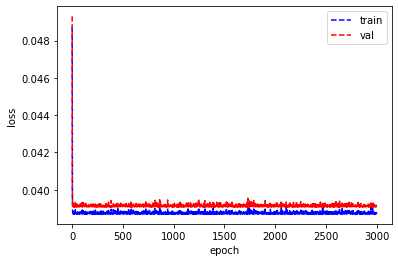

In [19]:
ax = plt.subplot(111)
ax.plot(np.arange(len(loss_train)), loss_train, 'b--')
ax.plot(np.arange(len(loss_val)), loss_val, 'r--')

ax.set_xlabel("epoch")
ax.set_ylabel("loss")
# ax.set_yscale("log")

ax.legend(["train","val"])
ax.figure.savefig("4-2 all-atom and h2t series latent space error.jpg")
plt.draw()

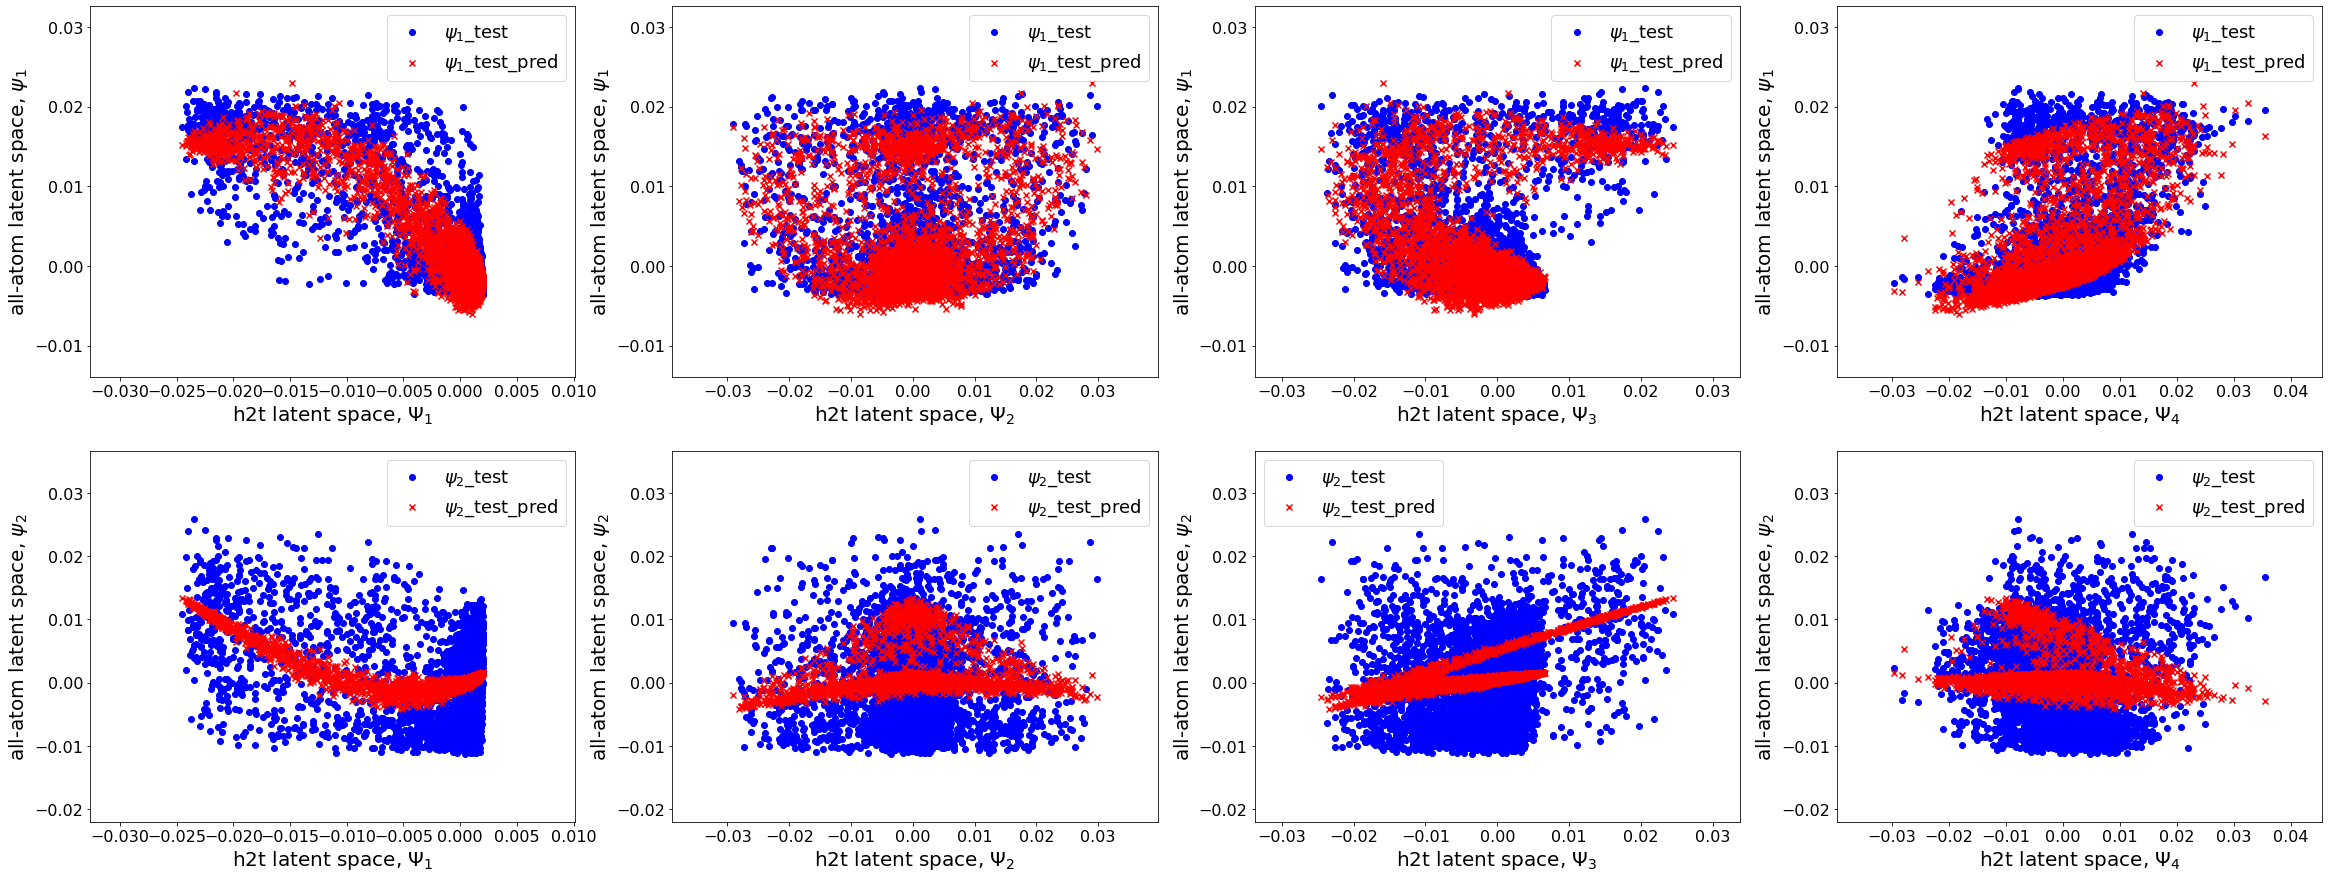

In [20]:
plt.figure(figsize=(40,15))

ax1 = plt.subplot(241)
ax1.scatter(x_test[:,0], y_test[:,0], c='blue', marker='o')
ax1.scatter(x_test[:,0], yscale.inverse_transform(Y_test_pred)[:,0], c='red', marker='x')
ax1.set_xlabel('h2t latent space, $\Psi_1$',fontsize=20)
ax1.set_ylabel('all-atom latent space, $\psi_1$',fontsize=20)
ax1.tick_params(labelsize=16)
ax1.legend(['$\psi_1$_test','$\psi_1$_test_pred'],fontsize=18)

ax2 = plt.subplot(242)
ax2.scatter(x_test[:,1], y_test[:,0], c='blue', marker='o')
ax2.scatter(x_test[:,1], yscale.inverse_transform(Y_test_pred)[:,0], c='red', marker='x')
ax2.set_xlabel('h2t latent space, $\Psi_2$',fontsize=20)
ax2.set_ylabel('all-atom latent space, $\psi_1$',fontsize=20)
ax2.tick_params(labelsize=16)
ax2.legend(['$\psi_1$_test','$\psi_1$_test_pred'],fontsize=18)

ax3 = plt.subplot(243)
ax3.scatter(x_test[:,2], y_test[:,0], c='blue', marker='o')
ax3.scatter(x_test[:,2], yscale.inverse_transform(Y_test_pred)[:,0], c='red', marker='x')
ax3.set_xlabel('h2t latent space, $\Psi_3$',fontsize=20)
ax3.set_ylabel('all-atom latent space, $\psi_1$',fontsize=20)
ax3.tick_params(labelsize=16)
ax3.legend(['$\psi_1$_test','$\psi_1$_test_pred'],fontsize=18)

ax4 = plt.subplot(244)
ax4.scatter(x_test[:,3], y_test[:,0], c='blue', marker='o')
ax4.scatter(x_test[:,3], yscale.inverse_transform(Y_test_pred)[:,0], c='red', marker='x')
ax4.set_xlabel('h2t latent space, $\Psi_4$',fontsize=20)
ax4.set_ylabel('all-atom latent space, $\psi_1$',fontsize=20)
ax4.tick_params(labelsize=16)
ax4.legend(['$\psi_1$_test','$\psi_1$_test_pred'],fontsize=18)

ax5 = plt.subplot(245)
ax5.scatter(x_test[:,0], y_test[:,1], c='blue', marker='o')
ax5.scatter(x_test[:,0], yscale.inverse_transform(Y_test_pred)[:,1], c='red', marker='x')
ax5.set_xlabel('h2t latent space, $\Psi_1$',fontsize=20)
ax5.set_ylabel('all-atom latent space, $\psi_2$',fontsize=20)
ax5.tick_params(labelsize=16)
ax5.legend(['$\psi_2$_test','$\psi_2$_test_pred'],fontsize=18)

ax6 = plt.subplot(246)
ax6.scatter(x_test[:,1], y_test[:,1], c='blue', marker='o')
ax6.scatter(x_test[:,1], yscale.inverse_transform(Y_test_pred)[:,1], c='red', marker='x')
ax6.set_xlabel('h2t latent space, $\Psi_2$',fontsize=20)
ax6.set_ylabel('all-atom latent space, $\psi_2$',fontsize=20)
ax6.tick_params(labelsize=16)
ax6.legend(['$\psi_2$_test','$\psi_2$_test_pred'],fontsize=18)


ax7 = plt.subplot(247)
ax7.scatter(x_test[:,2], y_test[:,1], c='blue', marker='o')
ax7.scatter(x_test[:,2], yscale.inverse_transform(Y_test_pred)[:,1], c='red', marker='x')
ax7.set_xlabel('h2t latent space, $\Psi_3$',fontsize=20)
ax7.set_ylabel('all-atom latent space, $\psi_2$',fontsize=20)
ax7.tick_params(labelsize=16)
ax7.legend(['$\psi_2$_test','$\psi_2$_test_pred'],fontsize=18)

ax8 = plt.subplot(248)
ax8.scatter(x_test[:,3], y_test[:,1], c='blue', marker='o')
ax8.scatter(x_test[:,3], yscale.inverse_transform(Y_test_pred)[:,1], c='red', marker='x')
ax8.set_xlabel('h2t latent space, $\Psi_4$',fontsize=20)
ax8.set_ylabel('all-atom latent space, $\psi_2$',fontsize=20)
ax8.tick_params(labelsize=16)
ax8.legend(['$\psi_2$_test','$\psi_2$_test_pred'],fontsize=18)

ax.figure.savefig("4-2 all-atom and h2t series latent space correspondence.jpg")
plt.draw()

In [21]:
Y_train_pred_scale_back = yscale.inverse_transform(Y_train_pred)
Y_val_pred_scale_back = yscale.inverse_transform(Y_val_pred)
Y_test_pred_scale_back = yscale.inverse_transform(Y_test_pred)

In [22]:
diff_train_scale_back = Y_train_pred_scale_back - y_train
MSE_train_scale_back = np.sum(diff_train_scale_back**2) / diff_train_scale_back.shape[0]
print ("MSE_train = %f" % (MSE_train_scale_back))
print ("RMSE_train = %f" % (np.sqrt(MSE_train_scale_back)))

diff_val_scale_back = Y_val_pred_scale_back - y_val
MSE_val_scale_back = np.sum(diff_val_scale_back**2) / diff_val_scale_back.shape[0]
print ("MSE_val = %f" % (MSE_val_scale_back))
print ("RMSE_val = %f" % (np.sqrt(MSE_val_scale_back)))

diff_test_scale_back = Y_test_pred_scale_back - y_test
MSE_test_scale_back = np.sum(diff_test_scale_back**2) / diff_test_scale_back.shape[0]
print ("MSE_test = %f" % (MSE_test_scale_back))
print ("RMSE_test = %f" % (np.sqrt(MSE_test_scale_back)))

MSE_train = 0.000047
RMSE_train = 0.006861
MSE_val = 0.000047
RMSE_val = 0.006875
MSE_test = 0.000047
RMSE_test = 0.006829
